<h2>1. Import Libraries and Acquire Data</h2>

In [1]:
# Data analysis and cleaning
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib import cycler
%matplotlib inline
import seaborn as sns
# !pip install --upgrade ptitprince
import ptitprince as pt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb 
from sklearn import metrics

# Default Styling
colors_default = ['#17869E', '#D35151', '#e5ae38', '#6d904f', '#264D58', '#E9DAB4']
colors_highlight = ['#51C4D3', '#fc4f30','#ffd966', '#9AE19D', '#008fd5']
darks = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors = cycler('color',colors_default)
style=plt.style.use('fivethirtyeight')
plt.rc('axes', prop_cycle=colors)
plt.rc('lines', linewidth=1)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('font', size=10)

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combined_df = pd.concat([train_df, test_df], ignore_index=True)

print('\nTest Dataframe:')
test_df.info()
print('='*45)
print('\nTrain Dataframe:')
train_df.info()
print('\n')
train_df.head()


Test Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB

Train Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     89

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

<h1>2. Data Cleaning</h1>

In [3]:
for df in [train_df, test_df]:
    # Age null values will be imputed with the mean Age of each Pclass due to their high correlation (shown later)
    Age_mean = df.groupby('Pclass')['Age'].mean()
    df['Age'] = df.apply(
        lambda row: Age_mean[row['Pclass']]
        if np.isnan(row['Age'])
        else row['Age'], axis=1
    )
    
    # Fare null values will be imputed with the mean Age of each Pclass due to their high correlation (shown later)
    Fare_mean = df.groupby('Pclass')['Fare'].mean()
    df['Fare'] = df.apply(
        lambda row: Fare_mean[row['Pclass']]
        if np.isnan(row['Fare'])
        else row['Fare'], axis=1
    )
    
    # Embarked null values will be imputed based on the mode
    Mode = df['Embarked'].mode()[0]
    df['Embarked'].fillna(Mode, inplace=True)

<h4> 2.2 Create:</h4> Feature Engineering for train and test/validation dataset

In [4]:
for df in [train_df, test_df, combined_df]:    
    # Column indicating total family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Column indicating if passenger has immediate family aboard
    df['FamilyAboard'] = 0 # Initialize to No/0
    df['FamilyAboard'].loc[df['FamilySize'] > 1] = 1 # Update to Yes/1 if family size is greater than 1
    
    # Fare Bins/Buckets using qcut or frequency bins
    df['FareBin'] = pd.qcut(df['Fare'], 5)
    
    # Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    df['AgeBin'] = pd.cut(x=df['Age'], bins=[0,18,30,40,50,65,85])
   
    # Create a column for the passenger's title -- http://www.pythonforbeginners.com/dictionary/python-split
    df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
        
# Cleanup rare title names
stat_min = 10 # While 'rare' is arbitrary, we'll use a common minimum in statistics
              # http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (combined_df.loc[:,'Title'].value_counts() < stat_min) # Creates true/false series with title as index
    
for df in [train_df, test_df]:
    df['Title'] = df.loc[:,'Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

/var/folders/2g/tckg1pmx4jj_vmtn556g6xwm0000gn/T/ipykernel_16164/1683422142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FamilyAboard'].loc[df['FamilySize'] > 1] = 1 # Update to Yes/1 if family size is greater than 1
/var/folders/2g/tckg1pmx4jj_vmtn556g6xwm0000gn/T/ipykernel_16164/1683422142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FamilyAboard'].loc[df['FamilySize'] > 1] = 1 # Update to Yes/1 if family size is greater than 1
/var/folders/2g/tckg1pmx4jj_vmtn556g6xwm0000gn/T/ipykernel_16164/1683422142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [5]:
# PassengerId, Ticket, Name columns will be dropped because they are arbitrary (title already extracted)
# Cabin column will be dropped because it is missing a high portion of data
for df in [train_df, test_df]:
    df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_df.drop('PassengerId',axis=1, inplace=True) # Column kept in test_df for submission 

<h2>3. Exploratory Data Analysis</h2>

Note: There is some redundancy in the EDA charts due to exercising a variety of plotting methods and chart types

In [6]:
# Discrete Variable Correlation by Survival using group by aka pivot table:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
for col in train_df:
    if (train_df[col].dtype != 'float64') and (col != 'Survived'):
        print('Survival Correlation by:', col)
        print(train_df[[col, 'Survived']].groupby(col, as_index=False).mean().sort_values(by='Survived', ascending=False))
        print('-'*10, '\n')      
        
# using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(train_df['Title'], train_df['Survived']))

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.00000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.0, 1, 'by Survival Outcome')

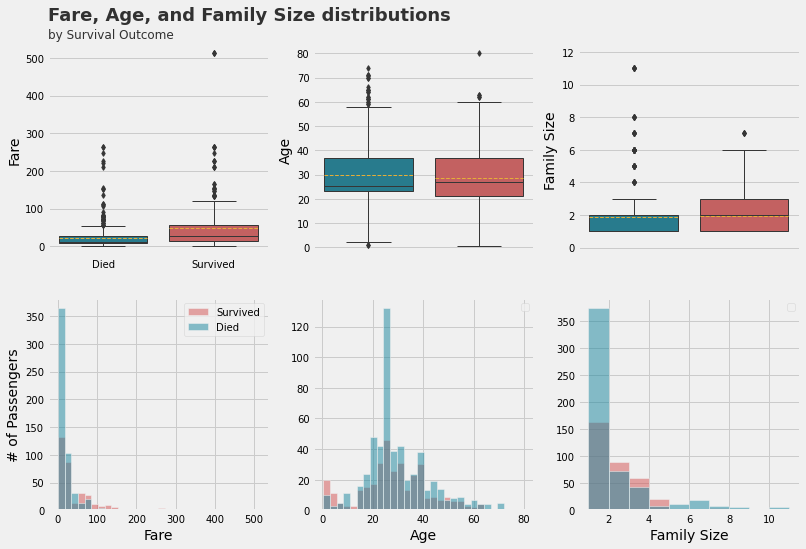

In [7]:
# This is one method to create subplots, but the prefered method is used in upcoming visualizations
plt.figure(figsize=[12,8])

plt.subplot(231)
sns.boxplot(x=train_df['Survived'], y=train_df['Fare'], showmeans = True, meanline = True, fliersize=4)
plt.ylabel('Fare')
plt.xlabel('')
plt.xticks(ticks=[0,1], labels=['Died','Survived'])

plt.subplot(232)
sns.boxplot(x=train_df['Survived'], y=train_df['Age'], showmeans = True, meanline = True, fliersize=4)
plt.ylabel('Age')
plt.xlabel('')
plt.xticks([])

plt.subplot(233)
sns.boxplot(x=train_df['Survived'], y=train_df['FamilySize'], showmeans = True, meanline = True, fliersize=4)
plt.ylabel('Family Size')
plt.ylim(-0.5,12.5)
plt.xlabel('')
plt.xticks([])

plt.subplot(234)
sns.histplot(data=train_df, x='Fare', hue='Survived', bins=30)
plt.xlabel('Fare')
plt.ylabel('# of Passengers')
plt.legend(['Survived','Died'])

plt.subplot(235)
sns.histplot(data=train_df, x='Age', hue='Survived', bins=30)
plt.ylabel('')
plt.legend()

plt.subplot(236)
sns.histplot(data=train_df, x='FamilySize', hue='Survived', bins=10)
plt.xlabel('Family Size')
plt.ylabel('')
plt.legend()

# Title and subtitle
plt.subplot(231)
plt.text(s="Fare, Age, and Family Size distributions", ha='left', x=-0.5, y=600, fontsize=18, fontweight='bold', color=darks[1])
plt.title("by Survival Outcome", loc='left', fontsize=12, y=1, color=darks[1]) 

Text(0.52, 0.9, 'Survival Rates by Feature')

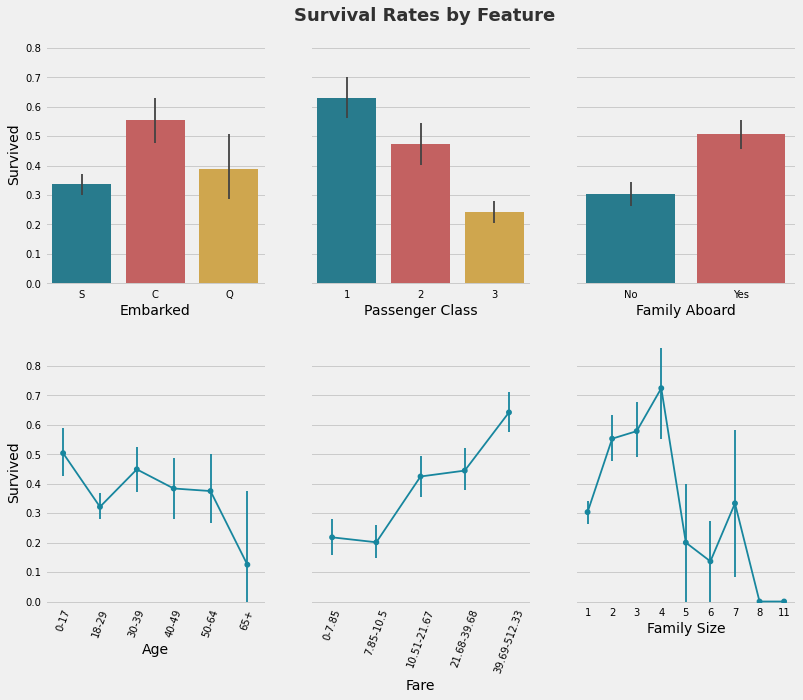

In [8]:
# Create Figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(12,10), sharey=True)

# Plot
sns.barplot(data=train_df, x='Embarked', y='Survived', ax=axs[0,0])
sns.barplot(data=train_df, x='Pclass', y='Survived', ax=axs[0,1])
sns.barplot(data=train_df, x='FamilyAboard', y='Survived', ax=axs[0,2])
sns.pointplot(data=train_df, x='AgeBin', y='Survived', ax=axs[1,0])
sns.pointplot(data=train_df, x='FareBin', y='Survived', ax=axs[1,1])
sns.pointplot(data=train_df, x='FamilySize', y='Survived', ax=axs[1,2])

# Format
axs[0,1].set(xlabel='Passenger Class', ylabel='')
axs[0,2].set(xlabel='Family Aboard', ylabel='',  xticklabels=['No','Yes'])
axs[1,0].set(xlabel='Age', 
             xticklabels=['0-17','18-29','30-39','40-49','50-64', '65+'],
             ylim=(-0.01,0.89))
axs[1,0].tick_params(axis='x',rotation=70)
axs[1,1].set(ylabel='', xlabel='Fare', xticklabels=['0-7.85','7.85-10.5','10.51-21.67','21.68-39.68','39.69-512.33'])
axs[1,1].tick_params(axis='x', rotation=70)
axs[1,2].set(xlabel='Family Size',ylabel='')

fig.suptitle('Survival Rates by Feature', fontsize=18, fontweight=600, x=0.52, y=0.9, color=darks[1])

Text(0.0, 1.1, 'by on Passenger Class and Survival Outcome')

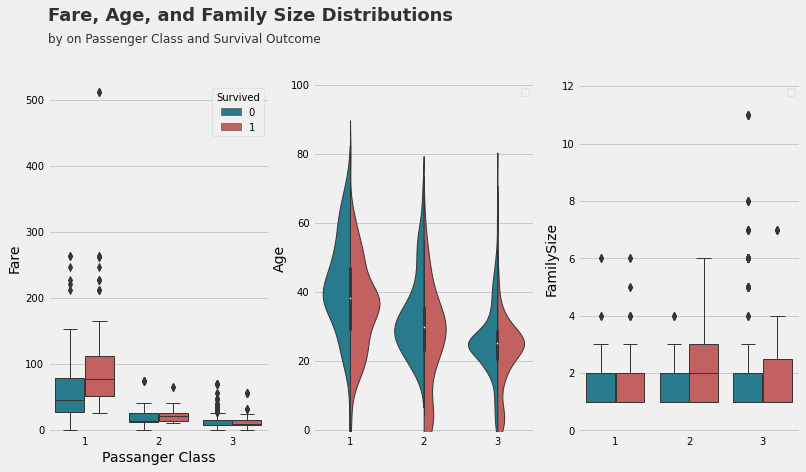

In [9]:
fig, axs = plt.subplots(1,3,figsize=(12,6))

sns.boxplot(data=train_df, x='Pclass', y='Fare', hue='Survived', ax=axs[0])
axs[0].set(xlabel='Passanger Class', ylim=(-5,525))
plt.legend(['Survived','Died'])

sns.violinplot(data=train_df, x='Pclass', y='Age', hue='Survived', split=True, ax=axs[1])
axs[1].set(xlabel='', ylim=(-1,100.5))
axs[1].legend('')

sns.boxplot(data=train_df, x='Pclass', y='FamilySize', hue='Survived', ax=axs[2])
axs[2].set(xlabel='', ylim=(-0.1,12.1))
axs[2].legend('')

# Title and Subtitle
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()

plt.subplot(131)
plt.text(s='Fare, Age, and Family Size Distributions',
         x=xmin, y=ymax*1.18, fontsize=18, fontweight='bold', color=darks[1])
plt.title("by on Passenger Class and Survival Outcome", loc='left', fontsize=12, y=1.1, color=darks[1]) 

Text(0.0, 1.04, 'by features Passenger Class, Family Aboard, and Embarked')

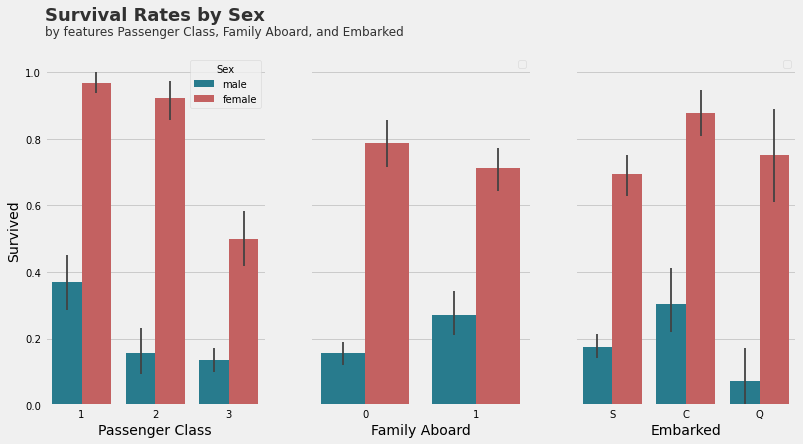

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), sharey=True)

sns.barplot(data=train_df, x='Pclass', y='Survived', hue='Sex', ax=axs[0])
axs[0].set(xlabel='Passenger Class')

sns.barplot(
    data=train_df,
    x='FamilyAboard',
    y='Survived',
    hue='Sex',
    ax=axs[1])
axs[1].set(xlabel='Family Aboard', ylabel='')
axs[1].legend('')

sns.barplot(
    data=train_df,
    x='Embarked',
    y='Survived',
    hue='Sex',
    ax=axs[2])
axs[2].set(ylabel='')
axs[2].legend('')

# Title and Subtitle
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()

plt.subplot(131)
plt.text(s='Survival Rates by Sex',
         x=xmin,
         y=ymax*1.1,
         fontsize=18,
         fontweight='bold',
         color=darks[1])
plt.title("by features Passenger Class, Family Aboard, and Embarked",
          loc='left',
          fontsize=12,
          y=1.04,
          color=darks[1]) 

Text(0.48, 1.02, 'Survival Rates by Family Size and Age')

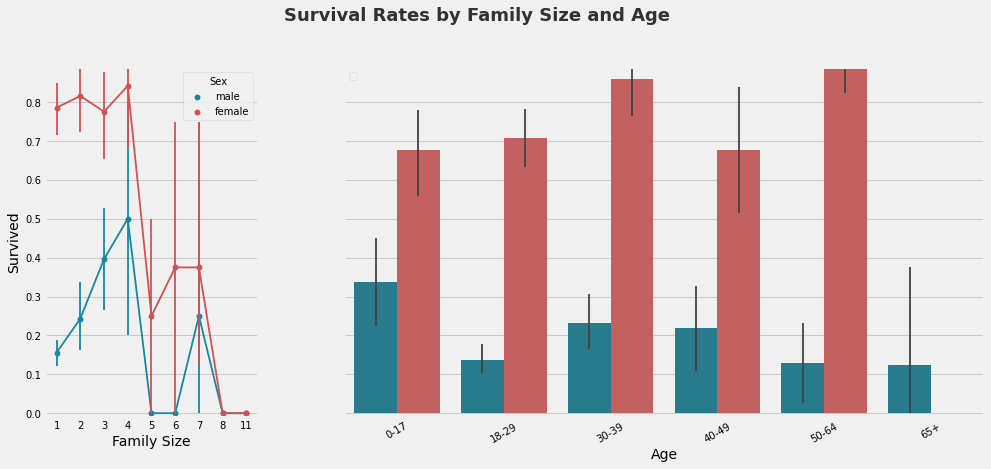

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,6), gridspec_kw={'width_ratios':[1,3]}, sharey=True)

sns.pointplot(data=train_df, x='FamilySize', y='Survived', hue='Sex', ax=axs[0])
axs[0].set(xlabel='Family Size')

sns.barplot(data=train_df, x='AgeBin', y='Survived', hue='Sex', ax=axs[1])
axs[1].set(
    xlabel='Age', ylabel='', 
    xticklabels=['0-17','18-29','30-39','40-49','50-64', '65+'],
    ylim=(-0.01,0.89))
axs[1].tick_params(axis='x', rotation=30)
axs[1].legend('')

fig.suptitle('Survival Rates by Family Size and Age', fontsize=18, fontweight=600, x=0.48, y=1.02, color=darks[1]) 

<Figure size 1008x576 with 0 Axes>

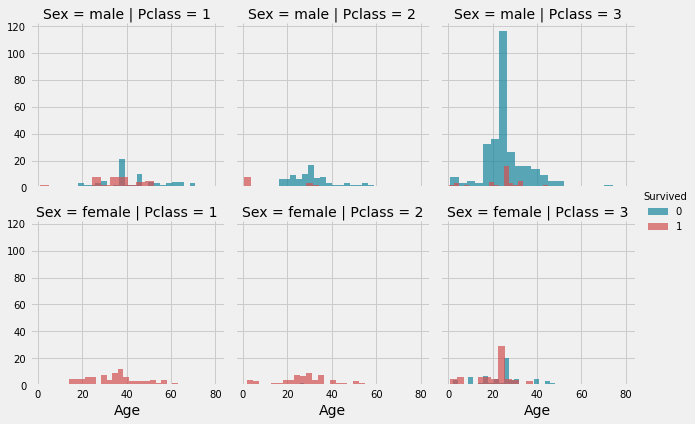

In [12]:
grid = sns.FacetGrid(train_df, col='Pclass', row='Sex', hue='Survived')
plt.figure(figsize=(14,8))
grid.map(plt.hist, 'Age', bins=20, alpha=0.7)
grid.add_legend()

Text(0.51, 0.96, 'Age Distribution by Passenger Class')

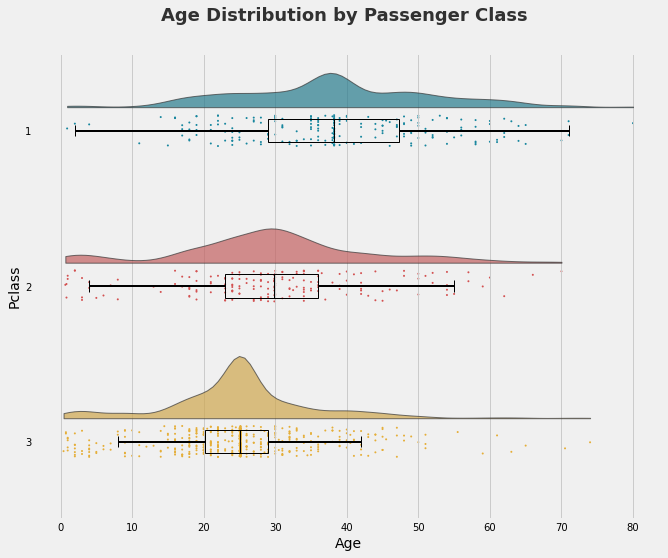

In [13]:
# Rainplot
fig, ax = plt.subplots(figsize=(10, 8))

ax=pt.half_violinplot(
    data=train_df, x='Age', y='Pclass', palette=colors_default, orient='h', alpha=0.7,
    bw=.2, linewidth=1,cut=0., scale="area", width=.8, inner=None)
ax=sns.stripplot(
    data=train_df, x='Age', y='Pclass', palette=colors_default, orient='h',
    edgecolor="white",size=2,jitter=1,zorder=0)
ax=sns.boxplot(
    data=train_df, x='Age', y='Pclass', color="black",orient='h',
    width=.15,zorder=10,showcaps=True,boxprops={'facecolor':'none', "zorder":10},
    showfliers=False,whiskerprops={'linewidth':2, "zorder":10},saturation=1)

fig.suptitle('Age Distribution by Passenger Class', fontsize=18, fontweight=600, x=0.51, y=0.96, color=darks[1])

Text(0.51, 0.96, 'Age Distribution by Survival')

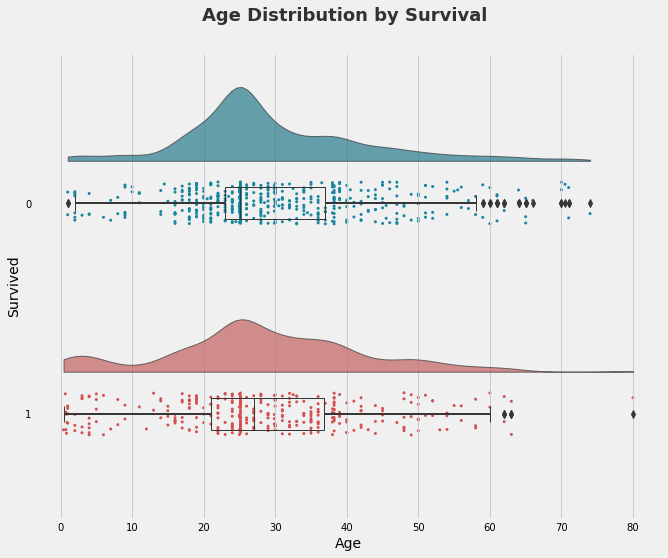

In [14]:
# Below is a higher level method of creating a rainplot, requiring less code
fig, axs = plt.subplots(figsize=(10, 8))

axs=pt.RainCloud(
    data=train_df, x='Survived', y='Age', alpha=0.7,
    bw=0.2, ax = axs, orient = 'h', palette=colors_default, dodge=True)

fig.suptitle('Age Distribution by Survival', fontsize=18, fontweight=600, x=0.51, y=0.96, color=darks[1])

<AxesSubplot:>

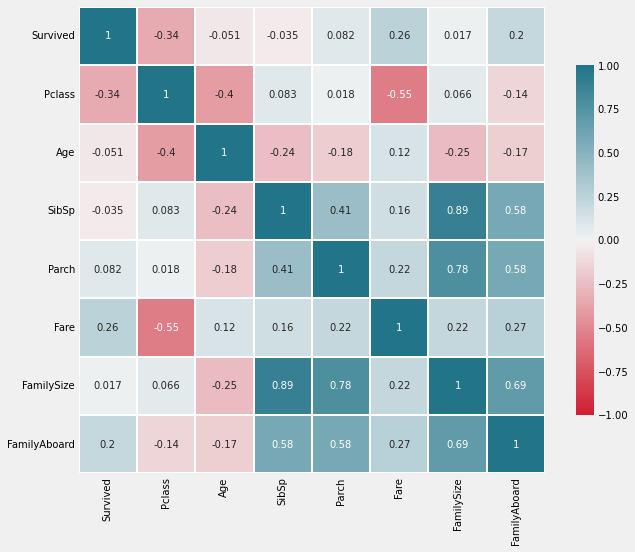

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(
    train_df.corr(), 
    cmap = sns.diverging_palette(10, 220, as_cmap=True, l=45, s=90), 
    annot=True, 
    square=True,
    vmin=-1,
    vmax=1,
    cbar_kws={'shrink':.75 },
    linewidths=0.08, linecolor='white')

<h2>4. Model and Predict Data</h2>

<h3> 4.0 Prepare Data</h3>

<h4>Convert</h4>

In [16]:
for df in [train_df, test_df]:
    # Create dummy variables for categorical columns
    df = pd.concat([df, pd.get_dummies(df[['Sex','Embarked','Title', 'Sex']], drop_first=True)], axis=1)
    
    # Remove original categorical columns
    df.drop(['Sex', 'Embarked', 'Title'], axis=1, inplace=True)
    
    # Drop bin columns used for visualization. This data is already present in numerical columns
    df.drop(['AgeBin', 'FareBin'], axis=1, inplace=True)

<h4>Create</h4>

In [17]:
# Create dummy variables for categorical columns
train_df = pd.concat([train_df, pd.get_dummies(train_df[['Sex','Embarked','Title']], drop_first=True)], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df[['Sex','Embarked','Title']], drop_first=True)], axis=1)

# Drop original categorical columns. Drop bin columns used for visualization--data is already present in numerical columns
train_df.drop(['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin'], axis=1, inplace=True)
test_df.drop(['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin'], axis=1, inplace=True)

<h4>Split</h4>

In [18]:
X=train_df.drop('Survived', axis=1)
y=train_df['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=101)

<h3> 4.1 Random Forest Classifier</h3>

<img style="width: 440px; height: 221px;" src="https://www.explorium.ai/wp-content/uploads/2019/12/Decision-Trees-2.png" align="Right">

Random Forest Classifiers are upgraded versions of Decision Trees by creating an ensemble of many models using the method of bagging (or "Bootstrap Aggregation").

The foundational Decision Trees Classifier is an intuitive model. The model will first split the data/rows/samples by each its value for one particular column/field/variable/feature/variable (let's stick "sample" with "variable"). The goal of this split is to make each sample subsethave more homogenous values for the target variable. After splitting the samples at this <i>root node</i>, the model repeats this process for each <i>branch</i> by utilizing additional variables as <i>decision nodes</i>. The goal is to end with <i>leaf nodes</i> that accurately classify the samples in that node as one particular class.

A key concern here is <i>which feature should be used for each decision?</i> This can be determined by a variety of metrics, but the most common are Entropy and Gini Index. In brief...
 
<p style="padding-left: 10px;">
$Gini = 1-\sum_{i=1}^{n}{(p_{i})^{2}}$<br>
$Entropy = -\sum_{i=1}^{n}{p_{i} log_{2}(p_i)}$</p>

where $P_{i}$ denotes the porportion of samples belonging to class $i$ for that particular node. In other words, the probability of data being classified for a distinct class. These metrics range from 0 to 1, where 0 is best (most "pure" for gini and most "ordered" for Entropy). The Gini Index tends to favor nodes with larger partitions and Entropy tends to favor nodes with smaller partitions and more distinct classes.

The greatest downfall to a Decision Tree model is it tends to overfit because it is highly dependent on the data the model is trained with. There are several parameters to help counteract this, such as min and max number of samples before splitting, min and max tree depth, etc. One of the greatest methods to prevent overfitting is <i>bagging</i> which creates the <b><i>Random Forest Classifier</i></b>.

RFC creates an ensemble of Decision Trees such that each one is trained using only a subset (wih replacement) of the entire dataset--this is known as bagging. Additionally, each Decision Tree can be limited to making decisions based on only a subset of all variables. These two restrictions help establish "a large number of relatively uncorrelated models (trees) operating as a committee [that outperforms] any of the individual constituent models." These Decision Trees are created in parallel so the Random Forest Classifier can make predicitions based on the average of the trees. Note that the SciKit-Learn RFC uses subsets are selected with replacement, but are always the same size as the original sample set.

In [19]:
# RFC Benchmark Model
rfc = RandomForestClassifier(random_state=101)
rfc.fit(X_train,y_train)

# Random Forest Classifier with Random Feature Elimiation
rfc_rfe = RFECV(
    RandomForestClassifier(random_state=101),
    step = 1,
    scoring = 'roc_auc',
    cv=4)

rfc_rfe.fit(X_train, y_train)
selected_features = X.columns.values[rfc_rfe.get_support()]

rfc_rfe = RandomForestClassifier(random_state=101)
rfc_rfe = rfc_rfe.fit(X_train[selected_features], y_train)

# Use GridSearchCV to improve Random Forest Classifier parameters
rfc_params = {
    'n_estimators':[100, 150, 200],
    'criterion': ['gini', 'entropy'],  
    'max_depth': [4,6,8,10,None],
    'min_samples_split': [2,5,10,20],
    'random_state': [101]}

rfc_tuned = GridSearchCV(
    RandomForestClassifier(random_state=101),
    rfc_params,verbose=1,
    scoring = 'roc_auc',
    cv=4)

rfc_tuned.fit(X_train[selected_features], y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=101),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, None],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [100, 150, 200],
                         'random_state': [101]},
             scoring='roc_auc', verbose=1)

In [20]:
# Print best parameters and selected features
print('Selected Features:', selected_features,'\n')
print('Best Parameters:', rfc_tuned.best_params_)

Selected Features: ['Pclass' 'Age' 'SibSp' 'Fare' 'FamilySize' 'Sex_male' 'Title_Miss'
 'Title_Mr' 'Title_Mrs'] 

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 101}


In [21]:
## An alternative to [selected_features]:
# from sklearn.feature_selection import SelectFromModel

## Create a random forest classifier
# rfc = RandomForestClassifier(n_estimators=1000, random_state=101, n_jobs=-1)

## Train the classifier
# rfc.fit(X_train1, y_train1)

## Print the feature name and gini importance of each feature
# for feature in zip(X_train1.columns.values, rfc.feature_importances_):
#    print(feature)

## Create a selector object that will use the random forest classifier to identify features
## that have an importance of more a threashold determined by the previously printed feature importance
# sfm = SelectFromModel(rfc, threshold=0.15)

## Train the selector
# sfm.fit(X_train1, y_train1)

## Print the names of the most important features
# for feature_list_index in sfm.get_support(indices=True):
#    print(X_train1.columns.values[feature_list_index])

## Transform the data to create a new dataset containing only the most important features
## Note: We have to apply the transform to both the training X and test X data.
# X_important_train1 = sfm.transform(X_train1)
# X_important_train2 = sfm.transform(X_train2)
# X_important_test = sfm.transform(X_test)

## Create a new random forest classifier for the most important features
# rfc_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

## Train the new classifier on the new dataset containing the most important features
# rfc_important.fit(X_important_train1, y_train)

<h3>4.2 Support Vector Machine Classifier</h3>

<img style="width: 414px; height: 180px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDlYsiPUl636bhR-MBaBDkSgOQdwEJAmXdKg&usqp=CAU" align="Right">
In brief, Support Vector Machines represent samples as points in space. The goal is to identify a hyperplane--known as the <i>Decision Boundary</i>--that separates the distinct classes as clearly as possible (as large of a separation as possible). If these classes are not linearly separable, then the <i>Kernel Trick</i> will map the data to another dimension to improve separability. SVMs tend to perform at a higher speed and performance when samples are limited than other modern models, like Neural Networks. For large amounts of data, however, these models can become very computationally expensive.

In [22]:
# SVC Benchmark Model
svc = SVC(probability=True)
svc.fit(X_train,y_train)

# SVC with tuned parameters using GridSearchCV
svc_params = {'C':[0.1,1,10,100,1000, 10000], 'gamma':[1,0.1,0.01,0.001,0.0001]}
svc_tuned = GridSearchCV(SVC(),svc_params,verbose=1, scoring='roc_auc', cv=4)
svc_tuned.fit(X,y)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             scoring='roc_auc', verbose=1)

<h3>4.3 XGBoost</h3>

The bagging method was used in the Random Forest Classifier to combat overfitting. Another method to control bias-variance tradeoff that utilizes models built in <u>series</u> instead of parallel is <i>boosting</i>. For Gradient Boosting, a loss function is used to detect the residuals of the individual <i>weak learners</i>, such as Decision Trees. Gradient Descent is utilized to minimize the loss function when creating the next model. The final model aggregates the result of each step (creates ensemble) and thus a strong learner is obtained.


Gradient Boosted Decision Trees (GBDTs) iteratively train an ensemble of shallow decision trees, with each iteration using the error residuals of the previous model to fit the next model. The final prediction is a weighted sum of all of the tree predictions. XGBoost is short for eXtreme Gradient Boosting and predominantly aims to improve speed and performance of the Gradient Boost with all the same foundational theory.

Some quick tips for the XGBoost library:
* can handle missing values if they are not dealt with in preprocessing
* cannot handle categorical features
* Transform data to DMatrix structure, which is an optimized data structure that provides better memory efficiency and training speed.

In [23]:
# Store data in DMatrix object
ddata = xgb.DMatrix(data=X, label=y)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)

# XGB Benchmark Model
# Specify parameters
num_round = 500 # Early stopping will be applied
xgb_params = {
    'max_depth':2,
    'learning_rate':1,
    'objective':'binary:logistic',
    'eval_metric':['logloss','auc']} # last metric listed used for early_stopping


# Below is how to train XGB with a train/test split instead of cross validation
'''
# Create dictionary to store evaluation results
xb_evals = {}

# xgb.train will return the last model, not best model
xb = xgb.train(
    xgb_params,
    dtrain,
    num_round,
    evals=[(dval,'Validation')],
    evals_result=xb_evals,
    early_stopping_rounds=10)
# Predict using best model (applicable only if early stopping applied)
xb_pred = xb.predict(dval, iteration_range=(0, xb.best_iteration + 1))
'''


# Cross Validation
xgb_cv = xgb.cv(
    xgb_params,
    ddata,
    num_round,
    nfold=4,
    early_stopping_rounds=10,
    seed=101,
    callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]) # Will return mean+std

# xgb.plot_importance(xgb_cv)
# xgb.plot_tree(xgb_cv, num_trees=2)

[0]	train-logloss:0.46085+0.00731	train-auc:0.83980+0.00718	test-logloss:0.47564+0.02305	test-auc:0.82831+0.02630
[1]	train-logloss:0.41998+0.01159	train-auc:0.86708+0.00313	test-logloss:0.43741+0.02871	test-auc:0.85817+0.01428
[2]	train-logloss:0.40194+0.01074	train-auc:0.87733+0.00577	test-logloss:0.42197+0.02466	test-auc:0.86866+0.01477
[3]	train-logloss:0.38918+0.01287	train-auc:0.88818+0.00448	test-logloss:0.42725+0.03492	test-auc:0.86373+0.02154
[4]	train-logloss:0.38102+0.01166	train-auc:0.89328+0.00757	test-logloss:0.42805+0.03945	test-auc:0.86483+0.02116
[5]	train-logloss:0.37530+0.01310	train-auc:0.89734+0.00643	test-logloss:0.42697+0.04041	test-auc:0.86854+0.02163
[6]	train-logloss:0.37047+0.01283	train-auc:0.90082+0.00592	test-logloss:0.43299+0.04175	test-auc:0.86492+0.02146
[7]	train-logloss:0.36377+0.01563	train-auc:0.90489+0.00930	test-logloss:0.43646+0.04189	test-auc:0.86486+0.02226
[8]	train-logloss:0.35776+0.01501	train-auc:0.90676+0.00827	test-logloss:0.43322+0.04140

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


There are two main methods to combat overfitting a model:

1. Directly control model complexity.
    * For a tree model, this includes max_depth, min_child_weight and gamma (min split loss).
2. Add randomness to make training robust to noise.
    * For a tree model, this includes subsample and colsample_bytree.
    * Reduce stepsize eta ("learning rate"). If this is done, num_round should be increased.

The training data (including validation, just not the final test data) is moderately imbalanced (38%). Since the model is concerned with predicting the correct outcome and not necessarily the predicting the correct probabilities, data will be balanced (see <a href="https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html?highlight=balance">XGB documentation</a>).

XGBoost library does not have any GridSearchCV sort of function. It is absolutely possuble to use GridSearchCV, but it will not accept a DMatrix object for the data, greatly helps the speed of XGB. For this reason, xgb.cv() will be looped to achieve the same goal as GridSearchCV, but faster.

In [24]:
ddata = xgb.DMatrix(data=X, label=y)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)

params_current = {
    'objective':'binary:logistic',
    'eval_metric':['logloss','auc']}

# Define preprocessing function to balance data with 'scale_pos_weight'
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

auc_xgb_best = 0
params_xgb_best = None

for gam in [0,0.5,1]:
    params_current['gamma'] = gam
    
    for min_child in [0,15,35]:
        params_current['min_child_weight'] = min_child
        
        for max_dep in [2,4,6,None]:
            params_current['max_depth'] = max_dep
            
            for learn in [0.025,0.05,0.1,0.5,1]:
                params_current['learning_rate'] = learn
                
                for alpha in [0,0.5,1]:
                    params_current['reg_alpha'] = alpha
                    
                    for lamb in [0,0.5,1]:
                        params_current['reg_lambda'] = lamb
                
                        xgb_tuning = xgb.cv(
                            params_current,
                            ddata,
                            num_round,
                            nfold=4,
                            early_stopping_rounds=10,
                            fpreproc=fpreproc,
                            seed=101,
                            # return mean+std
                            callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]) 

                        auc_result = xgb_tuning.iloc[-1]['test-auc-mean']

                        if  auc_result > auc_xgb_best:
                            auc_xgb_best = auc_result
                            params_xgb_best = params_current.copy()
                            xgb_best = xgb_tuning
                            
# Fit model to best parameters for final model comparison
xgb_tuned = xgb.train(
    params_xgb_best,
    dtrain,
    num_round,
    early_stopping_rounds=10,
    evals=[(dval,'Validation')])

[0]	train-logloss:0.68306+0.00022	train-auc:0.83953+0.00326	test-logloss:0.68338+0.00011	test-auc:0.83382+0.01118
[1]	train-logloss:0.67347+0.00043	train-auc:0.83953+0.00326	test-logloss:0.67410+0.00022	test-auc:0.83382+0.01118
[2]	train-logloss:0.66435+0.00063	train-auc:0.83997+0.00329	test-logloss:0.66523+0.00035	test-auc:0.83546+0.01113
[3]	train-logloss:0.65565+0.00083	train-auc:0.83997+0.00329	test-logloss:0.65683+0.00047	test-auc:0.83546+0.01113
[4]	train-logloss:0.64738+0.00101	train-auc:0.84030+0.00343	test-logloss:0.64894+0.00059	test-auc:0.83462+0.01106
[5]	train-logloss:0.63948+0.00119	train-auc:0.84482+0.00480	test-logloss:0.64133+0.00072	test-auc:0.83825+0.01714
[6]	train-logloss:0.63193+0.00135	train-auc:0.85450+0.00831	test-logloss:0.63400+0.00087	test-auc:0.84619+0.01700
[7]	train-logloss:0.62471+0.00151	train-auc:0.85780+0.00375	test-logloss:0.62714+0.00100	test-auc:0.85063+0.01038
[8]	train-logloss:0.61779+0.00167	train-auc:0.85807+0.00378	test-logloss:0.62048+0.00116

[72]	train-logloss:0.44626+0.00682	train-auc:0.87891+0.00633	test-logloss:0.45902+0.01047	test-auc:0.86554+0.01376
[73]	train-logloss:0.44541+0.00679	train-auc:0.87929+0.00637	test-logloss:0.45832+0.01090	test-auc:0.86580+0.01362
[74]	train-logloss:0.44458+0.00681	train-auc:0.87914+0.00668	test-logloss:0.45758+0.01094	test-auc:0.86531+0.01397
[75]	train-logloss:0.44376+0.00688	train-auc:0.87991+0.00662	test-logloss:0.45724+0.01089	test-auc:0.86668+0.01306
[76]	train-logloss:0.44295+0.00686	train-auc:0.88096+0.00630	test-logloss:0.45646+0.01121	test-auc:0.86683+0.01304
[77]	train-logloss:0.44217+0.00690	train-auc:0.88166+0.00632	test-logloss:0.45600+0.01109	test-auc:0.86726+0.01314
[78]	train-logloss:0.44135+0.00691	train-auc:0.88168+0.00579	test-logloss:0.45528+0.01144	test-auc:0.86726+0.01315
[79]	train-logloss:0.44059+0.00694	train-auc:0.88214+0.00601	test-logloss:0.45484+0.01154	test-auc:0.86800+0.01337
[80]	train-logloss:0.43983+0.00705	train-auc:0.88291+0.00514	test-logloss:0.4544

[45]	train-logloss:0.48179+0.00569	train-auc:0.87201+0.00414	test-logloss:0.49068+0.00745	test-auc:0.86321+0.01337
[46]	train-logloss:0.47995+0.00579	train-auc:0.87209+0.00418	test-logloss:0.48890+0.00751	test-auc:0.86321+0.01337
[47]	train-logloss:0.47815+0.00583	train-auc:0.87239+0.00456	test-logloss:0.48721+0.00764	test-auc:0.86315+0.01341
[48]	train-logloss:0.47638+0.00588	train-auc:0.87247+0.00453	test-logloss:0.48546+0.00791	test-auc:0.86321+0.01337
[49]	train-logloss:0.47472+0.00592	train-auc:0.87211+0.00415	test-logloss:0.48390+0.00808	test-auc:0.86321+0.01337
[50]	train-logloss:0.47308+0.00601	train-auc:0.87247+0.00459	test-logloss:0.48243+0.00809	test-auc:0.86321+0.01337
[51]	train-logloss:0.47152+0.00604	train-auc:0.87247+0.00459	test-logloss:0.48096+0.00824	test-auc:0.86321+0.01337
[0]	train-logloss:0.68321+0.00022	train-auc:0.83953+0.00326	test-logloss:0.68352+0.00010	test-auc:0.83382+0.01118
[1]	train-logloss:0.67376+0.00043	train-auc:0.83953+0.00326	test-logloss:0.67437+

[10]	train-logloss:0.60536+0.00190	train-auc:0.85956+0.00441	test-logloss:0.60863+0.00160	test-auc:0.85331+0.00878
[11]	train-logloss:0.59932+0.00202	train-auc:0.86014+0.00468	test-logloss:0.60283+0.00174	test-auc:0.85472+0.00914
[12]	train-logloss:0.59351+0.00216	train-auc:0.86008+0.00469	test-logloss:0.59725+0.00185	test-auc:0.85464+0.00920
[13]	train-logloss:0.58790+0.00232	train-auc:0.86193+0.00710	test-logloss:0.59194+0.00201	test-auc:0.85625+0.00749
[14]	train-logloss:0.58250+0.00249	train-auc:0.86240+0.00651	test-logloss:0.58678+0.00212	test-auc:0.85757+0.00968
[15]	train-logloss:0.57732+0.00266	train-auc:0.86200+0.00710	test-logloss:0.58182+0.00219	test-auc:0.85643+0.00746
[16]	train-logloss:0.57224+0.00280	train-auc:0.86534+0.00461	test-logloss:0.57696+0.00250	test-auc:0.85985+0.01209
[17]	train-logloss:0.56734+0.00301	train-auc:0.86425+0.00407	test-logloss:0.57242+0.00263	test-auc:0.85792+0.01136
[18]	train-logloss:0.56263+0.00319	train-auc:0.86445+0.00386	test-logloss:0.5680

[82]	train-logloss:0.43978+0.00718	train-auc:0.88356+0.00494	test-logloss:0.45424+0.01120	test-auc:0.86872+0.01569
[83]	train-logloss:0.43910+0.00727	train-auc:0.88392+0.00550	test-logloss:0.45361+0.01112	test-auc:0.86918+0.01444
[84]	train-logloss:0.43839+0.00734	train-auc:0.88392+0.00553	test-logloss:0.45316+0.01096	test-auc:0.86905+0.01425
[85]	train-logloss:0.43771+0.00733	train-auc:0.88402+0.00555	test-logloss:0.45265+0.01134	test-auc:0.86910+0.01456
[86]	train-logloss:0.43707+0.00740	train-auc:0.88427+0.00533	test-logloss:0.45220+0.01133	test-auc:0.86910+0.01451
[87]	train-logloss:0.43642+0.00743	train-auc:0.88455+0.00526	test-logloss:0.45171+0.01112	test-auc:0.86923+0.01453
[88]	train-logloss:0.43577+0.00754	train-auc:0.88453+0.00529	test-logloss:0.45122+0.01108	test-auc:0.86921+0.01450
[89]	train-logloss:0.43514+0.00755	train-auc:0.88504+0.00630	test-logloss:0.45068+0.01107	test-auc:0.86999+0.01346
[90]	train-logloss:0.43450+0.00762	train-auc:0.88519+0.00624	test-logloss:0.4504

[51]	train-logloss:0.47248+0.00609	train-auc:0.87233+0.00469	test-logloss:0.48176+0.00797	test-auc:0.86292+0.01298
[52]	train-logloss:0.47093+0.00619	train-auc:0.87232+0.00470	test-logloss:0.48039+0.00801	test-auc:0.86292+0.01298
[53]	train-logloss:0.46945+0.00620	train-auc:0.87233+0.00469	test-logloss:0.47891+0.00827	test-auc:0.86292+0.01298
[54]	train-logloss:0.46797+0.00627	train-auc:0.87238+0.00464	test-logloss:0.47753+0.00841	test-auc:0.86298+0.01307
[55]	train-logloss:0.46660+0.00632	train-auc:0.87261+0.00490	test-logloss:0.47627+0.00842	test-auc:0.86340+0.01267
[56]	train-logloss:0.46525+0.00635	train-auc:0.87302+0.00442	test-logloss:0.47507+0.00856	test-auc:0.86380+0.01311
[57]	train-logloss:0.46391+0.00638	train-auc:0.87341+0.00410	test-logloss:0.47372+0.00879	test-auc:0.86425+0.01371
[58]	train-logloss:0.46263+0.00643	train-auc:0.87357+0.00399	test-logloss:0.47256+0.00889	test-auc:0.86432+0.01380
[59]	train-logloss:0.46138+0.00649	train-auc:0.87315+0.00448	test-logloss:0.4714

[22]	train-logloss:0.54697+0.00376	train-auc:0.86594+0.00392	test-logloss:0.55303+0.00337	test-auc:0.86013+0.01172
[23]	train-logloss:0.54306+0.00389	train-auc:0.86732+0.00571	test-logloss:0.54923+0.00360	test-auc:0.85820+0.01330
[24]	train-logloss:0.53931+0.00406	train-auc:0.86731+0.00571	test-logloss:0.54575+0.00375	test-auc:0.85816+0.01334
[25]	train-logloss:0.53570+0.00412	train-auc:0.86783+0.00589	test-logloss:0.54211+0.00390	test-auc:0.85906+0.01272
[26]	train-logloss:0.53223+0.00424	train-auc:0.86860+0.00637	test-logloss:0.53879+0.00394	test-auc:0.86075+0.01207
[27]	train-logloss:0.52882+0.00436	train-auc:0.86935+0.00439	test-logloss:0.53557+0.00415	test-auc:0.85875+0.01211
[28]	train-logloss:0.52558+0.00449	train-auc:0.86942+0.00426	test-logloss:0.53238+0.00414	test-auc:0.85871+0.01220
[29]	train-logloss:0.52239+0.00455	train-auc:0.87018+0.00467	test-logloss:0.52927+0.00454	test-auc:0.86051+0.01172
[30]	train-logloss:0.51934+0.00464	train-auc:0.86943+0.00428	test-logloss:0.5263

[33]	train-logloss:0.50998+0.00484	train-auc:0.87063+0.00490	test-logloss:0.51740+0.00537	test-auc:0.86307+0.01202
[34]	train-logloss:0.50728+0.00498	train-auc:0.87072+0.00490	test-logloss:0.51485+0.00538	test-auc:0.86320+0.01201
[35]	train-logloss:0.50469+0.00504	train-auc:0.87071+0.00491	test-logloss:0.51231+0.00551	test-auc:0.86329+0.01198
[36]	train-logloss:0.50213+0.00512	train-auc:0.87007+0.00465	test-logloss:0.50985+0.00587	test-auc:0.86164+0.01287
[37]	train-logloss:0.49965+0.00521	train-auc:0.87005+0.00473	test-logloss:0.50747+0.00607	test-auc:0.86160+0.01290
[38]	train-logloss:0.49733+0.00530	train-auc:0.87055+0.00463	test-logloss:0.50524+0.00609	test-auc:0.86329+0.01198
[39]	train-logloss:0.49509+0.00532	train-auc:0.87059+0.00462	test-logloss:0.50302+0.00619	test-auc:0.86326+0.01196
[40]	train-logloss:0.49288+0.00545	train-auc:0.87059+0.00471	test-logloss:0.50104+0.00626	test-auc:0.86329+0.01194
[41]	train-logloss:0.49074+0.00552	train-auc:0.86989+0.00445	test-logloss:0.4990

[7]	train-logloss:0.62598+0.00143	train-auc:0.85807+0.00378	test-logloss:0.62850+0.00118	test-auc:0.85056+0.01039
[8]	train-logloss:0.61918+0.00158	train-auc:0.85807+0.00378	test-logloss:0.62203+0.00141	test-auc:0.85056+0.01039
[9]	train-logloss:0.61268+0.00170	train-auc:0.85904+0.00381	test-logloss:0.61573+0.00150	test-auc:0.85307+0.01063
[10]	train-logloss:0.60643+0.00185	train-auc:0.85951+0.00440	test-logloss:0.60980+0.00172	test-auc:0.85433+0.00899
[11]	train-logloss:0.60044+0.00197	train-auc:0.85936+0.00384	test-logloss:0.60400+0.00180	test-auc:0.85307+0.01063
[12]	train-logloss:0.59466+0.00212	train-auc:0.86047+0.00463	test-logloss:0.59850+0.00195	test-auc:0.85478+0.00911
[13]	train-logloss:0.58910+0.00228	train-auc:0.86226+0.00698	test-logloss:0.59314+0.00204	test-auc:0.85632+0.00743
[14]	train-logloss:0.58378+0.00240	train-auc:0.86247+0.00647	test-logloss:0.58801+0.00213	test-auc:0.85769+0.00957
[15]	train-logloss:0.57865+0.00258	train-auc:0.86248+0.00647	test-logloss:0.58323+0

[47]	train-logloss:0.48083+0.00594	train-auc:0.87035+0.00488	test-logloss:0.48954+0.00710	test-auc:0.86200+0.01255
[48]	train-logloss:0.47913+0.00602	train-auc:0.87002+0.00432	test-logloss:0.48789+0.00708	test-auc:0.86192+0.01264
[49]	train-logloss:0.47749+0.00610	train-auc:0.87112+0.00507	test-logloss:0.48629+0.00715	test-auc:0.86360+0.01175
[50]	train-logloss:0.47584+0.00614	train-auc:0.87140+0.00546	test-logloss:0.48475+0.00725	test-auc:0.86356+0.01181
[51]	train-logloss:0.47425+0.00617	train-auc:0.87173+0.00443	test-logloss:0.48322+0.00757	test-auc:0.86436+0.01264
[52]	train-logloss:0.47270+0.00624	train-auc:0.87207+0.00491	test-logloss:0.48181+0.00767	test-auc:0.86436+0.01264
[53]	train-logloss:0.47119+0.00630	train-auc:0.87191+0.00443	test-logloss:0.48037+0.00774	test-auc:0.86440+0.01258
[54]	train-logloss:0.46981+0.00634	train-auc:0.87194+0.00446	test-logloss:0.47902+0.00781	test-auc:0.86440+0.01258
[55]	train-logloss:0.46838+0.00638	train-auc:0.87194+0.00446	test-logloss:0.4776

[18]	train-logloss:0.49705+0.00521	train-auc:0.87054+0.00473	test-logloss:0.50515+0.00646	test-auc:0.86085+0.01147
[19]	train-logloss:0.49245+0.00540	train-auc:0.87063+0.00453	test-logloss:0.50075+0.00643	test-auc:0.86095+0.01146
[20]	train-logloss:0.48804+0.00554	train-auc:0.87082+0.00452	test-logloss:0.49646+0.00667	test-auc:0.86356+0.01190
[21]	train-logloss:0.48388+0.00566	train-auc:0.87156+0.00424	test-logloss:0.49254+0.00735	test-auc:0.86153+0.01465
[22]	train-logloss:0.48008+0.00574	train-auc:0.87258+0.00437	test-logloss:0.48894+0.00763	test-auc:0.86324+0.01354
[23]	train-logloss:0.47648+0.00586	train-auc:0.87283+0.00438	test-logloss:0.48568+0.00805	test-auc:0.86375+0.01413
[24]	train-logloss:0.47307+0.00601	train-auc:0.87285+0.00500	test-logloss:0.48250+0.00825	test-auc:0.86321+0.01337
[25]	train-logloss:0.47001+0.00609	train-auc:0.87299+0.00435	test-logloss:0.47972+0.00833	test-auc:0.86358+0.01356
[26]	train-logloss:0.46698+0.00616	train-auc:0.87264+0.00477	test-logloss:0.4770

[11]	train-logloss:0.54064+0.00399	train-auc:0.86785+0.00639	test-logloss:0.54736+0.00374	test-auc:0.85714+0.01417
[12]	train-logloss:0.53321+0.00416	train-auc:0.86768+0.00593	test-logloss:0.53973+0.00431	test-auc:0.85837+0.01339
[13]	train-logloss:0.52632+0.00437	train-auc:0.87053+0.00507	test-logloss:0.53304+0.00466	test-auc:0.86055+0.01162
[14]	train-logloss:0.51989+0.00459	train-auc:0.86912+0.00462	test-logloss:0.52719+0.00494	test-auc:0.85817+0.01262
[15]	train-logloss:0.51381+0.00478	train-auc:0.86994+0.00472	test-logloss:0.52120+0.00520	test-auc:0.85925+0.01200
[16]	train-logloss:0.50826+0.00493	train-auc:0.87059+0.00475	test-logloss:0.51580+0.00520	test-auc:0.86074+0.01150
[17]	train-logloss:0.50297+0.00505	train-auc:0.87054+0.00466	test-logloss:0.51082+0.00571	test-auc:0.86074+0.01150
[18]	train-logloss:0.49800+0.00533	train-auc:0.87080+0.00522	test-logloss:0.50634+0.00584	test-auc:0.86072+0.01151
[19]	train-logloss:0.49332+0.00540	train-auc:0.86942+0.00414	test-logloss:0.5016

[83]	train-logloss:0.40253+0.00839	train-auc:0.89703+0.00579	test-logloss:0.43430+0.01369	test-auc:0.87479+0.01554
[84]	train-logloss:0.40201+0.00848	train-auc:0.89712+0.00582	test-logloss:0.43417+0.01360	test-auc:0.87490+0.01575
[85]	train-logloss:0.40150+0.00840	train-auc:0.89762+0.00568	test-logloss:0.43390+0.01364	test-auc:0.87475+0.01530
[86]	train-logloss:0.40087+0.00843	train-auc:0.89779+0.00557	test-logloss:0.43372+0.01354	test-auc:0.87468+0.01508
[87]	train-logloss:0.40034+0.00843	train-auc:0.89793+0.00566	test-logloss:0.43323+0.01386	test-auc:0.87516+0.01594
[88]	train-logloss:0.39984+0.00835	train-auc:0.89846+0.00580	test-logloss:0.43325+0.01398	test-auc:0.87429+0.01524
[89]	train-logloss:0.39941+0.00843	train-auc:0.89897+0.00600	test-logloss:0.43319+0.01398	test-auc:0.87390+0.01681
[90]	train-logloss:0.39891+0.00853	train-auc:0.89935+0.00579	test-logloss:0.43284+0.01433	test-auc:0.87397+0.01679
[91]	train-logloss:0.39847+0.00846	train-auc:0.89963+0.00579	test-logloss:0.4328

[58]	train-logloss:0.42070+0.00811	train-auc:0.88988+0.00583	test-logloss:0.44151+0.01209	test-auc:0.87166+0.01457
[59]	train-logloss:0.41976+0.00808	train-auc:0.88997+0.00581	test-logloss:0.44120+0.01214	test-auc:0.87157+0.01443
[60]	train-logloss:0.41892+0.00802	train-auc:0.89042+0.00630	test-logloss:0.44056+0.01235	test-auc:0.87180+0.01429
[61]	train-logloss:0.41814+0.00816	train-auc:0.89055+0.00624	test-logloss:0.44043+0.01257	test-auc:0.87151+0.01442
[62]	train-logloss:0.41725+0.00816	train-auc:0.89077+0.00618	test-logloss:0.44013+0.01257	test-auc:0.87181+0.01460
[63]	train-logloss:0.41656+0.00815	train-auc:0.89143+0.00606	test-logloss:0.44002+0.01253	test-auc:0.87162+0.01500
[64]	train-logloss:0.41575+0.00812	train-auc:0.89173+0.00581	test-logloss:0.43942+0.01245	test-auc:0.87195+0.01542
[65]	train-logloss:0.41501+0.00802	train-auc:0.89192+0.00569	test-logloss:0.43878+0.01239	test-auc:0.87241+0.01509
[66]	train-logloss:0.41424+0.00808	train-auc:0.89202+0.00587	test-logloss:0.4385

[39]	train-logloss:0.44136+0.00720	train-auc:0.88227+0.00603	test-logloss:0.45532+0.01070	test-auc:0.86765+0.01522
[40]	train-logloss:0.43995+0.00727	train-auc:0.88391+0.00487	test-logloss:0.45449+0.01049	test-auc:0.86869+0.01545
[41]	train-logloss:0.43848+0.00726	train-auc:0.88407+0.00440	test-logloss:0.45320+0.01117	test-auc:0.86899+0.01564
[42]	train-logloss:0.43720+0.00740	train-auc:0.88434+0.00474	test-logloss:0.45232+0.01108	test-auc:0.86964+0.01489
[43]	train-logloss:0.43586+0.00753	train-auc:0.88442+0.00479	test-logloss:0.45149+0.01084	test-auc:0.86981+0.01520
[44]	train-logloss:0.43459+0.00756	train-auc:0.88476+0.00611	test-logloss:0.45034+0.01092	test-auc:0.87041+0.01377
[45]	train-logloss:0.43342+0.00775	train-auc:0.88516+0.00583	test-logloss:0.44946+0.01077	test-auc:0.87088+0.01379
[46]	train-logloss:0.43225+0.00782	train-auc:0.88688+0.00586	test-logloss:0.44899+0.01066	test-auc:0.87005+0.01445
[47]	train-logloss:0.43108+0.00783	train-auc:0.88784+0.00554	test-logloss:0.4481

[56]	train-logloss:0.42280+0.00809	train-auc:0.89028+0.00609	test-logloss:0.44274+0.01186	test-auc:0.87202+0.01286
[57]	train-logloss:0.42193+0.00820	train-auc:0.89054+0.00616	test-logloss:0.44254+0.01190	test-auc:0.87230+0.01318
[58]	train-logloss:0.42103+0.00830	train-auc:0.89056+0.00602	test-logloss:0.44220+0.01222	test-auc:0.87218+0.01336
[59]	train-logloss:0.42010+0.00831	train-auc:0.89075+0.00620	test-logloss:0.44168+0.01216	test-auc:0.87236+0.01318
[60]	train-logloss:0.41928+0.00838	train-auc:0.89096+0.00604	test-logloss:0.44141+0.01217	test-auc:0.87266+0.01326
[61]	train-logloss:0.41839+0.00839	train-auc:0.89115+0.00587	test-logloss:0.44097+0.01214	test-auc:0.87263+0.01354
[62]	train-logloss:0.41746+0.00844	train-auc:0.89124+0.00583	test-logloss:0.44043+0.01171	test-auc:0.87285+0.01319
[63]	train-logloss:0.41668+0.00845	train-auc:0.89150+0.00580	test-logloss:0.44010+0.01225	test-auc:0.87271+0.01350
[64]	train-logloss:0.41590+0.00841	train-auc:0.89180+0.00563	test-logloss:0.4397

[38]	train-logloss:0.44457+0.00701	train-auc:0.87908+0.00470	test-logloss:0.45726+0.01055	test-auc:0.86790+0.01498
[39]	train-logloss:0.44317+0.00715	train-auc:0.87943+0.00450	test-logloss:0.45612+0.01050	test-auc:0.86854+0.01573
[40]	train-logloss:0.44184+0.00731	train-auc:0.88089+0.00527	test-logloss:0.45526+0.01056	test-auc:0.86815+0.01578
[41]	train-logloss:0.44051+0.00739	train-auc:0.88194+0.00588	test-logloss:0.45463+0.01043	test-auc:0.86830+0.01555
[42]	train-logloss:0.43912+0.00742	train-auc:0.88295+0.00566	test-logloss:0.45317+0.01084	test-auc:0.86933+0.01586
[43]	train-logloss:0.43771+0.00743	train-auc:0.88347+0.00568	test-logloss:0.45229+0.01063	test-auc:0.86927+0.01453
[44]	train-logloss:0.43651+0.00757	train-auc:0.88361+0.00559	test-logloss:0.45120+0.01059	test-auc:0.86940+0.01461
[45]	train-logloss:0.43526+0.00762	train-auc:0.88430+0.00640	test-logloss:0.45026+0.01078	test-auc:0.87087+0.01312
[46]	train-logloss:0.43408+0.00759	train-auc:0.88427+0.00647	test-logloss:0.4497

[54]	train-logloss:0.42525+0.00797	train-auc:0.88946+0.00602	test-logloss:0.44493+0.01138	test-auc:0.87077+0.01348
[55]	train-logloss:0.42421+0.00804	train-auc:0.89004+0.00588	test-logloss:0.44402+0.01184	test-auc:0.87141+0.01339
[56]	train-logloss:0.42338+0.00816	train-auc:0.89018+0.00579	test-logloss:0.44382+0.01187	test-auc:0.87154+0.01394
[57]	train-logloss:0.42244+0.00825	train-auc:0.89035+0.00580	test-logloss:0.44317+0.01207	test-auc:0.87229+0.01348
[58]	train-logloss:0.42158+0.00820	train-auc:0.89027+0.00569	test-logloss:0.44302+0.01229	test-auc:0.87193+0.01366
[59]	train-logloss:0.42071+0.00833	train-auc:0.89078+0.00590	test-logloss:0.44234+0.01210	test-auc:0.87215+0.01393
[60]	train-logloss:0.41986+0.00837	train-auc:0.89093+0.00577	test-logloss:0.44227+0.01230	test-auc:0.87256+0.01400
[61]	train-logloss:0.41901+0.00844	train-auc:0.89111+0.00596	test-logloss:0.44179+0.01256	test-auc:0.87247+0.01452
[62]	train-logloss:0.41812+0.00840	train-auc:0.89112+0.00610	test-logloss:0.4413

[27]	train-logloss:0.46689+0.00638	train-auc:0.87275+0.00460	test-logloss:0.47620+0.00834	test-auc:0.86469+0.01297
[28]	train-logloss:0.46429+0.00641	train-auc:0.87298+0.00449	test-logloss:0.47374+0.00850	test-auc:0.86478+0.01309
[29]	train-logloss:0.46174+0.00651	train-auc:0.87343+0.00447	test-logloss:0.47136+0.00877	test-auc:0.86569+0.01345
[30]	train-logloss:0.45941+0.00666	train-auc:0.87308+0.00461	test-logloss:0.46939+0.00887	test-auc:0.86406+0.01315
[31]	train-logloss:0.45719+0.00667	train-auc:0.87460+0.00318	test-logloss:0.46730+0.00939	test-auc:0.86593+0.01467
[32]	train-logloss:0.45507+0.00676	train-auc:0.87482+0.00294	test-logloss:0.46540+0.00954	test-auc:0.86602+0.01478
[33]	train-logloss:0.45318+0.00688	train-auc:0.87568+0.00325	test-logloss:0.46405+0.00949	test-auc:0.86651+0.01518
[34]	train-logloss:0.45129+0.00696	train-auc:0.87594+0.00360	test-logloss:0.46253+0.00969	test-auc:0.86630+0.01544
[35]	train-logloss:0.44961+0.00705	train-auc:0.87656+0.00315	test-logloss:0.4611

[44]	train-logloss:0.43790+0.00766	train-auc:0.88399+0.00598	test-logloss:0.45240+0.01030	test-auc:0.86990+0.01430
[45]	train-logloss:0.43666+0.00763	train-auc:0.88411+0.00624	test-logloss:0.45184+0.01024	test-auc:0.86855+0.01349
[46]	train-logloss:0.43545+0.00762	train-auc:0.88428+0.00617	test-logloss:0.45059+0.01060	test-auc:0.86916+0.01321
[47]	train-logloss:0.43432+0.00759	train-auc:0.88408+0.00639	test-logloss:0.45002+0.01056	test-auc:0.86987+0.01332
[48]	train-logloss:0.43321+0.00781	train-auc:0.88504+0.00643	test-logloss:0.44954+0.01072	test-auc:0.86933+0.01304
[49]	train-logloss:0.43214+0.00785	train-auc:0.88676+0.00702	test-logloss:0.44862+0.01106	test-auc:0.86861+0.01342
[50]	train-logloss:0.43109+0.00784	train-auc:0.88681+0.00703	test-logloss:0.44811+0.01084	test-auc:0.87032+0.01428
[51]	train-logloss:0.43011+0.00788	train-auc:0.88707+0.00682	test-logloss:0.44719+0.01112	test-auc:0.86927+0.01342
[52]	train-logloss:0.42911+0.00790	train-auc:0.88720+0.00686	test-logloss:0.4466

[12]	train-logloss:0.46950+0.00622	train-auc:0.87165+0.00426	test-logloss:0.47896+0.00774	test-auc:0.86452+0.01296
[13]	train-logloss:0.46349+0.00639	train-auc:0.87206+0.00573	test-logloss:0.47321+0.00890	test-auc:0.86400+0.01275
[14]	train-logloss:0.45832+0.00658	train-auc:0.87296+0.00491	test-logloss:0.46869+0.00942	test-auc:0.86430+0.01294
[15]	train-logloss:0.45395+0.00650	train-auc:0.87411+0.00453	test-logloss:0.46443+0.00965	test-auc:0.86576+0.01316
[16]	train-logloss:0.44996+0.00674	train-auc:0.87454+0.00398	test-logloss:0.46134+0.01012	test-auc:0.86617+0.01339
[17]	train-logloss:0.44629+0.00696	train-auc:0.87840+0.00473	test-logloss:0.45923+0.00968	test-auc:0.86785+0.01323
[18]	train-logloss:0.44301+0.00686	train-auc:0.87785+0.00539	test-logloss:0.45579+0.01086	test-auc:0.86705+0.01351
[19]	train-logloss:0.44004+0.00710	train-auc:0.88008+0.00469	test-logloss:0.45425+0.01030	test-auc:0.86799+0.01395
[20]	train-logloss:0.43700+0.00718	train-auc:0.88228+0.00526	test-logloss:0.4512

[35]	train-logloss:0.40970+0.00849	train-auc:0.89383+0.00585	test-logloss:0.43587+0.01308	test-auc:0.87563+0.01524
[36]	train-logloss:0.40858+0.00837	train-auc:0.89423+0.00602	test-logloss:0.43528+0.01399	test-auc:0.87491+0.01615
[37]	train-logloss:0.40734+0.00853	train-auc:0.89476+0.00653	test-logloss:0.43464+0.01403	test-auc:0.87478+0.01633
[38]	train-logloss:0.40633+0.00847	train-auc:0.89541+0.00638	test-logloss:0.43418+0.01402	test-auc:0.87545+0.01588
[39]	train-logloss:0.40523+0.00875	train-auc:0.89569+0.00625	test-logloss:0.43411+0.01392	test-auc:0.87550+0.01674
[40]	train-logloss:0.40382+0.00871	train-auc:0.89633+0.00593	test-logloss:0.43336+0.01372	test-auc:0.87586+0.01673
[41]	train-logloss:0.40291+0.00863	train-auc:0.89670+0.00610	test-logloss:0.43292+0.01439	test-auc:0.87534+0.01679
[42]	train-logloss:0.40187+0.00877	train-auc:0.89718+0.00620	test-logloss:0.43326+0.01471	test-auc:0.87510+0.01719
[43]	train-logloss:0.40098+0.00865	train-auc:0.89784+0.00579	test-logloss:0.4329

[10]	train-logloss:0.48404+0.00583	train-auc:0.87149+0.00494	test-logloss:0.49320+0.00721	test-auc:0.86386+0.01243
[11]	train-logloss:0.47657+0.00609	train-auc:0.87168+0.00473	test-logloss:0.48599+0.00759	test-auc:0.86399+0.01244
[12]	train-logloss:0.47029+0.00606	train-auc:0.87229+0.00347	test-logloss:0.47952+0.00860	test-auc:0.86498+0.01387
[13]	train-logloss:0.46440+0.00640	train-auc:0.87226+0.00560	test-logloss:0.47406+0.00913	test-auc:0.86423+0.01306
[14]	train-logloss:0.45952+0.00654	train-auc:0.87206+0.00585	test-logloss:0.46974+0.00931	test-auc:0.86315+0.01230
[15]	train-logloss:0.45491+0.00674	train-auc:0.87525+0.00411	test-logloss:0.46601+0.00979	test-auc:0.86572+0.01343
[16]	train-logloss:0.45121+0.00685	train-auc:0.87594+0.00342	test-logloss:0.46318+0.00963	test-auc:0.86460+0.01332
[17]	train-logloss:0.44756+0.00688	train-auc:0.87659+0.00325	test-logloss:0.45952+0.01071	test-auc:0.86595+0.01405
[18]	train-logloss:0.44439+0.00710	train-auc:0.87809+0.00556	test-logloss:0.4581

[31]	train-logloss:0.41687+0.00846	train-auc:0.89087+0.00641	test-logloss:0.43978+0.01272	test-auc:0.87330+0.01289
[32]	train-logloss:0.41556+0.00860	train-auc:0.89180+0.00623	test-logloss:0.43968+0.01302	test-auc:0.87323+0.01385
[33]	train-logloss:0.41403+0.00861	train-auc:0.89223+0.00616	test-logloss:0.43904+0.01317	test-auc:0.87392+0.01412
[34]	train-logloss:0.41258+0.00861	train-auc:0.89276+0.00581	test-logloss:0.43803+0.01312	test-auc:0.87450+0.01434
[35]	train-logloss:0.41149+0.00847	train-auc:0.89320+0.00577	test-logloss:0.43769+0.01363	test-auc:0.87437+0.01468
[36]	train-logloss:0.41006+0.00845	train-auc:0.89392+0.00593	test-logloss:0.43757+0.01394	test-auc:0.87375+0.01516
[37]	train-logloss:0.40874+0.00872	train-auc:0.89418+0.00581	test-logloss:0.43666+0.01371	test-auc:0.87411+0.01521
[38]	train-logloss:0.40759+0.00877	train-auc:0.89504+0.00621	test-logloss:0.43661+0.01392	test-auc:0.87435+0.01545
[39]	train-logloss:0.40636+0.00866	train-auc:0.89510+0.00624	test-logloss:0.4359

[8]	train-logloss:0.50274+0.00548	train-auc:0.86809+0.00654	test-logloss:0.51100+0.00534	test-auc:0.85877+0.01293
[9]	train-logloss:0.49333+0.00571	train-auc:0.86884+0.00559	test-logloss:0.50179+0.00585	test-auc:0.85859+0.01179
[10]	train-logloss:0.48499+0.00583	train-auc:0.87136+0.00506	test-logloss:0.49342+0.00704	test-auc:0.86390+0.01230
[11]	train-logloss:0.47769+0.00610	train-auc:0.87050+0.00404	test-logloss:0.48642+0.00733	test-auc:0.86242+0.01341
[12]	train-logloss:0.47116+0.00649	train-auc:0.87179+0.00417	test-logloss:0.48056+0.00776	test-auc:0.86347+0.01352
[13]	train-logloss:0.46544+0.00662	train-auc:0.87165+0.00487	test-logloss:0.47520+0.00828	test-auc:0.86418+0.01240
[14]	train-logloss:0.46043+0.00664	train-auc:0.87286+0.00491	test-logloss:0.47019+0.00924	test-auc:0.86405+0.01303
[15]	train-logloss:0.45604+0.00675	train-auc:0.87325+0.00500	test-logloss:0.46609+0.00955	test-auc:0.86366+0.01348
[16]	train-logloss:0.45194+0.00693	train-auc:0.87335+0.00516	test-logloss:0.46253+

[35]	train-logloss:0.41286+0.00913	train-auc:0.89312+0.00603	test-logloss:0.43739+0.01260	test-auc:0.87377+0.01487
[36]	train-logloss:0.41163+0.00895	train-auc:0.89320+0.00623	test-logloss:0.43692+0.01281	test-auc:0.87424+0.01501
[37]	train-logloss:0.41049+0.00895	train-auc:0.89357+0.00613	test-logloss:0.43661+0.01305	test-auc:0.87513+0.01555
[38]	train-logloss:0.40936+0.00905	train-auc:0.89373+0.00624	test-logloss:0.43606+0.01327	test-auc:0.87437+0.01552
[39]	train-logloss:0.40813+0.00906	train-auc:0.89484+0.00644	test-logloss:0.43590+0.01377	test-auc:0.87437+0.01552
[40]	train-logloss:0.40707+0.00930	train-auc:0.89489+0.00631	test-logloss:0.43536+0.01353	test-auc:0.87485+0.01518
[41]	train-logloss:0.40598+0.00938	train-auc:0.89522+0.00614	test-logloss:0.43491+0.01357	test-auc:0.87470+0.01579
[42]	train-logloss:0.40507+0.00927	train-auc:0.89575+0.00639	test-logloss:0.43481+0.01375	test-auc:0.87350+0.01642
[43]	train-logloss:0.40405+0.00925	train-auc:0.89636+0.00690	test-logloss:0.4347

[22]	train-logloss:0.35191+0.01151	train-auc:0.92352+0.00747	test-logloss:0.42933+0.02012	test-auc:0.87137+0.01580
[23]	train-logloss:0.34947+0.01207	train-auc:0.92503+0.00804	test-logloss:0.42986+0.02239	test-auc:0.87158+0.01834
[24]	train-logloss:0.34726+0.01243	train-auc:0.92601+0.00792	test-logloss:0.43040+0.02339	test-auc:0.87123+0.01876
[0]	train-logloss:0.53946+0.00348	train-auc:0.83953+0.00326	test-logloss:0.54548+0.00408	test-auc:0.83382+0.01118
[1]	train-logloss:0.47510+0.00621	train-auc:0.86680+0.00504	test-logloss:0.48438+0.00830	test-auc:0.86249+0.01290
[2]	train-logloss:0.44689+0.00859	train-auc:0.86918+0.00603	test-logloss:0.45783+0.00797	test-auc:0.86619+0.00960
[3]	train-logloss:0.43304+0.00700	train-auc:0.87408+0.00477	test-logloss:0.44543+0.01348	test-auc:0.86662+0.01540
[4]	train-logloss:0.42142+0.00651	train-auc:0.87977+0.00511	test-logloss:0.44024+0.01570	test-auc:0.86972+0.01438
[5]	train-logloss:0.41313+0.00710	train-auc:0.88635+0.00560	test-logloss:0.43654+0.01

[10]	train-logloss:0.38844+0.00962	train-auc:0.90274+0.00807	test-logloss:0.43573+0.01584	test-auc:0.87076+0.01379
[11]	train-logloss:0.38493+0.00990	train-auc:0.90443+0.00771	test-logloss:0.43714+0.01595	test-auc:0.86865+0.01438
[12]	train-logloss:0.38157+0.00910	train-auc:0.90688+0.00754	test-logloss:0.43684+0.01574	test-auc:0.86826+0.01395
[13]	train-logloss:0.37772+0.01033	train-auc:0.90830+0.00762	test-logloss:0.43379+0.01547	test-auc:0.86772+0.01239
[14]	train-logloss:0.37479+0.01025	train-auc:0.91021+0.00738	test-logloss:0.43260+0.01616	test-auc:0.86845+0.01333
[15]	train-logloss:0.37276+0.00976	train-auc:0.91208+0.00692	test-logloss:0.43258+0.01670	test-auc:0.86950+0.01340
[16]	train-logloss:0.37055+0.01043	train-auc:0.91329+0.00688	test-logloss:0.43485+0.01741	test-auc:0.86884+0.01334
[17]	train-logloss:0.36673+0.01002	train-auc:0.91464+0.00661	test-logloss:0.43341+0.01853	test-auc:0.87102+0.01413
[18]	train-logloss:0.36405+0.00975	train-auc:0.91591+0.00623	test-logloss:0.4336

[1]	train-logloss:0.42542+0.01169	train-auc:0.87033+0.00766	test-logloss:0.44765+0.02826	test-auc:0.85473+0.00954
[2]	train-logloss:0.40815+0.01001	train-auc:0.88246+0.00551	test-logloss:0.44216+0.01918	test-auc:0.86715+0.01282
[3]	train-logloss:0.39976+0.01027	train-auc:0.88898+0.00762	test-logloss:0.44314+0.01615	test-auc:0.86864+0.01307
[4]	train-logloss:0.39269+0.01071	train-auc:0.89429+0.00903	test-logloss:0.44438+0.02159	test-auc:0.86715+0.01582
[5]	train-logloss:0.38287+0.01082	train-auc:0.90076+0.00849	test-logloss:0.44900+0.02058	test-auc:0.86629+0.01493
[6]	train-logloss:0.37626+0.00945	train-auc:0.90468+0.00759	test-logloss:0.44568+0.02963	test-auc:0.86623+0.01708
[7]	train-logloss:0.36924+0.00972	train-auc:0.91086+0.00602	test-logloss:0.45134+0.02503	test-auc:0.86318+0.01274
[8]	train-logloss:0.36326+0.01051	train-auc:0.91469+0.00615	test-logloss:0.45761+0.03030	test-auc:0.86031+0.01952
[9]	train-logloss:0.35648+0.01319	train-auc:0.91806+0.00677	test-logloss:0.48986+0.04938

[12]	train-logloss:0.34049+0.01674	train-auc:0.92543+0.00981	test-logloss:0.49357+0.04007	test-auc:0.86385+0.01936
[13]	train-logloss:0.33373+0.01549	train-auc:0.92993+0.00798	test-logloss:0.50760+0.03071	test-auc:0.85830+0.02541
[14]	train-logloss:0.32854+0.01508	train-auc:0.93419+0.00644	test-logloss:0.49741+0.03342	test-auc:0.86223+0.02124
[15]	train-logloss:0.32117+0.01351	train-auc:0.93701+0.00560	test-logloss:0.49541+0.03641	test-auc:0.86525+0.02071
[16]	train-logloss:0.31786+0.01268	train-auc:0.93817+0.00554	test-logloss:0.49747+0.03343	test-auc:0.86300+0.02336
[17]	train-logloss:0.31258+0.01374	train-auc:0.94006+0.00594	test-logloss:0.50097+0.03104	test-auc:0.86517+0.02395
[18]	train-logloss:0.30864+0.01424	train-auc:0.94207+0.00661	test-logloss:0.50475+0.03467	test-auc:0.86426+0.02275
[0]	train-logloss:0.47447+0.00555	train-auc:0.83953+0.00326	test-logloss:0.48607+0.01120	test-auc:0.83382+0.01118
[1]	train-logloss:0.42707+0.01200	train-auc:0.87137+0.00737	test-logloss:0.44731+

[3]	train-logloss:0.40101+0.00998	train-auc:0.88661+0.00756	test-logloss:0.44010+0.01835	test-auc:0.86963+0.00934
[4]	train-logloss:0.39333+0.00939	train-auc:0.89442+0.00825	test-logloss:0.43695+0.02041	test-auc:0.87016+0.01066
[5]	train-logloss:0.38360+0.00930	train-auc:0.90445+0.00624	test-logloss:0.43894+0.02131	test-auc:0.86817+0.01388
[6]	train-logloss:0.37594+0.00946	train-auc:0.90776+0.00592	test-logloss:0.43911+0.02380	test-auc:0.86713+0.01578
[7]	train-logloss:0.36918+0.00751	train-auc:0.91313+0.00478	test-logloss:0.44303+0.02422	test-auc:0.86252+0.01546
[8]	train-logloss:0.36447+0.00659	train-auc:0.91622+0.00482	test-logloss:0.44276+0.02827	test-auc:0.86374+0.01893
[9]	train-logloss:0.35854+0.00683	train-auc:0.91863+0.00445	test-logloss:0.43885+0.02839	test-auc:0.86465+0.01843
[10]	train-logloss:0.35225+0.00862	train-auc:0.92272+0.00471	test-logloss:0.43857+0.02625	test-auc:0.86512+0.01772
[11]	train-logloss:0.34630+0.01223	train-auc:0.92490+0.00480	test-logloss:0.44293+0.027

[19]	train-logloss:0.51870+0.00256	train-auc:0.91909+0.00517	test-logloss:0.54346+0.00503	test-auc:0.86229+0.01582
[20]	train-logloss:0.51278+0.00271	train-auc:0.91992+0.00550	test-logloss:0.53871+0.00508	test-auc:0.86276+0.01484
[21]	train-logloss:0.50705+0.00283	train-auc:0.91991+0.00547	test-logloss:0.53389+0.00548	test-auc:0.86244+0.01594
[22]	train-logloss:0.50155+0.00306	train-auc:0.92138+0.00625	test-logloss:0.52924+0.00543	test-auc:0.86577+0.01419
[23]	train-logloss:0.49617+0.00325	train-auc:0.92205+0.00461	test-logloss:0.52477+0.00577	test-auc:0.86865+0.01466
[24]	train-logloss:0.49104+0.00348	train-auc:0.92266+0.00502	test-logloss:0.52061+0.00591	test-auc:0.86871+0.01524
[25]	train-logloss:0.48607+0.00367	train-auc:0.92323+0.00546	test-logloss:0.51642+0.00596	test-auc:0.86957+0.01446
[26]	train-logloss:0.48137+0.00377	train-auc:0.92311+0.00519	test-logloss:0.51276+0.00622	test-auc:0.86916+0.01500
[27]	train-logloss:0.47674+0.00390	train-auc:0.92327+0.00523	test-logloss:0.5088

[20]	train-logloss:0.51682+0.00306	train-auc:0.91745+0.00496	test-logloss:0.54104+0.00461	test-auc:0.86201+0.01356
[21]	train-logloss:0.51125+0.00323	train-auc:0.91733+0.00538	test-logloss:0.53655+0.00468	test-auc:0.86407+0.01399
[22]	train-logloss:0.50583+0.00338	train-auc:0.91746+0.00530	test-logloss:0.53208+0.00494	test-auc:0.86445+0.01395
[23]	train-logloss:0.50065+0.00351	train-auc:0.91761+0.00534	test-logloss:0.52795+0.00513	test-auc:0.86518+0.01344
[24]	train-logloss:0.49563+0.00368	train-auc:0.91753+0.00520	test-logloss:0.52383+0.00537	test-auc:0.86440+0.01271
[25]	train-logloss:0.49079+0.00381	train-auc:0.91848+0.00505	test-logloss:0.51994+0.00552	test-auc:0.86456+0.01338
[26]	train-logloss:0.48615+0.00388	train-auc:0.91874+0.00489	test-logloss:0.51614+0.00569	test-auc:0.86512+0.01241
[27]	train-logloss:0.48165+0.00404	train-auc:0.91958+0.00593	test-logloss:0.51236+0.00597	test-auc:0.86613+0.01153
[28]	train-logloss:0.47733+0.00412	train-auc:0.91929+0.00593	test-logloss:0.5091

[92]	train-logloss:0.35122+0.00518	train-auc:0.93819+0.00310	test-logloss:0.42171+0.01240	test-auc:0.87619+0.01258
[0]	train-logloss:0.68125+0.00033	train-auc:0.88712+0.00580	test-logloss:0.68238+0.00038	test-auc:0.85232+0.00577
[1]	train-logloss:0.66991+0.00063	train-auc:0.88982+0.00557	test-logloss:0.67217+0.00071	test-auc:0.85247+0.00514
[2]	train-logloss:0.65907+0.00094	train-auc:0.89439+0.00851	test-logloss:0.66243+0.00102	test-auc:0.85252+0.00998
[3]	train-logloss:0.64873+0.00119	train-auc:0.89569+0.00581	test-logloss:0.65309+0.00130	test-auc:0.85175+0.00986
[4]	train-logloss:0.63872+0.00140	train-auc:0.89816+0.00337	test-logloss:0.64420+0.00159	test-auc:0.85466+0.01234
[5]	train-logloss:0.62918+0.00159	train-auc:0.89922+0.00378	test-logloss:0.63552+0.00171	test-auc:0.85701+0.01522
[6]	train-logloss:0.62001+0.00175	train-auc:0.90142+0.00305	test-logloss:0.62744+0.00201	test-auc:0.85858+0.01291
[7]	train-logloss:0.61120+0.00195	train-auc:0.90298+0.00146	test-logloss:0.61970+0.0023

[37]	train-logloss:0.44416+0.00490	train-auc:0.92262+0.00540	test-logloss:0.48261+0.00776	test-auc:0.86960+0.01309
[38]	train-logloss:0.44104+0.00505	train-auc:0.92270+0.00563	test-logloss:0.48022+0.00778	test-auc:0.86946+0.01318
[39]	train-logloss:0.43804+0.00511	train-auc:0.92330+0.00574	test-logloss:0.47802+0.00801	test-auc:0.86936+0.01296
[40]	train-logloss:0.43507+0.00521	train-auc:0.92331+0.00564	test-logloss:0.47580+0.00801	test-auc:0.86953+0.01303
[41]	train-logloss:0.43224+0.00534	train-auc:0.92363+0.00583	test-logloss:0.47389+0.00810	test-auc:0.86988+0.01299
[42]	train-logloss:0.42949+0.00546	train-auc:0.92369+0.00588	test-logloss:0.47174+0.00812	test-auc:0.86938+0.01358
[43]	train-logloss:0.42679+0.00550	train-auc:0.92367+0.00565	test-logloss:0.46983+0.00815	test-auc:0.86968+0.01318
[44]	train-logloss:0.42420+0.00560	train-auc:0.92400+0.00597	test-logloss:0.46776+0.00814	test-auc:0.87047+0.01301
[45]	train-logloss:0.42167+0.00566	train-auc:0.92424+0.00615	test-logloss:0.4659

[17]	train-logloss:0.53843+0.00286	train-auc:0.91224+0.00465	test-logloss:0.55696+0.00380	test-auc:0.86163+0.01514
[18]	train-logloss:0.53245+0.00302	train-auc:0.91300+0.00456	test-logloss:0.55181+0.00402	test-auc:0.86305+0.01483
[19]	train-logloss:0.52664+0.00307	train-auc:0.91356+0.00437	test-logloss:0.54699+0.00401	test-auc:0.86394+0.01508
[20]	train-logloss:0.52100+0.00320	train-auc:0.91431+0.00426	test-logloss:0.54231+0.00416	test-auc:0.86498+0.01477
[21]	train-logloss:0.51554+0.00328	train-auc:0.91457+0.00486	test-logloss:0.53780+0.00430	test-auc:0.86611+0.01387
[22]	train-logloss:0.51031+0.00339	train-auc:0.91524+0.00497	test-logloss:0.53346+0.00450	test-auc:0.86664+0.01361
[23]	train-logloss:0.50519+0.00348	train-auc:0.91541+0.00544	test-logloss:0.52929+0.00478	test-auc:0.86657+0.01382
[24]	train-logloss:0.50033+0.00357	train-auc:0.91532+0.00521	test-logloss:0.52525+0.00499	test-auc:0.86626+0.01408
[25]	train-logloss:0.49562+0.00366	train-auc:0.91581+0.00561	test-logloss:0.5213

[89]	train-logloss:0.35994+0.00563	train-auc:0.93545+0.00401	test-logloss:0.42747+0.01074	test-auc:0.87465+0.01143
[90]	train-logloss:0.35897+0.00559	train-auc:0.93585+0.00393	test-logloss:0.42678+0.01075	test-auc:0.87509+0.01111
[91]	train-logloss:0.35803+0.00562	train-auc:0.93622+0.00387	test-logloss:0.42634+0.01099	test-auc:0.87574+0.01148
[92]	train-logloss:0.35707+0.00560	train-auc:0.93629+0.00379	test-logloss:0.42575+0.01104	test-auc:0.87597+0.01139
[93]	train-logloss:0.35615+0.00555	train-auc:0.93654+0.00369	test-logloss:0.42533+0.01103	test-auc:0.87619+0.01145
[94]	train-logloss:0.35534+0.00556	train-auc:0.93662+0.00371	test-logloss:0.42484+0.01095	test-auc:0.87633+0.01094
[95]	train-logloss:0.35453+0.00560	train-auc:0.93670+0.00374	test-logloss:0.42432+0.01095	test-auc:0.87652+0.01056
[96]	train-logloss:0.35374+0.00564	train-auc:0.93677+0.00378	test-logloss:0.42396+0.01112	test-auc:0.87690+0.01029
[97]	train-logloss:0.35290+0.00571	train-auc:0.93687+0.00387	test-logloss:0.4236

[6]	train-logloss:0.62010+0.00171	train-auc:0.89186+0.00625	test-logloss:0.62755+0.00224	test-auc:0.85648+0.01416
[7]	train-logloss:0.61130+0.00179	train-auc:0.89291+0.00697	test-logloss:0.61960+0.00251	test-auc:0.85731+0.01529
[8]	train-logloss:0.60302+0.00202	train-auc:0.89266+0.00705	test-logloss:0.61229+0.00271	test-auc:0.85669+0.01561
[9]	train-logloss:0.59495+0.00212	train-auc:0.89386+0.00741	test-logloss:0.60521+0.00308	test-auc:0.85725+0.01508
[10]	train-logloss:0.58731+0.00233	train-auc:0.89386+0.00757	test-logloss:0.59850+0.00341	test-auc:0.85720+0.01591
[11]	train-logloss:0.57977+0.00229	train-auc:0.89769+0.00639	test-logloss:0.59181+0.00352	test-auc:0.85266+0.01281
[12]	train-logloss:0.57253+0.00237	train-auc:0.90034+0.00683	test-logloss:0.58552+0.00386	test-auc:0.85198+0.01295
[13]	train-logloss:0.56540+0.00257	train-auc:0.90150+0.00699	test-logloss:0.57941+0.00390	test-auc:0.85631+0.01514
[14]	train-logloss:0.55854+0.00286	train-auc:0.90168+0.00591	test-logloss:0.57361+0.

[32]	train-logloss:0.47243+0.00458	train-auc:0.91173+0.00688	test-logloss:0.49982+0.00549	test-auc:0.86599+0.01194
[33]	train-logloss:0.46890+0.00468	train-auc:0.91212+0.00695	test-logloss:0.49696+0.00567	test-auc:0.86678+0.01137
[34]	train-logloss:0.46539+0.00467	train-auc:0.91306+0.00594	test-logloss:0.49418+0.00568	test-auc:0.86809+0.01295
[35]	train-logloss:0.46205+0.00474	train-auc:0.91386+0.00576	test-logloss:0.49160+0.00577	test-auc:0.86821+0.01257
[36]	train-logloss:0.45883+0.00474	train-auc:0.91347+0.00562	test-logloss:0.48901+0.00567	test-auc:0.86779+0.01244
[37]	train-logloss:0.45571+0.00477	train-auc:0.91415+0.00591	test-logloss:0.48654+0.00576	test-auc:0.86828+0.01214
[38]	train-logloss:0.45267+0.00478	train-auc:0.91454+0.00578	test-logloss:0.48407+0.00575	test-auc:0.86812+0.01241
[39]	train-logloss:0.44972+0.00485	train-auc:0.91465+0.00600	test-logloss:0.48192+0.00586	test-auc:0.86828+0.01200
[40]	train-logloss:0.44691+0.00487	train-auc:0.91463+0.00558	test-logloss:0.4796

[10]	train-logloss:0.59047+0.00236	train-auc:0.88793+0.00272	test-logloss:0.60001+0.00237	test-auc:0.86578+0.00716
[11]	train-logloss:0.58316+0.00232	train-auc:0.88846+0.00338	test-logloss:0.59351+0.00250	test-auc:0.86601+0.00728
[12]	train-logloss:0.57617+0.00240	train-auc:0.88865+0.00333	test-logloss:0.58736+0.00270	test-auc:0.86582+0.00720
[13]	train-logloss:0.56948+0.00244	train-auc:0.88904+0.00386	test-logloss:0.58159+0.00299	test-auc:0.86564+0.00733
[14]	train-logloss:0.56292+0.00238	train-auc:0.88956+0.00400	test-logloss:0.57562+0.00301	test-auc:0.86580+0.00777
[15]	train-logloss:0.55658+0.00235	train-auc:0.89245+0.00705	test-logloss:0.57016+0.00318	test-auc:0.86366+0.01029
[16]	train-logloss:0.55053+0.00232	train-auc:0.89272+0.00710	test-logloss:0.56477+0.00322	test-auc:0.86412+0.01046
[17]	train-logloss:0.54464+0.00232	train-auc:0.89307+0.00657	test-logloss:0.55951+0.00355	test-auc:0.86457+0.01044
[18]	train-logloss:0.53888+0.00246	train-auc:0.89352+0.00690	test-logloss:0.5545

[10]	train-logloss:0.51029+0.00316	train-auc:0.91709+0.00481	test-logloss:0.53533+0.00484	test-auc:0.86412+0.01280
[11]	train-logloss:0.49969+0.00345	train-auc:0.91734+0.00484	test-logloss:0.52698+0.00518	test-auc:0.86385+0.01376
[12]	train-logloss:0.48982+0.00376	train-auc:0.91802+0.00473	test-logloss:0.51908+0.00576	test-auc:0.86394+0.01348
[13]	train-logloss:0.48064+0.00408	train-auc:0.91841+0.00481	test-logloss:0.51164+0.00610	test-auc:0.86462+0.01330
[14]	train-logloss:0.47219+0.00420	train-auc:0.91878+0.00514	test-logloss:0.50480+0.00655	test-auc:0.86579+0.01165
[15]	train-logloss:0.46420+0.00439	train-auc:0.91967+0.00549	test-logloss:0.49860+0.00670	test-auc:0.86673+0.01116
[16]	train-logloss:0.45679+0.00450	train-auc:0.92037+0.00384	test-logloss:0.49280+0.00723	test-auc:0.86775+0.01214
[17]	train-logloss:0.44973+0.00476	train-auc:0.92192+0.00471	test-logloss:0.48719+0.00748	test-auc:0.86892+0.01154
[18]	train-logloss:0.44316+0.00489	train-auc:0.92207+0.00512	test-logloss:0.4818

[7]	train-logloss:0.55020+0.00249	train-auc:0.90909+0.00115	test-logloss:0.56710+0.00338	test-auc:0.86042+0.01111
[8]	train-logloss:0.53731+0.00259	train-auc:0.91187+0.00266	test-logloss:0.55629+0.00361	test-auc:0.86348+0.01293
[9]	train-logloss:0.52546+0.00273	train-auc:0.91306+0.00334	test-logloss:0.54640+0.00365	test-auc:0.86335+0.01196
[10]	train-logloss:0.51414+0.00306	train-auc:0.91392+0.00311	test-logloss:0.53692+0.00370	test-auc:0.86659+0.01064
[11]	train-logloss:0.50369+0.00344	train-auc:0.91491+0.00359	test-logloss:0.52833+0.00397	test-auc:0.86606+0.00975
[12]	train-logloss:0.49402+0.00351	train-auc:0.91615+0.00441	test-logloss:0.52044+0.00433	test-auc:0.86512+0.01014
[13]	train-logloss:0.48500+0.00364	train-auc:0.91669+0.00458	test-logloss:0.51326+0.00479	test-auc:0.86497+0.01092
[14]	train-logloss:0.47655+0.00399	train-auc:0.91731+0.00441	test-logloss:0.50659+0.00512	test-auc:0.86548+0.00935
[15]	train-logloss:0.46859+0.00416	train-auc:0.91785+0.00494	test-logloss:0.50029+0

[79]	train-logloss:0.31287+0.00837	train-auc:0.94966+0.00531	test-logloss:0.41538+0.01406	test-auc:0.87984+0.01371
[80]	train-logloss:0.31197+0.00846	train-auc:0.94987+0.00527	test-logloss:0.41574+0.01414	test-auc:0.87985+0.01369
[81]	train-logloss:0.31112+0.00833	train-auc:0.95012+0.00531	test-logloss:0.41593+0.01453	test-auc:0.87980+0.01350
[82]	train-logloss:0.31023+0.00856	train-auc:0.95055+0.00530	test-logloss:0.41562+0.01444	test-auc:0.87991+0.01358
[83]	train-logloss:0.30919+0.00843	train-auc:0.95107+0.00528	test-logloss:0.41567+0.01442	test-auc:0.87991+0.01361
[0]	train-logloss:0.66873+0.00060	train-auc:0.89635+0.00293	test-logloss:0.67152+0.00087	test-auc:0.84106+0.01165
[1]	train-logloss:0.64661+0.00107	train-auc:0.90025+0.00488	test-logloss:0.65175+0.00135	test-auc:0.84589+0.01067
[2]	train-logloss:0.62613+0.00125	train-auc:0.90492+0.00226	test-logloss:0.63347+0.00185	test-auc:0.85264+0.01271
[3]	train-logloss:0.60767+0.00152	train-auc:0.90634+0.00323	test-logloss:0.61734+0.

[16]	train-logloss:0.46206+0.00407	train-auc:0.91769+0.00499	test-logloss:0.49423+0.00640	test-auc:0.86852+0.01243
[17]	train-logloss:0.45521+0.00406	train-auc:0.91861+0.00511	test-logloss:0.48887+0.00687	test-auc:0.86799+0.01375
[18]	train-logloss:0.44873+0.00418	train-auc:0.91927+0.00475	test-logloss:0.48417+0.00671	test-auc:0.86778+0.01261
[19]	train-logloss:0.44272+0.00422	train-auc:0.91957+0.00461	test-logloss:0.47955+0.00719	test-auc:0.86745+0.01357
[20]	train-logloss:0.43692+0.00461	train-auc:0.92022+0.00499	test-logloss:0.47544+0.00723	test-auc:0.86783+0.01309
[21]	train-logloss:0.43146+0.00481	train-auc:0.92115+0.00577	test-logloss:0.47140+0.00697	test-auc:0.86938+0.01228
[22]	train-logloss:0.42627+0.00473	train-auc:0.92206+0.00557	test-logloss:0.46792+0.00722	test-auc:0.86854+0.01175
[23]	train-logloss:0.42135+0.00481	train-auc:0.92261+0.00603	test-logloss:0.46448+0.00707	test-auc:0.86936+0.01049
[24]	train-logloss:0.41675+0.00475	train-auc:0.92308+0.00615	test-logloss:0.4613

[18]	train-logloss:0.45318+0.00442	train-auc:0.91624+0.00552	test-logloss:0.48634+0.00625	test-auc:0.86896+0.01395
[19]	train-logloss:0.44725+0.00446	train-auc:0.91641+0.00562	test-logloss:0.48165+0.00672	test-auc:0.86960+0.01409
[20]	train-logloss:0.44151+0.00457	train-auc:0.91684+0.00592	test-logloss:0.47731+0.00708	test-auc:0.86870+0.01472
[21]	train-logloss:0.43624+0.00464	train-auc:0.91715+0.00580	test-logloss:0.47295+0.00717	test-auc:0.87012+0.01425
[22]	train-logloss:0.43124+0.00468	train-auc:0.91817+0.00553	test-logloss:0.46908+0.00740	test-auc:0.86999+0.01387
[23]	train-logloss:0.42655+0.00459	train-auc:0.91876+0.00537	test-logloss:0.46562+0.00738	test-auc:0.87032+0.01330
[24]	train-logloss:0.42203+0.00474	train-auc:0.91904+0.00504	test-logloss:0.46250+0.00768	test-auc:0.87057+0.01241
[25]	train-logloss:0.41764+0.00463	train-auc:0.91990+0.00492	test-logloss:0.45945+0.00775	test-auc:0.87109+0.01250
[26]	train-logloss:0.41362+0.00471	train-auc:0.92063+0.00502	test-logloss:0.4569

[21]	train-logloss:0.43319+0.00513	train-auc:0.91926+0.00590	test-logloss:0.47150+0.00745	test-auc:0.86865+0.01254
[22]	train-logloss:0.42803+0.00540	train-auc:0.91956+0.00600	test-logloss:0.46784+0.00763	test-auc:0.86874+0.01218
[23]	train-logloss:0.42339+0.00548	train-auc:0.92004+0.00561	test-logloss:0.46421+0.00751	test-auc:0.86926+0.01151
[24]	train-logloss:0.41896+0.00553	train-auc:0.92033+0.00553	test-logloss:0.46116+0.00769	test-auc:0.86899+0.01108
[25]	train-logloss:0.41474+0.00577	train-auc:0.92089+0.00537	test-logloss:0.45824+0.00817	test-auc:0.86916+0.01151
[26]	train-logloss:0.41078+0.00585	train-auc:0.92141+0.00522	test-logloss:0.45551+0.00819	test-auc:0.86816+0.00989
[27]	train-logloss:0.40718+0.00596	train-auc:0.92171+0.00524	test-logloss:0.45310+0.00814	test-auc:0.86883+0.01007
[28]	train-logloss:0.40361+0.00612	train-auc:0.92189+0.00508	test-logloss:0.45060+0.00806	test-auc:0.86982+0.01040
[29]	train-logloss:0.40022+0.00630	train-auc:0.92230+0.00554	test-logloss:0.4485

[4]	train-logloss:0.59560+0.00223	train-auc:0.88894+0.00195	test-logloss:0.60513+0.00238	test-auc:0.86174+0.01161
[5]	train-logloss:0.58069+0.00258	train-auc:0.89278+0.00792	test-logloss:0.59182+0.00287	test-auc:0.85921+0.01382
[6]	train-logloss:0.56659+0.00284	train-auc:0.89580+0.01136	test-logloss:0.57977+0.00334	test-auc:0.85903+0.01297
[7]	train-logloss:0.55368+0.00305	train-auc:0.89623+0.01127	test-logloss:0.56864+0.00386	test-auc:0.85885+0.01345
[8]	train-logloss:0.54148+0.00306	train-auc:0.89673+0.01079	test-logloss:0.55731+0.00384	test-auc:0.86109+0.01289
[9]	train-logloss:0.52989+0.00342	train-auc:0.89816+0.00854	test-logloss:0.54744+0.00412	test-auc:0.86384+0.01172
[10]	train-logloss:0.51904+0.00373	train-auc:0.90169+0.00702	test-logloss:0.53824+0.00424	test-auc:0.86391+0.01266
[11]	train-logloss:0.50913+0.00387	train-auc:0.90317+0.00638	test-logloss:0.52979+0.00440	test-auc:0.86292+0.01092
[12]	train-logloss:0.49984+0.00408	train-auc:0.90362+0.00637	test-logloss:0.52189+0.00

[13]	train-logloss:0.49417+0.00367	train-auc:0.90314+0.00721	test-logloss:0.51622+0.00512	test-auc:0.86374+0.01344
[14]	train-logloss:0.48610+0.00390	train-auc:0.90303+0.00739	test-logloss:0.50952+0.00510	test-auc:0.86376+0.01214
[15]	train-logloss:0.47865+0.00416	train-auc:0.90437+0.00854	test-logloss:0.50282+0.00535	test-auc:0.86491+0.01214
[16]	train-logloss:0.47142+0.00435	train-auc:0.90707+0.00716	test-logloss:0.49689+0.00524	test-auc:0.86468+0.01140
[17]	train-logloss:0.46471+0.00442	train-auc:0.90847+0.00822	test-logloss:0.49157+0.00539	test-auc:0.86554+0.01088
[18]	train-logloss:0.45843+0.00449	train-auc:0.91038+0.00761	test-logloss:0.48649+0.00540	test-auc:0.86677+0.00976
[19]	train-logloss:0.45254+0.00464	train-auc:0.91034+0.00818	test-logloss:0.48194+0.00579	test-auc:0.86667+0.00984
[20]	train-logloss:0.44682+0.00453	train-auc:0.91156+0.00680	test-logloss:0.47750+0.00567	test-auc:0.86735+0.01037
[21]	train-logloss:0.44173+0.00451	train-auc:0.91191+0.00661	test-logloss:0.4736

[24]	train-logloss:0.33326+0.00557	train-auc:0.94533+0.00418	test-logloss:0.41491+0.01508	test-auc:0.87998+0.01177
[25]	train-logloss:0.32893+0.00468	train-auc:0.94619+0.00358	test-logloss:0.41492+0.01388	test-auc:0.87960+0.01200
[26]	train-logloss:0.32531+0.00490	train-auc:0.94744+0.00357	test-logloss:0.41495+0.01504	test-auc:0.87951+0.01262
[27]	train-logloss:0.32150+0.00568	train-auc:0.94884+0.00421	test-logloss:0.41478+0.01520	test-auc:0.87909+0.01129
[28]	train-logloss:0.31865+0.00549	train-auc:0.94922+0.00431	test-logloss:0.41427+0.01468	test-auc:0.87934+0.01098
[29]	train-logloss:0.31492+0.00466	train-auc:0.95071+0.00385	test-logloss:0.41429+0.01532	test-auc:0.87955+0.01170
[30]	train-logloss:0.31194+0.00631	train-auc:0.95202+0.00463	test-logloss:0.41416+0.01565	test-auc:0.88074+0.01116
[31]	train-logloss:0.30929+0.00635	train-auc:0.95246+0.00479	test-logloss:0.41378+0.01503	test-auc:0.88032+0.01160
[32]	train-logloss:0.30739+0.00627	train-auc:0.95287+0.00485	test-logloss:0.4136

[36]	train-logloss:0.31230+0.00757	train-auc:0.95026+0.00466	test-logloss:0.41674+0.01480	test-auc:0.87996+0.01432
[37]	train-logloss:0.31072+0.00732	train-auc:0.95109+0.00451	test-logloss:0.41677+0.01512	test-auc:0.87955+0.01454
[38]	train-logloss:0.30916+0.00738	train-auc:0.95147+0.00452	test-logloss:0.41659+0.01583	test-auc:0.87905+0.01484
[39]	train-logloss:0.30696+0.00738	train-auc:0.95229+0.00446	test-logloss:0.41635+0.01586	test-auc:0.87930+0.01500
[40]	train-logloss:0.30542+0.00722	train-auc:0.95278+0.00444	test-logloss:0.41646+0.01589	test-auc:0.87942+0.01445
[41]	train-logloss:0.30341+0.00680	train-auc:0.95351+0.00439	test-logloss:0.41622+0.01618	test-auc:0.87941+0.01467
[42]	train-logloss:0.30191+0.00636	train-auc:0.95402+0.00434	test-logloss:0.41657+0.01606	test-auc:0.87908+0.01440
[43]	train-logloss:0.30057+0.00704	train-auc:0.95450+0.00458	test-logloss:0.41640+0.01640	test-auc:0.87942+0.01446
[44]	train-logloss:0.29910+0.00748	train-auc:0.95506+0.00452	test-logloss:0.4156

[0]	train-logloss:0.64551+0.00118	train-auc:0.89635+0.00293	test-logloss:0.65111+0.00171	test-auc:0.84106+0.01165
[1]	train-logloss:0.60580+0.00165	train-auc:0.90523+0.00072	test-logloss:0.61579+0.00285	test-auc:0.85237+0.01266
[2]	train-logloss:0.57297+0.00188	train-auc:0.90699+0.00201	test-logloss:0.58754+0.00345	test-auc:0.85543+0.01408
[3]	train-logloss:0.54436+0.00207	train-auc:0.91407+0.00115	test-logloss:0.56368+0.00511	test-auc:0.85978+0.01354
[4]	train-logloss:0.51928+0.00244	train-auc:0.91642+0.00397	test-logloss:0.54323+0.00554	test-auc:0.86328+0.01675
[5]	train-logloss:0.49737+0.00292	train-auc:0.91957+0.00405	test-logloss:0.52415+0.00690	test-auc:0.86751+0.01664
[6]	train-logloss:0.47857+0.00323	train-auc:0.91901+0.00417	test-logloss:0.50941+0.00762	test-auc:0.86662+0.01683
[7]	train-logloss:0.46228+0.00369	train-auc:0.92068+0.00478	test-logloss:0.49667+0.00853	test-auc:0.86561+0.01705
[8]	train-logloss:0.44767+0.00431	train-auc:0.92138+0.00534	test-logloss:0.48543+0.00858

[34]	train-logloss:0.32386+0.00911	train-auc:0.94394+0.00657	test-logloss:0.41494+0.01077	test-auc:0.87900+0.00905
[35]	train-logloss:0.32163+0.00935	train-auc:0.94443+0.00668	test-logloss:0.41496+0.01077	test-auc:0.87960+0.00841
[36]	train-logloss:0.31997+0.00945	train-auc:0.94491+0.00678	test-logloss:0.41498+0.01149	test-auc:0.87949+0.00933
[37]	train-logloss:0.31817+0.00911	train-auc:0.94549+0.00680	test-logloss:0.41479+0.01210	test-auc:0.87957+0.00942
[38]	train-logloss:0.31613+0.00918	train-auc:0.94627+0.00677	test-logloss:0.41510+0.01271	test-auc:0.87943+0.00989
[39]	train-logloss:0.31425+0.00924	train-auc:0.94696+0.00672	test-logloss:0.41460+0.01283	test-auc:0.87983+0.01044
[40]	train-logloss:0.31190+0.00866	train-auc:0.94814+0.00611	test-logloss:0.41413+0.01328	test-auc:0.87979+0.01081
[41]	train-logloss:0.30996+0.00824	train-auc:0.94930+0.00563	test-logloss:0.41400+0.01369	test-auc:0.88010+0.01087
[42]	train-logloss:0.30793+0.00848	train-auc:0.94996+0.00573	test-logloss:0.4146

[14]	train-logloss:0.40114+0.00524	train-auc:0.92123+0.00570	test-logloss:0.44865+0.00787	test-auc:0.87055+0.00999
[15]	train-logloss:0.39486+0.00553	train-auc:0.92211+0.00568	test-logloss:0.44447+0.00792	test-auc:0.87137+0.00981
[16]	train-logloss:0.38917+0.00562	train-auc:0.92432+0.00443	test-logloss:0.44114+0.00900	test-auc:0.87253+0.00988
[17]	train-logloss:0.38376+0.00533	train-auc:0.92576+0.00415	test-logloss:0.43864+0.00905	test-auc:0.87214+0.00968
[18]	train-logloss:0.37861+0.00571	train-auc:0.92737+0.00369	test-logloss:0.43579+0.00948	test-auc:0.87410+0.01008
[19]	train-logloss:0.37397+0.00565	train-auc:0.92858+0.00346	test-logloss:0.43427+0.00955	test-auc:0.87318+0.00940
[20]	train-logloss:0.36962+0.00596	train-auc:0.92973+0.00395	test-logloss:0.43194+0.00946	test-auc:0.87389+0.00986
[21]	train-logloss:0.36567+0.00608	train-auc:0.93116+0.00375	test-logloss:0.43026+0.00954	test-auc:0.87424+0.00908
[22]	train-logloss:0.36191+0.00590	train-auc:0.93233+0.00321	test-logloss:0.4288

[40]	train-logloss:0.31187+0.00881	train-auc:0.94925+0.00543	test-logloss:0.41712+0.01255	test-auc:0.87833+0.01080
[41]	train-logloss:0.30948+0.00829	train-auc:0.95029+0.00517	test-logloss:0.41721+0.01296	test-auc:0.87807+0.01159
[42]	train-logloss:0.30742+0.00813	train-auc:0.95104+0.00499	test-logloss:0.41706+0.01236	test-auc:0.87776+0.01109
[43]	train-logloss:0.30564+0.00810	train-auc:0.95156+0.00494	test-logloss:0.41691+0.01282	test-auc:0.87817+0.01142
[44]	train-logloss:0.30428+0.00807	train-auc:0.95193+0.00495	test-logloss:0.41667+0.01324	test-auc:0.87846+0.01193
[45]	train-logloss:0.30263+0.00804	train-auc:0.95261+0.00503	test-logloss:0.41713+0.01371	test-auc:0.87786+0.01261
[46]	train-logloss:0.30057+0.00793	train-auc:0.95343+0.00481	test-logloss:0.41654+0.01356	test-auc:0.87881+0.01221
[47]	train-logloss:0.29900+0.00808	train-auc:0.95402+0.00476	test-logloss:0.41576+0.01387	test-auc:0.87957+0.01243
[48]	train-logloss:0.29719+0.00796	train-auc:0.95459+0.00460	test-logloss:0.4168

[31]	train-logloss:0.33850+0.00672	train-auc:0.93982+0.00513	test-logloss:0.42130+0.01008	test-auc:0.87455+0.00969
[32]	train-logloss:0.33631+0.00687	train-auc:0.94038+0.00510	test-logloss:0.42122+0.01001	test-auc:0.87472+0.00921
[33]	train-logloss:0.33403+0.00724	train-auc:0.94117+0.00558	test-logloss:0.42105+0.00980	test-auc:0.87491+0.00959
[34]	train-logloss:0.33166+0.00728	train-auc:0.94178+0.00538	test-logloss:0.42051+0.00974	test-auc:0.87495+0.00929
[35]	train-logloss:0.32972+0.00719	train-auc:0.94230+0.00546	test-logloss:0.41988+0.01023	test-auc:0.87469+0.00973
[36]	train-logloss:0.32765+0.00728	train-auc:0.94296+0.00552	test-logloss:0.41937+0.01045	test-auc:0.87459+0.00960
[37]	train-logloss:0.32565+0.00725	train-auc:0.94364+0.00561	test-logloss:0.41915+0.01106	test-auc:0.87492+0.00959
[38]	train-logloss:0.32356+0.00704	train-auc:0.94447+0.00525	test-logloss:0.41923+0.01169	test-auc:0.87498+0.00905
[39]	train-logloss:0.32126+0.00733	train-auc:0.94535+0.00529	test-logloss:0.4192

[17]	train-logloss:0.39069+0.00563	train-auc:0.92176+0.00412	test-logloss:0.43933+0.00858	test-auc:0.87225+0.00985
[18]	train-logloss:0.38611+0.00552	train-auc:0.92323+0.00388	test-logloss:0.43714+0.00899	test-auc:0.87204+0.00985
[19]	train-logloss:0.38174+0.00527	train-auc:0.92465+0.00347	test-logloss:0.43548+0.00979	test-auc:0.87159+0.00985
[20]	train-logloss:0.37775+0.00540	train-auc:0.92632+0.00329	test-logloss:0.43374+0.01009	test-auc:0.87336+0.01047
[21]	train-logloss:0.37359+0.00569	train-auc:0.92834+0.00305	test-logloss:0.43174+0.01028	test-auc:0.87295+0.00997
[22]	train-logloss:0.36997+0.00530	train-auc:0.92909+0.00298	test-logloss:0.43071+0.01071	test-auc:0.87357+0.01042
[23]	train-logloss:0.36661+0.00542	train-auc:0.92987+0.00318	test-logloss:0.42891+0.01088	test-auc:0.87371+0.01056
[24]	train-logloss:0.36357+0.00523	train-auc:0.93052+0.00325	test-logloss:0.42746+0.01036	test-auc:0.87387+0.00993
[25]	train-logloss:0.36088+0.00526	train-auc:0.93098+0.00344	test-logloss:0.4260

[15]	train-logloss:0.24418+0.00976	train-auc:0.97240+0.00362	test-logloss:0.43111+0.01564	test-auc:0.87769+0.01392
[16]	train-logloss:0.23814+0.00814	train-auc:0.97453+0.00290	test-logloss:0.43126+0.01889	test-auc:0.87882+0.01597
[17]	train-logloss:0.23387+0.00824	train-auc:0.97572+0.00298	test-logloss:0.43122+0.01898	test-auc:0.87939+0.01520
[18]	train-logloss:0.22940+0.00816	train-auc:0.97686+0.00272	test-logloss:0.43167+0.01976	test-auc:0.88025+0.01501
[19]	train-logloss:0.22486+0.01055	train-auc:0.97801+0.00352	test-logloss:0.43448+0.02161	test-auc:0.87864+0.01526
[20]	train-logloss:0.22166+0.00990	train-auc:0.97875+0.00319	test-logloss:0.43522+0.02187	test-auc:0.87841+0.01598
[21]	train-logloss:0.21736+0.01124	train-auc:0.98017+0.00323	test-logloss:0.43631+0.02343	test-auc:0.87850+0.01716
[22]	train-logloss:0.21268+0.01237	train-auc:0.98141+0.00320	test-logloss:0.43540+0.02113	test-auc:0.87931+0.01534
[23]	train-logloss:0.20945+0.01298	train-auc:0.98224+0.00351	test-logloss:0.4354

[13]	train-logloss:0.26784+0.00768	train-auc:0.96300+0.00289	test-logloss:0.42759+0.02098	test-auc:0.87340+0.01591
[14]	train-logloss:0.26134+0.00723	train-auc:0.96616+0.00187	test-logloss:0.42821+0.02226	test-auc:0.87329+0.01607
[15]	train-logloss:0.25446+0.00686	train-auc:0.96842+0.00214	test-logloss:0.42952+0.02276	test-auc:0.87419+0.01628
[16]	train-logloss:0.24891+0.00669	train-auc:0.96984+0.00204	test-logloss:0.42913+0.02192	test-auc:0.87544+0.01537
[0]	train-logloss:0.50754+0.00531	train-auc:0.88290+0.00507	test-logloss:0.53169+0.00616	test-auc:0.85149+0.00502
[1]	train-logloss:0.42802+0.00499	train-auc:0.90729+0.00580	test-logloss:0.46491+0.00631	test-auc:0.86670+0.01372
[2]	train-logloss:0.38772+0.00565	train-auc:0.91568+0.00770	test-logloss:0.44350+0.00915	test-auc:0.86506+0.01111
[3]	train-logloss:0.36283+0.00559	train-auc:0.92447+0.00642	test-logloss:0.43032+0.01181	test-auc:0.86644+0.00889
[4]	train-logloss:0.34657+0.00512	train-auc:0.93155+0.00497	test-logloss:0.42749+0.0

[9]	train-logloss:0.19549+0.02250	train-auc:0.97860+0.00636	test-logloss:0.61090+0.14761	test-auc:0.84595+0.03290
[10]	train-logloss:0.18016+0.02295	train-auc:0.98219+0.00537	test-logloss:0.62523+0.15945	test-auc:0.84266+0.03873
[11]	train-logloss:0.16969+0.02124	train-auc:0.98511+0.00419	test-logloss:0.63762+0.16153	test-auc:0.84255+0.03898
[0]	train-logloss:0.41405+0.00832	train-auc:0.89494+0.00216	test-logloss:0.47111+0.01388	test-auc:0.84098+0.01033
[1]	train-logloss:0.35438+0.00854	train-auc:0.91829+0.00441	test-logloss:0.43555+0.01912	test-auc:0.86532+0.01299
[2]	train-logloss:0.32750+0.01026	train-auc:0.93234+0.00701	test-logloss:0.43958+0.02794	test-auc:0.86827+0.02101
[3]	train-logloss:0.30329+0.01278	train-auc:0.94268+0.00779	test-logloss:0.44111+0.03157	test-auc:0.86909+0.02025
[4]	train-logloss:0.28773+0.01127	train-auc:0.94870+0.00649	test-logloss:0.44116+0.03521	test-auc:0.87426+0.02363
[5]	train-logloss:0.27160+0.01034	train-auc:0.95507+0.00564	test-logloss:0.45509+0.032

[6]	train-logloss:0.26639+0.01797	train-auc:0.96029+0.00630	test-logloss:0.46342+0.02760	test-auc:0.86029+0.01762
[7]	train-logloss:0.25415+0.01633	train-auc:0.96413+0.00515	test-logloss:0.46059+0.02894	test-auc:0.86277+0.01692
[8]	train-logloss:0.24289+0.01415	train-auc:0.96837+0.00384	test-logloss:0.46241+0.03704	test-auc:0.86465+0.02000
[9]	train-logloss:0.23328+0.01425	train-auc:0.97150+0.00407	test-logloss:0.46626+0.03704	test-auc:0.86529+0.02063
[10]	train-logloss:0.22352+0.01480	train-auc:0.97491+0.00436	test-logloss:0.47057+0.03750	test-auc:0.86310+0.02203
[11]	train-logloss:0.21644+0.01541	train-auc:0.97687+0.00441	test-logloss:0.47609+0.03466	test-auc:0.86144+0.01933
[0]	train-logloss:0.41985+0.00882	train-auc:0.88290+0.00507	test-logloss:0.46716+0.00910	test-auc:0.85149+0.00502
[1]	train-logloss:0.36384+0.01051	train-auc:0.91262+0.00844	test-logloss:0.43372+0.01789	test-auc:0.86848+0.01675
[2]	train-logloss:0.33169+0.01370	train-auc:0.93060+0.00936	test-logloss:0.44010+0.011

[12]	train-logloss:0.53832+0.00380	train-auc:0.95505+0.00482	test-logloss:0.57511+0.00160	test-auc:0.85220+0.01888
[13]	train-logloss:0.52939+0.00426	train-auc:0.95541+0.00534	test-logloss:0.56891+0.00189	test-auc:0.85330+0.01838
[14]	train-logloss:0.52084+0.00429	train-auc:0.95587+0.00517	test-logloss:0.56284+0.00192	test-auc:0.85421+0.01804
[15]	train-logloss:0.51261+0.00445	train-auc:0.95620+0.00503	test-logloss:0.55726+0.00201	test-auc:0.85393+0.01812
[16]	train-logloss:0.50468+0.00487	train-auc:0.95680+0.00506	test-logloss:0.55158+0.00234	test-auc:0.85271+0.01846
[17]	train-logloss:0.49680+0.00494	train-auc:0.95729+0.00444	test-logloss:0.54653+0.00234	test-auc:0.85243+0.01874
[18]	train-logloss:0.48948+0.00519	train-auc:0.95735+0.00444	test-logloss:0.54139+0.00237	test-auc:0.85400+0.01685
[19]	train-logloss:0.48250+0.00540	train-auc:0.95788+0.00466	test-logloss:0.53671+0.00287	test-auc:0.85338+0.01830
[20]	train-logloss:0.47572+0.00553	train-auc:0.95784+0.00444	test-logloss:0.5318

[84]	train-logloss:0.25899+0.00806	train-auc:0.97764+0.00318	test-logloss:0.42464+0.01476	test-auc:0.87000+0.01300
[85]	train-logloss:0.25756+0.00821	train-auc:0.97775+0.00315	test-logloss:0.42468+0.01495	test-auc:0.87027+0.01282
[86]	train-logloss:0.25611+0.00845	train-auc:0.97794+0.00316	test-logloss:0.42447+0.01499	test-auc:0.87086+0.01245
[87]	train-logloss:0.25453+0.00873	train-auc:0.97812+0.00324	test-logloss:0.42445+0.01493	test-auc:0.87098+0.01222
[88]	train-logloss:0.25295+0.00868	train-auc:0.97839+0.00317	test-logloss:0.42445+0.01496	test-auc:0.87109+0.01203
[0]	train-logloss:0.67884+0.00033	train-auc:0.93577+0.00416	test-logloss:0.68166+0.00039	test-auc:0.83816+0.01705
[1]	train-logloss:0.66524+0.00062	train-auc:0.93769+0.00518	test-logloss:0.67077+0.00064	test-auc:0.84005+0.01418
[2]	train-logloss:0.65222+0.00093	train-auc:0.93957+0.00518	test-logloss:0.66035+0.00079	test-auc:0.84623+0.01533
[3]	train-logloss:0.63974+0.00122	train-auc:0.93949+0.00526	test-logloss:0.65041+0.

[67]	train-logloss:0.30987+0.00459	train-auc:0.96891+0.00329	test-logloss:0.43556+0.01356	test-auc:0.86875+0.01618
[68]	train-logloss:0.30797+0.00456	train-auc:0.96898+0.00325	test-logloss:0.43484+0.01353	test-auc:0.86913+0.01590
[69]	train-logloss:0.30603+0.00449	train-auc:0.96926+0.00307	test-logloss:0.43418+0.01352	test-auc:0.86888+0.01582
[70]	train-logloss:0.30413+0.00450	train-auc:0.96951+0.00313	test-logloss:0.43348+0.01342	test-auc:0.86929+0.01513
[71]	train-logloss:0.30204+0.00448	train-auc:0.96973+0.00303	test-logloss:0.43287+0.01355	test-auc:0.86951+0.01486
[72]	train-logloss:0.30024+0.00431	train-auc:0.96996+0.00290	test-logloss:0.43241+0.01339	test-auc:0.86965+0.01472
[73]	train-logloss:0.29848+0.00414	train-auc:0.97016+0.00284	test-logloss:0.43208+0.01350	test-auc:0.86997+0.01524
[74]	train-logloss:0.29679+0.00422	train-auc:0.97032+0.00280	test-logloss:0.43160+0.01345	test-auc:0.87028+0.01498
[75]	train-logloss:0.29514+0.00425	train-auc:0.97046+0.00278	test-logloss:0.4310

[21]	train-logloss:0.49056+0.00546	train-auc:0.94637+0.00565	test-logloss:0.53532+0.00300	test-auc:0.85757+0.02045
[22]	train-logloss:0.48438+0.00567	train-auc:0.94666+0.00581	test-logloss:0.53126+0.00279	test-auc:0.85736+0.02048
[23]	train-logloss:0.47843+0.00579	train-auc:0.94710+0.00534	test-logloss:0.52709+0.00276	test-auc:0.85734+0.02048
[24]	train-logloss:0.47266+0.00604	train-auc:0.94759+0.00551	test-logloss:0.52317+0.00306	test-auc:0.85771+0.02101
[25]	train-logloss:0.46700+0.00592	train-auc:0.94804+0.00520	test-logloss:0.51919+0.00333	test-auc:0.85853+0.02064
[26]	train-logloss:0.46146+0.00579	train-auc:0.94852+0.00502	test-logloss:0.51547+0.00373	test-auc:0.85873+0.02071
[27]	train-logloss:0.45609+0.00575	train-auc:0.94899+0.00502	test-logloss:0.51191+0.00398	test-auc:0.85935+0.01987
[28]	train-logloss:0.45087+0.00569	train-auc:0.94954+0.00501	test-logloss:0.50832+0.00428	test-auc:0.86139+0.01828
[29]	train-logloss:0.44571+0.00561	train-auc:0.95006+0.00482	test-logloss:0.5053

[93]	train-logloss:0.28316+0.00438	train-auc:0.96970+0.00157	test-logloss:0.42729+0.01334	test-auc:0.87417+0.01307
[94]	train-logloss:0.28191+0.00432	train-auc:0.96994+0.00153	test-logloss:0.42702+0.01353	test-auc:0.87438+0.01293
[95]	train-logloss:0.28072+0.00427	train-auc:0.97010+0.00148	test-logloss:0.42665+0.01362	test-auc:0.87456+0.01282
[96]	train-logloss:0.27959+0.00427	train-auc:0.97032+0.00146	test-logloss:0.42632+0.01354	test-auc:0.87475+0.01259
[97]	train-logloss:0.27848+0.00417	train-auc:0.97049+0.00149	test-logloss:0.42604+0.01388	test-auc:0.87470+0.01304
[98]	train-logloss:0.27738+0.00420	train-auc:0.97063+0.00143	test-logloss:0.42577+0.01377	test-auc:0.87539+0.01231
[99]	train-logloss:0.27625+0.00417	train-auc:0.97083+0.00146	test-logloss:0.42536+0.01402	test-auc:0.87569+0.01232
[100]	train-logloss:0.27509+0.00413	train-auc:0.97112+0.00134	test-logloss:0.42512+0.01411	test-auc:0.87543+0.01238
[101]	train-logloss:0.27392+0.00412	train-auc:0.97139+0.00138	test-logloss:0.42

[48]	train-logloss:0.35953+0.00531	train-auc:0.96141+0.00389	test-logloss:0.45599+0.00709	test-auc:0.86788+0.01284
[49]	train-logloss:0.35658+0.00534	train-auc:0.96159+0.00376	test-logloss:0.45462+0.00715	test-auc:0.86802+0.01281
[50]	train-logloss:0.35347+0.00539	train-auc:0.96231+0.00416	test-logloss:0.45299+0.00731	test-auc:0.86838+0.01279
[51]	train-logloss:0.35045+0.00544	train-auc:0.96265+0.00401	test-logloss:0.45154+0.00746	test-auc:0.86847+0.01220
[52]	train-logloss:0.34763+0.00552	train-auc:0.96301+0.00406	test-logloss:0.45020+0.00757	test-auc:0.86865+0.01192
[53]	train-logloss:0.34479+0.00557	train-auc:0.96333+0.00400	test-logloss:0.44894+0.00769	test-auc:0.86931+0.01189
[54]	train-logloss:0.34212+0.00560	train-auc:0.96355+0.00402	test-logloss:0.44780+0.00785	test-auc:0.86944+0.01207
[55]	train-logloss:0.33939+0.00565	train-auc:0.96397+0.00399	test-logloss:0.44653+0.00787	test-auc:0.86958+0.01186
[56]	train-logloss:0.33683+0.00578	train-auc:0.96427+0.00417	test-logloss:0.4453

[52]	train-logloss:0.36363+0.00559	train-auc:0.95617+0.00393	test-logloss:0.45239+0.00668	test-auc:0.87032+0.01172
[53]	train-logloss:0.36100+0.00556	train-auc:0.95665+0.00353	test-logloss:0.45087+0.00693	test-auc:0.87103+0.01200
[54]	train-logloss:0.35846+0.00544	train-auc:0.95703+0.00355	test-logloss:0.44966+0.00702	test-auc:0.87066+0.01157
[55]	train-logloss:0.35598+0.00539	train-auc:0.95724+0.00365	test-logloss:0.44836+0.00724	test-auc:0.87038+0.01175
[56]	train-logloss:0.35357+0.00523	train-auc:0.95745+0.00366	test-logloss:0.44719+0.00740	test-auc:0.87041+0.01171
[57]	train-logloss:0.35117+0.00514	train-auc:0.95764+0.00374	test-logloss:0.44599+0.00760	test-auc:0.87063+0.01152
[58]	train-logloss:0.34886+0.00506	train-auc:0.95791+0.00377	test-logloss:0.44495+0.00762	test-auc:0.87063+0.01123
[59]	train-logloss:0.34668+0.00496	train-auc:0.95811+0.00355	test-logloss:0.44395+0.00786	test-auc:0.87091+0.01114
[60]	train-logloss:0.34445+0.00489	train-auc:0.95827+0.00376	test-logloss:0.4429

[45]	train-logloss:0.39589+0.00578	train-auc:0.94668+0.00610	test-logloss:0.46571+0.00707	test-auc:0.86748+0.01532
[46]	train-logloss:0.39287+0.00570	train-auc:0.94703+0.00589	test-logloss:0.46389+0.00716	test-auc:0.86786+0.01501
[47]	train-logloss:0.38994+0.00565	train-auc:0.94756+0.00541	test-logloss:0.46204+0.00729	test-auc:0.86884+0.01504
[48]	train-logloss:0.38693+0.00570	train-auc:0.94789+0.00544	test-logloss:0.46036+0.00747	test-auc:0.86859+0.01520
[49]	train-logloss:0.38402+0.00568	train-auc:0.94832+0.00537	test-logloss:0.45865+0.00761	test-auc:0.86882+0.01474
[50]	train-logloss:0.38130+0.00567	train-auc:0.94867+0.00517	test-logloss:0.45687+0.00781	test-auc:0.86881+0.01529
[51]	train-logloss:0.37854+0.00577	train-auc:0.94896+0.00527	test-logloss:0.45535+0.00802	test-auc:0.86939+0.01509
[52]	train-logloss:0.37590+0.00574	train-auc:0.94952+0.00522	test-logloss:0.45384+0.00803	test-auc:0.86960+0.01523
[53]	train-logloss:0.37335+0.00573	train-auc:0.94991+0.00525	test-logloss:0.4523

[117]	train-logloss:0.27744+0.00560	train-auc:0.96799+0.00203	test-logloss:0.41935+0.01255	test-auc:0.87839+0.01160
[118]	train-logloss:0.27658+0.00564	train-auc:0.96816+0.00199	test-logloss:0.41933+0.01255	test-auc:0.87819+0.01146
[119]	train-logloss:0.27577+0.00562	train-auc:0.96829+0.00192	test-logloss:0.41913+0.01262	test-auc:0.87817+0.01120
[120]	train-logloss:0.27483+0.00575	train-auc:0.96850+0.00201	test-logloss:0.41910+0.01256	test-auc:0.87806+0.01092
[121]	train-logloss:0.27400+0.00581	train-auc:0.96861+0.00207	test-logloss:0.41903+0.01264	test-auc:0.87823+0.01093
[122]	train-logloss:0.27317+0.00587	train-auc:0.96881+0.00207	test-logloss:0.41909+0.01267	test-auc:0.87798+0.01107
[123]	train-logloss:0.27226+0.00582	train-auc:0.96902+0.00203	test-logloss:0.41907+0.01270	test-auc:0.87811+0.01111
[124]	train-logloss:0.27135+0.00594	train-auc:0.96922+0.00197	test-logloss:0.41889+0.01252	test-auc:0.87832+0.01105
[125]	train-logloss:0.27055+0.00599	train-auc:0.96939+0.00201	test-loglo

[21]	train-logloss:0.50379+0.00564	train-auc:0.92326+0.01189	test-logloss:0.53571+0.00418	test-auc:0.85543+0.01732
[22]	train-logloss:0.49786+0.00579	train-auc:0.92377+0.01151	test-logloss:0.53112+0.00435	test-auc:0.85619+0.01749
[23]	train-logloss:0.49218+0.00588	train-auc:0.92540+0.01199	test-logloss:0.52692+0.00454	test-auc:0.85631+0.01694
[24]	train-logloss:0.48689+0.00599	train-auc:0.92606+0.01179	test-logloss:0.52276+0.00482	test-auc:0.85665+0.01709
[25]	train-logloss:0.48159+0.00605	train-auc:0.92687+0.01209	test-logloss:0.51879+0.00509	test-auc:0.85816+0.01657
[26]	train-logloss:0.47645+0.00599	train-auc:0.93142+0.00741	test-logloss:0.51519+0.00517	test-auc:0.86087+0.01868
[27]	train-logloss:0.47134+0.00602	train-auc:0.93176+0.00800	test-logloss:0.51155+0.00548	test-auc:0.86587+0.01351
[28]	train-logloss:0.46643+0.00591	train-auc:0.93194+0.00787	test-logloss:0.50813+0.00565	test-auc:0.86591+0.01312
[29]	train-logloss:0.46161+0.00588	train-auc:0.93355+0.00912	test-logloss:0.5046

[15]	train-logloss:0.40886+0.00728	train-auc:0.96356+0.00412	test-logloss:0.48910+0.00550	test-auc:0.86143+0.01526
[16]	train-logloss:0.39894+0.00702	train-auc:0.96441+0.00412	test-logloss:0.48387+0.00558	test-auc:0.86136+0.01497
[17]	train-logloss:0.38957+0.00721	train-auc:0.96502+0.00456	test-logloss:0.47846+0.00587	test-auc:0.86280+0.01576
[18]	train-logloss:0.38072+0.00712	train-auc:0.96571+0.00442	test-logloss:0.47371+0.00624	test-auc:0.86333+0.01532
[19]	train-logloss:0.37235+0.00723	train-auc:0.96629+0.00437	test-logloss:0.46969+0.00625	test-auc:0.86323+0.01485
[20]	train-logloss:0.36440+0.00716	train-auc:0.96674+0.00430	test-logloss:0.46586+0.00649	test-auc:0.86319+0.01528
[21]	train-logloss:0.35681+0.00720	train-auc:0.96751+0.00423	test-logloss:0.46204+0.00671	test-auc:0.86297+0.01594
[22]	train-logloss:0.34988+0.00702	train-auc:0.96804+0.00430	test-logloss:0.45827+0.00727	test-auc:0.86446+0.01597
[23]	train-logloss:0.34282+0.00691	train-auc:0.96846+0.00403	test-logloss:0.4549

[87]	train-logloss:0.17063+0.01704	train-auc:0.99145+0.00253	test-logloss:0.43886+0.02025	test-auc:0.87445+0.01028
[88]	train-logloss:0.16971+0.01752	train-auc:0.99158+0.00261	test-logloss:0.43928+0.02051	test-auc:0.87445+0.01019
[89]	train-logloss:0.16888+0.01784	train-auc:0.99170+0.00263	test-logloss:0.43965+0.02062	test-auc:0.87435+0.01037
[90]	train-logloss:0.16777+0.01732	train-auc:0.99182+0.00253	test-logloss:0.43987+0.02064	test-auc:0.87419+0.01018
[91]	train-logloss:0.16678+0.01777	train-auc:0.99195+0.00261	test-logloss:0.44019+0.02104	test-auc:0.87396+0.01035
[92]	train-logloss:0.16594+0.01818	train-auc:0.99204+0.00265	test-logloss:0.44115+0.02130	test-auc:0.87381+0.01012
[93]	train-logloss:0.16525+0.01797	train-auc:0.99209+0.00263	test-logloss:0.44128+0.02123	test-auc:0.87349+0.01032
[94]	train-logloss:0.16437+0.01836	train-auc:0.99221+0.00267	test-logloss:0.44166+0.02177	test-auc:0.87346+0.01070
[95]	train-logloss:0.16348+0.01822	train-auc:0.99230+0.00266	test-logloss:0.4421

[61]	train-logloss:0.23450+0.00629	train-auc:0.98044+0.00147	test-logloss:0.42276+0.01851	test-auc:0.87752+0.01421
[62]	train-logloss:0.23297+0.00647	train-auc:0.98060+0.00152	test-logloss:0.42323+0.01860	test-auc:0.87775+0.01428
[63]	train-logloss:0.23180+0.00661	train-auc:0.98075+0.00166	test-logloss:0.42366+0.01888	test-auc:0.87744+0.01430
[64]	train-logloss:0.23048+0.00689	train-auc:0.98089+0.00167	test-logloss:0.42403+0.01854	test-auc:0.87767+0.01395
[65]	train-logloss:0.22917+0.00697	train-auc:0.98107+0.00169	test-logloss:0.42401+0.01848	test-auc:0.87748+0.01410
[66]	train-logloss:0.22773+0.00749	train-auc:0.98137+0.00185	test-logloss:0.42397+0.01819	test-auc:0.87801+0.01385
[67]	train-logloss:0.22618+0.00741	train-auc:0.98170+0.00172	test-logloss:0.42452+0.01844	test-auc:0.87800+0.01398
[68]	train-logloss:0.22487+0.00791	train-auc:0.98191+0.00187	test-logloss:0.42422+0.01827	test-auc:0.87824+0.01379
[69]	train-logloss:0.22337+0.00786	train-auc:0.98222+0.00189	test-logloss:0.4244

[43]	train-logloss:0.29014+0.00488	train-auc:0.96862+0.00237	test-logloss:0.42922+0.01190	test-auc:0.87270+0.01140
[44]	train-logloss:0.28757+0.00489	train-auc:0.96888+0.00221	test-logloss:0.42902+0.01188	test-auc:0.87274+0.01148
[45]	train-logloss:0.28494+0.00482	train-auc:0.96915+0.00216	test-logloss:0.42836+0.01215	test-auc:0.87280+0.01125
[46]	train-logloss:0.28229+0.00467	train-auc:0.96972+0.00195	test-logloss:0.42777+0.01249	test-auc:0.87308+0.01084
[47]	train-logloss:0.27962+0.00457	train-auc:0.97023+0.00177	test-logloss:0.42711+0.01270	test-auc:0.87312+0.01087
[48]	train-logloss:0.27724+0.00479	train-auc:0.97057+0.00184	test-logloss:0.42674+0.01254	test-auc:0.87326+0.01059
[49]	train-logloss:0.27488+0.00481	train-auc:0.97101+0.00181	test-logloss:0.42635+0.01257	test-auc:0.87373+0.01012
[50]	train-logloss:0.27256+0.00488	train-auc:0.97150+0.00171	test-logloss:0.42601+0.01268	test-auc:0.87378+0.01092
[51]	train-logloss:0.27042+0.00475	train-auc:0.97187+0.00166	test-logloss:0.4252

[114]	train-logloss:0.19464+0.01743	train-auc:0.98725+0.00369	test-logloss:0.43060+0.02040	test-auc:0.87859+0.01223
[115]	train-logloss:0.19343+0.01746	train-auc:0.98753+0.00361	test-logloss:0.43112+0.02065	test-auc:0.87863+0.01244
[0]	train-logloss:0.66452+0.00069	train-auc:0.93554+0.00403	test-logloss:0.66987+0.00085	test-auc:0.84463+0.01155
[1]	train-logloss:0.63861+0.00124	train-auc:0.93709+0.00390	test-logloss:0.64878+0.00127	test-auc:0.85022+0.01128
[2]	train-logloss:0.61486+0.00197	train-auc:0.94180+0.00871	test-logloss:0.63009+0.00212	test-auc:0.85430+0.01405
[3]	train-logloss:0.59335+0.00241	train-auc:0.94294+0.00767	test-logloss:0.61328+0.00236	test-auc:0.85230+0.01930
[4]	train-logloss:0.57324+0.00302	train-auc:0.94419+0.00727	test-logloss:0.59831+0.00274	test-auc:0.85163+0.02045
[5]	train-logloss:0.55467+0.00367	train-auc:0.94535+0.00767	test-logloss:0.58467+0.00260	test-auc:0.85186+0.01983
[6]	train-logloss:0.53763+0.00405	train-auc:0.94647+0.00778	test-logloss:0.57244+0.0

[24]	train-logloss:0.37066+0.00575	train-auc:0.95531+0.00365	test-logloss:0.45578+0.00684	test-auc:0.87159+0.01381
[25]	train-logloss:0.36496+0.00594	train-auc:0.95596+0.00412	test-logloss:0.45295+0.00671	test-auc:0.87231+0.01337
[26]	train-logloss:0.35973+0.00585	train-auc:0.95647+0.00407	test-logloss:0.45008+0.00728	test-auc:0.87207+0.01303
[27]	train-logloss:0.35455+0.00567	train-auc:0.95705+0.00399	test-logloss:0.44750+0.00749	test-auc:0.87237+0.01326
[28]	train-logloss:0.34996+0.00544	train-auc:0.95739+0.00381	test-logloss:0.44537+0.00787	test-auc:0.87187+0.01286
[29]	train-logloss:0.34561+0.00529	train-auc:0.95785+0.00377	test-logloss:0.44324+0.00817	test-auc:0.87256+0.01291
[30]	train-logloss:0.34133+0.00517	train-auc:0.95835+0.00360	test-logloss:0.44138+0.00807	test-auc:0.87254+0.01246
[31]	train-logloss:0.33694+0.00511	train-auc:0.95898+0.00368	test-logloss:0.43953+0.00829	test-auc:0.87325+0.01262
[32]	train-logloss:0.33293+0.00502	train-auc:0.95982+0.00382	test-logloss:0.4375

[35]	train-logloss:0.33389+0.00661	train-auc:0.95604+0.00519	test-logloss:0.43331+0.00974	test-auc:0.87358+0.01351
[36]	train-logloss:0.33060+0.00664	train-auc:0.95642+0.00526	test-logloss:0.43197+0.00982	test-auc:0.87363+0.01206
[37]	train-logloss:0.32748+0.00670	train-auc:0.95690+0.00526	test-logloss:0.43118+0.00991	test-auc:0.87343+0.01206
[38]	train-logloss:0.32426+0.00643	train-auc:0.95777+0.00462	test-logloss:0.43000+0.01022	test-auc:0.87445+0.01204
[39]	train-logloss:0.32115+0.00624	train-auc:0.95861+0.00405	test-logloss:0.42895+0.01059	test-auc:0.87440+0.01231
[40]	train-logloss:0.31820+0.00609	train-auc:0.95948+0.00328	test-logloss:0.42847+0.01081	test-auc:0.87451+0.01257
[41]	train-logloss:0.31541+0.00589	train-auc:0.96001+0.00297	test-logloss:0.42756+0.01152	test-auc:0.87481+0.01325
[42]	train-logloss:0.31229+0.00559	train-auc:0.96071+0.00281	test-logloss:0.42684+0.01171	test-auc:0.87512+0.01337
[43]	train-logloss:0.30966+0.00546	train-auc:0.96159+0.00268	test-logloss:0.4263

[44]	train-logloss:0.30186+0.00627	train-auc:0.96310+0.00369	test-logloss:0.42528+0.01087	test-auc:0.87694+0.01246
[45]	train-logloss:0.29946+0.00619	train-auc:0.96345+0.00350	test-logloss:0.42482+0.01071	test-auc:0.87678+0.01220
[46]	train-logloss:0.29724+0.00602	train-auc:0.96376+0.00330	test-logloss:0.42443+0.01074	test-auc:0.87720+0.01217
[47]	train-logloss:0.29481+0.00597	train-auc:0.96434+0.00322	test-logloss:0.42389+0.01072	test-auc:0.87782+0.01210
[48]	train-logloss:0.29286+0.00587	train-auc:0.96464+0.00307	test-logloss:0.42348+0.01052	test-auc:0.87720+0.01267
[49]	train-logloss:0.29072+0.00574	train-auc:0.96504+0.00294	test-logloss:0.42327+0.01089	test-auc:0.87722+0.01273
[50]	train-logloss:0.28834+0.00531	train-auc:0.96566+0.00270	test-logloss:0.42236+0.01098	test-auc:0.87754+0.01265
[51]	train-logloss:0.28607+0.00541	train-auc:0.96623+0.00275	test-logloss:0.42213+0.01145	test-auc:0.87792+0.01265
[52]	train-logloss:0.28381+0.00563	train-auc:0.96681+0.00278	test-logloss:0.4218

[39]	train-logloss:0.32992+0.00766	train-auc:0.95366+0.00624	test-logloss:0.42719+0.01270	test-auc:0.87289+0.01252
[40]	train-logloss:0.32711+0.00786	train-auc:0.95440+0.00651	test-logloss:0.42630+0.01269	test-auc:0.87297+0.01240
[41]	train-logloss:0.32458+0.00775	train-auc:0.95478+0.00653	test-logloss:0.42555+0.01247	test-auc:0.87355+0.01189
[42]	train-logloss:0.32212+0.00796	train-auc:0.95546+0.00661	test-logloss:0.42483+0.01258	test-auc:0.87431+0.01171
[43]	train-logloss:0.31946+0.00772	train-auc:0.95650+0.00562	test-logloss:0.42417+0.01271	test-auc:0.87511+0.01266
[44]	train-logloss:0.31699+0.00745	train-auc:0.95724+0.00516	test-logloss:0.42359+0.01283	test-auc:0.87574+0.01271
[45]	train-logloss:0.31434+0.00741	train-auc:0.95809+0.00481	test-logloss:0.42289+0.01271	test-auc:0.87626+0.01274
[46]	train-logloss:0.31181+0.00730	train-auc:0.95875+0.00456	test-logloss:0.42215+0.01302	test-auc:0.87614+0.01294
[47]	train-logloss:0.30949+0.00716	train-auc:0.95916+0.00440	test-logloss:0.4217

[33]	train-logloss:0.19177+0.01128	train-auc:0.98864+0.00253	test-logloss:0.43545+0.02199	test-auc:0.87235+0.01203
[34]	train-logloss:0.18712+0.01233	train-auc:0.98934+0.00266	test-logloss:0.43609+0.02231	test-auc:0.87235+0.01210
[35]	train-logloss:0.18373+0.01267	train-auc:0.98984+0.00263	test-logloss:0.43630+0.02216	test-auc:0.87297+0.01188
[36]	train-logloss:0.18151+0.01327	train-auc:0.99012+0.00267	test-logloss:0.43816+0.02303	test-auc:0.87237+0.01202
[37]	train-logloss:0.17888+0.01254	train-auc:0.99045+0.00249	test-logloss:0.43831+0.02287	test-auc:0.87226+0.01122
[38]	train-logloss:0.17569+0.01355	train-auc:0.99091+0.00262	test-logloss:0.43865+0.02142	test-auc:0.87272+0.01100
[39]	train-logloss:0.17329+0.01334	train-auc:0.99126+0.00250	test-logloss:0.43933+0.02257	test-auc:0.87211+0.01163
[40]	train-logloss:0.17113+0.01335	train-auc:0.99148+0.00257	test-logloss:0.44116+0.02173	test-auc:0.87165+0.01081
[41]	train-logloss:0.16965+0.01377	train-auc:0.99158+0.00259	test-logloss:0.4419

[42]	train-logloss:0.20627+0.01320	train-auc:0.98511+0.00344	test-logloss:0.42853+0.02055	test-auc:0.87773+0.01307
[43]	train-logloss:0.20441+0.01396	train-auc:0.98547+0.00359	test-logloss:0.42861+0.02022	test-auc:0.87845+0.01233
[44]	train-logloss:0.20124+0.01374	train-auc:0.98619+0.00335	test-logloss:0.42862+0.02012	test-auc:0.87814+0.01298
[45]	train-logloss:0.19943+0.01429	train-auc:0.98648+0.00338	test-logloss:0.42900+0.01987	test-auc:0.87851+0.01241
[46]	train-logloss:0.19802+0.01432	train-auc:0.98676+0.00344	test-logloss:0.42896+0.02028	test-auc:0.87884+0.01261
[47]	train-logloss:0.19571+0.01538	train-auc:0.98732+0.00352	test-logloss:0.42872+0.02044	test-auc:0.87960+0.01331
[48]	train-logloss:0.19431+0.01529	train-auc:0.98752+0.00347	test-logloss:0.42965+0.02089	test-auc:0.87933+0.01363
[49]	train-logloss:0.19269+0.01574	train-auc:0.98784+0.00351	test-logloss:0.42981+0.02087	test-auc:0.87942+0.01342
[50]	train-logloss:0.19132+0.01568	train-auc:0.98809+0.00348	test-logloss:0.4301

[31]	train-logloss:0.24516+0.00746	train-auc:0.97689+0.00208	test-logloss:0.42481+0.01912	test-auc:0.87662+0.01557
[32]	train-logloss:0.24149+0.00778	train-auc:0.97773+0.00209	test-logloss:0.42446+0.01865	test-auc:0.87740+0.01544
[33]	train-logloss:0.23848+0.00774	train-auc:0.97827+0.00207	test-logloss:0.42551+0.01889	test-auc:0.87767+0.01523
[34]	train-logloss:0.23575+0.00774	train-auc:0.97886+0.00212	test-logloss:0.42605+0.01881	test-auc:0.87762+0.01524
[35]	train-logloss:0.23236+0.00781	train-auc:0.97955+0.00201	test-logloss:0.42717+0.01894	test-auc:0.87735+0.01592
[36]	train-logloss:0.22976+0.00878	train-auc:0.98021+0.00215	test-logloss:0.42610+0.01865	test-auc:0.87814+0.01506
[37]	train-logloss:0.22695+0.00835	train-auc:0.98083+0.00196	test-logloss:0.42608+0.01813	test-auc:0.87861+0.01519
[38]	train-logloss:0.22474+0.00800	train-auc:0.98142+0.00179	test-logloss:0.42626+0.01860	test-auc:0.87816+0.01503
[39]	train-logloss:0.22190+0.00833	train-auc:0.98197+0.00193	test-logloss:0.4267

[33]	train-logloss:0.21647+0.00972	train-auc:0.98446+0.00229	test-logloss:0.42657+0.01240	test-auc:0.87598+0.00751
[34]	train-logloss:0.21324+0.00918	train-auc:0.98505+0.00215	test-logloss:0.42818+0.01135	test-auc:0.87489+0.00714
[35]	train-logloss:0.21042+0.00973	train-auc:0.98558+0.00232	test-logloss:0.42829+0.01020	test-auc:0.87545+0.00634
[36]	train-logloss:0.20698+0.00910	train-auc:0.98632+0.00203	test-logloss:0.42885+0.01089	test-auc:0.87482+0.00703
[37]	train-logloss:0.20479+0.00869	train-auc:0.98665+0.00193	test-logloss:0.42938+0.01159	test-auc:0.87363+0.00774
[38]	train-logloss:0.20195+0.00959	train-auc:0.98714+0.00213	test-logloss:0.43013+0.01092	test-auc:0.87414+0.00749
[39]	train-logloss:0.19898+0.00978	train-auc:0.98761+0.00210	test-logloss:0.43116+0.01122	test-auc:0.87396+0.00634
[40]	train-logloss:0.19591+0.00993	train-auc:0.98814+0.00204	test-logloss:0.43011+0.01121	test-auc:0.87512+0.00587
[41]	train-logloss:0.19400+0.01052	train-auc:0.98844+0.00208	test-logloss:0.4302

[27]	train-logloss:0.28075+0.00575	train-auc:0.96714+0.00227	test-logloss:0.42054+0.01122	test-auc:0.87700+0.00967
[28]	train-logloss:0.27699+0.00554	train-auc:0.96798+0.00202	test-logloss:0.42027+0.01164	test-auc:0.87705+0.00950
[29]	train-logloss:0.27329+0.00540	train-auc:0.96870+0.00171	test-logloss:0.41906+0.01170	test-auc:0.87731+0.01011
[30]	train-logloss:0.27001+0.00529	train-auc:0.96942+0.00161	test-logloss:0.41875+0.01146	test-auc:0.87747+0.00988
[31]	train-logloss:0.26652+0.00596	train-auc:0.97043+0.00197	test-logloss:0.41844+0.01158	test-auc:0.87738+0.00927
[32]	train-logloss:0.26309+0.00559	train-auc:0.97113+0.00173	test-logloss:0.41892+0.01167	test-auc:0.87738+0.00907
[33]	train-logloss:0.26033+0.00541	train-auc:0.97165+0.00157	test-logloss:0.41938+0.01193	test-auc:0.87753+0.00897
[34]	train-logloss:0.25754+0.00525	train-auc:0.97224+0.00157	test-logloss:0.41925+0.01304	test-auc:0.87729+0.00980
[35]	train-logloss:0.25461+0.00503	train-auc:0.97304+0.00125	test-logloss:0.4192

[7]	train-logloss:0.44873+0.00680	train-auc:0.93454+0.00952	test-logloss:0.49498+0.00629	test-auc:0.86629+0.01637
[8]	train-logloss:0.43221+0.00676	train-auc:0.93659+0.00928	test-logloss:0.48345+0.00659	test-auc:0.86718+0.01530
[9]	train-logloss:0.41666+0.00700	train-auc:0.94067+0.00827	test-logloss:0.47377+0.00774	test-auc:0.86982+0.01496
[10]	train-logloss:0.40366+0.00695	train-auc:0.94111+0.00786	test-logloss:0.46504+0.00796	test-auc:0.86977+0.01381
[11]	train-logloss:0.39161+0.00696	train-auc:0.94256+0.00777	test-logloss:0.45775+0.00840	test-auc:0.86989+0.01422
[12]	train-logloss:0.38115+0.00687	train-auc:0.94353+0.00744	test-logloss:0.45102+0.00906	test-auc:0.87216+0.01404
[13]	train-logloss:0.37161+0.00698	train-auc:0.94489+0.00772	test-logloss:0.44646+0.00963	test-auc:0.87142+0.01481
[14]	train-logloss:0.36283+0.00709	train-auc:0.94700+0.00598	test-logloss:0.44178+0.00997	test-auc:0.87332+0.01533
[15]	train-logloss:0.35449+0.00714	train-auc:0.94895+0.00551	test-logloss:0.43797+0

[32]	train-logloss:0.28794+0.00863	train-auc:0.96203+0.00368	test-logloss:0.42004+0.01099	test-auc:0.87500+0.01142
[33]	train-logloss:0.28511+0.00834	train-auc:0.96267+0.00336	test-logloss:0.42094+0.01115	test-auc:0.87471+0.01146
[34]	train-logloss:0.28179+0.00851	train-auc:0.96385+0.00355	test-logloss:0.42081+0.01169	test-auc:0.87512+0.01187
[35]	train-logloss:0.27933+0.00882	train-auc:0.96442+0.00354	test-logloss:0.42048+0.01170	test-auc:0.87545+0.01133
[36]	train-logloss:0.27640+0.00866	train-auc:0.96544+0.00337	test-logloss:0.42037+0.01160	test-auc:0.87537+0.01118
[37]	train-logloss:0.27297+0.00874	train-auc:0.96647+0.00341	test-logloss:0.42003+0.01107	test-auc:0.87618+0.01106
[38]	train-logloss:0.27014+0.00871	train-auc:0.96734+0.00320	test-logloss:0.42037+0.01074	test-auc:0.87664+0.01070
[39]	train-logloss:0.26788+0.00857	train-auc:0.96811+0.00325	test-logloss:0.42119+0.01091	test-auc:0.87607+0.01040
[40]	train-logloss:0.26505+0.00876	train-auc:0.96905+0.00320	test-logloss:0.4212

[13]	train-logloss:0.16187+0.01562	train-auc:0.99191+0.00230	test-logloss:0.46458+0.00852	test-auc:0.86578+0.01059
[14]	train-logloss:0.15671+0.01405	train-auc:0.99255+0.00202	test-logloss:0.46637+0.01142	test-auc:0.86668+0.01177
[15]	train-logloss:0.15193+0.01442	train-auc:0.99316+0.00188	test-logloss:0.46820+0.01002	test-auc:0.86599+0.01234
[0]	train-logloss:0.46761+0.00548	train-auc:0.93554+0.00403	test-logloss:0.52251+0.00848	test-auc:0.84463+0.01155
[1]	train-logloss:0.37105+0.00376	train-auc:0.94765+0.00285	test-logloss:0.46247+0.00657	test-auc:0.86217+0.00720
[2]	train-logloss:0.31401+0.00630	train-auc:0.95960+0.00490	test-logloss:0.43460+0.00725	test-auc:0.86939+0.01044
[3]	train-logloss:0.27257+0.00635	train-auc:0.96891+0.00414	test-logloss:0.43520+0.00645	test-auc:0.86936+0.00597
[4]	train-logloss:0.24412+0.00739	train-auc:0.97528+0.00290	test-logloss:0.44104+0.00458	test-auc:0.86781+0.00538
[5]	train-logloss:0.22233+0.01056	train-auc:0.97979+0.00409	test-logloss:0.44077+0.00

[8]	train-logloss:0.21663+0.00906	train-auc:0.98151+0.00239	test-logloss:0.43755+0.01273	test-auc:0.87340+0.00828
[9]	train-logloss:0.20657+0.00958	train-auc:0.98342+0.00243	test-logloss:0.44218+0.01593	test-auc:0.87056+0.01040
[10]	train-logloss:0.19859+0.00914	train-auc:0.98536+0.00188	test-logloss:0.44734+0.01439	test-auc:0.86812+0.01071
[11]	train-logloss:0.19215+0.01148	train-auc:0.98665+0.00247	test-logloss:0.45049+0.01699	test-auc:0.86813+0.00950
[12]	train-logloss:0.18241+0.01068	train-auc:0.98898+0.00205	test-logloss:0.45221+0.01608	test-auc:0.86801+0.01017
[13]	train-logloss:0.17518+0.01082	train-auc:0.99026+0.00214	test-logloss:0.45494+0.02016	test-auc:0.86867+0.01094
[0]	train-logloss:0.49484+0.00286	train-auc:0.89997+0.00136	test-logloss:0.52429+0.00657	test-auc:0.84714+0.02314
[1]	train-logloss:0.40179+0.00415	train-auc:0.92864+0.00422	test-logloss:0.46346+0.00804	test-auc:0.86877+0.01373
[2]	train-logloss:0.34963+0.00640	train-auc:0.94366+0.00628	test-logloss:0.43684+0.0

[25]	train-logloss:0.04171+0.00572	train-auc:0.99939+0.00021	test-logloss:0.69318+0.06190	test-auc:0.85525+0.01796
[26]	train-logloss:0.04102+0.00566	train-auc:0.99940+0.00020	test-logloss:0.69569+0.06201	test-auc:0.85611+0.01897
[27]	train-logloss:0.04029+0.00564	train-auc:0.99940+0.00021	test-logloss:0.69980+0.06323	test-auc:0.85611+0.01801
[28]	train-logloss:0.03941+0.00561	train-auc:0.99941+0.00021	test-logloss:0.70495+0.06264	test-auc:0.85603+0.01736
[29]	train-logloss:0.03866+0.00566	train-auc:0.99944+0.00022	test-logloss:0.70997+0.06779	test-auc:0.85612+0.01806
[0]	train-logloss:0.37649+0.01156	train-auc:0.91855+0.00845	test-logloss:0.45637+0.01466	test-auc:0.85480+0.01842
[1]	train-logloss:0.29655+0.01424	train-auc:0.95063+0.00689	test-logloss:0.44389+0.02636	test-auc:0.86074+0.02125
[2]	train-logloss:0.24990+0.02259	train-auc:0.96833+0.00857	test-logloss:0.45254+0.02266	test-auc:0.86519+0.01504
[3]	train-logloss:0.20798+0.01937	train-auc:0.97986+0.00468	test-logloss:0.46590+0.

[10]	train-logloss:0.13050+0.01133	train-auc:0.99493+0.00123	test-logloss:0.51613+0.03802	test-auc:0.85760+0.01581
[11]	train-logloss:0.12522+0.00968	train-auc:0.99568+0.00093	test-logloss:0.51879+0.03505	test-auc:0.85873+0.01699
[12]	train-logloss:0.12152+0.00912	train-auc:0.99592+0.00077	test-logloss:0.51787+0.03835	test-auc:0.85995+0.01901
[13]	train-logloss:0.11740+0.00924	train-auc:0.99634+0.00080	test-logloss:0.52549+0.04101	test-auc:0.85956+0.01778
[14]	train-logloss:0.11434+0.00961	train-auc:0.99675+0.00070	test-logloss:0.53307+0.04141	test-auc:0.85802+0.01856
[15]	train-logloss:0.11234+0.00879	train-auc:0.99685+0.00054	test-logloss:0.53297+0.04288	test-auc:0.85799+0.01771
[16]	train-logloss:0.11078+0.00929	train-auc:0.99696+0.00060	test-logloss:0.53434+0.04488	test-auc:0.85857+0.01928
[17]	train-logloss:0.10870+0.00859	train-auc:0.99714+0.00053	test-logloss:0.53334+0.04766	test-auc:0.86009+0.01942
[18]	train-logloss:0.10728+0.00853	train-auc:0.99724+0.00050	test-logloss:0.5369

[6]	train-logloss:0.59925+0.00221	train-auc:0.95156+0.00542	test-logloss:0.61968+0.00059	test-auc:0.85057+0.01382
[7]	train-logloss:0.58799+0.00243	train-auc:0.95161+0.00571	test-logloss:0.61133+0.00070	test-auc:0.85027+0.01497
[8]	train-logloss:0.57742+0.00270	train-auc:0.95181+0.00558	test-logloss:0.60346+0.00107	test-auc:0.85062+0.01522
[9]	train-logloss:0.56699+0.00305	train-auc:0.95317+0.00650	test-logloss:0.59574+0.00091	test-auc:0.85151+0.01541
[10]	train-logloss:0.55709+0.00340	train-auc:0.95397+0.00591	test-logloss:0.58878+0.00108	test-auc:0.85107+0.01660
[11]	train-logloss:0.54746+0.00362	train-auc:0.95463+0.00550	test-logloss:0.58173+0.00133	test-auc:0.85265+0.01761
[12]	train-logloss:0.53832+0.00380	train-auc:0.95505+0.00482	test-logloss:0.57511+0.00160	test-auc:0.85220+0.01888
[13]	train-logloss:0.52939+0.00426	train-auc:0.95541+0.00534	test-logloss:0.56891+0.00189	test-auc:0.85330+0.01838
[14]	train-logloss:0.52084+0.00429	train-auc:0.95587+0.00517	test-logloss:0.56284+0.

[78]	train-logloss:0.26935+0.00750	train-auc:0.97607+0.00328	test-logloss:0.42497+0.01431	test-auc:0.87113+0.01441
[79]	train-logloss:0.26749+0.00769	train-auc:0.97639+0.00337	test-logloss:0.42489+0.01428	test-auc:0.87075+0.01400
[80]	train-logloss:0.26562+0.00785	train-auc:0.97664+0.00344	test-logloss:0.42487+0.01440	test-auc:0.87074+0.01345
[81]	train-logloss:0.26395+0.00797	train-auc:0.97690+0.00333	test-logloss:0.42469+0.01442	test-auc:0.87046+0.01361
[82]	train-logloss:0.26221+0.00803	train-auc:0.97719+0.00333	test-logloss:0.42478+0.01439	test-auc:0.87019+0.01323
[83]	train-logloss:0.26080+0.00797	train-auc:0.97730+0.00332	test-logloss:0.42457+0.01443	test-auc:0.87054+0.01324
[84]	train-logloss:0.25899+0.00806	train-auc:0.97764+0.00318	test-logloss:0.42464+0.01476	test-auc:0.87000+0.01300
[85]	train-logloss:0.25756+0.00821	train-auc:0.97775+0.00315	test-logloss:0.42468+0.01495	test-auc:0.87027+0.01282
[86]	train-logloss:0.25611+0.00845	train-auc:0.97794+0.00316	test-logloss:0.4244

[61]	train-logloss:0.32302+0.00516	train-auc:0.96727+0.00345	test-logloss:0.44101+0.01193	test-auc:0.86758+0.01639
[62]	train-logloss:0.32082+0.00516	train-auc:0.96753+0.00344	test-logloss:0.44001+0.01224	test-auc:0.86806+0.01608
[63]	train-logloss:0.31867+0.00511	train-auc:0.96779+0.00352	test-logloss:0.43908+0.01244	test-auc:0.86826+0.01605
[64]	train-logloss:0.31636+0.00503	train-auc:0.96813+0.00359	test-logloss:0.43803+0.01268	test-auc:0.86889+0.01596
[65]	train-logloss:0.31417+0.00489	train-auc:0.96840+0.00351	test-logloss:0.43721+0.01306	test-auc:0.86870+0.01599
[66]	train-logloss:0.31195+0.00468	train-auc:0.96866+0.00329	test-logloss:0.43636+0.01337	test-auc:0.86849+0.01610
[67]	train-logloss:0.30987+0.00459	train-auc:0.96891+0.00329	test-logloss:0.43556+0.01356	test-auc:0.86875+0.01618
[68]	train-logloss:0.30797+0.00456	train-auc:0.96898+0.00325	test-logloss:0.43484+0.01353	test-auc:0.86913+0.01590
[69]	train-logloss:0.30603+0.00449	train-auc:0.96926+0.00307	test-logloss:0.4341

[16]	train-logloss:0.52440+0.00421	train-auc:0.94122+0.00767	test-logloss:0.55955+0.00397	test-auc:0.85468+0.02095
[17]	train-logloss:0.51719+0.00447	train-auc:0.94248+0.00716	test-logloss:0.55450+0.00364	test-auc:0.85477+0.02004
[18]	train-logloss:0.51016+0.00467	train-auc:0.94387+0.00663	test-logloss:0.54922+0.00349	test-auc:0.85610+0.01960
[19]	train-logloss:0.50351+0.00494	train-auc:0.94457+0.00612	test-logloss:0.54463+0.00313	test-auc:0.85666+0.01957
[20]	train-logloss:0.49701+0.00518	train-auc:0.94530+0.00563	test-logloss:0.53989+0.00294	test-auc:0.85717+0.01978
[21]	train-logloss:0.49056+0.00546	train-auc:0.94637+0.00565	test-logloss:0.53532+0.00300	test-auc:0.85757+0.02045
[22]	train-logloss:0.48438+0.00567	train-auc:0.94666+0.00581	test-logloss:0.53126+0.00279	test-auc:0.85736+0.02048
[23]	train-logloss:0.47843+0.00579	train-auc:0.94710+0.00534	test-logloss:0.52709+0.00276	test-auc:0.85734+0.02048
[24]	train-logloss:0.47266+0.00604	train-auc:0.94759+0.00551	test-logloss:0.5231

[88]	train-logloss:0.28960+0.00451	train-auc:0.96884+0.00199	test-logloss:0.42865+0.01287	test-auc:0.87314+0.01319
[89]	train-logloss:0.28829+0.00445	train-auc:0.96899+0.00190	test-logloss:0.42838+0.01313	test-auc:0.87329+0.01302
[90]	train-logloss:0.28694+0.00439	train-auc:0.96918+0.00168	test-logloss:0.42807+0.01315	test-auc:0.87346+0.01307
[91]	train-logloss:0.28564+0.00430	train-auc:0.96937+0.00152	test-logloss:0.42774+0.01329	test-auc:0.87373+0.01270
[92]	train-logloss:0.28443+0.00438	train-auc:0.96952+0.00155	test-logloss:0.42753+0.01336	test-auc:0.87407+0.01291
[93]	train-logloss:0.28316+0.00438	train-auc:0.96970+0.00157	test-logloss:0.42729+0.01334	test-auc:0.87417+0.01307
[94]	train-logloss:0.28191+0.00432	train-auc:0.96994+0.00153	test-logloss:0.42702+0.01353	test-auc:0.87438+0.01293
[95]	train-logloss:0.28072+0.00427	train-auc:0.97010+0.00148	test-logloss:0.42665+0.01362	test-auc:0.87456+0.01282
[96]	train-logloss:0.27959+0.00427	train-auc:0.97032+0.00146	test-logloss:0.4263

[43]	train-logloss:0.37593+0.00526	train-auc:0.95983+0.00392	test-logloss:0.46472+0.00664	test-auc:0.86649+0.01257
[44]	train-logloss:0.37243+0.00522	train-auc:0.96018+0.00372	test-logloss:0.46262+0.00679	test-auc:0.86676+0.01288
[45]	train-logloss:0.36919+0.00529	train-auc:0.96044+0.00375	test-logloss:0.46095+0.00675	test-auc:0.86674+0.01321
[46]	train-logloss:0.36599+0.00529	train-auc:0.96079+0.00377	test-logloss:0.45918+0.00703	test-auc:0.86672+0.01348
[47]	train-logloss:0.36268+0.00527	train-auc:0.96110+0.00379	test-logloss:0.45759+0.00703	test-auc:0.86742+0.01283
[48]	train-logloss:0.35953+0.00531	train-auc:0.96141+0.00389	test-logloss:0.45599+0.00709	test-auc:0.86788+0.01284
[49]	train-logloss:0.35658+0.00534	train-auc:0.96159+0.00376	test-logloss:0.45462+0.00715	test-auc:0.86802+0.01281
[50]	train-logloss:0.35347+0.00539	train-auc:0.96231+0.00416	test-logloss:0.45299+0.00731	test-auc:0.86838+0.01279
[51]	train-logloss:0.35045+0.00544	train-auc:0.96265+0.00401	test-logloss:0.4515

[47]	train-logloss:0.37792+0.00564	train-auc:0.95483+0.00377	test-logloss:0.46030+0.00621	test-auc:0.86925+0.01266
[48]	train-logloss:0.37493+0.00567	train-auc:0.95493+0.00385	test-logloss:0.45858+0.00642	test-auc:0.86897+0.01271
[49]	train-logloss:0.37210+0.00564	train-auc:0.95522+0.00376	test-logloss:0.45690+0.00649	test-auc:0.86996+0.01233
[50]	train-logloss:0.36916+0.00567	train-auc:0.95552+0.00385	test-logloss:0.45525+0.00657	test-auc:0.87048+0.01254
[51]	train-logloss:0.36636+0.00566	train-auc:0.95581+0.00386	test-logloss:0.45384+0.00661	test-auc:0.87073+0.01235
[52]	train-logloss:0.36363+0.00559	train-auc:0.95617+0.00393	test-logloss:0.45239+0.00668	test-auc:0.87032+0.01172
[53]	train-logloss:0.36100+0.00556	train-auc:0.95665+0.00353	test-logloss:0.45087+0.00693	test-auc:0.87103+0.01200
[54]	train-logloss:0.35846+0.00544	train-auc:0.95703+0.00355	test-logloss:0.44966+0.00702	test-auc:0.87066+0.01157
[55]	train-logloss:0.35598+0.00539	train-auc:0.95724+0.00365	test-logloss:0.4483

[40]	train-logloss:0.41239+0.00593	train-auc:0.94508+0.00680	test-logloss:0.47566+0.00628	test-auc:0.86770+0.01624
[41]	train-logloss:0.40883+0.00596	train-auc:0.94560+0.00637	test-logloss:0.47356+0.00652	test-auc:0.86731+0.01562
[42]	train-logloss:0.40546+0.00588	train-auc:0.94598+0.00614	test-logloss:0.47163+0.00661	test-auc:0.86673+0.01605
[43]	train-logloss:0.40223+0.00581	train-auc:0.94612+0.00610	test-logloss:0.46955+0.00664	test-auc:0.86677+0.01568
[44]	train-logloss:0.39907+0.00573	train-auc:0.94652+0.00615	test-logloss:0.46755+0.00683	test-auc:0.86736+0.01516
[45]	train-logloss:0.39589+0.00578	train-auc:0.94668+0.00610	test-logloss:0.46571+0.00707	test-auc:0.86748+0.01532
[46]	train-logloss:0.39287+0.00570	train-auc:0.94703+0.00589	test-logloss:0.46389+0.00716	test-auc:0.86786+0.01501
[47]	train-logloss:0.38994+0.00565	train-auc:0.94756+0.00541	test-logloss:0.46204+0.00729	test-auc:0.86884+0.01504
[48]	train-logloss:0.38693+0.00570	train-auc:0.94789+0.00544	test-logloss:0.4603

[112]	train-logloss:0.28219+0.00530	train-auc:0.96701+0.00198	test-logloss:0.42021+0.01238	test-auc:0.87777+0.01114
[113]	train-logloss:0.28129+0.00541	train-auc:0.96719+0.00209	test-logloss:0.42014+0.01242	test-auc:0.87806+0.01130
[114]	train-logloss:0.28034+0.00542	train-auc:0.96735+0.00210	test-logloss:0.41985+0.01237	test-auc:0.87819+0.01138
[115]	train-logloss:0.27923+0.00551	train-auc:0.96762+0.00206	test-logloss:0.41953+0.01249	test-auc:0.87832+0.01152
[116]	train-logloss:0.27834+0.00552	train-auc:0.96781+0.00206	test-logloss:0.41938+0.01249	test-auc:0.87841+0.01157
[117]	train-logloss:0.27744+0.00560	train-auc:0.96799+0.00203	test-logloss:0.41935+0.01255	test-auc:0.87839+0.01160
[118]	train-logloss:0.27658+0.00564	train-auc:0.96816+0.00199	test-logloss:0.41933+0.01255	test-auc:0.87819+0.01146
[119]	train-logloss:0.27577+0.00562	train-auc:0.96829+0.00192	test-logloss:0.41913+0.01262	test-auc:0.87817+0.01120
[120]	train-logloss:0.27483+0.00575	train-auc:0.96850+0.00201	test-loglo

[15]	train-logloss:0.54200+0.00368	train-auc:0.91403+0.01439	test-logloss:0.56535+0.00424	test-auc:0.85166+0.02424
[16]	train-logloss:0.53522+0.00406	train-auc:0.91429+0.01441	test-logloss:0.55988+0.00414	test-auc:0.85202+0.02412
[17]	train-logloss:0.52853+0.00444	train-auc:0.91762+0.01432	test-logloss:0.55466+0.00408	test-auc:0.85204+0.02376
[18]	train-logloss:0.52226+0.00486	train-auc:0.91764+0.01407	test-logloss:0.54984+0.00392	test-auc:0.85244+0.02370
[19]	train-logloss:0.51601+0.00521	train-auc:0.91816+0.01396	test-logloss:0.54504+0.00394	test-auc:0.85213+0.02351
[20]	train-logloss:0.50985+0.00552	train-auc:0.92289+0.01228	test-logloss:0.54037+0.00400	test-auc:0.85171+0.02244
[21]	train-logloss:0.50379+0.00564	train-auc:0.92326+0.01189	test-logloss:0.53571+0.00418	test-auc:0.85543+0.01732
[22]	train-logloss:0.49786+0.00579	train-auc:0.92377+0.01151	test-logloss:0.53112+0.00435	test-auc:0.85619+0.01749
[23]	train-logloss:0.49218+0.00588	train-auc:0.92540+0.01199	test-logloss:0.5269

[8]	train-logloss:0.49531+0.00502	train-auc:0.95742+0.00521	test-logloss:0.54597+0.00294	test-auc:0.85008+0.01832
[9]	train-logloss:0.48085+0.00554	train-auc:0.95781+0.00460	test-logloss:0.53586+0.00267	test-auc:0.85366+0.01728
[10]	train-logloss:0.46754+0.00569	train-auc:0.95831+0.00437	test-logloss:0.52666+0.00335	test-auc:0.85462+0.01839
[11]	train-logloss:0.45452+0.00611	train-auc:0.95950+0.00452	test-logloss:0.51834+0.00366	test-auc:0.85561+0.01855
[12]	train-logloss:0.44241+0.00614	train-auc:0.96025+0.00439	test-logloss:0.50988+0.00399	test-auc:0.85634+0.01799
[13]	train-logloss:0.43065+0.00692	train-auc:0.96153+0.00448	test-logloss:0.50232+0.00462	test-auc:0.85909+0.01742
[14]	train-logloss:0.41983+0.00737	train-auc:0.96253+0.00480	test-logloss:0.49547+0.00478	test-auc:0.85876+0.01673
[15]	train-logloss:0.40886+0.00728	train-auc:0.96356+0.00412	test-logloss:0.48910+0.00550	test-auc:0.86143+0.01526
[16]	train-logloss:0.39894+0.00702	train-auc:0.96441+0.00412	test-logloss:0.48387+

[80]	train-logloss:0.17857+0.01583	train-auc:0.99038+0.00250	test-logloss:0.43665+0.02040	test-auc:0.87358+0.01034
[81]	train-logloss:0.17765+0.01563	train-auc:0.99047+0.00250	test-logloss:0.43710+0.02040	test-auc:0.87355+0.01052
[82]	train-logloss:0.17629+0.01647	train-auc:0.99066+0.00256	test-logloss:0.43735+0.02046	test-auc:0.87389+0.01078
[83]	train-logloss:0.17503+0.01682	train-auc:0.99084+0.00259	test-logloss:0.43761+0.02016	test-auc:0.87413+0.01017
[84]	train-logloss:0.17393+0.01657	train-auc:0.99102+0.00248	test-logloss:0.43810+0.02005	test-auc:0.87404+0.01005
[85]	train-logloss:0.17242+0.01673	train-auc:0.99124+0.00251	test-logloss:0.43818+0.02083	test-auc:0.87409+0.01012
[86]	train-logloss:0.17157+0.01660	train-auc:0.99133+0.00251	test-logloss:0.43890+0.02054	test-auc:0.87407+0.01028
[87]	train-logloss:0.17063+0.01704	train-auc:0.99145+0.00253	test-logloss:0.43886+0.02025	test-auc:0.87445+0.01028
[88]	train-logloss:0.16971+0.01752	train-auc:0.99158+0.00261	test-logloss:0.4392

[54]	train-logloss:0.24840+0.00428	train-auc:0.97780+0.00119	test-logloss:0.42137+0.01663	test-auc:0.87664+0.01355
[55]	train-logloss:0.24639+0.00461	train-auc:0.97814+0.00132	test-logloss:0.42128+0.01705	test-auc:0.87707+0.01382
[56]	train-logloss:0.24451+0.00508	train-auc:0.97843+0.00128	test-logloss:0.42190+0.01704	test-auc:0.87690+0.01310
[57]	train-logloss:0.24241+0.00552	train-auc:0.97885+0.00137	test-logloss:0.42191+0.01743	test-auc:0.87704+0.01330
[58]	train-logloss:0.24059+0.00610	train-auc:0.97911+0.00153	test-logloss:0.42213+0.01775	test-auc:0.87653+0.01349
[59]	train-logloss:0.23847+0.00608	train-auc:0.97957+0.00147	test-logloss:0.42228+0.01786	test-auc:0.87693+0.01364
[60]	train-logloss:0.23607+0.00613	train-auc:0.98016+0.00141	test-logloss:0.42205+0.01847	test-auc:0.87755+0.01406
[61]	train-logloss:0.23450+0.00629	train-auc:0.98044+0.00147	test-logloss:0.42276+0.01851	test-auc:0.87752+0.01421
[62]	train-logloss:0.23297+0.00647	train-auc:0.98060+0.00152	test-logloss:0.4232

[36]	train-logloss:0.31180+0.00507	train-auc:0.96554+0.00326	test-logloss:0.43529+0.01119	test-auc:0.87042+0.01230
[37]	train-logloss:0.30847+0.00509	train-auc:0.96598+0.00306	test-logloss:0.43403+0.01139	test-auc:0.87109+0.01276
[38]	train-logloss:0.30492+0.00494	train-auc:0.96653+0.00288	test-logloss:0.43305+0.01137	test-auc:0.87110+0.01198
[39]	train-logloss:0.30169+0.00505	train-auc:0.96697+0.00282	test-logloss:0.43210+0.01166	test-auc:0.87164+0.01165
[40]	train-logloss:0.29854+0.00501	train-auc:0.96753+0.00259	test-logloss:0.43112+0.01154	test-auc:0.87225+0.01194
[41]	train-logloss:0.29569+0.00490	train-auc:0.96780+0.00249	test-logloss:0.43060+0.01202	test-auc:0.87240+0.01210
[42]	train-logloss:0.29287+0.00485	train-auc:0.96820+0.00231	test-logloss:0.42986+0.01192	test-auc:0.87237+0.01190
[43]	train-logloss:0.29014+0.00488	train-auc:0.96862+0.00237	test-logloss:0.42922+0.01190	test-auc:0.87270+0.01140
[44]	train-logloss:0.28757+0.00489	train-auc:0.96888+0.00221	test-logloss:0.4290

[108]	train-logloss:0.19839+0.01716	train-auc:0.98657+0.00370	test-logloss:0.42987+0.02018	test-auc:0.87851+0.01216
[109]	train-logloss:0.19783+0.01725	train-auc:0.98667+0.00370	test-logloss:0.43005+0.02020	test-auc:0.87858+0.01214
[110]	train-logloss:0.19716+0.01717	train-auc:0.98678+0.00368	test-logloss:0.43031+0.02008	test-auc:0.87843+0.01199
[111]	train-logloss:0.19672+0.01716	train-auc:0.98685+0.00368	test-logloss:0.43009+0.02005	test-auc:0.87864+0.01210
[112]	train-logloss:0.19574+0.01757	train-auc:0.98705+0.00372	test-logloss:0.43036+0.02029	test-auc:0.87861+0.01229
[113]	train-logloss:0.19506+0.01747	train-auc:0.98719+0.00371	test-logloss:0.43072+0.02030	test-auc:0.87860+0.01235
[114]	train-logloss:0.19464+0.01743	train-auc:0.98725+0.00369	test-logloss:0.43060+0.02040	test-auc:0.87859+0.01223
[0]	train-logloss:0.66452+0.00069	train-auc:0.93554+0.00403	test-logloss:0.66986+0.00085	test-auc:0.84463+0.01155
[1]	train-logloss:0.63861+0.00124	train-auc:0.93709+0.00390	test-logloss:0

[19]	train-logloss:0.40335+0.00578	train-auc:0.95144+0.00505	test-logloss:0.47548+0.00532	test-auc:0.86644+0.01436
[20]	train-logloss:0.39605+0.00582	train-auc:0.95245+0.00442	test-logloss:0.47087+0.00575	test-auc:0.86655+0.01529
[21]	train-logloss:0.38936+0.00571	train-auc:0.95323+0.00424	test-logloss:0.46665+0.00597	test-auc:0.86849+0.01376
[22]	train-logloss:0.38275+0.00580	train-auc:0.95364+0.00417	test-logloss:0.46253+0.00634	test-auc:0.86936+0.01434
[23]	train-logloss:0.37666+0.00595	train-auc:0.95449+0.00424	test-logloss:0.45881+0.00639	test-auc:0.87096+0.01359
[24]	train-logloss:0.37066+0.00575	train-auc:0.95531+0.00365	test-logloss:0.45578+0.00684	test-auc:0.87159+0.01381
[25]	train-logloss:0.36496+0.00594	train-auc:0.95596+0.00412	test-logloss:0.45295+0.00671	test-auc:0.87231+0.01337
[26]	train-logloss:0.35973+0.00585	train-auc:0.95647+0.00407	test-logloss:0.45008+0.00728	test-auc:0.87207+0.01303
[27]	train-logloss:0.35455+0.00567	train-auc:0.95705+0.00399	test-logloss:0.4475

[29]	train-logloss:0.35797+0.00631	train-auc:0.95169+0.00550	test-logloss:0.44401+0.00944	test-auc:0.87247+0.01483
[30]	train-logloss:0.35338+0.00638	train-auc:0.95260+0.00515	test-logloss:0.44169+0.00930	test-auc:0.87322+0.01408
[31]	train-logloss:0.34926+0.00649	train-auc:0.95305+0.00539	test-logloss:0.43960+0.00931	test-auc:0.87332+0.01406
[32]	train-logloss:0.34519+0.00660	train-auc:0.95355+0.00557	test-logloss:0.43764+0.00926	test-auc:0.87389+0.01361
[33]	train-logloss:0.34123+0.00668	train-auc:0.95476+0.00525	test-logloss:0.43606+0.00947	test-auc:0.87361+0.01382
[34]	train-logloss:0.33746+0.00671	train-auc:0.95512+0.00523	test-logloss:0.43451+0.00957	test-auc:0.87359+0.01339
[35]	train-logloss:0.33389+0.00661	train-auc:0.95604+0.00519	test-logloss:0.43331+0.00974	test-auc:0.87358+0.01351
[36]	train-logloss:0.33060+0.00664	train-auc:0.95642+0.00526	test-logloss:0.43197+0.00982	test-auc:0.87363+0.01206
[37]	train-logloss:0.32748+0.00670	train-auc:0.95690+0.00526	test-logloss:0.4311

[38]	train-logloss:0.31847+0.00674	train-auc:0.95996+0.00485	test-logloss:0.42939+0.01093	test-auc:0.87460+0.01320
[39]	train-logloss:0.31528+0.00674	train-auc:0.96072+0.00426	test-logloss:0.42859+0.01085	test-auc:0.87516+0.01337
[40]	train-logloss:0.31226+0.00655	train-auc:0.96134+0.00411	test-logloss:0.42800+0.01087	test-auc:0.87529+0.01348
[41]	train-logloss:0.30951+0.00655	train-auc:0.96203+0.00417	test-logloss:0.42728+0.01076	test-auc:0.87560+0.01302
[42]	train-logloss:0.30676+0.00651	train-auc:0.96245+0.00402	test-logloss:0.42644+0.01083	test-auc:0.87598+0.01318
[43]	train-logloss:0.30430+0.00649	train-auc:0.96284+0.00378	test-logloss:0.42602+0.01088	test-auc:0.87640+0.01271
[44]	train-logloss:0.30186+0.00627	train-auc:0.96310+0.00369	test-logloss:0.42528+0.01087	test-auc:0.87694+0.01246
[45]	train-logloss:0.29946+0.00619	train-auc:0.96345+0.00350	test-logloss:0.42482+0.01071	test-auc:0.87678+0.01220
[46]	train-logloss:0.29724+0.00602	train-auc:0.96376+0.00330	test-logloss:0.4244

[32]	train-logloss:0.35289+0.00693	train-auc:0.94939+0.00527	test-logloss:0.43666+0.01184	test-auc:0.87255+0.01470
[33]	train-logloss:0.34921+0.00711	train-auc:0.95001+0.00545	test-logloss:0.43496+0.01231	test-auc:0.87302+0.01577
[34]	train-logloss:0.34580+0.00708	train-auc:0.95040+0.00532	test-logloss:0.43321+0.01239	test-auc:0.87329+0.01512
[35]	train-logloss:0.34225+0.00714	train-auc:0.95138+0.00567	test-logloss:0.43171+0.01257	test-auc:0.87329+0.01430
[36]	train-logloss:0.33892+0.00732	train-auc:0.95196+0.00595	test-logloss:0.43047+0.01274	test-auc:0.87285+0.01401
[37]	train-logloss:0.33577+0.00738	train-auc:0.95255+0.00596	test-logloss:0.42941+0.01284	test-auc:0.87313+0.01347
[38]	train-logloss:0.33280+0.00761	train-auc:0.95299+0.00616	test-logloss:0.42820+0.01276	test-auc:0.87323+0.01309
[39]	train-logloss:0.32992+0.00766	train-auc:0.95366+0.00624	test-logloss:0.42719+0.01270	test-auc:0.87289+0.01252
[40]	train-logloss:0.32711+0.00786	train-auc:0.95440+0.00651	test-logloss:0.4263

[26]	train-logloss:0.22191+0.00959	train-auc:0.98334+0.00276	test-logloss:0.43002+0.01770	test-auc:0.87043+0.01148
[27]	train-logloss:0.21691+0.00974	train-auc:0.98425+0.00261	test-logloss:0.43187+0.01848	test-auc:0.87038+0.01128
[28]	train-logloss:0.21217+0.00948	train-auc:0.98528+0.00219	test-logloss:0.43149+0.01928	test-auc:0.87122+0.01189
[29]	train-logloss:0.20795+0.00968	train-auc:0.98586+0.00222	test-logloss:0.43093+0.02088	test-auc:0.87104+0.01231
[30]	train-logloss:0.20385+0.00960	train-auc:0.98656+0.00228	test-logloss:0.43252+0.02103	test-auc:0.87153+0.01259
[31]	train-logloss:0.20049+0.01051	train-auc:0.98696+0.00244	test-logloss:0.43394+0.02167	test-auc:0.87130+0.01279
[32]	train-logloss:0.19625+0.01086	train-auc:0.98779+0.00251	test-logloss:0.43491+0.02179	test-auc:0.87193+0.01245
[33]	train-logloss:0.19177+0.01128	train-auc:0.98864+0.00253	test-logloss:0.43545+0.02199	test-auc:0.87235+0.01203
[34]	train-logloss:0.18712+0.01233	train-auc:0.98934+0.00266	test-logloss:0.4360

[36]	train-logloss:0.21927+0.01082	train-auc:0.98232+0.00284	test-logloss:0.42598+0.02005	test-auc:0.87749+0.01276
[37]	train-logloss:0.21650+0.01091	train-auc:0.98291+0.00293	test-logloss:0.42611+0.01928	test-auc:0.87798+0.01235
[38]	train-logloss:0.21478+0.01140	train-auc:0.98317+0.00309	test-logloss:0.42657+0.01960	test-auc:0.87813+0.01301
[39]	train-logloss:0.21262+0.01158	train-auc:0.98379+0.00312	test-logloss:0.42654+0.02033	test-auc:0.87844+0.01257
[40]	train-logloss:0.21131+0.01173	train-auc:0.98399+0.00309	test-logloss:0.42772+0.02070	test-auc:0.87805+0.01337
[41]	train-logloss:0.20925+0.01237	train-auc:0.98444+0.00324	test-logloss:0.42792+0.02070	test-auc:0.87805+0.01277
[42]	train-logloss:0.20627+0.01320	train-auc:0.98511+0.00344	test-logloss:0.42853+0.02055	test-auc:0.87773+0.01307
[43]	train-logloss:0.20441+0.01396	train-auc:0.98547+0.00359	test-logloss:0.42861+0.02022	test-auc:0.87845+0.01233
[44]	train-logloss:0.20124+0.01374	train-auc:0.98619+0.00335	test-logloss:0.4286

[24]	train-logloss:0.27388+0.00413	train-auc:0.97123+0.00146	test-logloss:0.42513+0.01553	test-auc:0.87533+0.01317
[25]	train-logloss:0.26954+0.00430	train-auc:0.97184+0.00166	test-logloss:0.42412+0.01632	test-auc:0.87558+0.01305
[26]	train-logloss:0.26532+0.00421	train-auc:0.97260+0.00147	test-logloss:0.42444+0.01705	test-auc:0.87543+0.01406
[27]	train-logloss:0.26128+0.00506	train-auc:0.97339+0.00151	test-logloss:0.42383+0.01730	test-auc:0.87615+0.01388
[28]	train-logloss:0.25698+0.00625	train-auc:0.97417+0.00173	test-logloss:0.42377+0.01758	test-auc:0.87671+0.01375
[29]	train-logloss:0.25248+0.00740	train-auc:0.97516+0.00206	test-logloss:0.42371+0.01735	test-auc:0.87698+0.01357
[30]	train-logloss:0.24827+0.00772	train-auc:0.97629+0.00204	test-logloss:0.42430+0.01853	test-auc:0.87724+0.01476
[31]	train-logloss:0.24516+0.00746	train-auc:0.97689+0.00208	test-logloss:0.42481+0.01912	test-auc:0.87662+0.01557
[32]	train-logloss:0.24149+0.00778	train-auc:0.97773+0.00209	test-logloss:0.4244

[26]	train-logloss:0.24656+0.00782	train-auc:0.97815+0.00252	test-logloss:0.42696+0.01244	test-auc:0.87389+0.00968
[27]	train-logloss:0.24113+0.00794	train-auc:0.97929+0.00240	test-logloss:0.42718+0.01246	test-auc:0.87416+0.00963
[28]	train-logloss:0.23602+0.00823	train-auc:0.98053+0.00228	test-logloss:0.42665+0.01234	test-auc:0.87437+0.00932
[29]	train-logloss:0.23176+0.00859	train-auc:0.98150+0.00233	test-logloss:0.42503+0.01279	test-auc:0.87529+0.00930
[30]	train-logloss:0.22759+0.00896	train-auc:0.98230+0.00238	test-logloss:0.42546+0.01261	test-auc:0.87504+0.00890
[31]	train-logloss:0.22413+0.00940	train-auc:0.98284+0.00241	test-logloss:0.42584+0.01289	test-auc:0.87541+0.00843
[32]	train-logloss:0.21981+0.00970	train-auc:0.98378+0.00238	test-logloss:0.42628+0.01263	test-auc:0.87567+0.00849
[33]	train-logloss:0.21647+0.00972	train-auc:0.98446+0.00229	test-logloss:0.42657+0.01240	test-auc:0.87598+0.00751
[34]	train-logloss:0.21324+0.00918	train-auc:0.98505+0.00215	test-logloss:0.4281

[18]	train-logloss:0.32592+0.00668	train-auc:0.95700+0.00475	test-logloss:0.42954+0.00988	test-auc:0.87368+0.01130
[19]	train-logloss:0.31955+0.00612	train-auc:0.95873+0.00370	test-logloss:0.42760+0.01016	test-auc:0.87403+0.01099
[20]	train-logloss:0.31391+0.00609	train-auc:0.96006+0.00355	test-logloss:0.42584+0.01037	test-auc:0.87428+0.01022
[21]	train-logloss:0.30850+0.00627	train-auc:0.96105+0.00362	test-logloss:0.42478+0.01035	test-auc:0.87500+0.00997
[22]	train-logloss:0.30342+0.00594	train-auc:0.96216+0.00341	test-logloss:0.42382+0.01107	test-auc:0.87562+0.01057
[23]	train-logloss:0.29911+0.00612	train-auc:0.96293+0.00330	test-logloss:0.42275+0.01110	test-auc:0.87621+0.01008
[24]	train-logloss:0.29385+0.00609	train-auc:0.96449+0.00305	test-logloss:0.42189+0.01065	test-auc:0.87699+0.00923
[25]	train-logloss:0.28915+0.00644	train-auc:0.96544+0.00292	test-logloss:0.42156+0.01058	test-auc:0.87711+0.00948
[26]	train-logloss:0.28495+0.00585	train-auc:0.96627+0.00256	test-logloss:0.4210

[44]	train-logloss:0.22394+0.00793	train-auc:0.98120+0.00235	test-logloss:0.42845+0.01219	test-auc:0.87623+0.00742
[45]	train-logloss:0.22180+0.00794	train-auc:0.98169+0.00234	test-logloss:0.42873+0.01226	test-auc:0.87675+0.00768
[46]	train-logloss:0.21973+0.00770	train-auc:0.98210+0.00220	test-logloss:0.42932+0.01240	test-auc:0.87666+0.00790
[0]	train-logloss:0.64452+0.00073	train-auc:0.89997+0.00136	test-logloss:0.65048+0.00151	test-auc:0.84714+0.02314
[1]	train-logloss:0.60292+0.00159	train-auc:0.90892+0.01139	test-logloss:0.61557+0.00348	test-auc:0.84729+0.02437
[2]	train-logloss:0.56910+0.00203	train-auc:0.91033+0.00980	test-logloss:0.58675+0.00439	test-auc:0.85088+0.02530
[3]	train-logloss:0.53899+0.00357	train-auc:0.91347+0.01401	test-logloss:0.56192+0.00412	test-auc:0.85238+0.02434
[4]	train-logloss:0.51312+0.00543	train-auc:0.91469+0.01442	test-logloss:0.54184+0.00339	test-auc:0.85366+0.02350
[5]	train-logloss:0.48910+0.00596	train-auc:0.92306+0.01193	test-logloss:0.52401+0.00

[21]	train-logloss:0.32814+0.00729	train-auc:0.95153+0.00502	test-logloss:0.42528+0.01038	test-auc:0.87311+0.01101
[22]	train-logloss:0.32364+0.00691	train-auc:0.95344+0.00451	test-logloss:0.42409+0.01035	test-auc:0.87514+0.01157
[23]	train-logloss:0.31947+0.00699	train-auc:0.95435+0.00446	test-logloss:0.42313+0.01084	test-auc:0.87539+0.01110
[24]	train-logloss:0.31521+0.00727	train-auc:0.95513+0.00468	test-logloss:0.42256+0.01081	test-auc:0.87501+0.01077
[25]	train-logloss:0.31130+0.00709	train-auc:0.95618+0.00452	test-logloss:0.42197+0.01050	test-auc:0.87471+0.01113
[26]	train-logloss:0.30713+0.00736	train-auc:0.95751+0.00410	test-logloss:0.42162+0.01075	test-auc:0.87548+0.01110
[27]	train-logloss:0.30358+0.00765	train-auc:0.95834+0.00386	test-logloss:0.42096+0.01040	test-auc:0.87532+0.01083
[28]	train-logloss:0.30011+0.00759	train-auc:0.95903+0.00357	test-logloss:0.42055+0.01039	test-auc:0.87553+0.01048
[29]	train-logloss:0.29683+0.00787	train-auc:0.95975+0.00355	test-logloss:0.4200

[0]	train-logloss:0.48317+0.00702	train-auc:0.91855+0.00845	test-logloss:0.52299+0.00632	test-auc:0.85480+0.01842
[1]	train-logloss:0.38785+0.00940	train-auc:0.94198+0.00836	test-logloss:0.46615+0.00851	test-auc:0.86109+0.02252
[2]	train-logloss:0.32999+0.01108	train-auc:0.95349+0.00761	test-logloss:0.43692+0.01236	test-auc:0.87078+0.01679
[3]	train-logloss:0.29522+0.01242	train-auc:0.96116+0.00723	test-logloss:0.42948+0.01311	test-auc:0.86750+0.01390
[4]	train-logloss:0.26696+0.00973	train-auc:0.96883+0.00434	test-logloss:0.43063+0.01275	test-auc:0.87196+0.01363
[5]	train-logloss:0.24605+0.00761	train-auc:0.97400+0.00252	test-logloss:0.43159+0.01697	test-auc:0.87454+0.01397
[6]	train-logloss:0.23346+0.00656	train-auc:0.97664+0.00211	test-logloss:0.43822+0.01762	test-auc:0.87281+0.01482
[7]	train-logloss:0.21615+0.00836	train-auc:0.98096+0.00234	test-logloss:0.43647+0.01719	test-auc:0.87445+0.01536
[8]	train-logloss:0.20550+0.01127	train-auc:0.98324+0.00335	test-logloss:0.44068+0.01602

[13]	train-logloss:0.18085+0.00729	train-auc:0.98933+0.00142	test-logloss:0.44873+0.01430	test-auc:0.87180+0.00582
[14]	train-logloss:0.17461+0.00729	train-auc:0.99022+0.00125	test-logloss:0.45015+0.01652	test-auc:0.87184+0.00670
[15]	train-logloss:0.16896+0.00799	train-auc:0.99137+0.00121	test-logloss:0.45049+0.01745	test-auc:0.87240+0.00647
[16]	train-logloss:0.16254+0.00771	train-auc:0.99211+0.00104	test-logloss:0.45565+0.01969	test-auc:0.87033+0.00688
[17]	train-logloss:0.15715+0.00860	train-auc:0.99301+0.00101	test-logloss:0.45724+0.01852	test-auc:0.87054+0.00590
[18]	train-logloss:0.15250+0.00913	train-auc:0.99359+0.00087	test-logloss:0.45882+0.02023	test-auc:0.87018+0.00619
[0]	train-logloss:0.48637+0.00280	train-auc:0.90726+0.00621	test-logloss:0.52080+0.00801	test-auc:0.84870+0.02394
[1]	train-logloss:0.39074+0.00502	train-auc:0.93577+0.00578	test-logloss:0.46003+0.00511	test-auc:0.87019+0.00911
[2]	train-logloss:0.33992+0.00534	train-auc:0.94620+0.00595	test-logloss:0.43432+0

[10]	train-logloss:0.08629+0.00655	train-auc:0.99835+0.00033	test-logloss:0.57215+0.04475	test-auc:0.85387+0.02007
[11]	train-logloss:0.08032+0.00651	train-auc:0.99856+0.00033	test-logloss:0.58333+0.04683	test-auc:0.85477+0.01916
[12]	train-logloss:0.07395+0.00522	train-auc:0.99884+0.00022	test-logloss:0.59084+0.04864	test-auc:0.85504+0.01955
[13]	train-logloss:0.06957+0.00463	train-auc:0.99893+0.00020	test-logloss:0.60164+0.04518	test-auc:0.85457+0.01864
[14]	train-logloss:0.06619+0.00380	train-auc:0.99899+0.00022	test-logloss:0.61146+0.04567	test-auc:0.85466+0.01793
[15]	train-logloss:0.06208+0.00482	train-auc:0.99905+0.00024	test-logloss:0.61467+0.04864	test-auc:0.85609+0.01949
[16]	train-logloss:0.05840+0.00430	train-auc:0.99914+0.00019	test-logloss:0.62516+0.05190	test-auc:0.85652+0.02044
[17]	train-logloss:0.05568+0.00453	train-auc:0.99917+0.00020	test-logloss:0.63026+0.05350	test-auc:0.85748+0.02014
[18]	train-logloss:0.05318+0.00471	train-auc:0.99923+0.00020	test-logloss:0.6377

[7]	train-logloss:0.17520+0.01533	train-auc:0.98776+0.00375	test-logloss:0.47266+0.03808	test-auc:0.86535+0.02194
[8]	train-logloss:0.16430+0.01297	train-auc:0.99019+0.00227	test-logloss:0.48077+0.04105	test-auc:0.86449+0.02458
[9]	train-logloss:0.15272+0.01161	train-auc:0.99220+0.00172	test-logloss:0.47640+0.03922	test-auc:0.86845+0.02368
[10]	train-logloss:0.14002+0.00932	train-auc:0.99413+0.00147	test-logloss:0.48543+0.03801	test-auc:0.86666+0.02269
[11]	train-logloss:0.13003+0.00874	train-auc:0.99534+0.00080	test-logloss:0.49444+0.04054	test-auc:0.86597+0.02201
[12]	train-logloss:0.12192+0.00871	train-auc:0.99636+0.00071	test-logloss:0.50200+0.04756	test-auc:0.86547+0.02275
[0]	train-logloss:0.38425+0.00435	train-auc:0.90726+0.00621	test-logloss:0.45291+0.01671	test-auc:0.84870+0.02394
[1]	train-logloss:0.30411+0.01148	train-auc:0.94912+0.00570	test-logloss:0.45579+0.01468	test-auc:0.85560+0.00954
[2]	train-logloss:0.25044+0.01181	train-auc:0.96737+0.00378	test-logloss:0.46083+0.02

[13]	train-logloss:0.14488+0.00943	train-auc:0.99369+0.00166	test-logloss:0.47308+0.03051	test-auc:0.87069+0.01708
[14]	train-logloss:0.14146+0.01015	train-auc:0.99414+0.00164	test-logloss:0.47517+0.02730	test-auc:0.87034+0.01484
[15]	train-logloss:0.13646+0.00969	train-auc:0.99459+0.00147	test-logloss:0.47818+0.03043	test-auc:0.87007+0.01625
[16]	train-logloss:0.13269+0.00880	train-auc:0.99538+0.00081	test-logloss:0.48197+0.02829	test-auc:0.86973+0.01505
[17]	train-logloss:0.12879+0.00824	train-auc:0.99584+0.00073	test-logloss:0.48622+0.02997	test-auc:0.86938+0.01602
[18]	train-logloss:0.12691+0.00829	train-auc:0.99596+0.00082	test-logloss:0.48823+0.02798	test-auc:0.86868+0.01566
[19]	train-logloss:0.12503+0.00810	train-auc:0.99623+0.00095	test-logloss:0.48777+0.02980	test-auc:0.87014+0.01594
[20]	train-logloss:0.12342+0.00741	train-auc:0.99625+0.00076	test-logloss:0.48893+0.03211	test-auc:0.86980+0.01651
[21]	train-logloss:0.12099+0.00778	train-auc:0.99649+0.00069	test-logloss:0.4899

[61]	train-logloss:0.46773+0.00610	train-auc:0.86771+0.00479	test-logloss:0.47847+0.00898	test-auc:0.85654+0.01947
[62]	train-logloss:0.46666+0.00619	train-auc:0.86767+0.00480	test-logloss:0.47762+0.00900	test-auc:0.85691+0.01913
[63]	train-logloss:0.46570+0.00619	train-auc:0.86750+0.00448	test-logloss:0.47683+0.00921	test-auc:0.85763+0.01845
[64]	train-logloss:0.46470+0.00629	train-auc:0.86793+0.00493	test-logloss:0.47612+0.00925	test-auc:0.85628+0.01972
[65]	train-logloss:0.46372+0.00632	train-auc:0.86784+0.00478	test-logloss:0.47522+0.00936	test-auc:0.85631+0.01973
[66]	train-logloss:0.46284+0.00637	train-auc:0.86841+0.00558	test-logloss:0.47466+0.00950	test-auc:0.85725+0.01881
[67]	train-logloss:0.46190+0.00643	train-auc:0.86869+0.00605	test-logloss:0.47391+0.00966	test-auc:0.85655+0.01946
[68]	train-logloss:0.46100+0.00644	train-auc:0.87015+0.00540	test-logloss:0.47299+0.00984	test-auc:0.85740+0.01950
[0]	train-logloss:0.68339+0.00021	train-auc:0.84618+0.00419	test-logloss:0.68370

[16]	train-logloss:0.57620+0.00275	train-auc:0.85744+0.00672	test-logloss:0.58000+0.00205	test-auc:0.85219+0.01612
[17]	train-logloss:0.57156+0.00291	train-auc:0.85891+0.00504	test-logloss:0.57566+0.00208	test-auc:0.85175+0.01829
[18]	train-logloss:0.56705+0.00305	train-auc:0.85902+0.00518	test-logloss:0.57130+0.00233	test-auc:0.85187+0.01821
[19]	train-logloss:0.56282+0.00316	train-auc:0.86014+0.00686	test-logloss:0.56722+0.00237	test-auc:0.85250+0.01717
[20]	train-logloss:0.55870+0.00325	train-auc:0.86170+0.00556	test-logloss:0.56315+0.00266	test-auc:0.85324+0.01628
[21]	train-logloss:0.55468+0.00339	train-auc:0.86093+0.00668	test-logloss:0.55941+0.00273	test-auc:0.85364+0.01685
[22]	train-logloss:0.55080+0.00351	train-auc:0.86163+0.00558	test-logloss:0.55564+0.00303	test-auc:0.85324+0.01628
[23]	train-logloss:0.54715+0.00360	train-auc:0.86179+0.00565	test-logloss:0.55212+0.00306	test-auc:0.85337+0.01617
[24]	train-logloss:0.54351+0.00371	train-auc:0.86319+0.00398	test-logloss:0.5487

[42]	train-logloss:0.49567+0.00494	train-auc:0.86321+0.00411	test-logloss:0.50321+0.00624	test-auc:0.85548+0.01590
[43]	train-logloss:0.49383+0.00498	train-auc:0.86318+0.00374	test-logloss:0.50141+0.00638	test-auc:0.85520+0.01591
[44]	train-logloss:0.49197+0.00510	train-auc:0.86335+0.00400	test-logloss:0.49978+0.00642	test-auc:0.85520+0.01591
[45]	train-logloss:0.49028+0.00510	train-auc:0.86318+0.00374	test-logloss:0.49815+0.00660	test-auc:0.85520+0.01591
[46]	train-logloss:0.48852+0.00518	train-auc:0.86383+0.00399	test-logloss:0.49655+0.00682	test-auc:0.85502+0.01609
[47]	train-logloss:0.48695+0.00522	train-auc:0.86478+0.00323	test-logloss:0.49512+0.00692	test-auc:0.85586+0.01641
[0]	train-logloss:0.68344+0.00020	train-auc:0.84618+0.00419	test-logloss:0.68375+0.00015	test-auc:0.84281+0.01446
[1]	train-logloss:0.67421+0.00039	train-auc:0.84618+0.00419	test-logloss:0.67480+0.00030	test-auc:0.84281+0.01446
[2]	train-logloss:0.66541+0.00058	train-auc:0.84618+0.00419	test-logloss:0.66628+0

[19]	train-logloss:0.56337+0.00309	train-auc:0.85998+0.00645	test-logloss:0.56778+0.00258	test-auc:0.85279+0.01765
[20]	train-logloss:0.55927+0.00316	train-auc:0.86109+0.00675	test-logloss:0.56369+0.00284	test-auc:0.85373+0.01677
[21]	train-logloss:0.55528+0.00332	train-auc:0.86110+0.00603	test-logloss:0.55989+0.00287	test-auc:0.85222+0.01638
[22]	train-logloss:0.55142+0.00341	train-auc:0.86189+0.00566	test-logloss:0.55619+0.00319	test-auc:0.85343+0.01611
[23]	train-logloss:0.54775+0.00351	train-auc:0.86104+0.00606	test-logloss:0.55272+0.00326	test-auc:0.85232+0.01640
[24]	train-logloss:0.54415+0.00361	train-auc:0.86179+0.00565	test-logloss:0.54925+0.00357	test-auc:0.85343+0.01611
[25]	train-logloss:0.54075+0.00372	train-auc:0.86179+0.00565	test-logloss:0.54597+0.00359	test-auc:0.85343+0.01611
[26]	train-logloss:0.53740+0.00380	train-auc:0.86319+0.00398	test-logloss:0.54274+0.00380	test-auc:0.85307+0.01551
[27]	train-logloss:0.53423+0.00390	train-auc:0.86243+0.00479	test-logloss:0.5397

[4]	train-logloss:0.64952+0.00090	train-auc:0.84662+0.00438	test-logloss:0.65086+0.00070	test-auc:0.84445+0.01400
[5]	train-logloss:0.64196+0.00106	train-auc:0.84662+0.00438	test-logloss:0.64356+0.00082	test-auc:0.84445+0.01400
[6]	train-logloss:0.63473+0.00121	train-auc:0.84662+0.00438	test-logloss:0.63654+0.00095	test-auc:0.84445+0.01400
[7]	train-logloss:0.62785+0.00136	train-auc:0.84846+0.00516	test-logloss:0.62999+0.00108	test-auc:0.84524+0.01378
[8]	train-logloss:0.62124+0.00150	train-auc:0.84846+0.00516	test-logloss:0.62361+0.00118	test-auc:0.84524+0.01378
[9]	train-logloss:0.61494+0.00163	train-auc:0.84846+0.00516	test-logloss:0.61752+0.00128	test-auc:0.84524+0.01378
[10]	train-logloss:0.60887+0.00177	train-auc:0.85030+0.00692	test-logloss:0.61179+0.00139	test-auc:0.84675+0.01235
[11]	train-logloss:0.60308+0.00191	train-auc:0.85030+0.00692	test-logloss:0.60616+0.00146	test-auc:0.84675+0.01235
[12]	train-logloss:0.59750+0.00205	train-auc:0.85020+0.00679	test-logloss:0.60076+0.00

[48]	train-logloss:0.44275+0.00760	train-auc:0.87748+0.00667	test-logloss:0.45958+0.01054	test-auc:0.85929+0.01562
[49]	train-logloss:0.44187+0.00767	train-auc:0.87777+0.00652	test-logloss:0.45910+0.01066	test-auc:0.85962+0.01526
[50]	train-logloss:0.44110+0.00777	train-auc:0.87790+0.00653	test-logloss:0.45888+0.01070	test-auc:0.85978+0.01573
[51]	train-logloss:0.44014+0.00785	train-auc:0.87882+0.00609	test-logloss:0.45830+0.01025	test-auc:0.86062+0.01550
[52]	train-logloss:0.43927+0.00776	train-auc:0.87882+0.00614	test-logloss:0.45747+0.01071	test-auc:0.86135+0.01490
[53]	train-logloss:0.43847+0.00790	train-auc:0.87900+0.00629	test-logloss:0.45710+0.01084	test-auc:0.86211+0.01490
[54]	train-logloss:0.43779+0.00793	train-auc:0.87943+0.00603	test-logloss:0.45660+0.01121	test-auc:0.86205+0.01523
[55]	train-logloss:0.43707+0.00802	train-auc:0.87935+0.00624	test-logloss:0.45626+0.01088	test-auc:0.86164+0.01520
[56]	train-logloss:0.43632+0.00810	train-auc:0.87943+0.00655	test-logloss:0.4556

[19]	train-logloss:0.50078+0.00484	train-auc:0.86370+0.00391	test-logloss:0.50821+0.00593	test-auc:0.85600+0.01565
[20]	train-logloss:0.49678+0.00500	train-auc:0.86351+0.00389	test-logloss:0.50443+0.00596	test-auc:0.85565+0.01597
[21]	train-logloss:0.49290+0.00513	train-auc:0.86377+0.00373	test-logloss:0.50085+0.00633	test-auc:0.85565+0.01592
[22]	train-logloss:0.48947+0.00522	train-auc:0.86333+0.00371	test-logloss:0.49748+0.00649	test-auc:0.85521+0.01567
[23]	train-logloss:0.48603+0.00538	train-auc:0.86408+0.00427	test-logloss:0.49441+0.00688	test-auc:0.85510+0.01597
[24]	train-logloss:0.48301+0.00539	train-auc:0.86468+0.00319	test-logloss:0.49166+0.00727	test-auc:0.85597+0.01630
[25]	train-logloss:0.48004+0.00550	train-auc:0.86486+0.00328	test-logloss:0.48890+0.00755	test-auc:0.85599+0.01631
[26]	train-logloss:0.47735+0.00566	train-auc:0.86483+0.00314	test-logloss:0.48673+0.00778	test-auc:0.85681+0.01674
[27]	train-logloss:0.47464+0.00582	train-auc:0.86484+0.00312	test-logloss:0.4842

[91]	train-logloss:0.41938+0.01001	train-auc:0.88613+0.00824	test-logloss:0.44584+0.01351	test-auc:0.86638+0.01793
[92]	train-logloss:0.41903+0.01009	train-auc:0.88628+0.00834	test-logloss:0.44575+0.01352	test-auc:0.86646+0.01776
[93]	train-logloss:0.41874+0.01010	train-auc:0.88664+0.00819	test-logloss:0.44555+0.01347	test-auc:0.86612+0.01828
[94]	train-logloss:0.41840+0.01022	train-auc:0.88694+0.00844	test-logloss:0.44565+0.01369	test-auc:0.86656+0.01780
[95]	train-logloss:0.41809+0.01030	train-auc:0.88700+0.00869	test-logloss:0.44557+0.01368	test-auc:0.86653+0.01769
[96]	train-logloss:0.41778+0.01033	train-auc:0.88697+0.00867	test-logloss:0.44563+0.01389	test-auc:0.86643+0.01774
[97]	train-logloss:0.41747+0.01039	train-auc:0.88720+0.00888	test-logloss:0.44550+0.01390	test-auc:0.86622+0.01801
[98]	train-logloss:0.41715+0.01045	train-auc:0.88751+0.00869	test-logloss:0.44520+0.01381	test-auc:0.86610+0.01771
[99]	train-logloss:0.41673+0.01063	train-auc:0.88791+0.00888	test-logloss:0.4450

[9]	train-logloss:0.56117+0.00314	train-auc:0.85930+0.00388	test-logloss:0.56550+0.00286	test-auc:0.85256+0.01673
[10]	train-logloss:0.55298+0.00341	train-auc:0.85820+0.00510	test-logloss:0.55787+0.00300	test-auc:0.85060+0.01848
[11]	train-logloss:0.54551+0.00354	train-auc:0.86172+0.00556	test-logloss:0.55045+0.00363	test-auc:0.85320+0.01628
[12]	train-logloss:0.53842+0.00383	train-auc:0.86179+0.00565	test-logloss:0.54398+0.00374	test-auc:0.85341+0.01613
[13]	train-logloss:0.53195+0.00389	train-auc:0.86316+0.00398	test-logloss:0.53764+0.00419	test-auc:0.85311+0.01547
[14]	train-logloss:0.52580+0.00417	train-auc:0.86280+0.00460	test-logloss:0.53185+0.00424	test-auc:0.85203+0.01590
[15]	train-logloss:0.52017+0.00423	train-auc:0.86317+0.00400	test-logloss:0.52646+0.00476	test-auc:0.85302+0.01544
[16]	train-logloss:0.51476+0.00441	train-auc:0.86352+0.00373	test-logloss:0.52133+0.00510	test-auc:0.85589+0.01576
[17]	train-logloss:0.50994+0.00449	train-auc:0.86349+0.00373	test-logloss:0.51679

[81]	train-logloss:0.42389+0.00949	train-auc:0.88413+0.00756	test-logloss:0.44815+0.01225	test-auc:0.86527+0.01712
[82]	train-logloss:0.42351+0.00956	train-auc:0.88440+0.00755	test-logloss:0.44807+0.01247	test-auc:0.86519+0.01721
[83]	train-logloss:0.42314+0.00959	train-auc:0.88457+0.00729	test-logloss:0.44787+0.01246	test-auc:0.86534+0.01706
[84]	train-logloss:0.42276+0.00965	train-auc:0.88455+0.00747	test-logloss:0.44782+0.01265	test-auc:0.86522+0.01740
[85]	train-logloss:0.42243+0.00968	train-auc:0.88455+0.00736	test-logloss:0.44718+0.01272	test-auc:0.86564+0.01725
[86]	train-logloss:0.42202+0.00969	train-auc:0.88492+0.00723	test-logloss:0.44710+0.01257	test-auc:0.86582+0.01724
[87]	train-logloss:0.42169+0.00974	train-auc:0.88496+0.00723	test-logloss:0.44677+0.01275	test-auc:0.86560+0.01757
[88]	train-logloss:0.42137+0.00979	train-auc:0.88530+0.00715	test-logloss:0.44690+0.01278	test-auc:0.86586+0.01757
[89]	train-logloss:0.42105+0.00984	train-auc:0.88546+0.00714	test-logloss:0.4465

[51]	train-logloss:0.44129+0.00765	train-auc:0.87804+0.00596	test-logloss:0.45873+0.01085	test-auc:0.86058+0.01566
[52]	train-logloss:0.44046+0.00775	train-auc:0.87850+0.00607	test-logloss:0.45819+0.01113	test-auc:0.86111+0.01550
[53]	train-logloss:0.43975+0.00781	train-auc:0.87862+0.00598	test-logloss:0.45776+0.01130	test-auc:0.86122+0.01567
[54]	train-logloss:0.43893+0.00787	train-auc:0.87885+0.00593	test-logloss:0.45709+0.01111	test-auc:0.86240+0.01540
[55]	train-logloss:0.43822+0.00792	train-auc:0.87898+0.00598	test-logloss:0.45686+0.01083	test-auc:0.86172+0.01492
[56]	train-logloss:0.43749+0.00785	train-auc:0.87884+0.00601	test-logloss:0.45609+0.01120	test-auc:0.86236+0.01533
[57]	train-logloss:0.43681+0.00791	train-auc:0.87912+0.00615	test-logloss:0.45606+0.01100	test-auc:0.86222+0.01499
[58]	train-logloss:0.43614+0.00806	train-auc:0.87931+0.00658	test-logloss:0.45566+0.01107	test-auc:0.86195+0.01495
[59]	train-logloss:0.43544+0.00815	train-auc:0.87963+0.00667	test-logloss:0.4549

[18]	train-logloss:0.50663+0.00464	train-auc:0.86326+0.00407	test-logloss:0.51354+0.00561	test-auc:0.85597+0.01617
[19]	train-logloss:0.50240+0.00476	train-auc:0.86317+0.00398	test-logloss:0.50953+0.00571	test-auc:0.85583+0.01580
[20]	train-logloss:0.49823+0.00492	train-auc:0.86314+0.00417	test-logloss:0.50566+0.00602	test-auc:0.85515+0.01579
[21]	train-logloss:0.49433+0.00507	train-auc:0.86318+0.00416	test-logloss:0.50194+0.00640	test-auc:0.85515+0.01590
[22]	train-logloss:0.49092+0.00515	train-auc:0.86315+0.00416	test-logloss:0.49866+0.00645	test-auc:0.85515+0.01590
[23]	train-logloss:0.48757+0.00522	train-auc:0.86315+0.00416	test-logloss:0.49548+0.00674	test-auc:0.85515+0.01590
[24]	train-logloss:0.48445+0.00532	train-auc:0.86368+0.00388	test-logloss:0.49257+0.00704	test-auc:0.85506+0.01621
[25]	train-logloss:0.48151+0.00549	train-auc:0.86386+0.00399	test-logloss:0.48987+0.00705	test-auc:0.85502+0.01620
[26]	train-logloss:0.47865+0.00567	train-auc:0.86481+0.00323	test-logloss:0.4875

[90]	train-logloss:0.42166+0.00956	train-auc:0.88501+0.00710	test-logloss:0.44611+0.01270	test-auc:0.86616+0.01700
[91]	train-logloss:0.42135+0.00962	train-auc:0.88513+0.00726	test-logloss:0.44590+0.01293	test-auc:0.86649+0.01728
[92]	train-logloss:0.42096+0.00979	train-auc:0.88530+0.00725	test-logloss:0.44590+0.01280	test-auc:0.86590+0.01752
[93]	train-logloss:0.42061+0.00986	train-auc:0.88549+0.00711	test-logloss:0.44581+0.01277	test-auc:0.86647+0.01759
[94]	train-logloss:0.42032+0.00988	train-auc:0.88534+0.00738	test-logloss:0.44575+0.01284	test-auc:0.86619+0.01734
[95]	train-logloss:0.42003+0.00990	train-auc:0.88575+0.00717	test-logloss:0.44556+0.01316	test-auc:0.86618+0.01793
[96]	train-logloss:0.41973+0.00989	train-auc:0.88611+0.00711	test-logloss:0.44540+0.01311	test-auc:0.86631+0.01761
[97]	train-logloss:0.41943+0.00991	train-auc:0.88626+0.00738	test-logloss:0.44540+0.01319	test-auc:0.86620+0.01781
[98]	train-logloss:0.41912+0.01001	train-auc:0.88652+0.00746	test-logloss:0.4452

[19]	train-logloss:0.50248+0.00462	train-auc:0.86315+0.00390	test-logloss:0.50972+0.00586	test-auc:0.85622+0.01597
[20]	train-logloss:0.49830+0.00478	train-auc:0.86320+0.00411	test-logloss:0.50571+0.00608	test-auc:0.85572+0.01576
[21]	train-logloss:0.49443+0.00488	train-auc:0.86313+0.00417	test-logloss:0.50203+0.00651	test-auc:0.85509+0.01582
[22]	train-logloss:0.49095+0.00501	train-auc:0.86313+0.00417	test-logloss:0.49881+0.00665	test-auc:0.85511+0.01583
[23]	train-logloss:0.48749+0.00516	train-auc:0.86302+0.00416	test-logloss:0.49557+0.00686	test-auc:0.85564+0.01531
[24]	train-logloss:0.48452+0.00521	train-auc:0.86303+0.00392	test-logloss:0.49282+0.00701	test-auc:0.85606+0.01491
[25]	train-logloss:0.48154+0.00530	train-auc:0.86324+0.00375	test-logloss:0.49004+0.00725	test-auc:0.85618+0.01506
[26]	train-logloss:0.47864+0.00546	train-auc:0.86529+0.00439	test-logloss:0.48766+0.00777	test-auc:0.85571+0.01640
[27]	train-logloss:0.47609+0.00561	train-auc:0.86533+0.00441	test-logloss:0.4854

[20]	train-logloss:0.49895+0.00479	train-auc:0.86324+0.00412	test-logloss:0.50635+0.00619	test-auc:0.85549+0.01595
[21]	train-logloss:0.49514+0.00495	train-auc:0.86317+0.00418	test-logloss:0.50284+0.00629	test-auc:0.85510+0.01581
[22]	train-logloss:0.49162+0.00502	train-auc:0.86317+0.00418	test-logloss:0.49949+0.00662	test-auc:0.85512+0.01582
[23]	train-logloss:0.48824+0.00508	train-auc:0.86317+0.00418	test-logloss:0.49622+0.00681	test-auc:0.85512+0.01582
[24]	train-logloss:0.48518+0.00522	train-auc:0.86357+0.00416	test-logloss:0.49359+0.00705	test-auc:0.85451+0.01642
[25]	train-logloss:0.48218+0.00532	train-auc:0.86379+0.00397	test-logloss:0.49080+0.00728	test-auc:0.85462+0.01656
[26]	train-logloss:0.47942+0.00538	train-auc:0.86467+0.00359	test-logloss:0.48834+0.00780	test-auc:0.85582+0.01633
[27]	train-logloss:0.47678+0.00555	train-auc:0.86527+0.00439	test-logloss:0.48608+0.00787	test-auc:0.85522+0.01686
[28]	train-logloss:0.47427+0.00571	train-auc:0.86569+0.00406	test-logloss:0.4840

[26]	train-logloss:0.43746+0.00806	train-auc:0.87886+0.00604	test-logloss:0.45593+0.01126	test-auc:0.86117+0.01469
[27]	train-logloss:0.43601+0.00821	train-auc:0.87943+0.00623	test-logloss:0.45480+0.01143	test-auc:0.86231+0.01506
[28]	train-logloss:0.43462+0.00826	train-auc:0.88021+0.00650	test-logloss:0.45460+0.01097	test-auc:0.86292+0.01566
[29]	train-logloss:0.43333+0.00842	train-auc:0.88104+0.00638	test-logloss:0.45357+0.01165	test-auc:0.86304+0.01612
[30]	train-logloss:0.43201+0.00868	train-auc:0.88096+0.00685	test-logloss:0.45351+0.01118	test-auc:0.86277+0.01596
[31]	train-logloss:0.43078+0.00873	train-auc:0.88168+0.00632	test-logloss:0.45221+0.01170	test-auc:0.86287+0.01585
[32]	train-logloss:0.42957+0.00880	train-auc:0.88262+0.00649	test-logloss:0.45197+0.01141	test-auc:0.86348+0.01607
[33]	train-logloss:0.42850+0.00901	train-auc:0.88283+0.00620	test-logloss:0.45120+0.01174	test-auc:0.86332+0.01659
[34]	train-logloss:0.42754+0.00910	train-auc:0.88271+0.00660	test-logloss:0.4501

[33]	train-logloss:0.42917+0.00838	train-auc:0.88239+0.00641	test-logloss:0.45068+0.01190	test-auc:0.86433+0.01599
[34]	train-logloss:0.42820+0.00848	train-auc:0.88284+0.00631	test-logloss:0.45042+0.01125	test-auc:0.86410+0.01586
[35]	train-logloss:0.42720+0.00860	train-auc:0.88355+0.00655	test-logloss:0.44991+0.01165	test-auc:0.86412+0.01660
[36]	train-logloss:0.42631+0.00875	train-auc:0.88387+0.00647	test-logloss:0.44971+0.01245	test-auc:0.86431+0.01656
[37]	train-logloss:0.42546+0.00885	train-auc:0.88410+0.00635	test-logloss:0.44923+0.01212	test-auc:0.86423+0.01654
[38]	train-logloss:0.42463+0.00894	train-auc:0.88420+0.00669	test-logloss:0.44807+0.01257	test-auc:0.86553+0.01701
[39]	train-logloss:0.42379+0.00893	train-auc:0.88443+0.00686	test-logloss:0.44757+0.01194	test-auc:0.86595+0.01714
[40]	train-logloss:0.42298+0.00906	train-auc:0.88497+0.00720	test-logloss:0.44734+0.01229	test-auc:0.86601+0.01688
[41]	train-logloss:0.42226+0.00919	train-auc:0.88513+0.00674	test-logloss:0.4469

[40]	train-logloss:0.42330+0.00896	train-auc:0.88441+0.00705	test-logloss:0.44826+0.01318	test-auc:0.86387+0.01557
[41]	train-logloss:0.42252+0.00903	train-auc:0.88465+0.00687	test-logloss:0.44755+0.01297	test-auc:0.86424+0.01561
[42]	train-logloss:0.42168+0.00911	train-auc:0.88494+0.00684	test-logloss:0.44711+0.01282	test-auc:0.86460+0.01551
[43]	train-logloss:0.42097+0.00915	train-auc:0.88544+0.00714	test-logloss:0.44724+0.01325	test-auc:0.86439+0.01567
[44]	train-logloss:0.42026+0.00931	train-auc:0.88563+0.00704	test-logloss:0.44695+0.01280	test-auc:0.86534+0.01619
[45]	train-logloss:0.41959+0.00935	train-auc:0.88580+0.00701	test-logloss:0.44647+0.01291	test-auc:0.86547+0.01650
[46]	train-logloss:0.41888+0.00952	train-auc:0.88625+0.00711	test-logloss:0.44625+0.01361	test-auc:0.86557+0.01700
[47]	train-logloss:0.41834+0.00956	train-auc:0.88667+0.00761	test-logloss:0.44603+0.01356	test-auc:0.86543+0.01750
[48]	train-logloss:0.41761+0.00976	train-auc:0.88735+0.00788	test-logloss:0.4454

[50]	train-logloss:0.41626+0.01049	train-auc:0.88843+0.00822	test-logloss:0.44385+0.01297	test-auc:0.86714+0.01690
[51]	train-logloss:0.41565+0.01066	train-auc:0.88852+0.00850	test-logloss:0.44389+0.01316	test-auc:0.86710+0.01715
[52]	train-logloss:0.41518+0.01069	train-auc:0.88879+0.00825	test-logloss:0.44371+0.01312	test-auc:0.86762+0.01738
[53]	train-logloss:0.41463+0.01081	train-auc:0.88885+0.00879	test-logloss:0.44380+0.01331	test-auc:0.86752+0.01748
[54]	train-logloss:0.41406+0.01104	train-auc:0.88929+0.00899	test-logloss:0.44381+0.01371	test-auc:0.86757+0.01796
[55]	train-logloss:0.41354+0.01117	train-auc:0.88956+0.00888	test-logloss:0.44391+0.01381	test-auc:0.86728+0.01814
[0]	train-logloss:0.65575+0.00078	train-auc:0.84618+0.00419	test-logloss:0.65695+0.00059	test-auc:0.84281+0.01446
[1]	train-logloss:0.62511+0.00144	train-auc:0.84662+0.00438	test-logloss:0.62720+0.00112	test-auc:0.84445+0.01400
[2]	train-logloss:0.59980+0.00200	train-auc:0.84839+0.00519	test-logloss:0.60273+0

[66]	train-logloss:0.40835+0.01170	train-auc:0.89235+0.00941	test-logloss:0.44277+0.01502	test-auc:0.86735+0.01749
[67]	train-logloss:0.40795+0.01184	train-auc:0.89229+0.00944	test-logloss:0.44292+0.01544	test-auc:0.86736+0.01801
[68]	train-logloss:0.40756+0.01190	train-auc:0.89234+0.00960	test-logloss:0.44272+0.01547	test-auc:0.86730+0.01768
[69]	train-logloss:0.40714+0.01196	train-auc:0.89245+0.00955	test-logloss:0.44274+0.01547	test-auc:0.86755+0.01775
[70]	train-logloss:0.40670+0.01186	train-auc:0.89262+0.00948	test-logloss:0.44263+0.01545	test-auc:0.86781+0.01754
[71]	train-logloss:0.40636+0.01193	train-auc:0.89268+0.00944	test-logloss:0.44277+0.01603	test-auc:0.86742+0.01804
[72]	train-logloss:0.40604+0.01197	train-auc:0.89299+0.00963	test-logloss:0.44276+0.01596	test-auc:0.86748+0.01810
[73]	train-logloss:0.40565+0.01209	train-auc:0.89293+0.00960	test-logloss:0.44286+0.01616	test-auc:0.86746+0.01821
[74]	train-logloss:0.40523+0.01207	train-auc:0.89319+0.00967	test-logloss:0.4429

[48]	train-logloss:0.41833+0.00957	train-auc:0.88748+0.00764	test-logloss:0.44582+0.01404	test-auc:0.86593+0.01786
[49]	train-logloss:0.41778+0.00967	train-auc:0.88776+0.00750	test-logloss:0.44541+0.01393	test-auc:0.86648+0.01758
[50]	train-logloss:0.41721+0.00961	train-auc:0.88816+0.00774	test-logloss:0.44538+0.01470	test-auc:0.86620+0.01851
[51]	train-logloss:0.41666+0.00972	train-auc:0.88820+0.00782	test-logloss:0.44514+0.01416	test-auc:0.86604+0.01862
[52]	train-logloss:0.41613+0.00971	train-auc:0.88881+0.00796	test-logloss:0.44480+0.01450	test-auc:0.86652+0.01836
[53]	train-logloss:0.41565+0.00981	train-auc:0.88887+0.00781	test-logloss:0.44457+0.01472	test-auc:0.86711+0.01866
[54]	train-logloss:0.41502+0.01008	train-auc:0.88922+0.00824	test-logloss:0.44448+0.01443	test-auc:0.86713+0.01819
[55]	train-logloss:0.41448+0.01014	train-auc:0.88948+0.00840	test-logloss:0.44408+0.01467	test-auc:0.86716+0.01836
[56]	train-logloss:0.41406+0.01026	train-auc:0.88968+0.00844	test-logloss:0.4439

[54]	train-logloss:0.41542+0.01067	train-auc:0.88879+0.00852	test-logloss:0.44431+0.01377	test-auc:0.86786+0.01873
[55]	train-logloss:0.41486+0.01080	train-auc:0.88929+0.00849	test-logloss:0.44383+0.01376	test-auc:0.86826+0.01846
[56]	train-logloss:0.41424+0.01100	train-auc:0.88942+0.00829	test-logloss:0.44371+0.01360	test-auc:0.86766+0.01853
[57]	train-logloss:0.41380+0.01098	train-auc:0.89000+0.00860	test-logloss:0.44388+0.01430	test-auc:0.86737+0.01880
[58]	train-logloss:0.41331+0.01106	train-auc:0.89000+0.00884	test-logloss:0.44362+0.01434	test-auc:0.86768+0.01919
[59]	train-logloss:0.41288+0.01124	train-auc:0.89039+0.00891	test-logloss:0.44353+0.01434	test-auc:0.86793+0.01881
[60]	train-logloss:0.41238+0.01143	train-auc:0.89068+0.00877	test-logloss:0.44368+0.01442	test-auc:0.86745+0.01848
[61]	train-logloss:0.41192+0.01150	train-auc:0.89089+0.00891	test-logloss:0.44319+0.01427	test-auc:0.86770+0.01874
[62]	train-logloss:0.41153+0.01155	train-auc:0.89091+0.00891	test-logloss:0.4428

[40]	train-logloss:0.42479+0.00962	train-auc:0.88438+0.00825	test-logloss:0.44878+0.01195	test-auc:0.86543+0.01714
[41]	train-logloss:0.42382+0.00950	train-auc:0.88471+0.00800	test-logloss:0.44753+0.01237	test-auc:0.86596+0.01721
[42]	train-logloss:0.42311+0.00959	train-auc:0.88495+0.00788	test-logloss:0.44767+0.01237	test-auc:0.86576+0.01721
[43]	train-logloss:0.42250+0.00970	train-auc:0.88503+0.00793	test-logloss:0.44717+0.01285	test-auc:0.86592+0.01696
[44]	train-logloss:0.42190+0.00983	train-auc:0.88466+0.00772	test-logloss:0.44666+0.01269	test-auc:0.86603+0.01695
[45]	train-logloss:0.42115+0.00980	train-auc:0.88529+0.00744	test-logloss:0.44639+0.01293	test-auc:0.86658+0.01764
[46]	train-logloss:0.42051+0.00978	train-auc:0.88550+0.00761	test-logloss:0.44584+0.01300	test-auc:0.86662+0.01784
[47]	train-logloss:0.41992+0.00982	train-auc:0.88560+0.00748	test-logloss:0.44552+0.01288	test-auc:0.86688+0.01742
[48]	train-logloss:0.41916+0.00981	train-auc:0.88586+0.00737	test-logloss:0.4452

[51]	train-logloss:0.41807+0.01021	train-auc:0.88735+0.00779	test-logloss:0.44529+0.01384	test-auc:0.86697+0.01875
[52]	train-logloss:0.41737+0.01032	train-auc:0.88782+0.00792	test-logloss:0.44519+0.01413	test-auc:0.86653+0.01901
[53]	train-logloss:0.41685+0.01041	train-auc:0.88832+0.00816	test-logloss:0.44479+0.01412	test-auc:0.86666+0.01864
[54]	train-logloss:0.41646+0.01050	train-auc:0.88886+0.00816	test-logloss:0.44476+0.01451	test-auc:0.86672+0.01889
[55]	train-logloss:0.41583+0.01077	train-auc:0.88948+0.00825	test-logloss:0.44491+0.01417	test-auc:0.86658+0.01811
[56]	train-logloss:0.41535+0.01074	train-auc:0.88962+0.00838	test-logloss:0.44467+0.01417	test-auc:0.86682+0.01839
[57]	train-logloss:0.41487+0.01085	train-auc:0.88973+0.00850	test-logloss:0.44446+0.01481	test-auc:0.86705+0.01826
[58]	train-logloss:0.41435+0.01097	train-auc:0.88985+0.00868	test-logloss:0.44416+0.01485	test-auc:0.86699+0.01843
[59]	train-logloss:0.41385+0.01112	train-auc:0.89003+0.00899	test-logloss:0.4442

[19]	train-logloss:0.39497+0.01052	train-auc:0.89869+0.00797	test-logloss:0.44357+0.01980	test-auc:0.86704+0.02281
[20]	train-logloss:0.39318+0.01092	train-auc:0.89973+0.00802	test-logloss:0.44351+0.02021	test-auc:0.86601+0.02218
[21]	train-logloss:0.39095+0.01212	train-auc:0.90058+0.00867	test-logloss:0.44137+0.02050	test-auc:0.86776+0.02247
[22]	train-logloss:0.38943+0.01236	train-auc:0.90181+0.00818	test-logloss:0.44031+0.01943	test-auc:0.86863+0.02180
[23]	train-logloss:0.38773+0.01182	train-auc:0.90314+0.00700	test-logloss:0.44016+0.01886	test-auc:0.86913+0.02052
[24]	train-logloss:0.38609+0.01256	train-auc:0.90429+0.00751	test-logloss:0.44024+0.01947	test-auc:0.86834+0.01953
[0]	train-logloss:0.54217+0.00333	train-auc:0.84618+0.00419	test-logloss:0.54796+0.00313	test-auc:0.84281+0.01446
[1]	train-logloss:0.48531+0.00571	train-auc:0.85585+0.00664	test-logloss:0.49286+0.00813	test-auc:0.84933+0.01512
[2]	train-logloss:0.46148+0.00838	train-auc:0.85924+0.00612	test-logloss:0.47308+0

[20]	train-logloss:0.39375+0.01464	train-auc:0.89857+0.00978	test-logloss:0.44141+0.02045	test-auc:0.86621+0.01968
[21]	train-logloss:0.39277+0.01449	train-auc:0.89900+0.00994	test-logloss:0.44114+0.01995	test-auc:0.86699+0.01979
[22]	train-logloss:0.39185+0.01450	train-auc:0.89995+0.01031	test-logloss:0.44194+0.01915	test-auc:0.86728+0.01924
[23]	train-logloss:0.39083+0.01414	train-auc:0.90090+0.00938	test-logloss:0.44194+0.01894	test-auc:0.86567+0.01939
[24]	train-logloss:0.38913+0.01384	train-auc:0.90171+0.00951	test-logloss:0.44088+0.01858	test-auc:0.86579+0.02025
[25]	train-logloss:0.38814+0.01388	train-auc:0.90219+0.00876	test-logloss:0.44052+0.01937	test-auc:0.86620+0.02003
[26]	train-logloss:0.38601+0.01445	train-auc:0.90355+0.00930	test-logloss:0.44210+0.01859	test-auc:0.86549+0.02002
[27]	train-logloss:0.38503+0.01445	train-auc:0.90431+0.00934	test-logloss:0.44134+0.01895	test-auc:0.86668+0.02015
[28]	train-logloss:0.38416+0.01419	train-auc:0.90450+0.00960	test-logloss:0.4421

[7]	train-logloss:0.42247+0.00995	train-auc:0.88102+0.00770	test-logloss:0.44991+0.01268	test-auc:0.86557+0.01782
[8]	train-logloss:0.41923+0.01071	train-auc:0.88318+0.00762	test-logloss:0.44957+0.01410	test-auc:0.86631+0.01784
[9]	train-logloss:0.41602+0.01087	train-auc:0.88538+0.00742	test-logloss:0.44866+0.01375	test-auc:0.86650+0.01665
[10]	train-logloss:0.41345+0.01056	train-auc:0.88759+0.00829	test-logloss:0.44728+0.01375	test-auc:0.86765+0.01654
[11]	train-logloss:0.41073+0.01101	train-auc:0.88939+0.00963	test-logloss:0.44561+0.01513	test-auc:0.86699+0.01785
[12]	train-logloss:0.40811+0.01133	train-auc:0.89044+0.00995	test-logloss:0.44572+0.01592	test-auc:0.86783+0.01819
[13]	train-logloss:0.40596+0.01193	train-auc:0.89223+0.01054	test-logloss:0.44558+0.01762	test-auc:0.86634+0.01904
[14]	train-logloss:0.40424+0.01270	train-auc:0.89295+0.01049	test-logloss:0.44587+0.01722	test-auc:0.86613+0.01831
[15]	train-logloss:0.40177+0.01383	train-auc:0.89411+0.01080	test-logloss:0.44463+0

[8]	train-logloss:0.39829+0.01215	train-auc:0.89506+0.00888	test-logloss:0.44535+0.02127	test-auc:0.86516+0.02399
[9]	train-logloss:0.39409+0.01225	train-auc:0.89827+0.00841	test-logloss:0.45024+0.02124	test-auc:0.86148+0.02699
[10]	train-logloss:0.39034+0.01187	train-auc:0.90203+0.00741	test-logloss:0.45134+0.02145	test-auc:0.86025+0.02291
[11]	train-logloss:0.38672+0.01243	train-auc:0.90290+0.00841	test-logloss:0.44750+0.02094	test-auc:0.86577+0.02079
[12]	train-logloss:0.38456+0.01343	train-auc:0.90446+0.00717	test-logloss:0.45136+0.01816	test-auc:0.86222+0.01697
[13]	train-logloss:0.37971+0.01229	train-auc:0.90656+0.00769	test-logloss:0.44591+0.02190	test-auc:0.86549+0.01893
[14]	train-logloss:0.37692+0.01168	train-auc:0.90805+0.00596	test-logloss:0.44621+0.02271	test-auc:0.86465+0.01746
[0]	train-logloss:0.47411+0.00541	train-auc:0.84618+0.00419	test-logloss:0.48506+0.00823	test-auc:0.84281+0.01446
[1]	train-logloss:0.44480+0.00874	train-auc:0.85832+0.00301	test-logloss:0.46162+0.

[37]	train-logloss:0.34736+0.01375	train-auc:0.92473+0.00670	test-logloss:0.44826+0.02364	test-auc:0.86688+0.02046
[38]	train-logloss:0.34583+0.01354	train-auc:0.92548+0.00634	test-logloss:0.44636+0.02318	test-auc:0.86800+0.01985
[39]	train-logloss:0.34463+0.01286	train-auc:0.92654+0.00627	test-logloss:0.44715+0.02319	test-auc:0.86917+0.02025
[40]	train-logloss:0.34353+0.01238	train-auc:0.92691+0.00584	test-logloss:0.44734+0.02405	test-auc:0.86805+0.02013
[41]	train-logloss:0.34220+0.01213	train-auc:0.92760+0.00603	test-logloss:0.44531+0.02563	test-auc:0.86901+0.02147
[42]	train-logloss:0.34147+0.01240	train-auc:0.92821+0.00650	test-logloss:0.44610+0.02355	test-auc:0.86853+0.02001
[43]	train-logloss:0.34054+0.01236	train-auc:0.92896+0.00614	test-logloss:0.44799+0.02347	test-auc:0.86795+0.01926
[44]	train-logloss:0.33916+0.01176	train-auc:0.92941+0.00613	test-logloss:0.44744+0.02410	test-auc:0.86747+0.01950
[45]	train-logloss:0.33825+0.01158	train-auc:0.92988+0.00537	test-logloss:0.4465

[11]	train-logloss:0.38739+0.01216	train-auc:0.90144+0.00717	test-logloss:0.44721+0.01856	test-auc:0.86234+0.01756
[12]	train-logloss:0.38534+0.01167	train-auc:0.90316+0.00643	test-logloss:0.44670+0.02012	test-auc:0.86353+0.01885
[13]	train-logloss:0.38288+0.01131	train-auc:0.90422+0.00604	test-logloss:0.44701+0.02018	test-auc:0.86492+0.02132
[14]	train-logloss:0.38076+0.01168	train-auc:0.90595+0.00693	test-logloss:0.44805+0.02012	test-auc:0.86423+0.02032
[0]	train-logloss:0.47492+0.00527	train-auc:0.84618+0.00419	test-logloss:0.48561+0.00823	test-auc:0.84281+0.01446
[1]	train-logloss:0.44498+0.00823	train-auc:0.85687+0.00488	test-logloss:0.46027+0.01904	test-auc:0.85238+0.01703
[2]	train-logloss:0.43127+0.00851	train-auc:0.87034+0.00313	test-logloss:0.44747+0.01777	test-auc:0.86170+0.01488
[3]	train-logloss:0.42388+0.00901	train-auc:0.87695+0.00579	test-logloss:0.44659+0.01694	test-auc:0.86637+0.01522
[4]	train-logloss:0.41760+0.00924	train-auc:0.88214+0.00623	test-logloss:0.44580+0.0

[54]	train-logloss:0.45568+0.00917	train-auc:0.88999+0.00834	test-logloss:0.47494+0.00755	test-auc:0.86439+0.01452
[55]	train-logloss:0.45424+0.00924	train-auc:0.88990+0.00836	test-logloss:0.47375+0.00773	test-auc:0.86443+0.01455
[56]	train-logloss:0.45287+0.00932	train-auc:0.88993+0.00828	test-logloss:0.47265+0.00777	test-auc:0.86406+0.01456
[57]	train-logloss:0.45154+0.00937	train-auc:0.88997+0.00810	test-logloss:0.47149+0.00802	test-auc:0.86447+0.01485
[58]	train-logloss:0.45023+0.00947	train-auc:0.89002+0.00809	test-logloss:0.47053+0.00810	test-auc:0.86445+0.01444
[0]	train-logloss:0.68283+0.00028	train-auc:0.86750+0.00317	test-logloss:0.68345+0.00019	test-auc:0.83981+0.00549
[1]	train-logloss:0.67296+0.00058	train-auc:0.87047+0.00256	test-logloss:0.67414+0.00043	test-auc:0.84595+0.01186
[2]	train-logloss:0.66359+0.00082	train-auc:0.87212+0.00250	test-logloss:0.66521+0.00064	test-auc:0.84695+0.01102
[3]	train-logloss:0.65460+0.00109	train-auc:0.87291+0.00303	test-logloss:0.65675+0.

[6]	train-logloss:0.63100+0.00176	train-auc:0.87332+0.00479	test-logloss:0.63423+0.00147	test-auc:0.84577+0.01500
[7]	train-logloss:0.62358+0.00196	train-auc:0.87588+0.00489	test-logloss:0.62714+0.00153	test-auc:0.84789+0.01348
[8]	train-logloss:0.61644+0.00221	train-auc:0.87614+0.00519	test-logloss:0.62050+0.00170	test-auc:0.84769+0.01334
[9]	train-logloss:0.60968+0.00240	train-auc:0.87658+0.00521	test-logloss:0.61398+0.00169	test-auc:0.84913+0.01212
[10]	train-logloss:0.60313+0.00262	train-auc:0.87734+0.00429	test-logloss:0.60774+0.00168	test-auc:0.85176+0.01385
[11]	train-logloss:0.59688+0.00280	train-auc:0.87749+0.00424	test-logloss:0.60190+0.00190	test-auc:0.85226+0.01374
[12]	train-logloss:0.59079+0.00305	train-auc:0.87872+0.00529	test-logloss:0.59607+0.00193	test-auc:0.85307+0.01328
[13]	train-logloss:0.58502+0.00322	train-auc:0.87861+0.00506	test-logloss:0.59073+0.00208	test-auc:0.85331+0.01328
[14]	train-logloss:0.57939+0.00348	train-auc:0.87928+0.00537	test-logloss:0.58548+0.

[10]	train-logloss:0.60161+0.00260	train-auc:0.87892+0.00481	test-logloss:0.60619+0.00158	test-auc:0.85451+0.01251
[11]	train-logloss:0.59529+0.00277	train-auc:0.87796+0.00440	test-logloss:0.60021+0.00184	test-auc:0.85418+0.01427
[12]	train-logloss:0.58914+0.00304	train-auc:0.88033+0.00568	test-logloss:0.59457+0.00184	test-auc:0.85422+0.01523
[13]	train-logloss:0.58334+0.00323	train-auc:0.88030+0.00568	test-logloss:0.58894+0.00189	test-auc:0.85544+0.01487
[14]	train-logloss:0.57767+0.00346	train-auc:0.88051+0.00587	test-logloss:0.58364+0.00206	test-auc:0.85522+0.01489
[15]	train-logloss:0.57214+0.00372	train-auc:0.88181+0.00523	test-logloss:0.57857+0.00209	test-auc:0.85657+0.01439
[16]	train-logloss:0.56691+0.00385	train-auc:0.88250+0.00497	test-logloss:0.57376+0.00222	test-auc:0.85671+0.01533
[17]	train-logloss:0.56185+0.00410	train-auc:0.88275+0.00605	test-logloss:0.56908+0.00231	test-auc:0.85703+0.01399
[18]	train-logloss:0.55696+0.00427	train-auc:0.88362+0.00589	test-logloss:0.5647

[16]	train-logloss:0.56887+0.00382	train-auc:0.87888+0.00569	test-logloss:0.57546+0.00204	test-auc:0.85225+0.01315
[17]	train-logloss:0.56386+0.00408	train-auc:0.87950+0.00678	test-logloss:0.57075+0.00214	test-auc:0.85383+0.01200
[18]	train-logloss:0.55904+0.00417	train-auc:0.88059+0.00591	test-logloss:0.56634+0.00224	test-auc:0.85410+0.01264
[19]	train-logloss:0.55436+0.00439	train-auc:0.88032+0.00667	test-logloss:0.56205+0.00232	test-auc:0.85449+0.01332
[20]	train-logloss:0.54991+0.00459	train-auc:0.88050+0.00661	test-logloss:0.55798+0.00242	test-auc:0.85478+0.01349
[21]	train-logloss:0.54557+0.00469	train-auc:0.88132+0.00576	test-logloss:0.55404+0.00255	test-auc:0.85541+0.01373
[22]	train-logloss:0.54139+0.00490	train-auc:0.88156+0.00671	test-logloss:0.55027+0.00266	test-auc:0.85580+0.01318
[23]	train-logloss:0.53731+0.00506	train-auc:0.88242+0.00661	test-logloss:0.54669+0.00281	test-auc:0.85672+0.01272
[24]	train-logloss:0.53346+0.00517	train-auc:0.88253+0.00584	test-logloss:0.5431

[13]	train-logloss:0.58633+0.00312	train-auc:0.87207+0.01031	test-logloss:0.59116+0.00163	test-auc:0.85281+0.01123
[14]	train-logloss:0.58086+0.00330	train-auc:0.87228+0.00999	test-logloss:0.58600+0.00168	test-auc:0.84976+0.01120
[15]	train-logloss:0.57556+0.00348	train-auc:0.87487+0.00700	test-logloss:0.58095+0.00190	test-auc:0.85267+0.01361
[16]	train-logloss:0.57035+0.00371	train-auc:0.87566+0.00795	test-logloss:0.57624+0.00216	test-auc:0.85230+0.01345
[17]	train-logloss:0.56538+0.00397	train-auc:0.87583+0.00818	test-logloss:0.57158+0.00229	test-auc:0.85441+0.01269
[18]	train-logloss:0.56070+0.00410	train-auc:0.87585+0.00824	test-logloss:0.56716+0.00250	test-auc:0.85472+0.01268
[19]	train-logloss:0.55603+0.00433	train-auc:0.87589+0.00839	test-logloss:0.56289+0.00278	test-auc:0.85451+0.01314
[20]	train-logloss:0.55159+0.00456	train-auc:0.87631+0.00900	test-logloss:0.55878+0.00292	test-auc:0.85482+0.01306
[21]	train-logloss:0.54730+0.00466	train-auc:0.87775+0.00765	test-logloss:0.5548

[37]	train-logloss:0.49403+0.00733	train-auc:0.88478+0.00873	test-logloss:0.50676+0.00517	test-auc:0.86069+0.01424
[38]	train-logloss:0.49165+0.00747	train-auc:0.88496+0.00879	test-logloss:0.50460+0.00532	test-auc:0.86040+0.01417
[39]	train-logloss:0.48925+0.00754	train-auc:0.88529+0.00895	test-logloss:0.50261+0.00553	test-auc:0.86046+0.01410
[40]	train-logloss:0.48704+0.00765	train-auc:0.88558+0.00889	test-logloss:0.50061+0.00568	test-auc:0.86052+0.01398
[41]	train-logloss:0.48486+0.00780	train-auc:0.88534+0.00882	test-logloss:0.49871+0.00584	test-auc:0.86063+0.01386
[42]	train-logloss:0.48265+0.00791	train-auc:0.88582+0.00909	test-logloss:0.49693+0.00600	test-auc:0.86105+0.01387
[43]	train-logloss:0.48069+0.00798	train-auc:0.88589+0.00919	test-logloss:0.49518+0.00616	test-auc:0.86076+0.01367
[44]	train-logloss:0.47863+0.00810	train-auc:0.88590+0.00918	test-logloss:0.49352+0.00633	test-auc:0.86086+0.01362
[45]	train-logloss:0.47677+0.00821	train-auc:0.88564+0.00918	test-logloss:0.4918

[34]	train-logloss:0.50358+0.00682	train-auc:0.88262+0.00766	test-logloss:0.51505+0.00468	test-auc:0.86033+0.01408
[35]	train-logloss:0.50089+0.00694	train-auc:0.88331+0.00812	test-logloss:0.51272+0.00488	test-auc:0.86051+0.01325
[36]	train-logloss:0.49833+0.00707	train-auc:0.88350+0.00848	test-logloss:0.51039+0.00502	test-auc:0.86090+0.01380
[37]	train-logloss:0.49583+0.00719	train-auc:0.88422+0.00863	test-logloss:0.50817+0.00516	test-auc:0.86134+0.01402
[38]	train-logloss:0.49341+0.00734	train-auc:0.88445+0.00861	test-logloss:0.50593+0.00528	test-auc:0.86133+0.01395
[39]	train-logloss:0.49111+0.00747	train-auc:0.88448+0.00846	test-logloss:0.50379+0.00538	test-auc:0.86135+0.01393
[40]	train-logloss:0.48878+0.00756	train-auc:0.88480+0.00855	test-logloss:0.50183+0.00554	test-auc:0.86091+0.01397
[41]	train-logloss:0.48664+0.00768	train-auc:0.88481+0.00858	test-logloss:0.49995+0.00572	test-auc:0.86097+0.01387
[42]	train-logloss:0.48451+0.00782	train-auc:0.88508+0.00854	test-logloss:0.4980

[27]	train-logloss:0.45365+0.00920	train-auc:0.88959+0.00799	test-logloss:0.47338+0.00774	test-auc:0.86364+0.01464
[28]	train-logloss:0.45103+0.00937	train-auc:0.88936+0.00783	test-logloss:0.47122+0.00793	test-auc:0.86396+0.01456
[29]	train-logloss:0.44842+0.00950	train-auc:0.88958+0.00776	test-logloss:0.46913+0.00833	test-auc:0.86371+0.01452
[30]	train-logloss:0.44607+0.00971	train-auc:0.88954+0.00782	test-logloss:0.46712+0.00840	test-auc:0.86419+0.01451
[31]	train-logloss:0.44383+0.00977	train-auc:0.89000+0.00779	test-logloss:0.46539+0.00886	test-auc:0.86411+0.01498
[32]	train-logloss:0.44178+0.01003	train-auc:0.89009+0.00806	test-logloss:0.46366+0.00896	test-auc:0.86363+0.01448
[33]	train-logloss:0.43974+0.01017	train-auc:0.88977+0.00757	test-logloss:0.46204+0.00923	test-auc:0.86375+0.01469
[34]	train-logloss:0.43798+0.01023	train-auc:0.89000+0.00773	test-logloss:0.46072+0.00965	test-auc:0.86354+0.01473
[0]	train-logloss:0.67276+0.00056	train-auc:0.86750+0.00317	test-logloss:0.67400

[6]	train-logloss:0.58408+0.00333	train-auc:0.87879+0.00532	test-logloss:0.58952+0.00176	test-auc:0.85394+0.01324
[7]	train-logloss:0.57306+0.00374	train-auc:0.87957+0.00578	test-logloss:0.57974+0.00220	test-auc:0.85310+0.01436
[8]	train-logloss:0.56265+0.00420	train-auc:0.88199+0.00632	test-logloss:0.57016+0.00234	test-auc:0.85583+0.01325
[9]	train-logloss:0.55324+0.00437	train-auc:0.88264+0.00557	test-logloss:0.56165+0.00275	test-auc:0.85654+0.01542
[10]	train-logloss:0.54435+0.00486	train-auc:0.88276+0.00593	test-logloss:0.55354+0.00292	test-auc:0.85636+0.01483
[11]	train-logloss:0.53617+0.00516	train-auc:0.88333+0.00692	test-logloss:0.54602+0.00318	test-auc:0.85813+0.01503
[12]	train-logloss:0.52838+0.00544	train-auc:0.88480+0.00719	test-logloss:0.53922+0.00351	test-auc:0.85771+0.01506
[13]	train-logloss:0.52115+0.00589	train-auc:0.88442+0.00765	test-logloss:0.53247+0.00357	test-auc:0.85848+0.01494
[14]	train-logloss:0.51434+0.00618	train-auc:0.88566+0.00685	test-logloss:0.52641+0.

[18]	train-logloss:0.48991+0.00737	train-auc:0.88854+0.00868	test-logloss:0.50424+0.00540	test-auc:0.86292+0.01562
[19]	train-logloss:0.48521+0.00762	train-auc:0.88821+0.00899	test-logloss:0.50005+0.00577	test-auc:0.86271+0.01561
[20]	train-logloss:0.48069+0.00783	train-auc:0.88865+0.00864	test-logloss:0.49627+0.00618	test-auc:0.86287+0.01546
[21]	train-logloss:0.47666+0.00799	train-auc:0.88849+0.00880	test-logloss:0.49277+0.00661	test-auc:0.86255+0.01561
[22]	train-logloss:0.47274+0.00821	train-auc:0.88878+0.00852	test-logloss:0.48915+0.00674	test-auc:0.86334+0.01540
[23]	train-logloss:0.46900+0.00836	train-auc:0.88864+0.00836	test-logloss:0.48607+0.00710	test-auc:0.86307+0.01554
[24]	train-logloss:0.46551+0.00856	train-auc:0.88884+0.00907	test-logloss:0.48300+0.00738	test-auc:0.86391+0.01573
[25]	train-logloss:0.46223+0.00872	train-auc:0.88891+0.00901	test-logloss:0.48016+0.00757	test-auc:0.86421+0.01575
[26]	train-logloss:0.45920+0.00889	train-auc:0.88893+0.00890	test-logloss:0.4776

[47]	train-logloss:0.42343+0.00937	train-auc:0.89306+0.00601	test-logloss:0.45094+0.01300	test-auc:0.86302+0.01556
[48]	train-logloss:0.42233+0.00927	train-auc:0.89300+0.00591	test-logloss:0.45017+0.01314	test-auc:0.86259+0.01599
[49]	train-logloss:0.42139+0.00926	train-auc:0.89331+0.00609	test-logloss:0.44944+0.01346	test-auc:0.86310+0.01582
[50]	train-logloss:0.42011+0.00921	train-auc:0.89361+0.00625	test-logloss:0.44893+0.01364	test-auc:0.86439+0.01666
[51]	train-logloss:0.41890+0.00903	train-auc:0.89406+0.00598	test-logloss:0.44853+0.01383	test-auc:0.86407+0.01689
[52]	train-logloss:0.41813+0.00911	train-auc:0.89438+0.00578	test-logloss:0.44810+0.01386	test-auc:0.86443+0.01668
[53]	train-logloss:0.41723+0.00910	train-auc:0.89458+0.00571	test-logloss:0.44750+0.01406	test-auc:0.86475+0.01704
[54]	train-logloss:0.41604+0.00911	train-auc:0.89507+0.00608	test-logloss:0.44737+0.01435	test-auc:0.86448+0.01714
[55]	train-logloss:0.41501+0.00909	train-auc:0.89519+0.00622	test-logloss:0.4468

[55]	train-logloss:0.41643+0.00967	train-auc:0.89423+0.00609	test-logloss:0.44721+0.01430	test-auc:0.86455+0.01720
[56]	train-logloss:0.41545+0.00965	train-auc:0.89480+0.00619	test-logloss:0.44689+0.01436	test-auc:0.86451+0.01725
[57]	train-logloss:0.41446+0.00971	train-auc:0.89508+0.00630	test-logloss:0.44678+0.01471	test-auc:0.86415+0.01764
[58]	train-logloss:0.41355+0.00964	train-auc:0.89525+0.00635	test-logloss:0.44653+0.01459	test-auc:0.86451+0.01748
[59]	train-logloss:0.41266+0.00971	train-auc:0.89540+0.00659	test-logloss:0.44638+0.01493	test-auc:0.86410+0.01733
[60]	train-logloss:0.41187+0.00965	train-auc:0.89563+0.00660	test-logloss:0.44617+0.01482	test-auc:0.86425+0.01707
[61]	train-logloss:0.41120+0.00965	train-auc:0.89585+0.00649	test-logloss:0.44576+0.01501	test-auc:0.86445+0.01724
[0]	train-logloss:0.67302+0.00055	train-auc:0.85822+0.00637	test-logloss:0.67383+0.00029	test-auc:0.84273+0.00512
[1]	train-logloss:0.65477+0.00103	train-auc:0.85955+0.00446	test-logloss:0.65634+

[22]	train-logloss:0.47779+0.00838	train-auc:0.88459+0.00964	test-logloss:0.49224+0.00642	test-auc:0.86121+0.01293
[23]	train-logloss:0.47409+0.00853	train-auc:0.88492+0.00953	test-logloss:0.48919+0.00671	test-auc:0.86097+0.01319
[24]	train-logloss:0.47072+0.00871	train-auc:0.88484+0.00975	test-logloss:0.48629+0.00705	test-auc:0.86091+0.01319
[25]	train-logloss:0.46749+0.00887	train-auc:0.88562+0.00977	test-logloss:0.48336+0.00727	test-auc:0.86131+0.01335
[26]	train-logloss:0.46430+0.00909	train-auc:0.88538+0.00975	test-logloss:0.48084+0.00759	test-auc:0.86171+0.01373
[27]	train-logloss:0.46144+0.00918	train-auc:0.88600+0.00966	test-logloss:0.47830+0.00773	test-auc:0.86202+0.01325
[28]	train-logloss:0.45859+0.00930	train-auc:0.88683+0.00881	test-logloss:0.47593+0.00810	test-auc:0.86257+0.01320
[29]	train-logloss:0.45608+0.00944	train-auc:0.88689+0.00879	test-logloss:0.47385+0.00825	test-auc:0.86330+0.01298
[30]	train-logloss:0.45355+0.00956	train-auc:0.88702+0.00845	test-logloss:0.4717

[7]	train-logloss:0.50239+0.00681	train-auc:0.88604+0.00767	test-logloss:0.51487+0.00379	test-auc:0.86050+0.01393
[8]	train-logloss:0.49096+0.00724	train-auc:0.88783+0.00802	test-logloss:0.50495+0.00470	test-auc:0.86259+0.01402
[9]	train-logloss:0.48128+0.00774	train-auc:0.88805+0.00841	test-logloss:0.49663+0.00510	test-auc:0.86269+0.01351
[10]	train-logloss:0.47259+0.00818	train-auc:0.88881+0.00824	test-logloss:0.48937+0.00600	test-auc:0.86232+0.01398
[11]	train-logloss:0.46509+0.00856	train-auc:0.88901+0.00858	test-logloss:0.48289+0.00683	test-auc:0.86353+0.01426
[12]	train-logloss:0.45837+0.00892	train-auc:0.88951+0.00873	test-logloss:0.47741+0.00700	test-auc:0.86305+0.01340
[13]	train-logloss:0.45257+0.00906	train-auc:0.89002+0.00796	test-logloss:0.47248+0.00765	test-auc:0.86263+0.01313
[14]	train-logloss:0.44733+0.00949	train-auc:0.88973+0.00753	test-logloss:0.46803+0.00847	test-auc:0.86442+0.01382
[15]	train-logloss:0.44279+0.00990	train-auc:0.89032+0.00774	test-logloss:0.46467+0

[16]	train-logloss:0.44019+0.01001	train-auc:0.89090+0.00875	test-logloss:0.46270+0.00962	test-auc:0.86328+0.01549
[17]	train-logloss:0.43658+0.01037	train-auc:0.89003+0.00845	test-logloss:0.45996+0.01007	test-auc:0.86275+0.01509
[0]	train-logloss:0.65398+0.00109	train-auc:0.86185+0.00811	test-logloss:0.65593+0.00083	test-auc:0.83717+0.00928
[1]	train-logloss:0.62167+0.00195	train-auc:0.87023+0.00437	test-logloss:0.62504+0.00169	test-auc:0.84491+0.01505
[2]	train-logloss:0.59450+0.00296	train-auc:0.87517+0.00590	test-logloss:0.59930+0.00164	test-auc:0.84997+0.01134
[3]	train-logloss:0.57120+0.00382	train-auc:0.87899+0.00686	test-logloss:0.57730+0.00199	test-auc:0.85320+0.01022
[4]	train-logloss:0.55122+0.00461	train-auc:0.88337+0.00509	test-logloss:0.55916+0.00207	test-auc:0.85718+0.01284
[5]	train-logloss:0.53401+0.00526	train-auc:0.88324+0.00627	test-logloss:0.54373+0.00263	test-auc:0.85523+0.01272
[6]	train-logloss:0.51931+0.00597	train-auc:0.88453+0.00687	test-logloss:0.53026+0.003

[0]	train-logloss:0.65308+0.00118	train-auc:0.86852+0.00490	test-logloss:0.65540+0.00102	test-auc:0.84424+0.00891
[1]	train-logloss:0.62014+0.00200	train-auc:0.87436+0.00442	test-logloss:0.62343+0.00119	test-auc:0.85190+0.01009
[2]	train-logloss:0.59266+0.00297	train-auc:0.87837+0.00424	test-logloss:0.59736+0.00129	test-auc:0.85793+0.01245
[3]	train-logloss:0.56915+0.00396	train-auc:0.88118+0.00629	test-logloss:0.57643+0.00267	test-auc:0.85720+0.01442
[4]	train-logloss:0.54926+0.00467	train-auc:0.88399+0.00649	test-logloss:0.55817+0.00317	test-auc:0.86035+0.01520
[5]	train-logloss:0.53219+0.00527	train-auc:0.88388+0.00734	test-logloss:0.54266+0.00355	test-auc:0.85939+0.01574
[6]	train-logloss:0.51745+0.00602	train-auc:0.88396+0.00697	test-logloss:0.52885+0.00391	test-auc:0.85901+0.01493
[7]	train-logloss:0.50462+0.00679	train-auc:0.88363+0.00809	test-logloss:0.51729+0.00478	test-auc:0.85950+0.01601
[8]	train-logloss:0.49330+0.00737	train-auc:0.88580+0.00793	test-logloss:0.50718+0.00513

[2]	train-logloss:0.59458+0.00288	train-auc:0.87216+0.00575	test-logloss:0.59888+0.00131	test-auc:0.84977+0.01103
[3]	train-logloss:0.57134+0.00385	train-auc:0.87652+0.00685	test-logloss:0.57791+0.00237	test-auc:0.84998+0.01160
[4]	train-logloss:0.55148+0.00471	train-auc:0.88014+0.00806	test-logloss:0.55975+0.00272	test-auc:0.85459+0.01340
[5]	train-logloss:0.53435+0.00524	train-auc:0.88291+0.00694	test-logloss:0.54399+0.00304	test-auc:0.85828+0.01312
[6]	train-logloss:0.51973+0.00595	train-auc:0.88279+0.00738	test-logloss:0.53079+0.00364	test-auc:0.85812+0.01226
[7]	train-logloss:0.50659+0.00670	train-auc:0.88516+0.00783	test-logloss:0.51944+0.00445	test-auc:0.85793+0.01234
[8]	train-logloss:0.49558+0.00729	train-auc:0.88499+0.00772	test-logloss:0.50939+0.00474	test-auc:0.85946+0.01323
[9]	train-logloss:0.48580+0.00767	train-auc:0.88695+0.00887	test-logloss:0.50054+0.00553	test-auc:0.85951+0.01417
[10]	train-logloss:0.47683+0.00808	train-auc:0.88872+0.00980	test-logloss:0.49297+0.0061

[74]	train-logloss:0.37089+0.01115	train-auc:0.91500+0.00669	test-logloss:0.43543+0.01769	test-auc:0.86952+0.01722
[75]	train-logloss:0.37034+0.01131	train-auc:0.91524+0.00663	test-logloss:0.43547+0.01802	test-auc:0.86981+0.01701
[76]	train-logloss:0.36973+0.01133	train-auc:0.91563+0.00671	test-logloss:0.43503+0.01835	test-auc:0.87008+0.01697
[77]	train-logloss:0.36923+0.01128	train-auc:0.91580+0.00651	test-logloss:0.43499+0.01914	test-auc:0.86958+0.01719
[0]	train-logloss:0.65436+0.00100	train-auc:0.85716+0.00654	test-logloss:0.65589+0.00063	test-auc:0.84261+0.00513
[1]	train-logloss:0.62239+0.00179	train-auc:0.86077+0.00649	test-logloss:0.62493+0.00108	test-auc:0.84744+0.00929
[2]	train-logloss:0.59569+0.00269	train-auc:0.86500+0.00966	test-logloss:0.59955+0.00129	test-auc:0.85187+0.00785
[3]	train-logloss:0.57275+0.00372	train-auc:0.87000+0.01115	test-logloss:0.57877+0.00232	test-auc:0.84631+0.01129
[4]	train-logloss:0.55309+0.00466	train-auc:0.87663+0.01025	test-logloss:0.56052+0.0

[68]	train-logloss:0.37568+0.01040	train-auc:0.91232+0.00655	test-logloss:0.43559+0.01855	test-auc:0.86916+0.01831
[69]	train-logloss:0.37518+0.01042	train-auc:0.91265+0.00645	test-logloss:0.43538+0.01874	test-auc:0.86970+0.01838
[70]	train-logloss:0.37471+0.01042	train-auc:0.91278+0.00637	test-logloss:0.43557+0.01876	test-auc:0.86929+0.01822
[0]	train-logloss:0.65388+0.00107	train-auc:0.85822+0.00637	test-logloss:0.65550+0.00058	test-auc:0.84273+0.00512
[1]	train-logloss:0.62160+0.00194	train-auc:0.86217+0.00776	test-logloss:0.62427+0.00097	test-auc:0.84755+0.00941
[2]	train-logloss:0.59473+0.00289	train-auc:0.86697+0.01016	test-logloss:0.59853+0.00095	test-auc:0.85362+0.00824
[3]	train-logloss:0.57156+0.00388	train-auc:0.87228+0.00999	test-logloss:0.57790+0.00237	test-auc:0.85114+0.01072
[4]	train-logloss:0.55190+0.00473	train-auc:0.87707+0.00929	test-logloss:0.55958+0.00321	test-auc:0.85520+0.01323
[5]	train-logloss:0.53484+0.00525	train-auc:0.88102+0.00829	test-logloss:0.54379+0.00

[35]	train-logloss:0.40399+0.01071	train-auc:0.89874+0.00653	test-logloss:0.44392+0.01382	test-auc:0.86560+0.01504
[36]	train-logloss:0.40284+0.01083	train-auc:0.89942+0.00687	test-logloss:0.44420+0.01403	test-auc:0.86479+0.01492
[37]	train-logloss:0.40175+0.01088	train-auc:0.89957+0.00691	test-logloss:0.44378+0.01445	test-auc:0.86578+0.01573
[38]	train-logloss:0.40077+0.01090	train-auc:0.89992+0.00722	test-logloss:0.44381+0.01449	test-auc:0.86574+0.01529
[39]	train-logloss:0.39949+0.01087	train-auc:0.90053+0.00716	test-logloss:0.44312+0.01479	test-auc:0.86552+0.01563
[40]	train-logloss:0.39849+0.01092	train-auc:0.90080+0.00717	test-logloss:0.44256+0.01480	test-auc:0.86535+0.01561
[41]	train-logloss:0.39750+0.01087	train-auc:0.90146+0.00719	test-logloss:0.44278+0.01509	test-auc:0.86585+0.01580
[0]	train-logloss:0.65465+0.00096	train-auc:0.85405+0.00386	test-logloss:0.65614+0.00065	test-auc:0.84292+0.00487
[1]	train-logloss:0.62300+0.00170	train-auc:0.85632+0.00233	test-logloss:0.62534+

[65]	train-logloss:0.38025+0.01105	train-auc:0.90969+0.00681	test-logloss:0.43697+0.01636	test-auc:0.86970+0.01734
[66]	train-logloss:0.37985+0.01104	train-auc:0.91008+0.00669	test-logloss:0.43651+0.01660	test-auc:0.87014+0.01773
[67]	train-logloss:0.37923+0.01104	train-auc:0.91014+0.00670	test-logloss:0.43688+0.01656	test-auc:0.86958+0.01770
[68]	train-logloss:0.37869+0.01109	train-auc:0.91031+0.00673	test-logloss:0.43667+0.01705	test-auc:0.87032+0.01807
[69]	train-logloss:0.37813+0.01105	train-auc:0.91080+0.00658	test-logloss:0.43657+0.01704	test-auc:0.87058+0.01795
[70]	train-logloss:0.37763+0.01109	train-auc:0.91103+0.00659	test-logloss:0.43637+0.01678	test-auc:0.87057+0.01766
[71]	train-logloss:0.37712+0.01115	train-auc:0.91114+0.00664	test-logloss:0.43647+0.01724	test-auc:0.87016+0.01818
[72]	train-logloss:0.37662+0.01103	train-auc:0.91168+0.00654	test-logloss:0.43634+0.01714	test-auc:0.87005+0.01758
[73]	train-logloss:0.37621+0.01109	train-auc:0.91183+0.00646	test-logloss:0.4362

[34]	train-logloss:0.32929+0.01060	train-auc:0.93471+0.00480	test-logloss:0.43761+0.01688	test-auc:0.87108+0.01655
[35]	train-logloss:0.32801+0.01061	train-auc:0.93568+0.00469	test-logloss:0.43805+0.01816	test-auc:0.87015+0.01695
[36]	train-logloss:0.32681+0.01049	train-auc:0.93617+0.00457	test-logloss:0.43862+0.01671	test-auc:0.87092+0.01532
[37]	train-logloss:0.32565+0.01033	train-auc:0.93712+0.00466	test-logloss:0.43734+0.01643	test-auc:0.87192+0.01493
[38]	train-logloss:0.32459+0.01051	train-auc:0.93797+0.00469	test-logloss:0.43764+0.01777	test-auc:0.87178+0.01594
[39]	train-logloss:0.32341+0.01055	train-auc:0.93830+0.00464	test-logloss:0.43783+0.01837	test-auc:0.87096+0.01547
[40]	train-logloss:0.32239+0.01060	train-auc:0.93867+0.00454	test-logloss:0.43619+0.01867	test-auc:0.87082+0.01458
[41]	train-logloss:0.32127+0.01047	train-auc:0.93932+0.00492	test-logloss:0.43652+0.01592	test-auc:0.87141+0.01411
[42]	train-logloss:0.32030+0.01056	train-auc:0.93987+0.00498	test-logloss:0.4364

[53]	train-logloss:0.31071+0.01162	train-auc:0.94413+0.00515	test-logloss:0.43687+0.02488	test-auc:0.87254+0.01799
[54]	train-logloss:0.31001+0.01164	train-auc:0.94400+0.00520	test-logloss:0.43728+0.02410	test-auc:0.87231+0.01738
[55]	train-logloss:0.30935+0.01172	train-auc:0.94475+0.00509	test-logloss:0.43658+0.02435	test-auc:0.87239+0.01830
[56]	train-logloss:0.30835+0.01155	train-auc:0.94515+0.00511	test-logloss:0.43614+0.02520	test-auc:0.87237+0.01835
[57]	train-logloss:0.30765+0.01150	train-auc:0.94568+0.00493	test-logloss:0.43588+0.02554	test-auc:0.87304+0.01840
[58]	train-logloss:0.30699+0.01132	train-auc:0.94585+0.00478	test-logloss:0.43535+0.02449	test-auc:0.87340+0.01723
[59]	train-logloss:0.30624+0.01142	train-auc:0.94635+0.00461	test-logloss:0.43559+0.02507	test-auc:0.87336+0.01790
[60]	train-logloss:0.30533+0.01142	train-auc:0.94666+0.00446	test-logloss:0.43587+0.02656	test-auc:0.87381+0.01865
[61]	train-logloss:0.30466+0.01141	train-auc:0.94698+0.00438	test-logloss:0.4356

[18]	train-logloss:0.35780+0.01013	train-auc:0.92109+0.00521	test-logloss:0.44292+0.02328	test-auc:0.86616+0.02040
[19]	train-logloss:0.35620+0.01014	train-auc:0.92218+0.00517	test-logloss:0.44222+0.02189	test-auc:0.86669+0.01812
[0]	train-logloss:0.53676+0.00426	train-auc:0.85716+0.00654	test-logloss:0.54448+0.00337	test-auc:0.84261+0.00513
[1]	train-logloss:0.47480+0.00907	train-auc:0.87598+0.01038	test-logloss:0.48963+0.00610	test-auc:0.85734+0.01099
[2]	train-logloss:0.44699+0.01054	train-auc:0.87973+0.00817	test-logloss:0.46704+0.00915	test-auc:0.85750+0.01371
[3]	train-logloss:0.42870+0.01105	train-auc:0.88626+0.00652	test-logloss:0.45619+0.00847	test-auc:0.86236+0.01110
[4]	train-logloss:0.41705+0.00874	train-auc:0.89094+0.00410	test-logloss:0.45185+0.01118	test-auc:0.86159+0.01277
[5]	train-logloss:0.40747+0.01011	train-auc:0.89454+0.00559	test-logloss:0.44927+0.01507	test-auc:0.86081+0.01681
[6]	train-logloss:0.40077+0.01109	train-auc:0.89731+0.00662	test-logloss:0.44621+0.019

[4]	train-logloss:0.41723+0.00856	train-auc:0.88971+0.00511	test-logloss:0.44950+0.01163	test-auc:0.86433+0.01450
[5]	train-logloss:0.40747+0.00987	train-auc:0.89363+0.00586	test-logloss:0.44839+0.01514	test-auc:0.86203+0.01797
[6]	train-logloss:0.40070+0.01080	train-auc:0.89723+0.00662	test-logloss:0.44737+0.01947	test-auc:0.86103+0.02019
[7]	train-logloss:0.39422+0.01030	train-auc:0.90177+0.00715	test-logloss:0.44244+0.01779	test-auc:0.86611+0.01839
[8]	train-logloss:0.38925+0.01073	train-auc:0.90574+0.00708	test-logloss:0.44017+0.01966	test-auc:0.86653+0.02066
[9]	train-logloss:0.38473+0.01068	train-auc:0.90664+0.00715	test-logloss:0.43929+0.02157	test-auc:0.86781+0.01981
[10]	train-logloss:0.38099+0.01048	train-auc:0.90848+0.00684	test-logloss:0.43875+0.01892	test-auc:0.86898+0.01881
[11]	train-logloss:0.37857+0.01047	train-auc:0.90976+0.00754	test-logloss:0.43901+0.01932	test-auc:0.86971+0.01903
[12]	train-logloss:0.37548+0.01065	train-auc:0.91147+0.00749	test-logloss:0.43755+0.02

[17]	train-logloss:0.32982+0.00717	train-auc:0.93307+0.00417	test-logloss:0.45431+0.01606	test-auc:0.86355+0.01383
[18]	train-logloss:0.32652+0.00762	train-auc:0.93502+0.00394	test-logloss:0.45774+0.02121	test-auc:0.86041+0.01589
[19]	train-logloss:0.32420+0.00871	train-auc:0.93549+0.00341	test-logloss:0.45620+0.02457	test-auc:0.86206+0.01668
[20]	train-logloss:0.32221+0.00892	train-auc:0.93690+0.00331	test-logloss:0.45648+0.02426	test-auc:0.86222+0.01788
[21]	train-logloss:0.31953+0.00885	train-auc:0.93768+0.00290	test-logloss:0.45423+0.02753	test-auc:0.86533+0.02017
[22]	train-logloss:0.31716+0.00875	train-auc:0.93882+0.00316	test-logloss:0.45643+0.02532	test-auc:0.86383+0.01786
[23]	train-logloss:0.31520+0.00884	train-auc:0.93996+0.00335	test-logloss:0.45446+0.02632	test-auc:0.86572+0.01855
[24]	train-logloss:0.31311+0.00885	train-auc:0.94146+0.00337	test-logloss:0.45569+0.02130	test-auc:0.86340+0.01603
[25]	train-logloss:0.31105+0.00861	train-auc:0.94219+0.00392	test-logloss:0.4573

[9]	train-logloss:0.35928+0.01069	train-auc:0.91792+0.00673	test-logloss:0.45656+0.02739	test-auc:0.86257+0.01868
[10]	train-logloss:0.35555+0.01119	train-auc:0.92068+0.00702	test-logloss:0.45281+0.02667	test-auc:0.86353+0.01708
[11]	train-logloss:0.35152+0.01231	train-auc:0.92182+0.00659	test-logloss:0.45487+0.02496	test-auc:0.86038+0.01575
[12]	train-logloss:0.34782+0.01190	train-auc:0.92383+0.00680	test-logloss:0.44949+0.02542	test-auc:0.86789+0.01799
[13]	train-logloss:0.34446+0.01227	train-auc:0.92511+0.00563	test-logloss:0.44934+0.02796	test-auc:0.86562+0.01842
[14]	train-logloss:0.34063+0.01173	train-auc:0.92674+0.00618	test-logloss:0.44824+0.02620	test-auc:0.86699+0.01960
[15]	train-logloss:0.33740+0.01206	train-auc:0.92947+0.00568	test-logloss:0.45065+0.02378	test-auc:0.86501+0.01723
[16]	train-logloss:0.33445+0.01258	train-auc:0.93099+0.00576	test-logloss:0.45326+0.02344	test-auc:0.86488+0.01672
[17]	train-logloss:0.33096+0.01271	train-auc:0.93247+0.00564	test-logloss:0.45201

[3]	train-logloss:0.39825+0.00757	train-auc:0.89543+0.00332	test-logloss:0.45011+0.01842	test-auc:0.86037+0.01956
[4]	train-logloss:0.38959+0.00960	train-auc:0.89901+0.00479	test-logloss:0.44709+0.02711	test-auc:0.86244+0.02586
[5]	train-logloss:0.38347+0.01038	train-auc:0.90340+0.00639	test-logloss:0.44882+0.02838	test-auc:0.86196+0.02325
[6]	train-logloss:0.37764+0.01103	train-auc:0.90614+0.00670	test-logloss:0.45519+0.02693	test-auc:0.85890+0.02344
[7]	train-logloss:0.37137+0.01096	train-auc:0.91122+0.00530	test-logloss:0.44984+0.03436	test-auc:0.86206+0.02935
[8]	train-logloss:0.36707+0.01058	train-auc:0.91375+0.00485	test-logloss:0.45487+0.03347	test-auc:0.86128+0.02809
[9]	train-logloss:0.36281+0.01128	train-auc:0.91781+0.00470	test-logloss:0.44751+0.02850	test-auc:0.86517+0.02400
[10]	train-logloss:0.35787+0.01138	train-auc:0.91886+0.00493	test-logloss:0.44952+0.03129	test-auc:0.86327+0.02426
[11]	train-logloss:0.35413+0.01159	train-auc:0.92223+0.00534	test-logloss:0.44365+0.028

[4]	train-logloss:0.39047+0.00910	train-auc:0.89973+0.00478	test-logloss:0.45125+0.03128	test-auc:0.86084+0.02818
[5]	train-logloss:0.38360+0.00993	train-auc:0.90393+0.00590	test-logloss:0.44820+0.02665	test-auc:0.86578+0.02188
[6]	train-logloss:0.37736+0.00934	train-auc:0.90810+0.00513	test-logloss:0.45512+0.02828	test-auc:0.86175+0.02535
[7]	train-logloss:0.37248+0.00832	train-auc:0.91209+0.00404	test-logloss:0.45014+0.02813	test-auc:0.86410+0.02267
[8]	train-logloss:0.36737+0.00869	train-auc:0.91351+0.00384	test-logloss:0.44998+0.02776	test-auc:0.86529+0.02176
[9]	train-logloss:0.36346+0.00863	train-auc:0.91627+0.00342	test-logloss:0.44502+0.02859	test-auc:0.86592+0.01967
[10]	train-logloss:0.36047+0.00824	train-auc:0.91840+0.00379	test-logloss:0.44233+0.02843	test-auc:0.86708+0.01976
[11]	train-logloss:0.35684+0.00921	train-auc:0.91989+0.00456	test-logloss:0.44236+0.02513	test-auc:0.86652+0.01854
[12]	train-logloss:0.35388+0.00872	train-auc:0.92097+0.00429	test-logloss:0.43812+0.02

[48]	train-logloss:0.46351+0.00906	train-auc:0.89119+0.00854	test-logloss:0.48210+0.00750	test-auc:0.86458+0.01548
[49]	train-logloss:0.46178+0.00918	train-auc:0.89135+0.00865	test-logloss:0.48058+0.00751	test-auc:0.86456+0.01531
[50]	train-logloss:0.46008+0.00922	train-auc:0.89184+0.00808	test-logloss:0.47922+0.00770	test-auc:0.86471+0.01527
[51]	train-logloss:0.45843+0.00930	train-auc:0.89171+0.00804	test-logloss:0.47775+0.00781	test-auc:0.86471+0.01510
[52]	train-logloss:0.45687+0.00940	train-auc:0.89138+0.00799	test-logloss:0.47633+0.00797	test-auc:0.86523+0.01534
[53]	train-logloss:0.45530+0.00954	train-auc:0.89123+0.00787	test-logloss:0.47521+0.00808	test-auc:0.86474+0.01531
[54]	train-logloss:0.45385+0.00957	train-auc:0.89126+0.00784	test-logloss:0.47390+0.00822	test-auc:0.86503+0.01550
[55]	train-logloss:0.45239+0.00970	train-auc:0.89118+0.00788	test-logloss:0.47283+0.00831	test-auc:0.86492+0.01557
[56]	train-logloss:0.45099+0.00976	train-auc:0.89124+0.00780	test-logloss:0.4715

[51]	train-logloss:0.46058+0.00922	train-auc:0.89148+0.00902	test-logloss:0.47966+0.00798	test-auc:0.86515+0.01694
[52]	train-logloss:0.45892+0.00931	train-auc:0.89190+0.00832	test-logloss:0.47824+0.00811	test-auc:0.86508+0.01664
[53]	train-logloss:0.45738+0.00937	train-auc:0.89156+0.00824	test-logloss:0.47687+0.00823	test-auc:0.86451+0.01639
[54]	train-logloss:0.45588+0.00946	train-auc:0.89148+0.00822	test-logloss:0.47565+0.00825	test-auc:0.86552+0.01653
[0]	train-logloss:0.68298+0.00029	train-auc:0.86241+0.00871	test-logloss:0.68347+0.00021	test-auc:0.83772+0.00931
[1]	train-logloss:0.67328+0.00057	train-auc:0.86671+0.00337	test-logloss:0.67425+0.00043	test-auc:0.84211+0.01619
[2]	train-logloss:0.66403+0.00084	train-auc:0.86806+0.00259	test-logloss:0.66553+0.00064	test-auc:0.84260+0.01604
[3]	train-logloss:0.65521+0.00108	train-auc:0.86864+0.00348	test-logloss:0.65717+0.00086	test-auc:0.84325+0.01610
[4]	train-logloss:0.64678+0.00132	train-auc:0.87124+0.00463	test-logloss:0.64913+0.0

[68]	train-logloss:0.44075+0.01018	train-auc:0.89199+0.00766	test-logloss:0.46351+0.01010	test-auc:0.86428+0.01700
[69]	train-logloss:0.43974+0.01023	train-auc:0.89178+0.00760	test-logloss:0.46269+0.01027	test-auc:0.86432+0.01654
[70]	train-logloss:0.43887+0.01033	train-auc:0.89187+0.00772	test-logloss:0.46202+0.01033	test-auc:0.86433+0.01702
[0]	train-logloss:0.68272+0.00033	train-auc:0.86971+0.00579	test-logloss:0.68332+0.00026	test-auc:0.84400+0.00817
[1]	train-logloss:0.67279+0.00064	train-auc:0.87105+0.00373	test-logloss:0.67396+0.00053	test-auc:0.84712+0.01311
[2]	train-logloss:0.66340+0.00088	train-auc:0.87340+0.00450	test-logloss:0.66499+0.00073	test-auc:0.84908+0.01228
[3]	train-logloss:0.65433+0.00116	train-auc:0.87546+0.00515	test-logloss:0.65639+0.00081	test-auc:0.84992+0.01163
[4]	train-logloss:0.64577+0.00138	train-auc:0.87592+0.00537	test-logloss:0.64820+0.00099	test-auc:0.85089+0.01105
[5]	train-logloss:0.63748+0.00164	train-auc:0.87614+0.00536	test-logloss:0.64032+0.00

[6]	train-logloss:0.63094+0.00176	train-auc:0.86770+0.00751	test-logloss:0.63371+0.00106	test-auc:0.84496+0.01542
[7]	train-logloss:0.62355+0.00196	train-auc:0.87108+0.00517	test-logloss:0.62674+0.00126	test-auc:0.84559+0.01538
[8]	train-logloss:0.61647+0.00216	train-auc:0.87119+0.00526	test-logloss:0.62001+0.00134	test-auc:0.84542+0.01527
[9]	train-logloss:0.60968+0.00235	train-auc:0.87362+0.00497	test-logloss:0.61350+0.00140	test-auc:0.84839+0.01260
[10]	train-logloss:0.60317+0.00253	train-auc:0.87445+0.00543	test-logloss:0.60727+0.00143	test-auc:0.85083+0.01022
[11]	train-logloss:0.59685+0.00277	train-auc:0.87749+0.00574	test-logloss:0.60144+0.00161	test-auc:0.85079+0.01076
[12]	train-logloss:0.59070+0.00306	train-auc:0.87868+0.00696	test-logloss:0.59578+0.00168	test-auc:0.85030+0.01171
[13]	train-logloss:0.58482+0.00332	train-auc:0.87944+0.00741	test-logloss:0.59038+0.00188	test-auc:0.85005+0.01208
[14]	train-logloss:0.57925+0.00353	train-auc:0.87985+0.00758	test-logloss:0.58531+0.

[17]	train-logloss:0.56501+0.00409	train-auc:0.87967+0.00829	test-logloss:0.57145+0.00222	test-auc:0.85609+0.01188
[18]	train-logloss:0.56027+0.00422	train-auc:0.87975+0.00783	test-logloss:0.56709+0.00248	test-auc:0.85614+0.01245
[19]	train-logloss:0.55555+0.00451	train-auc:0.88029+0.00842	test-logloss:0.56270+0.00267	test-auc:0.85640+0.01225
[20]	train-logloss:0.55101+0.00478	train-auc:0.88052+0.00847	test-logloss:0.55863+0.00289	test-auc:0.85640+0.01228
[21]	train-logloss:0.54674+0.00485	train-auc:0.88093+0.00787	test-logloss:0.55465+0.00310	test-auc:0.85780+0.01466
[22]	train-logloss:0.54254+0.00509	train-auc:0.88140+0.00865	test-logloss:0.55079+0.00330	test-auc:0.85714+0.01455
[23]	train-logloss:0.53847+0.00525	train-auc:0.88165+0.00843	test-logloss:0.54721+0.00360	test-auc:0.85857+0.01620
[24]	train-logloss:0.53463+0.00538	train-auc:0.88265+0.00767	test-logloss:0.54374+0.00365	test-auc:0.85916+0.01645
[25]	train-logloss:0.53078+0.00557	train-auc:0.88302+0.00752	test-logloss:0.5403

[34]	train-logloss:0.50055+0.00730	train-auc:0.88661+0.00983	test-logloss:0.51330+0.00515	test-auc:0.86234+0.01491
[35]	train-logloss:0.49792+0.00736	train-auc:0.88667+0.00940	test-logloss:0.51106+0.00543	test-auc:0.86265+0.01443
[36]	train-logloss:0.49526+0.00754	train-auc:0.88688+0.00971	test-logloss:0.50867+0.00556	test-auc:0.86242+0.01449
[37]	train-logloss:0.49270+0.00771	train-auc:0.88737+0.00940	test-logloss:0.50632+0.00565	test-auc:0.86222+0.01405
[38]	train-logloss:0.49032+0.00778	train-auc:0.88705+0.00922	test-logloss:0.50418+0.00580	test-auc:0.86263+0.01437
[39]	train-logloss:0.48794+0.00795	train-auc:0.88735+0.00966	test-logloss:0.50217+0.00596	test-auc:0.86236+0.01402
[40]	train-logloss:0.48565+0.00807	train-auc:0.88681+0.00952	test-logloss:0.50015+0.00608	test-auc:0.86246+0.01412
[41]	train-logloss:0.48347+0.00817	train-auc:0.88800+0.00983	test-logloss:0.49825+0.00625	test-auc:0.86220+0.01411
[42]	train-logloss:0.48129+0.00832	train-auc:0.88803+0.00997	test-logloss:0.4963

[36]	train-logloss:0.49742+0.00731	train-auc:0.88599+0.00861	test-logloss:0.50986+0.00523	test-auc:0.86203+0.01548
[37]	train-logloss:0.49486+0.00747	train-auc:0.88649+0.00896	test-logloss:0.50772+0.00543	test-auc:0.86276+0.01543
[38]	train-logloss:0.49250+0.00753	train-auc:0.88620+0.00865	test-logloss:0.50560+0.00559	test-auc:0.86275+0.01536
[39]	train-logloss:0.49008+0.00769	train-auc:0.88652+0.00890	test-logloss:0.50343+0.00571	test-auc:0.86318+0.01504
[40]	train-logloss:0.48777+0.00784	train-auc:0.88651+0.00911	test-logloss:0.50131+0.00579	test-auc:0.86338+0.01511
[41]	train-logloss:0.48558+0.00796	train-auc:0.88651+0.00904	test-logloss:0.49931+0.00587	test-auc:0.86300+0.01494
[42]	train-logloss:0.48346+0.00803	train-auc:0.88684+0.00898	test-logloss:0.49750+0.00601	test-auc:0.86298+0.01491
[43]	train-logloss:0.48139+0.00817	train-auc:0.88666+0.00903	test-logloss:0.49580+0.00620	test-auc:0.86282+0.01479
[44]	train-logloss:0.47934+0.00832	train-auc:0.88713+0.00905	test-logloss:0.4939

[57]	train-logloss:0.45968+0.00950	train-auc:0.88838+0.00907	test-logloss:0.47694+0.00801	test-auc:0.86270+0.01406
[58]	train-logloss:0.45833+0.00956	train-auc:0.88840+0.00886	test-logloss:0.47574+0.00815	test-auc:0.86299+0.01456
[59]	train-logloss:0.45699+0.00965	train-auc:0.88843+0.00883	test-logloss:0.47469+0.00828	test-auc:0.86340+0.01480
[0]	train-logloss:0.67218+0.00066	train-auc:0.87131+0.00516	test-logloss:0.67351+0.00044	test-auc:0.84270+0.00498
[1]	train-logloss:0.65318+0.00124	train-auc:0.87658+0.00402	test-logloss:0.65532+0.00050	test-auc:0.85007+0.00822
[2]	train-logloss:0.63592+0.00181	train-auc:0.87709+0.00443	test-logloss:0.63898+0.00100	test-auc:0.84995+0.00896
[3]	train-logloss:0.62016+0.00229	train-auc:0.87875+0.00528	test-logloss:0.62409+0.00097	test-auc:0.85181+0.00767
[4]	train-logloss:0.60573+0.00274	train-auc:0.88043+0.00413	test-logloss:0.61037+0.00110	test-auc:0.85477+0.00685
[5]	train-logloss:0.59259+0.00309	train-auc:0.88121+0.00481	test-logloss:0.59811+0.00

[30]	train-logloss:0.44602+0.01003	train-auc:0.89118+0.00835	test-logloss:0.46731+0.00910	test-auc:0.86407+0.01588
[31]	train-logloss:0.44365+0.01017	train-auc:0.89124+0.00830	test-logloss:0.46538+0.00927	test-auc:0.86400+0.01526
[0]	train-logloss:0.67305+0.00058	train-auc:0.86241+0.00871	test-logloss:0.67405+0.00042	test-auc:0.83772+0.00931
[1]	train-logloss:0.65479+0.00110	train-auc:0.86809+0.00256	test-logloss:0.65682+0.00088	test-auc:0.84269+0.01619
[2]	train-logloss:0.63817+0.00156	train-auc:0.87087+0.00496	test-logloss:0.64086+0.00130	test-auc:0.84591+0.01483
[3]	train-logloss:0.62291+0.00202	train-auc:0.87330+0.00479	test-logloss:0.62658+0.00176	test-auc:0.84754+0.01482
[4]	train-logloss:0.60882+0.00248	train-auc:0.87767+0.00585	test-logloss:0.61317+0.00182	test-auc:0.84891+0.01232
[5]	train-logloss:0.59590+0.00287	train-auc:0.87949+0.00544	test-logloss:0.60105+0.00184	test-auc:0.85277+0.01273
[6]	train-logloss:0.58388+0.00337	train-auc:0.87984+0.00593	test-logloss:0.58956+0.001

[29]	train-logloss:0.44916+0.00977	train-auc:0.89098+0.00813	test-logloss:0.46958+0.00897	test-auc:0.86597+0.01603
[30]	train-logloss:0.44667+0.00994	train-auc:0.89117+0.00812	test-logloss:0.46750+0.00920	test-auc:0.86539+0.01697
[31]	train-logloss:0.44445+0.01001	train-auc:0.89118+0.00820	test-logloss:0.46561+0.00949	test-auc:0.86559+0.01590
[32]	train-logloss:0.44220+0.01033	train-auc:0.89138+0.00853	test-logloss:0.46414+0.00964	test-auc:0.86551+0.01640
[33]	train-logloss:0.44027+0.01040	train-auc:0.89122+0.00835	test-logloss:0.46263+0.01013	test-auc:0.86476+0.01669
[34]	train-logloss:0.43834+0.01071	train-auc:0.89161+0.00859	test-logloss:0.46151+0.01042	test-auc:0.86481+0.01662
[35]	train-logloss:0.43651+0.01084	train-auc:0.89157+0.00858	test-logloss:0.46009+0.01072	test-auc:0.86494+0.01689
[0]	train-logloss:0.67300+0.00058	train-auc:0.85973+0.00849	test-logloss:0.67389+0.00032	test-auc:0.84306+0.00483
[1]	train-logloss:0.65473+0.00111	train-auc:0.86107+0.00688	test-logloss:0.65644+

[24]	train-logloss:0.46846+0.00912	train-auc:0.88789+0.00970	test-logloss:0.48550+0.00674	test-auc:0.86223+0.01410
[25]	train-logloss:0.46515+0.00929	train-auc:0.88841+0.00991	test-logloss:0.48252+0.00685	test-auc:0.86293+0.01448
[26]	train-logloss:0.46201+0.00941	train-auc:0.88849+0.00962	test-logloss:0.47983+0.00697	test-auc:0.86304+0.01441
[27]	train-logloss:0.45899+0.00952	train-auc:0.88943+0.00913	test-logloss:0.47728+0.00719	test-auc:0.86306+0.01434
[28]	train-logloss:0.45625+0.00969	train-auc:0.88923+0.00899	test-logloss:0.47478+0.00738	test-auc:0.86282+0.01463
[29]	train-logloss:0.45369+0.00985	train-auc:0.88886+0.00873	test-logloss:0.47263+0.00747	test-auc:0.86298+0.01451
[30]	train-logloss:0.45108+0.01002	train-auc:0.88955+0.00891	test-logloss:0.47055+0.00789	test-auc:0.86388+0.01353
[31]	train-logloss:0.44880+0.01021	train-auc:0.88937+0.00879	test-logloss:0.46868+0.00796	test-auc:0.86419+0.01370
[32]	train-logloss:0.44647+0.01036	train-auc:0.88983+0.00880	test-logloss:0.4669

[14]	train-logloss:0.51668+0.00641	train-auc:0.88202+0.00886	test-logloss:0.52682+0.00433	test-auc:0.85996+0.01557
[15]	train-logloss:0.51048+0.00674	train-auc:0.88380+0.00884	test-logloss:0.52161+0.00487	test-auc:0.86177+0.01494
[16]	train-logloss:0.50455+0.00714	train-auc:0.88392+0.00904	test-logloss:0.51618+0.00486	test-auc:0.86256+0.01563
[17]	train-logloss:0.49915+0.00731	train-auc:0.88465+0.01002	test-logloss:0.51165+0.00536	test-auc:0.86195+0.01543
[18]	train-logloss:0.49407+0.00759	train-auc:0.88443+0.00976	test-logloss:0.50701+0.00554	test-auc:0.86141+0.01495
[19]	train-logloss:0.48921+0.00793	train-auc:0.88550+0.00961	test-logloss:0.50239+0.00558	test-auc:0.86257+0.01485
[20]	train-logloss:0.48476+0.00810	train-auc:0.88583+0.00927	test-logloss:0.49843+0.00593	test-auc:0.86418+0.01494
[21]	train-logloss:0.48060+0.00835	train-auc:0.88620+0.00964	test-logloss:0.49483+0.00619	test-auc:0.86306+0.01453
[22]	train-logloss:0.47660+0.00868	train-auc:0.88707+0.00986	test-logloss:0.4916

[1]	train-logloss:0.61868+0.00229	train-auc:0.87690+0.00423	test-logloss:0.62255+0.00105	test-auc:0.85130+0.00780
[2]	train-logloss:0.59075+0.00317	train-auc:0.88064+0.00360	test-logloss:0.59643+0.00105	test-auc:0.85689+0.00859
[3]	train-logloss:0.56719+0.00399	train-auc:0.88192+0.00493	test-logloss:0.57423+0.00216	test-auc:0.85684+0.00759
[4]	train-logloss:0.54670+0.00464	train-auc:0.88550+0.00502	test-logloss:0.55554+0.00251	test-auc:0.86092+0.01511
[5]	train-logloss:0.52915+0.00532	train-auc:0.88648+0.00579	test-logloss:0.54018+0.00368	test-auc:0.85978+0.01574
[6]	train-logloss:0.51400+0.00620	train-auc:0.88633+0.00574	test-logloss:0.52639+0.00402	test-auc:0.86006+0.01664
[7]	train-logloss:0.50078+0.00697	train-auc:0.88777+0.00751	test-logloss:0.51537+0.00530	test-auc:0.86073+0.01538
[8]	train-logloss:0.48921+0.00767	train-auc:0.88872+0.00732	test-logloss:0.50431+0.00549	test-auc:0.86299+0.01593
[9]	train-logloss:0.47947+0.00812	train-auc:0.88861+0.00829	test-logloss:0.49573+0.00629

[51]	train-logloss:0.37813+0.01136	train-auc:0.91238+0.00630	test-logloss:0.43751+0.01840	test-auc:0.87042+0.01944
[52]	train-logloss:0.37737+0.01125	train-auc:0.91282+0.00640	test-logloss:0.43742+0.01817	test-auc:0.87046+0.01923
[53]	train-logloss:0.37672+0.01127	train-auc:0.91320+0.00639	test-logloss:0.43693+0.01799	test-auc:0.87090+0.01938
[54]	train-logloss:0.37602+0.01117	train-auc:0.91354+0.00639	test-logloss:0.43670+0.01834	test-auc:0.87056+0.01827
[55]	train-logloss:0.37537+0.01122	train-auc:0.91382+0.00633	test-logloss:0.43699+0.01870	test-auc:0.87007+0.01827
[56]	train-logloss:0.37464+0.01109	train-auc:0.91409+0.00617	test-logloss:0.43765+0.01844	test-auc:0.87017+0.01876
[57]	train-logloss:0.37378+0.01108	train-auc:0.91447+0.00600	test-logloss:0.43698+0.01859	test-auc:0.87076+0.01837
[58]	train-logloss:0.37295+0.01074	train-auc:0.91494+0.00591	test-logloss:0.43692+0.01848	test-auc:0.87083+0.01825
[59]	train-logloss:0.37233+0.01075	train-auc:0.91513+0.00580	test-logloss:0.4367

[20]	train-logloss:0.42605+0.01037	train-auc:0.89328+0.00786	test-logloss:0.45268+0.01335	test-auc:0.86566+0.01881
[21]	train-logloss:0.42331+0.01005	train-auc:0.89372+0.00783	test-logloss:0.45147+0.01407	test-auc:0.86511+0.01719
[22]	train-logloss:0.42060+0.00993	train-auc:0.89497+0.00704	test-logloss:0.44999+0.01447	test-auc:0.86618+0.01947
[23]	train-logloss:0.41816+0.00981	train-auc:0.89574+0.00680	test-logloss:0.44898+0.01480	test-auc:0.86646+0.01830
[24]	train-logloss:0.41584+0.00941	train-auc:0.89605+0.00662	test-logloss:0.44746+0.01482	test-auc:0.86684+0.01916
[25]	train-logloss:0.41404+0.00943	train-auc:0.89665+0.00634	test-logloss:0.44677+0.01513	test-auc:0.86550+0.01876
[26]	train-logloss:0.41222+0.00980	train-auc:0.89710+0.00672	test-logloss:0.44612+0.01586	test-auc:0.86581+0.01904
[27]	train-logloss:0.41021+0.00980	train-auc:0.89785+0.00672	test-logloss:0.44575+0.01582	test-auc:0.86653+0.01825
[28]	train-logloss:0.40844+0.01013	train-auc:0.89840+0.00715	test-logloss:0.4454

[9]	train-logloss:0.48649+0.00782	train-auc:0.88788+0.00721	test-logloss:0.50080+0.00553	test-auc:0.86317+0.01595
[10]	train-logloss:0.47760+0.00837	train-auc:0.88870+0.00781	test-logloss:0.49317+0.00604	test-auc:0.86454+0.01612
[11]	train-logloss:0.46992+0.00883	train-auc:0.88871+0.00768	test-logloss:0.48678+0.00664	test-auc:0.86320+0.01636
[12]	train-logloss:0.46347+0.00904	train-auc:0.88907+0.00825	test-logloss:0.48121+0.00721	test-auc:0.86302+0.01534
[13]	train-logloss:0.45719+0.00933	train-auc:0.89038+0.00806	test-logloss:0.47636+0.00785	test-auc:0.86233+0.01499
[14]	train-logloss:0.45165+0.00965	train-auc:0.89043+0.00855	test-logloss:0.47141+0.00799	test-auc:0.86389+0.01533
[15]	train-logloss:0.44708+0.00969	train-auc:0.89083+0.00780	test-logloss:0.46736+0.00871	test-auc:0.86556+0.01469
[16]	train-logloss:0.44263+0.01010	train-auc:0.89099+0.00774	test-logloss:0.46399+0.00922	test-auc:0.86497+0.01486
[17]	train-logloss:0.43907+0.01043	train-auc:0.89119+0.00784	test-logloss:0.46153

[7]	train-logloss:0.50618+0.00679	train-auc:0.88670+0.00632	test-logloss:0.51941+0.00482	test-auc:0.86292+0.02081
[8]	train-logloss:0.49508+0.00721	train-auc:0.88804+0.00724	test-logloss:0.50909+0.00555	test-auc:0.86288+0.01824
[9]	train-logloss:0.48523+0.00773	train-auc:0.88845+0.00689	test-logloss:0.50033+0.00610	test-auc:0.86190+0.01815
[10]	train-logloss:0.47643+0.00820	train-auc:0.88861+0.00791	test-logloss:0.49238+0.00665	test-auc:0.86407+0.01746
[11]	train-logloss:0.46879+0.00870	train-auc:0.88899+0.00767	test-logloss:0.48641+0.00753	test-auc:0.86171+0.01611
[12]	train-logloss:0.46226+0.00884	train-auc:0.89004+0.00782	test-logloss:0.48041+0.00802	test-auc:0.86330+0.01601
[13]	train-logloss:0.45617+0.00922	train-auc:0.89043+0.00870	test-logloss:0.47537+0.00838	test-auc:0.86286+0.01585
[14]	train-logloss:0.45074+0.00953	train-auc:0.89055+0.00903	test-logloss:0.47053+0.00862	test-auc:0.86415+0.01604
[15]	train-logloss:0.44624+0.00955	train-auc:0.89090+0.00781	test-logloss:0.46639+0

[18]	train-logloss:0.43710+0.01064	train-auc:0.89051+0.00827	test-logloss:0.46011+0.01074	test-auc:0.86461+0.01691
[19]	train-logloss:0.43398+0.01087	train-auc:0.89046+0.00822	test-logloss:0.45797+0.01115	test-auc:0.86462+0.01698
[20]	train-logloss:0.43127+0.01071	train-auc:0.89142+0.00748	test-logloss:0.45629+0.01104	test-auc:0.86445+0.01599
[21]	train-logloss:0.42824+0.01010	train-auc:0.89210+0.00670	test-logloss:0.45468+0.01147	test-auc:0.86470+0.01729
[22]	train-logloss:0.42590+0.01033	train-auc:0.89255+0.00682	test-logloss:0.45350+0.01233	test-auc:0.86516+0.01660
[23]	train-logloss:0.42342+0.01063	train-auc:0.89360+0.00667	test-logloss:0.45222+0.01217	test-auc:0.86530+0.01594
[24]	train-logloss:0.42089+0.01031	train-auc:0.89421+0.00640	test-logloss:0.45014+0.01176	test-auc:0.86621+0.01506
[25]	train-logloss:0.41900+0.01003	train-auc:0.89462+0.00605	test-logloss:0.44901+0.01185	test-auc:0.86619+0.01629
[26]	train-logloss:0.41666+0.01021	train-auc:0.89564+0.00679	test-logloss:0.4483

[33]	train-logloss:0.40506+0.01154	train-auc:0.89921+0.00760	test-logloss:0.44423+0.01248	test-auc:0.86645+0.01637
[34]	train-logloss:0.40347+0.01183	train-auc:0.89992+0.00803	test-logloss:0.44424+0.01335	test-auc:0.86627+0.01626
[35]	train-logloss:0.40224+0.01189	train-auc:0.90036+0.00792	test-logloss:0.44374+0.01364	test-auc:0.86600+0.01661
[36]	train-logloss:0.40081+0.01185	train-auc:0.90125+0.00772	test-logloss:0.44310+0.01424	test-auc:0.86596+0.01808
[37]	train-logloss:0.39979+0.01190	train-auc:0.90120+0.00771	test-logloss:0.44273+0.01409	test-auc:0.86649+0.01791
[38]	train-logloss:0.39861+0.01191	train-auc:0.90154+0.00772	test-logloss:0.44227+0.01422	test-auc:0.86653+0.01798
[39]	train-logloss:0.39760+0.01198	train-auc:0.90233+0.00742	test-logloss:0.44185+0.01456	test-auc:0.86736+0.01789
[40]	train-logloss:0.39649+0.01191	train-auc:0.90273+0.00723	test-logloss:0.44199+0.01501	test-auc:0.86701+0.01757
[41]	train-logloss:0.39548+0.01190	train-auc:0.90301+0.00748	test-logloss:0.4414

[20]	train-logloss:0.34999+0.01083	train-auc:0.92437+0.00491	test-logloss:0.43979+0.02285	test-auc:0.87093+0.02087
[21]	train-logloss:0.34777+0.01072	train-auc:0.92533+0.00490	test-logloss:0.44016+0.02488	test-auc:0.86865+0.02169
[22]	train-logloss:0.34608+0.01054	train-auc:0.92619+0.00433	test-logloss:0.43871+0.02479	test-auc:0.86991+0.02294
[23]	train-logloss:0.34405+0.01065	train-auc:0.92731+0.00416	test-logloss:0.43783+0.02280	test-auc:0.86999+0.02145
[24]	train-logloss:0.34246+0.01055	train-auc:0.92881+0.00409	test-logloss:0.43727+0.02184	test-auc:0.87096+0.01989
[25]	train-logloss:0.34084+0.01034	train-auc:0.92925+0.00427	test-logloss:0.43730+0.02198	test-auc:0.87116+0.02009
[26]	train-logloss:0.33948+0.01024	train-auc:0.93001+0.00378	test-logloss:0.43725+0.02145	test-auc:0.87231+0.01958
[27]	train-logloss:0.33790+0.01025	train-auc:0.93091+0.00360	test-logloss:0.43768+0.02210	test-auc:0.87109+0.02084
[28]	train-logloss:0.33641+0.01017	train-auc:0.93221+0.00345	test-logloss:0.4384

[8]	train-logloss:0.38706+0.01459	train-auc:0.90649+0.01029	test-logloss:0.44633+0.02194	test-auc:0.86724+0.02215
[9]	train-logloss:0.38282+0.01501	train-auc:0.90747+0.00943	test-logloss:0.44481+0.01980	test-auc:0.86657+0.02044
[10]	train-logloss:0.37917+0.01527	train-auc:0.90922+0.00991	test-logloss:0.44089+0.01905	test-auc:0.86970+0.01786
[11]	train-logloss:0.37583+0.01490	train-auc:0.91142+0.00939	test-logloss:0.44065+0.01824	test-auc:0.86824+0.01770
[12]	train-logloss:0.37321+0.01469	train-auc:0.91318+0.00869	test-logloss:0.44056+0.01814	test-auc:0.86916+0.01795
[13]	train-logloss:0.37013+0.01405	train-auc:0.91486+0.00866	test-logloss:0.44147+0.01581	test-auc:0.86868+0.01556
[14]	train-logloss:0.36797+0.01376	train-auc:0.91644+0.00852	test-logloss:0.44181+0.01715	test-auc:0.86866+0.01803
[15]	train-logloss:0.36509+0.01407	train-auc:0.91785+0.00849	test-logloss:0.44153+0.01756	test-auc:0.86879+0.01825
[16]	train-logloss:0.36275+0.01392	train-auc:0.91864+0.00814	test-logloss:0.43972+

[52]	train-logloss:0.31688+0.01033	train-auc:0.94118+0.00460	test-logloss:0.43422+0.02427	test-auc:0.87339+0.01934
[53]	train-logloss:0.31617+0.01037	train-auc:0.94170+0.00441	test-logloss:0.43576+0.02511	test-auc:0.87268+0.01951
[54]	train-logloss:0.31537+0.01030	train-auc:0.94170+0.00437	test-logloss:0.43556+0.02516	test-auc:0.87201+0.01926
[55]	train-logloss:0.31471+0.01045	train-auc:0.94200+0.00455	test-logloss:0.43448+0.02474	test-auc:0.87299+0.01868
[56]	train-logloss:0.31384+0.01056	train-auc:0.94263+0.00465	test-logloss:0.43338+0.02511	test-auc:0.87426+0.01811
[57]	train-logloss:0.31328+0.01043	train-auc:0.94285+0.00469	test-logloss:0.43343+0.02506	test-auc:0.87433+0.01832
[58]	train-logloss:0.31244+0.01049	train-auc:0.94317+0.00490	test-logloss:0.43438+0.02401	test-auc:0.87360+0.01752
[59]	train-logloss:0.31172+0.01049	train-auc:0.94335+0.00489	test-logloss:0.43403+0.02373	test-auc:0.87343+0.01745
[60]	train-logloss:0.31110+0.01032	train-auc:0.94353+0.00462	test-logloss:0.4341

[31]	train-logloss:0.34095+0.01032	train-auc:0.92928+0.00477	test-logloss:0.43885+0.01698	test-auc:0.87118+0.01634
[32]	train-logloss:0.33993+0.01048	train-auc:0.92979+0.00475	test-logloss:0.43890+0.01860	test-auc:0.87197+0.01848
[33]	train-logloss:0.33902+0.01067	train-auc:0.93037+0.00487	test-logloss:0.43888+0.01856	test-auc:0.87169+0.01766
[34]	train-logloss:0.33770+0.01061	train-auc:0.93065+0.00521	test-logloss:0.43787+0.01792	test-auc:0.87296+0.01741
[35]	train-logloss:0.33647+0.01065	train-auc:0.93138+0.00516	test-logloss:0.43750+0.01823	test-auc:0.87322+0.01726
[36]	train-logloss:0.33577+0.01083	train-auc:0.93156+0.00531	test-logloss:0.43893+0.01835	test-auc:0.87278+0.01700
[37]	train-logloss:0.33510+0.01091	train-auc:0.93190+0.00507	test-logloss:0.43930+0.01980	test-auc:0.87166+0.01765
[38]	train-logloss:0.33410+0.01114	train-auc:0.93273+0.00511	test-logloss:0.43896+0.01867	test-auc:0.87188+0.01630
[39]	train-logloss:0.33332+0.01101	train-auc:0.93308+0.00517	test-logloss:0.4396

[2]	train-logloss:0.40604+0.00927	train-auc:0.88991+0.00582	test-logloss:0.45777+0.01741	test-auc:0.85189+0.00964
[3]	train-logloss:0.39510+0.00704	train-auc:0.89638+0.00350	test-logloss:0.45530+0.01666	test-auc:0.85773+0.01376
[4]	train-logloss:0.38431+0.00674	train-auc:0.90457+0.00423	test-logloss:0.45627+0.01071	test-auc:0.85900+0.01169
[5]	train-logloss:0.37666+0.00785	train-auc:0.90833+0.00491	test-logloss:0.45827+0.02312	test-auc:0.85823+0.02065
[6]	train-logloss:0.37085+0.00789	train-auc:0.91151+0.00436	test-logloss:0.45903+0.02229	test-auc:0.85781+0.01550
[7]	train-logloss:0.36493+0.00892	train-auc:0.91406+0.00384	test-logloss:0.45535+0.01882	test-auc:0.86001+0.01337
[8]	train-logloss:0.36020+0.01055	train-auc:0.91691+0.00571	test-logloss:0.46264+0.02615	test-auc:0.85762+0.01828
[9]	train-logloss:0.35460+0.00972	train-auc:0.91990+0.00434	test-logloss:0.45293+0.02866	test-auc:0.86622+0.02117
[10]	train-logloss:0.35045+0.00975	train-auc:0.92270+0.00416	test-logloss:0.46035+0.0245

[7]	train-logloss:0.36556+0.01131	train-auc:0.91588+0.00476	test-logloss:0.46219+0.02429	test-auc:0.85345+0.01977
[8]	train-logloss:0.36055+0.01087	train-auc:0.91684+0.00461	test-logloss:0.46178+0.02563	test-auc:0.85402+0.01969
[9]	train-logloss:0.35648+0.01086	train-auc:0.91910+0.00431	test-logloss:0.46202+0.02416	test-auc:0.85477+0.01763
[10]	train-logloss:0.35255+0.00975	train-auc:0.92036+0.00460	test-logloss:0.46095+0.02528	test-auc:0.85584+0.02100
[11]	train-logloss:0.34843+0.01047	train-auc:0.92240+0.00509	test-logloss:0.45839+0.02817	test-auc:0.85723+0.02273
[12]	train-logloss:0.34466+0.01050	train-auc:0.92571+0.00416	test-logloss:0.45600+0.02805	test-auc:0.85852+0.01943
[13]	train-logloss:0.34108+0.00997	train-auc:0.92729+0.00376	test-logloss:0.45566+0.02917	test-auc:0.86062+0.01976
[14]	train-logloss:0.33815+0.00965	train-auc:0.92856+0.00394	test-logloss:0.45875+0.02774	test-auc:0.86012+0.01943
[15]	train-logloss:0.33539+0.00936	train-auc:0.92911+0.00374	test-logloss:0.45597+0

[33]	train-logloss:0.30089+0.01136	train-auc:0.94584+0.00440	test-logloss:0.45186+0.01766	test-auc:0.86761+0.01167
[34]	train-logloss:0.29936+0.01128	train-auc:0.94628+0.00428	test-logloss:0.44953+0.01926	test-auc:0.86932+0.01176
[35]	train-logloss:0.29780+0.01137	train-auc:0.94772+0.00442	test-logloss:0.45051+0.01726	test-auc:0.86773+0.01240
[36]	train-logloss:0.29641+0.01146	train-auc:0.94816+0.00462	test-logloss:0.44758+0.01829	test-auc:0.86985+0.01202
[37]	train-logloss:0.29486+0.01157	train-auc:0.94857+0.00469	test-logloss:0.44804+0.01731	test-auc:0.86993+0.01081
[38]	train-logloss:0.29350+0.01191	train-auc:0.94930+0.00476	test-logloss:0.44731+0.01776	test-auc:0.87009+0.00977
[39]	train-logloss:0.29268+0.01177	train-auc:0.94935+0.00490	test-logloss:0.45042+0.01752	test-auc:0.86785+0.01121
[40]	train-logloss:0.29158+0.01205	train-auc:0.95058+0.00482	test-logloss:0.45012+0.02073	test-auc:0.86908+0.01156
[41]	train-logloss:0.29025+0.01237	train-auc:0.95083+0.00495	test-logloss:0.4493

[15]	train-logloss:0.33328+0.01002	train-auc:0.93105+0.00436	test-logloss:0.45213+0.02096	test-auc:0.86334+0.01339
[16]	train-logloss:0.32979+0.01018	train-auc:0.93213+0.00390	test-logloss:0.45410+0.02188	test-auc:0.86276+0.01554
[17]	train-logloss:0.32652+0.01029	train-auc:0.93358+0.00378	test-logloss:0.45690+0.02424	test-auc:0.86065+0.01499
[18]	train-logloss:0.32424+0.01066	train-auc:0.93482+0.00434	test-logloss:0.45587+0.02333	test-auc:0.86215+0.01498
[19]	train-logloss:0.32183+0.01068	train-auc:0.93556+0.00417	test-logloss:0.45321+0.02216	test-auc:0.86355+0.01359
[20]	train-logloss:0.31949+0.01058	train-auc:0.93724+0.00328	test-logloss:0.45667+0.02113	test-auc:0.85927+0.01323
[21]	train-logloss:0.31720+0.01033	train-auc:0.93814+0.00363	test-logloss:0.45696+0.02094	test-auc:0.86239+0.01352
[22]	train-logloss:0.31452+0.01028	train-auc:0.93922+0.00396	test-logloss:0.45472+0.01989	test-auc:0.86289+0.01284
[23]	train-logloss:0.31246+0.01089	train-auc:0.94032+0.00454	test-logloss:0.4542

[87]	train-logloss:0.25489+0.01033	train-auc:0.96463+0.00311	test-logloss:0.44976+0.02370	test-auc:0.87287+0.01081
[88]	train-logloss:0.25427+0.01033	train-auc:0.96487+0.00297	test-logloss:0.44882+0.02293	test-auc:0.87268+0.01037
[89]	train-logloss:0.25379+0.01064	train-auc:0.96499+0.00331	test-logloss:0.44934+0.02140	test-auc:0.87260+0.00914
[90]	train-logloss:0.25366+0.01058	train-auc:0.96489+0.00316	test-logloss:0.44856+0.02104	test-auc:0.87368+0.00895
[91]	train-logloss:0.25326+0.01042	train-auc:0.96516+0.00327	test-logloss:0.44943+0.02193	test-auc:0.87245+0.00984
[92]	train-logloss:0.25277+0.01056	train-auc:0.96538+0.00326	test-logloss:0.44967+0.02253	test-auc:0.87255+0.01010
[93]	train-logloss:0.25238+0.01049	train-auc:0.96517+0.00339	test-logloss:0.44996+0.02197	test-auc:0.87217+0.00902
[94]	train-logloss:0.25206+0.01059	train-auc:0.96538+0.00337	test-logloss:0.45026+0.02181	test-auc:0.87243+0.00985
[0]	train-logloss:0.46098+0.00825	train-auc:0.85973+0.00849	test-logloss:0.47923

[9]	train-logloss:0.36041+0.01107	train-auc:0.91769+0.00562	test-logloss:0.45116+0.02328	test-auc:0.86343+0.01943
[10]	train-logloss:0.35652+0.01165	train-auc:0.91986+0.00556	test-logloss:0.45278+0.02766	test-auc:0.86412+0.02171
[11]	train-logloss:0.35336+0.01175	train-auc:0.92251+0.00477	test-logloss:0.45179+0.02650	test-auc:0.86490+0.02010
[12]	train-logloss:0.35102+0.01156	train-auc:0.92310+0.00551	test-logloss:0.44943+0.02723	test-auc:0.86581+0.01934
[13]	train-logloss:0.34727+0.01164	train-auc:0.92492+0.00543	test-logloss:0.45036+0.02688	test-auc:0.86456+0.01852
[14]	train-logloss:0.34503+0.01092	train-auc:0.92599+0.00475	test-logloss:0.44738+0.02557	test-auc:0.86746+0.01939
[15]	train-logloss:0.34247+0.01093	train-auc:0.92749+0.00519	test-logloss:0.44927+0.02189	test-auc:0.86560+0.01707
[16]	train-logloss:0.33980+0.01155	train-auc:0.92923+0.00538	test-logloss:0.44195+0.02284	test-auc:0.86949+0.01696
[17]	train-logloss:0.33789+0.01104	train-auc:0.93044+0.00435	test-logloss:0.44343

[22]	train-logloss:0.32712+0.00994	train-auc:0.93590+0.00416	test-logloss:0.44484+0.02189	test-auc:0.86815+0.01640
[23]	train-logloss:0.32511+0.01005	train-auc:0.93730+0.00426	test-logloss:0.44296+0.02153	test-auc:0.87050+0.01583
[24]	train-logloss:0.32357+0.01041	train-auc:0.93790+0.00399	test-logloss:0.44015+0.02308	test-auc:0.87083+0.01718
[25]	train-logloss:0.32202+0.01031	train-auc:0.93829+0.00423	test-logloss:0.43954+0.02270	test-auc:0.87313+0.01747
[26]	train-logloss:0.32047+0.01066	train-auc:0.93866+0.00431	test-logloss:0.43802+0.02209	test-auc:0.87314+0.01611
[27]	train-logloss:0.31913+0.01022	train-auc:0.93920+0.00387	test-logloss:0.43966+0.02274	test-auc:0.87264+0.01623
[28]	train-logloss:0.31755+0.01002	train-auc:0.93988+0.00398	test-logloss:0.43956+0.02396	test-auc:0.87269+0.01697
[29]	train-logloss:0.31593+0.01011	train-auc:0.94113+0.00370	test-logloss:0.44037+0.02306	test-auc:0.87180+0.01682
[30]	train-logloss:0.31427+0.00895	train-auc:0.94213+0.00370	test-logloss:0.4387

[33]	train-logloss:0.31272+0.01112	train-auc:0.94217+0.00432	test-logloss:0.44187+0.03034	test-auc:0.87052+0.01682
[34]	train-logloss:0.31117+0.01151	train-auc:0.94293+0.00488	test-logloss:0.44195+0.03020	test-auc:0.87090+0.01771
[35]	train-logloss:0.31078+0.01136	train-auc:0.94289+0.00465	test-logloss:0.44225+0.03073	test-auc:0.87026+0.01814
[36]	train-logloss:0.30990+0.01162	train-auc:0.94357+0.00467	test-logloss:0.44408+0.03139	test-auc:0.87003+0.01813
[37]	train-logloss:0.30868+0.01171	train-auc:0.94387+0.00479	test-logloss:0.44461+0.03047	test-auc:0.87142+0.01835
[38]	train-logloss:0.30736+0.01137	train-auc:0.94443+0.00467	test-logloss:0.44251+0.02991	test-auc:0.87121+0.01775
[39]	train-logloss:0.30665+0.01120	train-auc:0.94478+0.00468	test-logloss:0.44337+0.02893	test-auc:0.87063+0.01674
[40]	train-logloss:0.30515+0.01165	train-auc:0.94499+0.00467	test-logloss:0.44392+0.02900	test-auc:0.86988+0.01676
[41]	train-logloss:0.30345+0.01166	train-auc:0.94616+0.00516	test-logloss:0.4425

[48]	train-logloss:0.46351+0.00906	train-auc:0.89119+0.00854	test-logloss:0.48210+0.00750	test-auc:0.86458+0.01548
[49]	train-logloss:0.46178+0.00918	train-auc:0.89135+0.00865	test-logloss:0.48058+0.00751	test-auc:0.86456+0.01531
[50]	train-logloss:0.46008+0.00922	train-auc:0.89184+0.00808	test-logloss:0.47922+0.00770	test-auc:0.86471+0.01527
[51]	train-logloss:0.45843+0.00930	train-auc:0.89171+0.00804	test-logloss:0.47775+0.00781	test-auc:0.86471+0.01510
[52]	train-logloss:0.45687+0.00940	train-auc:0.89138+0.00799	test-logloss:0.47633+0.00797	test-auc:0.86523+0.01534
[53]	train-logloss:0.45530+0.00954	train-auc:0.89123+0.00787	test-logloss:0.47521+0.00808	test-auc:0.86474+0.01531
[54]	train-logloss:0.45385+0.00957	train-auc:0.89126+0.00784	test-logloss:0.47390+0.00822	test-auc:0.86503+0.01550
[55]	train-logloss:0.45239+0.00970	train-auc:0.89118+0.00788	test-logloss:0.47283+0.00831	test-auc:0.86492+0.01557
[56]	train-logloss:0.45099+0.00976	train-auc:0.89124+0.00780	test-logloss:0.4715

[51]	train-logloss:0.46058+0.00922	train-auc:0.89148+0.00902	test-logloss:0.47966+0.00798	test-auc:0.86515+0.01694
[52]	train-logloss:0.45892+0.00931	train-auc:0.89190+0.00832	test-logloss:0.47824+0.00811	test-auc:0.86508+0.01664
[53]	train-logloss:0.45738+0.00937	train-auc:0.89156+0.00824	test-logloss:0.47687+0.00823	test-auc:0.86451+0.01639
[54]	train-logloss:0.45588+0.00946	train-auc:0.89148+0.00822	test-logloss:0.47565+0.00825	test-auc:0.86552+0.01653
[55]	train-logloss:0.45440+0.00953	train-auc:0.89126+0.00819	test-logloss:0.47441+0.00841	test-auc:0.86526+0.01622
[0]	train-logloss:0.68298+0.00029	train-auc:0.86241+0.00871	test-logloss:0.68347+0.00021	test-auc:0.83772+0.00931
[1]	train-logloss:0.67328+0.00057	train-auc:0.86671+0.00337	test-logloss:0.67425+0.00043	test-auc:0.84211+0.01619
[2]	train-logloss:0.66403+0.00084	train-auc:0.86806+0.00259	test-logloss:0.66553+0.00064	test-auc:0.84260+0.01604
[3]	train-logloss:0.65521+0.00108	train-auc:0.86864+0.00348	test-logloss:0.65717+0.

[67]	train-logloss:0.44178+0.01003	train-auc:0.89192+0.00737	test-logloss:0.46412+0.00999	test-auc:0.86448+0.01621
[68]	train-logloss:0.44075+0.01018	train-auc:0.89199+0.00766	test-logloss:0.46351+0.01010	test-auc:0.86428+0.01700
[69]	train-logloss:0.43974+0.01023	train-auc:0.89178+0.00760	test-logloss:0.46269+0.01027	test-auc:0.86432+0.01654
[70]	train-logloss:0.43887+0.01033	train-auc:0.89187+0.00772	test-logloss:0.46202+0.01033	test-auc:0.86433+0.01702
[0]	train-logloss:0.68272+0.00033	train-auc:0.86971+0.00579	test-logloss:0.68332+0.00026	test-auc:0.84400+0.00817
[1]	train-logloss:0.67279+0.00064	train-auc:0.87105+0.00373	test-logloss:0.67396+0.00053	test-auc:0.84712+0.01311
[2]	train-logloss:0.66340+0.00088	train-auc:0.87340+0.00450	test-logloss:0.66499+0.00073	test-auc:0.84908+0.01228
[3]	train-logloss:0.65433+0.00116	train-auc:0.87546+0.00515	test-logloss:0.65639+0.00081	test-auc:0.84992+0.01163
[4]	train-logloss:0.64577+0.00138	train-auc:0.87592+0.00537	test-logloss:0.64820+0.0

[5]	train-logloss:0.63866+0.00154	train-auc:0.86680+0.00769	test-logloss:0.64106+0.00091	test-auc:0.84423+0.01594
[6]	train-logloss:0.63094+0.00176	train-auc:0.86770+0.00751	test-logloss:0.63371+0.00106	test-auc:0.84496+0.01542
[7]	train-logloss:0.62355+0.00196	train-auc:0.87108+0.00517	test-logloss:0.62674+0.00126	test-auc:0.84559+0.01538
[8]	train-logloss:0.61647+0.00216	train-auc:0.87119+0.00526	test-logloss:0.62001+0.00134	test-auc:0.84542+0.01527
[9]	train-logloss:0.60968+0.00235	train-auc:0.87362+0.00497	test-logloss:0.61350+0.00140	test-auc:0.84839+0.01260
[10]	train-logloss:0.60317+0.00253	train-auc:0.87445+0.00543	test-logloss:0.60727+0.00143	test-auc:0.85083+0.01022
[11]	train-logloss:0.59685+0.00277	train-auc:0.87749+0.00574	test-logloss:0.60144+0.00161	test-auc:0.85079+0.01076
[12]	train-logloss:0.59070+0.00306	train-auc:0.87868+0.00696	test-logloss:0.59578+0.00168	test-auc:0.85030+0.01171
[13]	train-logloss:0.58482+0.00332	train-auc:0.87944+0.00741	test-logloss:0.59038+0.0

[15]	train-logloss:0.57533+0.00355	train-auc:0.87821+0.00698	test-logloss:0.58086+0.00186	test-auc:0.85543+0.01286
[16]	train-logloss:0.57008+0.00379	train-auc:0.87929+0.00786	test-logloss:0.57614+0.00210	test-auc:0.85543+0.01187
[17]	train-logloss:0.56501+0.00409	train-auc:0.87967+0.00829	test-logloss:0.57145+0.00222	test-auc:0.85609+0.01188
[18]	train-logloss:0.56027+0.00422	train-auc:0.87975+0.00783	test-logloss:0.56709+0.00248	test-auc:0.85614+0.01245
[19]	train-logloss:0.55555+0.00451	train-auc:0.88029+0.00842	test-logloss:0.56270+0.00267	test-auc:0.85640+0.01225
[20]	train-logloss:0.55101+0.00478	train-auc:0.88052+0.00847	test-logloss:0.55863+0.00289	test-auc:0.85640+0.01228
[21]	train-logloss:0.54674+0.00485	train-auc:0.88093+0.00787	test-logloss:0.55465+0.00310	test-auc:0.85780+0.01466
[22]	train-logloss:0.54254+0.00509	train-auc:0.88140+0.00865	test-logloss:0.55079+0.00330	test-auc:0.85714+0.01455
[23]	train-logloss:0.53847+0.00525	train-auc:0.88165+0.00843	test-logloss:0.5472

[32]	train-logloss:0.50632+0.00696	train-auc:0.88433+0.00917	test-logloss:0.51837+0.00487	test-auc:0.86026+0.01625
[33]	train-logloss:0.50336+0.00714	train-auc:0.88588+0.00878	test-logloss:0.51571+0.00497	test-auc:0.86189+0.01606
[34]	train-logloss:0.50055+0.00730	train-auc:0.88661+0.00983	test-logloss:0.51330+0.00515	test-auc:0.86234+0.01491
[35]	train-logloss:0.49792+0.00736	train-auc:0.88667+0.00940	test-logloss:0.51106+0.00543	test-auc:0.86265+0.01443
[36]	train-logloss:0.49526+0.00754	train-auc:0.88688+0.00971	test-logloss:0.50867+0.00556	test-auc:0.86242+0.01449
[37]	train-logloss:0.49270+0.00771	train-auc:0.88737+0.00940	test-logloss:0.50632+0.00565	test-auc:0.86222+0.01405
[38]	train-logloss:0.49032+0.00778	train-auc:0.88705+0.00922	test-logloss:0.50418+0.00580	test-auc:0.86263+0.01437
[39]	train-logloss:0.48794+0.00795	train-auc:0.88735+0.00966	test-logloss:0.50217+0.00596	test-auc:0.86236+0.01402
[40]	train-logloss:0.48565+0.00807	train-auc:0.88681+0.00952	test-logloss:0.5001

[34]	train-logloss:0.50268+0.00707	train-auc:0.88496+0.00902	test-logloss:0.51466+0.00497	test-auc:0.86214+0.01572
[35]	train-logloss:0.50006+0.00713	train-auc:0.88493+0.00878	test-logloss:0.51226+0.00510	test-auc:0.86222+0.01625
[36]	train-logloss:0.49742+0.00731	train-auc:0.88599+0.00861	test-logloss:0.50986+0.00523	test-auc:0.86203+0.01548
[37]	train-logloss:0.49486+0.00747	train-auc:0.88649+0.00896	test-logloss:0.50772+0.00543	test-auc:0.86276+0.01543
[38]	train-logloss:0.49250+0.00753	train-auc:0.88620+0.00865	test-logloss:0.50560+0.00559	test-auc:0.86275+0.01536
[39]	train-logloss:0.49008+0.00769	train-auc:0.88652+0.00890	test-logloss:0.50343+0.00571	test-auc:0.86318+0.01504
[40]	train-logloss:0.48777+0.00784	train-auc:0.88651+0.00911	test-logloss:0.50131+0.00579	test-auc:0.86338+0.01511
[41]	train-logloss:0.48558+0.00796	train-auc:0.88651+0.00904	test-logloss:0.49931+0.00587	test-auc:0.86300+0.01494
[42]	train-logloss:0.48346+0.00803	train-auc:0.88684+0.00898	test-logloss:0.4975

[56]	train-logloss:0.46105+0.00942	train-auc:0.88784+0.00889	test-logloss:0.47820+0.00798	test-auc:0.86274+0.01426
[57]	train-logloss:0.45968+0.00950	train-auc:0.88838+0.00907	test-logloss:0.47694+0.00801	test-auc:0.86270+0.01406
[58]	train-logloss:0.45833+0.00956	train-auc:0.88840+0.00886	test-logloss:0.47574+0.00815	test-auc:0.86299+0.01456
[59]	train-logloss:0.45699+0.00965	train-auc:0.88843+0.00883	test-logloss:0.47469+0.00828	test-auc:0.86340+0.01480
[0]	train-logloss:0.67218+0.00066	train-auc:0.87131+0.00516	test-logloss:0.67351+0.00044	test-auc:0.84270+0.00498
[1]	train-logloss:0.65318+0.00124	train-auc:0.87658+0.00402	test-logloss:0.65532+0.00050	test-auc:0.85007+0.00822
[2]	train-logloss:0.63592+0.00181	train-auc:0.87709+0.00443	test-logloss:0.63898+0.00100	test-auc:0.84995+0.00896
[3]	train-logloss:0.62016+0.00229	train-auc:0.87875+0.00528	test-logloss:0.62409+0.00097	test-auc:0.85181+0.00767
[4]	train-logloss:0.60573+0.00274	train-auc:0.88043+0.00413	test-logloss:0.61037+0.0

[28]	train-logloss:0.45106+0.00971	train-auc:0.89159+0.00820	test-logloss:0.47143+0.00877	test-auc:0.86439+0.01630
[29]	train-logloss:0.44849+0.00994	train-auc:0.89121+0.00810	test-logloss:0.46918+0.00882	test-auc:0.86446+0.01610
[30]	train-logloss:0.44602+0.01003	train-auc:0.89118+0.00835	test-logloss:0.46731+0.00910	test-auc:0.86407+0.01588
[31]	train-logloss:0.44365+0.01017	train-auc:0.89124+0.00830	test-logloss:0.46538+0.00927	test-auc:0.86400+0.01526
[32]	train-logloss:0.44145+0.01050	train-auc:0.89130+0.00894	test-logloss:0.46386+0.00942	test-auc:0.86336+0.01578
[0]	train-logloss:0.67305+0.00058	train-auc:0.86241+0.00871	test-logloss:0.67405+0.00042	test-auc:0.83772+0.00931
[1]	train-logloss:0.65479+0.00110	train-auc:0.86809+0.00256	test-logloss:0.65682+0.00088	test-auc:0.84269+0.01619
[2]	train-logloss:0.63817+0.00156	train-auc:0.87087+0.00496	test-logloss:0.64086+0.00130	test-auc:0.84591+0.01483
[3]	train-logloss:0.62291+0.00202	train-auc:0.87330+0.00479	test-logloss:0.62658+0.

[27]	train-logloss:0.45457+0.00941	train-auc:0.89123+0.00798	test-logloss:0.47417+0.00876	test-auc:0.86577+0.01680
[28]	train-logloss:0.45181+0.00962	train-auc:0.89153+0.00812	test-logloss:0.47199+0.00886	test-auc:0.86528+0.01664
[29]	train-logloss:0.44916+0.00977	train-auc:0.89098+0.00813	test-logloss:0.46958+0.00897	test-auc:0.86597+0.01603
[30]	train-logloss:0.44667+0.00994	train-auc:0.89117+0.00812	test-logloss:0.46750+0.00920	test-auc:0.86539+0.01697
[31]	train-logloss:0.44445+0.01001	train-auc:0.89118+0.00820	test-logloss:0.46561+0.00949	test-auc:0.86559+0.01590
[32]	train-logloss:0.44220+0.01033	train-auc:0.89138+0.00853	test-logloss:0.46414+0.00964	test-auc:0.86551+0.01640
[33]	train-logloss:0.44027+0.01040	train-auc:0.89122+0.00835	test-logloss:0.46263+0.01013	test-auc:0.86476+0.01669
[34]	train-logloss:0.43834+0.01071	train-auc:0.89161+0.00859	test-logloss:0.46151+0.01042	test-auc:0.86481+0.01662
[35]	train-logloss:0.43651+0.01084	train-auc:0.89157+0.00858	test-logloss:0.4600

[22]	train-logloss:0.47569+0.00868	train-auc:0.88758+0.00941	test-logloss:0.49150+0.00610	test-auc:0.86145+0.01409
[23]	train-logloss:0.47210+0.00879	train-auc:0.88739+0.00945	test-logloss:0.48844+0.00644	test-auc:0.86102+0.01406
[24]	train-logloss:0.46846+0.00912	train-auc:0.88789+0.00970	test-logloss:0.48550+0.00674	test-auc:0.86223+0.01410
[25]	train-logloss:0.46515+0.00929	train-auc:0.88841+0.00991	test-logloss:0.48252+0.00685	test-auc:0.86293+0.01448
[26]	train-logloss:0.46201+0.00941	train-auc:0.88849+0.00962	test-logloss:0.47983+0.00697	test-auc:0.86304+0.01441
[27]	train-logloss:0.45899+0.00952	train-auc:0.88943+0.00913	test-logloss:0.47728+0.00719	test-auc:0.86306+0.01434
[28]	train-logloss:0.45625+0.00969	train-auc:0.88923+0.00899	test-logloss:0.47478+0.00738	test-auc:0.86282+0.01463
[29]	train-logloss:0.45369+0.00985	train-auc:0.88886+0.00873	test-logloss:0.47263+0.00747	test-auc:0.86298+0.01451
[30]	train-logloss:0.45108+0.01002	train-auc:0.88955+0.00891	test-logloss:0.4705

[12]	train-logloss:0.53048+0.00568	train-auc:0.88166+0.00898	test-logloss:0.53950+0.00406	test-auc:0.86095+0.01496
[13]	train-logloss:0.52344+0.00590	train-auc:0.88173+0.00879	test-logloss:0.53324+0.00415	test-auc:0.86088+0.01582
[14]	train-logloss:0.51668+0.00641	train-auc:0.88202+0.00886	test-logloss:0.52682+0.00433	test-auc:0.85996+0.01557
[15]	train-logloss:0.51048+0.00674	train-auc:0.88380+0.00884	test-logloss:0.52161+0.00487	test-auc:0.86177+0.01494
[16]	train-logloss:0.50455+0.00714	train-auc:0.88392+0.00904	test-logloss:0.51618+0.00486	test-auc:0.86256+0.01563
[17]	train-logloss:0.49915+0.00731	train-auc:0.88465+0.01002	test-logloss:0.51165+0.00536	test-auc:0.86195+0.01543
[18]	train-logloss:0.49407+0.00759	train-auc:0.88443+0.00976	test-logloss:0.50701+0.00554	test-auc:0.86141+0.01495
[19]	train-logloss:0.48921+0.00793	train-auc:0.88550+0.00961	test-logloss:0.50239+0.00558	test-auc:0.86257+0.01485
[20]	train-logloss:0.48476+0.00810	train-auc:0.88583+0.00927	test-logloss:0.4984

[0]	train-logloss:0.65226+0.00130	train-auc:0.87131+0.00516	test-logloss:0.65490+0.00087	test-auc:0.84270+0.00498
[1]	train-logloss:0.61868+0.00229	train-auc:0.87690+0.00423	test-logloss:0.62255+0.00105	test-auc:0.85130+0.00780
[2]	train-logloss:0.59075+0.00317	train-auc:0.88064+0.00360	test-logloss:0.59643+0.00105	test-auc:0.85689+0.00859
[3]	train-logloss:0.56719+0.00399	train-auc:0.88192+0.00493	test-logloss:0.57423+0.00216	test-auc:0.85684+0.00759
[4]	train-logloss:0.54670+0.00464	train-auc:0.88550+0.00502	test-logloss:0.55554+0.00251	test-auc:0.86092+0.01511
[5]	train-logloss:0.52915+0.00532	train-auc:0.88648+0.00579	test-logloss:0.54018+0.00368	test-auc:0.85978+0.01574
[6]	train-logloss:0.51400+0.00620	train-auc:0.88633+0.00574	test-logloss:0.52639+0.00402	test-auc:0.86006+0.01664
[7]	train-logloss:0.50078+0.00697	train-auc:0.88777+0.00751	test-logloss:0.51537+0.00530	test-auc:0.86073+0.01538
[8]	train-logloss:0.48921+0.00767	train-auc:0.88872+0.00732	test-logloss:0.50431+0.00549

[50]	train-logloss:0.37873+0.01139	train-auc:0.91222+0.00626	test-logloss:0.43778+0.01847	test-auc:0.87007+0.01919
[51]	train-logloss:0.37813+0.01136	train-auc:0.91238+0.00630	test-logloss:0.43751+0.01840	test-auc:0.87042+0.01944
[52]	train-logloss:0.37737+0.01125	train-auc:0.91282+0.00640	test-logloss:0.43742+0.01817	test-auc:0.87046+0.01923
[53]	train-logloss:0.37672+0.01127	train-auc:0.91320+0.00639	test-logloss:0.43693+0.01799	test-auc:0.87090+0.01938
[54]	train-logloss:0.37602+0.01117	train-auc:0.91354+0.00639	test-logloss:0.43670+0.01834	test-auc:0.87056+0.01827
[55]	train-logloss:0.37537+0.01122	train-auc:0.91382+0.00633	test-logloss:0.43699+0.01870	test-auc:0.87007+0.01827
[56]	train-logloss:0.37464+0.01109	train-auc:0.91409+0.00617	test-logloss:0.43765+0.01844	test-auc:0.87017+0.01876
[57]	train-logloss:0.37378+0.01108	train-auc:0.91447+0.00600	test-logloss:0.43698+0.01859	test-auc:0.87076+0.01837
[58]	train-logloss:0.37295+0.01074	train-auc:0.91494+0.00591	test-logloss:0.4369

[19]	train-logloss:0.42869+0.01027	train-auc:0.89268+0.00762	test-logloss:0.45502+0.01298	test-auc:0.86394+0.01859
[20]	train-logloss:0.42605+0.01037	train-auc:0.89328+0.00786	test-logloss:0.45268+0.01335	test-auc:0.86566+0.01881
[21]	train-logloss:0.42331+0.01005	train-auc:0.89372+0.00783	test-logloss:0.45147+0.01407	test-auc:0.86511+0.01719
[22]	train-logloss:0.42060+0.00993	train-auc:0.89497+0.00704	test-logloss:0.44999+0.01447	test-auc:0.86618+0.01947
[23]	train-logloss:0.41816+0.00981	train-auc:0.89574+0.00680	test-logloss:0.44898+0.01480	test-auc:0.86646+0.01830
[24]	train-logloss:0.41584+0.00941	train-auc:0.89605+0.00662	test-logloss:0.44746+0.01482	test-auc:0.86684+0.01916
[25]	train-logloss:0.41404+0.00943	train-auc:0.89665+0.00634	test-logloss:0.44677+0.01513	test-auc:0.86550+0.01876
[26]	train-logloss:0.41222+0.00980	train-auc:0.89710+0.00672	test-logloss:0.44612+0.01586	test-auc:0.86581+0.01904
[27]	train-logloss:0.41021+0.00980	train-auc:0.89785+0.00672	test-logloss:0.4457

[6]	train-logloss:0.52082+0.00611	train-auc:0.88426+0.00707	test-logloss:0.53169+0.00419	test-auc:0.86025+0.01887
[7]	train-logloss:0.50764+0.00688	train-auc:0.88623+0.00654	test-logloss:0.52060+0.00469	test-auc:0.86152+0.01837
[8]	train-logloss:0.49640+0.00724	train-auc:0.88740+0.00751	test-logloss:0.51018+0.00539	test-auc:0.86204+0.01638
[9]	train-logloss:0.48649+0.00782	train-auc:0.88788+0.00721	test-logloss:0.50080+0.00553	test-auc:0.86317+0.01595
[10]	train-logloss:0.47760+0.00837	train-auc:0.88870+0.00781	test-logloss:0.49317+0.00604	test-auc:0.86454+0.01612
[11]	train-logloss:0.46992+0.00883	train-auc:0.88871+0.00768	test-logloss:0.48678+0.00664	test-auc:0.86320+0.01636
[12]	train-logloss:0.46347+0.00904	train-auc:0.88907+0.00825	test-logloss:0.48121+0.00721	test-auc:0.86302+0.01534
[13]	train-logloss:0.45719+0.00933	train-auc:0.89038+0.00806	test-logloss:0.47636+0.00785	test-auc:0.86233+0.01499
[14]	train-logloss:0.45165+0.00965	train-auc:0.89043+0.00855	test-logloss:0.47141+0.

[4]	train-logloss:0.55133+0.00495	train-auc:0.88027+0.00950	test-logloss:0.55939+0.00318	test-auc:0.85723+0.01335
[5]	train-logloss:0.53420+0.00543	train-auc:0.88247+0.00757	test-logloss:0.54340+0.00401	test-auc:0.86036+0.01799
[6]	train-logloss:0.51937+0.00606	train-auc:0.88479+0.00609	test-logloss:0.53048+0.00432	test-auc:0.86168+0.01916
[7]	train-logloss:0.50618+0.00679	train-auc:0.88670+0.00632	test-logloss:0.51941+0.00482	test-auc:0.86292+0.02081
[8]	train-logloss:0.49508+0.00721	train-auc:0.88804+0.00724	test-logloss:0.50909+0.00555	test-auc:0.86288+0.01824
[9]	train-logloss:0.48523+0.00773	train-auc:0.88845+0.00689	test-logloss:0.50033+0.00610	test-auc:0.86190+0.01815
[10]	train-logloss:0.47643+0.00820	train-auc:0.88861+0.00791	test-logloss:0.49238+0.00665	test-auc:0.86407+0.01746
[11]	train-logloss:0.46879+0.00870	train-auc:0.88899+0.00767	test-logloss:0.48641+0.00753	test-auc:0.86171+0.01611
[12]	train-logloss:0.46226+0.00884	train-auc:0.89004+0.00782	test-logloss:0.48041+0.00

[15]	train-logloss:0.44848+0.00984	train-auc:0.88970+0.00834	test-logloss:0.46794+0.00908	test-auc:0.86539+0.01625
[16]	train-logloss:0.44415+0.01003	train-auc:0.89003+0.00808	test-logloss:0.46483+0.00954	test-auc:0.86528+0.01575
[17]	train-logloss:0.44061+0.01033	train-auc:0.89028+0.00821	test-logloss:0.46232+0.00981	test-auc:0.86519+0.01549
[18]	train-logloss:0.43710+0.01064	train-auc:0.89051+0.00827	test-logloss:0.46011+0.01074	test-auc:0.86461+0.01691
[19]	train-logloss:0.43398+0.01087	train-auc:0.89046+0.00822	test-logloss:0.45797+0.01115	test-auc:0.86462+0.01698
[20]	train-logloss:0.43127+0.01071	train-auc:0.89142+0.00748	test-logloss:0.45629+0.01104	test-auc:0.86445+0.01599
[21]	train-logloss:0.42824+0.01010	train-auc:0.89210+0.00670	test-logloss:0.45468+0.01147	test-auc:0.86470+0.01729
[22]	train-logloss:0.42590+0.01033	train-auc:0.89255+0.00682	test-logloss:0.45350+0.01233	test-auc:0.86516+0.01660
[23]	train-logloss:0.42342+0.01063	train-auc:0.89360+0.00667	test-logloss:0.4522

[31]	train-logloss:0.40850+0.01120	train-auc:0.89750+0.00752	test-logloss:0.44474+0.01227	test-auc:0.86594+0.01612
[32]	train-logloss:0.40668+0.01134	train-auc:0.89894+0.00726	test-logloss:0.44423+0.01223	test-auc:0.86724+0.01574
[33]	train-logloss:0.40506+0.01154	train-auc:0.89921+0.00760	test-logloss:0.44423+0.01248	test-auc:0.86645+0.01637
[34]	train-logloss:0.40347+0.01183	train-auc:0.89992+0.00803	test-logloss:0.44424+0.01335	test-auc:0.86627+0.01626
[35]	train-logloss:0.40224+0.01189	train-auc:0.90036+0.00792	test-logloss:0.44374+0.01364	test-auc:0.86600+0.01661
[36]	train-logloss:0.40081+0.01185	train-auc:0.90125+0.00772	test-logloss:0.44310+0.01424	test-auc:0.86596+0.01808
[37]	train-logloss:0.39979+0.01190	train-auc:0.90120+0.00771	test-logloss:0.44273+0.01409	test-auc:0.86649+0.01791
[38]	train-logloss:0.39861+0.01191	train-auc:0.90154+0.00772	test-logloss:0.44227+0.01422	test-auc:0.86653+0.01798
[39]	train-logloss:0.39760+0.01198	train-auc:0.90233+0.00742	test-logloss:0.4418

[19]	train-logloss:0.35186+0.01064	train-auc:0.92334+0.00461	test-logloss:0.44066+0.02375	test-auc:0.86907+0.02091
[20]	train-logloss:0.34999+0.01083	train-auc:0.92437+0.00491	test-logloss:0.43979+0.02285	test-auc:0.87093+0.02087
[21]	train-logloss:0.34777+0.01072	train-auc:0.92533+0.00490	test-logloss:0.44016+0.02488	test-auc:0.86865+0.02169
[22]	train-logloss:0.34608+0.01054	train-auc:0.92619+0.00433	test-logloss:0.43871+0.02479	test-auc:0.86991+0.02294
[23]	train-logloss:0.34405+0.01065	train-auc:0.92731+0.00416	test-logloss:0.43783+0.02280	test-auc:0.86999+0.02145
[24]	train-logloss:0.34246+0.01055	train-auc:0.92881+0.00409	test-logloss:0.43727+0.02184	test-auc:0.87096+0.01989
[25]	train-logloss:0.34084+0.01034	train-auc:0.92925+0.00427	test-logloss:0.43730+0.02198	test-auc:0.87116+0.02009
[26]	train-logloss:0.33948+0.01024	train-auc:0.93001+0.00378	test-logloss:0.43725+0.02145	test-auc:0.87231+0.01958
[27]	train-logloss:0.33790+0.01025	train-auc:0.93091+0.00360	test-logloss:0.4376

[8]	train-logloss:0.38706+0.01459	train-auc:0.90649+0.01029	test-logloss:0.44633+0.02194	test-auc:0.86724+0.02215
[9]	train-logloss:0.38282+0.01501	train-auc:0.90747+0.00943	test-logloss:0.44481+0.01980	test-auc:0.86657+0.02044
[10]	train-logloss:0.37917+0.01527	train-auc:0.90922+0.00991	test-logloss:0.44089+0.01905	test-auc:0.86970+0.01786
[11]	train-logloss:0.37583+0.01490	train-auc:0.91142+0.00939	test-logloss:0.44065+0.01824	test-auc:0.86824+0.01770
[12]	train-logloss:0.37321+0.01469	train-auc:0.91318+0.00869	test-logloss:0.44056+0.01814	test-auc:0.86916+0.01795
[13]	train-logloss:0.37013+0.01405	train-auc:0.91486+0.00866	test-logloss:0.44147+0.01581	test-auc:0.86868+0.01556
[14]	train-logloss:0.36797+0.01376	train-auc:0.91644+0.00852	test-logloss:0.44181+0.01715	test-auc:0.86866+0.01803
[15]	train-logloss:0.36509+0.01407	train-auc:0.91785+0.00849	test-logloss:0.44153+0.01756	test-auc:0.86879+0.01825
[16]	train-logloss:0.36275+0.01392	train-auc:0.91864+0.00814	test-logloss:0.43972+

[53]	train-logloss:0.31617+0.01037	train-auc:0.94170+0.00441	test-logloss:0.43576+0.02511	test-auc:0.87268+0.01951
[54]	train-logloss:0.31537+0.01030	train-auc:0.94170+0.00437	test-logloss:0.43556+0.02516	test-auc:0.87201+0.01926
[55]	train-logloss:0.31471+0.01045	train-auc:0.94200+0.00455	test-logloss:0.43448+0.02474	test-auc:0.87299+0.01868
[56]	train-logloss:0.31384+0.01056	train-auc:0.94263+0.00465	test-logloss:0.43338+0.02511	test-auc:0.87426+0.01811
[57]	train-logloss:0.31328+0.01043	train-auc:0.94285+0.00469	test-logloss:0.43343+0.02506	test-auc:0.87433+0.01832
[58]	train-logloss:0.31244+0.01049	train-auc:0.94317+0.00490	test-logloss:0.43438+0.02401	test-auc:0.87360+0.01752
[59]	train-logloss:0.31172+0.01049	train-auc:0.94335+0.00489	test-logloss:0.43403+0.02373	test-auc:0.87343+0.01745
[60]	train-logloss:0.31110+0.01032	train-auc:0.94353+0.00462	test-logloss:0.43411+0.02315	test-auc:0.87387+0.01716
[61]	train-logloss:0.31061+0.01030	train-auc:0.94390+0.00474	test-logloss:0.4339

[32]	train-logloss:0.33993+0.01048	train-auc:0.92979+0.00475	test-logloss:0.43890+0.01860	test-auc:0.87197+0.01848
[33]	train-logloss:0.33902+0.01067	train-auc:0.93037+0.00487	test-logloss:0.43888+0.01856	test-auc:0.87169+0.01766
[34]	train-logloss:0.33770+0.01061	train-auc:0.93065+0.00521	test-logloss:0.43787+0.01792	test-auc:0.87296+0.01741
[35]	train-logloss:0.33647+0.01065	train-auc:0.93138+0.00516	test-logloss:0.43750+0.01823	test-auc:0.87322+0.01726
[36]	train-logloss:0.33577+0.01083	train-auc:0.93156+0.00531	test-logloss:0.43893+0.01835	test-auc:0.87278+0.01700
[37]	train-logloss:0.33510+0.01091	train-auc:0.93190+0.00507	test-logloss:0.43930+0.01980	test-auc:0.87166+0.01765
[38]	train-logloss:0.33410+0.01114	train-auc:0.93273+0.00511	test-logloss:0.43896+0.01867	test-auc:0.87188+0.01630
[39]	train-logloss:0.33332+0.01101	train-auc:0.93308+0.00517	test-logloss:0.43962+0.01941	test-auc:0.87173+0.01785
[40]	train-logloss:0.33222+0.01133	train-auc:0.93345+0.00515	test-logloss:0.4389

[4]	train-logloss:0.38431+0.00674	train-auc:0.90457+0.00423	test-logloss:0.45627+0.01071	test-auc:0.85900+0.01169
[5]	train-logloss:0.37666+0.00785	train-auc:0.90833+0.00491	test-logloss:0.45827+0.02312	test-auc:0.85823+0.02065
[6]	train-logloss:0.37085+0.00789	train-auc:0.91151+0.00436	test-logloss:0.45903+0.02229	test-auc:0.85781+0.01550
[7]	train-logloss:0.36493+0.00892	train-auc:0.91406+0.00384	test-logloss:0.45535+0.01882	test-auc:0.86001+0.01337
[8]	train-logloss:0.36020+0.01055	train-auc:0.91691+0.00571	test-logloss:0.46264+0.02615	test-auc:0.85762+0.01828
[9]	train-logloss:0.35460+0.00972	train-auc:0.91990+0.00434	test-logloss:0.45293+0.02866	test-auc:0.86622+0.02117
[10]	train-logloss:0.35045+0.00975	train-auc:0.92270+0.00416	test-logloss:0.46035+0.02452	test-auc:0.86139+0.01638
[11]	train-logloss:0.34608+0.00995	train-auc:0.92477+0.00413	test-logloss:0.45535+0.02080	test-auc:0.86359+0.01654
[12]	train-logloss:0.34209+0.00954	train-auc:0.92675+0.00410	test-logloss:0.45801+0.01

[10]	train-logloss:0.35255+0.00975	train-auc:0.92036+0.00460	test-logloss:0.46095+0.02528	test-auc:0.85584+0.02100
[11]	train-logloss:0.34843+0.01047	train-auc:0.92240+0.00509	test-logloss:0.45839+0.02817	test-auc:0.85723+0.02273
[12]	train-logloss:0.34466+0.01050	train-auc:0.92571+0.00416	test-logloss:0.45600+0.02805	test-auc:0.85852+0.01943
[13]	train-logloss:0.34108+0.00997	train-auc:0.92729+0.00376	test-logloss:0.45566+0.02917	test-auc:0.86062+0.01976
[14]	train-logloss:0.33815+0.00965	train-auc:0.92856+0.00394	test-logloss:0.45875+0.02774	test-auc:0.86012+0.01943
[15]	train-logloss:0.33539+0.00936	train-auc:0.92911+0.00374	test-logloss:0.45597+0.03015	test-auc:0.86244+0.02052
[16]	train-logloss:0.33213+0.00862	train-auc:0.93108+0.00345	test-logloss:0.45750+0.02964	test-auc:0.86109+0.01941
[17]	train-logloss:0.32919+0.00920	train-auc:0.93412+0.00302	test-logloss:0.45894+0.02377	test-auc:0.86057+0.01860
[18]	train-logloss:0.32606+0.00846	train-auc:0.93556+0.00298	test-logloss:0.4585

[36]	train-logloss:0.29641+0.01146	train-auc:0.94816+0.00462	test-logloss:0.44758+0.01829	test-auc:0.86985+0.01202
[37]	train-logloss:0.29486+0.01157	train-auc:0.94857+0.00469	test-logloss:0.44804+0.01731	test-auc:0.86993+0.01081
[38]	train-logloss:0.29350+0.01191	train-auc:0.94930+0.00476	test-logloss:0.44731+0.01776	test-auc:0.87009+0.00977
[39]	train-logloss:0.29268+0.01177	train-auc:0.94935+0.00490	test-logloss:0.45042+0.01752	test-auc:0.86785+0.01121
[40]	train-logloss:0.29158+0.01205	train-auc:0.95058+0.00482	test-logloss:0.45012+0.02073	test-auc:0.86908+0.01156
[41]	train-logloss:0.29025+0.01237	train-auc:0.95083+0.00495	test-logloss:0.44939+0.02100	test-auc:0.86936+0.01205
[42]	train-logloss:0.28893+0.01210	train-auc:0.95115+0.00516	test-logloss:0.44971+0.01738	test-auc:0.87031+0.00924
[43]	train-logloss:0.28752+0.01229	train-auc:0.95153+0.00528	test-logloss:0.44660+0.01772	test-auc:0.87096+0.01086
[44]	train-logloss:0.28647+0.01226	train-auc:0.95221+0.00501	test-logloss:0.4486

[17]	train-logloss:0.32652+0.01029	train-auc:0.93358+0.00378	test-logloss:0.45690+0.02424	test-auc:0.86065+0.01499
[18]	train-logloss:0.32424+0.01066	train-auc:0.93482+0.00434	test-logloss:0.45587+0.02333	test-auc:0.86215+0.01498
[19]	train-logloss:0.32183+0.01068	train-auc:0.93556+0.00417	test-logloss:0.45321+0.02216	test-auc:0.86355+0.01359
[20]	train-logloss:0.31949+0.01058	train-auc:0.93724+0.00328	test-logloss:0.45667+0.02113	test-auc:0.85927+0.01323
[21]	train-logloss:0.31720+0.01033	train-auc:0.93814+0.00363	test-logloss:0.45696+0.02094	test-auc:0.86239+0.01352
[22]	train-logloss:0.31452+0.01028	train-auc:0.93922+0.00396	test-logloss:0.45472+0.01989	test-auc:0.86289+0.01284
[23]	train-logloss:0.31246+0.01089	train-auc:0.94032+0.00454	test-logloss:0.45422+0.02230	test-auc:0.86443+0.01299
[24]	train-logloss:0.31077+0.01099	train-auc:0.94118+0.00410	test-logloss:0.45473+0.02197	test-auc:0.86409+0.01262
[25]	train-logloss:0.30974+0.01134	train-auc:0.94210+0.00448	test-logloss:0.4553

[89]	train-logloss:0.25379+0.01064	train-auc:0.96499+0.00331	test-logloss:0.44934+0.02140	test-auc:0.87260+0.00914
[90]	train-logloss:0.25366+0.01058	train-auc:0.96489+0.00316	test-logloss:0.44856+0.02104	test-auc:0.87368+0.00895
[91]	train-logloss:0.25326+0.01042	train-auc:0.96516+0.00327	test-logloss:0.44943+0.02193	test-auc:0.87245+0.00984
[92]	train-logloss:0.25277+0.01056	train-auc:0.96538+0.00326	test-logloss:0.44967+0.02253	test-auc:0.87255+0.01010
[93]	train-logloss:0.25238+0.01049	train-auc:0.96517+0.00339	test-logloss:0.44996+0.02197	test-auc:0.87217+0.00902
[0]	train-logloss:0.46098+0.00825	train-auc:0.85973+0.00849	test-logloss:0.47923+0.00926	test-auc:0.84306+0.00483
[1]	train-logloss:0.42581+0.01206	train-auc:0.87625+0.00856	test-logloss:0.45659+0.01981	test-auc:0.85731+0.01279
[2]	train-logloss:0.41103+0.01219	train-auc:0.88803+0.00739	test-logloss:0.45696+0.01178	test-auc:0.85474+0.01112
[3]	train-logloss:0.39881+0.00872	train-auc:0.89398+0.00410	test-logloss:0.45841+0.

[10]	train-logloss:0.35652+0.01165	train-auc:0.91986+0.00556	test-logloss:0.45278+0.02766	test-auc:0.86412+0.02171
[11]	train-logloss:0.35336+0.01175	train-auc:0.92251+0.00477	test-logloss:0.45179+0.02650	test-auc:0.86490+0.02010
[12]	train-logloss:0.35102+0.01156	train-auc:0.92310+0.00551	test-logloss:0.44943+0.02723	test-auc:0.86581+0.01934
[13]	train-logloss:0.34727+0.01164	train-auc:0.92492+0.00543	test-logloss:0.45036+0.02688	test-auc:0.86456+0.01852
[14]	train-logloss:0.34503+0.01092	train-auc:0.92599+0.00475	test-logloss:0.44738+0.02557	test-auc:0.86746+0.01939
[15]	train-logloss:0.34247+0.01093	train-auc:0.92749+0.00519	test-logloss:0.44927+0.02189	test-auc:0.86560+0.01707
[16]	train-logloss:0.33980+0.01155	train-auc:0.92923+0.00538	test-logloss:0.44195+0.02284	test-auc:0.86949+0.01696
[17]	train-logloss:0.33789+0.01104	train-auc:0.93044+0.00435	test-logloss:0.44343+0.02515	test-auc:0.87014+0.01889
[18]	train-logloss:0.33527+0.01089	train-auc:0.93155+0.00459	test-logloss:0.4423

[22]	train-logloss:0.32712+0.00994	train-auc:0.93590+0.00416	test-logloss:0.44484+0.02189	test-auc:0.86815+0.01640
[23]	train-logloss:0.32511+0.01005	train-auc:0.93730+0.00426	test-logloss:0.44296+0.02153	test-auc:0.87050+0.01583
[24]	train-logloss:0.32357+0.01041	train-auc:0.93790+0.00399	test-logloss:0.44015+0.02308	test-auc:0.87083+0.01718
[25]	train-logloss:0.32202+0.01031	train-auc:0.93829+0.00423	test-logloss:0.43954+0.02270	test-auc:0.87313+0.01747
[26]	train-logloss:0.32047+0.01066	train-auc:0.93866+0.00431	test-logloss:0.43802+0.02209	test-auc:0.87314+0.01611
[27]	train-logloss:0.31913+0.01022	train-auc:0.93920+0.00387	test-logloss:0.43966+0.02274	test-auc:0.87264+0.01623
[28]	train-logloss:0.31755+0.01002	train-auc:0.93988+0.00398	test-logloss:0.43956+0.02396	test-auc:0.87269+0.01697
[29]	train-logloss:0.31593+0.01011	train-auc:0.94113+0.00370	test-logloss:0.44037+0.02306	test-auc:0.87180+0.01682
[30]	train-logloss:0.31427+0.00895	train-auc:0.94213+0.00370	test-logloss:0.4387

[33]	train-logloss:0.31272+0.01112	train-auc:0.94217+0.00432	test-logloss:0.44187+0.03034	test-auc:0.87052+0.01682
[34]	train-logloss:0.31117+0.01151	train-auc:0.94293+0.00488	test-logloss:0.44195+0.03020	test-auc:0.87090+0.01771
[35]	train-logloss:0.31078+0.01136	train-auc:0.94289+0.00465	test-logloss:0.44225+0.03073	test-auc:0.87026+0.01814
[36]	train-logloss:0.30990+0.01162	train-auc:0.94357+0.00467	test-logloss:0.44408+0.03139	test-auc:0.87003+0.01813
[37]	train-logloss:0.30868+0.01171	train-auc:0.94387+0.00479	test-logloss:0.44461+0.03047	test-auc:0.87142+0.01835
[38]	train-logloss:0.30736+0.01137	train-auc:0.94443+0.00467	test-logloss:0.44251+0.02991	test-auc:0.87121+0.01775
[39]	train-logloss:0.30665+0.01120	train-auc:0.94478+0.00468	test-logloss:0.44337+0.02893	test-auc:0.87063+0.01674
[40]	train-logloss:0.30515+0.01165	train-auc:0.94499+0.00467	test-logloss:0.44392+0.02900	test-auc:0.86988+0.01676
[41]	train-logloss:0.30345+0.01166	train-auc:0.94616+0.00516	test-logloss:0.4425

[18]	train-logloss:0.57105+0.00461	train-auc:0.85465+0.00736	test-logloss:0.57541+0.00185	test-auc:0.84986+0.01368
[19]	train-logloss:0.56716+0.00496	train-auc:0.85477+0.00743	test-logloss:0.57178+0.00209	test-auc:0.85031+0.01374
[20]	train-logloss:0.56332+0.00541	train-auc:0.85474+0.00740	test-logloss:0.56804+0.00233	test-auc:0.85015+0.01385
[21]	train-logloss:0.55932+0.00556	train-auc:0.85474+0.00740	test-logloss:0.56429+0.00242	test-auc:0.85015+0.01385
[22]	train-logloss:0.55588+0.00589	train-auc:0.85474+0.00740	test-logloss:0.56102+0.00255	test-auc:0.85015+0.01385
[23]	train-logloss:0.55231+0.00623	train-auc:0.85474+0.00740	test-logloss:0.55760+0.00260	test-auc:0.85015+0.01385
[24]	train-logloss:0.54893+0.00639	train-auc:0.85464+0.00735	test-logloss:0.55451+0.00283	test-auc:0.85004+0.01383
[25]	train-logloss:0.54582+0.00674	train-auc:0.85454+0.00729	test-logloss:0.55152+0.00307	test-auc:0.84989+0.01381
[26]	train-logloss:0.54249+0.00687	train-auc:0.85443+0.00753	test-logloss:0.5484

[1]	train-logloss:0.67481+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67524+0.00014	test-auc:0.84295+0.01265
[2]	train-logloss:0.66629+0.00065	train-auc:0.84273+0.00391	test-logloss:0.66693+0.00020	test-auc:0.84295+0.01265
[3]	train-logloss:0.65816+0.00085	train-auc:0.84273+0.00391	test-logloss:0.65900+0.00025	test-auc:0.84295+0.01265
[4]	train-logloss:0.65041+0.00105	train-auc:0.84273+0.00391	test-logloss:0.65145+0.00031	test-auc:0.84295+0.01265
[5]	train-logloss:0.64300+0.00123	train-auc:0.84273+0.00391	test-logloss:0.64423+0.00036	test-auc:0.84295+0.01265
[6]	train-logloss:0.63594+0.00141	train-auc:0.84273+0.00391	test-logloss:0.63735+0.00041	test-auc:0.84295+0.01265
[7]	train-logloss:0.62933+0.00162	train-auc:0.84456+0.00485	test-logloss:0.63096+0.00047	test-auc:0.84429+0.01314
[8]	train-logloss:0.62302+0.00185	train-auc:0.84503+0.00538	test-logloss:0.62494+0.00078	test-auc:0.84345+0.01278
[9]	train-logloss:0.61681+0.00199	train-auc:0.84696+0.00612	test-logloss:0.61904+0.00056

[10]	train-logloss:0.61091+0.00230	train-auc:0.84954+0.00778	test-logloss:0.61342+0.00097	test-auc:0.84521+0.00993
[11]	train-logloss:0.60515+0.00250	train-auc:0.84954+0.00778	test-logloss:0.60795+0.00080	test-auc:0.84521+0.00993
[12]	train-logloss:0.59985+0.00272	train-auc:0.84954+0.00778	test-logloss:0.60290+0.00117	test-auc:0.84521+0.00993
[13]	train-logloss:0.59448+0.00295	train-auc:0.85156+0.00910	test-logloss:0.59771+0.00116	test-auc:0.84623+0.00923
[14]	train-logloss:0.58974+0.00335	train-auc:0.85309+0.00701	test-logloss:0.59321+0.00132	test-auc:0.84906+0.01369
[15]	train-logloss:0.58493+0.00367	train-auc:0.85322+0.00700	test-logloss:0.58867+0.00173	test-auc:0.84886+0.01371
[16]	train-logloss:0.58035+0.00401	train-auc:0.85315+0.00700	test-logloss:0.58426+0.00157	test-auc:0.84903+0.01369
[17]	train-logloss:0.57610+0.00442	train-auc:0.85333+0.00699	test-logloss:0.58019+0.00191	test-auc:0.84914+0.01368
[18]	train-logloss:0.57166+0.00460	train-auc:0.85319+0.00697	test-logloss:0.5759

[20]	train-logloss:0.56510+0.00512	train-auc:0.85604+0.00644	test-logloss:0.56964+0.00218	test-auc:0.85133+0.01422
[21]	train-logloss:0.56151+0.00552	train-auc:0.85598+0.00640	test-logloss:0.56624+0.00230	test-auc:0.85125+0.01419
[22]	train-logloss:0.55805+0.00591	train-auc:0.85595+0.00639	test-logloss:0.56289+0.00251	test-auc:0.85125+0.01419
[23]	train-logloss:0.55436+0.00603	train-auc:0.85595+0.00639	test-logloss:0.55944+0.00259	test-auc:0.85125+0.01419
[24]	train-logloss:0.55121+0.00636	train-auc:0.85556+0.00611	test-logloss:0.55647+0.00267	test-auc:0.85015+0.01385
[25]	train-logloss:0.54777+0.00648	train-auc:0.85556+0.00611	test-logloss:0.55326+0.00274	test-auc:0.85015+0.01385
[26]	train-logloss:0.54483+0.00685	train-auc:0.85556+0.00611	test-logloss:0.55051+0.00290	test-auc:0.85015+0.01385
[27]	train-logloss:0.54198+0.00718	train-auc:0.85409+0.00709	test-logloss:0.54777+0.00314	test-auc:0.84924+0.01377
[28]	train-logloss:0.53887+0.00727	train-auc:0.85409+0.00709	test-logloss:0.5448

[20]	train-logloss:0.50777+0.00952	train-auc:0.85261+0.00976	test-logloss:0.51586+0.00450	test-auc:0.84555+0.01101
[21]	train-logloss:0.50472+0.00928	train-auc:0.85254+0.00975	test-logloss:0.51305+0.00487	test-auc:0.84542+0.01101
[0]	train-logloss:0.67444+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67489+0.00014	test-auc:0.84295+0.01265
[1]	train-logloss:0.65750+0.00087	train-auc:0.84273+0.00391	test-logloss:0.65837+0.00025	test-auc:0.84295+0.01265
[2]	train-logloss:0.64212+0.00126	train-auc:0.84273+0.00391	test-logloss:0.64338+0.00035	test-auc:0.84295+0.01265
[3]	train-logloss:0.62844+0.00174	train-auc:0.84456+0.00485	test-logloss:0.63015+0.00069	test-auc:0.84429+0.01314
[4]	train-logloss:0.61561+0.00202	train-auc:0.84649+0.00582	test-logloss:0.61795+0.00028	test-auc:0.84339+0.01347
[5]	train-logloss:0.60406+0.00264	train-auc:0.84934+0.00773	test-logloss:0.60692+0.00115	test-auc:0.84495+0.00988
[6]	train-logloss:0.59326+0.00288	train-auc:0.84934+0.00773	test-logloss:0.59668+0.000

[7]	train-logloss:0.58424+0.00388	train-auc:0.85296+0.00699	test-logloss:0.58778+0.00179	test-auc:0.84865+0.01381
[8]	train-logloss:0.57485+0.00426	train-auc:0.85284+0.00701	test-logloss:0.57873+0.00173	test-auc:0.84885+0.01379
[9]	train-logloss:0.56694+0.00498	train-auc:0.85311+0.00697	test-logloss:0.57134+0.00213	test-auc:0.84911+0.01377
[10]	train-logloss:0.55946+0.00587	train-auc:0.85311+0.00697	test-logloss:0.56408+0.00265	test-auc:0.84911+0.01377
[11]	train-logloss:0.55212+0.00595	train-auc:0.85451+0.00728	test-logloss:0.55738+0.00252	test-auc:0.85011+0.01385
[12]	train-logloss:0.54571+0.00677	train-auc:0.85371+0.00699	test-logloss:0.55123+0.00309	test-auc:0.84901+0.01378
[13]	train-logloss:0.53920+0.00698	train-auc:0.85438+0.00721	test-logloss:0.54517+0.00320	test-auc:0.84992+0.01382
[14]	train-logloss:0.53392+0.00758	train-auc:0.85368+0.00697	test-logloss:0.54024+0.00340	test-auc:0.84866+0.01381
[15]	train-logloss:0.52887+0.00834	train-auc:0.85245+0.00880	test-logloss:0.53541+0

[15]	train-logloss:0.48199+0.01038	train-auc:0.85380+0.00742	test-logloss:0.49276+0.00691	test-auc:0.84768+0.01387
[16]	train-logloss:0.47939+0.01003	train-auc:0.85435+0.00699	test-logloss:0.49067+0.00708	test-auc:0.84782+0.01503
[0]	train-logloss:0.65672+0.00089	train-auc:0.84273+0.00391	test-logloss:0.65759+0.00023	test-auc:0.84295+0.01265
[1]	train-logloss:0.62687+0.00164	train-auc:0.84273+0.00391	test-logloss:0.62852+0.00042	test-auc:0.84295+0.01265
[2]	train-logloss:0.60268+0.00250	train-auc:0.84722+0.00632	test-logloss:0.60600+0.00120	test-auc:0.84317+0.01335
[3]	train-logloss:0.58157+0.00333	train-auc:0.84980+0.00785	test-logloss:0.58541+0.00100	test-auc:0.84583+0.01014
[4]	train-logloss:0.56443+0.00516	train-auc:0.85337+0.00697	test-logloss:0.56898+0.00240	test-auc:0.84974+0.01379
[5]	train-logloss:0.55015+0.00668	train-auc:0.85209+0.00723	test-logloss:0.55514+0.00329	test-auc:0.84748+0.01411
[6]	train-logloss:0.53680+0.00702	train-auc:0.85438+0.00750	test-logloss:0.54297+0.003

[21]	train-logloss:0.47001+0.00970	train-auc:0.86319+0.00834	test-logloss:0.48234+0.00920	test-auc:0.85195+0.01661
[22]	train-logloss:0.46836+0.00961	train-auc:0.86339+0.00854	test-logloss:0.48092+0.00918	test-auc:0.85162+0.01631
[23]	train-logloss:0.46674+0.00998	train-auc:0.86392+0.00892	test-logloss:0.47918+0.00950	test-auc:0.85244+0.01727
[24]	train-logloss:0.46519+0.01009	train-auc:0.86471+0.00910	test-logloss:0.47799+0.00976	test-auc:0.85282+0.01639
[25]	train-logloss:0.46384+0.00995	train-auc:0.86538+0.00861	test-logloss:0.47706+0.00963	test-auc:0.85586+0.01711
[26]	train-logloss:0.46282+0.01000	train-auc:0.86519+0.00829	test-logloss:0.47626+0.00971	test-auc:0.85530+0.01701
[27]	train-logloss:0.46142+0.01004	train-auc:0.86620+0.00842	test-logloss:0.47521+0.01000	test-auc:0.85606+0.01684
[28]	train-logloss:0.46048+0.01006	train-auc:0.86632+0.00879	test-logloss:0.47469+0.01025	test-auc:0.85631+0.01663
[29]	train-logloss:0.45953+0.01030	train-auc:0.86604+0.00854	test-logloss:0.4737

[10]	train-logloss:0.50422+0.01021	train-auc:0.85354+0.00881	test-logloss:0.51245+0.00510	test-auc:0.84626+0.01276
[11]	train-logloss:0.49821+0.00945	train-auc:0.85410+0.01010	test-logloss:0.50711+0.00499	test-auc:0.84667+0.01177
[12]	train-logloss:0.49384+0.00994	train-auc:0.85391+0.00886	test-logloss:0.50307+0.00561	test-auc:0.84652+0.01186
[13]	train-logloss:0.48938+0.01042	train-auc:0.85533+0.00912	test-logloss:0.49895+0.00520	test-auc:0.84873+0.01089
[14]	train-logloss:0.48563+0.01005	train-auc:0.85500+0.00964	test-logloss:0.49582+0.00623	test-auc:0.84792+0.01047
[15]	train-logloss:0.48314+0.01023	train-auc:0.85527+0.00911	test-logloss:0.49348+0.00669	test-auc:0.84818+0.01127
[0]	train-logloss:0.65688+0.00089	train-auc:0.84273+0.00391	test-logloss:0.65776+0.00029	test-auc:0.84295+0.01265
[1]	train-logloss:0.62717+0.00163	train-auc:0.84273+0.00391	test-logloss:0.62884+0.00053	test-auc:0.84295+0.01265
[2]	train-logloss:0.60311+0.00249	train-auc:0.84529+0.00570	test-logloss:0.60593+0

[17]	train-logloss:0.43253+0.01271	train-auc:0.87826+0.00619	test-logloss:0.45807+0.01370	test-auc:0.85834+0.02030
[18]	train-logloss:0.43180+0.01260	train-auc:0.87882+0.00589	test-logloss:0.45744+0.01452	test-auc:0.85810+0.02084
[19]	train-logloss:0.43106+0.01253	train-auc:0.87882+0.00590	test-logloss:0.45727+0.01376	test-auc:0.85927+0.02012
[20]	train-logloss:0.43057+0.01261	train-auc:0.87891+0.00632	test-logloss:0.45747+0.01366	test-auc:0.85808+0.01944
[21]	train-logloss:0.43004+0.01248	train-auc:0.87878+0.00639	test-logloss:0.45691+0.01377	test-auc:0.85920+0.02033
[22]	train-logloss:0.42955+0.01253	train-auc:0.87956+0.00625	test-logloss:0.45811+0.01369	test-auc:0.85849+0.01912
[23]	train-logloss:0.42899+0.01227	train-auc:0.87934+0.00623	test-logloss:0.45731+0.01379	test-auc:0.85902+0.01990
[24]	train-logloss:0.42852+0.01229	train-auc:0.87964+0.00619	test-logloss:0.45690+0.01412	test-auc:0.85912+0.02014
[25]	train-logloss:0.42775+0.01235	train-auc:0.88033+0.00647	test-logloss:0.4574

[46]	train-logloss:0.41765+0.01239	train-auc:0.88632+0.00666	test-logloss:0.45353+0.01345	test-auc:0.86331+0.01924
[47]	train-logloss:0.41728+0.01230	train-auc:0.88652+0.00662	test-logloss:0.45435+0.01258	test-auc:0.86305+0.01888
[48]	train-logloss:0.41695+0.01222	train-auc:0.88618+0.00690	test-logloss:0.45436+0.01316	test-auc:0.86244+0.01919
[49]	train-logloss:0.41653+0.01212	train-auc:0.88674+0.00669	test-logloss:0.45467+0.01347	test-auc:0.86266+0.01937
[50]	train-logloss:0.41627+0.01215	train-auc:0.88715+0.00637	test-logloss:0.45433+0.01284	test-auc:0.86230+0.01892
[51]	train-logloss:0.41608+0.01213	train-auc:0.88727+0.00668	test-logloss:0.45486+0.01310	test-auc:0.86283+0.01918
[52]	train-logloss:0.41574+0.01212	train-auc:0.88739+0.00666	test-logloss:0.45438+0.01291	test-auc:0.86275+0.01927
[53]	train-logloss:0.41544+0.01220	train-auc:0.88740+0.00676	test-logloss:0.45386+0.01300	test-auc:0.86366+0.01853
[54]	train-logloss:0.41507+0.01229	train-auc:0.88774+0.00642	test-logloss:0.4535

[17]	train-logloss:0.43281+0.01346	train-auc:0.87723+0.00624	test-logloss:0.45719+0.01360	test-auc:0.86034+0.01894
[18]	train-logloss:0.43209+0.01323	train-auc:0.87740+0.00622	test-logloss:0.45669+0.01465	test-auc:0.86009+0.01935
[19]	train-logloss:0.43148+0.01314	train-auc:0.87747+0.00635	test-logloss:0.45596+0.01407	test-auc:0.86021+0.01888
[20]	train-logloss:0.43093+0.01293	train-auc:0.87791+0.00703	test-logloss:0.45658+0.01452	test-auc:0.86067+0.01935
[21]	train-logloss:0.43012+0.01304	train-auc:0.87849+0.00648	test-logloss:0.45645+0.01396	test-auc:0.85990+0.01932
[22]	train-logloss:0.42971+0.01302	train-auc:0.87887+0.00680	test-logloss:0.45671+0.01412	test-auc:0.86079+0.01939
[23]	train-logloss:0.42922+0.01302	train-auc:0.87904+0.00661	test-logloss:0.45669+0.01370	test-auc:0.85972+0.01924
[0]	train-logloss:0.54734+0.00378	train-auc:0.84273+0.00391	test-logloss:0.55159+0.00187	test-auc:0.84295+0.01265
[1]	train-logloss:0.49632+0.01134	train-auc:0.85097+0.00564	test-logloss:0.50334+

[28]	train-logloss:0.42796+0.01263	train-auc:0.88018+0.00703	test-logloss:0.45438+0.01338	test-auc:0.86369+0.01921
[29]	train-logloss:0.42745+0.01282	train-auc:0.88068+0.00742	test-logloss:0.45403+0.01295	test-auc:0.86327+0.01914
[30]	train-logloss:0.42709+0.01269	train-auc:0.88063+0.00745	test-logloss:0.45388+0.01381	test-auc:0.86392+0.02002
[31]	train-logloss:0.42659+0.01269	train-auc:0.88043+0.00738	test-logloss:0.45432+0.01345	test-auc:0.86374+0.01971
[32]	train-logloss:0.42632+0.01268	train-auc:0.88093+0.00745	test-logloss:0.45356+0.01376	test-auc:0.86459+0.01948
[33]	train-logloss:0.42560+0.01309	train-auc:0.88180+0.00723	test-logloss:0.45312+0.01374	test-auc:0.86544+0.01930
[34]	train-logloss:0.42500+0.01303	train-auc:0.88184+0.00770	test-logloss:0.45447+0.01435	test-auc:0.86429+0.01929
[35]	train-logloss:0.42444+0.01301	train-auc:0.88229+0.00733	test-logloss:0.45359+0.01383	test-auc:0.86479+0.01957
[36]	train-logloss:0.42399+0.01312	train-auc:0.88215+0.00775	test-logloss:0.4530

[4]	train-logloss:0.46348+0.01085	train-auc:0.85992+0.00516	test-logloss:0.47536+0.00771	test-auc:0.85594+0.01515
[5]	train-logloss:0.45708+0.01173	train-auc:0.86623+0.00759	test-logloss:0.47300+0.00858	test-auc:0.85214+0.01616
[6]	train-logloss:0.45317+0.01205	train-auc:0.86767+0.00803	test-logloss:0.46891+0.01074	test-auc:0.85359+0.01579
[7]	train-logloss:0.44918+0.01174	train-auc:0.86838+0.00779	test-logloss:0.46374+0.01060	test-auc:0.85824+0.01648
[8]	train-logloss:0.44666+0.01158	train-auc:0.87033+0.00629	test-logloss:0.46336+0.01152	test-auc:0.85698+0.01498
[9]	train-logloss:0.44386+0.01239	train-auc:0.87237+0.00684	test-logloss:0.46047+0.01197	test-auc:0.85810+0.01637
[10]	train-logloss:0.44194+0.01242	train-auc:0.87322+0.00658	test-logloss:0.45865+0.01190	test-auc:0.86002+0.01634
[11]	train-logloss:0.44017+0.01244	train-auc:0.87394+0.00629	test-logloss:0.45769+0.01155	test-auc:0.86029+0.01679
[12]	train-logloss:0.43848+0.01318	train-auc:0.87488+0.00689	test-logloss:0.45752+0.01

[17]	train-logloss:0.43334+0.01268	train-auc:0.87597+0.00740	test-logloss:0.45644+0.01098	test-auc:0.86118+0.01623
[18]	train-logloss:0.43217+0.01305	train-auc:0.87671+0.00748	test-logloss:0.45512+0.01095	test-auc:0.86174+0.01631
[19]	train-logloss:0.43178+0.01296	train-auc:0.87706+0.00752	test-logloss:0.45530+0.01074	test-auc:0.86171+0.01603
[20]	train-logloss:0.43121+0.01264	train-auc:0.87749+0.00732	test-logloss:0.45512+0.01151	test-auc:0.86153+0.01633
[21]	train-logloss:0.43087+0.01262	train-auc:0.87766+0.00723	test-logloss:0.45483+0.01091	test-auc:0.86216+0.01640
[22]	train-logloss:0.43036+0.01283	train-auc:0.87830+0.00699	test-logloss:0.45473+0.01026	test-auc:0.86283+0.01658
[23]	train-logloss:0.43000+0.01276	train-auc:0.87831+0.00698	test-logloss:0.45447+0.01069	test-auc:0.86301+0.01683
[24]	train-logloss:0.42960+0.01254	train-auc:0.87844+0.00696	test-logloss:0.45426+0.01075	test-auc:0.86311+0.01679
[25]	train-logloss:0.42915+0.01247	train-auc:0.87904+0.00680	test-logloss:0.4543

[33]	train-logloss:0.41090+0.00655	train-auc:0.89032+0.00376	test-logloss:0.45410+0.02275	test-auc:0.86348+0.02136
[34]	train-logloss:0.41027+0.00673	train-auc:0.89086+0.00334	test-logloss:0.45572+0.02198	test-auc:0.86259+0.02057
[35]	train-logloss:0.40909+0.00736	train-auc:0.89112+0.00336	test-logloss:0.45542+0.02175	test-auc:0.86400+0.02026
[36]	train-logloss:0.40841+0.00778	train-auc:0.89202+0.00381	test-logloss:0.45689+0.02162	test-auc:0.86227+0.02029
[37]	train-logloss:0.40789+0.00818	train-auc:0.89187+0.00402	test-logloss:0.45584+0.02102	test-auc:0.86288+0.02015
[38]	train-logloss:0.40765+0.00812	train-auc:0.89194+0.00370	test-logloss:0.45514+0.01946	test-auc:0.86389+0.01728
[39]	train-logloss:0.40709+0.00835	train-auc:0.89262+0.00409	test-logloss:0.45640+0.02075	test-auc:0.86267+0.02005
[40]	train-logloss:0.40647+0.00874	train-auc:0.89350+0.00378	test-logloss:0.45618+0.01960	test-auc:0.86301+0.01828
[41]	train-logloss:0.40554+0.00961	train-auc:0.89308+0.00423	test-logloss:0.4572

[4]	train-logloss:0.44619+0.00923	train-auc:0.86727+0.00584	test-logloss:0.46680+0.01634	test-auc:0.85539+0.01640
[5]	train-logloss:0.44444+0.00996	train-auc:0.86980+0.00650	test-logloss:0.46516+0.01690	test-auc:0.85782+0.01459
[6]	train-logloss:0.44263+0.01023	train-auc:0.87004+0.00709	test-logloss:0.46662+0.01763	test-auc:0.85606+0.01755
[7]	train-logloss:0.44065+0.01001	train-auc:0.87142+0.00573	test-logloss:0.46627+0.02130	test-auc:0.85553+0.02239
[8]	train-logloss:0.43899+0.01069	train-auc:0.87241+0.00651	test-logloss:0.46746+0.02156	test-auc:0.85677+0.02149
[9]	train-logloss:0.43785+0.01072	train-auc:0.87308+0.00678	test-logloss:0.46866+0.02170	test-auc:0.85496+0.02171
[10]	train-logloss:0.43641+0.01138	train-auc:0.87487+0.00658	test-logloss:0.46762+0.02001	test-auc:0.85655+0.02036
[11]	train-logloss:0.43496+0.01159	train-auc:0.87492+0.00724	test-logloss:0.46784+0.02092	test-auc:0.85625+0.02213
[12]	train-logloss:0.43339+0.01149	train-auc:0.87535+0.00586	test-logloss:0.46502+0.02

[14]	train-logloss:0.43144+0.01116	train-auc:0.87646+0.00652	test-logloss:0.46190+0.02012	test-auc:0.85795+0.01940
[15]	train-logloss:0.43064+0.01142	train-auc:0.87714+0.00672	test-logloss:0.46202+0.01789	test-auc:0.85786+0.01860
[16]	train-logloss:0.42955+0.01103	train-auc:0.87696+0.00680	test-logloss:0.46231+0.02054	test-auc:0.85736+0.02079
[17]	train-logloss:0.42869+0.01164	train-auc:0.87821+0.00725	test-logloss:0.46341+0.02033	test-auc:0.85747+0.01978
[18]	train-logloss:0.42742+0.01200	train-auc:0.87879+0.00704	test-logloss:0.46329+0.01953	test-auc:0.85942+0.02009
[19]	train-logloss:0.42706+0.01165	train-auc:0.87900+0.00700	test-logloss:0.46344+0.01821	test-auc:0.85927+0.01985
[20]	train-logloss:0.42554+0.01234	train-auc:0.87975+0.00731	test-logloss:0.46253+0.01746	test-auc:0.85974+0.01873
[21]	train-logloss:0.42554+0.01203	train-auc:0.88084+0.00789	test-logloss:0.46350+0.01802	test-auc:0.85846+0.01943
[22]	train-logloss:0.42438+0.01196	train-auc:0.88097+0.00628	test-logloss:0.4619

[16]	train-logloss:0.43000+0.01155	train-auc:0.87741+0.00597	test-logloss:0.46234+0.01959	test-auc:0.85832+0.02027
[17]	train-logloss:0.42856+0.01160	train-auc:0.87846+0.00547	test-logloss:0.46074+0.01817	test-auc:0.85962+0.01902
[18]	train-logloss:0.42764+0.01104	train-auc:0.87889+0.00569	test-logloss:0.46082+0.02002	test-auc:0.85909+0.01994
[19]	train-logloss:0.42697+0.01108	train-auc:0.87899+0.00568	test-logloss:0.46106+0.01897	test-auc:0.85848+0.01925
[20]	train-logloss:0.42612+0.01146	train-auc:0.88026+0.00546	test-logloss:0.46163+0.01931	test-auc:0.85963+0.01915
[21]	train-logloss:0.42507+0.01092	train-auc:0.88032+0.00534	test-logloss:0.45986+0.01949	test-auc:0.85956+0.01937
[22]	train-logloss:0.42465+0.01156	train-auc:0.88101+0.00551	test-logloss:0.45975+0.01867	test-auc:0.86032+0.01909
[23]	train-logloss:0.42397+0.01137	train-auc:0.88109+0.00563	test-logloss:0.45951+0.01905	test-auc:0.85952+0.01949
[24]	train-logloss:0.42381+0.01148	train-auc:0.88158+0.00551	test-logloss:0.4590

[11]	train-logloss:0.60472+0.00252	train-auc:0.84996+0.00824	test-logloss:0.60750+0.00080	test-auc:0.84788+0.00830
[12]	train-logloss:0.59938+0.00274	train-auc:0.84996+0.00824	test-logloss:0.60255+0.00111	test-auc:0.84788+0.00830
[13]	train-logloss:0.59414+0.00309	train-auc:0.85211+0.00941	test-logloss:0.59752+0.00141	test-auc:0.84871+0.00712
[14]	train-logloss:0.58916+0.00344	train-auc:0.85338+0.00721	test-logloss:0.59272+0.00126	test-auc:0.85214+0.01249
[15]	train-logloss:0.58451+0.00387	train-auc:0.85369+0.00715	test-logloss:0.58823+0.00152	test-auc:0.85181+0.01262
[16]	train-logloss:0.57977+0.00403	train-auc:0.85359+0.00716	test-logloss:0.58373+0.00140	test-auc:0.85209+0.01251
[17]	train-logloss:0.57548+0.00444	train-auc:0.85376+0.00732	test-logloss:0.57967+0.00170	test-auc:0.85130+0.01048
[18]	train-logloss:0.57116+0.00482	train-auc:0.85505+0.00760	test-logloss:0.57557+0.00179	test-auc:0.85184+0.01039
[19]	train-logloss:0.56707+0.00503	train-auc:0.85520+0.00768	test-logloss:0.5718

[24]	train-logloss:0.54889+0.00642	train-auc:0.85505+0.00760	test-logloss:0.55468+0.00276	test-auc:0.85203+0.01055
[25]	train-logloss:0.54574+0.00682	train-auc:0.85495+0.00755	test-logloss:0.55166+0.00303	test-auc:0.85033+0.01171
[26]	train-logloss:0.54260+0.00709	train-auc:0.85479+0.00783	test-logloss:0.54867+0.00303	test-auc:0.84983+0.01093
[27]	train-logloss:0.53960+0.00725	train-auc:0.85482+0.00792	test-logloss:0.54591+0.00320	test-auc:0.84962+0.01083
[28]	train-logloss:0.53669+0.00750	train-auc:0.85481+0.00791	test-logloss:0.54314+0.00319	test-auc:0.84962+0.01083
[0]	train-logloss:0.68376+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68397+0.00007	test-auc:0.84295+0.01265
[1]	train-logloss:0.67481+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67524+0.00014	test-auc:0.84295+0.01265
[2]	train-logloss:0.66629+0.00065	train-auc:0.84273+0.00391	test-logloss:0.66693+0.00020	test-auc:0.84295+0.01265
[3]	train-logloss:0.65816+0.00085	train-auc:0.84273+0.00391	test-logloss:0.65900+0.

[3]	train-logloss:0.65811+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65897+0.00028	test-auc:0.84295+0.01265
[4]	train-logloss:0.65035+0.00105	train-auc:0.84273+0.00391	test-logloss:0.65140+0.00034	test-auc:0.84295+0.01265
[5]	train-logloss:0.64295+0.00123	train-auc:0.84273+0.00391	test-logloss:0.64419+0.00040	test-auc:0.84295+0.01265
[6]	train-logloss:0.63587+0.00141	train-auc:0.84273+0.00391	test-logloss:0.63731+0.00045	test-auc:0.84295+0.01265
[7]	train-logloss:0.62927+0.00162	train-auc:0.84529+0.00570	test-logloss:0.63100+0.00057	test-auc:0.84407+0.01303
[8]	train-logloss:0.62296+0.00185	train-auc:0.84503+0.00538	test-logloss:0.62490+0.00080	test-auc:0.84345+0.01278
[9]	train-logloss:0.61675+0.00199	train-auc:0.84696+0.00612	test-logloss:0.61901+0.00058	test-auc:0.84254+0.01307
[10]	train-logloss:0.61091+0.00230	train-auc:0.84954+0.00778	test-logloss:0.61342+0.00097	test-auc:0.84521+0.00993
[11]	train-logloss:0.60515+0.00250	train-auc:0.84954+0.00778	test-logloss:0.60795+0.000

[12]	train-logloss:0.60100+0.00270	train-auc:0.84980+0.00785	test-logloss:0.60397+0.00117	test-auc:0.84583+0.01014
[13]	train-logloss:0.59575+0.00288	train-auc:0.84980+0.00785	test-logloss:0.59885+0.00112	test-auc:0.84583+0.01014
[14]	train-logloss:0.59099+0.00333	train-auc:0.85389+0.00580	test-logloss:0.59430+0.00149	test-auc:0.84964+0.01367
[15]	train-logloss:0.58621+0.00364	train-auc:0.85445+0.00572	test-logloss:0.58975+0.00182	test-auc:0.84988+0.01381
[16]	train-logloss:0.58173+0.00393	train-auc:0.85442+0.00575	test-logloss:0.58544+0.00160	test-auc:0.85026+0.01373
[17]	train-logloss:0.57730+0.00422	train-auc:0.85459+0.00573	test-logloss:0.58124+0.00192	test-auc:0.85033+0.01389
[18]	train-logloss:0.57311+0.00456	train-auc:0.85447+0.00575	test-logloss:0.57721+0.00175	test-auc:0.85004+0.01370
[19]	train-logloss:0.56921+0.00496	train-auc:0.85459+0.00573	test-logloss:0.57350+0.00208	test-auc:0.85033+0.01389
[20]	train-logloss:0.56510+0.00512	train-auc:0.85604+0.00644	test-logloss:0.5696

[17]	train-logloss:0.51925+0.00896	train-auc:0.85330+0.00817	test-logloss:0.52649+0.00410	test-auc:0.84680+0.00886
[18]	train-logloss:0.51517+0.00919	train-auc:0.85223+0.01015	test-logloss:0.52258+0.00403	test-auc:0.84571+0.00605
[0]	train-logloss:0.67444+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67489+0.00014	test-auc:0.84295+0.01265
[1]	train-logloss:0.65750+0.00087	train-auc:0.84273+0.00391	test-logloss:0.65837+0.00025	test-auc:0.84295+0.01265
[2]	train-logloss:0.64212+0.00126	train-auc:0.84273+0.00391	test-logloss:0.64338+0.00035	test-auc:0.84295+0.01265
[3]	train-logloss:0.62843+0.00173	train-auc:0.84491+0.00524	test-logloss:0.63008+0.00060	test-auc:0.84731+0.01550
[4]	train-logloss:0.61560+0.00202	train-auc:0.84684+0.00603	test-logloss:0.61788+0.00017	test-auc:0.84641+0.01595
[5]	train-logloss:0.60404+0.00265	train-auc:0.85011+0.00827	test-logloss:0.60686+0.00102	test-auc:0.85064+0.00950
[6]	train-logloss:0.59324+0.00288	train-auc:0.85011+0.00827	test-logloss:0.59663+0.000

[9]	train-logloss:0.56694+0.00498	train-auc:0.85311+0.00697	test-logloss:0.57134+0.00213	test-auc:0.84911+0.01377
[10]	train-logloss:0.55946+0.00587	train-auc:0.85311+0.00697	test-logloss:0.56408+0.00265	test-auc:0.84911+0.01377
[11]	train-logloss:0.55212+0.00595	train-auc:0.85451+0.00728	test-logloss:0.55738+0.00252	test-auc:0.85011+0.01385
[12]	train-logloss:0.54571+0.00677	train-auc:0.85371+0.00699	test-logloss:0.55123+0.00309	test-auc:0.84901+0.01378
[13]	train-logloss:0.53920+0.00698	train-auc:0.85438+0.00721	test-logloss:0.54517+0.00320	test-auc:0.84992+0.01382
[14]	train-logloss:0.53392+0.00758	train-auc:0.85368+0.00697	test-logloss:0.54024+0.00340	test-auc:0.84866+0.01381
[15]	train-logloss:0.52887+0.00834	train-auc:0.85245+0.00880	test-logloss:0.53541+0.00385	test-auc:0.84681+0.01132
[16]	train-logloss:0.52358+0.00848	train-auc:0.85293+0.00939	test-logloss:0.53060+0.00387	test-auc:0.84579+0.01206
[17]	train-logloss:0.51942+0.00902	train-auc:0.85285+0.00938	test-logloss:0.52678

[2]	train-logloss:0.60268+0.00250	train-auc:0.84722+0.00632	test-logloss:0.60600+0.00120	test-auc:0.84317+0.01335
[3]	train-logloss:0.58155+0.00335	train-auc:0.85022+0.00830	test-logloss:0.58543+0.00099	test-auc:0.84851+0.00835
[4]	train-logloss:0.56439+0.00519	train-auc:0.85344+0.00783	test-logloss:0.56914+0.00235	test-auc:0.85022+0.00818
[5]	train-logloss:0.55011+0.00667	train-auc:0.85250+0.00763	test-logloss:0.55530+0.00324	test-auc:0.84947+0.01137
[6]	train-logloss:0.53671+0.00697	train-auc:0.85488+0.00751	test-logloss:0.54314+0.00306	test-auc:0.85048+0.01174
[7]	train-logloss:0.52619+0.00846	train-auc:0.85397+0.00757	test-logloss:0.53299+0.00396	test-auc:0.84956+0.01176
[8]	train-logloss:0.51678+0.00940	train-auc:0.85369+0.00960	test-logloss:0.52403+0.00393	test-auc:0.84874+0.00965
[9]	train-logloss:0.50920+0.00914	train-auc:0.85211+0.00911	test-logloss:0.51735+0.00464	test-auc:0.84710+0.00975
[10]	train-logloss:0.50357+0.00949	train-auc:0.85221+0.00813	test-logloss:0.51198+0.0051

[9]	train-logloss:0.51070+0.00910	train-auc:0.85333+0.00950	test-logloss:0.51857+0.00422	test-auc:0.84663+0.01174
[10]	train-logloss:0.50422+0.01021	train-auc:0.85354+0.00881	test-logloss:0.51245+0.00510	test-auc:0.84626+0.01276
[11]	train-logloss:0.49821+0.00945	train-auc:0.85410+0.01010	test-logloss:0.50711+0.00499	test-auc:0.84667+0.01177
[12]	train-logloss:0.49384+0.00994	train-auc:0.85391+0.00886	test-logloss:0.50307+0.00561	test-auc:0.84652+0.01186
[13]	train-logloss:0.48938+0.01042	train-auc:0.85533+0.00912	test-logloss:0.49895+0.00520	test-auc:0.84873+0.01089
[14]	train-logloss:0.48563+0.01005	train-auc:0.85500+0.00964	test-logloss:0.49582+0.00623	test-auc:0.84792+0.01047
[15]	train-logloss:0.48314+0.01023	train-auc:0.85527+0.00911	test-logloss:0.49348+0.00669	test-auc:0.84818+0.01127
[16]	train-logloss:0.48042+0.00981	train-auc:0.85692+0.00933	test-logloss:0.49120+0.00688	test-auc:0.84960+0.01194
[0]	train-logloss:0.65688+0.00089	train-auc:0.84273+0.00391	test-logloss:0.65776+

[16]	train-logloss:0.43269+0.01340	train-auc:0.87794+0.00638	test-logloss:0.45818+0.01400	test-auc:0.86057+0.02060
[17]	train-logloss:0.43189+0.01328	train-auc:0.87874+0.00643	test-logloss:0.45885+0.01424	test-auc:0.85859+0.01912
[18]	train-logloss:0.43052+0.01379	train-auc:0.88015+0.00698	test-logloss:0.45766+0.01507	test-auc:0.85973+0.01927
[19]	train-logloss:0.42988+0.01363	train-auc:0.87993+0.00678	test-logloss:0.45765+0.01481	test-auc:0.85964+0.01923
[20]	train-logloss:0.42942+0.01369	train-auc:0.87976+0.00697	test-logloss:0.45771+0.01410	test-auc:0.85916+0.01863
[21]	train-logloss:0.42891+0.01355	train-auc:0.87971+0.00723	test-logloss:0.45713+0.01445	test-auc:0.86032+0.01936
[22]	train-logloss:0.42833+0.01353	train-auc:0.88079+0.00678	test-logloss:0.45797+0.01357	test-auc:0.85863+0.01839
[23]	train-logloss:0.42778+0.01333	train-auc:0.88147+0.00732	test-logloss:0.45812+0.01421	test-auc:0.85860+0.01874
[24]	train-logloss:0.42710+0.01343	train-auc:0.88133+0.00715	test-logloss:0.4581

[61]	train-logloss:0.41214+0.01313	train-auc:0.88908+0.00695	test-logloss:0.45401+0.01439	test-auc:0.86431+0.01929
[62]	train-logloss:0.41188+0.01322	train-auc:0.88938+0.00722	test-logloss:0.45319+0.01449	test-auc:0.86503+0.01955
[63]	train-logloss:0.41147+0.01331	train-auc:0.88958+0.00697	test-logloss:0.45346+0.01353	test-auc:0.86456+0.01893
[64]	train-logloss:0.41125+0.01341	train-auc:0.88951+0.00728	test-logloss:0.45349+0.01416	test-auc:0.86416+0.01931
[65]	train-logloss:0.41106+0.01337	train-auc:0.88976+0.00717	test-logloss:0.45323+0.01366	test-auc:0.86440+0.01878
[66]	train-logloss:0.41088+0.01342	train-auc:0.88983+0.00735	test-logloss:0.45303+0.01447	test-auc:0.86484+0.01945
[67]	train-logloss:0.41071+0.01342	train-auc:0.88986+0.00725	test-logloss:0.45312+0.01386	test-auc:0.86445+0.01893
[68]	train-logloss:0.41039+0.01361	train-auc:0.88979+0.00721	test-logloss:0.45179+0.01322	test-auc:0.86571+0.01845
[69]	train-logloss:0.41018+0.01360	train-auc:0.88990+0.00736	test-logloss:0.4519

[11]	train-logloss:0.43989+0.01230	train-auc:0.87320+0.00593	test-logloss:0.45854+0.01363	test-auc:0.85972+0.01854
[12]	train-logloss:0.43825+0.01261	train-auc:0.87336+0.00622	test-logloss:0.45889+0.01367	test-auc:0.85846+0.02027
[13]	train-logloss:0.43661+0.01269	train-auc:0.87519+0.00583	test-logloss:0.45974+0.01483	test-auc:0.85950+0.02019
[14]	train-logloss:0.43505+0.01314	train-auc:0.87642+0.00625	test-logloss:0.45815+0.01276	test-auc:0.85934+0.01917
[15]	train-logloss:0.43425+0.01315	train-auc:0.87614+0.00691	test-logloss:0.45742+0.01279	test-auc:0.85938+0.01981
[16]	train-logloss:0.43368+0.01323	train-auc:0.87620+0.00666	test-logloss:0.45655+0.01367	test-auc:0.86008+0.01983
[17]	train-logloss:0.43302+0.01326	train-auc:0.87692+0.00609	test-logloss:0.45737+0.01370	test-auc:0.85966+0.01930
[18]	train-logloss:0.43224+0.01309	train-auc:0.87706+0.00595	test-logloss:0.45671+0.01467	test-auc:0.85938+0.01968
[19]	train-logloss:0.43169+0.01294	train-auc:0.87728+0.00625	test-logloss:0.4564

[32]	train-logloss:0.42525+0.01279	train-auc:0.88199+0.00694	test-logloss:0.45453+0.01190	test-auc:0.86176+0.01749
[33]	train-logloss:0.42473+0.01266	train-auc:0.88226+0.00686	test-logloss:0.45512+0.01237	test-auc:0.86171+0.01702
[34]	train-logloss:0.42447+0.01263	train-auc:0.88224+0.00744	test-logloss:0.45437+0.01254	test-auc:0.86258+0.01771
[35]	train-logloss:0.42399+0.01249	train-auc:0.88287+0.00721	test-logloss:0.45562+0.01229	test-auc:0.86190+0.01759
[36]	train-logloss:0.42368+0.01264	train-auc:0.88264+0.00752	test-logloss:0.45493+0.01227	test-auc:0.86277+0.01771
[0]	train-logloss:0.54815+0.00375	train-auc:0.84273+0.00391	test-logloss:0.55236+0.00186	test-auc:0.84295+0.01265
[1]	train-logloss:0.49719+0.01134	train-auc:0.85117+0.00567	test-logloss:0.50407+0.00461	test-auc:0.85077+0.01191
[2]	train-logloss:0.48155+0.01261	train-auc:0.85011+0.00743	test-logloss:0.49039+0.00710	test-auc:0.84684+0.01255
[3]	train-logloss:0.47111+0.01148	train-auc:0.85273+0.00541	test-logloss:0.47973+0.

[23]	train-logloss:0.42996+0.01352	train-auc:0.87848+0.00657	test-logloss:0.45548+0.01450	test-auc:0.86183+0.02053
[24]	train-logloss:0.42962+0.01331	train-auc:0.87910+0.00683	test-logloss:0.45560+0.01431	test-auc:0.86267+0.02039
[25]	train-logloss:0.42901+0.01334	train-auc:0.87913+0.00676	test-logloss:0.45549+0.01415	test-auc:0.86268+0.02059
[26]	train-logloss:0.42878+0.01336	train-auc:0.87928+0.00698	test-logloss:0.45532+0.01426	test-auc:0.86328+0.02097
[27]	train-logloss:0.42849+0.01339	train-auc:0.87957+0.00668	test-logloss:0.45560+0.01401	test-auc:0.86281+0.02069
[28]	train-logloss:0.42822+0.01343	train-auc:0.87956+0.00719	test-logloss:0.45504+0.01410	test-auc:0.86327+0.02096
[29]	train-logloss:0.42800+0.01339	train-auc:0.87964+0.00711	test-logloss:0.45536+0.01413	test-auc:0.86298+0.02058
[30]	train-logloss:0.42770+0.01334	train-auc:0.88041+0.00740	test-logloss:0.45458+0.01402	test-auc:0.86483+0.01968
[31]	train-logloss:0.42739+0.01319	train-auc:0.88106+0.00745	test-logloss:0.4549

[4]	train-logloss:0.44287+0.00585	train-auc:0.86906+0.00216	test-logloss:0.46194+0.02207	test-auc:0.86090+0.02227
[5]	train-logloss:0.44062+0.00564	train-auc:0.87104+0.00232	test-logloss:0.46204+0.02424	test-auc:0.86027+0.02548
[6]	train-logloss:0.43801+0.00672	train-auc:0.87177+0.00216	test-logloss:0.46250+0.02515	test-auc:0.85815+0.02729
[7]	train-logloss:0.43653+0.00703	train-auc:0.87342+0.00278	test-logloss:0.46053+0.02460	test-auc:0.86093+0.02408
[8]	train-logloss:0.43481+0.00689	train-auc:0.87587+0.00271	test-logloss:0.46482+0.02315	test-auc:0.85709+0.02523
[9]	train-logloss:0.43294+0.00737	train-auc:0.87650+0.00299	test-logloss:0.46297+0.02479	test-auc:0.86023+0.02372
[10]	train-logloss:0.43146+0.00720	train-auc:0.87662+0.00353	test-logloss:0.46483+0.02464	test-auc:0.85939+0.02346
[11]	train-logloss:0.43043+0.00738	train-auc:0.87718+0.00308	test-logloss:0.46349+0.02317	test-auc:0.86011+0.02344
[12]	train-logloss:0.42904+0.00740	train-auc:0.87738+0.00298	test-logloss:0.46129+0.02

[22]	train-logloss:0.41837+0.00574	train-auc:0.88406+0.00281	test-logloss:0.45631+0.02353	test-auc:0.86365+0.02336
[23]	train-logloss:0.41725+0.00610	train-auc:0.88446+0.00282	test-logloss:0.45639+0.02331	test-auc:0.86339+0.02161
[24]	train-logloss:0.41652+0.00645	train-auc:0.88540+0.00409	test-logloss:0.45530+0.02410	test-auc:0.86364+0.02339
[25]	train-logloss:0.41565+0.00644	train-auc:0.88556+0.00338	test-logloss:0.45458+0.02240	test-auc:0.86473+0.02197
[26]	train-logloss:0.41521+0.00656	train-auc:0.88590+0.00387	test-logloss:0.45537+0.02463	test-auc:0.86325+0.02253
[27]	train-logloss:0.41437+0.00686	train-auc:0.88690+0.00338	test-logloss:0.45512+0.02172	test-auc:0.86322+0.02095
[28]	train-logloss:0.41374+0.00685	train-auc:0.88718+0.00371	test-logloss:0.45541+0.02133	test-auc:0.86379+0.02091
[29]	train-logloss:0.41326+0.00679	train-auc:0.88792+0.00361	test-logloss:0.45565+0.01835	test-auc:0.86407+0.01941
[30]	train-logloss:0.41265+0.00689	train-auc:0.88794+0.00327	test-logloss:0.4565

[21]	train-logloss:0.42093+0.00606	train-auc:0.88345+0.00361	test-logloss:0.45856+0.02091	test-auc:0.86068+0.02212
[22]	train-logloss:0.42053+0.00614	train-auc:0.88410+0.00396	test-logloss:0.45862+0.02024	test-auc:0.86235+0.02002
[23]	train-logloss:0.41933+0.00639	train-auc:0.88466+0.00380	test-logloss:0.45712+0.02045	test-auc:0.86274+0.02028
[24]	train-logloss:0.41875+0.00660	train-auc:0.88509+0.00358	test-logloss:0.45716+0.01970	test-auc:0.86383+0.02024
[25]	train-logloss:0.41769+0.00663	train-auc:0.88568+0.00361	test-logloss:0.45618+0.02109	test-auc:0.86376+0.02123
[26]	train-logloss:0.41738+0.00682	train-auc:0.88624+0.00386	test-logloss:0.45693+0.01934	test-auc:0.86269+0.01965
[27]	train-logloss:0.41652+0.00694	train-auc:0.88746+0.00388	test-logloss:0.45762+0.01933	test-auc:0.86285+0.01950
[28]	train-logloss:0.41610+0.00677	train-auc:0.88724+0.00349	test-logloss:0.45647+0.01935	test-auc:0.86331+0.01911
[29]	train-logloss:0.41538+0.00698	train-auc:0.88804+0.00376	test-logloss:0.4564

[10]	train-logloss:0.43615+0.01051	train-auc:0.87404+0.00581	test-logloss:0.46696+0.01954	test-auc:0.85444+0.02108
[11]	train-logloss:0.43484+0.01068	train-auc:0.87541+0.00622	test-logloss:0.46585+0.02116	test-auc:0.85543+0.02261
[12]	train-logloss:0.43381+0.01087	train-auc:0.87557+0.00558	test-logloss:0.46418+0.01987	test-auc:0.85676+0.02018
[13]	train-logloss:0.43293+0.01114	train-auc:0.87617+0.00512	test-logloss:0.46369+0.02085	test-auc:0.85620+0.02210
[14]	train-logloss:0.43119+0.01092	train-auc:0.87740+0.00576	test-logloss:0.46080+0.01966	test-auc:0.85901+0.02037
[15]	train-logloss:0.43062+0.01150	train-auc:0.87789+0.00602	test-logloss:0.46149+0.01811	test-auc:0.85868+0.01891
[16]	train-logloss:0.42948+0.01137	train-auc:0.87778+0.00610	test-logloss:0.46212+0.01942	test-auc:0.85827+0.01966
[17]	train-logloss:0.42867+0.01190	train-auc:0.87897+0.00629	test-logloss:0.46264+0.01768	test-auc:0.85946+0.01892
[18]	train-logloss:0.42771+0.01178	train-auc:0.87921+0.00624	test-logloss:0.4618

[47]	train-logloss:0.41322+0.01239	train-auc:0.88810+0.00644	test-logloss:0.45453+0.02056	test-auc:0.86218+0.01906
[48]	train-logloss:0.41335+0.01218	train-auc:0.88849+0.00664	test-logloss:0.45435+0.01959	test-auc:0.86354+0.01857
[49]	train-logloss:0.41285+0.01236	train-auc:0.88867+0.00673	test-logloss:0.45442+0.02029	test-auc:0.86257+0.01835
[50]	train-logloss:0.41237+0.01253	train-auc:0.88899+0.00679	test-logloss:0.45462+0.01959	test-auc:0.86300+0.01829
[51]	train-logloss:0.41245+0.01245	train-auc:0.88902+0.00696	test-logloss:0.45403+0.01939	test-auc:0.86229+0.01895
[0]	train-logloss:0.68362+0.00023	train-auc:0.84308+0.00391	test-logloss:0.68383+0.00007	test-auc:0.84597+0.01426
[1]	train-logloss:0.67455+0.00045	train-auc:0.84308+0.00391	test-logloss:0.67497+0.00013	test-auc:0.84597+0.01426
[2]	train-logloss:0.66592+0.00067	train-auc:0.84308+0.00391	test-logloss:0.66654+0.00019	test-auc:0.84597+0.01426
[3]	train-logloss:0.65769+0.00087	train-auc:0.84308+0.00391	test-logloss:0.65850+0.

[12]	train-logloss:0.59996+0.00270	train-auc:0.84996+0.00824	test-logloss:0.60297+0.00116	test-auc:0.84788+0.00830
[13]	train-logloss:0.59459+0.00293	train-auc:0.85198+0.00942	test-logloss:0.59777+0.00113	test-auc:0.84890+0.00708
[14]	train-logloss:0.58984+0.00333	train-auc:0.85361+0.00716	test-logloss:0.59327+0.00130	test-auc:0.85218+0.01248
[15]	train-logloss:0.58516+0.00383	train-auc:0.85374+0.00714	test-logloss:0.58879+0.00168	test-auc:0.85198+0.01255
[16]	train-logloss:0.58044+0.00398	train-auc:0.85367+0.00715	test-logloss:0.58431+0.00153	test-auc:0.85216+0.01248
[17]	train-logloss:0.57617+0.00439	train-auc:0.85373+0.00733	test-logloss:0.58026+0.00185	test-auc:0.85113+0.01052
[18]	train-logloss:0.57172+0.00458	train-auc:0.85502+0.00759	test-logloss:0.57607+0.00197	test-auc:0.85168+0.01056
[19]	train-logloss:0.56779+0.00498	train-auc:0.85520+0.00768	test-logloss:0.57244+0.00221	test-auc:0.85230+0.01038
[20]	train-logloss:0.56401+0.00537	train-auc:0.85515+0.00765	test-logloss:0.5687

[26]	train-logloss:0.54321+0.00683	train-auc:0.85507+0.00757	test-logloss:0.54898+0.00304	test-auc:0.85271+0.01166
[27]	train-logloss:0.54036+0.00720	train-auc:0.85436+0.00731	test-logloss:0.54632+0.00321	test-auc:0.85172+0.01182
[28]	train-logloss:0.53731+0.00725	train-auc:0.85488+0.00776	test-logloss:0.54347+0.00324	test-auc:0.85245+0.01137
[29]	train-logloss:0.53462+0.00764	train-auc:0.85424+0.00753	test-logloss:0.54089+0.00345	test-auc:0.85136+0.01156
[30]	train-logloss:0.53197+0.00786	train-auc:0.85491+0.00777	test-logloss:0.53844+0.00336	test-auc:0.85227+0.01138
[0]	train-logloss:0.68383+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68405+0.00007	test-auc:0.84295+0.01265
[1]	train-logloss:0.67495+0.00044	train-auc:0.84273+0.00391	test-logloss:0.67538+0.00014	test-auc:0.84295+0.01265
[2]	train-logloss:0.66649+0.00065	train-auc:0.84273+0.00391	test-logloss:0.66712+0.00020	test-auc:0.84295+0.01265
[3]	train-logloss:0.65842+0.00085	train-auc:0.84273+0.00391	test-logloss:0.65925+0.

[3]	train-logloss:0.65837+0.00085	train-auc:0.84273+0.00391	test-logloss:0.65921+0.00029	test-auc:0.84295+0.01265
[4]	train-logloss:0.65066+0.00104	train-auc:0.84273+0.00391	test-logloss:0.65170+0.00035	test-auc:0.84295+0.01265
[5]	train-logloss:0.64330+0.00122	train-auc:0.84273+0.00391	test-logloss:0.64453+0.00041	test-auc:0.84295+0.01265
[6]	train-logloss:0.63627+0.00140	train-auc:0.84273+0.00391	test-logloss:0.63768+0.00046	test-auc:0.84295+0.01265
[7]	train-logloss:0.62970+0.00161	train-auc:0.84456+0.00485	test-logloss:0.63133+0.00052	test-auc:0.84429+0.01314
[8]	train-logloss:0.62342+0.00184	train-auc:0.84482+0.00515	test-logloss:0.62534+0.00080	test-auc:0.84319+0.01271
[9]	train-logloss:0.61725+0.00197	train-auc:0.84482+0.00515	test-logloss:0.61934+0.00080	test-auc:0.84319+0.01271
[10]	train-logloss:0.61143+0.00228	train-auc:0.84954+0.00778	test-logloss:0.61392+0.00096	test-auc:0.84521+0.00993
[11]	train-logloss:0.60576+0.00240	train-auc:0.84954+0.00778	test-logloss:0.60840+0.000

[13]	train-logloss:0.53785+0.00749	train-auc:0.85437+0.00829	test-logloss:0.54419+0.00307	test-auc:0.84968+0.00965
[14]	train-logloss:0.53217+0.00776	train-auc:0.85420+0.00841	test-logloss:0.53898+0.00341	test-auc:0.84909+0.00921
[15]	train-logloss:0.52717+0.00840	train-auc:0.85345+0.00818	test-logloss:0.53415+0.00381	test-auc:0.84803+0.00883
[16]	train-logloss:0.52187+0.00856	train-auc:0.85414+0.00838	test-logloss:0.52923+0.00388	test-auc:0.84894+0.00916
[17]	train-logloss:0.51772+0.00909	train-auc:0.85346+0.00819	test-logloss:0.52538+0.00418	test-auc:0.84798+0.00888
[0]	train-logloss:0.67448+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67491+0.00012	test-auc:0.84295+0.01265
[1]	train-logloss:0.65756+0.00087	train-auc:0.84273+0.00391	test-logloss:0.65841+0.00022	test-auc:0.84295+0.01265
[2]	train-logloss:0.64219+0.00125	train-auc:0.84273+0.00391	test-logloss:0.64343+0.00031	test-auc:0.84295+0.01265
[3]	train-logloss:0.62850+0.00173	train-auc:0.84491+0.00524	test-logloss:0.63013+0.

[11]	train-logloss:0.55203+0.00604	train-auc:0.85496+0.00751	test-logloss:0.55725+0.00257	test-auc:0.85278+0.01166
[12]	train-logloss:0.54570+0.00675	train-auc:0.85482+0.00745	test-logloss:0.55117+0.00308	test-auc:0.85259+0.01166
[13]	train-logloss:0.53917+0.00697	train-auc:0.85482+0.00745	test-logloss:0.54509+0.00320	test-auc:0.85259+0.01166
[14]	train-logloss:0.53388+0.00757	train-auc:0.85412+0.00726	test-logloss:0.54015+0.00341	test-auc:0.85134+0.01194
[15]	train-logloss:0.52882+0.00832	train-auc:0.85288+0.00909	test-logloss:0.53529+0.00385	test-auc:0.84948+0.00948
[16]	train-logloss:0.52360+0.00841	train-auc:0.85407+0.00757	test-logloss:0.53069+0.00371	test-auc:0.84954+0.01250
[17]	train-logloss:0.51933+0.00900	train-auc:0.85281+0.00940	test-logloss:0.52660+0.00409	test-auc:0.84777+0.00997
[18]	train-logloss:0.51527+0.00924	train-auc:0.85282+0.00952	test-logloss:0.52270+0.00403	test-auc:0.84790+0.00994
[19]	train-logloss:0.51159+0.00910	train-auc:0.85281+0.00940	test-logloss:0.5194

[18]	train-logloss:0.51582+0.00883	train-auc:0.85328+0.00949	test-logloss:0.52337+0.00398	test-auc:0.84654+0.01218
[19]	train-logloss:0.51224+0.00933	train-auc:0.85328+0.00949	test-logloss:0.52010+0.00422	test-auc:0.84654+0.01218
[20]	train-logloss:0.50872+0.00956	train-auc:0.85322+0.00959	test-logloss:0.51680+0.00419	test-auc:0.84654+0.01218
[0]	train-logloss:0.67484+0.00044	train-auc:0.84273+0.00391	test-logloss:0.67528+0.00016	test-auc:0.84295+0.01265
[1]	train-logloss:0.65824+0.00085	train-auc:0.84273+0.00391	test-logloss:0.65908+0.00030	test-auc:0.84295+0.01265
[2]	train-logloss:0.64313+0.00122	train-auc:0.84273+0.00391	test-logloss:0.64436+0.00042	test-auc:0.84295+0.01265
[3]	train-logloss:0.62935+0.00157	train-auc:0.84273+0.00391	test-logloss:0.63096+0.00053	test-auc:0.84295+0.01265
[4]	train-logloss:0.61707+0.00199	train-auc:0.84502+0.00537	test-logloss:0.61914+0.00081	test-auc:0.84530+0.01375
[5]	train-logloss:0.60569+0.00261	train-auc:0.84980+0.00785	test-logloss:0.60853+0.00

[1]	train-logloss:0.62679+0.00164	train-auc:0.84273+0.00391	test-logloss:0.62846+0.00047	test-auc:0.84295+0.01265
[2]	train-logloss:0.60260+0.00251	train-auc:0.84722+0.00632	test-logloss:0.60596+0.00116	test-auc:0.84317+0.01335
[3]	train-logloss:0.58148+0.00336	train-auc:0.85022+0.00830	test-logloss:0.58540+0.00096	test-auc:0.84851+0.00835
[4]	train-logloss:0.56435+0.00520	train-auc:0.85344+0.00783	test-logloss:0.56915+0.00237	test-auc:0.85022+0.00818
[5]	train-logloss:0.55010+0.00669	train-auc:0.85250+0.00763	test-logloss:0.55535+0.00327	test-auc:0.84947+0.01137
[6]	train-logloss:0.53672+0.00699	train-auc:0.85492+0.00754	test-logloss:0.54317+0.00306	test-auc:0.85209+0.01056
[7]	train-logloss:0.52625+0.00850	train-auc:0.85418+0.00732	test-logloss:0.53311+0.00395	test-auc:0.85101+0.01065
[8]	train-logloss:0.51687+0.00946	train-auc:0.85427+0.00869	test-logloss:0.52423+0.00390	test-auc:0.85083+0.00931
[9]	train-logloss:0.50932+0.00918	train-auc:0.85315+0.00935	test-logloss:0.51756+0.00448

[8]	train-logloss:0.51785+0.00857	train-auc:0.85330+0.00942	test-logloss:0.52519+0.00381	test-auc:0.84863+0.01136
[9]	train-logloss:0.51086+0.00917	train-auc:0.85384+0.00971	test-logloss:0.51886+0.00424	test-auc:0.84798+0.01214
[10]	train-logloss:0.50441+0.01028	train-auc:0.85419+0.00905	test-logloss:0.51278+0.00513	test-auc:0.84788+0.01307
[11]	train-logloss:0.49842+0.00952	train-auc:0.85485+0.01040	test-logloss:0.50732+0.00487	test-auc:0.84796+0.01217
[12]	train-logloss:0.49407+0.01002	train-auc:0.85443+0.00905	test-logloss:0.50344+0.00553	test-auc:0.84746+0.01276
[13]	train-logloss:0.48962+0.01050	train-auc:0.85554+0.00905	test-logloss:0.49936+0.00505	test-auc:0.85002+0.01108
[14]	train-logloss:0.48589+0.01014	train-auc:0.85550+0.00976	test-logloss:0.49624+0.00604	test-auc:0.84928+0.01076
[15]	train-logloss:0.48341+0.01032	train-auc:0.85579+0.00922	test-logloss:0.49390+0.00650	test-auc:0.84954+0.01147
[16]	train-logloss:0.48047+0.00984	train-auc:0.85715+0.00935	test-logloss:0.49132+

[21]	train-logloss:0.42819+0.01360	train-auc:0.88056+0.00717	test-logloss:0.45640+0.01308	test-auc:0.86011+0.01950
[22]	train-logloss:0.42770+0.01370	train-auc:0.88088+0.00701	test-logloss:0.45677+0.01339	test-auc:0.85957+0.01847
[23]	train-logloss:0.42723+0.01363	train-auc:0.88145+0.00726	test-logloss:0.45691+0.01267	test-auc:0.86022+0.01828
[24]	train-logloss:0.42671+0.01369	train-auc:0.88158+0.00729	test-logloss:0.45796+0.01235	test-auc:0.85989+0.01790
[25]	train-logloss:0.42590+0.01343	train-auc:0.88196+0.00714	test-logloss:0.45679+0.01257	test-auc:0.86080+0.01833
[26]	train-logloss:0.42534+0.01319	train-auc:0.88253+0.00678	test-logloss:0.45814+0.01255	test-auc:0.85927+0.01870
[27]	train-logloss:0.42482+0.01319	train-auc:0.88290+0.00655	test-logloss:0.45712+0.01352	test-auc:0.85992+0.01951
[28]	train-logloss:0.42444+0.01307	train-auc:0.88275+0.00663	test-logloss:0.45731+0.01309	test-auc:0.85945+0.01906
[29]	train-logloss:0.42407+0.01307	train-auc:0.88305+0.00663	test-logloss:0.4565

[13]	train-logloss:0.43586+0.01313	train-auc:0.87607+0.00598	test-logloss:0.45932+0.01465	test-auc:0.85838+0.01854
[14]	train-logloss:0.43456+0.01311	train-auc:0.87740+0.00665	test-logloss:0.45957+0.01471	test-auc:0.85708+0.01724
[15]	train-logloss:0.43318+0.01337	train-auc:0.87746+0.00690	test-logloss:0.45731+0.01261	test-auc:0.85894+0.01732
[16]	train-logloss:0.43234+0.01357	train-auc:0.87792+0.00636	test-logloss:0.45726+0.01174	test-auc:0.85821+0.01712
[17]	train-logloss:0.43178+0.01352	train-auc:0.87894+0.00645	test-logloss:0.45756+0.01203	test-auc:0.85786+0.01736
[18]	train-logloss:0.43095+0.01347	train-auc:0.87876+0.00627	test-logloss:0.45761+0.01135	test-auc:0.85753+0.01698
[19]	train-logloss:0.43041+0.01335	train-auc:0.87859+0.00665	test-logloss:0.45753+0.01290	test-auc:0.85777+0.01794
[20]	train-logloss:0.42980+0.01315	train-auc:0.87883+0.00693	test-logloss:0.45701+0.01230	test-auc:0.85930+0.01717
[21]	train-logloss:0.42952+0.01309	train-auc:0.87931+0.00735	test-logloss:0.4569

[42]	train-logloss:0.42090+0.01285	train-auc:0.88381+0.00712	test-logloss:0.45316+0.01347	test-auc:0.86256+0.01791
[43]	train-logloss:0.42043+0.01291	train-auc:0.88409+0.00702	test-logloss:0.45409+0.01329	test-auc:0.86194+0.01722
[44]	train-logloss:0.41996+0.01322	train-auc:0.88423+0.00736	test-logloss:0.45443+0.01365	test-auc:0.86173+0.01722
[45]	train-logloss:0.41968+0.01323	train-auc:0.88479+0.00731	test-logloss:0.45486+0.01368	test-auc:0.86228+0.01732
[46]	train-logloss:0.41933+0.01346	train-auc:0.88464+0.00730	test-logloss:0.45436+0.01349	test-auc:0.86184+0.01747
[47]	train-logloss:0.41903+0.01328	train-auc:0.88477+0.00719	test-logloss:0.45415+0.01381	test-auc:0.86205+0.01762
[48]	train-logloss:0.41873+0.01313	train-auc:0.88492+0.00708	test-logloss:0.45393+0.01400	test-auc:0.86207+0.01797
[49]	train-logloss:0.41851+0.01310	train-auc:0.88502+0.00739	test-logloss:0.45470+0.01443	test-auc:0.86190+0.01833
[50]	train-logloss:0.41809+0.01321	train-auc:0.88513+0.00742	test-logloss:0.4544

[25]	train-logloss:0.42852+0.01300	train-auc:0.87993+0.00706	test-logloss:0.45436+0.01283	test-auc:0.86428+0.01899
[26]	train-logloss:0.42817+0.01297	train-auc:0.88026+0.00771	test-logloss:0.45478+0.01335	test-auc:0.86390+0.01909
[27]	train-logloss:0.42770+0.01303	train-auc:0.88061+0.00742	test-logloss:0.45458+0.01320	test-auc:0.86372+0.01854
[28]	train-logloss:0.42741+0.01313	train-auc:0.88065+0.00746	test-logloss:0.45443+0.01340	test-auc:0.86387+0.01906
[29]	train-logloss:0.42704+0.01320	train-auc:0.88134+0.00799	test-logloss:0.45463+0.01321	test-auc:0.86391+0.01863
[30]	train-logloss:0.42657+0.01316	train-auc:0.88111+0.00789	test-logloss:0.45424+0.01397	test-auc:0.86448+0.01957
[31]	train-logloss:0.42611+0.01312	train-auc:0.88114+0.00805	test-logloss:0.45485+0.01366	test-auc:0.86438+0.01919
[32]	train-logloss:0.42582+0.01314	train-auc:0.88154+0.00796	test-logloss:0.45385+0.01389	test-auc:0.86513+0.01903
[33]	train-logloss:0.42545+0.01322	train-auc:0.88200+0.00742	test-logloss:0.4529

[12]	train-logloss:0.43875+0.01293	train-auc:0.87437+0.00632	test-logloss:0.45784+0.01331	test-auc:0.86005+0.01724
[13]	train-logloss:0.43771+0.01335	train-auc:0.87462+0.00677	test-logloss:0.45644+0.01166	test-auc:0.86201+0.01572
[14]	train-logloss:0.43648+0.01350	train-auc:0.87525+0.00708	test-logloss:0.45604+0.01171	test-auc:0.86305+0.01565
[15]	train-logloss:0.43534+0.01334	train-auc:0.87658+0.00622	test-logloss:0.45643+0.01182	test-auc:0.86075+0.01423
[16]	train-logloss:0.43433+0.01359	train-auc:0.87697+0.00611	test-logloss:0.45682+0.01198	test-auc:0.86070+0.01462
[17]	train-logloss:0.43362+0.01352	train-auc:0.87761+0.00622	test-logloss:0.45708+0.01175	test-auc:0.86135+0.01448
[18]	train-logloss:0.43291+0.01347	train-auc:0.87776+0.00620	test-logloss:0.45760+0.01173	test-auc:0.86068+0.01406
[19]	train-logloss:0.43213+0.01360	train-auc:0.87796+0.00694	test-logloss:0.45669+0.01181	test-auc:0.86170+0.01536
[20]	train-logloss:0.43153+0.01357	train-auc:0.87799+0.00735	test-logloss:0.4566

[21]	train-logloss:0.41918+0.00611	train-auc:0.88345+0.00254	test-logloss:0.45627+0.02355	test-auc:0.86218+0.02336
[22]	train-logloss:0.41851+0.00602	train-auc:0.88388+0.00232	test-logloss:0.45598+0.02279	test-auc:0.86292+0.02150
[23]	train-logloss:0.41779+0.00606	train-auc:0.88422+0.00299	test-logloss:0.45676+0.02227	test-auc:0.86114+0.01981
[24]	train-logloss:0.41672+0.00564	train-auc:0.88456+0.00227	test-logloss:0.45761+0.02233	test-auc:0.86006+0.02322
[25]	train-logloss:0.41571+0.00599	train-auc:0.88486+0.00248	test-logloss:0.45562+0.02105	test-auc:0.86194+0.01927
[26]	train-logloss:0.41489+0.00579	train-auc:0.88585+0.00226	test-logloss:0.45689+0.02027	test-auc:0.86059+0.01877
[27]	train-logloss:0.41451+0.00579	train-auc:0.88667+0.00338	test-logloss:0.45432+0.02017	test-auc:0.86226+0.01778
[28]	train-logloss:0.41355+0.00584	train-auc:0.88680+0.00251	test-logloss:0.45533+0.02139	test-auc:0.86192+0.02019
[29]	train-logloss:0.41286+0.00604	train-auc:0.88788+0.00319	test-logloss:0.4548

[6]	train-logloss:0.44216+0.01055	train-auc:0.86992+0.00671	test-logloss:0.46605+0.01698	test-auc:0.85790+0.01609
[7]	train-logloss:0.44006+0.01045	train-auc:0.87169+0.00589	test-logloss:0.46502+0.01951	test-auc:0.85730+0.01949
[8]	train-logloss:0.43889+0.01057	train-auc:0.87261+0.00681	test-logloss:0.46629+0.01977	test-auc:0.85818+0.01989
[9]	train-logloss:0.43738+0.01106	train-auc:0.87359+0.00716	test-logloss:0.46646+0.01689	test-auc:0.85599+0.01780
[10]	train-logloss:0.43612+0.01153	train-auc:0.87511+0.00670	test-logloss:0.46853+0.02024	test-auc:0.85540+0.02066
[11]	train-logloss:0.43479+0.01158	train-auc:0.87520+0.00732	test-logloss:0.46854+0.02080	test-auc:0.85547+0.02224
[12]	train-logloss:0.43299+0.01167	train-auc:0.87579+0.00617	test-logloss:0.46498+0.01911	test-auc:0.85616+0.02033
[13]	train-logloss:0.43198+0.01209	train-auc:0.87674+0.00639	test-logloss:0.46720+0.01570	test-auc:0.85591+0.01900
[0]	train-logloss:0.47976+0.00610	train-auc:0.84273+0.00391	test-logloss:0.48802+0.0

[3]	train-logloss:0.45075+0.00820	train-auc:0.86512+0.00441	test-logloss:0.46720+0.01420	test-auc:0.85801+0.01566
[4]	train-logloss:0.44639+0.00913	train-auc:0.86726+0.00592	test-logloss:0.46686+0.01619	test-auc:0.85509+0.01575
[5]	train-logloss:0.44452+0.01002	train-auc:0.86959+0.00610	test-logloss:0.46508+0.01660	test-auc:0.85796+0.01494
[6]	train-logloss:0.44295+0.01021	train-auc:0.87019+0.00673	test-logloss:0.46644+0.01759	test-auc:0.85638+0.01792
[7]	train-logloss:0.44102+0.00991	train-auc:0.87137+0.00576	test-logloss:0.46599+0.02088	test-auc:0.85550+0.02170
[8]	train-logloss:0.43917+0.01087	train-auc:0.87247+0.00661	test-logloss:0.46845+0.02032	test-auc:0.85602+0.01956
[9]	train-logloss:0.43846+0.01076	train-auc:0.87242+0.00631	test-logloss:0.46844+0.02098	test-auc:0.85430+0.02034
[10]	train-logloss:0.43709+0.01150	train-auc:0.87405+0.00621	test-logloss:0.46755+0.01945	test-auc:0.85710+0.01976
[11]	train-logloss:0.43583+0.01168	train-auc:0.87448+0.00738	test-logloss:0.46834+0.019

[6]	train-logloss:0.44205+0.01017	train-auc:0.87002+0.00583	test-logloss:0.46364+0.01691	test-auc:0.85773+0.01681
[7]	train-logloss:0.44077+0.00994	train-auc:0.87109+0.00599	test-logloss:0.46347+0.01932	test-auc:0.85563+0.01971
[8]	train-logloss:0.43940+0.01032	train-auc:0.87176+0.00579	test-logloss:0.46403+0.01954	test-auc:0.85599+0.02002
[9]	train-logloss:0.43803+0.01036	train-auc:0.87241+0.00526	test-logloss:0.46146+0.01886	test-auc:0.85756+0.02074
[10]	train-logloss:0.43648+0.01033	train-auc:0.87400+0.00545	test-logloss:0.46523+0.02009	test-auc:0.85577+0.02101
[11]	train-logloss:0.43518+0.01044	train-auc:0.87358+0.00525	test-logloss:0.46403+0.02157	test-auc:0.85584+0.02319
[12]	train-logloss:0.43377+0.01079	train-auc:0.87549+0.00608	test-logloss:0.46391+0.02000	test-auc:0.85603+0.02094
[13]	train-logloss:0.43306+0.01113	train-auc:0.87561+0.00493	test-logloss:0.46290+0.02183	test-auc:0.85606+0.02299
[14]	train-logloss:0.43150+0.01094	train-auc:0.87635+0.00582	test-logloss:0.46106+0.

[1]	train-logloss:0.67470+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67513+0.00012	test-auc:0.84295+0.01265
[2]	train-logloss:0.66613+0.00066	train-auc:0.84273+0.00391	test-logloss:0.66676+0.00017	test-auc:0.84295+0.01265
[3]	train-logloss:0.65795+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65879+0.00022	test-auc:0.84295+0.01265
[4]	train-logloss:0.65015+0.00105	train-auc:0.84273+0.00391	test-logloss:0.65119+0.00027	test-auc:0.84295+0.01265
[5]	train-logloss:0.64271+0.00124	train-auc:0.84273+0.00391	test-logloss:0.64394+0.00031	test-auc:0.84295+0.01265
[6]	train-logloss:0.63561+0.00142	train-auc:0.84273+0.00391	test-logloss:0.63702+0.00036	test-auc:0.84295+0.01265
[7]	train-logloss:0.62896+0.00163	train-auc:0.84529+0.00570	test-logloss:0.63067+0.00051	test-auc:0.84407+0.01303
[8]	train-logloss:0.62262+0.00186	train-auc:0.84676+0.00598	test-logloss:0.62467+0.00058	test-auc:0.84228+0.01297
[9]	train-logloss:0.61638+0.00200	train-auc:0.84676+0.00598	test-logloss:0.61861+0.00056

[13]	train-logloss:0.59408+0.00310	train-auc:0.85197+0.00942	test-logloss:0.59750+0.00140	test-auc:0.84882+0.00709
[14]	train-logloss:0.58910+0.00345	train-auc:0.85338+0.00721	test-logloss:0.59271+0.00125	test-auc:0.85214+0.01249
[15]	train-logloss:0.58447+0.00388	train-auc:0.85369+0.00715	test-logloss:0.58822+0.00151	test-auc:0.85181+0.01262
[16]	train-logloss:0.57972+0.00404	train-auc:0.85359+0.00716	test-logloss:0.58373+0.00139	test-auc:0.85209+0.01251
[17]	train-logloss:0.57545+0.00445	train-auc:0.85373+0.00733	test-logloss:0.57968+0.00170	test-auc:0.85113+0.01052
[18]	train-logloss:0.57113+0.00484	train-auc:0.85505+0.00760	test-logloss:0.57558+0.00180	test-auc:0.85184+0.01039
[19]	train-logloss:0.56705+0.00505	train-auc:0.85520+0.00768	test-logloss:0.57184+0.00208	test-auc:0.85230+0.01038
[20]	train-logloss:0.56326+0.00543	train-auc:0.85486+0.00816	test-logloss:0.56820+0.00228	test-auc:0.85092+0.00868
[21]	train-logloss:0.55926+0.00558	train-auc:0.85486+0.00816	test-logloss:0.5644

[23]	train-logloss:0.55357+0.00596	train-auc:0.85474+0.00740	test-logloss:0.55865+0.00266	test-auc:0.85015+0.01385
[24]	train-logloss:0.55040+0.00627	train-auc:0.85474+0.00740	test-logloss:0.55565+0.00276	test-auc:0.85015+0.01385
[25]	train-logloss:0.54710+0.00660	train-auc:0.85474+0.00740	test-logloss:0.55250+0.00282	test-auc:0.85015+0.01385
[26]	train-logloss:0.54393+0.00678	train-auc:0.85464+0.00735	test-logloss:0.54953+0.00310	test-auc:0.85004+0.01383
[27]	train-logloss:0.54113+0.00709	train-auc:0.85389+0.00702	test-logloss:0.54692+0.00324	test-auc:0.84904+0.01378
[28]	train-logloss:0.53803+0.00720	train-auc:0.85443+0.00753	test-logloss:0.54403+0.00329	test-auc:0.84977+0.01354
[29]	train-logloss:0.53539+0.00755	train-auc:0.85379+0.00725	test-logloss:0.54156+0.00341	test-auc:0.84869+0.01349
[30]	train-logloss:0.53269+0.00780	train-auc:0.85446+0.00755	test-logloss:0.53900+0.00341	test-auc:0.84960+0.01351
[31]	train-logloss:0.53004+0.00796	train-auc:0.85429+0.00758	test-logloss:0.5365

[0]	train-logloss:0.68389+0.00022	train-auc:0.84273+0.00391	test-logloss:0.68410+0.00008	test-auc:0.84295+0.01265
[1]	train-logloss:0.67506+0.00044	train-auc:0.84273+0.00391	test-logloss:0.67549+0.00016	test-auc:0.84295+0.01265
[2]	train-logloss:0.66665+0.00064	train-auc:0.84273+0.00391	test-logloss:0.66728+0.00023	test-auc:0.84295+0.01265
[3]	train-logloss:0.65862+0.00084	train-auc:0.84273+0.00391	test-logloss:0.65946+0.00029	test-auc:0.84295+0.01265
[4]	train-logloss:0.65096+0.00103	train-auc:0.84273+0.00391	test-logloss:0.65199+0.00036	test-auc:0.84295+0.01265
[5]	train-logloss:0.64364+0.00121	train-auc:0.84273+0.00391	test-logloss:0.64486+0.00041	test-auc:0.84295+0.01265
[6]	train-logloss:0.63665+0.00138	train-auc:0.84273+0.00391	test-logloss:0.63806+0.00047	test-auc:0.84295+0.01265
[7]	train-logloss:0.63013+0.00160	train-auc:0.84502+0.00537	test-logloss:0.63178+0.00055	test-auc:0.84530+0.01375
[8]	train-logloss:0.62373+0.00175	train-auc:0.84502+0.00537	test-logloss:0.62555+0.00059

[5]	train-logloss:0.60468+0.00261	train-auc:0.84996+0.00824	test-logloss:0.60750+0.00113	test-auc:0.84788+0.00830
[6]	train-logloss:0.59392+0.00284	train-auc:0.84996+0.00824	test-logloss:0.59704+0.00097	test-auc:0.84788+0.00830
[7]	train-logloss:0.58434+0.00385	train-auc:0.85344+0.00716	test-logloss:0.58785+0.00173	test-auc:0.85160+0.01278
[8]	train-logloss:0.57506+0.00417	train-auc:0.85338+0.00721	test-logloss:0.57906+0.00143	test-auc:0.85214+0.01249
[9]	train-logloss:0.56699+0.00495	train-auc:0.85351+0.00732	test-logloss:0.57143+0.00206	test-auc:0.85109+0.01065
[10]	train-logloss:0.55948+0.00584	train-auc:0.85321+0.00779	test-logloss:0.56421+0.00256	test-auc:0.84988+0.00864
[11]	train-logloss:0.55203+0.00602	train-auc:0.85460+0.00803	test-logloss:0.55741+0.00249	test-auc:0.84927+0.00988
[12]	train-logloss:0.54569+0.00672	train-auc:0.85445+0.00796	test-logloss:0.55131+0.00300	test-auc:0.84908+0.00982
[13]	train-logloss:0.53945+0.00736	train-auc:0.85429+0.00825	test-logloss:0.54540+0.0

[18]	train-logloss:0.51540+0.00906	train-auc:0.85314+0.00944	test-logloss:0.52289+0.00398	test-auc:0.84583+0.01209
[19]	train-logloss:0.51200+0.00935	train-auc:0.85311+0.00944	test-logloss:0.51982+0.00420	test-auc:0.84608+0.01173
[20]	train-logloss:0.50828+0.00976	train-auc:0.85307+0.00955	test-logloss:0.51631+0.00418	test-auc:0.84583+0.01209
[0]	train-logloss:0.67456+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67500+0.00016	test-auc:0.84295+0.01265
[1]	train-logloss:0.65772+0.00087	train-auc:0.84273+0.00391	test-logloss:0.65858+0.00029	test-auc:0.84295+0.01265
[2]	train-logloss:0.64242+0.00125	train-auc:0.84273+0.00391	test-logloss:0.64368+0.00040	test-auc:0.84295+0.01265
[3]	train-logloss:0.62849+0.00160	train-auc:0.84273+0.00391	test-logloss:0.63013+0.00052	test-auc:0.84295+0.01265
[4]	train-logloss:0.61605+0.00201	train-auc:0.84529+0.00570	test-logloss:0.61826+0.00088	test-auc:0.84407+0.01303
[5]	train-logloss:0.60455+0.00263	train-auc:0.84954+0.00778	test-logloss:0.60741+0.00

[7]	train-logloss:0.52539+0.00852	train-auc:0.85381+0.00755	test-logloss:0.53214+0.00381	test-auc:0.85098+0.01171
[8]	train-logloss:0.51599+0.00945	train-auc:0.85353+0.00953	test-logloss:0.52320+0.00377	test-auc:0.85016+0.01030
[9]	train-logloss:0.50845+0.00919	train-auc:0.85195+0.00906	test-logloss:0.51655+0.00451	test-auc:0.84852+0.01004
[10]	train-logloss:0.50288+0.00952	train-auc:0.85184+0.00793	test-logloss:0.51124+0.00502	test-auc:0.84778+0.01169
[11]	train-logloss:0.49651+0.00920	train-auc:0.85227+0.00922	test-logloss:0.50549+0.00491	test-auc:0.84915+0.00993
[12]	train-logloss:0.49217+0.00969	train-auc:0.85276+0.00872	test-logloss:0.50161+0.00564	test-auc:0.84912+0.00976
[13]	train-logloss:0.48820+0.00975	train-auc:0.85313+0.00826	test-logloss:0.49784+0.00544	test-auc:0.84963+0.01035
[14]	train-logloss:0.48428+0.01015	train-auc:0.85380+0.00708	test-logloss:0.49463+0.00586	test-auc:0.85031+0.01277
[15]	train-logloss:0.48187+0.01031	train-auc:0.85385+0.00697	test-logloss:0.49245+0

[14]	train-logloss:0.48513+0.01009	train-auc:0.85472+0.00961	test-logloss:0.49533+0.00638	test-auc:0.84864+0.00970
[15]	train-logloss:0.48236+0.00983	train-auc:0.85498+0.00916	test-logloss:0.49311+0.00694	test-auc:0.84931+0.01108
[0]	train-logloss:0.65721+0.00088	train-auc:0.84273+0.00391	test-logloss:0.65807+0.00027	test-auc:0.84295+0.01265
[1]	train-logloss:0.62770+0.00161	train-auc:0.84273+0.00391	test-logloss:0.62933+0.00049	test-auc:0.84295+0.01265
[2]	train-logloss:0.60374+0.00247	train-auc:0.84529+0.00570	test-logloss:0.60650+0.00157	test-auc:0.84407+0.01303
[3]	train-logloss:0.58279+0.00329	train-auc:0.84980+0.00785	test-logloss:0.58660+0.00094	test-auc:0.84583+0.01014
[4]	train-logloss:0.56577+0.00510	train-auc:0.85382+0.00702	test-logloss:0.57012+0.00209	test-auc:0.85033+0.01389
[5]	train-logloss:0.55156+0.00661	train-auc:0.85283+0.00698	test-logloss:0.55636+0.00297	test-auc:0.84889+0.01379
[6]	train-logloss:0.53822+0.00689	train-auc:0.85523+0.00774	test-logloss:0.54422+0.002

[2]	train-logloss:0.47969+0.01247	train-auc:0.84969+0.00857	test-logloss:0.48902+0.00702	test-auc:0.84803+0.01173
[3]	train-logloss:0.46943+0.01175	train-auc:0.85317+0.00838	test-logloss:0.48041+0.00902	test-auc:0.84899+0.01605
[4]	train-logloss:0.46129+0.01153	train-auc:0.86198+0.00733	test-logloss:0.47662+0.00968	test-auc:0.85444+0.01643
[5]	train-logloss:0.45537+0.01152	train-auc:0.86564+0.00662	test-logloss:0.47361+0.01034	test-auc:0.85161+0.01716
[6]	train-logloss:0.45165+0.01210	train-auc:0.86673+0.00786	test-logloss:0.47100+0.01338	test-auc:0.85213+0.01767
[7]	train-logloss:0.44662+0.01218	train-auc:0.86948+0.00753	test-logloss:0.46476+0.01255	test-auc:0.85755+0.01838
[8]	train-logloss:0.44406+0.01203	train-auc:0.87060+0.00694	test-logloss:0.46343+0.01402	test-auc:0.85786+0.01800
[9]	train-logloss:0.44198+0.01259	train-auc:0.87169+0.00640	test-logloss:0.46122+0.01507	test-auc:0.85702+0.01758
[10]	train-logloss:0.44036+0.01256	train-auc:0.87311+0.00635	test-logloss:0.46102+0.0156

[47]	train-logloss:0.41639+0.01310	train-auc:0.88706+0.00711	test-logloss:0.45423+0.01250	test-auc:0.86370+0.01820
[48]	train-logloss:0.41597+0.01310	train-auc:0.88667+0.00734	test-logloss:0.45426+0.01294	test-auc:0.86320+0.01843
[49]	train-logloss:0.41563+0.01293	train-auc:0.88724+0.00714	test-logloss:0.45468+0.01340	test-auc:0.86327+0.01866
[50]	train-logloss:0.41525+0.01306	train-auc:0.88769+0.00687	test-logloss:0.45433+0.01280	test-auc:0.86308+0.01806
[51]	train-logloss:0.41506+0.01304	train-auc:0.88763+0.00699	test-logloss:0.45507+0.01329	test-auc:0.86350+0.01842
[52]	train-logloss:0.41471+0.01304	train-auc:0.88788+0.00710	test-logloss:0.45406+0.01270	test-auc:0.86389+0.01816
[53]	train-logloss:0.41447+0.01306	train-auc:0.88774+0.00708	test-logloss:0.45369+0.01306	test-auc:0.86391+0.01821
[54]	train-logloss:0.41418+0.01307	train-auc:0.88836+0.00696	test-logloss:0.45438+0.01346	test-auc:0.86361+0.01848
[55]	train-logloss:0.41372+0.01301	train-auc:0.88828+0.00683	test-logloss:0.4539

[39]	train-logloss:0.41981+0.01312	train-auc:0.88513+0.00720	test-logloss:0.45483+0.01390	test-auc:0.86120+0.01734
[40]	train-logloss:0.41941+0.01301	train-auc:0.88486+0.00720	test-logloss:0.45419+0.01403	test-auc:0.86084+0.01760
[41]	train-logloss:0.41917+0.01288	train-auc:0.88518+0.00741	test-logloss:0.45477+0.01378	test-auc:0.86061+0.01694
[42]	train-logloss:0.41880+0.01280	train-auc:0.88519+0.00771	test-logloss:0.45411+0.01403	test-auc:0.86081+0.01734
[0]	train-logloss:0.54651+0.00382	train-auc:0.84273+0.00391	test-logloss:0.55082+0.00188	test-auc:0.84295+0.01265
[1]	train-logloss:0.49563+0.01142	train-auc:0.85097+0.00564	test-logloss:0.50273+0.00455	test-auc:0.84968+0.01158
[2]	train-logloss:0.48036+0.01263	train-auc:0.84991+0.00752	test-logloss:0.48942+0.00704	test-auc:0.84574+0.01254
[3]	train-logloss:0.47006+0.01163	train-auc:0.85348+0.00684	test-logloss:0.48081+0.00920	test-auc:0.84713+0.01673
[4]	train-logloss:0.46198+0.01139	train-auc:0.86135+0.00673	test-logloss:0.47683+0.0

[17]	train-logloss:0.43321+0.01339	train-auc:0.87765+0.00669	test-logloss:0.45673+0.01264	test-auc:0.86075+0.01844
[18]	train-logloss:0.43244+0.01320	train-auc:0.87774+0.00660	test-logloss:0.45609+0.01362	test-auc:0.86049+0.01853
[19]	train-logloss:0.43191+0.01303	train-auc:0.87802+0.00684	test-logloss:0.45582+0.01330	test-auc:0.86047+0.01809
[20]	train-logloss:0.43132+0.01287	train-auc:0.87792+0.00715	test-logloss:0.45591+0.01352	test-auc:0.86016+0.01894
[21]	train-logloss:0.43072+0.01279	train-auc:0.87886+0.00695	test-logloss:0.45587+0.01276	test-auc:0.86076+0.01783
[22]	train-logloss:0.43016+0.01292	train-auc:0.87932+0.00728	test-logloss:0.45612+0.01317	test-auc:0.86140+0.01815
[23]	train-logloss:0.42974+0.01286	train-auc:0.87951+0.00704	test-logloss:0.45629+0.01276	test-auc:0.86066+0.01789
[24]	train-logloss:0.42902+0.01255	train-auc:0.87961+0.00706	test-logloss:0.45597+0.01298	test-auc:0.86200+0.01908
[25]	train-logloss:0.42870+0.01243	train-auc:0.87969+0.00701	test-logloss:0.4559

[9]	train-logloss:0.44367+0.01227	train-auc:0.87223+0.00661	test-logloss:0.46047+0.01206	test-auc:0.85589+0.01820
[10]	train-logloss:0.44202+0.01208	train-auc:0.87323+0.00672	test-logloss:0.45893+0.01211	test-auc:0.85893+0.01778
[11]	train-logloss:0.44012+0.01222	train-auc:0.87367+0.00602	test-logloss:0.45787+0.01201	test-auc:0.85880+0.01860
[12]	train-logloss:0.43910+0.01236	train-auc:0.87402+0.00603	test-logloss:0.45753+0.01351	test-auc:0.85893+0.01848
[13]	train-logloss:0.43805+0.01278	train-auc:0.87456+0.00681	test-logloss:0.45766+0.01361	test-auc:0.85870+0.01938
[14]	train-logloss:0.43639+0.01309	train-auc:0.87515+0.00678	test-logloss:0.45543+0.01238	test-auc:0.86071+0.01989
[15]	train-logloss:0.43523+0.01315	train-auc:0.87633+0.00653	test-logloss:0.45649+0.01301	test-auc:0.86018+0.01896
[16]	train-logloss:0.43421+0.01351	train-auc:0.87643+0.00687	test-logloss:0.45683+0.01324	test-auc:0.86022+0.01972
[17]	train-logloss:0.43326+0.01344	train-auc:0.87649+0.00693	test-logloss:0.45627

[16]	train-logloss:0.43402+0.01287	train-auc:0.87544+0.00764	test-logloss:0.45672+0.01127	test-auc:0.86120+0.01573
[17]	train-logloss:0.43319+0.01279	train-auc:0.87610+0.00752	test-logloss:0.45675+0.01094	test-auc:0.86219+0.01519
[18]	train-logloss:0.43251+0.01267	train-auc:0.87656+0.00733	test-logloss:0.45605+0.01161	test-auc:0.86246+0.01547
[19]	train-logloss:0.43175+0.01293	train-auc:0.87710+0.00756	test-logloss:0.45590+0.01125	test-auc:0.86185+0.01582
[20]	train-logloss:0.43117+0.01264	train-auc:0.87734+0.00722	test-logloss:0.45620+0.01228	test-auc:0.86147+0.01641
[21]	train-logloss:0.43081+0.01262	train-auc:0.87775+0.00734	test-logloss:0.45606+0.01220	test-auc:0.86192+0.01667
[22]	train-logloss:0.43052+0.01265	train-auc:0.87816+0.00688	test-logloss:0.45623+0.01162	test-auc:0.86236+0.01702
[23]	train-logloss:0.43014+0.01260	train-auc:0.87839+0.00707	test-logloss:0.45566+0.01195	test-auc:0.86221+0.01759
[0]	train-logloss:0.47883+0.00614	train-auc:0.84308+0.00391	test-logloss:0.48685

[10]	train-logloss:0.43237+0.00760	train-auc:0.87639+0.00309	test-logloss:0.46529+0.02112	test-auc:0.85921+0.02268
[11]	train-logloss:0.43044+0.00757	train-auc:0.87742+0.00262	test-logloss:0.46340+0.02336	test-auc:0.86031+0.02313
[12]	train-logloss:0.42866+0.00716	train-auc:0.87722+0.00250	test-logloss:0.46166+0.02109	test-auc:0.86028+0.02323
[13]	train-logloss:0.42775+0.00734	train-auc:0.87858+0.00265	test-logloss:0.46553+0.02106	test-auc:0.85861+0.02254
[14]	train-logloss:0.42671+0.00721	train-auc:0.87882+0.00211	test-logloss:0.46291+0.02171	test-auc:0.86018+0.02328
[15]	train-logloss:0.42570+0.00688	train-auc:0.87983+0.00161	test-logloss:0.46398+0.02114	test-auc:0.85909+0.02326
[16]	train-logloss:0.42478+0.00710	train-auc:0.88064+0.00255	test-logloss:0.46318+0.02134	test-auc:0.86045+0.02256
[17]	train-logloss:0.42375+0.00715	train-auc:0.88107+0.00259	test-logloss:0.46327+0.02050	test-auc:0.86056+0.02110
[18]	train-logloss:0.42220+0.00627	train-auc:0.88237+0.00315	test-logloss:0.4580

[9]	train-logloss:0.43522+0.00650	train-auc:0.87487+0.00372	test-logloss:0.46487+0.02555	test-auc:0.85945+0.02582
[10]	train-logloss:0.43386+0.00706	train-auc:0.87654+0.00375	test-logloss:0.46491+0.02258	test-auc:0.86027+0.02365
[11]	train-logloss:0.43225+0.00708	train-auc:0.87656+0.00347	test-logloss:0.46217+0.02486	test-auc:0.85947+0.02501
[12]	train-logloss:0.43105+0.00696	train-auc:0.87714+0.00305	test-logloss:0.46246+0.02276	test-auc:0.86061+0.02386
[13]	train-logloss:0.42990+0.00679	train-auc:0.87749+0.00245	test-logloss:0.46201+0.02330	test-auc:0.85947+0.02429
[14]	train-logloss:0.42782+0.00636	train-auc:0.87939+0.00331	test-logloss:0.45978+0.02400	test-auc:0.86169+0.02477
[15]	train-logloss:0.42672+0.00611	train-auc:0.87935+0.00306	test-logloss:0.45936+0.02144	test-auc:0.86190+0.02248
[16]	train-logloss:0.42594+0.00631	train-auc:0.88022+0.00347	test-logloss:0.46137+0.02196	test-auc:0.85851+0.02280
[17]	train-logloss:0.42484+0.00679	train-auc:0.88084+0.00368	test-logloss:0.46209

[34]	train-logloss:0.41711+0.01138	train-auc:0.88598+0.00619	test-logloss:0.45954+0.01661	test-auc:0.86009+0.01697
[0]	train-logloss:0.48016+0.00610	train-auc:0.84273+0.00391	test-logloss:0.48843+0.00679	test-auc:0.84295+0.01265
[1]	train-logloss:0.46730+0.00721	train-auc:0.85434+0.00555	test-logloss:0.48161+0.01457	test-auc:0.84766+0.01837
[2]	train-logloss:0.45555+0.00772	train-auc:0.85983+0.00539	test-logloss:0.47504+0.01433	test-auc:0.84631+0.01518
[3]	train-logloss:0.45092+0.00818	train-auc:0.86534+0.00453	test-logloss:0.46723+0.01395	test-auc:0.85801+0.01566
[4]	train-logloss:0.44660+0.00907	train-auc:0.86735+0.00600	test-logloss:0.46685+0.01592	test-auc:0.85507+0.01574
[5]	train-logloss:0.44455+0.00968	train-auc:0.86950+0.00569	test-logloss:0.46548+0.01587	test-auc:0.85816+0.01461
[6]	train-logloss:0.44190+0.01021	train-auc:0.87017+0.00592	test-logloss:0.46404+0.01699	test-auc:0.85700+0.01633
[7]	train-logloss:0.44064+0.00996	train-auc:0.87090+0.00581	test-logloss:0.46390+0.0194

[37]	train-logloss:0.41788+0.01148	train-auc:0.88568+0.00590	test-logloss:0.45705+0.01796	test-auc:0.86169+0.01832
[38]	train-logloss:0.41762+0.01157	train-auc:0.88591+0.00589	test-logloss:0.45607+0.01925	test-auc:0.86198+0.01897
[39]	train-logloss:0.41695+0.01184	train-auc:0.88627+0.00616	test-logloss:0.45588+0.01846	test-auc:0.86255+0.01924
[40]	train-logloss:0.41602+0.01214	train-auc:0.88692+0.00646	test-logloss:0.45598+0.01931	test-auc:0.86200+0.01917
[41]	train-logloss:0.41568+0.01219	train-auc:0.88686+0.00669	test-logloss:0.45440+0.01867	test-auc:0.86369+0.01867
[42]	train-logloss:0.41546+0.01230	train-auc:0.88692+0.00654	test-logloss:0.45587+0.01933	test-auc:0.86253+0.01975
[43]	train-logloss:0.41442+0.01217	train-auc:0.88772+0.00644	test-logloss:0.45409+0.01985	test-auc:0.86213+0.01850
[44]	train-logloss:0.41454+0.01211	train-auc:0.88756+0.00644	test-logloss:0.45539+0.02042	test-auc:0.86221+0.01812
[45]	train-logloss:0.41428+0.01237	train-auc:0.88771+0.00672	test-logloss:0.4550

[58]	train-logloss:0.46092+0.00630	train-auc:0.87337+0.00527	test-logloss:0.47116+0.00941	test-auc:0.86361+0.01294
[59]	train-logloss:0.45962+0.00634	train-auc:0.87351+0.00426	test-logloss:0.46988+0.00975	test-auc:0.86308+0.01236
[60]	train-logloss:0.45845+0.00639	train-auc:0.87494+0.00409	test-logloss:0.46892+0.00979	test-auc:0.86402+0.01299
[61]	train-logloss:0.45731+0.00638	train-auc:0.87476+0.00412	test-logloss:0.46792+0.00993	test-auc:0.86455+0.01335
[62]	train-logloss:0.45614+0.00639	train-auc:0.87509+0.00404	test-logloss:0.46684+0.01032	test-auc:0.86422+0.01303
[63]	train-logloss:0.45501+0.00650	train-auc:0.87497+0.00410	test-logloss:0.46588+0.01039	test-auc:0.86402+0.01299
[64]	train-logloss:0.45390+0.00658	train-auc:0.87557+0.00381	test-logloss:0.46499+0.01027	test-auc:0.86496+0.01322
[65]	train-logloss:0.45284+0.00668	train-auc:0.87569+0.00403	test-logloss:0.46425+0.01021	test-auc:0.86540+0.01267
[66]	train-logloss:0.45189+0.00671	train-auc:0.87582+0.00384	test-logloss:0.4634

[30]	train-logloss:0.51768+0.00465	train-auc:0.86953+0.00414	test-logloss:0.52474+0.00485	test-auc:0.85912+0.01207
[31]	train-logloss:0.51473+0.00477	train-auc:0.86954+0.00415	test-logloss:0.52200+0.00492	test-auc:0.85912+0.01207
[32]	train-logloss:0.51188+0.00481	train-auc:0.87027+0.00453	test-logloss:0.51922+0.00515	test-auc:0.86080+0.01140
[33]	train-logloss:0.50909+0.00495	train-auc:0.86953+0.00415	test-logloss:0.51663+0.00518	test-auc:0.85912+0.01207
[34]	train-logloss:0.50641+0.00500	train-auc:0.86953+0.00414	test-logloss:0.51405+0.00538	test-auc:0.85912+0.01207
[35]	train-logloss:0.50383+0.00511	train-auc:0.87039+0.00449	test-logloss:0.51153+0.00545	test-auc:0.86082+0.01140
[36]	train-logloss:0.50130+0.00514	train-auc:0.87049+0.00437	test-logloss:0.50911+0.00587	test-auc:0.86346+0.01190
[37]	train-logloss:0.49881+0.00523	train-auc:0.86994+0.00412	test-logloss:0.50678+0.00607	test-auc:0.86179+0.01284
[38]	train-logloss:0.49645+0.00528	train-auc:0.87061+0.00454	test-logloss:0.5045

[50]	train-logloss:0.47401+0.00598	train-auc:0.87211+0.00420	test-logloss:0.48318+0.00801	test-auc:0.86321+0.01337
[51]	train-logloss:0.47240+0.00605	train-auc:0.87212+0.00419	test-logloss:0.48170+0.00812	test-auc:0.86321+0.01337
[52]	train-logloss:0.47084+0.00614	train-auc:0.87248+0.00456	test-logloss:0.48035+0.00816	test-auc:0.86321+0.01337
[53]	train-logloss:0.46931+0.00619	train-auc:0.87251+0.00455	test-logloss:0.47884+0.00840	test-auc:0.86321+0.01337
[54]	train-logloss:0.46788+0.00621	train-auc:0.87276+0.00440	test-logloss:0.47752+0.00854	test-auc:0.86339+0.01362
[0]	train-logloss:0.68313+0.00021	train-auc:0.83953+0.00326	test-logloss:0.68344+0.00012	test-auc:0.83382+0.01118
[1]	train-logloss:0.67360+0.00042	train-auc:0.83953+0.00326	test-logloss:0.67421+0.00025	test-auc:0.83382+0.01118
[2]	train-logloss:0.66454+0.00061	train-auc:0.83953+0.00326	test-logloss:0.66544+0.00038	test-auc:0.83382+0.01118
[3]	train-logloss:0.65590+0.00080	train-auc:0.84047+0.00353	test-logloss:0.65719+0.

[67]	train-logloss:0.45191+0.00674	train-auc:0.87606+0.00349	test-logloss:0.46317+0.01018	test-auc:0.86564+0.01331
[68]	train-logloss:0.45103+0.00677	train-auc:0.87556+0.00356	test-logloss:0.46253+0.01013	test-auc:0.86567+0.01389
[69]	train-logloss:0.45013+0.00680	train-auc:0.87760+0.00491	test-logloss:0.46200+0.01002	test-auc:0.86575+0.01377
[70]	train-logloss:0.44918+0.00683	train-auc:0.87777+0.00512	test-logloss:0.46104+0.01031	test-auc:0.86573+0.01378
[71]	train-logloss:0.44833+0.00682	train-auc:0.87775+0.00489	test-logloss:0.46023+0.01036	test-auc:0.86560+0.01371
[72]	train-logloss:0.44751+0.00685	train-auc:0.87782+0.00507	test-logloss:0.45983+0.01029	test-auc:0.86587+0.01356
[73]	train-logloss:0.44659+0.00688	train-auc:0.87869+0.00550	test-logloss:0.45900+0.01061	test-auc:0.86582+0.01376
[74]	train-logloss:0.44578+0.00695	train-auc:0.87946+0.00535	test-logloss:0.45860+0.01053	test-auc:0.86586+0.01371
[75]	train-logloss:0.44500+0.00691	train-auc:0.88031+0.00612	test-logloss:0.4580

[36]	train-logloss:0.50212+0.00516	train-auc:0.86987+0.00478	test-logloss:0.50999+0.00564	test-auc:0.86133+0.01246
[37]	train-logloss:0.49963+0.00525	train-auc:0.86994+0.00487	test-logloss:0.50760+0.00584	test-auc:0.86133+0.01246
[38]	train-logloss:0.49731+0.00534	train-auc:0.87044+0.00484	test-logloss:0.50537+0.00585	test-auc:0.86301+0.01157
[39]	train-logloss:0.49505+0.00537	train-auc:0.87054+0.00475	test-logloss:0.50321+0.00602	test-auc:0.86303+0.01158
[40]	train-logloss:0.49283+0.00550	train-auc:0.87054+0.00474	test-logloss:0.50113+0.00613	test-auc:0.86303+0.01158
[41]	train-logloss:0.49068+0.00552	train-auc:0.87052+0.00480	test-logloss:0.49899+0.00646	test-auc:0.86310+0.01156
[42]	train-logloss:0.48856+0.00560	train-auc:0.86983+0.00446	test-logloss:0.49699+0.00657	test-auc:0.86148+0.01238
[43]	train-logloss:0.48657+0.00565	train-auc:0.86990+0.00450	test-logloss:0.49511+0.00674	test-auc:0.86150+0.01241
[44]	train-logloss:0.48463+0.00573	train-auc:0.87061+0.00487	test-logloss:0.4933

[7]	train-logloss:0.62599+0.00147	train-auc:0.85807+0.00378	test-logloss:0.62850+0.00113	test-auc:0.85056+0.01039
[8]	train-logloss:0.61918+0.00161	train-auc:0.85775+0.00375	test-logloss:0.62189+0.00126	test-auc:0.85054+0.01039
[9]	train-logloss:0.61268+0.00174	train-auc:0.85910+0.00381	test-logloss:0.61570+0.00142	test-auc:0.85313+0.01061
[10]	train-logloss:0.60642+0.00189	train-auc:0.85919+0.00447	test-logloss:0.60966+0.00156	test-auc:0.85431+0.00900
[11]	train-logloss:0.60043+0.00201	train-auc:0.85905+0.00381	test-logloss:0.60387+0.00165	test-auc:0.85305+0.01064
[12]	train-logloss:0.59468+0.00215	train-auc:0.85946+0.00440	test-logloss:0.59850+0.00190	test-auc:0.85427+0.00903
[13]	train-logloss:0.58910+0.00232	train-auc:0.86188+0.00712	test-logloss:0.59314+0.00198	test-auc:0.85617+0.00757
[14]	train-logloss:0.58379+0.00245	train-auc:0.86190+0.00711	test-logloss:0.58809+0.00211	test-auc:0.85625+0.00749
[15]	train-logloss:0.57862+0.00262	train-auc:0.86199+0.00710	test-logloss:0.58304+0

[17]	train-logloss:0.56802+0.00297	train-auc:0.86486+0.00365	test-logloss:0.57304+0.00266	test-auc:0.85956+0.01252
[18]	train-logloss:0.56333+0.00314	train-auc:0.86377+0.00285	test-logloss:0.56870+0.00282	test-auc:0.85865+0.01321
[19]	train-logloss:0.55879+0.00327	train-auc:0.86483+0.00374	test-logloss:0.56429+0.00306	test-auc:0.85959+0.01219
[20]	train-logloss:0.55444+0.00347	train-auc:0.86435+0.00327	test-logloss:0.56025+0.00317	test-auc:0.85813+0.01346
[21]	train-logloss:0.55022+0.00360	train-auc:0.86471+0.00379	test-logloss:0.55622+0.00352	test-auc:0.85997+0.01186
[22]	train-logloss:0.54620+0.00375	train-auc:0.86867+0.00641	test-logloss:0.55232+0.00352	test-auc:0.86075+0.01207
[23]	train-logloss:0.54232+0.00384	train-auc:0.86738+0.00573	test-logloss:0.54849+0.00375	test-auc:0.85820+0.01330
[24]	train-logloss:0.53856+0.00399	train-auc:0.86782+0.00587	test-logloss:0.54493+0.00384	test-auc:0.85898+0.01280
[25]	train-logloss:0.53496+0.00405	train-auc:0.86856+0.00633	test-logloss:0.5413

[89]	train-logloss:0.43655+0.00766	train-auc:0.88465+0.00612	test-logloss:0.45176+0.01079	test-auc:0.86967+0.01313
[90]	train-logloss:0.43591+0.00768	train-auc:0.88487+0.00596	test-logloss:0.45113+0.01103	test-auc:0.86969+0.01322
[91]	train-logloss:0.43533+0.00776	train-auc:0.88478+0.00607	test-logloss:0.45063+0.01094	test-auc:0.86972+0.01330
[92]	train-logloss:0.43475+0.00778	train-auc:0.88617+0.00585	test-logloss:0.45024+0.01080	test-auc:0.86942+0.01339
[93]	train-logloss:0.43415+0.00780	train-auc:0.88625+0.00590	test-logloss:0.44979+0.01090	test-auc:0.86947+0.01350
[94]	train-logloss:0.43355+0.00778	train-auc:0.88617+0.00591	test-logloss:0.44958+0.01092	test-auc:0.86935+0.01386
[95]	train-logloss:0.43295+0.00780	train-auc:0.88632+0.00609	test-logloss:0.44903+0.01117	test-auc:0.86984+0.01383
[96]	train-logloss:0.43242+0.00787	train-auc:0.88646+0.00625	test-logloss:0.44869+0.01111	test-auc:0.86984+0.01388
[0]	train-logloss:0.68327+0.00021	train-auc:0.83953+0.00326	test-logloss:0.68358

[32]	train-logloss:0.51436+0.00486	train-auc:0.87035+0.00483	test-logloss:0.52176+0.00491	test-auc:0.86052+0.01150
[33]	train-logloss:0.51162+0.00491	train-auc:0.87049+0.00484	test-logloss:0.51907+0.00503	test-auc:0.86296+0.01201
[34]	train-logloss:0.50892+0.00497	train-auc:0.87049+0.00480	test-logloss:0.51633+0.00533	test-auc:0.86308+0.01210
[35]	train-logloss:0.50632+0.00505	train-auc:0.87055+0.00488	test-logloss:0.51387+0.00551	test-auc:0.86308+0.01210
[36]	train-logloss:0.50389+0.00513	train-auc:0.87050+0.00481	test-logloss:0.51158+0.00558	test-auc:0.86308+0.01210
[37]	train-logloss:0.50140+0.00523	train-auc:0.87062+0.00485	test-logloss:0.50922+0.00570	test-auc:0.86308+0.01210
[38]	train-logloss:0.49905+0.00535	train-auc:0.87019+0.00488	test-logloss:0.50698+0.00569	test-auc:0.86173+0.01277
[39]	train-logloss:0.49674+0.00540	train-auc:0.87020+0.00490	test-logloss:0.50462+0.00597	test-auc:0.86173+0.01277
[40]	train-logloss:0.49454+0.00544	train-auc:0.87063+0.00481	test-logloss:0.5024

[3]	train-logloss:0.62404+0.00152	train-auc:0.85435+0.00822	test-logloss:0.62650+0.00105	test-auc:0.84434+0.01616
[4]	train-logloss:0.61042+0.00184	train-auc:0.85807+0.00378	test-logloss:0.61337+0.00130	test-auc:0.85054+0.01039
[5]	train-logloss:0.59795+0.00210	train-auc:0.86018+0.00467	test-logloss:0.60149+0.00157	test-auc:0.85476+0.00912
[6]	train-logloss:0.58649+0.00238	train-auc:0.85936+0.00442	test-logloss:0.59067+0.00190	test-auc:0.85394+0.00925
[7]	train-logloss:0.57582+0.00272	train-auc:0.86183+0.00714	test-logloss:0.58034+0.00202	test-auc:0.85593+0.00783
[8]	train-logloss:0.56574+0.00307	train-auc:0.86433+0.00383	test-logloss:0.57085+0.00271	test-auc:0.85898+0.01277
[9]	train-logloss:0.55645+0.00343	train-auc:0.86467+0.00439	test-logloss:0.56209+0.00283	test-auc:0.85837+0.01070
[10]	train-logloss:0.54789+0.00374	train-auc:0.86540+0.00493	test-logloss:0.55409+0.00303	test-auc:0.86002+0.01184
[11]	train-logloss:0.53986+0.00400	train-auc:0.86932+0.00496	test-logloss:0.54643+0.003

[75]	train-logloss:0.40553+0.00713	train-auc:0.89757+0.00450	test-logloss:0.43753+0.01392	test-auc:0.87291+0.01719
[76]	train-logloss:0.40489+0.00717	train-auc:0.89797+0.00444	test-logloss:0.43739+0.01395	test-auc:0.87354+0.01695
[77]	train-logloss:0.40428+0.00714	train-auc:0.89805+0.00434	test-logloss:0.43744+0.01413	test-auc:0.87319+0.01656
[78]	train-logloss:0.40361+0.00702	train-auc:0.89851+0.00440	test-logloss:0.43729+0.01445	test-auc:0.87328+0.01594
[0]	train-logloss:0.67338+0.00044	train-auc:0.83953+0.00326	test-logloss:0.67401+0.00022	test-auc:0.83382+0.01118
[1]	train-logloss:0.65550+0.00083	train-auc:0.84012+0.00334	test-logloss:0.65664+0.00049	test-auc:0.83550+0.01114
[2]	train-logloss:0.63929+0.00120	train-auc:0.84012+0.00334	test-logloss:0.64099+0.00075	test-auc:0.83550+0.01114
[3]	train-logloss:0.62450+0.00152	train-auc:0.85016+0.00894	test-logloss:0.62691+0.00103	test-auc:0.84070+0.01631
[4]	train-logloss:0.61094+0.00183	train-auc:0.85807+0.00378	test-logloss:0.61386+0.0

[68]	train-logloss:0.41183+0.00827	train-auc:0.89358+0.00542	test-logloss:0.43746+0.01203	test-auc:0.87391+0.01548
[69]	train-logloss:0.41101+0.00830	train-auc:0.89374+0.00552	test-logloss:0.43728+0.01219	test-auc:0.87408+0.01538
[70]	train-logloss:0.41035+0.00840	train-auc:0.89389+0.00549	test-logloss:0.43695+0.01199	test-auc:0.87423+0.01557
[71]	train-logloss:0.40958+0.00838	train-auc:0.89436+0.00580	test-logloss:0.43687+0.01219	test-auc:0.87417+0.01542
[72]	train-logloss:0.40908+0.00831	train-auc:0.89475+0.00564	test-logloss:0.43650+0.01231	test-auc:0.87421+0.01559
[73]	train-logloss:0.40850+0.00844	train-auc:0.89484+0.00558	test-logloss:0.43632+0.01214	test-auc:0.87434+0.01567
[74]	train-logloss:0.40781+0.00847	train-auc:0.89493+0.00578	test-logloss:0.43609+0.01226	test-auc:0.87459+0.01515
[75]	train-logloss:0.40717+0.00835	train-auc:0.89528+0.00578	test-logloss:0.43566+0.01283	test-auc:0.87443+0.01535
[76]	train-logloss:0.40668+0.00842	train-auc:0.89549+0.00586	test-logloss:0.4355

[43]	train-logloss:0.43646+0.00734	train-auc:0.88359+0.00555	test-logloss:0.45159+0.01071	test-auc:0.86959+0.01436
[44]	train-logloss:0.43512+0.00740	train-auc:0.88375+0.00545	test-logloss:0.45021+0.01114	test-auc:0.87000+0.01456
[45]	train-logloss:0.43393+0.00753	train-auc:0.88391+0.00529	test-logloss:0.44921+0.01099	test-auc:0.86981+0.01435
[46]	train-logloss:0.43273+0.00747	train-auc:0.88562+0.00584	test-logloss:0.44876+0.01078	test-auc:0.86971+0.01519
[47]	train-logloss:0.43159+0.00755	train-auc:0.88656+0.00567	test-logloss:0.44792+0.01130	test-auc:0.86924+0.01439
[48]	train-logloss:0.43050+0.00773	train-auc:0.88733+0.00641	test-logloss:0.44714+0.01116	test-auc:0.87035+0.01345
[49]	train-logloss:0.42947+0.00779	train-auc:0.88718+0.00645	test-logloss:0.44645+0.01136	test-auc:0.87005+0.01348
[50]	train-logloss:0.42844+0.00782	train-auc:0.88731+0.00630	test-logloss:0.44609+0.01124	test-auc:0.87046+0.01297
[51]	train-logloss:0.42748+0.00799	train-auc:0.88788+0.00644	test-logloss:0.4455

[25]	train-logloss:0.47091+0.00610	train-auc:0.87198+0.00447	test-logloss:0.48013+0.00823	test-auc:0.86424+0.01293
[26]	train-logloss:0.46786+0.00621	train-auc:0.87245+0.00457	test-logloss:0.47735+0.00845	test-auc:0.86313+0.01348
[27]	train-logloss:0.46509+0.00629	train-auc:0.87357+0.00451	test-logloss:0.47500+0.00883	test-auc:0.86368+0.01390
[28]	train-logloss:0.46246+0.00642	train-auc:0.87286+0.00466	test-logloss:0.47268+0.00888	test-auc:0.86330+0.01350
[29]	train-logloss:0.45993+0.00643	train-auc:0.87354+0.00428	test-logloss:0.47016+0.00936	test-auc:0.86380+0.01386
[30]	train-logloss:0.45754+0.00652	train-auc:0.87437+0.00410	test-logloss:0.46809+0.00958	test-auc:0.86481+0.01423
[31]	train-logloss:0.45539+0.00651	train-auc:0.87526+0.00298	test-logloss:0.46593+0.01021	test-auc:0.86549+0.01556
[32]	train-logloss:0.45331+0.00660	train-auc:0.87479+0.00343	test-logloss:0.46414+0.01041	test-auc:0.86562+0.01478
[33]	train-logloss:0.45132+0.00675	train-auc:0.87618+0.00293	test-logloss:0.4625

[42]	train-logloss:0.43830+0.00744	train-auc:0.88328+0.00565	test-logloss:0.45273+0.01060	test-auc:0.86844+0.01392
[43]	train-logloss:0.43701+0.00753	train-auc:0.88363+0.00545	test-logloss:0.45179+0.01023	test-auc:0.86842+0.01409
[44]	train-logloss:0.43568+0.00756	train-auc:0.88440+0.00630	test-logloss:0.45059+0.01077	test-auc:0.86955+0.01319
[45]	train-logloss:0.43458+0.00767	train-auc:0.88424+0.00646	test-logloss:0.44981+0.01072	test-auc:0.87034+0.01353
[46]	train-logloss:0.43330+0.00766	train-auc:0.88464+0.00649	test-logloss:0.44929+0.01078	test-auc:0.87070+0.01395
[47]	train-logloss:0.43210+0.00769	train-auc:0.88511+0.00624	test-logloss:0.44845+0.01101	test-auc:0.86995+0.01362
[48]	train-logloss:0.43104+0.00784	train-auc:0.88697+0.00683	test-logloss:0.44767+0.01085	test-auc:0.87013+0.01399
[49]	train-logloss:0.42990+0.00784	train-auc:0.88742+0.00646	test-logloss:0.44712+0.01086	test-auc:0.86975+0.01294
[50]	train-logloss:0.42887+0.00790	train-auc:0.88811+0.00601	test-logloss:0.4465

[24]	train-logloss:0.47579+0.00603	train-auc:0.87081+0.00474	test-logloss:0.48495+0.00769	test-auc:0.86356+0.01181
[25]	train-logloss:0.47252+0.00617	train-auc:0.87172+0.00407	test-logloss:0.48190+0.00787	test-auc:0.86430+0.01276
[26]	train-logloss:0.46962+0.00630	train-auc:0.87208+0.00457	test-logloss:0.47928+0.00796	test-auc:0.86446+0.01254
[27]	train-logloss:0.46678+0.00630	train-auc:0.87253+0.00424	test-logloss:0.47638+0.00847	test-auc:0.86486+0.01275
[28]	train-logloss:0.46403+0.00645	train-auc:0.87231+0.00445	test-logloss:0.47398+0.00871	test-auc:0.86450+0.01282
[29]	train-logloss:0.46147+0.00653	train-auc:0.87387+0.00400	test-logloss:0.47166+0.00891	test-auc:0.86480+0.01402
[30]	train-logloss:0.45918+0.00661	train-auc:0.87364+0.00481	test-logloss:0.46940+0.00900	test-auc:0.86400+0.01338
[31]	train-logloss:0.45694+0.00661	train-auc:0.87343+0.00460	test-logloss:0.46717+0.00948	test-auc:0.86361+0.01381
[32]	train-logloss:0.45486+0.00664	train-auc:0.87507+0.00323	test-logloss:0.4654

[40]	train-logloss:0.44135+0.00725	train-auc:0.88152+0.00597	test-logloss:0.45514+0.01059	test-auc:0.86773+0.01571
[41]	train-logloss:0.44004+0.00740	train-auc:0.88296+0.00545	test-logloss:0.45416+0.01066	test-auc:0.86914+0.01605
[42]	train-logloss:0.43863+0.00745	train-auc:0.88359+0.00544	test-logloss:0.45283+0.01114	test-auc:0.86923+0.01473
[43]	train-logloss:0.43739+0.00758	train-auc:0.88392+0.00515	test-logloss:0.45177+0.01099	test-auc:0.86908+0.01453
[44]	train-logloss:0.43610+0.00768	train-auc:0.88388+0.00531	test-logloss:0.45107+0.01078	test-auc:0.86886+0.01433
[45]	train-logloss:0.43484+0.00762	train-auc:0.88460+0.00612	test-logloss:0.45011+0.01054	test-auc:0.86992+0.01361
[46]	train-logloss:0.43362+0.00761	train-auc:0.88471+0.00614	test-logloss:0.44909+0.01104	test-auc:0.87005+0.01364
[47]	train-logloss:0.43253+0.00778	train-auc:0.88513+0.00615	test-logloss:0.44882+0.01117	test-auc:0.86962+0.01376
[48]	train-logloss:0.43137+0.00772	train-auc:0.88729+0.00673	test-logloss:0.4478

[14]	train-logloss:0.52161+0.00454	train-auc:0.86911+0.00687	test-logloss:0.52866+0.00453	test-auc:0.86052+0.01216
[15]	train-logloss:0.51554+0.00472	train-auc:0.87034+0.00477	test-logloss:0.52271+0.00474	test-auc:0.86052+0.01154
[16]	train-logloss:0.50986+0.00486	train-auc:0.87039+0.00499	test-logloss:0.51701+0.00542	test-auc:0.86051+0.01167
[17]	train-logloss:0.50472+0.00492	train-auc:0.87040+0.00490	test-logloss:0.51214+0.00582	test-auc:0.86047+0.01173
[18]	train-logloss:0.49972+0.00522	train-auc:0.87077+0.00541	test-logloss:0.50770+0.00601	test-auc:0.86051+0.01172
[19]	train-logloss:0.49503+0.00537	train-auc:0.87082+0.00531	test-logloss:0.50306+0.00632	test-auc:0.86064+0.01170
[20]	train-logloss:0.49084+0.00550	train-auc:0.87132+0.00560	test-logloss:0.49909+0.00640	test-auc:0.86343+0.01173
[21]	train-logloss:0.48668+0.00567	train-auc:0.87140+0.00552	test-logloss:0.49516+0.00662	test-auc:0.86351+0.01174
[22]	train-logloss:0.48287+0.00594	train-auc:0.87168+0.00509	test-logloss:0.4917

[31]	train-logloss:0.45798+0.00669	train-auc:0.87464+0.00318	test-logloss:0.46810+0.00904	test-auc:0.86599+0.01453
[32]	train-logloss:0.45592+0.00680	train-auc:0.87452+0.00389	test-logloss:0.46626+0.00922	test-auc:0.86509+0.01368
[33]	train-logloss:0.45396+0.00685	train-auc:0.87430+0.00362	test-logloss:0.46458+0.00944	test-auc:0.86385+0.01548
[34]	train-logloss:0.45210+0.00702	train-auc:0.87432+0.00336	test-logloss:0.46335+0.00936	test-auc:0.86368+0.01555
[35]	train-logloss:0.45030+0.00699	train-auc:0.87533+0.00329	test-logloss:0.46148+0.00978	test-auc:0.86584+0.01495
[36]	train-logloss:0.44872+0.00706	train-auc:0.87678+0.00307	test-logloss:0.46033+0.00945	test-auc:0.86607+0.01494
[37]	train-logloss:0.44715+0.00703	train-auc:0.87810+0.00477	test-logloss:0.45911+0.00975	test-auc:0.86683+0.01514
[38]	train-logloss:0.44563+0.00709	train-auc:0.87912+0.00485	test-logloss:0.45791+0.00996	test-auc:0.86613+0.01501
[39]	train-logloss:0.44424+0.00723	train-auc:0.87936+0.00471	test-logloss:0.4568

[43]	train-logloss:0.39732+0.00687	train-auc:0.90167+0.00443	test-logloss:0.43455+0.01516	test-auc:0.87345+0.01700
[44]	train-logloss:0.39661+0.00679	train-auc:0.90199+0.00420	test-logloss:0.43441+0.01539	test-auc:0.87426+0.01581
[45]	train-logloss:0.39546+0.00675	train-auc:0.90248+0.00395	test-logloss:0.43463+0.01543	test-auc:0.87335+0.01563
[46]	train-logloss:0.39439+0.00657	train-auc:0.90377+0.00326	test-logloss:0.43412+0.01513	test-auc:0.87366+0.01535
[47]	train-logloss:0.39331+0.00668	train-auc:0.90438+0.00362	test-logloss:0.43418+0.01564	test-auc:0.87295+0.01609
[48]	train-logloss:0.39200+0.00677	train-auc:0.90510+0.00362	test-logloss:0.43420+0.01656	test-auc:0.87300+0.01684
[49]	train-logloss:0.39120+0.00704	train-auc:0.90548+0.00422	test-logloss:0.43414+0.01691	test-auc:0.87310+0.01722
[50]	train-logloss:0.39025+0.00688	train-auc:0.90645+0.00413	test-logloss:0.43407+0.01708	test-auc:0.87225+0.01748
[51]	train-logloss:0.38930+0.00700	train-auc:0.90697+0.00382	test-logloss:0.4334

[11]	train-logloss:0.47651+0.00608	train-auc:0.87187+0.00467	test-logloss:0.48601+0.00760	test-auc:0.86428+0.01275
[12]	train-logloss:0.47035+0.00624	train-auc:0.87197+0.00386	test-logloss:0.48025+0.00809	test-auc:0.86458+0.01288
[13]	train-logloss:0.46434+0.00639	train-auc:0.87187+0.00554	test-logloss:0.47435+0.00917	test-auc:0.86406+0.01266
[14]	train-logloss:0.45919+0.00658	train-auc:0.87243+0.00616	test-logloss:0.46983+0.00969	test-auc:0.86405+0.01289
[15]	train-logloss:0.45480+0.00652	train-auc:0.87468+0.00349	test-logloss:0.46587+0.01005	test-auc:0.86636+0.01388
[16]	train-logloss:0.45103+0.00658	train-auc:0.87430+0.00442	test-logloss:0.46251+0.01044	test-auc:0.86630+0.01286
[17]	train-logloss:0.44728+0.00690	train-auc:0.87659+0.00270	test-logloss:0.45988+0.00961	test-auc:0.86754+0.01354
[18]	train-logloss:0.44414+0.00674	train-auc:0.87746+0.00536	test-logloss:0.45735+0.01126	test-auc:0.86743+0.01377
[19]	train-logloss:0.44093+0.00687	train-auc:0.87937+0.00465	test-logloss:0.4545

[32]	train-logloss:0.41316+0.00815	train-auc:0.89292+0.00516	test-logloss:0.43728+0.01315	test-auc:0.87318+0.01574
[33]	train-logloss:0.41193+0.00826	train-auc:0.89354+0.00550	test-logloss:0.43682+0.01307	test-auc:0.87340+0.01552
[34]	train-logloss:0.41064+0.00843	train-auc:0.89392+0.00577	test-logloss:0.43637+0.01294	test-auc:0.87441+0.01478
[35]	train-logloss:0.40928+0.00845	train-auc:0.89453+0.00666	test-logloss:0.43620+0.01348	test-auc:0.87438+0.01500
[36]	train-logloss:0.40790+0.00856	train-auc:0.89500+0.00640	test-logloss:0.43537+0.01322	test-auc:0.87556+0.01552
[37]	train-logloss:0.40670+0.00814	train-auc:0.89555+0.00640	test-logloss:0.43489+0.01326	test-auc:0.87540+0.01543
[38]	train-logloss:0.40553+0.00832	train-auc:0.89562+0.00672	test-logloss:0.43510+0.01318	test-auc:0.87443+0.01553
[39]	train-logloss:0.40451+0.00826	train-auc:0.89627+0.00587	test-logloss:0.43449+0.01397	test-auc:0.87444+0.01616
[40]	train-logloss:0.40326+0.00846	train-auc:0.89694+0.00581	test-logloss:0.4336

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[25]	train-logloss:0.41332+0.01032	train-auc:0.89677+0.00748	test-logloss:0.44681+0.01491	test-auc:0.86542+0.01756
[26]	train-logloss:0.41125+0.01006	train-auc:0.89723+0.00710	test-logloss:0.44649+0.01472	test-auc:0.86576+0.01786
[27]	train-logloss:0.40931+0.01021	train-auc:0.89805+0.00720	test-logloss:0.44602+0.01535	test-auc:0.86570+0.01783
[28]	train-logloss:0.40736+0.01042	train-auc:0.89873+0.00724	test-logloss:0.44586+0.01606	test-auc:0.86586+0.01850
[29]	train-logloss:0.40565+0.01025	train-auc:0.89952+0.00664	test-logloss:0.44504+0.01605	test-auc:0.86564+0.01819
[30]	train-logloss:0.40397+0.01053	train-auc:0.90016+0.00712	test-logloss:0.44527+0.01678	test-auc:0.86610+0.01817
[31]	train-logloss:0.40219+0.01057	train-auc:0.90057+0.00705	test-logloss:0.44431+0.01661	test-auc:0.86566+0.01841
[32]	train-logloss:0.40083+0.01034	train-auc:0.90103+0.00695	test-logloss:0.44340+0.01690	test-auc:0.86631+0.01816
[33]	train-logloss:0.39894+0.01043	train-auc:0.90205+0.00683	test-logloss:0.4432

[9]	train-logloss:0.48255+0.00771	train-auc:0.88854+0.00844	test-logloss:0.49770+0.00697	test-auc:0.86464+0.01804
[10]	train-logloss:0.47378+0.00820	train-auc:0.88939+0.00899	test-logloss:0.49030+0.00754	test-auc:0.86485+0.01772
[11]	train-logloss:0.46630+0.00862	train-auc:0.88989+0.00891	test-logloss:0.48388+0.00835	test-auc:0.86395+0.01656
[12]	train-logloss:0.45953+0.00914	train-auc:0.89020+0.00958	test-logloss:0.47798+0.00882	test-auc:0.86503+0.01686
[13]	train-logloss:0.45366+0.00948	train-auc:0.89023+0.00975	test-logloss:0.47311+0.00897	test-auc:0.86599+0.01565
[14]	train-logloss:0.44842+0.00971	train-auc:0.89057+0.00882	test-logloss:0.46867+0.00950	test-auc:0.86462+0.01634
[15]	train-logloss:0.44360+0.01022	train-auc:0.89156+0.00925	test-logloss:0.46525+0.01021	test-auc:0.86371+0.01702
[16]	train-logloss:0.43949+0.01066	train-auc:0.89114+0.00909	test-logloss:0.46228+0.01032	test-auc:0.86399+0.01641
[17]	train-logloss:0.43603+0.01097	train-auc:0.89115+0.00921	test-logloss:0.45955

[7]	train-logloss:0.50590+0.00701	train-auc:0.88805+0.00619	test-logloss:0.51908+0.00481	test-auc:0.86229+0.01903
[8]	train-logloss:0.49430+0.00763	train-auc:0.88894+0.00668	test-logloss:0.50831+0.00513	test-auc:0.86347+0.01643
[9]	train-logloss:0.48468+0.00790	train-auc:0.88890+0.00737	test-logloss:0.49956+0.00572	test-auc:0.86362+0.01530
[10]	train-logloss:0.47586+0.00842	train-auc:0.88899+0.00813	test-logloss:0.49202+0.00631	test-auc:0.86398+0.01562
[11]	train-logloss:0.46818+0.00892	train-auc:0.88956+0.00834	test-logloss:0.48533+0.00684	test-auc:0.86315+0.01574
[12]	train-logloss:0.46164+0.00909	train-auc:0.89012+0.00842	test-logloss:0.47923+0.00725	test-auc:0.86422+0.01539
[13]	train-logloss:0.45545+0.00947	train-auc:0.89041+0.00892	test-logloss:0.47408+0.00760	test-auc:0.86473+0.01594
[14]	train-logloss:0.45006+0.00971	train-auc:0.89118+0.00779	test-logloss:0.46955+0.00855	test-auc:0.86446+0.01646
[15]	train-logloss:0.44519+0.00998	train-auc:0.89103+0.00750	test-logloss:0.46593+0

[8]	train-logloss:0.49530+0.00748	train-auc:0.88707+0.00720	test-logloss:0.50842+0.00492	test-auc:0.86244+0.01782
[9]	train-logloss:0.48578+0.00765	train-auc:0.88748+0.00789	test-logloss:0.49971+0.00545	test-auc:0.86247+0.01450
[10]	train-logloss:0.47709+0.00819	train-auc:0.88854+0.00779	test-logloss:0.49196+0.00607	test-auc:0.86248+0.01505
[11]	train-logloss:0.46939+0.00865	train-auc:0.88872+0.00811	test-logloss:0.48551+0.00659	test-auc:0.86330+0.01572
[12]	train-logloss:0.46264+0.00904	train-auc:0.88969+0.00880	test-logloss:0.47975+0.00727	test-auc:0.86431+0.01520
[13]	train-logloss:0.45670+0.00932	train-auc:0.89010+0.00946	test-logloss:0.47473+0.00759	test-auc:0.86446+0.01474
[14]	train-logloss:0.45124+0.00976	train-auc:0.89003+0.00947	test-logloss:0.46992+0.00802	test-auc:0.86429+0.01548
[15]	train-logloss:0.44643+0.01010	train-auc:0.89045+0.00862	test-logloss:0.46623+0.00900	test-auc:0.86519+0.01596
[16]	train-logloss:0.44236+0.01021	train-auc:0.89086+0.00812	test-logloss:0.46310+

[26]	train-logloss:0.41879+0.01064	train-auc:0.89398+0.00710	test-logloss:0.44763+0.01313	test-auc:0.86675+0.01572
[27]	train-logloss:0.41667+0.01105	train-auc:0.89489+0.00727	test-logloss:0.44708+0.01270	test-auc:0.86658+0.01495
[28]	train-logloss:0.41479+0.01126	train-auc:0.89582+0.00762	test-logloss:0.44647+0.01337	test-auc:0.86636+0.01519
[29]	train-logloss:0.41280+0.01138	train-auc:0.89618+0.00774	test-logloss:0.44558+0.01351	test-auc:0.86663+0.01515
[30]	train-logloss:0.41092+0.01142	train-auc:0.89646+0.00796	test-logloss:0.44487+0.01307	test-auc:0.86719+0.01489
[31]	train-logloss:0.40911+0.01154	train-auc:0.89732+0.00780	test-logloss:0.44446+0.01335	test-auc:0.86819+0.01468
[32]	train-logloss:0.40704+0.01156	train-auc:0.89864+0.00778	test-logloss:0.44431+0.01334	test-auc:0.86684+0.01464
[33]	train-logloss:0.40573+0.01174	train-auc:0.89915+0.00786	test-logloss:0.44381+0.01378	test-auc:0.86747+0.01542
[34]	train-logloss:0.40403+0.01150	train-auc:0.89959+0.00791	test-logloss:0.4434

[37]	train-logloss:0.32536+0.01195	train-auc:0.93751+0.00626	test-logloss:0.43761+0.02444	test-auc:0.87042+0.02141
[38]	train-logloss:0.32460+0.01192	train-auc:0.93790+0.00606	test-logloss:0.43646+0.02446	test-auc:0.87072+0.02076
[39]	train-logloss:0.32351+0.01187	train-auc:0.93850+0.00597	test-logloss:0.43622+0.02442	test-auc:0.87111+0.01994
[40]	train-logloss:0.32257+0.01187	train-auc:0.93889+0.00613	test-logloss:0.43462+0.02283	test-auc:0.87276+0.01972
[41]	train-logloss:0.32127+0.01190	train-auc:0.93968+0.00585	test-logloss:0.43509+0.02279	test-auc:0.87275+0.01908
[42]	train-logloss:0.32023+0.01201	train-auc:0.93993+0.00567	test-logloss:0.43713+0.02409	test-auc:0.87132+0.01979
[43]	train-logloss:0.31950+0.01233	train-auc:0.94038+0.00602	test-logloss:0.43666+0.02360	test-auc:0.87190+0.01930
[44]	train-logloss:0.31856+0.01246	train-auc:0.94059+0.00626	test-logloss:0.43668+0.02392	test-auc:0.87181+0.01897
[45]	train-logloss:0.31810+0.01223	train-auc:0.94089+0.00583	test-logloss:0.4369

[3]	train-logloss:0.42484+0.01323	train-auc:0.88734+0.00938	test-logloss:0.45063+0.01114	test-auc:0.86363+0.01578
[4]	train-logloss:0.41106+0.00875	train-auc:0.89341+0.00591	test-logloss:0.44539+0.01447	test-auc:0.86498+0.01728
[5]	train-logloss:0.40350+0.00930	train-auc:0.89690+0.00627	test-logloss:0.44437+0.01660	test-auc:0.86466+0.01769
[6]	train-logloss:0.39452+0.00994	train-auc:0.90122+0.00686	test-logloss:0.44528+0.01435	test-auc:0.86548+0.01563
[7]	train-logloss:0.38744+0.01180	train-auc:0.90621+0.00780	test-logloss:0.44107+0.01534	test-auc:0.86666+0.01813
[8]	train-logloss:0.38316+0.01175	train-auc:0.90849+0.00807	test-logloss:0.43865+0.01390	test-auc:0.86891+0.01660
[9]	train-logloss:0.37868+0.01106	train-auc:0.91062+0.00770	test-logloss:0.43795+0.01622	test-auc:0.86954+0.01943
[10]	train-logloss:0.37540+0.01128	train-auc:0.91161+0.00689	test-logloss:0.43894+0.01910	test-auc:0.86903+0.02063
[11]	train-logloss:0.37238+0.01094	train-auc:0.91356+0.00677	test-logloss:0.43770+0.018

[10]	train-logloss:0.38000+0.01398	train-auc:0.90841+0.00959	test-logloss:0.43857+0.01944	test-auc:0.87126+0.01886
[11]	train-logloss:0.37605+0.01381	train-auc:0.91017+0.00917	test-logloss:0.43969+0.01965	test-auc:0.86926+0.01809
[12]	train-logloss:0.37322+0.01395	train-auc:0.91266+0.00852	test-logloss:0.43935+0.02108	test-auc:0.87056+0.01941
[13]	train-logloss:0.37101+0.01385	train-auc:0.91370+0.00854	test-logloss:0.43959+0.01928	test-auc:0.87002+0.01751
[14]	train-logloss:0.36821+0.01334	train-auc:0.91526+0.00797	test-logloss:0.44110+0.02134	test-auc:0.86853+0.01908
[15]	train-logloss:0.36552+0.01317	train-auc:0.91699+0.00829	test-logloss:0.43700+0.02086	test-auc:0.87181+0.01741
[16]	train-logloss:0.36364+0.01322	train-auc:0.91739+0.00841	test-logloss:0.43613+0.02064	test-auc:0.87153+0.01743
[17]	train-logloss:0.36147+0.01362	train-auc:0.91841+0.00861	test-logloss:0.43434+0.01995	test-auc:0.87216+0.01733
[18]	train-logloss:0.35954+0.01348	train-auc:0.91966+0.00814	test-logloss:0.4340

[9]	train-logloss:0.38171+0.01125	train-auc:0.90867+0.00686	test-logloss:0.43811+0.01838	test-auc:0.86838+0.01868
[10]	train-logloss:0.37774+0.01124	train-auc:0.91074+0.00578	test-logloss:0.43606+0.01914	test-auc:0.87144+0.01939
[11]	train-logloss:0.37463+0.01099	train-auc:0.91199+0.00559	test-logloss:0.43739+0.02125	test-auc:0.87038+0.02079
[12]	train-logloss:0.37115+0.01088	train-auc:0.91374+0.00528	test-logloss:0.43615+0.02026	test-auc:0.87165+0.01880
[13]	train-logloss:0.36899+0.01076	train-auc:0.91538+0.00571	test-logloss:0.43503+0.02033	test-auc:0.87146+0.01897
[14]	train-logloss:0.36673+0.01080	train-auc:0.91706+0.00512	test-logloss:0.43656+0.01965	test-auc:0.87141+0.01876
[15]	train-logloss:0.36431+0.01014	train-auc:0.91809+0.00510	test-logloss:0.43499+0.02171	test-auc:0.87192+0.01946
[16]	train-logloss:0.36265+0.00972	train-auc:0.91928+0.00552	test-logloss:0.43355+0.02232	test-auc:0.87276+0.01882
[17]	train-logloss:0.36095+0.00953	train-auc:0.91989+0.00548	test-logloss:0.43373

[8]	train-logloss:0.35710+0.00705	train-auc:0.91677+0.00314	test-logloss:0.45761+0.02195	test-auc:0.86054+0.01615
[9]	train-logloss:0.35327+0.00703	train-auc:0.91960+0.00277	test-logloss:0.45698+0.02078	test-auc:0.86080+0.01436
[10]	train-logloss:0.35020+0.00746	train-auc:0.92184+0.00315	test-logloss:0.45709+0.02351	test-auc:0.86007+0.01214
[11]	train-logloss:0.34669+0.00799	train-auc:0.92329+0.00325	test-logloss:0.45219+0.02680	test-auc:0.86219+0.01528
[12]	train-logloss:0.34276+0.00774	train-auc:0.92563+0.00331	test-logloss:0.45075+0.02749	test-auc:0.86452+0.01739
[13]	train-logloss:0.33987+0.00759	train-auc:0.92674+0.00312	test-logloss:0.45197+0.02609	test-auc:0.86467+0.01678
[14]	train-logloss:0.33650+0.00749	train-auc:0.92856+0.00293	test-logloss:0.45112+0.02336	test-auc:0.86464+0.01507
[15]	train-logloss:0.33304+0.00718	train-auc:0.93079+0.00329	test-logloss:0.44643+0.02215	test-auc:0.86639+0.01342
[16]	train-logloss:0.32951+0.00754	train-auc:0.93228+0.00246	test-logloss:0.44323+

[5]	train-logloss:0.38446+0.01083	train-auc:0.90370+0.00634	test-logloss:0.45716+0.01984	test-auc:0.85980+0.01908
[6]	train-logloss:0.37789+0.01096	train-auc:0.90781+0.00653	test-logloss:0.45278+0.01959	test-auc:0.85966+0.01768
[7]	train-logloss:0.37206+0.00951	train-auc:0.91094+0.00657	test-logloss:0.45190+0.01378	test-auc:0.85986+0.01313
[8]	train-logloss:0.36741+0.00842	train-auc:0.91350+0.00596	test-logloss:0.44695+0.01646	test-auc:0.86637+0.01510
[9]	train-logloss:0.36226+0.00812	train-auc:0.91641+0.00458	test-logloss:0.44830+0.01479	test-auc:0.86178+0.01232
[10]	train-logloss:0.35819+0.00735	train-auc:0.91844+0.00455	test-logloss:0.45142+0.01454	test-auc:0.85886+0.01297
[11]	train-logloss:0.35322+0.00598	train-auc:0.92078+0.00353	test-logloss:0.44693+0.01831	test-auc:0.86352+0.01413
[12]	train-logloss:0.34951+0.00628	train-auc:0.92270+0.00314	test-logloss:0.44477+0.01795	test-auc:0.86645+0.01343
[13]	train-logloss:0.34528+0.00654	train-auc:0.92451+0.00330	test-logloss:0.44349+0.0

[30]	train-logloss:0.31027+0.01567	train-auc:0.94301+0.00577	test-logloss:0.44425+0.02350	test-auc:0.86723+0.01593
[31]	train-logloss:0.30859+0.01642	train-auc:0.94331+0.00584	test-logloss:0.44490+0.02486	test-auc:0.86717+0.01679
[32]	train-logloss:0.30798+0.01652	train-auc:0.94390+0.00591	test-logloss:0.44483+0.02488	test-auc:0.86714+0.01607
[33]	train-logloss:0.30720+0.01690	train-auc:0.94388+0.00590	test-logloss:0.44536+0.02491	test-auc:0.86742+0.01633
[34]	train-logloss:0.30653+0.01713	train-auc:0.94425+0.00609	test-logloss:0.44545+0.02499	test-auc:0.86709+0.01668
[35]	train-logloss:0.30602+0.01745	train-auc:0.94450+0.00612	test-logloss:0.44449+0.02487	test-auc:0.86757+0.01615
[36]	train-logloss:0.30568+0.01752	train-auc:0.94465+0.00612	test-logloss:0.44573+0.02489	test-auc:0.86728+0.01586
[37]	train-logloss:0.30485+0.01777	train-auc:0.94502+0.00619	test-logloss:0.44525+0.02486	test-auc:0.86752+0.01610
[0]	train-logloss:0.46172+0.00761	train-auc:0.85877+0.00710	test-logloss:0.47871

[21]	train-logloss:0.32812+0.01092	train-auc:0.93458+0.00427	test-logloss:0.45056+0.02284	test-auc:0.86916+0.01955
[22]	train-logloss:0.32558+0.01132	train-auc:0.93521+0.00485	test-logloss:0.45148+0.02525	test-auc:0.86778+0.02041
[23]	train-logloss:0.32397+0.01178	train-auc:0.93684+0.00470	test-logloss:0.45088+0.02135	test-auc:0.86738+0.01589
[24]	train-logloss:0.32309+0.01167	train-auc:0.93747+0.00514	test-logloss:0.45115+0.02036	test-auc:0.86745+0.01790
[25]	train-logloss:0.32176+0.01226	train-auc:0.93807+0.00534	test-logloss:0.45050+0.02155	test-auc:0.86854+0.01817
[26]	train-logloss:0.32105+0.01217	train-auc:0.93841+0.00525	test-logloss:0.44935+0.01926	test-auc:0.86926+0.01702
[27]	train-logloss:0.31971+0.01247	train-auc:0.93893+0.00535	test-logloss:0.45076+0.01951	test-auc:0.86781+0.01696
[28]	train-logloss:0.31814+0.01285	train-auc:0.93913+0.00567	test-logloss:0.45254+0.01837	test-auc:0.86685+0.01611
[29]	train-logloss:0.31712+0.01355	train-auc:0.93984+0.00578	test-logloss:0.4527

[13]	train-logloss:0.35243+0.01231	train-auc:0.92206+0.00658	test-logloss:0.44763+0.02632	test-auc:0.86610+0.02047
[14]	train-logloss:0.34980+0.01204	train-auc:0.92329+0.00740	test-logloss:0.44653+0.02491	test-auc:0.86628+0.01818
[15]	train-logloss:0.34679+0.01235	train-auc:0.92555+0.00711	test-logloss:0.45173+0.02418	test-auc:0.86564+0.01869
[16]	train-logloss:0.34409+0.01230	train-auc:0.92713+0.00688	test-logloss:0.44983+0.02462	test-auc:0.86559+0.01953
[17]	train-logloss:0.34131+0.01255	train-auc:0.92863+0.00701	test-logloss:0.45076+0.02293	test-auc:0.86455+0.01727
[0]	train-logloss:0.68253+0.00033	train-auc:0.87109+0.00513	test-logloss:0.68320+0.00023	test-auc:0.84291+0.00514
[1]	train-logloss:0.67245+0.00067	train-auc:0.87267+0.00298	test-logloss:0.67364+0.00043	test-auc:0.84661+0.00860
[2]	train-logloss:0.66282+0.00096	train-auc:0.87584+0.00455	test-logloss:0.66446+0.00048	test-auc:0.84883+0.00911
[3]	train-logloss:0.65365+0.00126	train-auc:0.87588+0.00443	test-logloss:0.65583+0.

[15]	train-logloss:0.57192+0.00379	train-auc:0.88318+0.00499	test-logloss:0.57885+0.00222	test-auc:0.85672+0.01532
[16]	train-logloss:0.56670+0.00398	train-auc:0.88319+0.00505	test-logloss:0.57395+0.00225	test-auc:0.85603+0.01543
[17]	train-logloss:0.56152+0.00418	train-auc:0.88417+0.00590	test-logloss:0.56921+0.00241	test-auc:0.85635+0.01440
[18]	train-logloss:0.55659+0.00431	train-auc:0.88434+0.00560	test-logloss:0.56473+0.00269	test-auc:0.85737+0.01550
[19]	train-logloss:0.55179+0.00452	train-auc:0.88465+0.00602	test-logloss:0.56034+0.00287	test-auc:0.85928+0.01754
[20]	train-logloss:0.54719+0.00476	train-auc:0.88479+0.00624	test-logloss:0.55631+0.00306	test-auc:0.85938+0.01744
[21]	train-logloss:0.54279+0.00489	train-auc:0.88568+0.00670	test-logloss:0.55232+0.00328	test-auc:0.86035+0.01715
[22]	train-logloss:0.53851+0.00507	train-auc:0.88571+0.00696	test-logloss:0.54842+0.00354	test-auc:0.86057+0.01728
[23]	train-logloss:0.53436+0.00527	train-auc:0.88579+0.00706	test-logloss:0.5445

[32]	train-logloss:0.50529+0.00662	train-auc:0.88831+0.00725	test-logloss:0.51810+0.00520	test-auc:0.86128+0.01899
[33]	train-logloss:0.50240+0.00674	train-auc:0.88882+0.00733	test-logloss:0.51543+0.00531	test-auc:0.86245+0.01853
[34]	train-logloss:0.49956+0.00690	train-auc:0.88861+0.00687	test-logloss:0.51290+0.00546	test-auc:0.86217+0.01817
[35]	train-logloss:0.49678+0.00706	train-auc:0.88860+0.00696	test-logloss:0.51047+0.00564	test-auc:0.86198+0.01831
[36]	train-logloss:0.49418+0.00715	train-auc:0.88912+0.00725	test-logloss:0.50816+0.00582	test-auc:0.86230+0.01744
[37]	train-logloss:0.49160+0.00730	train-auc:0.88898+0.00716	test-logloss:0.50595+0.00601	test-auc:0.86254+0.01777
[38]	train-logloss:0.48915+0.00742	train-auc:0.88905+0.00741	test-logloss:0.50377+0.00617	test-auc:0.86323+0.01779
[39]	train-logloss:0.48670+0.00759	train-auc:0.88901+0.00765	test-logloss:0.50161+0.00620	test-auc:0.86279+0.01767
[40]	train-logloss:0.48434+0.00774	train-auc:0.88952+0.00779	test-logloss:0.4995

[48]	train-logloss:0.46645+0.00885	train-auc:0.89069+0.00909	test-logloss:0.48398+0.00771	test-auc:0.86497+0.01667
[49]	train-logloss:0.46470+0.00893	train-auc:0.89065+0.00916	test-logloss:0.48242+0.00777	test-auc:0.86485+0.01662
[50]	train-logloss:0.46303+0.00900	train-auc:0.89055+0.00935	test-logloss:0.48098+0.00792	test-auc:0.86535+0.01644
[51]	train-logloss:0.46140+0.00912	train-auc:0.89048+0.00917	test-logloss:0.47960+0.00797	test-auc:0.86484+0.01679
[52]	train-logloss:0.45985+0.00921	train-auc:0.89033+0.00917	test-logloss:0.47820+0.00810	test-auc:0.86491+0.01687
[53]	train-logloss:0.45835+0.00929	train-auc:0.89033+0.00922	test-logloss:0.47693+0.00813	test-auc:0.86518+0.01663
[54]	train-logloss:0.45685+0.00937	train-auc:0.89050+0.00834	test-logloss:0.47557+0.00821	test-auc:0.86501+0.01650
[0]	train-logloss:0.68296+0.00029	train-auc:0.85877+0.00710	test-logloss:0.68338+0.00015	test-auc:0.84328+0.00467
[1]	train-logloss:0.67326+0.00055	train-auc:0.86010+0.00532	test-logloss:0.67408+

[21]	train-logloss:0.54694+0.00476	train-auc:0.88010+0.00752	test-logloss:0.55441+0.00287	test-auc:0.85893+0.01426
[22]	train-logloss:0.54274+0.00500	train-auc:0.88076+0.00844	test-logloss:0.55056+0.00307	test-auc:0.85839+0.01433
[23]	train-logloss:0.53868+0.00516	train-auc:0.88134+0.00865	test-logloss:0.54697+0.00337	test-auc:0.85925+0.01529
[24]	train-logloss:0.53482+0.00529	train-auc:0.88229+0.00769	test-logloss:0.54348+0.00340	test-auc:0.85978+0.01572
[25]	train-logloss:0.53097+0.00549	train-auc:0.88277+0.00741	test-logloss:0.54007+0.00370	test-auc:0.85923+0.01639
[26]	train-logloss:0.52732+0.00568	train-auc:0.88264+0.00754	test-logloss:0.53676+0.00369	test-auc:0.86041+0.01681
[27]	train-logloss:0.52380+0.00592	train-auc:0.88244+0.00752	test-logloss:0.53355+0.00385	test-auc:0.85930+0.01632
[28]	train-logloss:0.52046+0.00601	train-auc:0.88346+0.00701	test-logloss:0.53062+0.00408	test-auc:0.85999+0.01552
[29]	train-logloss:0.51711+0.00623	train-auc:0.88364+0.00734	test-logloss:0.5275

[21]	train-logloss:0.54570+0.00502	train-auc:0.88066+0.00857	test-logloss:0.55337+0.00274	test-auc:0.85976+0.01476
[22]	train-logloss:0.54156+0.00514	train-auc:0.88107+0.00845	test-logloss:0.54945+0.00294	test-auc:0.86067+0.01532
[23]	train-logloss:0.53756+0.00537	train-auc:0.88119+0.00899	test-logloss:0.54581+0.00317	test-auc:0.86027+0.01565
[24]	train-logloss:0.53359+0.00556	train-auc:0.88158+0.00874	test-logloss:0.54238+0.00350	test-auc:0.86055+0.01652
[25]	train-logloss:0.52985+0.00572	train-auc:0.88209+0.00927	test-logloss:0.53880+0.00360	test-auc:0.86112+0.01623
[26]	train-logloss:0.52618+0.00592	train-auc:0.88293+0.00878	test-logloss:0.53564+0.00370	test-auc:0.86161+0.01666
[27]	train-logloss:0.52267+0.00614	train-auc:0.88285+0.00882	test-logloss:0.53254+0.00395	test-auc:0.86028+0.01619
[28]	train-logloss:0.51930+0.00627	train-auc:0.88295+0.00834	test-logloss:0.52943+0.00401	test-auc:0.86054+0.01675
[29]	train-logloss:0.51601+0.00648	train-auc:0.88274+0.00881	test-logloss:0.5265

[20]	train-logloss:0.55171+0.00457	train-auc:0.87700+0.00865	test-logloss:0.55858+0.00289	test-auc:0.85942+0.01223
[21]	train-logloss:0.54743+0.00479	train-auc:0.87764+0.00949	test-logloss:0.55467+0.00300	test-auc:0.85966+0.01189
[22]	train-logloss:0.54329+0.00489	train-auc:0.87795+0.00822	test-logloss:0.55076+0.00322	test-auc:0.86074+0.01335
[23]	train-logloss:0.53922+0.00507	train-auc:0.87868+0.00848	test-logloss:0.54709+0.00344	test-auc:0.86174+0.01463
[24]	train-logloss:0.53535+0.00529	train-auc:0.87870+0.00854	test-logloss:0.54344+0.00353	test-auc:0.86145+0.01489
[25]	train-logloss:0.53163+0.00543	train-auc:0.88009+0.00763	test-logloss:0.54010+0.00368	test-auc:0.86217+0.01517
[26]	train-logloss:0.52793+0.00566	train-auc:0.88045+0.00754	test-logloss:0.53667+0.00365	test-auc:0.86168+0.01500
[27]	train-logloss:0.52444+0.00583	train-auc:0.88087+0.00732	test-logloss:0.53364+0.00374	test-auc:0.86096+0.01551
[28]	train-logloss:0.52104+0.00604	train-auc:0.88128+0.00760	test-logloss:0.5306

[40]	train-logloss:0.48992+0.00762	train-auc:0.88505+0.00809	test-logloss:0.50230+0.00545	test-auc:0.86297+0.01464
[41]	train-logloss:0.48770+0.00774	train-auc:0.88519+0.00803	test-logloss:0.50030+0.00553	test-auc:0.86308+0.01466
[42]	train-logloss:0.48552+0.00786	train-auc:0.88516+0.00821	test-logloss:0.49828+0.00562	test-auc:0.86264+0.01475
[43]	train-logloss:0.48342+0.00801	train-auc:0.88517+0.00843	test-logloss:0.49653+0.00580	test-auc:0.86306+0.01505
[44]	train-logloss:0.48150+0.00807	train-auc:0.88560+0.00845	test-logloss:0.49487+0.00597	test-auc:0.86269+0.01464
[45]	train-logloss:0.47953+0.00819	train-auc:0.88555+0.00844	test-logloss:0.49314+0.00611	test-auc:0.86226+0.01493
[46]	train-logloss:0.47760+0.00835	train-auc:0.88573+0.00880	test-logloss:0.49150+0.00628	test-auc:0.86334+0.01513
[47]	train-logloss:0.47586+0.00841	train-auc:0.88535+0.00907	test-logloss:0.49000+0.00646	test-auc:0.86267+0.01494
[48]	train-logloss:0.47405+0.00852	train-auc:0.88565+0.00904	test-logloss:0.4884

[32]	train-logloss:0.43959+0.01081	train-auc:0.89132+0.00892	test-logloss:0.46273+0.00961	test-auc:0.86475+0.01563
[33]	train-logloss:0.43764+0.01092	train-auc:0.89176+0.00868	test-logloss:0.46117+0.01008	test-auc:0.86479+0.01594
[34]	train-logloss:0.43576+0.01110	train-auc:0.89175+0.00846	test-logloss:0.45992+0.01037	test-auc:0.86440+0.01647
[35]	train-logloss:0.43394+0.01127	train-auc:0.89178+0.00832	test-logloss:0.45892+0.01095	test-auc:0.86350+0.01660
[36]	train-logloss:0.43232+0.01135	train-auc:0.89182+0.00861	test-logloss:0.45764+0.01131	test-auc:0.86363+0.01634
[37]	train-logloss:0.43069+0.01147	train-auc:0.89214+0.00858	test-logloss:0.45647+0.01165	test-auc:0.86339+0.01643
[38]	train-logloss:0.42892+0.01122	train-auc:0.89256+0.00802	test-logloss:0.45558+0.01217	test-auc:0.86325+0.01660
[39]	train-logloss:0.42734+0.01096	train-auc:0.89266+0.00778	test-logloss:0.45428+0.01228	test-auc:0.86413+0.01750
[0]	train-logloss:0.67272+0.00059	train-auc:0.86755+0.00452	test-logloss:0.67386

[27]	train-logloss:0.45638+0.00932	train-auc:0.88984+0.00813	test-logloss:0.47528+0.00806	test-auc:0.86394+0.01589
[28]	train-logloss:0.45365+0.00954	train-auc:0.88944+0.00805	test-logloss:0.47298+0.00814	test-auc:0.86375+0.01585
[29]	train-logloss:0.45089+0.00973	train-auc:0.88975+0.00824	test-logloss:0.47113+0.00859	test-auc:0.86367+0.01609
[30]	train-logloss:0.44846+0.00983	train-auc:0.88955+0.00822	test-logloss:0.46899+0.00902	test-auc:0.86319+0.01678
[31]	train-logloss:0.44617+0.01006	train-auc:0.88969+0.00853	test-logloss:0.46707+0.00904	test-auc:0.86387+0.01585
[32]	train-logloss:0.44382+0.01026	train-auc:0.89019+0.00860	test-logloss:0.46549+0.00955	test-auc:0.86380+0.01582
[0]	train-logloss:0.67257+0.00067	train-auc:0.86838+0.00671	test-logloss:0.67379+0.00046	test-auc:0.84108+0.01130
[1]	train-logloss:0.65404+0.00113	train-auc:0.87236+0.00518	test-logloss:0.65599+0.00086	test-auc:0.84648+0.01556
[2]	train-logloss:0.63707+0.00164	train-auc:0.87517+0.00556	test-logloss:0.63978+0

[23]	train-logloss:0.47002+0.00887	train-auc:0.88865+0.00948	test-logloss:0.48657+0.00698	test-auc:0.86293+0.01510
[24]	train-logloss:0.46655+0.00906	train-auc:0.88907+0.00943	test-logloss:0.48365+0.00724	test-auc:0.86410+0.01575
[25]	train-logloss:0.46325+0.00926	train-auc:0.88875+0.00980	test-logloss:0.48061+0.00733	test-auc:0.86371+0.01541
[26]	train-logloss:0.46014+0.00952	train-auc:0.88887+0.00998	test-logloss:0.47805+0.00761	test-auc:0.86379+0.01527
[27]	train-logloss:0.45721+0.00970	train-auc:0.88890+0.01001	test-logloss:0.47579+0.00775	test-auc:0.86410+0.01537
[28]	train-logloss:0.45443+0.00984	train-auc:0.88915+0.00903	test-logloss:0.47325+0.00808	test-auc:0.86428+0.01501
[29]	train-logloss:0.45183+0.01005	train-auc:0.88920+0.00918	test-logloss:0.47124+0.00819	test-auc:0.86435+0.01513
[30]	train-logloss:0.44932+0.01024	train-auc:0.88928+0.00896	test-logloss:0.46941+0.00876	test-auc:0.86436+0.01668
[31]	train-logloss:0.44712+0.01036	train-auc:0.88958+0.00911	test-logloss:0.4676

[13]	train-logloss:0.52188+0.00608	train-auc:0.88241+0.00853	test-logloss:0.53170+0.00429	test-auc:0.86021+0.01786
[14]	train-logloss:0.51508+0.00654	train-auc:0.88315+0.00861	test-logloss:0.52543+0.00426	test-auc:0.86031+0.01746
[15]	train-logloss:0.50872+0.00689	train-auc:0.88298+0.00867	test-logloss:0.52001+0.00465	test-auc:0.85962+0.01621
[16]	train-logloss:0.50290+0.00719	train-auc:0.88347+0.00831	test-logloss:0.51467+0.00488	test-auc:0.86051+0.01665
[17]	train-logloss:0.49746+0.00738	train-auc:0.88551+0.00918	test-logloss:0.50996+0.00540	test-auc:0.86198+0.01548
[18]	train-logloss:0.49237+0.00767	train-auc:0.88596+0.00976	test-logloss:0.50553+0.00574	test-auc:0.86146+0.01417
[19]	train-logloss:0.48750+0.00801	train-auc:0.88641+0.00999	test-logloss:0.50116+0.00595	test-auc:0.86270+0.01456
[20]	train-logloss:0.48312+0.00817	train-auc:0.88682+0.01002	test-logloss:0.49743+0.00634	test-auc:0.86226+0.01421
[21]	train-logloss:0.47896+0.00843	train-auc:0.88703+0.01005	test-logloss:0.4938

[3]	train-logloss:0.62437+0.00168	train-auc:0.85632+0.00233	test-logloss:0.62688+0.00109	test-auc:0.84853+0.00924
[4]	train-logloss:0.61073+0.00207	train-auc:0.86146+0.00564	test-logloss:0.61398+0.00134	test-auc:0.84914+0.00861
[5]	train-logloss:0.59822+0.00240	train-auc:0.86320+0.00789	test-logloss:0.60212+0.00155	test-auc:0.84818+0.00940
[6]	train-logloss:0.58654+0.00291	train-auc:0.86564+0.00949	test-logloss:0.59118+0.00189	test-auc:0.84957+0.00868
[7]	train-logloss:0.57597+0.00323	train-auc:0.86589+0.00926	test-logloss:0.58106+0.00195	test-auc:0.85098+0.00878
[8]	train-logloss:0.56565+0.00378	train-auc:0.87310+0.01038	test-logloss:0.57161+0.00245	test-auc:0.85556+0.01083
[9]	train-logloss:0.55623+0.00432	train-auc:0.87397+0.01082	test-logloss:0.56281+0.00290	test-auc:0.85739+0.01148
[10]	train-logloss:0.54775+0.00457	train-auc:0.87402+0.01099	test-logloss:0.55482+0.00327	test-auc:0.85730+0.01189
[11]	train-logloss:0.53956+0.00509	train-auc:0.87530+0.01084	test-logloss:0.54719+0.003

[5]	train-logloss:0.52929+0.00534	train-auc:0.88604+0.00604	test-logloss:0.54012+0.00391	test-auc:0.86047+0.01695
[6]	train-logloss:0.51415+0.00624	train-auc:0.88591+0.00597	test-logloss:0.52635+0.00425	test-auc:0.86032+0.01738
[7]	train-logloss:0.50094+0.00702	train-auc:0.88747+0.00772	test-logloss:0.51532+0.00549	test-auc:0.86110+0.01649
[8]	train-logloss:0.48938+0.00773	train-auc:0.88836+0.00772	test-logloss:0.50426+0.00564	test-auc:0.86326+0.01616
[9]	train-logloss:0.47967+0.00818	train-auc:0.88822+0.00866	test-logloss:0.49563+0.00635	test-auc:0.86404+0.01655
[10]	train-logloss:0.47075+0.00869	train-auc:0.89027+0.00897	test-logloss:0.48847+0.00677	test-auc:0.86483+0.01576
[11]	train-logloss:0.46338+0.00913	train-auc:0.88996+0.00878	test-logloss:0.48163+0.00747	test-auc:0.86574+0.01549
[12]	train-logloss:0.45682+0.00949	train-auc:0.89029+0.00884	test-logloss:0.47554+0.00779	test-auc:0.86629+0.01530
[13]	train-logloss:0.45079+0.01010	train-auc:0.89061+0.00921	test-logloss:0.47156+0.0

[0]	train-logloss:0.65390+0.00114	train-auc:0.85973+0.00849	test-logloss:0.65571+0.00064	test-auc:0.84306+0.00483
[1]	train-logloss:0.62163+0.00204	train-auc:0.86598+0.00927	test-logloss:0.62464+0.00117	test-auc:0.84309+0.01396
[2]	train-logloss:0.59444+0.00296	train-auc:0.87476+0.00644	test-logloss:0.59908+0.00130	test-auc:0.85069+0.01061
[3]	train-logloss:0.57120+0.00389	train-auc:0.87824+0.00706	test-logloss:0.57727+0.00212	test-auc:0.85262+0.01005
[4]	train-logloss:0.55092+0.00470	train-auc:0.88277+0.00591	test-logloss:0.55868+0.00262	test-auc:0.85775+0.01565
[5]	train-logloss:0.53373+0.00524	train-auc:0.88292+0.00662	test-logloss:0.54306+0.00371	test-auc:0.85911+0.01828
[6]	train-logloss:0.51874+0.00596	train-auc:0.88489+0.00670	test-logloss:0.53002+0.00385	test-auc:0.85947+0.01945
[7]	train-logloss:0.50550+0.00670	train-auc:0.88771+0.00618	test-logloss:0.51864+0.00508	test-auc:0.86041+0.01847
[8]	train-logloss:0.49413+0.00707	train-auc:0.88958+0.00723	test-logloss:0.50782+0.00531

[38]	train-logloss:0.39411+0.01066	train-auc:0.90356+0.00736	test-logloss:0.44000+0.01806	test-auc:0.86926+0.02170
[39]	train-logloss:0.39276+0.01075	train-auc:0.90402+0.00752	test-logloss:0.43995+0.01814	test-auc:0.86909+0.02023
[40]	train-logloss:0.39183+0.01064	train-auc:0.90458+0.00731	test-logloss:0.44002+0.01758	test-auc:0.86923+0.02010
[41]	train-logloss:0.39077+0.01079	train-auc:0.90522+0.00735	test-logloss:0.43965+0.01793	test-auc:0.86911+0.01995
[42]	train-logloss:0.38962+0.01086	train-auc:0.90592+0.00763	test-logloss:0.43882+0.01787	test-auc:0.86922+0.02056
[43]	train-logloss:0.38849+0.01105	train-auc:0.90610+0.00762	test-logloss:0.43864+0.01766	test-auc:0.86930+0.02037
[44]	train-logloss:0.38758+0.01106	train-auc:0.90647+0.00767	test-logloss:0.43831+0.01779	test-auc:0.86938+0.02028
[45]	train-logloss:0.38646+0.01112	train-auc:0.90711+0.00765	test-logloss:0.43788+0.01752	test-auc:0.86984+0.01972
[46]	train-logloss:0.38570+0.01106	train-auc:0.90751+0.00753	test-logloss:0.4376

[3]	train-logloss:0.57277+0.00376	train-auc:0.86849+0.01155	test-logloss:0.57831+0.00198	test-auc:0.85168+0.00806
[4]	train-logloss:0.55292+0.00473	train-auc:0.87783+0.00953	test-logloss:0.55995+0.00267	test-auc:0.85869+0.01165
[5]	train-logloss:0.53589+0.00527	train-auc:0.88000+0.00765	test-logloss:0.54423+0.00374	test-auc:0.86008+0.01632
[6]	train-logloss:0.52108+0.00604	train-auc:0.88317+0.00741	test-logloss:0.53123+0.00396	test-auc:0.86157+0.01791
[7]	train-logloss:0.50810+0.00691	train-auc:0.88344+0.00805	test-logloss:0.51986+0.00422	test-auc:0.86103+0.01850
[8]	train-logloss:0.49652+0.00757	train-auc:0.88561+0.00787	test-logloss:0.50964+0.00502	test-auc:0.86211+0.01562
[9]	train-logloss:0.48696+0.00781	train-auc:0.88690+0.00792	test-logloss:0.50059+0.00532	test-auc:0.86430+0.01507
[10]	train-logloss:0.47811+0.00835	train-auc:0.88792+0.00782	test-logloss:0.49287+0.00597	test-auc:0.86393+0.01517
[11]	train-logloss:0.47043+0.00886	train-auc:0.88854+0.00816	test-logloss:0.48653+0.006

[38]	train-logloss:0.39614+0.01105	train-auc:0.90316+0.00729	test-logloss:0.44191+0.01434	test-auc:0.86703+0.01752
[0]	train-logloss:0.65429+0.00102	train-auc:0.85771+0.00734	test-logloss:0.65586+0.00064	test-auc:0.84316+0.00469
[1]	train-logloss:0.62240+0.00179	train-auc:0.85970+0.00704	test-logloss:0.62485+0.00111	test-auc:0.84810+0.00923
[2]	train-logloss:0.59593+0.00252	train-auc:0.86268+0.00675	test-logloss:0.59942+0.00128	test-auc:0.85132+0.00826
[3]	train-logloss:0.57303+0.00355	train-auc:0.86613+0.00914	test-logloss:0.57857+0.00221	test-auc:0.85027+0.00867
[4]	train-logloss:0.55345+0.00446	train-auc:0.87263+0.01009	test-logloss:0.56036+0.00299	test-auc:0.85579+0.01220
[5]	train-logloss:0.53655+0.00497	train-auc:0.87646+0.01007	test-logloss:0.54415+0.00375	test-auc:0.86133+0.01632
[6]	train-logloss:0.52163+0.00588	train-auc:0.88104+0.00776	test-logloss:0.53086+0.00409	test-auc:0.86482+0.01802
[7]	train-logloss:0.50888+0.00658	train-auc:0.88108+0.00840	test-logloss:0.51900+0.0044

[14]	train-logloss:0.36169+0.01122	train-auc:0.91858+0.00540	test-logloss:0.44190+0.02245	test-auc:0.86704+0.01766
[15]	train-logloss:0.35946+0.01135	train-auc:0.91970+0.00565	test-logloss:0.43909+0.02194	test-auc:0.86706+0.01603
[16]	train-logloss:0.35737+0.01136	train-auc:0.92025+0.00565	test-logloss:0.43841+0.02501	test-auc:0.86799+0.01943
[17]	train-logloss:0.35516+0.01155	train-auc:0.92116+0.00521	test-logloss:0.43977+0.02538	test-auc:0.86870+0.01760
[18]	train-logloss:0.35313+0.01143	train-auc:0.92222+0.00522	test-logloss:0.43929+0.02685	test-auc:0.86918+0.01940
[19]	train-logloss:0.35133+0.01097	train-auc:0.92324+0.00525	test-logloss:0.43993+0.02426	test-auc:0.86859+0.01761
[0]	train-logloss:0.53271+0.00479	train-auc:0.86755+0.00452	test-logloss:0.54402+0.00534	test-auc:0.84218+0.00830
[1]	train-logloss:0.46783+0.00955	train-auc:0.88045+0.00922	test-logloss:0.48740+0.00714	test-auc:0.85131+0.01331
[2]	train-logloss:0.44015+0.01150	train-auc:0.88466+0.00876	test-logloss:0.46297+0

[15]	train-logloss:0.36195+0.01174	train-auc:0.91910+0.00511	test-logloss:0.44156+0.01868	test-auc:0.86861+0.01766
[16]	train-logloss:0.35951+0.01175	train-auc:0.92021+0.00523	test-logloss:0.44138+0.01680	test-auc:0.86857+0.01655
[17]	train-logloss:0.35729+0.01161	train-auc:0.92106+0.00532	test-logloss:0.44055+0.01996	test-auc:0.86898+0.01732
[18]	train-logloss:0.35562+0.01154	train-auc:0.92144+0.00539	test-logloss:0.44021+0.01994	test-auc:0.86979+0.01774
[19]	train-logloss:0.35380+0.01139	train-auc:0.92265+0.00518	test-logloss:0.44097+0.02166	test-auc:0.86985+0.01891
[20]	train-logloss:0.35186+0.01145	train-auc:0.92382+0.00543	test-logloss:0.44088+0.02098	test-auc:0.86935+0.01850
[21]	train-logloss:0.35040+0.01148	train-auc:0.92463+0.00513	test-logloss:0.44185+0.02121	test-auc:0.86855+0.01895
[22]	train-logloss:0.34882+0.01128	train-auc:0.92548+0.00532	test-logloss:0.44136+0.02257	test-auc:0.86822+0.01917
[23]	train-logloss:0.34691+0.01092	train-auc:0.92699+0.00497	test-logloss:0.4398

[5]	train-logloss:0.40540+0.01204	train-auc:0.89695+0.00829	test-logloss:0.44672+0.01639	test-auc:0.86384+0.01836
[6]	train-logloss:0.39750+0.01404	train-auc:0.90147+0.00890	test-logloss:0.44679+0.02028	test-auc:0.86154+0.01813
[7]	train-logloss:0.39155+0.01285	train-auc:0.90344+0.00805	test-logloss:0.44483+0.01874	test-auc:0.86483+0.01598
[8]	train-logloss:0.38661+0.01224	train-auc:0.90618+0.00792	test-logloss:0.44154+0.01734	test-auc:0.86742+0.01812
[9]	train-logloss:0.38299+0.01214	train-auc:0.90731+0.00750	test-logloss:0.44103+0.01758	test-auc:0.86791+0.01835
[10]	train-logloss:0.37868+0.01208	train-auc:0.90996+0.00749	test-logloss:0.43921+0.01531	test-auc:0.86995+0.01693
[11]	train-logloss:0.37538+0.01191	train-auc:0.91182+0.00655	test-logloss:0.43828+0.01871	test-auc:0.87063+0.01655
[12]	train-logloss:0.37085+0.01086	train-auc:0.91364+0.00588	test-logloss:0.44025+0.01918	test-auc:0.86847+0.01527
[13]	train-logloss:0.36839+0.01082	train-auc:0.91499+0.00648	test-logloss:0.44040+0.0

[39]	train-logloss:0.33720+0.01118	train-auc:0.93122+0.00609	test-logloss:0.43026+0.02293	test-auc:0.87533+0.01870
[40]	train-logloss:0.33704+0.01112	train-auc:0.93141+0.00603	test-logloss:0.42976+0.02318	test-auc:0.87578+0.01910
[41]	train-logloss:0.33653+0.01096	train-auc:0.93157+0.00600	test-logloss:0.42936+0.02341	test-auc:0.87593+0.01924
[42]	train-logloss:0.33637+0.01092	train-auc:0.93175+0.00598	test-logloss:0.42985+0.02313	test-auc:0.87576+0.01908
[43]	train-logloss:0.33605+0.01087	train-auc:0.93176+0.00598	test-logloss:0.42944+0.02336	test-auc:0.87563+0.01897
[44]	train-logloss:0.33581+0.01085	train-auc:0.93169+0.00598	test-logloss:0.43031+0.02290	test-auc:0.87526+0.01865
[45]	train-logloss:0.33564+0.01084	train-auc:0.93188+0.00597	test-logloss:0.43031+0.02290	test-auc:0.87550+0.01885
[46]	train-logloss:0.33536+0.01085	train-auc:0.93216+0.00599	test-logloss:0.43032+0.02290	test-auc:0.87546+0.01881
[47]	train-logloss:0.33536+0.01085	train-auc:0.93216+0.00599	test-logloss:0.4303

[9]	train-logloss:0.38517+0.00966	train-auc:0.90700+0.00532	test-logloss:0.44229+0.01770	test-auc:0.86779+0.01905
[10]	train-logloss:0.38133+0.00971	train-auc:0.90880+0.00460	test-logloss:0.44208+0.01704	test-auc:0.86696+0.02009
[11]	train-logloss:0.37863+0.00959	train-auc:0.90993+0.00470	test-logloss:0.44362+0.01792	test-auc:0.86580+0.02027
[12]	train-logloss:0.37534+0.01038	train-auc:0.91174+0.00481	test-logloss:0.44314+0.01916	test-auc:0.86699+0.02067
[13]	train-logloss:0.37230+0.01011	train-auc:0.91313+0.00419	test-logloss:0.44299+0.01928	test-auc:0.86651+0.02032
[14]	train-logloss:0.36960+0.01037	train-auc:0.91500+0.00414	test-logloss:0.44359+0.01986	test-auc:0.86661+0.01996
[15]	train-logloss:0.36764+0.01085	train-auc:0.91616+0.00459	test-logloss:0.44272+0.01791	test-auc:0.86787+0.01906
[16]	train-logloss:0.36569+0.01081	train-auc:0.91695+0.00416	test-logloss:0.44349+0.01980	test-auc:0.86760+0.01910
[17]	train-logloss:0.36296+0.01070	train-auc:0.91851+0.00473	test-logloss:0.44374

[40]	train-logloss:0.29799+0.01466	train-auc:0.94737+0.00514	test-logloss:0.44355+0.01932	test-auc:0.86948+0.01058
[41]	train-logloss:0.29799+0.01466	train-auc:0.94737+0.00514	test-logloss:0.44355+0.01932	test-auc:0.86948+0.01058
[42]	train-logloss:0.29799+0.01466	train-auc:0.94737+0.00514	test-logloss:0.44355+0.01932	test-auc:0.86948+0.01058
[43]	train-logloss:0.29799+0.01466	train-auc:0.94737+0.00514	test-logloss:0.44355+0.01932	test-auc:0.86948+0.01058
[0]	train-logloss:0.45772+0.00752	train-auc:0.86755+0.00452	test-logloss:0.48013+0.01242	test-auc:0.84218+0.00830
[1]	train-logloss:0.42226+0.01076	train-auc:0.88090+0.00656	test-logloss:0.45467+0.02551	test-auc:0.85814+0.01807
[2]	train-logloss:0.40709+0.00729	train-auc:0.89143+0.00433	test-logloss:0.46516+0.02233	test-auc:0.85357+0.02038
[3]	train-logloss:0.39804+0.00592	train-auc:0.89633+0.00229	test-logloss:0.46779+0.01159	test-auc:0.85082+0.01902
[4]	train-logloss:0.38621+0.00919	train-auc:0.90301+0.00483	test-logloss:0.46752+0.0

[37]	train-logloss:0.29969+0.01179	train-auc:0.94694+0.00494	test-logloss:0.43789+0.02206	test-auc:0.87394+0.01350
[38]	train-logloss:0.29875+0.01229	train-auc:0.94764+0.00532	test-logloss:0.44107+0.02326	test-auc:0.87161+0.01409
[39]	train-logloss:0.29813+0.01259	train-auc:0.94811+0.00559	test-logloss:0.43971+0.02398	test-auc:0.87251+0.01361
[40]	train-logloss:0.29718+0.01313	train-auc:0.94799+0.00552	test-logloss:0.44220+0.02625	test-auc:0.87097+0.01527
[41]	train-logloss:0.29634+0.01364	train-auc:0.94865+0.00591	test-logloss:0.44154+0.02640	test-auc:0.87237+0.01478
[42]	train-logloss:0.29532+0.01423	train-auc:0.94905+0.00615	test-logloss:0.44237+0.02524	test-auc:0.87226+0.01469
[43]	train-logloss:0.29426+0.01481	train-auc:0.94920+0.00623	test-logloss:0.44548+0.02718	test-auc:0.87123+0.01604
[44]	train-logloss:0.29349+0.01523	train-auc:0.95025+0.00683	test-logloss:0.44435+0.02765	test-auc:0.87107+0.01583
[45]	train-logloss:0.29222+0.01595	train-auc:0.95049+0.00697	test-logloss:0.4435

[25]	train-logloss:0.31967+0.01127	train-auc:0.93883+0.00461	test-logloss:0.44877+0.02064	test-auc:0.86768+0.01796
[26]	train-logloss:0.31865+0.01204	train-auc:0.93912+0.00479	test-logloss:0.45262+0.02466	test-auc:0.86613+0.01957
[27]	train-logloss:0.31746+0.01299	train-auc:0.94018+0.00562	test-logloss:0.45024+0.02199	test-auc:0.86782+0.01781
[28]	train-logloss:0.31697+0.01341	train-auc:0.93999+0.00546	test-logloss:0.45102+0.02285	test-auc:0.86725+0.01840
[29]	train-logloss:0.31572+0.01450	train-auc:0.94017+0.00560	test-logloss:0.45221+0.02474	test-auc:0.86594+0.01988
[30]	train-logloss:0.31553+0.01470	train-auc:0.94068+0.00601	test-logloss:0.45094+0.02367	test-auc:0.86727+0.01865
[31]	train-logloss:0.31504+0.01515	train-auc:0.94094+0.00626	test-logloss:0.44958+0.02248	test-auc:0.86729+0.01855
[32]	train-logloss:0.31416+0.01598	train-auc:0.94097+0.00627	test-logloss:0.45012+0.02284	test-auc:0.86742+0.01831
[33]	train-logloss:0.31398+0.01617	train-auc:0.94089+0.00619	test-logloss:0.4498

[0]	train-logloss:0.46361+0.00715	train-auc:0.85771+0.00734	test-logloss:0.47921+0.00895	test-auc:0.84316+0.00469
[1]	train-logloss:0.42652+0.01245	train-auc:0.87631+0.00895	test-logloss:0.45408+0.01736	test-auc:0.85954+0.01110
[2]	train-logloss:0.40784+0.01465	train-auc:0.88813+0.01013	test-logloss:0.45335+0.01651	test-auc:0.85639+0.01581
[3]	train-logloss:0.40038+0.01672	train-auc:0.89410+0.01022	test-logloss:0.45612+0.02492	test-auc:0.85909+0.02216
[4]	train-logloss:0.39129+0.01559	train-auc:0.90005+0.00885	test-logloss:0.45141+0.02154	test-auc:0.86300+0.01981
[5]	train-logloss:0.38482+0.01481	train-auc:0.90370+0.00833	test-logloss:0.45153+0.02247	test-auc:0.86300+0.01871
[6]	train-logloss:0.37850+0.01538	train-auc:0.90787+0.00908	test-logloss:0.44999+0.02653	test-auc:0.86164+0.02173
[7]	train-logloss:0.37276+0.01642	train-auc:0.91121+0.00984	test-logloss:0.44680+0.02500	test-auc:0.86744+0.02042
[8]	train-logloss:0.36897+0.01689	train-auc:0.91248+0.00919	test-logloss:0.44632+0.02610

[1]	train-logloss:0.67470+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67513+0.00012	test-auc:0.84295+0.01265
[2]	train-logloss:0.66613+0.00066	train-auc:0.84273+0.00391	test-logloss:0.66676+0.00017	test-auc:0.84295+0.01265
[3]	train-logloss:0.65795+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65879+0.00022	test-auc:0.84295+0.01265
[4]	train-logloss:0.65015+0.00105	train-auc:0.84273+0.00391	test-logloss:0.65119+0.00027	test-auc:0.84295+0.01265
[5]	train-logloss:0.64271+0.00124	train-auc:0.84273+0.00391	test-logloss:0.64394+0.00031	test-auc:0.84295+0.01265
[6]	train-logloss:0.63561+0.00142	train-auc:0.84273+0.00391	test-logloss:0.63702+0.00036	test-auc:0.84295+0.01265
[7]	train-logloss:0.62896+0.00163	train-auc:0.84529+0.00570	test-logloss:0.63067+0.00051	test-auc:0.84407+0.01303
[8]	train-logloss:0.62262+0.00186	train-auc:0.84676+0.00598	test-logloss:0.62467+0.00058	test-auc:0.84228+0.01297
[9]	train-logloss:0.61638+0.00200	train-auc:0.84676+0.00598	test-logloss:0.61861+0.00056

[14]	train-logloss:0.58917+0.00337	train-auc:0.85286+0.00704	test-logloss:0.59275+0.00121	test-auc:0.84901+0.01369
[15]	train-logloss:0.58449+0.00387	train-auc:0.85317+0.00700	test-logloss:0.58820+0.00153	test-auc:0.84869+0.01374
[16]	train-logloss:0.57975+0.00403	train-auc:0.85307+0.00701	test-logloss:0.58371+0.00140	test-auc:0.84897+0.01370
[17]	train-logloss:0.57547+0.00444	train-auc:0.85333+0.00699	test-logloss:0.57962+0.00173	test-auc:0.84914+0.01368
[18]	train-logloss:0.57101+0.00462	train-auc:0.85465+0.00736	test-logloss:0.57542+0.00184	test-auc:0.84986+0.01368
[19]	train-logloss:0.56713+0.00497	train-auc:0.85477+0.00743	test-logloss:0.57180+0.00208	test-auc:0.85031+0.01374
[20]	train-logloss:0.56330+0.00543	train-auc:0.85474+0.00740	test-logloss:0.56807+0.00232	test-auc:0.85015+0.01385
[21]	train-logloss:0.55931+0.00557	train-auc:0.85474+0.00740	test-logloss:0.56432+0.00241	test-auc:0.85015+0.01385
[22]	train-logloss:0.55587+0.00590	train-auc:0.85474+0.00740	test-logloss:0.5610

[25]	train-logloss:0.54714+0.00664	train-auc:0.85474+0.00740	test-logloss:0.55256+0.00280	test-auc:0.85015+0.01385
[26]	train-logloss:0.54397+0.00683	train-auc:0.85474+0.00740	test-logloss:0.54959+0.00309	test-auc:0.85015+0.01385
[27]	train-logloss:0.54118+0.00715	train-auc:0.85404+0.00707	test-logloss:0.54699+0.00323	test-auc:0.84924+0.01377
[28]	train-logloss:0.53808+0.00725	train-auc:0.85458+0.00762	test-logloss:0.54410+0.00329	test-auc:0.84997+0.01358
[29]	train-logloss:0.53545+0.00760	train-auc:0.85391+0.00729	test-logloss:0.54165+0.00345	test-auc:0.84906+0.01348
[30]	train-logloss:0.53275+0.00786	train-auc:0.85458+0.00762	test-logloss:0.53909+0.00344	test-auc:0.84997+0.01358
[31]	train-logloss:0.53011+0.00802	train-auc:0.85444+0.00762	test-logloss:0.53667+0.00369	test-auc:0.84809+0.01451
[0]	train-logloss:0.68374+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68396+0.00008	test-auc:0.84295+0.01265
[1]	train-logloss:0.67478+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67522+

[2]	train-logloss:0.66665+0.00064	train-auc:0.84273+0.00391	test-logloss:0.66728+0.00023	test-auc:0.84295+0.01265
[3]	train-logloss:0.65862+0.00084	train-auc:0.84273+0.00391	test-logloss:0.65946+0.00029	test-auc:0.84295+0.01265
[4]	train-logloss:0.65096+0.00103	train-auc:0.84273+0.00391	test-logloss:0.65199+0.00036	test-auc:0.84295+0.01265
[5]	train-logloss:0.64364+0.00121	train-auc:0.84273+0.00391	test-logloss:0.64486+0.00041	test-auc:0.84295+0.01265
[6]	train-logloss:0.63665+0.00138	train-auc:0.84273+0.00391	test-logloss:0.63806+0.00047	test-auc:0.84295+0.01265
[7]	train-logloss:0.63013+0.00160	train-auc:0.84502+0.00537	test-logloss:0.63178+0.00055	test-auc:0.84530+0.01375
[8]	train-logloss:0.62373+0.00175	train-auc:0.84502+0.00537	test-logloss:0.62555+0.00059	test-auc:0.84530+0.01375
[9]	train-logloss:0.61776+0.00197	train-auc:0.84502+0.00537	test-logloss:0.61981+0.00080	test-auc:0.84530+0.01375
[10]	train-logloss:0.61199+0.00229	train-auc:0.84953+0.00777	test-logloss:0.61438+0.0009

[3]	train-logloss:0.62862+0.00159	train-auc:0.84273+0.00391	test-logloss:0.63022+0.00042	test-auc:0.84295+0.01265
[4]	train-logloss:0.61619+0.00200	train-auc:0.84529+0.00570	test-logloss:0.61834+0.00084	test-auc:0.84407+0.01303
[5]	train-logloss:0.60468+0.00261	train-auc:0.84954+0.00778	test-logloss:0.60748+0.00114	test-auc:0.84521+0.00993
[6]	train-logloss:0.59392+0.00284	train-auc:0.84954+0.00778	test-logloss:0.59702+0.00097	test-auc:0.84521+0.00993
[7]	train-logloss:0.58434+0.00385	train-auc:0.85292+0.00700	test-logloss:0.58780+0.00175	test-auc:0.84848+0.01384
[8]	train-logloss:0.57505+0.00416	train-auc:0.85286+0.00704	test-logloss:0.57901+0.00146	test-auc:0.84901+0.01369
[9]	train-logloss:0.56699+0.00496	train-auc:0.85311+0.00697	test-logloss:0.57130+0.00211	test-auc:0.84911+0.01377
[10]	train-logloss:0.55948+0.00584	train-auc:0.85311+0.00697	test-logloss:0.56400+0.00262	test-auc:0.84911+0.01377
[11]	train-logloss:0.55212+0.00592	train-auc:0.85451+0.00728	test-logloss:0.55729+0.002

[9]	train-logloss:0.56766+0.00497	train-auc:0.85333+0.00697	test-logloss:0.57191+0.00194	test-auc:0.84915+0.01377
[10]	train-logloss:0.56017+0.00585	train-auc:0.85339+0.00697	test-logloss:0.56465+0.00246	test-auc:0.84915+0.01377
[11]	train-logloss:0.55283+0.00592	train-auc:0.85479+0.00744	test-logloss:0.55795+0.00234	test-auc:0.85015+0.01385
[12]	train-logloss:0.54644+0.00676	train-auc:0.85468+0.00737	test-logloss:0.55177+0.00280	test-auc:0.85015+0.01385
[13]	train-logloss:0.53991+0.00697	train-auc:0.85468+0.00737	test-logloss:0.54569+0.00292	test-auc:0.85015+0.01385
[14]	train-logloss:0.53464+0.00758	train-auc:0.85398+0.00705	test-logloss:0.54079+0.00320	test-auc:0.84924+0.01377
[15]	train-logloss:0.52927+0.00819	train-auc:0.85355+0.00926	test-logloss:0.53570+0.00324	test-auc:0.84862+0.01155
[16]	train-logloss:0.52438+0.00841	train-auc:0.85328+0.00949	test-logloss:0.53137+0.00355	test-auc:0.84656+0.01216
[17]	train-logloss:0.52012+0.00902	train-auc:0.85326+0.00948	test-logloss:0.52732

[17]	train-logloss:0.52107+0.00910	train-auc:0.85361+0.00788	test-logloss:0.52825+0.00426	test-auc:0.84811+0.01117
[0]	train-logloss:0.65644+0.00090	train-auc:0.84273+0.00391	test-logloss:0.65732+0.00022	test-auc:0.84295+0.01265
[1]	train-logloss:0.62642+0.00166	train-auc:0.84273+0.00391	test-logloss:0.62808+0.00041	test-auc:0.84295+0.01265
[2]	train-logloss:0.60210+0.00252	train-auc:0.84722+0.00632	test-logloss:0.60546+0.00122	test-auc:0.84317+0.01335
[3]	train-logloss:0.58091+0.00336	train-auc:0.84980+0.00785	test-logloss:0.58480+0.00102	test-auc:0.84583+0.01014
[4]	train-logloss:0.56373+0.00520	train-auc:0.85337+0.00697	test-logloss:0.56832+0.00243	test-auc:0.84974+0.01379
[5]	train-logloss:0.54943+0.00672	train-auc:0.85209+0.00723	test-logloss:0.55447+0.00332	test-auc:0.84748+0.01411
[6]	train-logloss:0.53606+0.00706	train-auc:0.85438+0.00750	test-logloss:0.54229+0.00319	test-auc:0.84993+0.01357
[7]	train-logloss:0.52573+0.00836	train-auc:0.85344+0.00750	test-logloss:0.53234+0.0040

[4]	train-logloss:0.56508+0.00514	train-auc:0.85337+0.00697	test-logloss:0.56963+0.00238	test-auc:0.84974+0.01379
[5]	train-logloss:0.55086+0.00666	train-auc:0.85209+0.00723	test-logloss:0.55585+0.00327	test-auc:0.84748+0.01411
[6]	train-logloss:0.53750+0.00694	train-auc:0.85451+0.00728	test-logloss:0.54371+0.00310	test-auc:0.85011+0.01385
[7]	train-logloss:0.52720+0.00825	train-auc:0.85264+0.00885	test-logloss:0.53382+0.00388	test-auc:0.84718+0.01129
[8]	train-logloss:0.51704+0.00858	train-auc:0.85423+0.00757	test-logloss:0.52463+0.00402	test-auc:0.84769+0.01449
[9]	train-logloss:0.51005+0.00917	train-auc:0.85305+0.00942	test-logloss:0.51811+0.00452	test-auc:0.84634+0.01171
[10]	train-logloss:0.50360+0.01028	train-auc:0.85330+0.00876	test-logloss:0.51202+0.00540	test-auc:0.84585+0.01278
[11]	train-logloss:0.49761+0.00951	train-auc:0.85387+0.01005	test-logloss:0.50671+0.00526	test-auc:0.84645+0.01174
[12]	train-logloss:0.49327+0.01000	train-auc:0.85365+0.00881	test-logloss:0.50270+0.00

[76]	train-logloss:0.43693+0.01195	train-auc:0.87564+0.00616	test-logloss:0.45656+0.01318	test-auc:0.86159+0.01922
[77]	train-logloss:0.43670+0.01201	train-auc:0.87582+0.00611	test-logloss:0.45641+0.01282	test-auc:0.86154+0.01871
[78]	train-logloss:0.43645+0.01195	train-auc:0.87573+0.00614	test-logloss:0.45617+0.01329	test-auc:0.86170+0.01893
[79]	train-logloss:0.43626+0.01198	train-auc:0.87567+0.00581	test-logloss:0.45615+0.01321	test-auc:0.86170+0.01870
[80]	train-logloss:0.43614+0.01200	train-auc:0.87573+0.00611	test-logloss:0.45616+0.01315	test-auc:0.86170+0.01830
[0]	train-logloss:0.65721+0.00088	train-auc:0.84273+0.00391	test-logloss:0.65807+0.00027	test-auc:0.84295+0.01265
[1]	train-logloss:0.62770+0.00161	train-auc:0.84273+0.00391	test-logloss:0.62933+0.00049	test-auc:0.84295+0.01265
[2]	train-logloss:0.60374+0.00247	train-auc:0.84529+0.00570	test-logloss:0.60650+0.00157	test-auc:0.84407+0.01303
[3]	train-logloss:0.58279+0.00329	train-auc:0.84980+0.00785	test-logloss:0.58660+0.

[9]	train-logloss:0.51020+0.00924	train-auc:0.85311+0.00944	test-logloss:0.51840+0.00452	test-auc:0.84683+0.01177
[10]	train-logloss:0.50377+0.01036	train-auc:0.85344+0.00879	test-logloss:0.51234+0.00541	test-auc:0.84647+0.01277
[11]	train-logloss:0.49781+0.00959	train-auc:0.85386+0.01005	test-logloss:0.50705+0.00519	test-auc:0.84681+0.01179
[12]	train-logloss:0.49349+0.01008	train-auc:0.85365+0.00880	test-logloss:0.50306+0.00579	test-auc:0.84624+0.01237
[13]	train-logloss:0.48908+0.01056	train-auc:0.85482+0.00890	test-logloss:0.49901+0.00531	test-auc:0.84887+0.01089
[14]	train-logloss:0.48538+0.01020	train-auc:0.85478+0.00962	test-logloss:0.49592+0.00628	test-auc:0.84813+0.01048
[15]	train-logloss:0.48293+0.01037	train-auc:0.85502+0.00910	test-logloss:0.49360+0.00674	test-auc:0.84832+0.01126
[0]	train-logloss:0.65715+0.00088	train-auc:0.84273+0.00391	test-logloss:0.65803+0.00030	test-auc:0.84295+0.01265
[1]	train-logloss:0.62762+0.00162	train-auc:0.84273+0.00391	test-logloss:0.62928+0

[35]	train-logloss:0.42440+0.01488	train-auc:0.88272+0.00812	test-logloss:0.45664+0.01424	test-auc:0.86166+0.01890
[36]	train-logloss:0.42395+0.01502	train-auc:0.88307+0.00826	test-logloss:0.45588+0.01428	test-auc:0.86284+0.01987
[37]	train-logloss:0.42349+0.01535	train-auc:0.88336+0.00828	test-logloss:0.45472+0.01275	test-auc:0.86354+0.01833
[38]	train-logloss:0.42332+0.01544	train-auc:0.88335+0.00840	test-logloss:0.45556+0.01337	test-auc:0.86220+0.01922
[39]	train-logloss:0.42315+0.01542	train-auc:0.88343+0.00837	test-logloss:0.45481+0.01364	test-auc:0.86305+0.01967
[40]	train-logloss:0.42298+0.01540	train-auc:0.88361+0.00833	test-logloss:0.45517+0.01349	test-auc:0.86262+0.01942
[41]	train-logloss:0.42293+0.01540	train-auc:0.88377+0.00831	test-logloss:0.45529+0.01345	test-auc:0.86231+0.01927
[42]	train-logloss:0.42264+0.01538	train-auc:0.88378+0.00831	test-logloss:0.45537+0.01343	test-auc:0.86138+0.01888
[43]	train-logloss:0.42253+0.01538	train-auc:0.88388+0.00829	test-logloss:0.4547

[15]	train-logloss:0.43411+0.01293	train-auc:0.87623+0.00670	test-logloss:0.45676+0.01274	test-auc:0.86089+0.01973
[16]	train-logloss:0.43333+0.01332	train-auc:0.87706+0.00683	test-logloss:0.45587+0.01342	test-auc:0.86131+0.01975
[17]	train-logloss:0.43239+0.01352	train-auc:0.87726+0.00673	test-logloss:0.45493+0.01440	test-auc:0.86193+0.01966
[18]	train-logloss:0.43179+0.01344	train-auc:0.87765+0.00699	test-logloss:0.45511+0.01463	test-auc:0.86139+0.01948
[19]	train-logloss:0.43120+0.01345	train-auc:0.87812+0.00715	test-logloss:0.45507+0.01401	test-auc:0.86196+0.01959
[20]	train-logloss:0.43087+0.01351	train-auc:0.87829+0.00711	test-logloss:0.45483+0.01459	test-auc:0.86221+0.01942
[21]	train-logloss:0.43029+0.01347	train-auc:0.87886+0.00688	test-logloss:0.45474+0.01367	test-auc:0.86241+0.01933
[22]	train-logloss:0.42972+0.01326	train-auc:0.87924+0.00678	test-logloss:0.45451+0.01426	test-auc:0.86290+0.01976
[23]	train-logloss:0.42894+0.01309	train-auc:0.87986+0.00678	test-logloss:0.4537

[22]	train-logloss:0.43157+0.01374	train-auc:0.87820+0.00820	test-logloss:0.45565+0.01050	test-auc:0.86220+0.01594
[23]	train-logloss:0.43135+0.01394	train-auc:0.87800+0.00801	test-logloss:0.45561+0.01057	test-auc:0.86197+0.01615
[24]	train-logloss:0.43123+0.01405	train-auc:0.87817+0.00817	test-logloss:0.45531+0.01009	test-auc:0.86213+0.01601
[25]	train-logloss:0.43103+0.01423	train-auc:0.87796+0.00798	test-logloss:0.45533+0.01038	test-auc:0.86207+0.01607
[26]	train-logloss:0.43083+0.01441	train-auc:0.87819+0.00819	test-logloss:0.45552+0.01039	test-auc:0.86197+0.01610
[27]	train-logloss:0.43056+0.01466	train-auc:0.87850+0.00848	test-logloss:0.45537+0.01034	test-auc:0.86251+0.01545
[28]	train-logloss:0.43044+0.01477	train-auc:0.87881+0.00879	test-logloss:0.45587+0.01103	test-auc:0.86185+0.01625
[29]	train-logloss:0.43044+0.01477	train-auc:0.87881+0.00879	test-logloss:0.45587+0.01103	test-auc:0.86185+0.01625
[30]	train-logloss:0.43044+0.01477	train-auc:0.87881+0.00879	test-logloss:0.4558

[24]	train-logloss:0.43266+0.01309	train-auc:0.87739+0.00632	test-logloss:0.45600+0.01268	test-auc:0.86057+0.02011
[25]	train-logloss:0.43266+0.01309	train-auc:0.87739+0.00632	test-logloss:0.45600+0.01268	test-auc:0.86057+0.02011
[26]	train-logloss:0.43266+0.01309	train-auc:0.87739+0.00632	test-logloss:0.45600+0.01268	test-auc:0.86057+0.02011
[27]	train-logloss:0.43266+0.01309	train-auc:0.87739+0.00632	test-logloss:0.45600+0.01268	test-auc:0.86057+0.02011
[28]	train-logloss:0.43266+0.01309	train-auc:0.87739+0.00632	test-logloss:0.45600+0.01268	test-auc:0.86057+0.02011
[29]	train-logloss:0.43266+0.01309	train-auc:0.87739+0.00632	test-logloss:0.45600+0.01268	test-auc:0.86057+0.02011
[30]	train-logloss:0.43266+0.01309	train-auc:0.87739+0.00632	test-logloss:0.45600+0.01268	test-auc:0.86057+0.02011
[31]	train-logloss:0.43266+0.01309	train-auc:0.87739+0.00632	test-logloss:0.45600+0.01268	test-auc:0.86057+0.02011
[0]	train-logloss:0.54798+0.00376	train-auc:0.84273+0.00391	test-logloss:0.55225

[33]	train-logloss:0.43029+0.01287	train-auc:0.87773+0.00795	test-logloss:0.45759+0.01186	test-auc:0.86034+0.01723
[34]	train-logloss:0.43029+0.01287	train-auc:0.87773+0.00795	test-logloss:0.45759+0.01186	test-auc:0.86034+0.01723
[35]	train-logloss:0.43029+0.01287	train-auc:0.87773+0.00795	test-logloss:0.45759+0.01186	test-auc:0.86034+0.01723
[0]	train-logloss:0.47885+0.00615	train-auc:0.84273+0.00391	test-logloss:0.48718+0.00735	test-auc:0.84295+0.01265
[1]	train-logloss:0.46693+0.00722	train-auc:0.85434+0.00555	test-logloss:0.48147+0.01582	test-auc:0.84766+0.01837
[2]	train-logloss:0.45546+0.00726	train-auc:0.85952+0.00517	test-logloss:0.47289+0.02013	test-auc:0.84698+0.01664
[3]	train-logloss:0.44852+0.00637	train-auc:0.86624+0.00386	test-logloss:0.46433+0.01869	test-auc:0.86040+0.01822
[4]	train-logloss:0.44325+0.00576	train-auc:0.86959+0.00258	test-logloss:0.46332+0.02196	test-auc:0.85849+0.02111
[5]	train-logloss:0.44080+0.00560	train-auc:0.87189+0.00329	test-logloss:0.46434+0.02

[0]	train-logloss:0.47921+0.00614	train-auc:0.84273+0.00391	test-logloss:0.48756+0.00711	test-auc:0.84295+0.01265
[1]	train-logloss:0.46706+0.00721	train-auc:0.85434+0.00555	test-logloss:0.48154+0.01527	test-auc:0.84766+0.01837
[2]	train-logloss:0.45563+0.00780	train-auc:0.85991+0.00540	test-logloss:0.47567+0.01492	test-auc:0.84590+0.01519
[3]	train-logloss:0.45022+0.00824	train-auc:0.86561+0.00470	test-logloss:0.46676+0.01487	test-auc:0.85833+0.01601
[4]	train-logloss:0.44600+0.00928	train-auc:0.86708+0.00570	test-logloss:0.46684+0.01661	test-auc:0.85530+0.01640
[5]	train-logloss:0.44416+0.01010	train-auc:0.86954+0.00578	test-logloss:0.46600+0.01843	test-auc:0.85590+0.01874
[6]	train-logloss:0.44216+0.01055	train-auc:0.86992+0.00671	test-logloss:0.46605+0.01698	test-auc:0.85790+0.01609
[7]	train-logloss:0.44006+0.01045	train-auc:0.87169+0.00589	test-logloss:0.46502+0.01951	test-auc:0.85730+0.01949
[8]	train-logloss:0.43889+0.01057	train-auc:0.87261+0.00681	test-logloss:0.46629+0.01977

[6]	train-logloss:0.44264+0.01057	train-auc:0.86989+0.00652	test-logloss:0.46588+0.01671	test-auc:0.85762+0.01616
[7]	train-logloss:0.44099+0.01000	train-auc:0.87108+0.00571	test-logloss:0.46414+0.01732	test-auc:0.85891+0.01589
[8]	train-logloss:0.44012+0.01004	train-auc:0.87163+0.00604	test-logloss:0.46464+0.01760	test-auc:0.85954+0.01723
[9]	train-logloss:0.43921+0.01054	train-auc:0.87142+0.00595	test-logloss:0.46300+0.01645	test-auc:0.85961+0.01585
[10]	train-logloss:0.43794+0.01139	train-auc:0.87308+0.00699	test-logloss:0.46536+0.01734	test-auc:0.85805+0.01730
[11]	train-logloss:0.43664+0.01221	train-auc:0.87362+0.00762	test-logloss:0.46529+0.01803	test-auc:0.85701+0.01812
[12]	train-logloss:0.43578+0.01270	train-auc:0.87424+0.00758	test-logloss:0.46396+0.01737	test-auc:0.85806+0.01711
[13]	train-logloss:0.43478+0.01296	train-auc:0.87403+0.00749	test-logloss:0.46338+0.01835	test-auc:0.85869+0.01800
[14]	train-logloss:0.43359+0.01348	train-auc:0.87479+0.00798	test-logloss:0.46424+0.

[0]	train-logloss:0.68362+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68384+0.00006	test-auc:0.84295+0.01265
[1]	train-logloss:0.67456+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67499+0.00012	test-auc:0.84295+0.01265
[2]	train-logloss:0.66592+0.00067	train-auc:0.84273+0.00391	test-logloss:0.66657+0.00017	test-auc:0.84295+0.01265
[3]	train-logloss:0.65769+0.00087	train-auc:0.84273+0.00391	test-logloss:0.65854+0.00021	test-auc:0.84295+0.01265
[4]	train-logloss:0.64985+0.00106	train-auc:0.84273+0.00391	test-logloss:0.65089+0.00026	test-auc:0.84295+0.01265
[5]	train-logloss:0.64236+0.00125	train-auc:0.84273+0.00391	test-logloss:0.64360+0.00030	test-auc:0.84295+0.01265
[6]	train-logloss:0.63536+0.00147	train-auc:0.84491+0.00524	test-logloss:0.63679+0.00037	test-auc:0.84731+0.01550
[7]	train-logloss:0.62852+0.00164	train-auc:0.84684+0.00603	test-logloss:0.63028+0.00016	test-auc:0.84641+0.01595
[8]	train-logloss:0.62214+0.00187	train-auc:0.84711+0.00623	test-logloss:0.62419+0.00052

[18]	train-logloss:0.57172+0.00457	train-auc:0.85504+0.00755	test-logloss:0.57599+0.00201	test-auc:0.85237+0.01168
[19]	train-logloss:0.56784+0.00492	train-auc:0.85520+0.00763	test-logloss:0.57237+0.00223	test-auc:0.85299+0.01149
[20]	train-logloss:0.56400+0.00537	train-auc:0.85517+0.00762	test-logloss:0.56863+0.00248	test-auc:0.85282+0.01166
[21]	train-logloss:0.56007+0.00548	train-auc:0.85517+0.00762	test-logloss:0.56503+0.00248	test-auc:0.85282+0.01166
[22]	train-logloss:0.55657+0.00585	train-auc:0.85517+0.00762	test-logloss:0.56163+0.00268	test-auc:0.85282+0.01166
[23]	train-logloss:0.55286+0.00599	train-auc:0.85517+0.00762	test-logloss:0.55815+0.00277	test-auc:0.85282+0.01166
[24]	train-logloss:0.54964+0.00635	train-auc:0.85517+0.00762	test-logloss:0.55509+0.00290	test-auc:0.85282+0.01166
[25]	train-logloss:0.54637+0.00663	train-auc:0.85517+0.00762	test-logloss:0.55197+0.00292	test-auc:0.85282+0.01166
[26]	train-logloss:0.54320+0.00683	train-auc:0.85494+0.00779	test-logloss:0.5489

[0]	train-logloss:0.68383+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68405+0.00007	test-auc:0.84295+0.01265
[1]	train-logloss:0.67495+0.00044	train-auc:0.84273+0.00391	test-logloss:0.67538+0.00014	test-auc:0.84295+0.01265
[2]	train-logloss:0.66649+0.00065	train-auc:0.84273+0.00391	test-logloss:0.66712+0.00020	test-auc:0.84295+0.01265
[3]	train-logloss:0.65842+0.00085	train-auc:0.84273+0.00391	test-logloss:0.65925+0.00026	test-auc:0.84295+0.01265
[4]	train-logloss:0.65071+0.00104	train-auc:0.84273+0.00391	test-logloss:0.65174+0.00031	test-auc:0.84295+0.01265
[5]	train-logloss:0.64335+0.00122	train-auc:0.84273+0.00391	test-logloss:0.64457+0.00037	test-auc:0.84295+0.01265
[6]	train-logloss:0.63632+0.00140	train-auc:0.84273+0.00391	test-logloss:0.63772+0.00042	test-auc:0.84295+0.01265
[7]	train-logloss:0.62975+0.00160	train-auc:0.84456+0.00485	test-logloss:0.63137+0.00048	test-auc:0.84429+0.01314
[8]	train-logloss:0.62347+0.00183	train-auc:0.84482+0.00515	test-logloss:0.62538+0.00078

[9]	train-logloss:0.61726+0.00198	train-auc:0.84456+0.00485	test-logloss:0.61931+0.00076	test-auc:0.84429+0.01314
[10]	train-logloss:0.61145+0.00229	train-auc:0.84934+0.00773	test-logloss:0.61389+0.00091	test-auc:0.84495+0.00988
[11]	train-logloss:0.60578+0.00241	train-auc:0.84934+0.00773	test-logloss:0.60837+0.00087	test-auc:0.84495+0.00988
[12]	train-logloss:0.60043+0.00271	train-auc:0.84954+0.00778	test-logloss:0.60341+0.00111	test-auc:0.84521+0.00993
[13]	train-logloss:0.59515+0.00290	train-auc:0.84954+0.00778	test-logloss:0.59827+0.00107	test-auc:0.84521+0.00993
[14]	train-logloss:0.59038+0.00335	train-auc:0.85363+0.00588	test-logloss:0.59370+0.00144	test-auc:0.84901+0.01369
[15]	train-logloss:0.58558+0.00366	train-auc:0.85396+0.00575	test-logloss:0.58913+0.00177	test-auc:0.84870+0.01381
[16]	train-logloss:0.58104+0.00402	train-auc:0.85385+0.00581	test-logloss:0.58476+0.00160	test-auc:0.84901+0.01369
[17]	train-logloss:0.57681+0.00445	train-auc:0.85408+0.00573	test-logloss:0.58073

[2]	train-logloss:0.64219+0.00125	train-auc:0.84273+0.00391	test-logloss:0.64343+0.00031	test-auc:0.84295+0.01265
[3]	train-logloss:0.62850+0.00173	train-auc:0.84491+0.00524	test-logloss:0.63013+0.00058	test-auc:0.84731+0.01550
[4]	train-logloss:0.61567+0.00201	train-auc:0.84684+0.00603	test-logloss:0.61793+0.00019	test-auc:0.84641+0.01595
[5]	train-logloss:0.60411+0.00264	train-auc:0.85011+0.00827	test-logloss:0.60690+0.00103	test-auc:0.85064+0.00950
[6]	train-logloss:0.59331+0.00287	train-auc:0.85011+0.00827	test-logloss:0.59665+0.00076	test-auc:0.85064+0.00950
[7]	train-logloss:0.58367+0.00389	train-auc:0.85382+0.00713	test-logloss:0.58740+0.00147	test-auc:0.85479+0.01237
[8]	train-logloss:0.57422+0.00430	train-auc:0.85371+0.00712	test-logloss:0.57829+0.00139	test-auc:0.85499+0.01267
[9]	train-logloss:0.56626+0.00500	train-auc:0.85389+0.00732	test-logloss:0.57093+0.00183	test-auc:0.85428+0.01102
[10]	train-logloss:0.55871+0.00589	train-auc:0.85356+0.00778	test-logloss:0.56367+0.0023

[15]	train-logloss:0.52882+0.00832	train-auc:0.85296+0.00916	test-logloss:0.53539+0.00381	test-auc:0.84584+0.01235
[16]	train-logloss:0.52360+0.00840	train-auc:0.85403+0.00754	test-logloss:0.53070+0.00370	test-auc:0.84732+0.01451
[17]	train-logloss:0.51935+0.00901	train-auc:0.85285+0.00938	test-logloss:0.52665+0.00415	test-auc:0.84564+0.01209
[18]	train-logloss:0.51528+0.00924	train-auc:0.85286+0.00950	test-logloss:0.52284+0.00407	test-auc:0.84577+0.01209
[19]	train-logloss:0.51161+0.00911	train-auc:0.85285+0.00938	test-logloss:0.51951+0.00443	test-auc:0.84595+0.01173
[20]	train-logloss:0.50820+0.00968	train-auc:0.85277+0.00948	test-logloss:0.51629+0.00487	test-auc:0.84595+0.01173
[0]	train-logloss:0.67473+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67517+0.00014	test-auc:0.84295+0.01265
[1]	train-logloss:0.65803+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65887+0.00026	test-auc:0.84295+0.01265
[2]	train-logloss:0.64284+0.00123	train-auc:0.84273+0.00391	test-logloss:0.64407+0

[1]	train-logloss:0.65824+0.00085	train-auc:0.84273+0.00391	test-logloss:0.65908+0.00030	test-auc:0.84295+0.01265
[2]	train-logloss:0.64313+0.00122	train-auc:0.84273+0.00391	test-logloss:0.64436+0.00042	test-auc:0.84295+0.01265
[3]	train-logloss:0.62935+0.00157	train-auc:0.84273+0.00391	test-logloss:0.63096+0.00053	test-auc:0.84295+0.01265
[4]	train-logloss:0.61707+0.00199	train-auc:0.84502+0.00537	test-logloss:0.61914+0.00081	test-auc:0.84530+0.01375
[5]	train-logloss:0.60572+0.00263	train-auc:0.84953+0.00777	test-logloss:0.60847+0.00115	test-auc:0.84706+0.01085
[6]	train-logloss:0.59505+0.00285	train-auc:0.84953+0.00777	test-logloss:0.59810+0.00098	test-auc:0.84706+0.01085
[7]	train-logloss:0.58561+0.00391	train-auc:0.85387+0.00577	test-logloss:0.58897+0.00170	test-auc:0.85096+0.01408
[8]	train-logloss:0.57639+0.00420	train-auc:0.85363+0.00588	test-logloss:0.58024+0.00136	test-auc:0.85087+0.01387
[9]	train-logloss:0.56842+0.00502	train-auc:0.85414+0.00572	test-logloss:0.57265+0.00203

[7]	train-logloss:0.52648+0.00831	train-auc:0.85264+0.00885	test-logloss:0.53316+0.00392	test-auc:0.84718+0.01129
[8]	train-logloss:0.51631+0.00864	train-auc:0.85490+0.00778	test-logloss:0.52397+0.00406	test-auc:0.84860+0.01457
[9]	train-logloss:0.50936+0.00923	train-auc:0.85305+0.00942	test-logloss:0.51749+0.00457	test-auc:0.84634+0.01171
[10]	train-logloss:0.50294+0.01035	train-auc:0.85330+0.00876	test-logloss:0.51143+0.00545	test-auc:0.84585+0.01278
[11]	train-logloss:0.49698+0.00957	train-auc:0.85387+0.01005	test-logloss:0.50615+0.00532	test-auc:0.84645+0.01174
[12]	train-logloss:0.49268+0.01006	train-auc:0.85365+0.00881	test-logloss:0.50217+0.00594	test-auc:0.84631+0.01184
[13]	train-logloss:0.48826+0.01052	train-auc:0.85483+0.00890	test-logloss:0.49810+0.00552	test-auc:0.84852+0.01091
[14]	train-logloss:0.48457+0.01015	train-auc:0.85472+0.00961	test-logloss:0.49503+0.00655	test-auc:0.84764+0.01048
[15]	train-logloss:0.48185+0.00987	train-auc:0.85498+0.00916	test-logloss:0.49272+0

[62]	train-logloss:0.44072+0.01187	train-auc:0.87393+0.00692	test-logloss:0.45900+0.01263	test-auc:0.86102+0.01816
[63]	train-logloss:0.44041+0.01186	train-auc:0.87417+0.00697	test-logloss:0.45890+0.01275	test-auc:0.86105+0.01784
[64]	train-logloss:0.44006+0.01190	train-auc:0.87421+0.00654	test-logloss:0.45866+0.01254	test-auc:0.86144+0.01793
[65]	train-logloss:0.43982+0.01186	train-auc:0.87471+0.00627	test-logloss:0.45864+0.01268	test-auc:0.86201+0.01819
[66]	train-logloss:0.43953+0.01184	train-auc:0.87483+0.00640	test-logloss:0.45855+0.01273	test-auc:0.86166+0.01799
[67]	train-logloss:0.43927+0.01182	train-auc:0.87482+0.00668	test-logloss:0.45812+0.01312	test-auc:0.86276+0.01838
[68]	train-logloss:0.43898+0.01178	train-auc:0.87504+0.00646	test-logloss:0.45789+0.01311	test-auc:0.86267+0.01839
[69]	train-logloss:0.43866+0.01188	train-auc:0.87484+0.00617	test-logloss:0.45782+0.01333	test-auc:0.86263+0.01881
[70]	train-logloss:0.43837+0.01192	train-auc:0.87504+0.00628	test-logloss:0.4572

[54]	train-logloss:0.44361+0.01148	train-auc:0.87307+0.00736	test-logloss:0.46087+0.01115	test-auc:0.86082+0.01705
[55]	train-logloss:0.44324+0.01151	train-auc:0.87320+0.00740	test-logloss:0.46046+0.01107	test-auc:0.86021+0.01683
[56]	train-logloss:0.44296+0.01153	train-auc:0.87316+0.00741	test-logloss:0.46026+0.01145	test-auc:0.86038+0.01697
[57]	train-logloss:0.44264+0.01152	train-auc:0.87325+0.00749	test-logloss:0.46012+0.01150	test-auc:0.86057+0.01712
[58]	train-logloss:0.44226+0.01167	train-auc:0.87327+0.00737	test-logloss:0.45975+0.01169	test-auc:0.86069+0.01747
[59]	train-logloss:0.44191+0.01162	train-auc:0.87341+0.00720	test-logloss:0.45957+0.01171	test-auc:0.86036+0.01722
[60]	train-logloss:0.44156+0.01161	train-auc:0.87345+0.00653	test-logloss:0.45939+0.01176	test-auc:0.86067+0.01760
[61]	train-logloss:0.44130+0.01165	train-auc:0.87364+0.00667	test-logloss:0.45909+0.01195	test-auc:0.86016+0.01752
[0]	train-logloss:0.65688+0.00089	train-auc:0.84273+0.00391	test-logloss:0.65776

[16]	train-logloss:0.43250+0.01301	train-auc:0.87784+0.00642	test-logloss:0.45787+0.01457	test-auc:0.85969+0.02098
[17]	train-logloss:0.43161+0.01310	train-auc:0.87893+0.00644	test-logloss:0.45842+0.01371	test-auc:0.85867+0.02047
[18]	train-logloss:0.43077+0.01289	train-auc:0.87958+0.00638	test-logloss:0.45866+0.01359	test-auc:0.85948+0.02053
[19]	train-logloss:0.43010+0.01295	train-auc:0.87924+0.00663	test-logloss:0.45691+0.01417	test-auc:0.85973+0.02046
[20]	train-logloss:0.42968+0.01295	train-auc:0.87974+0.00698	test-logloss:0.45776+0.01451	test-auc:0.85875+0.01945
[21]	train-logloss:0.42903+0.01309	train-auc:0.87972+0.00679	test-logloss:0.45674+0.01446	test-auc:0.85997+0.02015
[22]	train-logloss:0.42868+0.01321	train-auc:0.88015+0.00684	test-logloss:0.45725+0.01400	test-auc:0.85916+0.02006
[23]	train-logloss:0.42832+0.01339	train-auc:0.88062+0.00737	test-logloss:0.45758+0.01464	test-auc:0.86072+0.01904
[24]	train-logloss:0.42797+0.01361	train-auc:0.88072+0.00721	test-logloss:0.4575

[39]	train-logloss:0.42372+0.01396	train-auc:0.88242+0.00777	test-logloss:0.45476+0.01424	test-auc:0.86190+0.02038
[40]	train-logloss:0.42372+0.01396	train-auc:0.88242+0.00777	test-logloss:0.45476+0.01424	test-auc:0.86190+0.02038
[41]	train-logloss:0.42372+0.01396	train-auc:0.88242+0.00777	test-logloss:0.45476+0.01424	test-auc:0.86190+0.02038
[42]	train-logloss:0.42372+0.01396	train-auc:0.88242+0.00777	test-logloss:0.45476+0.01424	test-auc:0.86190+0.02038
[43]	train-logloss:0.42372+0.01396	train-auc:0.88242+0.00777	test-logloss:0.45476+0.01424	test-auc:0.86190+0.02038
[0]	train-logloss:0.54751+0.00377	train-auc:0.84273+0.00391	test-logloss:0.55171+0.00187	test-auc:0.84295+0.01265
[1]	train-logloss:0.49632+0.01133	train-auc:0.85097+0.00564	test-logloss:0.50327+0.00449	test-auc:0.84968+0.01158
[2]	train-logloss:0.48075+0.01257	train-auc:0.84993+0.00752	test-logloss:0.48983+0.00698	test-auc:0.84529+0.01271
[3]	train-logloss:0.47041+0.01154	train-auc:0.85325+0.00653	test-logloss:0.48123+0.

[30]	train-logloss:0.42989+0.01479	train-auc:0.87861+0.00820	test-logloss:0.45760+0.01117	test-auc:0.86104+0.01754
[31]	train-logloss:0.42989+0.01479	train-auc:0.87861+0.00820	test-logloss:0.45760+0.01117	test-auc:0.86104+0.01754
[32]	train-logloss:0.42989+0.01479	train-auc:0.87861+0.00820	test-logloss:0.45760+0.01117	test-auc:0.86104+0.01754
[33]	train-logloss:0.42989+0.01479	train-auc:0.87861+0.00820	test-logloss:0.45760+0.01117	test-auc:0.86104+0.01754
[34]	train-logloss:0.42989+0.01479	train-auc:0.87861+0.00820	test-logloss:0.45760+0.01117	test-auc:0.86104+0.01754
[35]	train-logloss:0.42989+0.01479	train-auc:0.87861+0.00820	test-logloss:0.45760+0.01117	test-auc:0.86104+0.01754
[36]	train-logloss:0.42989+0.01479	train-auc:0.87861+0.00820	test-logloss:0.45760+0.01117	test-auc:0.86104+0.01754
[37]	train-logloss:0.42989+0.01479	train-auc:0.87861+0.00820	test-logloss:0.45760+0.01117	test-auc:0.86104+0.01754
[0]	train-logloss:0.54734+0.00378	train-auc:0.84273+0.00391	test-logloss:0.55159

[27]	train-logloss:0.42986+0.01473	train-auc:0.87938+0.00824	test-logloss:0.45731+0.01086	test-auc:0.86117+0.01627
[28]	train-logloss:0.42977+0.01481	train-auc:0.87963+0.00848	test-logloss:0.45754+0.01094	test-auc:0.86154+0.01600
[29]	train-logloss:0.42957+0.01501	train-auc:0.87964+0.00850	test-logloss:0.45733+0.01087	test-auc:0.86161+0.01596
[30]	train-logloss:0.42957+0.01501	train-auc:0.87964+0.00850	test-logloss:0.45733+0.01087	test-auc:0.86161+0.01596
[31]	train-logloss:0.42957+0.01501	train-auc:0.87964+0.00850	test-logloss:0.45733+0.01087	test-auc:0.86161+0.01596
[32]	train-logloss:0.42957+0.01501	train-auc:0.87964+0.00850	test-logloss:0.45733+0.01087	test-auc:0.86161+0.01596
[0]	train-logloss:0.54716+0.00380	train-auc:0.84273+0.00391	test-logloss:0.55147+0.00188	test-auc:0.84295+0.01265
[1]	train-logloss:0.49652+0.01143	train-auc:0.85117+0.00567	test-logloss:0.50354+0.00467	test-auc:0.85077+0.01191
[2]	train-logloss:0.48117+0.01267	train-auc:0.85011+0.00743	test-logloss:0.49012+0

[2]	train-logloss:0.47956+0.00923	train-auc:0.85001+0.00756	test-logloss:0.48954+0.00858	test-auc:0.84657+0.01214
[3]	train-logloss:0.47007+0.00816	train-auc:0.85495+0.00625	test-logloss:0.48222+0.00910	test-auc:0.84963+0.01392
[4]	train-logloss:0.46201+0.00933	train-auc:0.86074+0.00689	test-logloss:0.47360+0.01002	test-auc:0.85553+0.01466
[5]	train-logloss:0.45591+0.01039	train-auc:0.86649+0.00850	test-logloss:0.47153+0.01095	test-auc:0.85208+0.01482
[6]	train-logloss:0.45229+0.01085	train-auc:0.86762+0.00876	test-logloss:0.46844+0.01214	test-auc:0.85014+0.01547
[7]	train-logloss:0.44865+0.01079	train-auc:0.86833+0.00996	test-logloss:0.46488+0.01101	test-auc:0.85614+0.01511
[8]	train-logloss:0.44582+0.01120	train-auc:0.86964+0.00921	test-logloss:0.46379+0.01129	test-auc:0.85759+0.01442
[9]	train-logloss:0.44278+0.01147	train-auc:0.87110+0.00854	test-logloss:0.46143+0.01080	test-auc:0.85730+0.01493
[10]	train-logloss:0.44125+0.01165	train-auc:0.87268+0.00788	test-logloss:0.46152+0.0114

[4]	train-logloss:0.44370+0.00580	train-auc:0.86912+0.00236	test-logloss:0.46331+0.02127	test-auc:0.85856+0.02104
[5]	train-logloss:0.44124+0.00564	train-auc:0.87152+0.00328	test-logloss:0.46425+0.02290	test-auc:0.85780+0.02445
[6]	train-logloss:0.43818+0.00664	train-auc:0.87233+0.00333	test-logloss:0.46478+0.02332	test-auc:0.85586+0.02564
[7]	train-logloss:0.43641+0.00714	train-auc:0.87231+0.00238	test-logloss:0.46256+0.02412	test-auc:0.85712+0.02640
[8]	train-logloss:0.43522+0.00684	train-auc:0.87437+0.00205	test-logloss:0.46290+0.02183	test-auc:0.85975+0.02365
[9]	train-logloss:0.43392+0.00710	train-auc:0.87450+0.00326	test-logloss:0.46404+0.02339	test-auc:0.85772+0.02672
[10]	train-logloss:0.43237+0.00760	train-auc:0.87639+0.00309	test-logloss:0.46529+0.02112	test-auc:0.85921+0.02268
[11]	train-logloss:0.43044+0.00757	train-auc:0.87742+0.00262	test-logloss:0.46340+0.02336	test-auc:0.86031+0.02313
[12]	train-logloss:0.42873+0.00720	train-auc:0.87720+0.00251	test-logloss:0.46180+0.02

[16]	train-logloss:0.42748+0.00827	train-auc:0.87901+0.00490	test-logloss:0.46222+0.02087	test-auc:0.85980+0.02432
[17]	train-logloss:0.42653+0.00894	train-auc:0.87995+0.00498	test-logloss:0.46365+0.02017	test-auc:0.85949+0.02251
[18]	train-logloss:0.42550+0.00943	train-auc:0.87999+0.00519	test-logloss:0.46185+0.01921	test-auc:0.86077+0.02169
[19]	train-logloss:0.42498+0.00948	train-auc:0.88129+0.00591	test-logloss:0.46151+0.02018	test-auc:0.86066+0.02336
[20]	train-logloss:0.42428+0.00984	train-auc:0.88147+0.00556	test-logloss:0.46051+0.01966	test-auc:0.86163+0.02197
[21]	train-logloss:0.42362+0.00991	train-auc:0.88187+0.00599	test-logloss:0.45948+0.01977	test-auc:0.86148+0.02307
[22]	train-logloss:0.42331+0.01008	train-auc:0.88274+0.00622	test-logloss:0.45940+0.01862	test-auc:0.86287+0.02053
[23]	train-logloss:0.42258+0.01060	train-auc:0.88299+0.00645	test-logloss:0.45882+0.01839	test-auc:0.86224+0.02128
[24]	train-logloss:0.42183+0.01070	train-auc:0.88300+0.00662	test-logloss:0.4585

[9]	train-logloss:0.43854+0.01065	train-auc:0.87164+0.00599	test-logloss:0.46208+0.01719	test-auc:0.85832+0.01805
[10]	train-logloss:0.43725+0.01103	train-auc:0.87286+0.00571	test-logloss:0.46235+0.01582	test-auc:0.85940+0.01741
[11]	train-logloss:0.43523+0.01092	train-auc:0.87303+0.00572	test-logloss:0.46190+0.01783	test-auc:0.85797+0.02090
[12]	train-logloss:0.43384+0.01175	train-auc:0.87536+0.00667	test-logloss:0.46223+0.01879	test-auc:0.85787+0.02177
[13]	train-logloss:0.43305+0.01221	train-auc:0.87501+0.00610	test-logloss:0.46069+0.01837	test-auc:0.85870+0.02100
[14]	train-logloss:0.43227+0.01247	train-auc:0.87534+0.00619	test-logloss:0.46108+0.02045	test-auc:0.85909+0.02145
[15]	train-logloss:0.43186+0.01286	train-auc:0.87587+0.00651	test-logloss:0.46028+0.01882	test-auc:0.86068+0.02015
[16]	train-logloss:0.43153+0.01292	train-auc:0.87594+0.00651	test-logloss:0.46018+0.01808	test-auc:0.86037+0.01968
[17]	train-logloss:0.43089+0.01315	train-auc:0.87635+0.00675	test-logloss:0.46028

[20]	train-logloss:0.56328+0.00542	train-auc:0.85515+0.00765	test-logloss:0.56813+0.00229	test-auc:0.85213+0.01056
[21]	train-logloss:0.55928+0.00557	train-auc:0.85515+0.00765	test-logloss:0.56437+0.00238	test-auc:0.85213+0.01056
[22]	train-logloss:0.55578+0.00595	train-auc:0.85515+0.00765	test-logloss:0.56109+0.00253	test-auc:0.85213+0.01056
[23]	train-logloss:0.55226+0.00623	train-auc:0.85515+0.00765	test-logloss:0.55772+0.00255	test-auc:0.85213+0.01056
[24]	train-logloss:0.54889+0.00640	train-auc:0.85505+0.00760	test-logloss:0.55462+0.00277	test-auc:0.85203+0.01055
[25]	train-logloss:0.54577+0.00675	train-auc:0.85498+0.00756	test-logloss:0.55162+0.00302	test-auc:0.85187+0.01055
[26]	train-logloss:0.54258+0.00707	train-auc:0.85483+0.00786	test-logloss:0.54858+0.00304	test-auc:0.85144+0.00976
[27]	train-logloss:0.53958+0.00723	train-auc:0.85485+0.00793	test-logloss:0.54581+0.00323	test-auc:0.85116+0.00969
[28]	train-logloss:0.53666+0.00748	train-auc:0.85485+0.00794	test-logloss:0.5430

[3]	train-logloss:0.65816+0.00085	train-auc:0.84273+0.00391	test-logloss:0.65900+0.00025	test-auc:0.84295+0.01265
[4]	train-logloss:0.65041+0.00105	train-auc:0.84273+0.00391	test-logloss:0.65145+0.00031	test-auc:0.84295+0.01265
[5]	train-logloss:0.64300+0.00123	train-auc:0.84273+0.00391	test-logloss:0.64423+0.00036	test-auc:0.84295+0.01265
[6]	train-logloss:0.63594+0.00141	train-auc:0.84273+0.00391	test-logloss:0.63735+0.00041	test-auc:0.84295+0.01265
[7]	train-logloss:0.62933+0.00162	train-auc:0.84456+0.00485	test-logloss:0.63096+0.00047	test-auc:0.84429+0.01314
[8]	train-logloss:0.62302+0.00185	train-auc:0.84503+0.00538	test-logloss:0.62494+0.00078	test-auc:0.84345+0.01278
[9]	train-logloss:0.61681+0.00199	train-auc:0.84696+0.00612	test-logloss:0.61904+0.00056	test-auc:0.84254+0.01307
[10]	train-logloss:0.61097+0.00229	train-auc:0.84954+0.00778	test-logloss:0.61346+0.00095	test-auc:0.84521+0.00993
[11]	train-logloss:0.60521+0.00249	train-auc:0.84954+0.00778	test-logloss:0.60798+0.000

[11]	train-logloss:0.60515+0.00250	train-auc:0.84954+0.00778	test-logloss:0.60795+0.00080	test-auc:0.84521+0.00993
[12]	train-logloss:0.59985+0.00272	train-auc:0.84954+0.00778	test-logloss:0.60290+0.00117	test-auc:0.84521+0.00993
[13]	train-logloss:0.59448+0.00295	train-auc:0.85156+0.00910	test-logloss:0.59771+0.00116	test-auc:0.84623+0.00923
[14]	train-logloss:0.58974+0.00335	train-auc:0.85309+0.00701	test-logloss:0.59321+0.00132	test-auc:0.84906+0.01369
[15]	train-logloss:0.58493+0.00367	train-auc:0.85322+0.00700	test-logloss:0.58867+0.00173	test-auc:0.84886+0.01371
[16]	train-logloss:0.58037+0.00403	train-auc:0.85315+0.00700	test-logloss:0.58428+0.00156	test-auc:0.84903+0.01369
[17]	train-logloss:0.57611+0.00444	train-auc:0.85333+0.00699	test-logloss:0.58022+0.00190	test-auc:0.84914+0.01368
[18]	train-logloss:0.57168+0.00462	train-auc:0.85319+0.00697	test-logloss:0.57594+0.00186	test-auc:0.84870+0.01381
[19]	train-logloss:0.56783+0.00499	train-auc:0.85336+0.00699	test-logloss:0.5723

[20]	train-logloss:0.56518+0.00516	train-auc:0.85557+0.00611	test-logloss:0.56959+0.00210	test-auc:0.85073+0.01400
[21]	train-logloss:0.56161+0.00558	train-auc:0.85557+0.00611	test-logloss:0.56623+0.00229	test-auc:0.85073+0.01400
[22]	train-logloss:0.55817+0.00597	train-auc:0.85554+0.00610	test-logloss:0.56292+0.00256	test-auc:0.85073+0.01400
[23]	train-logloss:0.55448+0.00610	train-auc:0.85554+0.00610	test-logloss:0.55947+0.00263	test-auc:0.85073+0.01400
[24]	train-logloss:0.55134+0.00643	train-auc:0.85554+0.00610	test-logloss:0.55654+0.00278	test-auc:0.85073+0.01400
[25]	train-logloss:0.54790+0.00655	train-auc:0.85554+0.00610	test-logloss:0.55333+0.00284	test-auc:0.85073+0.01400
[26]	train-logloss:0.54496+0.00692	train-auc:0.85554+0.00610	test-logloss:0.55058+0.00301	test-auc:0.85073+0.01400
[27]	train-logloss:0.54195+0.00718	train-auc:0.85551+0.00609	test-logloss:0.54772+0.00302	test-auc:0.85073+0.01400
[0]	train-logloss:0.67433+0.00046	train-auc:0.84273+0.00391	test-logloss:0.67477

[5]	train-logloss:0.60405+0.00263	train-auc:0.84969+0.00782	test-logloss:0.60685+0.00103	test-auc:0.84797+0.01160
[6]	train-logloss:0.59325+0.00287	train-auc:0.84969+0.00782	test-logloss:0.59661+0.00072	test-auc:0.84797+0.01160
[7]	train-logloss:0.58363+0.00389	train-auc:0.85330+0.00699	test-logloss:0.58737+0.00148	test-auc:0.85167+0.01418
[8]	train-logloss:0.57420+0.00429	train-auc:0.85319+0.00697	test-logloss:0.57826+0.00140	test-auc:0.85187+0.01449
[9]	train-logloss:0.56626+0.00500	train-auc:0.85349+0.00700	test-logloss:0.57085+0.00186	test-auc:0.85230+0.01451
[10]	train-logloss:0.55874+0.00590	train-auc:0.85346+0.00697	test-logloss:0.56354+0.00237	test-auc:0.85213+0.01463
[11]	train-logloss:0.55139+0.00597	train-auc:0.85458+0.00732	test-logloss:0.55683+0.00229	test-auc:0.85179+0.01424
[12]	train-logloss:0.54496+0.00680	train-auc:0.85442+0.00723	test-logloss:0.55065+0.00285	test-auc:0.85144+0.01427
[13]	train-logloss:0.53842+0.00702	train-auc:0.85442+0.00723	test-logloss:0.54456+0.0

[15]	train-logloss:0.52901+0.00847	train-auc:0.85264+0.00885	test-logloss:0.53563+0.00398	test-auc:0.84753+0.01131
[16]	train-logloss:0.52370+0.00859	train-auc:0.85311+0.00944	test-logloss:0.53081+0.00397	test-auc:0.84652+0.01215
[17]	train-logloss:0.51955+0.00914	train-auc:0.85304+0.00942	test-logloss:0.52699+0.00422	test-auc:0.84636+0.01215
[18]	train-logloss:0.51518+0.00893	train-auc:0.85311+0.00944	test-logloss:0.52291+0.00421	test-auc:0.84649+0.01217
[19]	train-logloss:0.51181+0.00923	train-auc:0.85311+0.00944	test-logloss:0.51987+0.00443	test-auc:0.84681+0.01179
[20]	train-logloss:0.50810+0.00967	train-auc:0.85311+0.00944	test-logloss:0.51637+0.00441	test-auc:0.84649+0.01217
[21]	train-logloss:0.50486+0.00959	train-auc:0.85311+0.00944	test-logloss:0.51342+0.00496	test-auc:0.84681+0.01179
[0]	train-logloss:0.67470+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67514+0.00016	test-auc:0.84295+0.01265
[1]	train-logloss:0.65798+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65883+

[10]	train-logloss:0.50320+0.00995	train-auc:0.85294+0.00837	test-logloss:0.51180+0.00503	test-auc:0.84659+0.01044
[11]	train-logloss:0.49720+0.00916	train-auc:0.85376+0.00975	test-logloss:0.50632+0.00491	test-auc:0.84719+0.00950
[12]	train-logloss:0.49285+0.00965	train-auc:0.85390+0.00912	test-logloss:0.50241+0.00562	test-auc:0.84695+0.00947
[13]	train-logloss:0.48841+0.01015	train-auc:0.85425+0.00856	test-logloss:0.49831+0.00524	test-auc:0.84857+0.00972
[14]	train-logloss:0.48490+0.01010	train-auc:0.85515+0.00761	test-logloss:0.49536+0.00582	test-auc:0.84983+0.01199
[15]	train-logloss:0.48245+0.01026	train-auc:0.85520+0.00750	test-logloss:0.49315+0.00644	test-auc:0.84954+0.01214
[0]	train-logloss:0.65699+0.00088	train-auc:0.84273+0.00391	test-logloss:0.65786+0.00023	test-auc:0.84295+0.01265
[1]	train-logloss:0.62733+0.00163	train-auc:0.84273+0.00391	test-logloss:0.62896+0.00043	test-auc:0.84295+0.01265
[2]	train-logloss:0.60325+0.00248	train-auc:0.84529+0.00570	test-logloss:0.60601+0

[33]	train-logloss:0.45547+0.01075	train-auc:0.86876+0.00852	test-logloss:0.47046+0.01008	test-auc:0.85728+0.01771
[34]	train-logloss:0.45461+0.01069	train-auc:0.86890+0.00796	test-logloss:0.46943+0.00966	test-auc:0.85853+0.01797
[35]	train-logloss:0.45398+0.01072	train-auc:0.86900+0.00790	test-logloss:0.46886+0.01008	test-auc:0.85788+0.01772
[36]	train-logloss:0.45323+0.01086	train-auc:0.86971+0.00806	test-logloss:0.46817+0.01059	test-auc:0.85860+0.01792
[37]	train-logloss:0.45246+0.01084	train-auc:0.86965+0.00778	test-logloss:0.46737+0.01023	test-auc:0.85922+0.01804
[38]	train-logloss:0.45178+0.01088	train-auc:0.86969+0.00731	test-logloss:0.46672+0.01041	test-auc:0.85933+0.01797
[39]	train-logloss:0.45107+0.01104	train-auc:0.87007+0.00723	test-logloss:0.46625+0.01083	test-auc:0.85981+0.01801
[40]	train-logloss:0.45035+0.01103	train-auc:0.87056+0.00771	test-logloss:0.46562+0.01045	test-auc:0.86039+0.01823
[41]	train-logloss:0.44973+0.01101	train-auc:0.87076+0.00760	test-logloss:0.4653

[24]	train-logloss:0.46542+0.00944	train-auc:0.86617+0.00810	test-logloss:0.47815+0.00909	test-auc:0.85515+0.01780
[25]	train-logloss:0.46399+0.00975	train-auc:0.86593+0.00796	test-logloss:0.47695+0.00924	test-auc:0.85481+0.01836
[26]	train-logloss:0.46252+0.00988	train-auc:0.86630+0.00800	test-logloss:0.47617+0.00923	test-auc:0.85552+0.01755
[27]	train-logloss:0.46154+0.00988	train-auc:0.86672+0.00870	test-logloss:0.47551+0.00940	test-auc:0.85656+0.01754
[28]	train-logloss:0.46044+0.00975	train-auc:0.86687+0.00826	test-logloss:0.47458+0.00936	test-auc:0.85676+0.01745
[29]	train-logloss:0.45937+0.01011	train-auc:0.86674+0.00792	test-logloss:0.47361+0.00984	test-auc:0.85661+0.01699
[30]	train-logloss:0.45830+0.01020	train-auc:0.86747+0.00799	test-logloss:0.47244+0.00956	test-auc:0.85853+0.01762
[31]	train-logloss:0.45757+0.01030	train-auc:0.86782+0.00830	test-logloss:0.47167+0.00965	test-auc:0.85794+0.01788
[32]	train-logloss:0.45677+0.01033	train-auc:0.86824+0.00752	test-logloss:0.4712

[1]	train-logloss:0.62807+0.00160	train-auc:0.84273+0.00391	test-logloss:0.62970+0.00055	test-auc:0.84295+0.01265
[2]	train-logloss:0.60429+0.00250	train-auc:0.84502+0.00537	test-logloss:0.60686+0.00139	test-auc:0.84530+0.01375
[3]	train-logloss:0.58343+0.00330	train-auc:0.84953+0.00777	test-logloss:0.58706+0.00071	test-auc:0.84706+0.01085
[4]	train-logloss:0.56659+0.00521	train-auc:0.85387+0.00577	test-logloss:0.57080+0.00201	test-auc:0.85096+0.01408
[5]	train-logloss:0.55249+0.00679	train-auc:0.85312+0.00604	test-logloss:0.55745+0.00331	test-auc:0.84811+0.01392
[6]	train-logloss:0.53914+0.00702	train-auc:0.85554+0.00610	test-logloss:0.54530+0.00303	test-auc:0.85073+0.01400
[7]	train-logloss:0.52890+0.00835	train-auc:0.85374+0.00765	test-logloss:0.53553+0.00398	test-auc:0.84829+0.01144
[8]	train-logloss:0.51871+0.00861	train-auc:0.85361+0.00788	test-logloss:0.52609+0.00406	test-auc:0.84811+0.01117
[9]	train-logloss:0.51170+0.00921	train-auc:0.85414+0.00820	test-logloss:0.51974+0.00445

[9]	train-logloss:0.44270+0.01234	train-auc:0.87178+0.00649	test-logloss:0.46319+0.01612	test-auc:0.85503+0.01926
[10]	train-logloss:0.44077+0.01267	train-auc:0.87294+0.00629	test-logloss:0.46217+0.01559	test-auc:0.85472+0.01942
[11]	train-logloss:0.43903+0.01277	train-auc:0.87342+0.00580	test-logloss:0.46052+0.01589	test-auc:0.85717+0.02105
[12]	train-logloss:0.43784+0.01245	train-auc:0.87404+0.00581	test-logloss:0.45977+0.01590	test-auc:0.85830+0.02118
[13]	train-logloss:0.43647+0.01220	train-auc:0.87493+0.00541	test-logloss:0.45950+0.01551	test-auc:0.85725+0.02267
[14]	train-logloss:0.43547+0.01258	train-auc:0.87586+0.00605	test-logloss:0.46009+0.01562	test-auc:0.85769+0.02089
[15]	train-logloss:0.43412+0.01298	train-auc:0.87660+0.00664	test-logloss:0.45844+0.01407	test-auc:0.85970+0.02085
[16]	train-logloss:0.43322+0.01311	train-auc:0.87723+0.00673	test-logloss:0.45804+0.01540	test-auc:0.85949+0.02091
[17]	train-logloss:0.43220+0.01324	train-auc:0.87771+0.00732	test-logloss:0.45641

[36]	train-logloss:0.42361+0.01313	train-auc:0.88335+0.00719	test-logloss:0.45475+0.01364	test-auc:0.86287+0.01921
[37]	train-logloss:0.42345+0.01310	train-auc:0.88314+0.00723	test-logloss:0.45430+0.01377	test-auc:0.86297+0.01927
[0]	train-logloss:0.54651+0.00382	train-auc:0.84273+0.00391	test-logloss:0.55082+0.00188	test-auc:0.84295+0.01265
[1]	train-logloss:0.49584+0.01150	train-auc:0.85117+0.00567	test-logloss:0.50284+0.00471	test-auc:0.85077+0.01191
[2]	train-logloss:0.48060+0.01272	train-auc:0.85011+0.00743	test-logloss:0.48958+0.00725	test-auc:0.84684+0.01255
[3]	train-logloss:0.47026+0.01168	train-auc:0.85355+0.00639	test-logloss:0.48092+0.00931	test-auc:0.84828+0.01748
[4]	train-logloss:0.46213+0.01141	train-auc:0.86107+0.00646	test-logloss:0.47688+0.00996	test-auc:0.85346+0.01836
[5]	train-logloss:0.45625+0.01158	train-auc:0.86514+0.00697	test-logloss:0.47399+0.01035	test-auc:0.85015+0.01836
[6]	train-logloss:0.45220+0.01209	train-auc:0.86795+0.00816	test-logloss:0.47031+0.012

[33]	train-logloss:0.43023+0.01496	train-auc:0.87894+0.00890	test-logloss:0.45671+0.01130	test-auc:0.86110+0.01678
[34]	train-logloss:0.43023+0.01496	train-auc:0.87894+0.00890	test-logloss:0.45671+0.01130	test-auc:0.86110+0.01678
[35]	train-logloss:0.43023+0.01496	train-auc:0.87894+0.00890	test-logloss:0.45671+0.01130	test-auc:0.86110+0.01678
[36]	train-logloss:0.43023+0.01496	train-auc:0.87894+0.00890	test-logloss:0.45671+0.01130	test-auc:0.86110+0.01678
[37]	train-logloss:0.43023+0.01496	train-auc:0.87894+0.00890	test-logloss:0.45671+0.01130	test-auc:0.86110+0.01678
[0]	train-logloss:0.54815+0.00375	train-auc:0.84273+0.00391	test-logloss:0.55236+0.00186	test-auc:0.84295+0.01265
[1]	train-logloss:0.49719+0.01134	train-auc:0.85117+0.00567	test-logloss:0.50407+0.00461	test-auc:0.85077+0.01191
[2]	train-logloss:0.48155+0.01261	train-auc:0.85011+0.00743	test-logloss:0.49039+0.00710	test-auc:0.84684+0.01255
[3]	train-logloss:0.47111+0.01148	train-auc:0.85273+0.00541	test-logloss:0.47973+0.

[33]	train-logloss:0.43201+0.01375	train-auc:0.87777+0.00679	test-logloss:0.45635+0.01276	test-auc:0.86118+0.01970
[0]	train-logloss:0.54798+0.00376	train-auc:0.84273+0.00391	test-logloss:0.55225+0.00187	test-auc:0.84295+0.01265
[1]	train-logloss:0.49720+0.01135	train-auc:0.85117+0.00567	test-logloss:0.50415+0.00462	test-auc:0.85077+0.01191
[2]	train-logloss:0.48164+0.01262	train-auc:0.85011+0.00743	test-logloss:0.49053+0.00698	test-auc:0.84684+0.01255
[3]	train-logloss:0.47171+0.01095	train-auc:0.85417+0.00723	test-logloss:0.48180+0.00926	test-auc:0.85035+0.01502
[4]	train-logloss:0.46301+0.01130	train-auc:0.86108+0.00650	test-logloss:0.47543+0.00763	test-auc:0.85592+0.01516
[5]	train-logloss:0.45674+0.01205	train-auc:0.86680+0.00811	test-logloss:0.47305+0.00854	test-auc:0.85269+0.01586
[6]	train-logloss:0.45290+0.01228	train-auc:0.86801+0.00836	test-logloss:0.46911+0.01070	test-auc:0.85119+0.01714
[7]	train-logloss:0.44901+0.01190	train-auc:0.86939+0.00882	test-logloss:0.46499+0.0103

[5]	train-logloss:0.44080+0.00560	train-auc:0.87189+0.00329	test-logloss:0.46434+0.02364	test-auc:0.85772+0.02408
[6]	train-logloss:0.43778+0.00675	train-auc:0.87285+0.00320	test-logloss:0.46494+0.02408	test-auc:0.85549+0.02537
[7]	train-logloss:0.43613+0.00706	train-auc:0.87352+0.00285	test-logloss:0.46251+0.02391	test-auc:0.85910+0.02279
[8]	train-logloss:0.43458+0.00692	train-auc:0.87556+0.00249	test-logloss:0.46432+0.02334	test-auc:0.85729+0.02536
[9]	train-logloss:0.43319+0.00732	train-auc:0.87648+0.00326	test-logloss:0.46555+0.02380	test-auc:0.85905+0.02331
[10]	train-logloss:0.43223+0.00722	train-auc:0.87633+0.00257	test-logloss:0.46454+0.02387	test-auc:0.85923+0.02384
[11]	train-logloss:0.43107+0.00745	train-auc:0.87703+0.00227	test-logloss:0.46274+0.02312	test-auc:0.85865+0.02271
[12]	train-logloss:0.42921+0.00720	train-auc:0.87818+0.00400	test-logloss:0.46393+0.02272	test-auc:0.85905+0.02349
[13]	train-logloss:0.42798+0.00780	train-auc:0.87770+0.00306	test-logloss:0.46129+0.0

[7]	train-logloss:0.44006+0.01045	train-auc:0.87169+0.00589	test-logloss:0.46502+0.01951	test-auc:0.85730+0.01949
[8]	train-logloss:0.43889+0.01057	train-auc:0.87261+0.00681	test-logloss:0.46629+0.01977	test-auc:0.85818+0.01989
[9]	train-logloss:0.43756+0.01134	train-auc:0.87336+0.00753	test-logloss:0.46617+0.01722	test-auc:0.85712+0.01897
[10]	train-logloss:0.43639+0.01196	train-auc:0.87431+0.00800	test-logloss:0.46890+0.01980	test-auc:0.85538+0.02064
[11]	train-logloss:0.43536+0.01248	train-auc:0.87481+0.00799	test-logloss:0.46797+0.02137	test-auc:0.85605+0.02279
[12]	train-logloss:0.43401+0.01312	train-auc:0.87478+0.00804	test-logloss:0.46512+0.01911	test-auc:0.85727+0.02047
[13]	train-logloss:0.43314+0.01375	train-auc:0.87538+0.00843	test-logloss:0.46562+0.01664	test-auc:0.85729+0.01964
[0]	train-logloss:0.47976+0.00610	train-auc:0.84273+0.00391	test-logloss:0.48802+0.00700	test-auc:0.84295+0.01265
[1]	train-logloss:0.46714+0.00721	train-auc:0.85434+0.00555	test-logloss:0.48150+0.0

[13]	train-logloss:0.43478+0.01296	train-auc:0.87403+0.00749	test-logloss:0.46338+0.01835	test-auc:0.85869+0.01800
[14]	train-logloss:0.43359+0.01348	train-auc:0.87479+0.00798	test-logloss:0.46424+0.01687	test-auc:0.85770+0.01607
[15]	train-logloss:0.43341+0.01361	train-auc:0.87514+0.00812	test-logloss:0.46490+0.01749	test-auc:0.85675+0.01736
[16]	train-logloss:0.43291+0.01402	train-auc:0.87515+0.00814	test-logloss:0.46465+0.01665	test-auc:0.85792+0.01565
[17]	train-logloss:0.43274+0.01403	train-auc:0.87522+0.00824	test-logloss:0.46478+0.01733	test-auc:0.85669+0.01702
[18]	train-logloss:0.43257+0.01405	train-auc:0.87542+0.00830	test-logloss:0.46541+0.01737	test-auc:0.85646+0.01711
[0]	train-logloss:0.48016+0.00610	train-auc:0.84273+0.00391	test-logloss:0.48843+0.00679	test-auc:0.84295+0.01265
[1]	train-logloss:0.46732+0.00719	train-auc:0.85369+0.00526	test-logloss:0.48070+0.01353	test-auc:0.85011+0.01508
[2]	train-logloss:0.45602+0.00721	train-auc:0.85935+0.00508	test-logloss:0.47459+0

[8]	train-logloss:0.62214+0.00187	train-auc:0.84711+0.00623	test-logloss:0.62419+0.00052	test-auc:0.84531+0.01488
[9]	train-logloss:0.61587+0.00201	train-auc:0.84711+0.00623	test-logloss:0.61809+0.00050	test-auc:0.84531+0.01488
[10]	train-logloss:0.60996+0.00233	train-auc:0.85031+0.00833	test-logloss:0.61259+0.00079	test-auc:0.85090+0.00972
[11]	train-logloss:0.60414+0.00255	train-auc:0.85031+0.00833	test-logloss:0.60693+0.00075	test-auc:0.85090+0.00972
[12]	train-logloss:0.59879+0.00277	train-auc:0.85031+0.00833	test-logloss:0.60196+0.00106	test-auc:0.85090+0.00972
[13]	train-logloss:0.59351+0.00312	train-auc:0.85236+0.00942	test-logloss:0.59691+0.00137	test-auc:0.85184+0.00825
[14]	train-logloss:0.58851+0.00348	train-auc:0.85374+0.00714	test-logloss:0.59208+0.00123	test-auc:0.85516+0.01249
[15]	train-logloss:0.58384+0.00391	train-auc:0.85382+0.00713	test-logloss:0.58761+0.00156	test-auc:0.85479+0.01237
[16]	train-logloss:0.57901+0.00412	train-auc:0.85376+0.00714	test-logloss:0.58295+

[26]	train-logloss:0.54320+0.00683	train-auc:0.85494+0.00779	test-logloss:0.54899+0.00321	test-auc:0.85253+0.01137
[27]	train-logloss:0.54039+0.00714	train-auc:0.85486+0.00775	test-logloss:0.54637+0.00336	test-auc:0.85238+0.01137
[28]	train-logloss:0.53728+0.00725	train-auc:0.85488+0.00776	test-logloss:0.54347+0.00342	test-auc:0.85245+0.01137
[29]	train-logloss:0.53463+0.00760	train-auc:0.85488+0.00776	test-logloss:0.54099+0.00354	test-auc:0.85221+0.01139
[0]	train-logloss:0.68368+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68390+0.00007	test-auc:0.84295+0.01265
[1]	train-logloss:0.67467+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67511+0.00013	test-auc:0.84295+0.01265
[2]	train-logloss:0.66609+0.00066	train-auc:0.84273+0.00391	test-logloss:0.66673+0.00019	test-auc:0.84295+0.01265
[3]	train-logloss:0.65790+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65875+0.00025	test-auc:0.84295+0.01265
[4]	train-logloss:0.65010+0.00106	train-auc:0.84273+0.00391	test-logloss:0.65115+0.0

[7]	train-logloss:0.62975+0.00160	train-auc:0.84456+0.00485	test-logloss:0.63137+0.00048	test-auc:0.84429+0.01314
[8]	train-logloss:0.62347+0.00183	train-auc:0.84482+0.00515	test-logloss:0.62538+0.00078	test-auc:0.84319+0.01271
[9]	train-logloss:0.61730+0.00197	train-auc:0.84482+0.00515	test-logloss:0.61937+0.00077	test-auc:0.84319+0.01271
[10]	train-logloss:0.61149+0.00227	train-auc:0.84954+0.00778	test-logloss:0.61395+0.00095	test-auc:0.84521+0.00993
[11]	train-logloss:0.60581+0.00240	train-auc:0.84954+0.00778	test-logloss:0.60843+0.00090	test-auc:0.84521+0.00993
[12]	train-logloss:0.60046+0.00269	train-auc:0.84954+0.00778	test-logloss:0.60345+0.00116	test-auc:0.84521+0.00993
[13]	train-logloss:0.59518+0.00288	train-auc:0.84954+0.00778	test-logloss:0.59831+0.00111	test-auc:0.84521+0.00993
[14]	train-logloss:0.59039+0.00331	train-auc:0.85309+0.00701	test-logloss:0.59367+0.00140	test-auc:0.84906+0.01369
[15]	train-logloss:0.58559+0.00362	train-auc:0.85319+0.00697	test-logloss:0.58914+0

[15]	train-logloss:0.58558+0.00366	train-auc:0.85396+0.00575	test-logloss:0.58913+0.00177	test-auc:0.84870+0.01381
[16]	train-logloss:0.58104+0.00402	train-auc:0.85385+0.00581	test-logloss:0.58476+0.00160	test-auc:0.84901+0.01369
[17]	train-logloss:0.57681+0.00445	train-auc:0.85408+0.00573	test-logloss:0.58073+0.00194	test-auc:0.84898+0.01378
[18]	train-logloss:0.57239+0.00462	train-auc:0.85396+0.00575	test-logloss:0.57646+0.00190	test-auc:0.84870+0.01381
[19]	train-logloss:0.56854+0.00500	train-auc:0.85411+0.00573	test-logloss:0.57289+0.00210	test-auc:0.84915+0.01377
[20]	train-logloss:0.56443+0.00516	train-auc:0.85539+0.00601	test-logloss:0.56902+0.00220	test-auc:0.84969+0.01379
[21]	train-logloss:0.56085+0.00557	train-auc:0.85554+0.00609	test-logloss:0.56565+0.00239	test-auc:0.85015+0.01385
[22]	train-logloss:0.55738+0.00596	train-auc:0.85551+0.00608	test-logloss:0.56230+0.00260	test-auc:0.85015+0.01385
[23]	train-logloss:0.55368+0.00608	train-auc:0.85551+0.00608	test-logloss:0.5588

[9]	train-logloss:0.56626+0.00500	train-auc:0.85389+0.00732	test-logloss:0.57093+0.00183	test-auc:0.85428+0.01102
[10]	train-logloss:0.55871+0.00589	train-auc:0.85356+0.00778	test-logloss:0.56367+0.00232	test-auc:0.85290+0.00972
[11]	train-logloss:0.55126+0.00607	train-auc:0.85471+0.00809	test-logloss:0.55683+0.00232	test-auc:0.85256+0.00914
[12]	train-logloss:0.54491+0.00678	train-auc:0.85446+0.00798	test-logloss:0.55072+0.00280	test-auc:0.85208+0.00915
[13]	train-logloss:0.53866+0.00743	train-auc:0.85437+0.00829	test-logloss:0.54477+0.00287	test-auc:0.85171+0.00861
[14]	train-logloss:0.53307+0.00760	train-auc:0.85418+0.00841	test-logloss:0.53964+0.00316	test-auc:0.85112+0.00816
[15]	train-logloss:0.52799+0.00836	train-auc:0.85344+0.00820	test-logloss:0.53476+0.00360	test-auc:0.85002+0.00771
[16]	train-logloss:0.52268+0.00851	train-auc:0.85359+0.00830	test-logloss:0.52993+0.00363	test-auc:0.84860+0.00871
[17]	train-logloss:0.51850+0.00904	train-auc:0.85349+0.00829	test-logloss:0.52605

[1]	train-logloss:0.65803+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65887+0.00026	test-auc:0.84295+0.01265
[2]	train-logloss:0.64284+0.00123	train-auc:0.84273+0.00391	test-logloss:0.64407+0.00037	test-auc:0.84295+0.01265
[3]	train-logloss:0.62899+0.00158	train-auc:0.84273+0.00391	test-logloss:0.63059+0.00048	test-auc:0.84295+0.01265
[4]	train-logloss:0.61661+0.00199	train-auc:0.84529+0.00570	test-logloss:0.61878+0.00086	test-auc:0.84407+0.01303
[5]	train-logloss:0.60517+0.00260	train-auc:0.84954+0.00778	test-logloss:0.60796+0.00112	test-auc:0.84521+0.00993
[6]	train-logloss:0.59445+0.00283	train-auc:0.84954+0.00778	test-logloss:0.59755+0.00096	test-auc:0.84521+0.00993
[7]	train-logloss:0.58492+0.00384	train-auc:0.85324+0.00697	test-logloss:0.58830+0.00161	test-auc:0.84870+0.01381
[8]	train-logloss:0.57567+0.00414	train-auc:0.85314+0.00700	test-logloss:0.57954+0.00130	test-auc:0.84906+0.01369
[9]	train-logloss:0.56766+0.00497	train-auc:0.85333+0.00697	test-logloss:0.57191+0.00194

[8]	train-logloss:0.57639+0.00420	train-auc:0.85363+0.00588	test-logloss:0.58024+0.00136	test-auc:0.85087+0.01387
[9]	train-logloss:0.56842+0.00502	train-auc:0.85414+0.00572	test-logloss:0.57265+0.00203	test-auc:0.84974+0.01379
[10]	train-logloss:0.56036+0.00534	train-auc:0.85543+0.00603	test-logloss:0.56510+0.00223	test-auc:0.85028+0.01388
[11]	train-logloss:0.55370+0.00602	train-auc:0.85554+0.00610	test-logloss:0.55885+0.00251	test-auc:0.85073+0.01400
[12]	train-logloss:0.54736+0.00688	train-auc:0.85487+0.00579	test-logloss:0.55277+0.00310	test-auc:0.84982+0.01380
[13]	train-logloss:0.54084+0.00706	train-auc:0.85554+0.00610	test-logloss:0.54669+0.00319	test-auc:0.85073+0.01400
[14]	train-logloss:0.53558+0.00767	train-auc:0.85484+0.00577	test-logloss:0.54180+0.00346	test-auc:0.84982+0.01380
[15]	train-logloss:0.53022+0.00827	train-auc:0.85441+0.00799	test-logloss:0.53671+0.00349	test-auc:0.84920+0.01180
[16]	train-logloss:0.52541+0.00839	train-auc:0.85361+0.00788	test-logloss:0.53237+

[14]	train-logloss:0.48457+0.01015	train-auc:0.85472+0.00961	test-logloss:0.49503+0.00655	test-auc:0.84764+0.01048
[15]	train-logloss:0.48185+0.00987	train-auc:0.85498+0.00916	test-logloss:0.49272+0.00704	test-auc:0.84831+0.01186
[0]	train-logloss:0.65694+0.00088	train-auc:0.84273+0.00391	test-logloss:0.65781+0.00026	test-auc:0.84295+0.01265
[1]	train-logloss:0.62725+0.00163	train-auc:0.84273+0.00391	test-logloss:0.62890+0.00048	test-auc:0.84295+0.01265
[2]	train-logloss:0.60318+0.00249	train-auc:0.84529+0.00570	test-logloss:0.60597+0.00158	test-auc:0.84407+0.01303
[3]	train-logloss:0.58215+0.00332	train-auc:0.84980+0.00785	test-logloss:0.58599+0.00095	test-auc:0.84583+0.01014
[4]	train-logloss:0.56508+0.00514	train-auc:0.85337+0.00697	test-logloss:0.56963+0.00238	test-auc:0.84974+0.01379
[5]	train-logloss:0.55086+0.00666	train-auc:0.85209+0.00723	test-logloss:0.55585+0.00327	test-auc:0.84748+0.01411
[6]	train-logloss:0.53750+0.00694	train-auc:0.85451+0.00728	test-logloss:0.54371+0.003

[70]	train-logloss:0.43837+0.01192	train-auc:0.87504+0.00628	test-logloss:0.45729+0.01307	test-auc:0.86278+0.01866
[71]	train-logloss:0.43815+0.01189	train-auc:0.87521+0.00609	test-logloss:0.45726+0.01316	test-auc:0.86217+0.01835
[72]	train-logloss:0.43791+0.01196	train-auc:0.87518+0.00631	test-logloss:0.45720+0.01306	test-auc:0.86179+0.01932
[73]	train-logloss:0.43762+0.01194	train-auc:0.87512+0.00617	test-logloss:0.45705+0.01314	test-auc:0.86128+0.01929
[74]	train-logloss:0.43734+0.01193	train-auc:0.87564+0.00613	test-logloss:0.45709+0.01314	test-auc:0.86088+0.01968
[75]	train-logloss:0.43717+0.01191	train-auc:0.87569+0.00617	test-logloss:0.45687+0.01324	test-auc:0.86117+0.01961
[76]	train-logloss:0.43683+0.01205	train-auc:0.87562+0.00613	test-logloss:0.45669+0.01299	test-auc:0.86114+0.01934
[77]	train-logloss:0.43664+0.01206	train-auc:0.87587+0.00615	test-logloss:0.45681+0.01296	test-auc:0.86092+0.01908
[78]	train-logloss:0.43639+0.01202	train-auc:0.87578+0.00619	test-logloss:0.4566

[0]	train-logloss:0.65688+0.00089	train-auc:0.84273+0.00391	test-logloss:0.65776+0.00029	test-auc:0.84295+0.01265
[1]	train-logloss:0.62717+0.00163	train-auc:0.84273+0.00391	test-logloss:0.62884+0.00053	test-auc:0.84295+0.01265
[2]	train-logloss:0.60311+0.00249	train-auc:0.84529+0.00570	test-logloss:0.60593+0.00160	test-auc:0.84407+0.01303
[3]	train-logloss:0.58208+0.00333	train-auc:0.84980+0.00785	test-logloss:0.58597+0.00094	test-auc:0.84583+0.01014
[4]	train-logloss:0.56510+0.00523	train-auc:0.85414+0.00572	test-logloss:0.56974+0.00239	test-auc:0.84974+0.01379
[5]	train-logloss:0.55090+0.00675	train-auc:0.85209+0.00723	test-logloss:0.55599+0.00328	test-auc:0.84748+0.01411
[6]	train-logloss:0.53755+0.00701	train-auc:0.85451+0.00728	test-logloss:0.54386+0.00304	test-auc:0.85011+0.01385
[7]	train-logloss:0.52733+0.00835	train-auc:0.85264+0.00885	test-logloss:0.53409+0.00399	test-auc:0.84753+0.01131
[8]	train-logloss:0.51716+0.00864	train-auc:0.85258+0.00910	test-logloss:0.52470+0.00410

[25]	train-logloss:0.42757+0.01368	train-auc:0.88102+0.00739	test-logloss:0.45724+0.01436	test-auc:0.86112+0.01908
[26]	train-logloss:0.42716+0.01378	train-auc:0.88129+0.00722	test-logloss:0.45683+0.01452	test-auc:0.86151+0.01969
[27]	train-logloss:0.42675+0.01390	train-auc:0.88127+0.00746	test-logloss:0.45761+0.01431	test-auc:0.86060+0.01932
[28]	train-logloss:0.42648+0.01409	train-auc:0.88123+0.00720	test-logloss:0.45752+0.01430	test-auc:0.86033+0.01936
[29]	train-logloss:0.42609+0.01428	train-auc:0.88143+0.00748	test-logloss:0.45767+0.01470	test-auc:0.86016+0.02019
[30]	train-logloss:0.42568+0.01459	train-auc:0.88167+0.00749	test-logloss:0.45742+0.01437	test-auc:0.86060+0.01964
[31]	train-logloss:0.42539+0.01473	train-auc:0.88191+0.00770	test-logloss:0.45741+0.01470	test-auc:0.86098+0.02050
[32]	train-logloss:0.42497+0.01495	train-auc:0.88278+0.00799	test-logloss:0.45769+0.01426	test-auc:0.86137+0.01968
[33]	train-logloss:0.42449+0.01517	train-auc:0.88248+0.00801	test-logloss:0.4568

[4]	train-logloss:0.46225+0.01135	train-auc:0.86122+0.00671	test-logloss:0.47727+0.00991	test-auc:0.85333+0.01818
[5]	train-logloss:0.45629+0.01138	train-auc:0.86502+0.00687	test-logloss:0.47427+0.01042	test-auc:0.84976+0.01845
[6]	train-logloss:0.45216+0.01242	train-auc:0.86795+0.00830	test-logloss:0.47072+0.01260	test-auc:0.84962+0.01844
[7]	train-logloss:0.44814+0.01180	train-auc:0.86954+0.00877	test-logloss:0.46548+0.01216	test-auc:0.85707+0.01890
[8]	train-logloss:0.44489+0.01202	train-auc:0.87145+0.00724	test-logloss:0.46242+0.01173	test-auc:0.85657+0.01886
[9]	train-logloss:0.44298+0.01236	train-auc:0.87264+0.00723	test-logloss:0.46145+0.01377	test-auc:0.85617+0.01776
[10]	train-logloss:0.44111+0.01264	train-auc:0.87376+0.00701	test-logloss:0.46142+0.01445	test-auc:0.85527+0.01865
[11]	train-logloss:0.43947+0.01264	train-auc:0.87376+0.00624	test-logloss:0.45941+0.01414	test-auc:0.85748+0.02046
[12]	train-logloss:0.43800+0.01259	train-auc:0.87434+0.00643	test-logloss:0.45975+0.01

[1]	train-logloss:0.49652+0.01142	train-auc:0.85117+0.00567	test-logloss:0.50346+0.00466	test-auc:0.85077+0.01191
[2]	train-logloss:0.48108+0.01267	train-auc:0.85011+0.00743	test-logloss:0.48998+0.00717	test-auc:0.84684+0.01255
[3]	train-logloss:0.47074+0.01152	train-auc:0.85273+0.00541	test-logloss:0.47942+0.00804	test-auc:0.85063+0.01473
[4]	train-logloss:0.46199+0.01184	train-auc:0.86344+0.00867	test-logloss:0.47462+0.00746	test-auc:0.85606+0.01499
[5]	train-logloss:0.45606+0.01204	train-auc:0.86685+0.00815	test-logloss:0.47173+0.00837	test-auc:0.85265+0.01587
[6]	train-logloss:0.45245+0.01217	train-auc:0.86787+0.00813	test-logloss:0.46904+0.01116	test-auc:0.85022+0.01790
[7]	train-logloss:0.44840+0.01212	train-auc:0.87066+0.00793	test-logloss:0.46440+0.01058	test-auc:0.85605+0.01810
[8]	train-logloss:0.44567+0.01246	train-auc:0.87265+0.00701	test-logloss:0.46350+0.01187	test-auc:0.85537+0.01715
[9]	train-logloss:0.44367+0.01256	train-auc:0.87139+0.00677	test-logloss:0.46024+0.01208

[1]	train-logloss:0.49652+0.01143	train-auc:0.85117+0.00567	test-logloss:0.50354+0.00467	test-auc:0.85077+0.01191
[2]	train-logloss:0.48117+0.01267	train-auc:0.85011+0.00743	test-logloss:0.49012+0.00705	test-auc:0.84684+0.01255
[3]	train-logloss:0.47079+0.01154	train-auc:0.85273+0.00541	test-logloss:0.47951+0.00792	test-auc:0.85063+0.01473
[4]	train-logloss:0.46217+0.01177	train-auc:0.86339+0.00861	test-logloss:0.47470+0.00736	test-auc:0.85641+0.01454
[5]	train-logloss:0.45635+0.01210	train-auc:0.86662+0.00792	test-logloss:0.47193+0.00816	test-auc:0.85227+0.01623
[6]	train-logloss:0.45276+0.01209	train-auc:0.86759+0.00802	test-logloss:0.46914+0.01093	test-auc:0.84974+0.01832
[7]	train-logloss:0.44862+0.01199	train-auc:0.86921+0.00872	test-logloss:0.46389+0.00983	test-auc:0.85606+0.01895
[8]	train-logloss:0.44563+0.01231	train-auc:0.87180+0.00774	test-logloss:0.46266+0.01069	test-auc:0.85444+0.01733
[9]	train-logloss:0.44348+0.01237	train-auc:0.87215+0.00682	test-logloss:0.46058+0.01176

[9]	train-logloss:0.44278+0.01147	train-auc:0.87110+0.00854	test-logloss:0.46143+0.01080	test-auc:0.85730+0.01493
[10]	train-logloss:0.44125+0.01165	train-auc:0.87268+0.00788	test-logloss:0.46152+0.01141	test-auc:0.85716+0.01731
[11]	train-logloss:0.43935+0.01206	train-auc:0.87336+0.00729	test-logloss:0.45959+0.01248	test-auc:0.85829+0.01767
[12]	train-logloss:0.43831+0.01193	train-auc:0.87399+0.00685	test-logloss:0.45882+0.01237	test-auc:0.85972+0.01816
[13]	train-logloss:0.43692+0.01225	train-auc:0.87383+0.00728	test-logloss:0.45875+0.01197	test-auc:0.86018+0.01862
[14]	train-logloss:0.43565+0.01243	train-auc:0.87520+0.00713	test-logloss:0.45751+0.01090	test-auc:0.86059+0.01664
[15]	train-logloss:0.43499+0.01257	train-auc:0.87540+0.00735	test-logloss:0.45815+0.01064	test-auc:0.86025+0.01652
[16]	train-logloss:0.43422+0.01282	train-auc:0.87545+0.00731	test-logloss:0.45848+0.01161	test-auc:0.86008+0.01692
[17]	train-logloss:0.43362+0.01267	train-auc:0.87584+0.00778	test-logloss:0.45847

[9]	train-logloss:0.43392+0.00710	train-auc:0.87450+0.00326	test-logloss:0.46404+0.02339	test-auc:0.85772+0.02672
[10]	train-logloss:0.43237+0.00760	train-auc:0.87639+0.00309	test-logloss:0.46529+0.02112	test-auc:0.85921+0.02268
[11]	train-logloss:0.43044+0.00757	train-auc:0.87742+0.00262	test-logloss:0.46340+0.02336	test-auc:0.86031+0.02313
[12]	train-logloss:0.42873+0.00720	train-auc:0.87720+0.00251	test-logloss:0.46180+0.02111	test-auc:0.86054+0.02312
[13]	train-logloss:0.42798+0.00747	train-auc:0.87846+0.00269	test-logloss:0.46476+0.02093	test-auc:0.85908+0.02234
[14]	train-logloss:0.42679+0.00725	train-auc:0.87894+0.00211	test-logloss:0.46382+0.02195	test-auc:0.86010+0.02332
[15]	train-logloss:0.42584+0.00684	train-auc:0.87988+0.00195	test-logloss:0.46412+0.02103	test-auc:0.85835+0.02343
[16]	train-logloss:0.42453+0.00692	train-auc:0.87988+0.00228	test-logloss:0.46370+0.02151	test-auc:0.85869+0.02275
[17]	train-logloss:0.42345+0.00669	train-auc:0.88056+0.00290	test-logloss:0.46252

[22]	train-logloss:0.42331+0.01008	train-auc:0.88274+0.00622	test-logloss:0.45940+0.01862	test-auc:0.86287+0.02053
[23]	train-logloss:0.42258+0.01060	train-auc:0.88299+0.00645	test-logloss:0.45882+0.01839	test-auc:0.86224+0.02128
[24]	train-logloss:0.42183+0.01070	train-auc:0.88300+0.00662	test-logloss:0.45854+0.01805	test-auc:0.86318+0.02048
[25]	train-logloss:0.42132+0.01094	train-auc:0.88320+0.00660	test-logloss:0.45741+0.01793	test-auc:0.86313+0.02047
[26]	train-logloss:0.42114+0.01103	train-auc:0.88354+0.00686	test-logloss:0.45813+0.01852	test-auc:0.86320+0.02032
[27]	train-logloss:0.42078+0.01112	train-auc:0.88370+0.00689	test-logloss:0.45729+0.01860	test-auc:0.86427+0.02000
[28]	train-logloss:0.42068+0.01114	train-auc:0.88372+0.00689	test-logloss:0.45776+0.01854	test-auc:0.86443+0.01997
[29]	train-logloss:0.42033+0.01127	train-auc:0.88371+0.00689	test-logloss:0.45751+0.01857	test-auc:0.86431+0.01999
[30]	train-logloss:0.42031+0.01128	train-auc:0.88396+0.00696	test-logloss:0.4579

[14]	train-logloss:0.43227+0.01247	train-auc:0.87534+0.00619	test-logloss:0.46108+0.02045	test-auc:0.85909+0.02145
[15]	train-logloss:0.43186+0.01286	train-auc:0.87587+0.00651	test-logloss:0.46028+0.01882	test-auc:0.86068+0.02015
[16]	train-logloss:0.43153+0.01292	train-auc:0.87594+0.00651	test-logloss:0.46018+0.01808	test-auc:0.86037+0.01968
[17]	train-logloss:0.43089+0.01315	train-auc:0.87635+0.00675	test-logloss:0.46028+0.01869	test-auc:0.85994+0.02063
[18]	train-logloss:0.43054+0.01354	train-auc:0.87666+0.00697	test-logloss:0.46011+0.01789	test-auc:0.86095+0.01912
[19]	train-logloss:0.43028+0.01364	train-auc:0.87695+0.00727	test-logloss:0.46030+0.01939	test-auc:0.86041+0.01984
[20]	train-logloss:0.42981+0.01409	train-auc:0.87733+0.00751	test-logloss:0.45974+0.01790	test-auc:0.86152+0.01841
[21]	train-logloss:0.42955+0.01423	train-auc:0.87742+0.00761	test-logloss:0.45962+0.01845	test-auc:0.86093+0.01956
[22]	train-logloss:0.42944+0.01430	train-auc:0.87796+0.00801	test-logloss:0.4590

[49]	train-logloss:0.47388+0.00593	train-auc:0.87271+0.00423	test-logloss:0.48322+0.00805	test-auc:0.86333+0.01323
[50]	train-logloss:0.47223+0.00598	train-auc:0.87289+0.00431	test-logloss:0.48164+0.00833	test-auc:0.86333+0.01323
[51]	train-logloss:0.47069+0.00598	train-auc:0.87307+0.00419	test-logloss:0.48018+0.00848	test-auc:0.86340+0.01332
[52]	train-logloss:0.46914+0.00603	train-auc:0.87296+0.00428	test-logloss:0.47876+0.00865	test-auc:0.86342+0.01335
[53]	train-logloss:0.46765+0.00612	train-auc:0.87312+0.00423	test-logloss:0.47747+0.00868	test-auc:0.86345+0.01337
[54]	train-logloss:0.46622+0.00617	train-auc:0.87307+0.00431	test-logloss:0.47614+0.00876	test-auc:0.86334+0.01322
[55]	train-logloss:0.46484+0.00617	train-auc:0.87333+0.00445	test-logloss:0.47474+0.00913	test-auc:0.86393+0.01285
[56]	train-logloss:0.46347+0.00626	train-auc:0.87332+0.00447	test-logloss:0.47357+0.00915	test-auc:0.86384+0.01273
[57]	train-logloss:0.46222+0.00629	train-auc:0.87364+0.00496	test-logloss:0.4723

[21]	train-logloss:0.54958+0.00367	train-auc:0.86449+0.00310	test-logloss:0.55560+0.00317	test-auc:0.85817+0.01345
[22]	train-logloss:0.54554+0.00383	train-auc:0.86732+0.00509	test-logloss:0.55169+0.00316	test-auc:0.85851+0.01312
[23]	train-logloss:0.54159+0.00396	train-auc:0.86904+0.00462	test-logloss:0.54799+0.00342	test-auc:0.85694+0.01346
[24]	train-logloss:0.53787+0.00410	train-auc:0.86900+0.00462	test-logloss:0.54441+0.00350	test-auc:0.85794+0.01262
[25]	train-logloss:0.53419+0.00418	train-auc:0.87041+0.00485	test-logloss:0.54071+0.00381	test-auc:0.86057+0.01153
[26]	train-logloss:0.53064+0.00429	train-auc:0.86907+0.00460	test-logloss:0.53727+0.00404	test-auc:0.85802+0.01275
[27]	train-logloss:0.52729+0.00441	train-auc:0.86909+0.00462	test-logloss:0.53414+0.00416	test-auc:0.85817+0.01262
[28]	train-logloss:0.52398+0.00449	train-auc:0.86973+0.00459	test-logloss:0.53090+0.00431	test-auc:0.85903+0.01207
[29]	train-logloss:0.52079+0.00455	train-auc:0.86926+0.00450	test-logloss:0.5276

[39]	train-logloss:0.49498+0.00542	train-auc:0.86992+0.00422	test-logloss:0.50319+0.00611	test-auc:0.86175+0.01278
[40]	train-logloss:0.49276+0.00545	train-auc:0.87006+0.00410	test-logloss:0.50096+0.00644	test-auc:0.86188+0.01281
[41]	train-logloss:0.49062+0.00550	train-auc:0.87079+0.00442	test-logloss:0.49892+0.00658	test-auc:0.86350+0.01192
[42]	train-logloss:0.48857+0.00556	train-auc:0.87085+0.00450	test-logloss:0.49701+0.00672	test-auc:0.86350+0.01192
[43]	train-logloss:0.48654+0.00562	train-auc:0.87083+0.00448	test-logloss:0.49504+0.00683	test-auc:0.86350+0.01192
[44]	train-logloss:0.48455+0.00568	train-auc:0.87089+0.00455	test-logloss:0.49311+0.00713	test-auc:0.86356+0.01190
[45]	train-logloss:0.48266+0.00572	train-auc:0.87152+0.00393	test-logloss:0.49137+0.00736	test-auc:0.86435+0.01282
[46]	train-logloss:0.48080+0.00583	train-auc:0.87196+0.00427	test-logloss:0.48973+0.00741	test-auc:0.86321+0.01337
[47]	train-logloss:0.47902+0.00586	train-auc:0.87246+0.00454	test-logloss:0.4880

[55]	train-logloss:0.46579+0.00628	train-auc:0.87312+0.00406	test-logloss:0.47567+0.00868	test-auc:0.86359+0.01378
[56]	train-logloss:0.46439+0.00632	train-auc:0.87319+0.00401	test-logloss:0.47433+0.00893	test-auc:0.86368+0.01390
[57]	train-logloss:0.46309+0.00636	train-auc:0.87330+0.00409	test-logloss:0.47309+0.00901	test-auc:0.86368+0.01390
[58]	train-logloss:0.46180+0.00639	train-auc:0.87383+0.00370	test-logloss:0.47195+0.00913	test-auc:0.86418+0.01456
[59]	train-logloss:0.46058+0.00643	train-auc:0.87329+0.00407	test-logloss:0.47081+0.00921	test-auc:0.86364+0.01383
[60]	train-logloss:0.45941+0.00642	train-auc:0.87466+0.00354	test-logloss:0.46971+0.00948	test-auc:0.86496+0.01511
[61]	train-logloss:0.45821+0.00648	train-auc:0.87592+0.00262	test-logloss:0.46866+0.00957	test-auc:0.86478+0.01506
[62]	train-logloss:0.45712+0.00646	train-auc:0.87578+0.00295	test-logloss:0.46753+0.00990	test-auc:0.86493+0.01440
[63]	train-logloss:0.45599+0.00654	train-auc:0.87616+0.00278	test-logloss:0.4665

[24]	train-logloss:0.53860+0.00402	train-auc:0.86864+0.00639	test-logloss:0.54500+0.00373	test-auc:0.86067+0.01217
[25]	train-logloss:0.53496+0.00412	train-auc:0.86781+0.00591	test-logloss:0.54147+0.00377	test-auc:0.85828+0.01169
[26]	train-logloss:0.53143+0.00428	train-auc:0.86737+0.00580	test-logloss:0.53823+0.00387	test-auc:0.85744+0.01223
[27]	train-logloss:0.52802+0.00439	train-auc:0.86868+0.00442	test-logloss:0.53495+0.00409	test-auc:0.85755+0.01226
[28]	train-logloss:0.52476+0.00443	train-auc:0.86932+0.00438	test-logloss:0.53158+0.00436	test-auc:0.85847+0.01183
[29]	train-logloss:0.52160+0.00451	train-auc:0.87001+0.00484	test-logloss:0.52848+0.00457	test-auc:0.86020+0.01124
[30]	train-logloss:0.51856+0.00463	train-auc:0.86922+0.00447	test-logloss:0.52564+0.00466	test-auc:0.85843+0.01182
[31]	train-logloss:0.51555+0.00474	train-auc:0.86938+0.00436	test-logloss:0.52276+0.00482	test-auc:0.85856+0.01183
[32]	train-logloss:0.51271+0.00484	train-auc:0.87030+0.00483	test-logloss:0.5200

[96]	train-logloss:0.43188+0.00772	train-auc:0.88703+0.00611	test-logloss:0.44827+0.01105	test-auc:0.87007+0.01294
[97]	train-logloss:0.43140+0.00779	train-auc:0.88718+0.00615	test-logloss:0.44817+0.01109	test-auc:0.86994+0.01288
[98]	train-logloss:0.43084+0.00776	train-auc:0.88744+0.00615	test-logloss:0.44780+0.01111	test-auc:0.86956+0.01347
[99]	train-logloss:0.43031+0.00783	train-auc:0.88771+0.00608	test-logloss:0.44760+0.01106	test-auc:0.86959+0.01340
[100]	train-logloss:0.42977+0.00783	train-auc:0.88795+0.00632	test-logloss:0.44708+0.01131	test-auc:0.86975+0.01333
[101]	train-logloss:0.42923+0.00792	train-auc:0.88800+0.00632	test-logloss:0.44674+0.01124	test-auc:0.86991+0.01324
[0]	train-logloss:0.68328+0.00021	train-auc:0.83953+0.00326	test-logloss:0.68358+0.00011	test-auc:0.83382+0.01118
[1]	train-logloss:0.67389+0.00042	train-auc:0.83953+0.00326	test-logloss:0.67448+0.00023	test-auc:0.83382+0.01118
[2]	train-logloss:0.66494+0.00061	train-auc:0.84044+0.00351	test-logloss:0.66593

[4]	train-logloss:0.64798+0.00096	train-auc:0.84044+0.00351	test-logloss:0.64963+0.00074	test-auc:0.83272+0.01161
[5]	train-logloss:0.64017+0.00112	train-auc:0.84511+0.00463	test-logloss:0.64210+0.00087	test-auc:0.83639+0.01789
[6]	train-logloss:0.63271+0.00128	train-auc:0.85025+0.00887	test-logloss:0.63498+0.00110	test-auc:0.83871+0.01739
[7]	train-logloss:0.62556+0.00143	train-auc:0.85807+0.00378	test-logloss:0.62809+0.00121	test-auc:0.85056+0.01039
[8]	train-logloss:0.61872+0.00158	train-auc:0.85807+0.00378	test-logloss:0.62159+0.00144	test-auc:0.85056+0.01039
[9]	train-logloss:0.61218+0.00170	train-auc:0.85904+0.00381	test-logloss:0.61526+0.00154	test-auc:0.85307+0.01063
[10]	train-logloss:0.60589+0.00186	train-auc:0.85956+0.00441	test-logloss:0.60914+0.00163	test-auc:0.85331+0.00878
[11]	train-logloss:0.59987+0.00198	train-auc:0.86018+0.00467	test-logloss:0.60340+0.00180	test-auc:0.85476+0.00912
[12]	train-logloss:0.59409+0.00210	train-auc:0.86066+0.00392	test-logloss:0.59785+0.00

[76]	train-logloss:0.44535+0.00710	train-auc:0.87990+0.00462	test-logloss:0.45800+0.01046	test-auc:0.86763+0.01537
[77]	train-logloss:0.44465+0.00711	train-auc:0.88008+0.00623	test-logloss:0.45762+0.01037	test-auc:0.86740+0.01580
[78]	train-logloss:0.44389+0.00713	train-auc:0.88019+0.00635	test-logloss:0.45695+0.01071	test-auc:0.86773+0.01541
[79]	train-logloss:0.44316+0.00722	train-auc:0.88143+0.00572	test-logloss:0.45634+0.01066	test-auc:0.86755+0.01525
[80]	train-logloss:0.44245+0.00726	train-auc:0.88165+0.00561	test-logloss:0.45592+0.01055	test-auc:0.86768+0.01544
[81]	train-logloss:0.44175+0.00728	train-auc:0.88175+0.00575	test-logloss:0.45546+0.01071	test-auc:0.86774+0.01543
[82]	train-logloss:0.44110+0.00735	train-auc:0.88198+0.00548	test-logloss:0.45508+0.01079	test-auc:0.86740+0.01520
[83]	train-logloss:0.44045+0.00742	train-auc:0.88299+0.00535	test-logloss:0.45458+0.01085	test-auc:0.86818+0.01541
[84]	train-logloss:0.43976+0.00747	train-auc:0.88342+0.00499	test-logloss:0.4541

[18]	train-logloss:0.56468+0.00314	train-auc:0.86316+0.00192	test-logloss:0.57013+0.00283	test-auc:0.85743+0.01479
[19]	train-logloss:0.56018+0.00326	train-auc:0.86443+0.00287	test-logloss:0.56575+0.00307	test-auc:0.85862+0.01304
[20]	train-logloss:0.55585+0.00346	train-auc:0.86472+0.00303	test-logloss:0.56171+0.00318	test-auc:0.85851+0.01320
[21]	train-logloss:0.55166+0.00359	train-auc:0.86599+0.00404	test-logloss:0.55771+0.00354	test-auc:0.85978+0.01202
[22]	train-logloss:0.54770+0.00371	train-auc:0.86625+0.00413	test-logloss:0.55380+0.00350	test-auc:0.86066+0.01130
[23]	train-logloss:0.54382+0.00381	train-auc:0.86684+0.00500	test-logloss:0.55007+0.00380	test-auc:0.86185+0.01078
[24]	train-logloss:0.54007+0.00399	train-auc:0.86747+0.00586	test-logloss:0.54657+0.00388	test-auc:0.85829+0.01323
[25]	train-logloss:0.53646+0.00407	train-auc:0.86787+0.00594	test-logloss:0.54292+0.00406	test-auc:0.85906+0.01272
[26]	train-logloss:0.53300+0.00418	train-auc:0.86867+0.00645	test-logloss:0.5396

[90]	train-logloss:0.43766+0.00774	train-auc:0.88443+0.00634	test-logloss:0.45216+0.01015	test-auc:0.87138+0.01326
[91]	train-logloss:0.43703+0.00773	train-auc:0.88443+0.00641	test-logloss:0.45178+0.01008	test-auc:0.87140+0.01329
[92]	train-logloss:0.43643+0.00772	train-auc:0.88471+0.00657	test-logloss:0.45138+0.01041	test-auc:0.87128+0.01346
[93]	train-logloss:0.43585+0.00770	train-auc:0.88451+0.00671	test-logloss:0.45113+0.01039	test-auc:0.87077+0.01415
[94]	train-logloss:0.43525+0.00771	train-auc:0.88458+0.00667	test-logloss:0.45058+0.01061	test-auc:0.87126+0.01353
[95]	train-logloss:0.43472+0.00778	train-auc:0.88488+0.00663	test-logloss:0.45036+0.01070	test-auc:0.87060+0.01317
[96]	train-logloss:0.43417+0.00776	train-auc:0.88567+0.00711	test-logloss:0.45007+0.01057	test-auc:0.86976+0.01378
[97]	train-logloss:0.43360+0.00779	train-auc:0.88590+0.00701	test-logloss:0.44953+0.01060	test-auc:0.86943+0.01358
[98]	train-logloss:0.43306+0.00779	train-auc:0.88577+0.00723	test-logloss:0.4493

[60]	train-logloss:0.41680+0.00746	train-auc:0.89326+0.00428	test-logloss:0.44180+0.01250	test-auc:0.87091+0.01630
[61]	train-logloss:0.41598+0.00754	train-auc:0.89371+0.00378	test-logloss:0.44156+0.01245	test-auc:0.87118+0.01647
[62]	train-logloss:0.41517+0.00760	train-auc:0.89382+0.00392	test-logloss:0.44108+0.01244	test-auc:0.87131+0.01650
[63]	train-logloss:0.41446+0.00751	train-auc:0.89401+0.00412	test-logloss:0.44084+0.01256	test-auc:0.87179+0.01632
[64]	train-logloss:0.41350+0.00745	train-auc:0.89428+0.00436	test-logloss:0.44029+0.01259	test-auc:0.87189+0.01616
[65]	train-logloss:0.41268+0.00723	train-auc:0.89453+0.00412	test-logloss:0.43990+0.01330	test-auc:0.87214+0.01650
[66]	train-logloss:0.41195+0.00730	train-auc:0.89482+0.00412	test-logloss:0.43961+0.01318	test-auc:0.87223+0.01652
[67]	train-logloss:0.41122+0.00729	train-auc:0.89573+0.00365	test-logloss:0.43915+0.01320	test-auc:0.87339+0.01693
[68]	train-logloss:0.41037+0.00722	train-auc:0.89599+0.00385	test-logloss:0.4388

[53]	train-logloss:0.42432+0.00808	train-auc:0.88989+0.00518	test-logloss:0.44389+0.01128	test-auc:0.87113+0.01442
[54]	train-logloss:0.42343+0.00825	train-auc:0.89003+0.00524	test-logloss:0.44355+0.01127	test-auc:0.87151+0.01440
[55]	train-logloss:0.42256+0.00827	train-auc:0.89020+0.00530	test-logloss:0.44259+0.01153	test-auc:0.87135+0.01486
[56]	train-logloss:0.42153+0.00827	train-auc:0.89054+0.00533	test-logloss:0.44205+0.01168	test-auc:0.87152+0.01494
[57]	train-logloss:0.42053+0.00819	train-auc:0.89061+0.00498	test-logloss:0.44152+0.01183	test-auc:0.87126+0.01522
[58]	train-logloss:0.41968+0.00802	train-auc:0.89115+0.00515	test-logloss:0.44106+0.01211	test-auc:0.87146+0.01519
[59]	train-logloss:0.41879+0.00822	train-auc:0.89165+0.00520	test-logloss:0.44071+0.01204	test-auc:0.87159+0.01491
[60]	train-logloss:0.41791+0.00817	train-auc:0.89181+0.00507	test-logloss:0.44045+0.01226	test-auc:0.87176+0.01517
[61]	train-logloss:0.41714+0.00813	train-auc:0.89214+0.00520	test-logloss:0.4401

[30]	train-logloss:0.45812+0.00657	train-auc:0.87445+0.00444	test-logloss:0.46853+0.00930	test-auc:0.86478+0.01421
[31]	train-logloss:0.45600+0.00661	train-auc:0.87375+0.00451	test-logloss:0.46649+0.00941	test-auc:0.86369+0.01389
[32]	train-logloss:0.45385+0.00662	train-auc:0.87514+0.00330	test-logloss:0.46458+0.00997	test-auc:0.86541+0.01526
[33]	train-logloss:0.45190+0.00675	train-auc:0.87484+0.00359	test-logloss:0.46303+0.00977	test-auc:0.86508+0.01485
[34]	train-logloss:0.44999+0.00678	train-auc:0.87652+0.00300	test-logloss:0.46130+0.00993	test-auc:0.86622+0.01440
[35]	train-logloss:0.44833+0.00681	train-auc:0.87733+0.00470	test-logloss:0.46044+0.00978	test-auc:0.86590+0.01475
[36]	train-logloss:0.44655+0.00689	train-auc:0.87794+0.00480	test-logloss:0.45871+0.01034	test-auc:0.86678+0.01492
[37]	train-logloss:0.44496+0.00684	train-auc:0.87879+0.00551	test-logloss:0.45723+0.01099	test-auc:0.86648+0.01495
[38]	train-logloss:0.44352+0.00686	train-auc:0.87915+0.00603	test-logloss:0.4565

[8]	train-logloss:0.56640+0.00300	train-auc:0.86456+0.00359	test-logloss:0.57165+0.00306	test-auc:0.85869+0.01301
[9]	train-logloss:0.55714+0.00336	train-auc:0.86377+0.00268	test-logloss:0.56286+0.00318	test-auc:0.85758+0.01399
[10]	train-logloss:0.54861+0.00366	train-auc:0.86533+0.00481	test-logloss:0.55491+0.00344	test-auc:0.85990+0.01193
[11]	train-logloss:0.54060+0.00392	train-auc:0.86792+0.00640	test-logloss:0.54723+0.00398	test-auc:0.85714+0.01417
[12]	train-logloss:0.53320+0.00413	train-auc:0.86945+0.00463	test-logloss:0.53981+0.00419	test-auc:0.85870+0.01214
[13]	train-logloss:0.52634+0.00437	train-auc:0.87046+0.00513	test-logloss:0.53327+0.00430	test-auc:0.86047+0.01150
[14]	train-logloss:0.51987+0.00452	train-auc:0.86910+0.00459	test-logloss:0.52686+0.00500	test-auc:0.85809+0.01270
[15]	train-logloss:0.51376+0.00472	train-auc:0.86965+0.00432	test-logloss:0.52092+0.00541	test-auc:0.85900+0.01226
[16]	train-logloss:0.50818+0.00492	train-auc:0.87083+0.00512	test-logloss:0.51556+

[25]	train-logloss:0.47172+0.00608	train-auc:0.87234+0.00420	test-logloss:0.48071+0.00810	test-auc:0.86449+0.01324
[26]	train-logloss:0.46873+0.00623	train-auc:0.87231+0.00467	test-logloss:0.47810+0.00820	test-auc:0.86290+0.01317
[27]	train-logloss:0.46594+0.00630	train-auc:0.87342+0.00413	test-logloss:0.47560+0.00850	test-auc:0.86433+0.01360
[28]	train-logloss:0.46331+0.00642	train-auc:0.87267+0.00432	test-logloss:0.47321+0.00871	test-auc:0.86326+0.01315
[29]	train-logloss:0.46084+0.00645	train-auc:0.87294+0.00448	test-logloss:0.47089+0.00889	test-auc:0.86338+0.01329
[30]	train-logloss:0.45844+0.00649	train-auc:0.87319+0.00391	test-logloss:0.46845+0.00931	test-auc:0.86387+0.01395
[31]	train-logloss:0.45619+0.00659	train-auc:0.87366+0.00420	test-logloss:0.46647+0.00951	test-auc:0.86389+0.01398
[32]	train-logloss:0.45412+0.00667	train-auc:0.87468+0.00316	test-logloss:0.46484+0.00963	test-auc:0.86518+0.01479
[33]	train-logloss:0.45215+0.00671	train-auc:0.87555+0.00264	test-logloss:0.4631

[8]	train-logloss:0.56776+0.00300	train-auc:0.86484+0.00368	test-logloss:0.57290+0.00293	test-auc:0.85934+0.01259
[9]	train-logloss:0.55855+0.00336	train-auc:0.86418+0.00262	test-logloss:0.56416+0.00302	test-auc:0.85815+0.01368
[10]	train-logloss:0.55005+0.00368	train-auc:0.86670+0.00478	test-logloss:0.55622+0.00326	test-auc:0.86022+0.01164
[11]	train-logloss:0.54217+0.00388	train-auc:0.86558+0.00353	test-logloss:0.54857+0.00380	test-auc:0.85829+0.01335
[12]	train-logloss:0.53478+0.00419	train-auc:0.86737+0.00581	test-logloss:0.54138+0.00379	test-auc:0.85816+0.01334
[13]	train-logloss:0.52786+0.00440	train-auc:0.86871+0.00641	test-logloss:0.53478+0.00436	test-auc:0.86075+0.01216
[14]	train-logloss:0.52161+0.00458	train-auc:0.86914+0.00690	test-logloss:0.52877+0.00445	test-auc:0.86072+0.01192
[15]	train-logloss:0.51547+0.00481	train-auc:0.87055+0.00504	test-logloss:0.52284+0.00470	test-auc:0.86072+0.01128
[16]	train-logloss:0.50978+0.00494	train-auc:0.87073+0.00505	test-logloss:0.51706+

[24]	train-logloss:0.47502+0.00605	train-auc:0.87171+0.00508	test-logloss:0.48400+0.00750	test-auc:0.86393+0.01201
[25]	train-logloss:0.47185+0.00616	train-auc:0.87145+0.00486	test-logloss:0.48113+0.00775	test-auc:0.86357+0.01204
[26]	train-logloss:0.46880+0.00624	train-auc:0.87282+0.00404	test-logloss:0.47805+0.00822	test-auc:0.86472+0.01321
[27]	train-logloss:0.46608+0.00626	train-auc:0.87282+0.00377	test-logloss:0.47559+0.00866	test-auc:0.86523+0.01369
[28]	train-logloss:0.46338+0.00646	train-auc:0.87202+0.00445	test-logloss:0.47323+0.00888	test-auc:0.86432+0.01281
[29]	train-logloss:0.46087+0.00654	train-auc:0.87370+0.00426	test-logloss:0.47096+0.00905	test-auc:0.86462+0.01400
[30]	train-logloss:0.45864+0.00661	train-auc:0.87284+0.00416	test-logloss:0.46886+0.00905	test-auc:0.86350+0.01366
[31]	train-logloss:0.45638+0.00666	train-auc:0.87426+0.00360	test-logloss:0.46688+0.00963	test-auc:0.86488+0.01463
[32]	train-logloss:0.45430+0.00671	train-auc:0.87486+0.00289	test-logloss:0.4649

[4]	train-logloss:0.61192+0.00175	train-auc:0.85807+0.00378	test-logloss:0.61503+0.00153	test-auc:0.85056+0.01039
[5]	train-logloss:0.59963+0.00199	train-auc:0.86021+0.00470	test-logloss:0.60330+0.00190	test-auc:0.85376+0.00878
[6]	train-logloss:0.58831+0.00226	train-auc:0.86050+0.00466	test-logloss:0.59243+0.00210	test-auc:0.85370+0.00881
[7]	train-logloss:0.57775+0.00260	train-auc:0.86198+0.00708	test-logloss:0.58218+0.00223	test-auc:0.85630+0.00745
[8]	train-logloss:0.56776+0.00296	train-auc:0.86419+0.00358	test-logloss:0.57273+0.00291	test-auc:0.85918+0.01269
[9]	train-logloss:0.55856+0.00331	train-auc:0.86396+0.00260	test-logloss:0.56399+0.00299	test-auc:0.85803+0.01370
[10]	train-logloss:0.55008+0.00361	train-auc:0.86532+0.00480	test-logloss:0.55606+0.00323	test-auc:0.85985+0.01190
[11]	train-logloss:0.54209+0.00388	train-auc:0.86572+0.00371	test-logloss:0.54855+0.00392	test-auc:0.85833+0.01328
[12]	train-logloss:0.53470+0.00410	train-auc:0.86867+0.00708	test-logloss:0.54117+0.00

[21]	train-logloss:0.48750+0.00569	train-auc:0.87112+0.00513	test-logloss:0.49598+0.00661	test-auc:0.86356+0.01168
[22]	train-logloss:0.48374+0.00591	train-auc:0.87044+0.00411	test-logloss:0.49247+0.00663	test-auc:0.86237+0.01278
[23]	train-logloss:0.48006+0.00599	train-auc:0.87042+0.00490	test-logloss:0.48879+0.00720	test-auc:0.86200+0.01255
[24]	train-logloss:0.47670+0.00605	train-auc:0.87168+0.00509	test-logloss:0.48554+0.00738	test-auc:0.86405+0.01183
[25]	train-logloss:0.47358+0.00610	train-auc:0.87220+0.00422	test-logloss:0.48250+0.00770	test-auc:0.86469+0.01286
[26]	train-logloss:0.47053+0.00633	train-auc:0.87256+0.00476	test-logloss:0.47980+0.00792	test-auc:0.86465+0.01291
[27]	train-logloss:0.46768+0.00643	train-auc:0.87297+0.00476	test-logloss:0.47708+0.00807	test-auc:0.86515+0.01275
[28]	train-logloss:0.46508+0.00659	train-auc:0.87226+0.00464	test-logloss:0.47472+0.00808	test-auc:0.86347+0.01352
[29]	train-logloss:0.46250+0.00663	train-auc:0.87196+0.00415	test-logloss:0.4721

[6]	train-logloss:0.52360+0.00444	train-auc:0.86791+0.00601	test-logloss:0.53046+0.00523	test-auc:0.85750+0.01426
[7]	train-logloss:0.51103+0.00491	train-auc:0.86936+0.00485	test-logloss:0.51875+0.00616	test-auc:0.85849+0.01248
[8]	train-logloss:0.50007+0.00525	train-auc:0.87081+0.00511	test-logloss:0.50831+0.00623	test-auc:0.86099+0.01138
[9]	train-logloss:0.49081+0.00533	train-auc:0.87114+0.00454	test-logloss:0.49923+0.00682	test-auc:0.86081+0.01157
[10]	train-logloss:0.48235+0.00582	train-auc:0.87085+0.00458	test-logloss:0.49134+0.00723	test-auc:0.86347+0.01181
[11]	train-logloss:0.47476+0.00603	train-auc:0.87293+0.00446	test-logloss:0.48418+0.00851	test-auc:0.86358+0.01368
[12]	train-logloss:0.46820+0.00624	train-auc:0.87383+0.00404	test-logloss:0.47809+0.00920	test-auc:0.86451+0.01410
[13]	train-logloss:0.46264+0.00629	train-auc:0.87416+0.00461	test-logloss:0.47265+0.00951	test-auc:0.86413+0.01456
[14]	train-logloss:0.45781+0.00633	train-auc:0.87327+0.00494	test-logloss:0.46852+0.

[34]	train-logloss:0.41002+0.00777	train-auc:0.89386+0.00589	test-logloss:0.43602+0.01350	test-auc:0.87495+0.01557
[35]	train-logloss:0.40899+0.00768	train-auc:0.89460+0.00538	test-logloss:0.43592+0.01318	test-auc:0.87497+0.01508
[36]	train-logloss:0.40762+0.00784	train-auc:0.89499+0.00551	test-logloss:0.43576+0.01289	test-auc:0.87503+0.01511
[37]	train-logloss:0.40631+0.00773	train-auc:0.89517+0.00527	test-logloss:0.43484+0.01377	test-auc:0.87518+0.01553
[38]	train-logloss:0.40508+0.00768	train-auc:0.89549+0.00526	test-logloss:0.43411+0.01365	test-auc:0.87539+0.01537
[39]	train-logloss:0.40383+0.00785	train-auc:0.89643+0.00519	test-logloss:0.43346+0.01427	test-auc:0.87513+0.01585
[40]	train-logloss:0.40274+0.00768	train-auc:0.89674+0.00520	test-logloss:0.43312+0.01428	test-auc:0.87527+0.01576
[41]	train-logloss:0.40147+0.00797	train-auc:0.89769+0.00583	test-logloss:0.43288+0.01453	test-auc:0.87521+0.01558
[42]	train-logloss:0.40043+0.00787	train-auc:0.89838+0.00599	test-logloss:0.4323

[7]	train-logloss:0.51193+0.00496	train-auc:0.87017+0.00511	test-logloss:0.52019+0.00522	test-auc:0.85850+0.01221
[8]	train-logloss:0.50088+0.00523	train-auc:0.87081+0.00511	test-logloss:0.50899+0.00642	test-auc:0.86091+0.01149
[9]	train-logloss:0.49164+0.00529	train-auc:0.87073+0.00486	test-logloss:0.49984+0.00715	test-auc:0.86059+0.01145
[10]	train-logloss:0.48321+0.00581	train-auc:0.87097+0.00519	test-logloss:0.49215+0.00725	test-auc:0.86335+0.01187
[11]	train-logloss:0.47567+0.00610	train-auc:0.87187+0.00467	test-logloss:0.48512+0.00778	test-auc:0.86428+0.01275
[12]	train-logloss:0.46941+0.00636	train-auc:0.87258+0.00458	test-logloss:0.47926+0.00817	test-auc:0.86439+0.01296
[13]	train-logloss:0.46356+0.00643	train-auc:0.87199+0.00571	test-logloss:0.47332+0.00913	test-auc:0.86400+0.01275
[14]	train-logloss:0.45859+0.00652	train-auc:0.87304+0.00449	test-logloss:0.46873+0.00955	test-auc:0.86532+0.01248
[15]	train-logloss:0.45411+0.00659	train-auc:0.87496+0.00367	test-logloss:0.46491+0

[32]	train-logloss:0.41430+0.00897	train-auc:0.89239+0.00585	test-logloss:0.43973+0.01306	test-auc:0.87127+0.01437
[33]	train-logloss:0.41287+0.00878	train-auc:0.89277+0.00592	test-logloss:0.43849+0.01297	test-auc:0.87179+0.01435
[34]	train-logloss:0.41135+0.00874	train-auc:0.89331+0.00589	test-logloss:0.43771+0.01314	test-auc:0.87390+0.01520
[35]	train-logloss:0.40997+0.00864	train-auc:0.89377+0.00615	test-logloss:0.43668+0.01346	test-auc:0.87451+0.01443
[36]	train-logloss:0.40889+0.00895	train-auc:0.89409+0.00591	test-logloss:0.43690+0.01350	test-auc:0.87394+0.01528
[37]	train-logloss:0.40771+0.00888	train-auc:0.89499+0.00614	test-logloss:0.43675+0.01364	test-auc:0.87353+0.01538
[38]	train-logloss:0.40649+0.00876	train-auc:0.89547+0.00606	test-logloss:0.43623+0.01450	test-auc:0.87393+0.01583
[39]	train-logloss:0.40539+0.00885	train-auc:0.89630+0.00642	test-logloss:0.43590+0.01468	test-auc:0.87451+0.01604
[40]	train-logloss:0.40411+0.00888	train-auc:0.89661+0.00620	test-logloss:0.4356

[9]	train-logloss:0.49275+0.00552	train-auc:0.87053+0.00507	test-logloss:0.50139+0.00581	test-auc:0.86022+0.01087
[10]	train-logloss:0.48417+0.00579	train-auc:0.87099+0.00540	test-logloss:0.49299+0.00708	test-auc:0.86314+0.01150
[11]	train-logloss:0.47687+0.00596	train-auc:0.87166+0.00469	test-logloss:0.48581+0.00741	test-auc:0.86378+0.01273
[12]	train-logloss:0.47042+0.00615	train-auc:0.87209+0.00360	test-logloss:0.47978+0.00815	test-auc:0.86462+0.01339
[13]	train-logloss:0.46464+0.00658	train-auc:0.87168+0.00485	test-logloss:0.47472+0.00830	test-auc:0.86405+0.01222
[14]	train-logloss:0.45960+0.00655	train-auc:0.87297+0.00474	test-logloss:0.46969+0.00933	test-auc:0.86391+0.01266
[15]	train-logloss:0.45508+0.00678	train-auc:0.87420+0.00517	test-logloss:0.46572+0.00966	test-auc:0.86489+0.01297
[16]	train-logloss:0.45140+0.00690	train-auc:0.87458+0.00356	test-logloss:0.46274+0.00937	test-auc:0.86450+0.01365
[17]	train-logloss:0.44780+0.00691	train-auc:0.87646+0.00324	test-logloss:0.45945

[33]	train-logloss:0.41464+0.00894	train-auc:0.89206+0.00611	test-logloss:0.43901+0.01309	test-auc:0.87301+0.01400
[34]	train-logloss:0.41333+0.00910	train-auc:0.89268+0.00609	test-logloss:0.43774+0.01297	test-auc:0.87479+0.01435
[35]	train-logloss:0.41196+0.00899	train-auc:0.89299+0.00590	test-logloss:0.43686+0.01299	test-auc:0.87450+0.01499
[36]	train-logloss:0.41094+0.00889	train-auc:0.89350+0.00578	test-logloss:0.43687+0.01323	test-auc:0.87430+0.01591
[37]	train-logloss:0.40963+0.00900	train-auc:0.89400+0.00596	test-logloss:0.43653+0.01363	test-auc:0.87445+0.01582
[38]	train-logloss:0.40833+0.00900	train-auc:0.89417+0.00600	test-logloss:0.43610+0.01373	test-auc:0.87431+0.01606
[39]	train-logloss:0.40730+0.00910	train-auc:0.89445+0.00599	test-logloss:0.43624+0.01383	test-auc:0.87384+0.01619
[40]	train-logloss:0.40629+0.00904	train-auc:0.89501+0.00605	test-logloss:0.43516+0.01417	test-auc:0.87344+0.01744
[41]	train-logloss:0.40529+0.00906	train-auc:0.89520+0.00652	test-logloss:0.4348

[14]	train-logloss:0.36811+0.00983	train-auc:0.91562+0.00605	test-logloss:0.44229+0.02350	test-auc:0.86501+0.01948
[15]	train-logloss:0.36523+0.00970	train-auc:0.91678+0.00614	test-logloss:0.44194+0.02371	test-auc:0.86490+0.01820
[16]	train-logloss:0.36154+0.00843	train-auc:0.91836+0.00564	test-logloss:0.44109+0.02717	test-auc:0.86478+0.01884
[17]	train-logloss:0.35764+0.00974	train-auc:0.92021+0.00633	test-logloss:0.43983+0.02647	test-auc:0.86574+0.01811
[0]	train-logloss:0.53951+0.00360	train-auc:0.83953+0.00326	test-logloss:0.54565+0.00376	test-auc:0.83382+0.01118
[1]	train-logloss:0.47505+0.00629	train-auc:0.86680+0.00504	test-logloss:0.48456+0.00800	test-auc:0.86221+0.01313
[2]	train-logloss:0.44678+0.00874	train-auc:0.87060+0.00642	test-logloss:0.45793+0.00761	test-auc:0.86773+0.00948
[3]	train-logloss:0.43286+0.00719	train-auc:0.87544+0.00558	test-logloss:0.44543+0.01316	test-auc:0.86778+0.01431
[4]	train-logloss:0.42130+0.00664	train-auc:0.88034+0.00580	test-logloss:0.44020+0.0

[12]	train-logloss:0.37962+0.00797	train-auc:0.90925+0.00753	test-logloss:0.43675+0.01936	test-auc:0.86868+0.01617
[13]	train-logloss:0.37627+0.00974	train-auc:0.91043+0.00736	test-logloss:0.43468+0.01849	test-auc:0.86991+0.01598
[14]	train-logloss:0.37360+0.01125	train-auc:0.91168+0.00854	test-logloss:0.43488+0.01754	test-auc:0.86993+0.01558
[15]	train-logloss:0.37071+0.01326	train-auc:0.91212+0.00867	test-logloss:0.43419+0.01723	test-auc:0.86962+0.01553
[16]	train-logloss:0.36906+0.01384	train-auc:0.91384+0.00840	test-logloss:0.43442+0.01860	test-auc:0.86958+0.01779
[17]	train-logloss:0.36811+0.01394	train-auc:0.91428+0.00854	test-logloss:0.43460+0.01864	test-auc:0.86948+0.01766
[18]	train-logloss:0.36716+0.01435	train-auc:0.91427+0.00846	test-logloss:0.43512+0.01956	test-auc:0.86790+0.01901
[0]	train-logloss:0.54116+0.00347	train-auc:0.83953+0.00326	test-logloss:0.54704+0.00399	test-auc:0.83382+0.01118
[1]	train-logloss:0.47689+0.00620	train-auc:0.86618+0.00386	test-logloss:0.48594+

[10]	train-logloss:0.39327+0.00910	train-auc:0.90007+0.00791	test-logloss:0.43436+0.01734	test-auc:0.87104+0.01537
[11]	train-logloss:0.38988+0.00885	train-auc:0.90346+0.00758	test-logloss:0.43747+0.01738	test-auc:0.86812+0.01651
[12]	train-logloss:0.38561+0.00975	train-auc:0.90517+0.00620	test-logloss:0.43841+0.01762	test-auc:0.86879+0.01540
[13]	train-logloss:0.38236+0.01004	train-auc:0.90809+0.00521	test-logloss:0.43858+0.01626	test-auc:0.86954+0.01383
[14]	train-logloss:0.37947+0.00984	train-auc:0.90995+0.00633	test-logloss:0.43879+0.01986	test-auc:0.86919+0.01541
[15]	train-logloss:0.37564+0.01032	train-auc:0.91171+0.00661	test-logloss:0.43806+0.02017	test-auc:0.86829+0.01506
[16]	train-logloss:0.37258+0.01247	train-auc:0.91347+0.00724	test-logloss:0.43501+0.01823	test-auc:0.86938+0.01455
[17]	train-logloss:0.37082+0.01350	train-auc:0.91402+0.00746	test-logloss:0.43500+0.01857	test-auc:0.86879+0.01547
[18]	train-logloss:0.36851+0.01375	train-auc:0.91477+0.00670	test-logloss:0.4364

[13]	train-logloss:0.34258+0.02785	train-auc:0.92459+0.01577	test-logloss:0.50097+0.05795	test-auc:0.86163+0.02468
[14]	train-logloss:0.33779+0.03019	train-auc:0.92756+0.01725	test-logloss:0.49370+0.05544	test-auc:0.86268+0.02366
[0]	train-logloss:0.47447+0.00555	train-auc:0.83953+0.00326	test-logloss:0.48607+0.01120	test-auc:0.83382+0.01118
[1]	train-logloss:0.42707+0.01200	train-auc:0.87137+0.00737	test-logloss:0.44731+0.02700	test-auc:0.85782+0.01069
[2]	train-logloss:0.40827+0.00963	train-auc:0.88135+0.00625	test-logloss:0.43974+0.01832	test-auc:0.86517+0.01240
[3]	train-logloss:0.40118+0.00993	train-auc:0.88775+0.00772	test-logloss:0.43755+0.02002	test-auc:0.86792+0.01139
[4]	train-logloss:0.39322+0.00942	train-auc:0.89349+0.00901	test-logloss:0.43567+0.02265	test-auc:0.87157+0.01395
[5]	train-logloss:0.38577+0.01158	train-auc:0.90142+0.00912	test-logloss:0.43626+0.02165	test-auc:0.87167+0.01526
[6]	train-logloss:0.37863+0.01211	train-auc:0.90398+0.00908	test-logloss:0.43540+0.019

[28]	train-logloss:0.31364+0.03005	train-auc:0.94015+0.01406	test-logloss:0.44556+0.03549	test-auc:0.87037+0.01944
[29]	train-logloss:0.31322+0.03036	train-auc:0.94030+0.01420	test-logloss:0.44549+0.03556	test-auc:0.87065+0.01985
[0]	train-logloss:0.47525+0.00541	train-auc:0.83953+0.00326	test-logloss:0.48665+0.01147	test-auc:0.83382+0.01118
[1]	train-logloss:0.42823+0.01217	train-auc:0.87142+0.00739	test-logloss:0.44787+0.02626	test-auc:0.85791+0.01082
[2]	train-logloss:0.40988+0.00906	train-auc:0.88055+0.00513	test-logloss:0.43742+0.01539	test-auc:0.86653+0.01076
[3]	train-logloss:0.40268+0.00858	train-auc:0.88610+0.00677	test-logloss:0.44008+0.01952	test-auc:0.86531+0.01397
[4]	train-logloss:0.39324+0.01048	train-auc:0.89318+0.00777	test-logloss:0.43602+0.02048	test-auc:0.86752+0.01385
[5]	train-logloss:0.38555+0.01026	train-auc:0.90110+0.00893	test-logloss:0.43230+0.02006	test-auc:0.87138+0.01494
[6]	train-logloss:0.37987+0.00931	train-auc:0.90437+0.00838	test-logloss:0.42832+0.022

[33]	train-logloss:0.45261+0.00461	train-auc:0.92456+0.00547	test-logloss:0.48968+0.00845	test-auc:0.87096+0.01442
[34]	train-logloss:0.44901+0.00477	train-auc:0.92478+0.00563	test-logloss:0.48691+0.00856	test-auc:0.87087+0.01458
[35]	train-logloss:0.44550+0.00488	train-auc:0.92508+0.00592	test-logloss:0.48403+0.00855	test-auc:0.87162+0.01395
[36]	train-logloss:0.44212+0.00497	train-auc:0.92535+0.00591	test-logloss:0.48155+0.00863	test-auc:0.87195+0.01355
[37]	train-logloss:0.43885+0.00515	train-auc:0.92537+0.00573	test-logloss:0.47903+0.00871	test-auc:0.87175+0.01318
[38]	train-logloss:0.43566+0.00518	train-auc:0.92613+0.00502	test-logloss:0.47649+0.00901	test-auc:0.87292+0.01494
[39]	train-logloss:0.43263+0.00524	train-auc:0.92638+0.00504	test-logloss:0.47404+0.00918	test-auc:0.87359+0.01490
[40]	train-logloss:0.42969+0.00536	train-auc:0.92633+0.00502	test-logloss:0.47177+0.00929	test-auc:0.87342+0.01479
[41]	train-logloss:0.42680+0.00539	train-auc:0.92654+0.00508	test-logloss:0.4695

[4]	train-logloss:0.63720+0.00122	train-auc:0.90123+0.00151	test-logloss:0.64306+0.00148	test-auc:0.85295+0.00914
[5]	train-logloss:0.62739+0.00132	train-auc:0.90346+0.00140	test-logloss:0.63426+0.00162	test-auc:0.85572+0.01007
[6]	train-logloss:0.61799+0.00149	train-auc:0.90360+0.00133	test-logloss:0.62608+0.00196	test-auc:0.85539+0.01038
[7]	train-logloss:0.60903+0.00162	train-auc:0.90406+0.00189	test-logloss:0.61816+0.00222	test-auc:0.85547+0.00982
[8]	train-logloss:0.60034+0.00164	train-auc:0.90449+0.00240	test-logloss:0.61048+0.00229	test-auc:0.85722+0.00969
[9]	train-logloss:0.59210+0.00175	train-auc:0.90547+0.00244	test-logloss:0.60340+0.00264	test-auc:0.85605+0.01099
[10]	train-logloss:0.58408+0.00176	train-auc:0.90653+0.00287	test-logloss:0.59650+0.00277	test-auc:0.85748+0.01059
[11]	train-logloss:0.57645+0.00187	train-auc:0.90702+0.00215	test-logloss:0.58992+0.00309	test-auc:0.85681+0.01239
[12]	train-logloss:0.56909+0.00196	train-auc:0.90788+0.00306	test-logloss:0.58365+0.00

[76]	train-logloss:0.36821+0.00603	train-auc:0.93368+0.00514	test-logloss:0.42918+0.01082	test-auc:0.87834+0.01135
[77]	train-logloss:0.36708+0.00609	train-auc:0.93418+0.00484	test-logloss:0.42851+0.01095	test-auc:0.87821+0.01149
[78]	train-logloss:0.36601+0.00611	train-auc:0.93432+0.00481	test-logloss:0.42784+0.01109	test-auc:0.87816+0.01176
[79]	train-logloss:0.36492+0.00616	train-auc:0.93483+0.00449	test-logloss:0.42717+0.01103	test-auc:0.87802+0.01110
[80]	train-logloss:0.36375+0.00610	train-auc:0.93553+0.00430	test-logloss:0.42661+0.01109	test-auc:0.87845+0.01138
[81]	train-logloss:0.36276+0.00604	train-auc:0.93571+0.00421	test-logloss:0.42626+0.01122	test-auc:0.87785+0.01138
[82]	train-logloss:0.36173+0.00613	train-auc:0.93603+0.00467	test-logloss:0.42552+0.01131	test-auc:0.87844+0.01101
[83]	train-logloss:0.36078+0.00611	train-auc:0.93617+0.00458	test-logloss:0.42497+0.01150	test-auc:0.87787+0.01175
[84]	train-logloss:0.35976+0.00612	train-auc:0.93637+0.00463	test-logloss:0.4246

[57]	train-logloss:0.40027+0.00527	train-auc:0.92496+0.00586	test-logloss:0.44862+0.00707	test-auc:0.87434+0.00850
[58]	train-logloss:0.39859+0.00530	train-auc:0.92501+0.00589	test-logloss:0.44743+0.00717	test-auc:0.87400+0.00847
[59]	train-logloss:0.39693+0.00533	train-auc:0.92540+0.00610	test-logloss:0.44646+0.00733	test-auc:0.87408+0.00843
[60]	train-logloss:0.39529+0.00535	train-auc:0.92537+0.00610	test-logloss:0.44539+0.00737	test-auc:0.87405+0.00823
[61]	train-logloss:0.39366+0.00549	train-auc:0.92572+0.00609	test-logloss:0.44430+0.00757	test-auc:0.87359+0.00828
[62]	train-logloss:0.39205+0.00555	train-auc:0.92639+0.00592	test-logloss:0.44326+0.00781	test-auc:0.87441+0.00857
[63]	train-logloss:0.39044+0.00546	train-auc:0.92689+0.00564	test-logloss:0.44245+0.00781	test-auc:0.87457+0.00858
[64]	train-logloss:0.38895+0.00558	train-auc:0.92707+0.00558	test-logloss:0.44133+0.00783	test-auc:0.87459+0.00864
[65]	train-logloss:0.38748+0.00557	train-auc:0.92783+0.00513	test-logloss:0.4404

[4]	train-logloss:0.63680+0.00116	train-auc:0.90270+0.00114	test-logloss:0.64253+0.00129	test-auc:0.85680+0.00668
[5]	train-logloss:0.62701+0.00129	train-auc:0.90331+0.00176	test-logloss:0.63366+0.00143	test-auc:0.85789+0.00847
[6]	train-logloss:0.61755+0.00141	train-auc:0.90343+0.00167	test-logloss:0.62540+0.00172	test-auc:0.85769+0.00887
[7]	train-logloss:0.60848+0.00153	train-auc:0.90522+0.00122	test-logloss:0.61734+0.00208	test-auc:0.85723+0.01005
[8]	train-logloss:0.59986+0.00158	train-auc:0.90543+0.00148	test-logloss:0.60963+0.00198	test-auc:0.85768+0.01067
[9]	train-logloss:0.59161+0.00173	train-auc:0.90625+0.00040	test-logloss:0.60241+0.00228	test-auc:0.85829+0.00983
[10]	train-logloss:0.58371+0.00185	train-auc:0.90692+0.00103	test-logloss:0.59566+0.00243	test-auc:0.85878+0.00983
[11]	train-logloss:0.57600+0.00192	train-auc:0.90757+0.00124	test-logloss:0.58896+0.00276	test-auc:0.85923+0.01070
[12]	train-logloss:0.56875+0.00197	train-auc:0.90855+0.00227	test-logloss:0.58276+0.00

[76]	train-logloss:0.36872+0.00623	train-auc:0.93328+0.00534	test-logloss:0.43130+0.01005	test-auc:0.87621+0.00921
[77]	train-logloss:0.36758+0.00632	train-auc:0.93348+0.00525	test-logloss:0.43049+0.00998	test-auc:0.87645+0.00898
[78]	train-logloss:0.36651+0.00628	train-auc:0.93356+0.00523	test-logloss:0.42989+0.01019	test-auc:0.87638+0.00905
[79]	train-logloss:0.36540+0.00628	train-auc:0.93420+0.00461	test-logloss:0.42937+0.01016	test-auc:0.87558+0.00887
[80]	train-logloss:0.36433+0.00633	train-auc:0.93464+0.00455	test-logloss:0.42876+0.01036	test-auc:0.87559+0.00917
[81]	train-logloss:0.36332+0.00631	train-auc:0.93530+0.00427	test-logloss:0.42814+0.01036	test-auc:0.87636+0.00939
[82]	train-logloss:0.36228+0.00636	train-auc:0.93560+0.00424	test-logloss:0.42757+0.01037	test-auc:0.87723+0.00887
[83]	train-logloss:0.36113+0.00623	train-auc:0.93576+0.00431	test-logloss:0.42725+0.01034	test-auc:0.87724+0.00921
[84]	train-logloss:0.36016+0.00624	train-auc:0.93611+0.00431	test-logloss:0.4268

[12]	train-logloss:0.57260+0.00253	train-auc:0.90045+0.00562	test-logloss:0.58443+0.00337	test-auc:0.85767+0.01215
[13]	train-logloss:0.56544+0.00272	train-auc:0.90333+0.00685	test-logloss:0.57830+0.00371	test-auc:0.86027+0.01047
[14]	train-logloss:0.55855+0.00286	train-auc:0.90437+0.00714	test-logloss:0.57234+0.00368	test-auc:0.86040+0.01084
[15]	train-logloss:0.55189+0.00295	train-auc:0.90483+0.00697	test-logloss:0.56644+0.00373	test-auc:0.86080+0.01086
[16]	train-logloss:0.54540+0.00302	train-auc:0.90648+0.00765	test-logloss:0.56087+0.00382	test-auc:0.86141+0.01168
[17]	train-logloss:0.53914+0.00307	train-auc:0.90964+0.00413	test-logloss:0.55566+0.00380	test-auc:0.86099+0.01170
[18]	train-logloss:0.53316+0.00321	train-auc:0.91092+0.00512	test-logloss:0.55041+0.00395	test-auc:0.86388+0.01386
[19]	train-logloss:0.52735+0.00322	train-auc:0.91090+0.00465	test-logloss:0.54557+0.00389	test-auc:0.86424+0.01404
[20]	train-logloss:0.52169+0.00334	train-auc:0.91235+0.00412	test-logloss:0.5409

[84]	train-logloss:0.36694+0.00648	train-auc:0.93175+0.00473	test-logloss:0.42929+0.00968	test-auc:0.87716+0.01028
[85]	train-logloss:0.36602+0.00649	train-auc:0.93190+0.00477	test-logloss:0.42882+0.00972	test-auc:0.87734+0.00987
[86]	train-logloss:0.36514+0.00640	train-auc:0.93211+0.00486	test-logloss:0.42843+0.00988	test-auc:0.87713+0.01005
[87]	train-logloss:0.36423+0.00645	train-auc:0.93214+0.00480	test-logloss:0.42781+0.00994	test-auc:0.87723+0.01010
[88]	train-logloss:0.36340+0.00645	train-auc:0.93218+0.00488	test-logloss:0.42736+0.01007	test-auc:0.87773+0.01044
[89]	train-logloss:0.36254+0.00648	train-auc:0.93218+0.00472	test-logloss:0.42688+0.01006	test-auc:0.87734+0.01002
[90]	train-logloss:0.36169+0.00644	train-auc:0.93268+0.00458	test-logloss:0.42650+0.01010	test-auc:0.87722+0.00989
[91]	train-logloss:0.36084+0.00643	train-auc:0.93280+0.00450	test-logloss:0.42607+0.01011	test-auc:0.87731+0.00954
[92]	train-logloss:0.36004+0.00644	train-auc:0.93295+0.00453	test-logloss:0.4256

[40]	train-logloss:0.44319+0.00507	train-auc:0.91709+0.00602	test-logloss:0.47592+0.00650	test-auc:0.87057+0.01268
[41]	train-logloss:0.44041+0.00506	train-auc:0.91732+0.00590	test-logloss:0.47401+0.00654	test-auc:0.87086+0.01284
[42]	train-logloss:0.43771+0.00512	train-auc:0.91753+0.00605	test-logloss:0.47186+0.00662	test-auc:0.87081+0.01279
[43]	train-logloss:0.43509+0.00512	train-auc:0.91803+0.00572	test-logloss:0.46992+0.00664	test-auc:0.87088+0.01243
[44]	train-logloss:0.43256+0.00512	train-auc:0.91812+0.00560	test-logloss:0.46803+0.00678	test-auc:0.87089+0.01233
[45]	train-logloss:0.43017+0.00520	train-auc:0.91825+0.00584	test-logloss:0.46605+0.00675	test-auc:0.87160+0.01241
[46]	train-logloss:0.42780+0.00522	train-auc:0.91834+0.00583	test-logloss:0.46425+0.00692	test-auc:0.87174+0.01249
[47]	train-logloss:0.42545+0.00529	train-auc:0.91839+0.00587	test-logloss:0.46260+0.00705	test-auc:0.87192+0.01217
[48]	train-logloss:0.42306+0.00523	train-auc:0.91933+0.00602	test-logloss:0.4609

[19]	train-logloss:0.53102+0.00308	train-auc:0.89826+0.00803	test-logloss:0.54670+0.00373	test-auc:0.86679+0.00914
[20]	train-logloss:0.52561+0.00315	train-auc:0.90104+0.00622	test-logloss:0.54203+0.00385	test-auc:0.86297+0.00705
[21]	train-logloss:0.52031+0.00331	train-auc:0.90250+0.00511	test-logloss:0.53745+0.00391	test-auc:0.86730+0.01030
[22]	train-logloss:0.51532+0.00335	train-auc:0.90240+0.00508	test-logloss:0.53316+0.00398	test-auc:0.86661+0.00961
[23]	train-logloss:0.51040+0.00349	train-auc:0.90367+0.00675	test-logloss:0.52891+0.00415	test-auc:0.86719+0.01120
[24]	train-logloss:0.50573+0.00361	train-auc:0.90348+0.00635	test-logloss:0.52498+0.00423	test-auc:0.86662+0.01047
[25]	train-logloss:0.50117+0.00373	train-auc:0.90376+0.00632	test-logloss:0.52093+0.00434	test-auc:0.86725+0.01169
[26]	train-logloss:0.49677+0.00389	train-auc:0.90443+0.00711	test-logloss:0.51741+0.00455	test-auc:0.86733+0.01154
[27]	train-logloss:0.49251+0.00401	train-auc:0.90478+0.00713	test-logloss:0.5137

[2]	train-logloss:0.66016+0.00095	train-auc:0.88020+0.00715	test-logloss:0.66289+0.00080	test-auc:0.85672+0.00283
[3]	train-logloss:0.65009+0.00125	train-auc:0.88095+0.00706	test-logloss:0.65355+0.00093	test-auc:0.85843+0.00371
[4]	train-logloss:0.64043+0.00141	train-auc:0.88447+0.00431	test-logloss:0.64483+0.00129	test-auc:0.86068+0.00527
[5]	train-logloss:0.63122+0.00169	train-auc:0.88487+0.00444	test-logloss:0.63638+0.00149	test-auc:0.86179+0.00518
[6]	train-logloss:0.62235+0.00186	train-auc:0.88565+0.00307	test-logloss:0.62825+0.00170	test-auc:0.86334+0.00515
[7]	train-logloss:0.61392+0.00198	train-auc:0.88659+0.00167	test-logloss:0.62055+0.00178	test-auc:0.86549+0.00621
[8]	train-logloss:0.60575+0.00215	train-auc:0.88689+0.00191	test-logloss:0.61299+0.00194	test-auc:0.86610+0.00657
[9]	train-logloss:0.59800+0.00223	train-auc:0.88723+0.00198	test-logloss:0.60595+0.00205	test-auc:0.86638+0.00683
[10]	train-logloss:0.59048+0.00239	train-auc:0.88750+0.00229	test-logloss:0.59915+0.0023

[39]	train-logloss:0.35708+0.00526	train-auc:0.93823+0.00415	test-logloss:0.42386+0.01248	test-auc:0.87853+0.01283
[40]	train-logloss:0.35505+0.00531	train-auc:0.93859+0.00426	test-logloss:0.42280+0.01315	test-auc:0.87857+0.01327
[41]	train-logloss:0.35280+0.00538	train-auc:0.93928+0.00407	test-logloss:0.42242+0.01338	test-auc:0.87772+0.01302
[42]	train-logloss:0.35076+0.00561	train-auc:0.93992+0.00425	test-logloss:0.42182+0.01362	test-auc:0.87686+0.01371
[43]	train-logloss:0.34864+0.00565	train-auc:0.94008+0.00426	test-logloss:0.42108+0.01413	test-auc:0.87727+0.01376
[44]	train-logloss:0.34666+0.00547	train-auc:0.94056+0.00394	test-logloss:0.42059+0.01366	test-auc:0.87710+0.01271
[45]	train-logloss:0.34451+0.00544	train-auc:0.94163+0.00386	test-logloss:0.42031+0.01356	test-auc:0.87687+0.01332
[46]	train-logloss:0.34272+0.00541	train-auc:0.94175+0.00379	test-logloss:0.41991+0.01352	test-auc:0.87587+0.01359
[47]	train-logloss:0.34102+0.00535	train-auc:0.94225+0.00360	test-logloss:0.4200

[12]	train-logloss:0.49425+0.00338	train-auc:0.91378+0.00436	test-logloss:0.51957+0.00373	test-auc:0.86626+0.00839
[13]	train-logloss:0.48523+0.00361	train-auc:0.91428+0.00457	test-logloss:0.51249+0.00432	test-auc:0.86575+0.00805
[14]	train-logloss:0.47688+0.00370	train-auc:0.91502+0.00419	test-logloss:0.50546+0.00444	test-auc:0.86702+0.00813
[15]	train-logloss:0.46898+0.00379	train-auc:0.91586+0.00428	test-logloss:0.49924+0.00477	test-auc:0.86678+0.00792
[16]	train-logloss:0.46147+0.00411	train-auc:0.91647+0.00387	test-logloss:0.49364+0.00477	test-auc:0.86787+0.00724
[17]	train-logloss:0.45449+0.00407	train-auc:0.91711+0.00499	test-logloss:0.48806+0.00499	test-auc:0.86909+0.00692
[18]	train-logloss:0.44783+0.00411	train-auc:0.91899+0.00485	test-logloss:0.48289+0.00517	test-auc:0.87003+0.00740
[19]	train-logloss:0.44164+0.00424	train-auc:0.91951+0.00491	test-logloss:0.47817+0.00509	test-auc:0.87101+0.00713
[20]	train-logloss:0.43583+0.00430	train-auc:0.92046+0.00467	test-logloss:0.4740

[16]	train-logloss:0.45726+0.00433	train-auc:0.91893+0.00526	test-logloss:0.49167+0.00673	test-auc:0.86901+0.01267
[17]	train-logloss:0.45041+0.00443	train-auc:0.91918+0.00502	test-logloss:0.48636+0.00716	test-auc:0.86856+0.01234
[18]	train-logloss:0.44378+0.00474	train-auc:0.91980+0.00580	test-logloss:0.48089+0.00703	test-auc:0.86970+0.01108
[19]	train-logloss:0.43767+0.00493	train-auc:0.92024+0.00552	test-logloss:0.47621+0.00735	test-auc:0.87193+0.01174
[20]	train-logloss:0.43204+0.00509	train-auc:0.92113+0.00602	test-logloss:0.47228+0.00751	test-auc:0.87054+0.01188
[21]	train-logloss:0.42647+0.00535	train-auc:0.92215+0.00687	test-logloss:0.46790+0.00750	test-auc:0.87169+0.01130
[22]	train-logloss:0.42142+0.00545	train-auc:0.92270+0.00639	test-logloss:0.46422+0.00765	test-auc:0.87118+0.01030
[23]	train-logloss:0.41649+0.00559	train-auc:0.92315+0.00654	test-logloss:0.46098+0.00777	test-auc:0.87144+0.01000
[24]	train-logloss:0.41180+0.00567	train-auc:0.92376+0.00671	test-logloss:0.4577

[7]	train-logloss:0.55082+0.00263	train-auc:0.90415+0.00620	test-logloss:0.56559+0.00381	test-auc:0.86014+0.01148
[8]	train-logloss:0.53817+0.00291	train-auc:0.90686+0.00866	test-logloss:0.55479+0.00417	test-auc:0.86170+0.01154
[9]	train-logloss:0.52613+0.00304	train-auc:0.91143+0.00433	test-logloss:0.54447+0.00428	test-auc:0.86536+0.00996
[10]	train-logloss:0.51505+0.00325	train-auc:0.91233+0.00506	test-logloss:0.53528+0.00446	test-auc:0.86548+0.00962
[11]	train-logloss:0.50469+0.00349	train-auc:0.91357+0.00545	test-logloss:0.52651+0.00489	test-auc:0.86769+0.01255
[12]	train-logloss:0.49502+0.00392	train-auc:0.91377+0.00568	test-logloss:0.51828+0.00479	test-auc:0.86850+0.01183
[13]	train-logloss:0.48608+0.00410	train-auc:0.91406+0.00552	test-logloss:0.51109+0.00535	test-auc:0.86872+0.01130
[14]	train-logloss:0.47764+0.00419	train-auc:0.91430+0.00561	test-logloss:0.50446+0.00544	test-auc:0.86905+0.01110
[15]	train-logloss:0.46991+0.00437	train-auc:0.91484+0.00509	test-logloss:0.49824+0

[79]	train-logloss:0.31885+0.00915	train-auc:0.94687+0.00499	test-logloss:0.41708+0.01314	test-auc:0.87788+0.01273
[80]	train-logloss:0.31788+0.00909	train-auc:0.94717+0.00492	test-logloss:0.41696+0.01301	test-auc:0.87774+0.01265
[0]	train-logloss:0.67007+0.00065	train-auc:0.88149+0.00467	test-logloss:0.67217+0.00076	test-auc:0.85286+0.00537
[1]	train-logloss:0.64910+0.00124	train-auc:0.88149+0.00467	test-logloss:0.65320+0.00144	test-auc:0.85286+0.00537
[2]	train-logloss:0.62974+0.00151	train-auc:0.88579+0.00302	test-logloss:0.63540+0.00197	test-auc:0.85831+0.01063
[3]	train-logloss:0.61217+0.00185	train-auc:0.88684+0.00178	test-logloss:0.61922+0.00202	test-auc:0.86067+0.01189
[4]	train-logloss:0.59587+0.00212	train-auc:0.89043+0.00394	test-logloss:0.60444+0.00266	test-auc:0.85932+0.01392
[5]	train-logloss:0.58105+0.00253	train-auc:0.89012+0.00400	test-logloss:0.59130+0.00303	test-auc:0.85914+0.01413
[6]	train-logloss:0.56700+0.00249	train-auc:0.89265+0.00373	test-logloss:0.57863+0.003

[17]	train-logloss:0.45733+0.00513	train-auc:0.91514+0.00559	test-logloss:0.48703+0.00618	test-auc:0.87027+0.01187
[18]	train-logloss:0.45106+0.00507	train-auc:0.91604+0.00563	test-logloss:0.48197+0.00615	test-auc:0.87119+0.01287
[19]	train-logloss:0.44501+0.00510	train-auc:0.91656+0.00590	test-logloss:0.47718+0.00656	test-auc:0.87095+0.01298
[20]	train-logloss:0.43941+0.00516	train-auc:0.91712+0.00581	test-logloss:0.47273+0.00664	test-auc:0.87145+0.01245
[21]	train-logloss:0.43413+0.00518	train-auc:0.91781+0.00558	test-logloss:0.46885+0.00659	test-auc:0.87124+0.01161
[22]	train-logloss:0.42918+0.00535	train-auc:0.91861+0.00599	test-logloss:0.46529+0.00690	test-auc:0.87114+0.01180
[23]	train-logloss:0.42452+0.00539	train-auc:0.91825+0.00553	test-logloss:0.46198+0.00698	test-auc:0.87117+0.01137
[24]	train-logloss:0.42016+0.00558	train-auc:0.91863+0.00643	test-logloss:0.45867+0.00715	test-auc:0.87176+0.01046
[25]	train-logloss:0.41586+0.00584	train-auc:0.91912+0.00665	test-logloss:0.4556

[33]	train-logloss:0.39529+0.00596	train-auc:0.92065+0.00478	test-logloss:0.44155+0.00824	test-auc:0.87594+0.01104
[34]	train-logloss:0.39263+0.00620	train-auc:0.92119+0.00434	test-logloss:0.44016+0.00866	test-auc:0.87562+0.01144
[35]	train-logloss:0.39034+0.00634	train-auc:0.92117+0.00436	test-logloss:0.43897+0.00885	test-auc:0.87550+0.01161
[36]	train-logloss:0.38784+0.00615	train-auc:0.92243+0.00381	test-logloss:0.43799+0.00906	test-auc:0.87576+0.01139
[37]	train-logloss:0.38575+0.00626	train-auc:0.92301+0.00400	test-logloss:0.43681+0.00927	test-auc:0.87667+0.01194
[38]	train-logloss:0.38335+0.00611	train-auc:0.92347+0.00392	test-logloss:0.43572+0.00906	test-auc:0.87620+0.01192
[39]	train-logloss:0.38138+0.00635	train-auc:0.92388+0.00408	test-logloss:0.43479+0.00966	test-auc:0.87606+0.01162
[40]	train-logloss:0.37941+0.00641	train-auc:0.92457+0.00471	test-logloss:0.43370+0.01017	test-auc:0.87683+0.01182
[41]	train-logloss:0.37744+0.00637	train-auc:0.92500+0.00446	test-logloss:0.4327

[45]	train-logloss:0.37513+0.00633	train-auc:0.92417+0.00448	test-logloss:0.43051+0.00982	test-auc:0.87447+0.00906
[46]	train-logloss:0.37360+0.00629	train-auc:0.92442+0.00462	test-logloss:0.43011+0.00994	test-auc:0.87399+0.00883
[47]	train-logloss:0.37204+0.00618	train-auc:0.92490+0.00441	test-logloss:0.42910+0.01000	test-auc:0.87435+0.00948
[48]	train-logloss:0.37047+0.00632	train-auc:0.92571+0.00438	test-logloss:0.42895+0.01009	test-auc:0.87480+0.00924
[49]	train-logloss:0.36926+0.00634	train-auc:0.92621+0.00423	test-logloss:0.42837+0.01010	test-auc:0.87418+0.00921
[50]	train-logloss:0.36742+0.00663	train-auc:0.92734+0.00469	test-logloss:0.42808+0.00995	test-auc:0.87470+0.00959
[51]	train-logloss:0.36625+0.00676	train-auc:0.92748+0.00458	test-logloss:0.42764+0.00995	test-auc:0.87460+0.00967
[52]	train-logloss:0.36479+0.00698	train-auc:0.92813+0.00484	test-logloss:0.42730+0.00983	test-auc:0.87421+0.00943
[0]	train-logloss:0.64445+0.00109	train-auc:0.89736+0.00290	test-logloss:0.64966

[23]	train-logloss:0.34677+0.00675	train-auc:0.93911+0.00430	test-logloss:0.42072+0.01252	test-auc:0.87757+0.01212
[24]	train-logloss:0.34370+0.00672	train-auc:0.93947+0.00394	test-logloss:0.42022+0.01283	test-auc:0.87770+0.01168
[25]	train-logloss:0.34007+0.00742	train-auc:0.94099+0.00508	test-logloss:0.41924+0.01353	test-auc:0.87840+0.01194
[26]	train-logloss:0.33692+0.00731	train-auc:0.94176+0.00478	test-logloss:0.41752+0.01278	test-auc:0.87914+0.01118
[27]	train-logloss:0.33363+0.00806	train-auc:0.94300+0.00534	test-logloss:0.41686+0.01238	test-auc:0.87998+0.01053
[28]	train-logloss:0.33066+0.00807	train-auc:0.94384+0.00547	test-logloss:0.41605+0.01236	test-auc:0.88136+0.01125
[29]	train-logloss:0.32799+0.00867	train-auc:0.94443+0.00578	test-logloss:0.41562+0.01308	test-auc:0.88185+0.01096
[30]	train-logloss:0.32549+0.00890	train-auc:0.94514+0.00576	test-logloss:0.41502+0.01289	test-auc:0.88192+0.01147
[31]	train-logloss:0.32252+0.00903	train-auc:0.94618+0.00587	test-logloss:0.4138

[32]	train-logloss:0.32742+0.00850	train-auc:0.94323+0.00625	test-logloss:0.41720+0.01188	test-auc:0.87985+0.00874
[33]	train-logloss:0.32498+0.00940	train-auc:0.94512+0.00583	test-logloss:0.41631+0.01155	test-auc:0.88057+0.00903
[34]	train-logloss:0.32243+0.00931	train-auc:0.94581+0.00576	test-logloss:0.41603+0.01144	test-auc:0.88011+0.00960
[35]	train-logloss:0.32089+0.00898	train-auc:0.94656+0.00559	test-logloss:0.41576+0.01207	test-auc:0.88067+0.00966
[36]	train-logloss:0.31848+0.00842	train-auc:0.94788+0.00516	test-logloss:0.41513+0.01237	test-auc:0.88088+0.00963
[37]	train-logloss:0.31666+0.00854	train-auc:0.94827+0.00518	test-logloss:0.41512+0.01274	test-auc:0.88012+0.00998
[38]	train-logloss:0.31486+0.00853	train-auc:0.94881+0.00526	test-logloss:0.41470+0.01286	test-auc:0.88035+0.01102
[39]	train-logloss:0.31270+0.00870	train-auc:0.94964+0.00513	test-logloss:0.41480+0.01315	test-auc:0.88081+0.01086
[40]	train-logloss:0.31140+0.00890	train-auc:0.95002+0.00515	test-logloss:0.4145

[15]	train-logloss:0.39142+0.00567	train-auc:0.92308+0.00653	test-logloss:0.44129+0.00796	test-auc:0.87370+0.00998
[16]	train-logloss:0.38567+0.00588	train-auc:0.92496+0.00566	test-logloss:0.43779+0.00903	test-auc:0.87580+0.01113
[17]	train-logloss:0.38055+0.00595	train-auc:0.92732+0.00398	test-logloss:0.43516+0.01057	test-auc:0.87750+0.01244
[18]	train-logloss:0.37567+0.00651	train-auc:0.92783+0.00479	test-logloss:0.43257+0.01082	test-auc:0.87598+0.01251
[19]	train-logloss:0.37142+0.00679	train-auc:0.92951+0.00501	test-logloss:0.42985+0.01066	test-auc:0.87639+0.01174
[20]	train-logloss:0.36705+0.00643	train-auc:0.93061+0.00478	test-logloss:0.42809+0.01032	test-auc:0.87732+0.01050
[21]	train-logloss:0.36332+0.00603	train-auc:0.93171+0.00449	test-logloss:0.42570+0.01069	test-auc:0.87784+0.01015
[22]	train-logloss:0.35967+0.00624	train-auc:0.93249+0.00471	test-logloss:0.42377+0.01079	test-auc:0.87836+0.01031
[23]	train-logloss:0.35624+0.00593	train-auc:0.93369+0.00443	test-logloss:0.4225

[21]	train-logloss:0.36631+0.00684	train-auc:0.93029+0.00457	test-logloss:0.42985+0.00978	test-auc:0.87517+0.00954
[22]	train-logloss:0.36271+0.00692	train-auc:0.93141+0.00468	test-logloss:0.42867+0.01024	test-auc:0.87453+0.00963
[23]	train-logloss:0.35911+0.00664	train-auc:0.93211+0.00432	test-logloss:0.42755+0.00969	test-auc:0.87471+0.00906
[24]	train-logloss:0.35518+0.00704	train-auc:0.93414+0.00559	test-logloss:0.42574+0.00962	test-auc:0.87582+0.00923
[25]	train-logloss:0.35237+0.00684	train-auc:0.93499+0.00477	test-logloss:0.42534+0.00998	test-auc:0.87471+0.00975
[26]	train-logloss:0.34910+0.00743	train-auc:0.93607+0.00547	test-logloss:0.42498+0.00967	test-auc:0.87354+0.00906
[27]	train-logloss:0.34653+0.00697	train-auc:0.93725+0.00506	test-logloss:0.42516+0.00973	test-auc:0.87319+0.01021
[28]	train-logloss:0.34404+0.00696	train-auc:0.93792+0.00431	test-logloss:0.42390+0.01002	test-auc:0.87413+0.00978
[29]	train-logloss:0.34113+0.00727	train-auc:0.93889+0.00476	test-logloss:0.4233

[27]	train-logloss:0.35948+0.00669	train-auc:0.92959+0.00506	test-logloss:0.42603+0.00883	test-auc:0.87471+0.00777
[28]	train-logloss:0.35693+0.00704	train-auc:0.93063+0.00502	test-logloss:0.42573+0.00920	test-auc:0.87408+0.00830
[29]	train-logloss:0.35504+0.00692	train-auc:0.93139+0.00468	test-logloss:0.42487+0.00891	test-auc:0.87465+0.00856
[30]	train-logloss:0.35271+0.00718	train-auc:0.93251+0.00493	test-logloss:0.42428+0.00914	test-auc:0.87485+0.00919
[31]	train-logloss:0.35076+0.00712	train-auc:0.93327+0.00489	test-logloss:0.42381+0.00887	test-auc:0.87510+0.00936
[32]	train-logloss:0.34885+0.00739	train-auc:0.93418+0.00499	test-logloss:0.42340+0.00909	test-auc:0.87472+0.00969
[33]	train-logloss:0.34728+0.00734	train-auc:0.93476+0.00477	test-logloss:0.42266+0.00987	test-auc:0.87513+0.00995
[34]	train-logloss:0.34530+0.00717	train-auc:0.93530+0.00475	test-logloss:0.42252+0.01057	test-auc:0.87501+0.00952
[35]	train-logloss:0.34366+0.00734	train-auc:0.93592+0.00463	test-logloss:0.4224

[13]	train-logloss:0.26672+0.00935	train-auc:0.96253+0.00398	test-logloss:0.41903+0.01795	test-auc:0.87988+0.01347
[14]	train-logloss:0.26135+0.00683	train-auc:0.96480+0.00382	test-logloss:0.41932+0.01792	test-auc:0.87969+0.01310
[15]	train-logloss:0.25964+0.00597	train-auc:0.96573+0.00291	test-logloss:0.42086+0.01808	test-auc:0.87916+0.01329
[16]	train-logloss:0.25628+0.00799	train-auc:0.96743+0.00238	test-logloss:0.42076+0.01790	test-auc:0.87991+0.01273
[17]	train-logloss:0.25515+0.00958	train-auc:0.96796+0.00287	test-logloss:0.42172+0.01911	test-auc:0.87911+0.01350
[0]	train-logloss:0.50200+0.00513	train-auc:0.89499+0.00390	test-logloss:0.52815+0.00600	test-auc:0.84125+0.00497
[1]	train-logloss:0.42159+0.00839	train-auc:0.91474+0.00670	test-logloss:0.46452+0.01105	test-auc:0.86456+0.00968
[2]	train-logloss:0.37969+0.01061	train-auc:0.92161+0.00770	test-logloss:0.44281+0.01196	test-auc:0.86129+0.01041
[3]	train-logloss:0.35708+0.01153	train-auc:0.92739+0.00807	test-logloss:0.43073+0.

[16]	train-logloss:0.26856+0.00943	train-auc:0.96288+0.00445	test-logloss:0.42284+0.01479	test-auc:0.87899+0.01290
[17]	train-logloss:0.26635+0.00806	train-auc:0.96400+0.00345	test-logloss:0.42265+0.01462	test-auc:0.87887+0.01273
[18]	train-logloss:0.26279+0.00743	train-auc:0.96541+0.00254	test-logloss:0.42479+0.01493	test-auc:0.87769+0.01311
[19]	train-logloss:0.26141+0.00785	train-auc:0.96593+0.00244	test-logloss:0.42510+0.01476	test-auc:0.87773+0.01300
[20]	train-logloss:0.26043+0.00878	train-auc:0.96619+0.00252	test-logloss:0.42520+0.01481	test-auc:0.87804+0.01288
[21]	train-logloss:0.26043+0.00878	train-auc:0.96619+0.00252	test-logloss:0.42520+0.01481	test-auc:0.87804+0.01288
[22]	train-logloss:0.26043+0.00878	train-auc:0.96619+0.00252	test-logloss:0.42520+0.01481	test-auc:0.87804+0.01288
[0]	train-logloss:0.50769+0.00542	train-auc:0.88211+0.00490	test-logloss:0.52988+0.00580	test-auc:0.85310+0.00560
[1]	train-logloss:0.42977+0.00517	train-auc:0.90354+0.00523	test-logloss:0.46283+

[3]	train-logloss:0.30544+0.01785	train-auc:0.94109+0.00810	test-logloss:0.53504+0.09921	test-auc:0.84539+0.02715
[4]	train-logloss:0.28718+0.01408	train-auc:0.94813+0.00709	test-logloss:0.53801+0.09772	test-auc:0.84745+0.02507
[5]	train-logloss:0.26397+0.01263	train-auc:0.95655+0.00670	test-logloss:0.53247+0.10444	test-auc:0.85744+0.02794
[6]	train-logloss:0.24240+0.01858	train-auc:0.96573+0.00685	test-logloss:0.54047+0.10038	test-auc:0.85692+0.02715
[7]	train-logloss:0.22622+0.01966	train-auc:0.97092+0.00657	test-logloss:0.54853+0.10756	test-auc:0.86051+0.02543
[8]	train-logloss:0.21318+0.01947	train-auc:0.97383+0.00565	test-logloss:0.54865+0.11882	test-auc:0.86312+0.02837
[9]	train-logloss:0.19728+0.02519	train-auc:0.97803+0.00673	test-logloss:0.53933+0.10585	test-auc:0.86237+0.02817
[10]	train-logloss:0.17982+0.01917	train-auc:0.98214+0.00487	test-logloss:0.56411+0.14964	test-auc:0.86500+0.03085
[11]	train-logloss:0.16976+0.01608	train-auc:0.98477+0.00474	test-logloss:0.58786+0.154

[12]	train-logloss:0.21552+0.01483	train-auc:0.97762+0.00479	test-logloss:0.46001+0.02200	test-auc:0.87567+0.01184
[13]	train-logloss:0.21064+0.01337	train-auc:0.97951+0.00358	test-logloss:0.46227+0.02703	test-auc:0.87399+0.01401
[14]	train-logloss:0.20734+0.01457	train-auc:0.98041+0.00404	test-logloss:0.46446+0.03131	test-auc:0.87299+0.01625
[15]	train-logloss:0.20518+0.01331	train-auc:0.98102+0.00332	test-logloss:0.46428+0.02510	test-auc:0.87369+0.01318
[16]	train-logloss:0.20363+0.01472	train-auc:0.98162+0.00364	test-logloss:0.46840+0.03191	test-auc:0.87200+0.01577
[17]	train-logloss:0.20305+0.01533	train-auc:0.98179+0.00377	test-logloss:0.47067+0.03573	test-auc:0.87131+0.01687
[18]	train-logloss:0.20305+0.01533	train-auc:0.98179+0.00377	test-logloss:0.47067+0.03573	test-auc:0.87131+0.01687
[19]	train-logloss:0.20305+0.01533	train-auc:0.98179+0.00377	test-logloss:0.47067+0.03573	test-auc:0.87131+0.01687
[20]	train-logloss:0.20305+0.01533	train-auc:0.98179+0.00377	test-logloss:0.4706

[16]	train-logloss:0.50552+0.00464	train-auc:0.95501+0.00578	test-logloss:0.55164+0.00235	test-auc:0.85281+0.01945
[17]	train-logloss:0.49780+0.00473	train-auc:0.95534+0.00524	test-logloss:0.54653+0.00265	test-auc:0.85246+0.01992
[18]	train-logloss:0.49041+0.00493	train-auc:0.95548+0.00526	test-logloss:0.54151+0.00265	test-auc:0.85376+0.01857
[19]	train-logloss:0.48332+0.00507	train-auc:0.95593+0.00513	test-logloss:0.53686+0.00289	test-auc:0.85265+0.01840
[20]	train-logloss:0.47655+0.00521	train-auc:0.95591+0.00502	test-logloss:0.53208+0.00301	test-auc:0.85348+0.01946
[21]	train-logloss:0.46996+0.00542	train-auc:0.95670+0.00462	test-logloss:0.52772+0.00302	test-auc:0.85402+0.01961
[22]	train-logloss:0.46344+0.00575	train-auc:0.95695+0.00481	test-logloss:0.52339+0.00299	test-auc:0.85299+0.01947
[23]	train-logloss:0.45732+0.00599	train-auc:0.95720+0.00480	test-logloss:0.51928+0.00310	test-auc:0.85378+0.02004
[24]	train-logloss:0.45118+0.00608	train-auc:0.95787+0.00483	test-logloss:0.5152

[88]	train-logloss:0.25937+0.00851	train-auc:0.97696+0.00388	test-logloss:0.42577+0.01233	test-auc:0.86882+0.01344
[89]	train-logloss:0.25774+0.00837	train-auc:0.97734+0.00362	test-logloss:0.42561+0.01242	test-auc:0.86942+0.01394
[90]	train-logloss:0.25619+0.00836	train-auc:0.97762+0.00353	test-logloss:0.42516+0.01244	test-auc:0.86975+0.01378
[91]	train-logloss:0.25492+0.00853	train-auc:0.97775+0.00355	test-logloss:0.42529+0.01238	test-auc:0.86980+0.01383
[92]	train-logloss:0.25316+0.00847	train-auc:0.97816+0.00342	test-logloss:0.42492+0.01247	test-auc:0.87007+0.01336
[93]	train-logloss:0.25199+0.00878	train-auc:0.97835+0.00348	test-logloss:0.42455+0.01214	test-auc:0.87064+0.01308
[94]	train-logloss:0.25056+0.00869	train-auc:0.97859+0.00330	test-logloss:0.42460+0.01209	test-auc:0.87093+0.01269
[95]	train-logloss:0.24955+0.00895	train-auc:0.97865+0.00331	test-logloss:0.42464+0.01230	test-auc:0.87068+0.01266
[96]	train-logloss:0.24809+0.00914	train-auc:0.97888+0.00336	test-logloss:0.4249

[54]	train-logloss:0.34390+0.00644	train-auc:0.96362+0.00449	test-logloss:0.44920+0.01184	test-auc:0.86501+0.01745
[55]	train-logloss:0.34153+0.00639	train-auc:0.96364+0.00441	test-logloss:0.44812+0.01215	test-auc:0.86520+0.01724
[56]	train-logloss:0.33907+0.00642	train-auc:0.96406+0.00438	test-logloss:0.44698+0.01233	test-auc:0.86563+0.01684
[57]	train-logloss:0.33659+0.00652	train-auc:0.96437+0.00448	test-logloss:0.44593+0.01252	test-auc:0.86549+0.01728
[58]	train-logloss:0.33429+0.00657	train-auc:0.96449+0.00456	test-logloss:0.44493+0.01274	test-auc:0.86546+0.01722
[59]	train-logloss:0.33202+0.00664	train-auc:0.96473+0.00455	test-logloss:0.44391+0.01278	test-auc:0.86569+0.01703
[60]	train-logloss:0.32986+0.00675	train-auc:0.96487+0.00459	test-logloss:0.44289+0.01312	test-auc:0.86638+0.01715
[61]	train-logloss:0.32775+0.00674	train-auc:0.96491+0.00458	test-logloss:0.44225+0.01340	test-auc:0.86588+0.01721
[62]	train-logloss:0.32563+0.00671	train-auc:0.96525+0.00447	test-logloss:0.4412

[126]	train-logloss:0.24591+0.00895	train-auc:0.97727+0.00244	test-logloss:0.42453+0.01707	test-auc:0.87431+0.01443
[127]	train-logloss:0.24519+0.00888	train-auc:0.97739+0.00243	test-logloss:0.42467+0.01696	test-auc:0.87424+0.01434
[128]	train-logloss:0.24449+0.00887	train-auc:0.97751+0.00242	test-logloss:0.42457+0.01685	test-auc:0.87484+0.01417
[129]	train-logloss:0.24389+0.00906	train-auc:0.97766+0.00248	test-logloss:0.42446+0.01693	test-auc:0.87499+0.01426
[130]	train-logloss:0.24343+0.00917	train-auc:0.97766+0.00246	test-logloss:0.42459+0.01706	test-auc:0.87487+0.01454
[131]	train-logloss:0.24261+0.00931	train-auc:0.97790+0.00254	test-logloss:0.42458+0.01694	test-auc:0.87503+0.01414
[132]	train-logloss:0.24195+0.00916	train-auc:0.97798+0.00252	test-logloss:0.42484+0.01664	test-auc:0.87474+0.01381
[133]	train-logloss:0.24120+0.00935	train-auc:0.97821+0.00262	test-logloss:0.42519+0.01635	test-auc:0.87446+0.01319
[134]	train-logloss:0.24045+0.00937	train-auc:0.97832+0.00262	test-loglo

[56]	train-logloss:0.35369+0.00619	train-auc:0.95853+0.00441	test-logloss:0.45091+0.00924	test-auc:0.86600+0.01163
[57]	train-logloss:0.35141+0.00620	train-auc:0.95863+0.00432	test-logloss:0.44978+0.00944	test-auc:0.86633+0.01222
[58]	train-logloss:0.34910+0.00626	train-auc:0.95888+0.00432	test-logloss:0.44871+0.00946	test-auc:0.86651+0.01248
[59]	train-logloss:0.34689+0.00626	train-auc:0.95922+0.00420	test-logloss:0.44760+0.00967	test-auc:0.86713+0.01244
[60]	train-logloss:0.34471+0.00632	train-auc:0.95940+0.00431	test-logloss:0.44656+0.00976	test-auc:0.86766+0.01206
[61]	train-logloss:0.34268+0.00635	train-auc:0.95955+0.00411	test-logloss:0.44555+0.00991	test-auc:0.86776+0.01210
[62]	train-logloss:0.34056+0.00648	train-auc:0.96011+0.00443	test-logloss:0.44477+0.01026	test-auc:0.86826+0.01212
[63]	train-logloss:0.33853+0.00661	train-auc:0.96034+0.00431	test-logloss:0.44373+0.01040	test-auc:0.86834+0.01228
[64]	train-logloss:0.33657+0.00663	train-auc:0.96050+0.00439	test-logloss:0.4430

[128]	train-logloss:0.26276+0.00913	train-auc:0.97219+0.00281	test-logloss:0.42334+0.01410	test-auc:0.87472+0.01213
[129]	train-logloss:0.26209+0.00912	train-auc:0.97226+0.00277	test-logloss:0.42353+0.01390	test-auc:0.87488+0.01200
[130]	train-logloss:0.26138+0.00917	train-auc:0.97247+0.00285	test-logloss:0.42382+0.01363	test-auc:0.87490+0.01223
[131]	train-logloss:0.26076+0.00939	train-auc:0.97255+0.00291	test-logloss:0.42379+0.01347	test-auc:0.87464+0.01221
[0]	train-logloss:0.67879+0.00038	train-auc:0.93213+0.00612	test-logloss:0.68132+0.00044	test-auc:0.84144+0.01280
[1]	train-logloss:0.66515+0.00070	train-auc:0.93285+0.00596	test-logloss:0.67014+0.00082	test-auc:0.83992+0.01363
[2]	train-logloss:0.65216+0.00100	train-auc:0.93383+0.00634	test-logloss:0.65958+0.00102	test-auc:0.84393+0.01517
[3]	train-logloss:0.63965+0.00139	train-auc:0.93671+0.00942	test-logloss:0.64960+0.00150	test-auc:0.84426+0.01381
[4]	train-logloss:0.62786+0.00165	train-auc:0.93766+0.00979	test-logloss:0.63997

[68]	train-logloss:0.32080+0.00815	train-auc:0.96284+0.00506	test-logloss:0.43596+0.01066	test-auc:0.86701+0.01196
[0]	train-logloss:0.68007+0.00034	train-auc:0.90644+0.00926	test-logloss:0.68173+0.00043	test-auc:0.84798+0.02443
[1]	train-logloss:0.66760+0.00067	train-auc:0.90697+0.00934	test-logloss:0.67090+0.00083	test-auc:0.84835+0.02435
[2]	train-logloss:0.65562+0.00100	train-auc:0.90845+0.01081	test-logloss:0.66050+0.00103	test-auc:0.85077+0.02301
[3]	train-logloss:0.64411+0.00124	train-auc:0.91755+0.01044	test-logloss:0.65092+0.00145	test-auc:0.84754+0.02670
[4]	train-logloss:0.63306+0.00164	train-auc:0.92027+0.01106	test-logloss:0.64150+0.00171	test-auc:0.84849+0.02526
[5]	train-logloss:0.62250+0.00177	train-auc:0.92123+0.01138	test-logloss:0.63277+0.00211	test-auc:0.84828+0.02603
[6]	train-logloss:0.61223+0.00209	train-auc:0.92171+0.01154	test-logloss:0.62432+0.00243	test-auc:0.84795+0.02597
[7]	train-logloss:0.60239+0.00251	train-auc:0.92164+0.01192	test-logloss:0.61623+0.0026

[58]	train-logloss:0.36962+0.00736	train-auc:0.94704+0.00595	test-logloss:0.44538+0.00980	test-auc:0.87184+0.01296
[59]	train-logloss:0.36759+0.00733	train-auc:0.94723+0.00606	test-logloss:0.44425+0.00997	test-auc:0.87182+0.01269
[60]	train-logloss:0.36550+0.00738	train-auc:0.94749+0.00605	test-logloss:0.44315+0.01004	test-auc:0.87235+0.01259
[61]	train-logloss:0.36357+0.00738	train-auc:0.94771+0.00599	test-logloss:0.44213+0.01005	test-auc:0.87260+0.01249
[62]	train-logloss:0.36153+0.00748	train-auc:0.94801+0.00591	test-logloss:0.44115+0.01008	test-auc:0.87226+0.01256
[63]	train-logloss:0.35970+0.00753	train-auc:0.94809+0.00571	test-logloss:0.44021+0.01032	test-auc:0.87249+0.01222
[64]	train-logloss:0.35782+0.00762	train-auc:0.94858+0.00588	test-logloss:0.43929+0.01031	test-auc:0.87247+0.01166
[65]	train-logloss:0.35606+0.00778	train-auc:0.94895+0.00593	test-logloss:0.43844+0.01062	test-auc:0.87219+0.01194
[66]	train-logloss:0.35426+0.00789	train-auc:0.94933+0.00592	test-logloss:0.4376

[59]	train-logloss:0.36351+0.00833	train-auc:0.94771+0.00631	test-logloss:0.44018+0.01066	test-auc:0.87269+0.01329
[60]	train-logloss:0.36165+0.00823	train-auc:0.94836+0.00571	test-logloss:0.43909+0.01077	test-auc:0.87318+0.01321
[61]	train-logloss:0.35992+0.00813	train-auc:0.94833+0.00566	test-logloss:0.43812+0.01105	test-auc:0.87345+0.01326
[62]	train-logloss:0.35822+0.00812	train-auc:0.94844+0.00551	test-logloss:0.43712+0.01106	test-auc:0.87342+0.01322
[63]	train-logloss:0.35640+0.00820	train-auc:0.94857+0.00547	test-logloss:0.43624+0.01136	test-auc:0.87338+0.01345
[64]	train-logloss:0.35482+0.00828	train-auc:0.94870+0.00551	test-logloss:0.43521+0.01150	test-auc:0.87371+0.01331
[65]	train-logloss:0.35317+0.00829	train-auc:0.94886+0.00548	test-logloss:0.43439+0.01175	test-auc:0.87323+0.01371
[66]	train-logloss:0.35168+0.00829	train-auc:0.94884+0.00554	test-logloss:0.43357+0.01184	test-auc:0.87335+0.01318
[67]	train-logloss:0.35026+0.00831	train-auc:0.94895+0.00558	test-logloss:0.4328

[16]	train-logloss:0.40026+0.00663	train-auc:0.96350+0.00396	test-logloss:0.48445+0.00610	test-auc:0.86004+0.01764
[17]	train-logloss:0.39121+0.00639	train-auc:0.96392+0.00385	test-logloss:0.47934+0.00610	test-auc:0.86171+0.01803
[18]	train-logloss:0.38227+0.00647	train-auc:0.96464+0.00370	test-logloss:0.47433+0.00589	test-auc:0.86383+0.01575
[19]	train-logloss:0.37414+0.00647	train-auc:0.96510+0.00370	test-logloss:0.46949+0.00619	test-auc:0.86433+0.01600
[20]	train-logloss:0.36651+0.00653	train-auc:0.96556+0.00378	test-logloss:0.46605+0.00649	test-auc:0.86399+0.01640
[21]	train-logloss:0.35909+0.00650	train-auc:0.96600+0.00406	test-logloss:0.46253+0.00666	test-auc:0.86501+0.01586
[22]	train-logloss:0.35218+0.00676	train-auc:0.96641+0.00417	test-logloss:0.45905+0.00692	test-auc:0.86532+0.01620
[23]	train-logloss:0.34578+0.00647	train-auc:0.96686+0.00413	test-logloss:0.45595+0.00713	test-auc:0.86561+0.01549
[24]	train-logloss:0.33930+0.00648	train-auc:0.96721+0.00416	test-logloss:0.4528

[88]	train-logloss:0.18650+0.01177	train-auc:0.98991+0.00212	test-logloss:0.42447+0.01286	test-auc:0.87521+0.01030
[89]	train-logloss:0.18552+0.01235	train-auc:0.99002+0.00216	test-logloss:0.42475+0.01247	test-auc:0.87573+0.00980
[90]	train-logloss:0.18506+0.01225	train-auc:0.99005+0.00212	test-logloss:0.42476+0.01249	test-auc:0.87544+0.00993
[91]	train-logloss:0.18473+0.01224	train-auc:0.99011+0.00214	test-logloss:0.42501+0.01269	test-auc:0.87544+0.01004
[92]	train-logloss:0.18402+0.01189	train-auc:0.99027+0.00202	test-logloss:0.42495+0.01286	test-auc:0.87582+0.00976
[93]	train-logloss:0.18377+0.01183	train-auc:0.99033+0.00200	test-logloss:0.42525+0.01256	test-auc:0.87569+0.00970
[94]	train-logloss:0.18332+0.01166	train-auc:0.99045+0.00191	test-logloss:0.42528+0.01264	test-auc:0.87597+0.00946
[95]	train-logloss:0.18285+0.01164	train-auc:0.99049+0.00192	test-logloss:0.42573+0.01257	test-auc:0.87599+0.00938
[96]	train-logloss:0.18243+0.01173	train-auc:0.99058+0.00196	test-logloss:0.4256

[50]	train-logloss:0.26784+0.00915	train-auc:0.97242+0.00392	test-logloss:0.42767+0.01370	test-auc:0.87186+0.01300
[51]	train-logloss:0.26565+0.00941	train-auc:0.97288+0.00364	test-logloss:0.42775+0.01366	test-auc:0.87187+0.01234
[52]	train-logloss:0.26421+0.00973	train-auc:0.97287+0.00368	test-logloss:0.42739+0.01381	test-auc:0.87227+0.01238
[53]	train-logloss:0.26224+0.00989	train-auc:0.97325+0.00351	test-logloss:0.42709+0.01426	test-auc:0.87222+0.01275
[54]	train-logloss:0.26072+0.01015	train-auc:0.97352+0.00359	test-logloss:0.42670+0.01391	test-auc:0.87224+0.01265
[55]	train-logloss:0.25862+0.01025	train-auc:0.97406+0.00364	test-logloss:0.42650+0.01380	test-auc:0.87223+0.01224
[56]	train-logloss:0.25720+0.00986	train-auc:0.97444+0.00347	test-logloss:0.42613+0.01408	test-auc:0.87218+0.01215
[57]	train-logloss:0.25581+0.00981	train-auc:0.97459+0.00346	test-logloss:0.42576+0.01428	test-auc:0.87257+0.01252
[58]	train-logloss:0.25366+0.01037	train-auc:0.97514+0.00344	test-logloss:0.4260

[28]	train-logloss:0.35022+0.00636	train-auc:0.95867+0.00394	test-logloss:0.44741+0.01000	test-auc:0.86799+0.01227
[29]	train-logloss:0.34567+0.00648	train-auc:0.95910+0.00412	test-logloss:0.44522+0.01037	test-auc:0.86821+0.01249
[30]	train-logloss:0.34138+0.00660	train-auc:0.95962+0.00374	test-logloss:0.44322+0.01093	test-auc:0.86795+0.01302
[31]	train-logloss:0.33740+0.00656	train-auc:0.96000+0.00383	test-logloss:0.44143+0.01114	test-auc:0.86850+0.01306
[32]	train-logloss:0.33332+0.00682	train-auc:0.96065+0.00417	test-logloss:0.43985+0.01107	test-auc:0.86896+0.01190
[33]	train-logloss:0.32959+0.00688	train-auc:0.96119+0.00413	test-logloss:0.43877+0.01169	test-auc:0.86902+0.01237
[34]	train-logloss:0.32605+0.00715	train-auc:0.96164+0.00425	test-logloss:0.43758+0.01183	test-auc:0.86906+0.01235
[35]	train-logloss:0.32246+0.00744	train-auc:0.96207+0.00450	test-logloss:0.43645+0.01186	test-auc:0.86931+0.01155
[36]	train-logloss:0.31889+0.00746	train-auc:0.96256+0.00448	test-logloss:0.4349

[30]	train-logloss:0.33234+0.00729	train-auc:0.96200+0.00470	test-logloss:0.43998+0.01141	test-auc:0.86785+0.01287
[31]	train-logloss:0.32848+0.00744	train-auc:0.96239+0.00502	test-logloss:0.43855+0.01155	test-auc:0.86761+0.01257
[32]	train-logloss:0.32448+0.00759	train-auc:0.96283+0.00481	test-logloss:0.43682+0.01182	test-auc:0.86827+0.01262
[33]	train-logloss:0.32100+0.00765	train-auc:0.96325+0.00481	test-logloss:0.43553+0.01211	test-auc:0.86818+0.01270
[34]	train-logloss:0.31757+0.00783	train-auc:0.96358+0.00486	test-logloss:0.43434+0.01181	test-auc:0.86881+0.01237
[35]	train-logloss:0.31410+0.00814	train-auc:0.96425+0.00499	test-logloss:0.43333+0.01154	test-auc:0.86897+0.01164
[36]	train-logloss:0.31087+0.00847	train-auc:0.96461+0.00492	test-logloss:0.43234+0.01141	test-auc:0.86942+0.01158
[37]	train-logloss:0.30809+0.00862	train-auc:0.96462+0.00508	test-logloss:0.43181+0.01149	test-auc:0.86874+0.01150
[38]	train-logloss:0.30515+0.00905	train-auc:0.96515+0.00532	test-logloss:0.4306

[38]	train-logloss:0.32473+0.00846	train-auc:0.95683+0.00555	test-logloss:0.43025+0.01126	test-auc:0.87164+0.01093
[39]	train-logloss:0.32219+0.00862	train-auc:0.95759+0.00580	test-logloss:0.42914+0.01106	test-auc:0.87226+0.01077
[40]	train-logloss:0.31945+0.00874	train-auc:0.95818+0.00583	test-logloss:0.42831+0.01127	test-auc:0.87258+0.01097
[41]	train-logloss:0.31693+0.00884	train-auc:0.95854+0.00569	test-logloss:0.42744+0.01109	test-auc:0.87286+0.01089
[42]	train-logloss:0.31443+0.00892	train-auc:0.95914+0.00555	test-logloss:0.42690+0.01124	test-auc:0.87312+0.01107
[43]	train-logloss:0.31175+0.00888	train-auc:0.95970+0.00536	test-logloss:0.42601+0.01139	test-auc:0.87372+0.01125
[44]	train-logloss:0.30932+0.00895	train-auc:0.96012+0.00534	test-logloss:0.42529+0.01101	test-auc:0.87347+0.01114
[45]	train-logloss:0.30665+0.00890	train-auc:0.96090+0.00503	test-logloss:0.42492+0.01068	test-auc:0.87424+0.01092
[46]	train-logloss:0.30437+0.00902	train-auc:0.96132+0.00487	test-logloss:0.4247

[19]	train-logloss:0.41909+0.00675	train-auc:0.94064+0.00849	test-logloss:0.47555+0.00767	test-auc:0.86968+0.01506
[20]	train-logloss:0.41240+0.00672	train-auc:0.94126+0.00809	test-logloss:0.47126+0.00800	test-auc:0.86928+0.01566
[21]	train-logloss:0.40600+0.00682	train-auc:0.94196+0.00803	test-logloss:0.46693+0.00838	test-auc:0.86972+0.01497
[22]	train-logloss:0.40022+0.00685	train-auc:0.94225+0.00782	test-logloss:0.46329+0.00842	test-auc:0.86979+0.01413
[23]	train-logloss:0.39471+0.00695	train-auc:0.94320+0.00741	test-logloss:0.45955+0.00853	test-auc:0.87093+0.01306
[24]	train-logloss:0.38948+0.00703	train-auc:0.94376+0.00721	test-logloss:0.45656+0.00894	test-auc:0.87018+0.01321
[25]	train-logloss:0.38455+0.00710	train-auc:0.94450+0.00701	test-logloss:0.45333+0.00909	test-auc:0.87197+0.01280
[26]	train-logloss:0.37977+0.00732	train-auc:0.94503+0.00694	test-logloss:0.45028+0.00943	test-auc:0.87226+0.01345
[27]	train-logloss:0.37497+0.00746	train-auc:0.94589+0.00677	test-logloss:0.4474

[3]	train-logloss:0.60284+0.00211	train-auc:0.91098+0.01239	test-logloss:0.61547+0.00258	test-auc:0.84812+0.02452
[4]	train-logloss:0.58459+0.00279	train-auc:0.91308+0.01360	test-logloss:0.60066+0.00348	test-auc:0.84806+0.02542
[5]	train-logloss:0.56769+0.00324	train-auc:0.91355+0.01430	test-logloss:0.58671+0.00404	test-auc:0.84781+0.02601
[6]	train-logloss:0.55138+0.00391	train-auc:0.92409+0.01322	test-logloss:0.57391+0.00412	test-auc:0.84896+0.02064
[7]	train-logloss:0.53609+0.00483	train-auc:0.92645+0.01486	test-logloss:0.56208+0.00427	test-auc:0.85204+0.02285
[8]	train-logloss:0.52237+0.00543	train-auc:0.92683+0.01501	test-logloss:0.55095+0.00472	test-auc:0.85270+0.02328
[9]	train-logloss:0.50919+0.00636	train-auc:0.92767+0.01509	test-logloss:0.54085+0.00476	test-auc:0.85343+0.02378
[10]	train-logloss:0.49642+0.00686	train-auc:0.93215+0.01009	test-logloss:0.53182+0.00529	test-auc:0.85270+0.02250
[11]	train-logloss:0.48442+0.00667	train-auc:0.93500+0.00940	test-logloss:0.52279+0.005

[9]	train-logloss:0.51760+0.00435	train-auc:0.91431+0.01343	test-logloss:0.54337+0.00394	test-auc:0.85373+0.02393
[10]	train-logloss:0.50544+0.00467	train-auc:0.91926+0.01091	test-logloss:0.53392+0.00409	test-auc:0.85791+0.01772
[11]	train-logloss:0.49382+0.00516	train-auc:0.92208+0.01221	test-logloss:0.52504+0.00484	test-auc:0.85802+0.01723
[12]	train-logloss:0.48347+0.00547	train-auc:0.92270+0.01179	test-logloss:0.51697+0.00503	test-auc:0.85908+0.01542
[13]	train-logloss:0.47368+0.00563	train-auc:0.92472+0.01235	test-logloss:0.50981+0.00552	test-auc:0.86075+0.01693
[14]	train-logloss:0.46393+0.00571	train-auc:0.92828+0.00885	test-logloss:0.50288+0.00578	test-auc:0.86393+0.01113
[15]	train-logloss:0.45489+0.00599	train-auc:0.92925+0.00916	test-logloss:0.49631+0.00622	test-auc:0.86502+0.01122
[16]	train-logloss:0.44679+0.00622	train-auc:0.92980+0.00901	test-logloss:0.49021+0.00653	test-auc:0.86596+0.01163
[17]	train-logloss:0.43884+0.00631	train-auc:0.93429+0.00823	test-logloss:0.48462

[28]	train-logloss:0.38815+0.00828	train-auc:0.93438+0.00791	test-logloss:0.44546+0.00916	test-auc:0.87369+0.01294
[29]	train-logloss:0.38430+0.00863	train-auc:0.93468+0.00823	test-logloss:0.44310+0.00907	test-auc:0.87396+0.01271
[30]	train-logloss:0.38031+0.00872	train-auc:0.93635+0.00726	test-logloss:0.44108+0.00940	test-auc:0.87417+0.01184
[31]	train-logloss:0.37704+0.00892	train-auc:0.93670+0.00733	test-logloss:0.43933+0.00948	test-auc:0.87468+0.01138
[32]	train-logloss:0.37366+0.00878	train-auc:0.93814+0.00613	test-logloss:0.43699+0.00947	test-auc:0.87653+0.01208
[33]	train-logloss:0.37039+0.00873	train-auc:0.93843+0.00604	test-logloss:0.43528+0.00965	test-auc:0.87675+0.01230
[34]	train-logloss:0.36744+0.00885	train-auc:0.93891+0.00565	test-logloss:0.43341+0.00958	test-auc:0.87699+0.01195
[35]	train-logloss:0.36426+0.00869	train-auc:0.94043+0.00538	test-logloss:0.43221+0.00993	test-auc:0.87632+0.01199
[36]	train-logloss:0.36157+0.00892	train-auc:0.94112+0.00513	test-logloss:0.4304

[44]	train-logloss:0.18328+0.01232	train-auc:0.99039+0.00209	test-logloss:0.43345+0.01149	test-auc:0.87362+0.00978
[45]	train-logloss:0.18220+0.01349	train-auc:0.99053+0.00224	test-logloss:0.43361+0.01149	test-auc:0.87407+0.00932
[46]	train-logloss:0.18202+0.01334	train-auc:0.99055+0.00222	test-logloss:0.43376+0.01159	test-auc:0.87374+0.00964
[47]	train-logloss:0.18183+0.01319	train-auc:0.99056+0.00221	test-logloss:0.43389+0.01169	test-auc:0.87369+0.00968
[48]	train-logloss:0.18154+0.01298	train-auc:0.99062+0.00215	test-logloss:0.43400+0.01177	test-auc:0.87336+0.01002
[49]	train-logloss:0.18138+0.01287	train-auc:0.99063+0.00215	test-logloss:0.43418+0.01190	test-auc:0.87325+0.01013
[50]	train-logloss:0.18125+0.01278	train-auc:0.99064+0.00213	test-logloss:0.43405+0.01180	test-auc:0.87357+0.00981
[51]	train-logloss:0.18082+0.01252	train-auc:0.99074+0.00205	test-logloss:0.43378+0.01161	test-auc:0.87374+0.00964
[52]	train-logloss:0.18045+0.01232	train-auc:0.99078+0.00202	test-logloss:0.4334

[10]	train-logloss:0.38718+0.00685	train-auc:0.95328+0.00536	test-logloss:0.46549+0.00736	test-auc:0.86682+0.01410
[11]	train-logloss:0.37453+0.00669	train-auc:0.95440+0.00568	test-logloss:0.45838+0.00784	test-auc:0.86803+0.01302
[12]	train-logloss:0.36280+0.00660	train-auc:0.95642+0.00458	test-logloss:0.45225+0.00951	test-auc:0.86780+0.01298
[13]	train-logloss:0.35258+0.00688	train-auc:0.95795+0.00502	test-logloss:0.44706+0.01077	test-auc:0.86900+0.01274
[14]	train-logloss:0.34317+0.00696	train-auc:0.95935+0.00406	test-logloss:0.44268+0.01138	test-auc:0.86966+0.01339
[15]	train-logloss:0.33530+0.00731	train-auc:0.96002+0.00437	test-logloss:0.43957+0.01247	test-auc:0.86957+0.01401
[16]	train-logloss:0.32753+0.00762	train-auc:0.96124+0.00429	test-logloss:0.43600+0.01266	test-auc:0.87222+0.01221
[17]	train-logloss:0.32053+0.00776	train-auc:0.96206+0.00448	test-logloss:0.43374+0.01397	test-auc:0.87240+0.01296
[18]	train-logloss:0.31381+0.00828	train-auc:0.96265+0.00478	test-logloss:0.4310

[5]	train-logloss:0.47986+0.00637	train-auc:0.93722+0.00946	test-logloss:0.52288+0.00458	test-auc:0.85290+0.02362
[6]	train-logloss:0.45765+0.00680	train-auc:0.94101+0.00952	test-logloss:0.50656+0.00527	test-auc:0.86620+0.01649
[7]	train-logloss:0.43808+0.00669	train-auc:0.94385+0.00820	test-logloss:0.49333+0.00614	test-auc:0.86562+0.01662
[8]	train-logloss:0.42109+0.00688	train-auc:0.94529+0.00817	test-logloss:0.48334+0.00621	test-auc:0.86577+0.01638
[9]	train-logloss:0.40604+0.00717	train-auc:0.94621+0.00818	test-logloss:0.47338+0.00694	test-auc:0.86693+0.01507
[10]	train-logloss:0.39287+0.00695	train-auc:0.94801+0.00668	test-logloss:0.46583+0.00757	test-auc:0.86712+0.01471
[11]	train-logloss:0.38075+0.00718	train-auc:0.94953+0.00685	test-logloss:0.45841+0.00903	test-auc:0.86813+0.01449
[12]	train-logloss:0.37011+0.00766	train-auc:0.95115+0.00701	test-logloss:0.45158+0.00884	test-auc:0.86966+0.01276
[13]	train-logloss:0.36062+0.00819	train-auc:0.95159+0.00724	test-logloss:0.44686+0.0

[17]	train-logloss:0.34331+0.00779	train-auc:0.95064+0.00450	test-logloss:0.43274+0.01203	test-auc:0.87067+0.01219
[18]	train-logloss:0.33723+0.00744	train-auc:0.95223+0.00340	test-logloss:0.43006+0.01229	test-auc:0.87231+0.01252
[19]	train-logloss:0.33147+0.00725	train-auc:0.95326+0.00304	test-logloss:0.42734+0.01312	test-auc:0.87377+0.01244
[20]	train-logloss:0.32664+0.00699	train-auc:0.95388+0.00260	test-logloss:0.42584+0.01360	test-auc:0.87474+0.01355
[21]	train-logloss:0.32184+0.00715	train-auc:0.95550+0.00321	test-logloss:0.42450+0.01355	test-auc:0.87511+0.01334
[22]	train-logloss:0.31725+0.00748	train-auc:0.95634+0.00342	test-logloss:0.42310+0.01393	test-auc:0.87505+0.01228
[23]	train-logloss:0.31347+0.00759	train-auc:0.95666+0.00344	test-logloss:0.42210+0.01500	test-auc:0.87471+0.01258
[24]	train-logloss:0.30959+0.00801	train-auc:0.95788+0.00372	test-logloss:0.42093+0.01461	test-auc:0.87580+0.01178
[25]	train-logloss:0.30607+0.00810	train-auc:0.95839+0.00373	test-logloss:0.4199

[37]	train-logloss:0.27456+0.01193	train-auc:0.96569+0.00489	test-logloss:0.41674+0.01498	test-auc:0.87849+0.01371
[38]	train-logloss:0.27279+0.01196	train-auc:0.96623+0.00475	test-logloss:0.41637+0.01512	test-auc:0.87922+0.01374
[39]	train-logloss:0.27173+0.01179	train-auc:0.96666+0.00461	test-logloss:0.41637+0.01477	test-auc:0.87897+0.01343
[40]	train-logloss:0.27021+0.01078	train-auc:0.96705+0.00432	test-logloss:0.41680+0.01494	test-auc:0.87854+0.01350
[41]	train-logloss:0.26870+0.01148	train-auc:0.96748+0.00457	test-logloss:0.41624+0.01459	test-auc:0.87888+0.01328
[42]	train-logloss:0.26735+0.01225	train-auc:0.96794+0.00482	test-logloss:0.41660+0.01460	test-auc:0.87892+0.01283
[43]	train-logloss:0.26625+0.01273	train-auc:0.96820+0.00487	test-logloss:0.41647+0.01477	test-auc:0.87934+0.01368
[44]	train-logloss:0.26521+0.01316	train-auc:0.96852+0.00508	test-logloss:0.41669+0.01433	test-auc:0.87928+0.01318
[45]	train-logloss:0.26380+0.01344	train-auc:0.96904+0.00513	test-logloss:0.4164

[9]	train-logloss:0.43227+0.00631	train-auc:0.92267+0.00919	test-logloss:0.47442+0.00619	test-auc:0.86566+0.01160
[10]	train-logloss:0.41970+0.00711	train-auc:0.92948+0.00826	test-logloss:0.46556+0.00729	test-auc:0.86977+0.01323
[11]	train-logloss:0.40854+0.00752	train-auc:0.93190+0.00894	test-logloss:0.45799+0.00789	test-auc:0.87046+0.01481
[12]	train-logloss:0.39949+0.00805	train-auc:0.93266+0.00861	test-logloss:0.45179+0.00828	test-auc:0.87131+0.01439
[13]	train-logloss:0.39042+0.00830	train-auc:0.93419+0.00836	test-logloss:0.44631+0.00947	test-auc:0.87296+0.01483
[14]	train-logloss:0.38238+0.00836	train-auc:0.93519+0.00837	test-logloss:0.44196+0.00942	test-auc:0.87273+0.01280
[15]	train-logloss:0.37511+0.00865	train-auc:0.93716+0.00739	test-logloss:0.43819+0.01052	test-auc:0.87316+0.01360
[16]	train-logloss:0.36882+0.00917	train-auc:0.93844+0.00722	test-logloss:0.43423+0.01023	test-auc:0.87548+0.01284
[17]	train-logloss:0.36249+0.00883	train-auc:0.94042+0.00527	test-logloss:0.43103

[10]	train-logloss:0.21274+0.01371	train-auc:0.98208+0.00455	test-logloss:0.43467+0.02110	test-auc:0.87469+0.01331
[11]	train-logloss:0.20744+0.01572	train-auc:0.98315+0.00440	test-logloss:0.43521+0.01751	test-auc:0.87541+0.01175
[12]	train-logloss:0.20427+0.01565	train-auc:0.98413+0.00417	test-logloss:0.43388+0.01711	test-auc:0.87663+0.01158
[13]	train-logloss:0.20119+0.01607	train-auc:0.98480+0.00402	test-logloss:0.43558+0.02069	test-auc:0.87650+0.01283
[14]	train-logloss:0.19635+0.01754	train-auc:0.98579+0.00407	test-logloss:0.43942+0.02334	test-auc:0.87471+0.01536
[0]	train-logloss:0.46984+0.00597	train-auc:0.93213+0.00612	test-logloss:0.52161+0.00834	test-auc:0.84144+0.01280
[1]	train-logloss:0.37388+0.00882	train-auc:0.94580+0.00810	test-logloss:0.45942+0.00651	test-auc:0.86168+0.00810
[2]	train-logloss:0.31930+0.00681	train-auc:0.95611+0.00579	test-logloss:0.44130+0.01458	test-auc:0.86067+0.00934
[3]	train-logloss:0.28538+0.00977	train-auc:0.96325+0.00415	test-logloss:0.43947+0.

[2]	train-logloss:0.34864+0.00884	train-auc:0.94050+0.00801	test-logloss:0.43542+0.00945	test-auc:0.86832+0.01236
[3]	train-logloss:0.31761+0.01027	train-auc:0.95098+0.00482	test-logloss:0.42640+0.00985	test-auc:0.86955+0.01188
[4]	train-logloss:0.29399+0.00946	train-auc:0.95797+0.00339	test-logloss:0.42191+0.01549	test-auc:0.87481+0.01391
[5]	train-logloss:0.28018+0.00973	train-auc:0.96162+0.00316	test-logloss:0.42453+0.01508	test-auc:0.87552+0.01447
[6]	train-logloss:0.26768+0.00805	train-auc:0.96483+0.00296	test-logloss:0.42667+0.01437	test-auc:0.87606+0.01373
[7]	train-logloss:0.25427+0.01055	train-auc:0.97023+0.00359	test-logloss:0.42895+0.01682	test-auc:0.87414+0.01354
[8]	train-logloss:0.24970+0.01200	train-auc:0.97112+0.00451	test-logloss:0.42851+0.01988	test-auc:0.87528+0.01415
[9]	train-logloss:0.24034+0.01309	train-auc:0.97456+0.00485	test-logloss:0.42790+0.02008	test-auc:0.87703+0.01346
[10]	train-logloss:0.23582+0.01555	train-auc:0.97566+0.00541	test-logloss:0.42858+0.0225

[14]	train-logloss:0.08817+0.01221	train-auc:0.99777+0.00090	test-logloss:0.67737+0.07383	test-auc:0.85287+0.01270
[15]	train-logloss:0.08817+0.01221	train-auc:0.99777+0.00090	test-logloss:0.67737+0.07383	test-auc:0.85287+0.01270
[16]	train-logloss:0.08817+0.01221	train-auc:0.99777+0.00090	test-logloss:0.67737+0.07383	test-auc:0.85287+0.01270
[17]	train-logloss:0.08817+0.01221	train-auc:0.99777+0.00090	test-logloss:0.67737+0.07383	test-auc:0.85287+0.01270
[18]	train-logloss:0.08817+0.01221	train-auc:0.99777+0.00090	test-logloss:0.67737+0.07383	test-auc:0.85287+0.01270
[19]	train-logloss:0.08817+0.01221	train-auc:0.99777+0.00090	test-logloss:0.67737+0.07383	test-auc:0.85287+0.01270
[20]	train-logloss:0.08817+0.01221	train-auc:0.99777+0.00090	test-logloss:0.67737+0.07383	test-auc:0.85287+0.01270
[0]	train-logloss:0.35964+0.00895	train-auc:0.93285+0.00526	test-logloss:0.47317+0.01977	test-auc:0.83677+0.01981
[1]	train-logloss:0.27606+0.01424	train-auc:0.95821+0.00540	test-logloss:0.47016+

[11]	train-logloss:0.18459+0.01027	train-auc:0.98633+0.00204	test-logloss:0.47284+0.04477	test-auc:0.86553+0.01973
[12]	train-logloss:0.18459+0.01027	train-auc:0.98633+0.00204	test-logloss:0.47284+0.04477	test-auc:0.86553+0.01973
[13]	train-logloss:0.18459+0.01027	train-auc:0.98633+0.00204	test-logloss:0.47284+0.04477	test-auc:0.86553+0.01973
[14]	train-logloss:0.18459+0.01027	train-auc:0.98633+0.00204	test-logloss:0.47284+0.04477	test-auc:0.86553+0.01973
[15]	train-logloss:0.18459+0.01027	train-auc:0.98633+0.00204	test-logloss:0.47284+0.04477	test-auc:0.86553+0.01973
[16]	train-logloss:0.18459+0.01027	train-auc:0.98633+0.00204	test-logloss:0.47284+0.04477	test-auc:0.86553+0.01973
[17]	train-logloss:0.18459+0.01027	train-auc:0.98633+0.00204	test-logloss:0.47284+0.04477	test-auc:0.86553+0.01973
[0]	train-logloss:0.39533+0.00705	train-auc:0.89720+0.00433	test-logloss:0.45281+0.01863	test-auc:0.85013+0.02232
[1]	train-logloss:0.32899+0.01274	train-auc:0.93353+0.00916	test-logloss:0.43451+

[8]	train-logloss:0.23758+0.01133	train-auc:0.97166+0.00374	test-logloss:0.45083+0.03369	test-auc:0.86834+0.01806
[9]	train-logloss:0.23722+0.01054	train-auc:0.97179+0.00357	test-logloss:0.45109+0.03301	test-auc:0.86852+0.01830
[10]	train-logloss:0.23586+0.00922	train-auc:0.97255+0.00267	test-logloss:0.45001+0.03470	test-auc:0.86901+0.01898
[11]	train-logloss:0.23586+0.00922	train-auc:0.97255+0.00267	test-logloss:0.45001+0.03470	test-auc:0.86901+0.01898
[12]	train-logloss:0.23586+0.00922	train-auc:0.97255+0.00267	test-logloss:0.45001+0.03470	test-auc:0.86901+0.01898
[13]	train-logloss:0.23586+0.00922	train-auc:0.97255+0.00267	test-logloss:0.45001+0.03470	test-auc:0.86901+0.01898
[14]	train-logloss:0.23586+0.00922	train-auc:0.97255+0.00267	test-logloss:0.45001+0.03470	test-auc:0.86901+0.01898
[15]	train-logloss:0.23586+0.00922	train-auc:0.97255+0.00267	test-logloss:0.45001+0.03470	test-auc:0.86901+0.01898
[16]	train-logloss:0.23586+0.00922	train-auc:0.97255+0.00267	test-logloss:0.45001+

[63]	train-logloss:0.30361+0.00611	train-auc:0.97061+0.00404	test-logloss:0.43791+0.01002	test-auc:0.86779+0.01456
[64]	train-logloss:0.30144+0.00614	train-auc:0.97097+0.00417	test-logloss:0.43753+0.01007	test-auc:0.86742+0.01433
[65]	train-logloss:0.29920+0.00614	train-auc:0.97116+0.00416	test-logloss:0.43656+0.01048	test-auc:0.86741+0.01443
[66]	train-logloss:0.29711+0.00618	train-auc:0.97140+0.00425	test-logloss:0.43582+0.01092	test-auc:0.86758+0.01450
[67]	train-logloss:0.29522+0.00638	train-auc:0.97159+0.00423	test-logloss:0.43519+0.01112	test-auc:0.86742+0.01440
[68]	train-logloss:0.29322+0.00641	train-auc:0.97186+0.00435	test-logloss:0.43495+0.01150	test-auc:0.86681+0.01444
[69]	train-logloss:0.29137+0.00641	train-auc:0.97229+0.00392	test-logloss:0.43424+0.01144	test-auc:0.86688+0.01440
[70]	train-logloss:0.28912+0.00644	train-auc:0.97276+0.00370	test-logloss:0.43368+0.01145	test-auc:0.86692+0.01394
[71]	train-logloss:0.28703+0.00670	train-auc:0.97322+0.00357	test-logloss:0.4329

[31]	train-logloss:0.42624+0.00622	train-auc:0.95587+0.00435	test-logloss:0.49639+0.00720	test-auc:0.85929+0.01926
[32]	train-logloss:0.42146+0.00617	train-auc:0.95659+0.00470	test-logloss:0.49340+0.00722	test-auc:0.85958+0.01882
[33]	train-logloss:0.41677+0.00614	train-auc:0.95684+0.00466	test-logloss:0.49067+0.00740	test-auc:0.85958+0.01850
[34]	train-logloss:0.41214+0.00624	train-auc:0.95717+0.00459	test-logloss:0.48806+0.00766	test-auc:0.85971+0.01835
[35]	train-logloss:0.40761+0.00623	train-auc:0.95786+0.00443	test-logloss:0.48530+0.00803	test-auc:0.85962+0.01852
[36]	train-logloss:0.40343+0.00620	train-auc:0.95809+0.00444	test-logloss:0.48271+0.00807	test-auc:0.86037+0.01723
[37]	train-logloss:0.39915+0.00632	train-auc:0.95842+0.00442	test-logloss:0.48027+0.00811	test-auc:0.86097+0.01736
[38]	train-logloss:0.39516+0.00628	train-auc:0.95855+0.00456	test-logloss:0.47767+0.00839	test-auc:0.86161+0.01702
[39]	train-logloss:0.39122+0.00641	train-auc:0.95876+0.00471	test-logloss:0.4754

[103]	train-logloss:0.26621+0.00795	train-auc:0.97333+0.00235	test-logloss:0.42494+0.01517	test-auc:0.87307+0.01330
[104]	train-logloss:0.26528+0.00799	train-auc:0.97356+0.00235	test-logloss:0.42468+0.01519	test-auc:0.87323+0.01318
[105]	train-logloss:0.26422+0.00827	train-auc:0.97377+0.00238	test-logloss:0.42431+0.01525	test-auc:0.87343+0.01325
[106]	train-logloss:0.26338+0.00858	train-auc:0.97385+0.00251	test-logloss:0.42449+0.01543	test-auc:0.87358+0.01333
[107]	train-logloss:0.26237+0.00882	train-auc:0.97405+0.00263	test-logloss:0.42439+0.01537	test-auc:0.87344+0.01331
[108]	train-logloss:0.26139+0.00900	train-auc:0.97439+0.00266	test-logloss:0.42422+0.01548	test-auc:0.87389+0.01330
[109]	train-logloss:0.26058+0.00907	train-auc:0.97453+0.00267	test-logloss:0.42409+0.01543	test-auc:0.87362+0.01299
[110]	train-logloss:0.25983+0.00915	train-auc:0.97463+0.00270	test-logloss:0.42391+0.01571	test-auc:0.87371+0.01308
[111]	train-logloss:0.25877+0.00910	train-auc:0.97487+0.00264	test-loglo

[33]	train-logloss:0.42901+0.00621	train-auc:0.94906+0.00563	test-logloss:0.49305+0.00540	test-auc:0.86167+0.01461
[34]	train-logloss:0.42468+0.00624	train-auc:0.94935+0.00545	test-logloss:0.49024+0.00565	test-auc:0.86178+0.01414
[35]	train-logloss:0.42036+0.00636	train-auc:0.94996+0.00551	test-logloss:0.48780+0.00591	test-auc:0.86127+0.01392
[36]	train-logloss:0.41607+0.00648	train-auc:0.95090+0.00496	test-logloss:0.48516+0.00594	test-auc:0.86214+0.01368
[37]	train-logloss:0.41220+0.00641	train-auc:0.95147+0.00468	test-logloss:0.48283+0.00605	test-auc:0.86276+0.01333
[38]	train-logloss:0.40829+0.00647	train-auc:0.95189+0.00485	test-logloss:0.48047+0.00616	test-auc:0.86263+0.01302
[39]	train-logloss:0.40451+0.00654	train-auc:0.95250+0.00483	test-logloss:0.47816+0.00635	test-auc:0.86311+0.01334
[40]	train-logloss:0.40077+0.00653	train-auc:0.95281+0.00486	test-logloss:0.47595+0.00644	test-auc:0.86309+0.01309
[41]	train-logloss:0.39719+0.00659	train-auc:0.95297+0.00510	test-logloss:0.4739

[105]	train-logloss:0.28131+0.00693	train-auc:0.96897+0.00268	test-logloss:0.42444+0.01469	test-auc:0.87378+0.01312
[106]	train-logloss:0.28030+0.00686	train-auc:0.96917+0.00260	test-logloss:0.42433+0.01465	test-auc:0.87308+0.01343
[107]	train-logloss:0.27949+0.00680	train-auc:0.96932+0.00262	test-logloss:0.42414+0.01464	test-auc:0.87342+0.01319
[108]	train-logloss:0.27857+0.00695	train-auc:0.96949+0.00262	test-logloss:0.42366+0.01451	test-auc:0.87389+0.01308
[109]	train-logloss:0.27770+0.00706	train-auc:0.96956+0.00260	test-logloss:0.42361+0.01454	test-auc:0.87362+0.01344
[110]	train-logloss:0.27685+0.00708	train-auc:0.96983+0.00258	test-logloss:0.42338+0.01457	test-auc:0.87354+0.01332
[111]	train-logloss:0.27597+0.00735	train-auc:0.96998+0.00267	test-logloss:0.42317+0.01445	test-auc:0.87377+0.01305
[112]	train-logloss:0.27507+0.00768	train-auc:0.97013+0.00269	test-logloss:0.42304+0.01472	test-auc:0.87404+0.01304
[113]	train-logloss:0.27438+0.00774	train-auc:0.97022+0.00273	test-loglo

[45]	train-logloss:0.37508+0.00653	train-auc:0.95717+0.00499	test-logloss:0.46020+0.00893	test-auc:0.86641+0.01410
[46]	train-logloss:0.37207+0.00656	train-auc:0.95747+0.00496	test-logloss:0.45848+0.00916	test-auc:0.86636+0.01430
[47]	train-logloss:0.36883+0.00648	train-auc:0.95772+0.00485	test-logloss:0.45686+0.00921	test-auc:0.86586+0.01428
[48]	train-logloss:0.36595+0.00650	train-auc:0.95800+0.00465	test-logloss:0.45521+0.00935	test-auc:0.86626+0.01418
[49]	train-logloss:0.36292+0.00645	train-auc:0.95848+0.00453	test-logloss:0.45367+0.00946	test-auc:0.86665+0.01405
[50]	train-logloss:0.36003+0.00662	train-auc:0.95907+0.00502	test-logloss:0.45239+0.00940	test-auc:0.86688+0.01397
[51]	train-logloss:0.35732+0.00670	train-auc:0.95947+0.00478	test-logloss:0.45095+0.00976	test-auc:0.86657+0.01390
[52]	train-logloss:0.35460+0.00677	train-auc:0.95975+0.00488	test-logloss:0.44960+0.00990	test-auc:0.86684+0.01379
[53]	train-logloss:0.35198+0.00694	train-auc:0.96002+0.00477	test-logloss:0.4482

[35]	train-logloss:0.43461+0.00688	train-auc:0.93972+0.00910	test-logloss:0.48721+0.00664	test-auc:0.86771+0.01569
[36]	train-logloss:0.43080+0.00685	train-auc:0.94013+0.00906	test-logloss:0.48444+0.00701	test-auc:0.86816+0.01663
[37]	train-logloss:0.42701+0.00684	train-auc:0.94063+0.00884	test-logloss:0.48194+0.00716	test-auc:0.86780+0.01616
[38]	train-logloss:0.42340+0.00680	train-auc:0.94086+0.00895	test-logloss:0.47951+0.00748	test-auc:0.86836+0.01622
[39]	train-logloss:0.41992+0.00678	train-auc:0.94109+0.00879	test-logloss:0.47711+0.00749	test-auc:0.86839+0.01558
[40]	train-logloss:0.41660+0.00666	train-auc:0.94129+0.00869	test-logloss:0.47470+0.00758	test-auc:0.86907+0.01554
[41]	train-logloss:0.41326+0.00672	train-auc:0.94186+0.00863	test-logloss:0.47263+0.00763	test-auc:0.86832+0.01529
[42]	train-logloss:0.41015+0.00664	train-auc:0.94196+0.00848	test-logloss:0.47046+0.00775	test-auc:0.86947+0.01455
[43]	train-logloss:0.40706+0.00668	train-auc:0.94219+0.00837	test-logloss:0.4685

[36]	train-logloss:0.42532+0.00668	train-auc:0.94144+0.00819	test-logloss:0.47979+0.00740	test-auc:0.87112+0.01402
[37]	train-logloss:0.42172+0.00667	train-auc:0.94174+0.00834	test-logloss:0.47723+0.00740	test-auc:0.87082+0.01348
[38]	train-logloss:0.41797+0.00671	train-auc:0.94182+0.00833	test-logloss:0.47478+0.00756	test-auc:0.87074+0.01336
[39]	train-logloss:0.41454+0.00663	train-auc:0.94209+0.00842	test-logloss:0.47236+0.00756	test-auc:0.87123+0.01337
[40]	train-logloss:0.41104+0.00675	train-auc:0.94230+0.00851	test-logloss:0.47009+0.00787	test-auc:0.87179+0.01370
[41]	train-logloss:0.40787+0.00679	train-auc:0.94234+0.00839	test-logloss:0.46794+0.00794	test-auc:0.87142+0.01340
[42]	train-logloss:0.40474+0.00686	train-auc:0.94238+0.00857	test-logloss:0.46579+0.00793	test-auc:0.87145+0.01347
[43]	train-logloss:0.40168+0.00701	train-auc:0.94337+0.00759	test-logloss:0.46384+0.00817	test-auc:0.87159+0.01347
[44]	train-logloss:0.39875+0.00708	train-auc:0.94323+0.00759	test-logloss:0.4618

[15]	train-logloss:0.54897+0.00253	train-auc:0.90116+0.00367	test-logloss:0.56615+0.00309	test-auc:0.86187+0.01416
[16]	train-logloss:0.54233+0.00249	train-auc:0.90255+0.00423	test-logloss:0.56064+0.00302	test-auc:0.86183+0.01426
[17]	train-logloss:0.53597+0.00245	train-auc:0.90269+0.00460	test-logloss:0.55542+0.00297	test-auc:0.86139+0.01399
[18]	train-logloss:0.52970+0.00261	train-auc:0.90614+0.00878	test-logloss:0.55038+0.00287	test-auc:0.86029+0.01414
[19]	train-logloss:0.52371+0.00280	train-auc:0.90669+0.00892	test-logloss:0.54548+0.00295	test-auc:0.86049+0.01404
[20]	train-logloss:0.51792+0.00296	train-auc:0.90648+0.00829	test-logloss:0.54081+0.00303	test-auc:0.86050+0.01386
[21]	train-logloss:0.51233+0.00329	train-auc:0.90927+0.00979	test-logloss:0.53652+0.00317	test-auc:0.86314+0.01047
[0]	train-logloss:0.66281+0.00050	train-auc:0.94157+0.00216	test-logloss:0.66917+0.00064	test-auc:0.83301+0.02117
[1]	train-logloss:0.63536+0.00107	train-auc:0.94441+0.00258	test-logloss:0.64732+

[65]	train-logloss:0.21037+0.01125	train-auc:0.98576+0.00269	test-logloss:0.42252+0.01246	test-auc:0.87284+0.00982
[66]	train-logloss:0.20853+0.01114	train-auc:0.98621+0.00256	test-logloss:0.42233+0.01279	test-auc:0.87271+0.01055
[67]	train-logloss:0.20703+0.01111	train-auc:0.98643+0.00246	test-logloss:0.42201+0.01295	test-auc:0.87300+0.01060
[68]	train-logloss:0.20560+0.01076	train-auc:0.98666+0.00246	test-logloss:0.42207+0.01281	test-auc:0.87314+0.01052
[69]	train-logloss:0.20464+0.01090	train-auc:0.98681+0.00233	test-logloss:0.42216+0.01316	test-auc:0.87321+0.01073
[70]	train-logloss:0.20319+0.01112	train-auc:0.98713+0.00236	test-logloss:0.42226+0.01301	test-auc:0.87383+0.01015
[71]	train-logloss:0.20201+0.01069	train-auc:0.98733+0.00221	test-logloss:0.42228+0.01279	test-auc:0.87372+0.00998
[72]	train-logloss:0.20123+0.01079	train-auc:0.98741+0.00218	test-logloss:0.42235+0.01314	test-auc:0.87371+0.01019
[73]	train-logloss:0.20005+0.01043	train-auc:0.98763+0.00209	test-logloss:0.4230

[26]	train-logloss:0.34517+0.00703	train-auc:0.96347+0.00438	test-logloss:0.45023+0.01088	test-auc:0.86530+0.01465
[27]	train-logloss:0.34002+0.00720	train-auc:0.96390+0.00437	test-logloss:0.44782+0.01146	test-auc:0.86574+0.01471
[28]	train-logloss:0.33509+0.00737	train-auc:0.96443+0.00457	test-logloss:0.44611+0.01154	test-auc:0.86586+0.01515
[29]	train-logloss:0.33085+0.00735	train-auc:0.96475+0.00465	test-logloss:0.44408+0.01198	test-auc:0.86574+0.01559
[30]	train-logloss:0.32653+0.00754	train-auc:0.96502+0.00478	test-logloss:0.44221+0.01279	test-auc:0.86623+0.01561
[31]	train-logloss:0.32254+0.00771	train-auc:0.96539+0.00491	test-logloss:0.44056+0.01339	test-auc:0.86580+0.01707
[32]	train-logloss:0.31861+0.00765	train-auc:0.96567+0.00456	test-logloss:0.43943+0.01364	test-auc:0.86638+0.01647
[33]	train-logloss:0.31463+0.00811	train-auc:0.96621+0.00480	test-logloss:0.43810+0.01395	test-auc:0.86703+0.01662
[34]	train-logloss:0.31085+0.00837	train-auc:0.96670+0.00486	test-logloss:0.4366

[4]	train-logloss:0.58061+0.00302	train-auc:0.93268+0.00656	test-logloss:0.60127+0.00306	test-auc:0.85399+0.02043
[5]	train-logloss:0.56298+0.00351	train-auc:0.93402+0.00701	test-logloss:0.58763+0.00359	test-auc:0.85488+0.01930
[6]	train-logloss:0.54667+0.00390	train-auc:0.93507+0.00657	test-logloss:0.57473+0.00372	test-auc:0.85606+0.01954
[7]	train-logloss:0.53143+0.00435	train-auc:0.93561+0.00739	test-logloss:0.56370+0.00432	test-auc:0.85591+0.01816
[8]	train-logloss:0.51697+0.00486	train-auc:0.93785+0.00830	test-logloss:0.55345+0.00384	test-auc:0.85601+0.01891
[9]	train-logloss:0.50340+0.00526	train-auc:0.94011+0.00740	test-logloss:0.54318+0.00390	test-auc:0.85715+0.01998
[10]	train-logloss:0.49089+0.00562	train-auc:0.94151+0.00587	test-logloss:0.53443+0.00337	test-auc:0.85760+0.02060
[11]	train-logloss:0.47890+0.00609	train-auc:0.94208+0.00688	test-logloss:0.52556+0.00349	test-auc:0.85868+0.02074
[12]	train-logloss:0.46752+0.00675	train-auc:0.94405+0.00725	test-logloss:0.51784+0.00

[6]	train-logloss:0.53901+0.00456	train-auc:0.94302+0.01007	test-logloss:0.57225+0.00277	test-auc:0.85097+0.02277
[7]	train-logloss:0.52298+0.00513	train-auc:0.94499+0.00914	test-logloss:0.55998+0.00379	test-auc:0.85064+0.02203
[8]	train-logloss:0.50835+0.00555	train-auc:0.94583+0.00861	test-logloss:0.54923+0.00426	test-auc:0.85287+0.02288
[9]	train-logloss:0.49444+0.00623	train-auc:0.94694+0.00899	test-logloss:0.53901+0.00465	test-auc:0.85354+0.02293
[10]	train-logloss:0.48151+0.00674	train-auc:0.94792+0.00880	test-logloss:0.52980+0.00480	test-auc:0.85504+0.02068
[11]	train-logloss:0.46938+0.00753	train-auc:0.94849+0.00925	test-logloss:0.52141+0.00485	test-auc:0.85577+0.02090
[12]	train-logloss:0.45791+0.00742	train-auc:0.94962+0.00897	test-logloss:0.51355+0.00518	test-auc:0.85834+0.01723
[13]	train-logloss:0.44687+0.00720	train-auc:0.95105+0.00769	test-logloss:0.50554+0.00600	test-auc:0.86087+0.01758
[14]	train-logloss:0.43663+0.00729	train-auc:0.95176+0.00757	test-logloss:0.49861+0.

[15]	train-logloss:0.43995+0.00658	train-auc:0.94411+0.00810	test-logloss:0.49522+0.00545	test-auc:0.86531+0.01550
[16]	train-logloss:0.43098+0.00687	train-auc:0.94513+0.00804	test-logloss:0.48948+0.00563	test-auc:0.86616+0.01597
[17]	train-logloss:0.42283+0.00698	train-auc:0.94526+0.00813	test-logloss:0.48404+0.00617	test-auc:0.86639+0.01610
[18]	train-logloss:0.41495+0.00711	train-auc:0.94656+0.00803	test-logloss:0.47893+0.00632	test-auc:0.86712+0.01592
[19]	train-logloss:0.40756+0.00725	train-auc:0.94782+0.00674	test-logloss:0.47397+0.00671	test-auc:0.86703+0.01535
[20]	train-logloss:0.40088+0.00727	train-auc:0.94807+0.00701	test-logloss:0.46940+0.00684	test-auc:0.86791+0.01500
[21]	train-logloss:0.39439+0.00745	train-auc:0.94886+0.00716	test-logloss:0.46510+0.00716	test-auc:0.86816+0.01476
[22]	train-logloss:0.38844+0.00761	train-auc:0.94896+0.00713	test-logloss:0.46116+0.00761	test-auc:0.86897+0.01414
[23]	train-logloss:0.38285+0.00756	train-auc:0.94964+0.00693	test-logloss:0.4578

[87]	train-logloss:0.25578+0.01491	train-auc:0.97164+0.00507	test-logloss:0.42427+0.01375	test-auc:0.87565+0.01081
[88]	train-logloss:0.25556+0.01505	train-auc:0.97170+0.00510	test-logloss:0.42419+0.01375	test-auc:0.87547+0.01099
[89]	train-logloss:0.25530+0.01521	train-auc:0.97172+0.00511	test-logloss:0.42435+0.01370	test-auc:0.87545+0.01107
[0]	train-logloss:0.66836+0.00047	train-auc:0.89720+0.00433	test-logloss:0.67133+0.00105	test-auc:0.85013+0.02232
[1]	train-logloss:0.64577+0.00087	train-auc:0.89791+0.00400	test-logloss:0.65144+0.00184	test-auc:0.85093+0.02238
[2]	train-logloss:0.62514+0.00116	train-auc:0.89893+0.00363	test-logloss:0.63317+0.00241	test-auc:0.85186+0.02239
[3]	train-logloss:0.60585+0.00134	train-auc:0.90408+0.00748	test-logloss:0.61659+0.00339	test-auc:0.85059+0.02301
[4]	train-logloss:0.58809+0.00183	train-auc:0.90743+0.00986	test-logloss:0.60185+0.00401	test-auc:0.85088+0.02501
[5]	train-logloss:0.57150+0.00232	train-auc:0.90836+0.01030	test-logloss:0.58808+0.00

[69]	train-logloss:0.28524+0.00968	train-auc:0.96265+0.00392	test-logloss:0.41912+0.01637	test-auc:0.87731+0.01234
[70]	train-logloss:0.28423+0.00959	train-auc:0.96280+0.00390	test-logloss:0.41928+0.01631	test-auc:0.87720+0.01252
[71]	train-logloss:0.28314+0.00975	train-auc:0.96301+0.00390	test-logloss:0.41903+0.01606	test-auc:0.87774+0.01225
[72]	train-logloss:0.28182+0.01005	train-auc:0.96336+0.00398	test-logloss:0.41901+0.01572	test-auc:0.87807+0.01184
[73]	train-logloss:0.28092+0.01017	train-auc:0.96346+0.00408	test-logloss:0.41914+0.01588	test-auc:0.87784+0.01210
[74]	train-logloss:0.27987+0.01005	train-auc:0.96372+0.00407	test-logloss:0.41930+0.01587	test-auc:0.87797+0.01261
[75]	train-logloss:0.27883+0.00999	train-auc:0.96408+0.00395	test-logloss:0.41898+0.01586	test-auc:0.87810+0.01265
[76]	train-logloss:0.27770+0.00975	train-auc:0.96444+0.00384	test-logloss:0.41896+0.01603	test-auc:0.87875+0.01297
[77]	train-logloss:0.27678+0.00950	train-auc:0.96464+0.00366	test-logloss:0.4189

[54]	train-logloss:0.30099+0.00867	train-auc:0.95914+0.00375	test-logloss:0.41889+0.01527	test-auc:0.87787+0.01372
[55]	train-logloss:0.29939+0.00894	train-auc:0.95970+0.00382	test-logloss:0.41901+0.01512	test-auc:0.87795+0.01374
[56]	train-logloss:0.29759+0.00949	train-auc:0.96012+0.00404	test-logloss:0.41891+0.01483	test-auc:0.87830+0.01398
[57]	train-logloss:0.29661+0.00961	train-auc:0.96020+0.00400	test-logloss:0.41875+0.01537	test-auc:0.87786+0.01441
[58]	train-logloss:0.29553+0.00957	train-auc:0.96040+0.00398	test-logloss:0.41866+0.01541	test-auc:0.87777+0.01451
[59]	train-logloss:0.29414+0.00935	train-auc:0.96088+0.00380	test-logloss:0.41870+0.01527	test-auc:0.87818+0.01446
[60]	train-logloss:0.29259+0.00933	train-auc:0.96123+0.00386	test-logloss:0.41890+0.01540	test-auc:0.87800+0.01479
[61]	train-logloss:0.29187+0.00929	train-auc:0.96147+0.00375	test-logloss:0.41865+0.01581	test-auc:0.87810+0.01511
[62]	train-logloss:0.29058+0.00933	train-auc:0.96168+0.00383	test-logloss:0.4186

[8]	train-logloss:0.53490+0.00254	train-auc:0.90258+0.00458	test-logloss:0.55455+0.00353	test-auc:0.86093+0.01403
[9]	train-logloss:0.52278+0.00251	train-auc:0.90392+0.00462	test-logloss:0.54456+0.00362	test-auc:0.86125+0.01396
[10]	train-logloss:0.51145+0.00297	train-auc:0.90734+0.01034	test-logloss:0.53557+0.00378	test-auc:0.86394+0.00977
[11]	train-logloss:0.50038+0.00365	train-auc:0.91295+0.00789	test-logloss:0.52657+0.00374	test-auc:0.86412+0.01182
[12]	train-logloss:0.49018+0.00400	train-auc:0.91346+0.00788	test-logloss:0.51816+0.00402	test-auc:0.86519+0.01186
[13]	train-logloss:0.48060+0.00467	train-auc:0.91463+0.00969	test-logloss:0.51098+0.00448	test-auc:0.86475+0.01227
[14]	train-logloss:0.47167+0.00498	train-auc:0.91491+0.00943	test-logloss:0.50397+0.00469	test-auc:0.86528+0.01249
[15]	train-logloss:0.46347+0.00537	train-auc:0.91637+0.01150	test-logloss:0.49749+0.00520	test-auc:0.86555+0.01244
[16]	train-logloss:0.45560+0.00574	train-auc:0.91711+0.01172	test-logloss:0.49147+

[24]	train-logloss:0.23908+0.01127	train-auc:0.98045+0.00357	test-logloss:0.42641+0.01255	test-auc:0.87118+0.01236
[25]	train-logloss:0.23375+0.01231	train-auc:0.98144+0.00382	test-logloss:0.42706+0.01328	test-auc:0.87105+0.01213
[26]	train-logloss:0.22825+0.01214	train-auc:0.98252+0.00360	test-logloss:0.42658+0.01288	test-auc:0.87167+0.01186
[27]	train-logloss:0.22511+0.01231	train-auc:0.98272+0.00371	test-logloss:0.42752+0.01415	test-auc:0.87139+0.01258
[28]	train-logloss:0.22103+0.01209	train-auc:0.98365+0.00336	test-logloss:0.42696+0.01167	test-auc:0.87091+0.01163
[29]	train-logloss:0.21761+0.01250	train-auc:0.98421+0.00329	test-logloss:0.42774+0.01236	test-auc:0.87034+0.01207
[30]	train-logloss:0.21484+0.01323	train-auc:0.98437+0.00346	test-logloss:0.42903+0.01310	test-auc:0.87000+0.01231
[31]	train-logloss:0.21018+0.01206	train-auc:0.98535+0.00308	test-logloss:0.42933+0.01269	test-auc:0.87126+0.01108
[32]	train-logloss:0.20806+0.01245	train-auc:0.98576+0.00318	test-logloss:0.4296

[33]	train-logloss:0.23739+0.01002	train-auc:0.97822+0.00308	test-logloss:0.42777+0.01390	test-auc:0.87239+0.01255
[34]	train-logloss:0.23538+0.00968	train-auc:0.97868+0.00296	test-logloss:0.42802+0.01431	test-auc:0.87130+0.01333
[35]	train-logloss:0.23260+0.01068	train-auc:0.97922+0.00317	test-logloss:0.42891+0.01474	test-auc:0.87085+0.01261
[36]	train-logloss:0.23107+0.01054	train-auc:0.97959+0.00323	test-logloss:0.42960+0.01457	test-auc:0.87098+0.01268
[37]	train-logloss:0.22915+0.01034	train-auc:0.98006+0.00304	test-logloss:0.42914+0.01521	test-auc:0.87158+0.01228
[38]	train-logloss:0.22676+0.01082	train-auc:0.98063+0.00304	test-logloss:0.42999+0.01538	test-auc:0.87070+0.01308
[39]	train-logloss:0.22504+0.01141	train-auc:0.98093+0.00318	test-logloss:0.43017+0.01537	test-auc:0.87038+0.01279
[40]	train-logloss:0.22351+0.01152	train-auc:0.98115+0.00305	test-logloss:0.43011+0.01654	test-auc:0.87095+0.01311
[41]	train-logloss:0.22293+0.01155	train-auc:0.98120+0.00308	test-logloss:0.4302

[23]	train-logloss:0.27947+0.00915	train-auc:0.96971+0.00333	test-logloss:0.42590+0.01212	test-auc:0.87237+0.00969
[24]	train-logloss:0.27546+0.00874	train-auc:0.97027+0.00315	test-logloss:0.42487+0.01241	test-auc:0.87347+0.00982
[25]	train-logloss:0.27222+0.00828	train-auc:0.97080+0.00311	test-logloss:0.42542+0.01259	test-auc:0.87278+0.00990
[26]	train-logloss:0.26824+0.00761	train-auc:0.97169+0.00292	test-logloss:0.42538+0.01277	test-auc:0.87277+0.01131
[27]	train-logloss:0.26389+0.00833	train-auc:0.97272+0.00332	test-logloss:0.42515+0.01238	test-auc:0.87304+0.01122
[28]	train-logloss:0.26148+0.00860	train-auc:0.97301+0.00332	test-logloss:0.42431+0.01292	test-auc:0.87373+0.01062
[29]	train-logloss:0.25811+0.00842	train-auc:0.97369+0.00320	test-logloss:0.42380+0.01259	test-auc:0.87372+0.01050
[30]	train-logloss:0.25472+0.00921	train-auc:0.97431+0.00359	test-logloss:0.42412+0.01270	test-auc:0.87347+0.01127
[31]	train-logloss:0.25179+0.00918	train-auc:0.97520+0.00361	test-logloss:0.4255

[56]	train-logloss:0.24588+0.02126	train-auc:0.97440+0.00677	test-logloss:0.42796+0.01422	test-auc:0.87550+0.01060
[57]	train-logloss:0.24539+0.02176	train-auc:0.97452+0.00689	test-logloss:0.42836+0.01430	test-auc:0.87545+0.01010
[58]	train-logloss:0.24500+0.02211	train-auc:0.97461+0.00696	test-logloss:0.42846+0.01428	test-auc:0.87543+0.01018
[59]	train-logloss:0.24473+0.02242	train-auc:0.97466+0.00702	test-logloss:0.42835+0.01417	test-auc:0.87557+0.00999
[0]	train-logloss:0.64471+0.00093	train-auc:0.89720+0.00433	test-logloss:0.65064+0.00208	test-auc:0.85013+0.02232
[1]	train-logloss:0.60448+0.00163	train-auc:0.89884+0.00399	test-logloss:0.61523+0.00322	test-auc:0.85162+0.02267
[2]	train-logloss:0.57022+0.00222	train-auc:0.90681+0.00989	test-logloss:0.58709+0.00502	test-auc:0.84828+0.02623
[3]	train-logloss:0.53887+0.00356	train-auc:0.91680+0.00958	test-logloss:0.56144+0.00530	test-auc:0.85012+0.02606
[4]	train-logloss:0.51272+0.00532	train-auc:0.91779+0.00985	test-logloss:0.54129+0.0

[16]	train-logloss:0.34571+0.00852	train-auc:0.94968+0.00569	test-logloss:0.43332+0.01087	test-auc:0.87255+0.01323
[17]	train-logloss:0.33986+0.00865	train-auc:0.95059+0.00551	test-logloss:0.43057+0.01150	test-auc:0.87346+0.01298
[18]	train-logloss:0.33438+0.00908	train-auc:0.95156+0.00536	test-logloss:0.42821+0.01242	test-auc:0.87288+0.01353
[19]	train-logloss:0.32958+0.00965	train-auc:0.95239+0.00527	test-logloss:0.42614+0.01277	test-auc:0.87369+0.01363
[20]	train-logloss:0.32562+0.00990	train-auc:0.95261+0.00563	test-logloss:0.42424+0.01337	test-auc:0.87431+0.01323
[21]	train-logloss:0.32049+0.01042	train-auc:0.95433+0.00599	test-logloss:0.42258+0.01404	test-auc:0.87554+0.01380
[22]	train-logloss:0.31685+0.01047	train-auc:0.95480+0.00598	test-logloss:0.42160+0.01519	test-auc:0.87608+0.01403
[23]	train-logloss:0.31237+0.01051	train-auc:0.95571+0.00588	test-logloss:0.42046+0.01563	test-auc:0.87621+0.01447
[24]	train-logloss:0.30877+0.01049	train-auc:0.95669+0.00579	test-logloss:0.4191

[28]	train-logloss:0.30968+0.01052	train-auc:0.95484+0.00510	test-logloss:0.41718+0.01440	test-auc:0.87741+0.01325
[29]	train-logloss:0.30706+0.01026	train-auc:0.95540+0.00517	test-logloss:0.41765+0.01410	test-auc:0.87745+0.01300
[30]	train-logloss:0.30461+0.00959	train-auc:0.95592+0.00493	test-logloss:0.41747+0.01410	test-auc:0.87801+0.01214
[31]	train-logloss:0.30271+0.00999	train-auc:0.95635+0.00520	test-logloss:0.41743+0.01386	test-auc:0.87682+0.01191
[32]	train-logloss:0.30000+0.00980	train-auc:0.95691+0.00504	test-logloss:0.41759+0.01358	test-auc:0.87664+0.01143
[33]	train-logloss:0.29786+0.01039	train-auc:0.95737+0.00519	test-logloss:0.41767+0.01341	test-auc:0.87655+0.01136
[34]	train-logloss:0.29597+0.01008	train-auc:0.95783+0.00519	test-logloss:0.41777+0.01347	test-auc:0.87697+0.01089
[35]	train-logloss:0.29491+0.01030	train-auc:0.95807+0.00526	test-logloss:0.41765+0.01391	test-auc:0.87705+0.01099
[36]	train-logloss:0.29266+0.00968	train-auc:0.95874+0.00488	test-logloss:0.4181

[9]	train-logloss:0.19921+0.01333	train-auc:0.98445+0.00347	test-logloss:0.43651+0.02156	test-auc:0.87356+0.01110
[10]	train-logloss:0.18832+0.01398	train-auc:0.98743+0.00329	test-logloss:0.43400+0.01945	test-auc:0.87531+0.00949
[11]	train-logloss:0.18358+0.01490	train-auc:0.98797+0.00323	test-logloss:0.43665+0.01656	test-auc:0.87529+0.00759
[12]	train-logloss:0.18081+0.01703	train-auc:0.98834+0.00335	test-logloss:0.43829+0.01865	test-auc:0.87449+0.00863
[13]	train-logloss:0.17985+0.01843	train-auc:0.98841+0.00345	test-logloss:0.43890+0.01860	test-auc:0.87435+0.00860
[14]	train-logloss:0.17980+0.01848	train-auc:0.98841+0.00345	test-logloss:0.43892+0.01861	test-auc:0.87435+0.00860
[15]	train-logloss:0.17978+0.01851	train-auc:0.98841+0.00345	test-logloss:0.43893+0.01861	test-auc:0.87435+0.00860
[16]	train-logloss:0.17977+0.01852	train-auc:0.98841+0.00345	test-logloss:0.43893+0.01861	test-auc:0.87435+0.00860
[17]	train-logloss:0.17976+0.01853	train-auc:0.98841+0.00345	test-logloss:0.43893

[27]	train-logloss:0.21069+0.02229	train-auc:0.98247+0.00580	test-logloss:0.43229+0.02516	test-auc:0.87455+0.01660
[0]	train-logloss:0.49528+0.00401	train-auc:0.89720+0.00433	test-logloss:0.52448+0.00959	test-auc:0.85013+0.02232
[1]	train-logloss:0.40302+0.00510	train-auc:0.92664+0.00445	test-logloss:0.46448+0.00837	test-auc:0.86371+0.00825
[2]	train-logloss:0.35155+0.00737	train-auc:0.94153+0.00678	test-logloss:0.43908+0.01016	test-auc:0.86201+0.01353
[3]	train-logloss:0.32170+0.00860	train-auc:0.95011+0.00664	test-logloss:0.42855+0.01256	test-auc:0.86937+0.01624
[4]	train-logloss:0.29659+0.01174	train-auc:0.95709+0.00657	test-logloss:0.42423+0.01688	test-auc:0.87260+0.01579
[5]	train-logloss:0.28235+0.00845	train-auc:0.96108+0.00452	test-logloss:0.42116+0.02034	test-auc:0.87564+0.01674
[6]	train-logloss:0.27032+0.00942	train-auc:0.96468+0.00452	test-logloss:0.42234+0.02031	test-auc:0.87564+0.01492
[7]	train-logloss:0.26209+0.01177	train-auc:0.96714+0.00524	test-logloss:0.42167+0.0216

[11]	train-logloss:0.26239+0.01744	train-auc:0.96627+0.00715	test-logloss:0.42424+0.01771	test-auc:0.87561+0.01143
[12]	train-logloss:0.26206+0.01742	train-auc:0.96640+0.00717	test-logloss:0.42429+0.01772	test-auc:0.87559+0.01141
[13]	train-logloss:0.26101+0.01754	train-auc:0.96652+0.00721	test-logloss:0.42418+0.01775	test-auc:0.87572+0.01153
[14]	train-logloss:0.26002+0.01782	train-auc:0.96682+0.00731	test-logloss:0.42451+0.01769	test-auc:0.87520+0.01108
[15]	train-logloss:0.26002+0.01782	train-auc:0.96682+0.00731	test-logloss:0.42451+0.01769	test-auc:0.87520+0.01108
[16]	train-logloss:0.26002+0.01782	train-auc:0.96682+0.00731	test-logloss:0.42451+0.01770	test-auc:0.87520+0.01108
[17]	train-logloss:0.26002+0.01782	train-auc:0.96682+0.00731	test-logloss:0.42451+0.01770	test-auc:0.87520+0.01108
[0]	train-logloss:0.34684+0.00592	train-auc:0.94157+0.00216	test-logloss:0.48115+0.01458	test-auc:0.83301+0.02117
[1]	train-logloss:0.25091+0.01768	train-auc:0.96658+0.00708	test-logloss:0.55092+

[8]	train-logloss:0.14559+0.00864	train-auc:0.99323+0.00124	test-logloss:0.52359+0.06211	test-auc:0.86411+0.02649
[9]	train-logloss:0.14210+0.00703	train-auc:0.99375+0.00087	test-logloss:0.52342+0.06190	test-auc:0.86295+0.02587
[10]	train-logloss:0.14155+0.00678	train-auc:0.99383+0.00085	test-logloss:0.52281+0.06258	test-auc:0.86314+0.02616
[11]	train-logloss:0.14155+0.00678	train-auc:0.99383+0.00085	test-logloss:0.52281+0.06258	test-auc:0.86314+0.02616
[12]	train-logloss:0.14155+0.00678	train-auc:0.99383+0.00085	test-logloss:0.52281+0.06258	test-auc:0.86314+0.02616
[13]	train-logloss:0.14155+0.00678	train-auc:0.99383+0.00085	test-logloss:0.52281+0.06258	test-auc:0.86314+0.02616
[14]	train-logloss:0.14155+0.00678	train-auc:0.99383+0.00085	test-logloss:0.52281+0.06258	test-auc:0.86314+0.02616
[15]	train-logloss:0.14155+0.00678	train-auc:0.99383+0.00085	test-logloss:0.52281+0.06258	test-auc:0.86314+0.02616
[16]	train-logloss:0.14155+0.00678	train-auc:0.99383+0.00085	test-logloss:0.52281+

[8]	train-logloss:0.21734+0.01603	train-auc:0.97858+0.00440	test-logloss:0.46631+0.03355	test-auc:0.86436+0.01371
[9]	train-logloss:0.21468+0.01768	train-auc:0.97902+0.00495	test-logloss:0.46685+0.03377	test-auc:0.86478+0.01342
[10]	train-logloss:0.21374+0.01751	train-auc:0.97935+0.00487	test-logloss:0.46398+0.03286	test-auc:0.86641+0.01460
[11]	train-logloss:0.21374+0.01751	train-auc:0.97935+0.00487	test-logloss:0.46398+0.03286	test-auc:0.86641+0.01460
[12]	train-logloss:0.21374+0.01751	train-auc:0.97935+0.00487	test-logloss:0.46398+0.03286	test-auc:0.86641+0.01460
[13]	train-logloss:0.21374+0.01751	train-auc:0.97935+0.00487	test-logloss:0.46398+0.03286	test-auc:0.86641+0.01460
[14]	train-logloss:0.21374+0.01751	train-auc:0.97935+0.00487	test-logloss:0.46398+0.03286	test-auc:0.86641+0.01460
[15]	train-logloss:0.21374+0.01751	train-auc:0.97935+0.00487	test-logloss:0.46398+0.03286	test-auc:0.86641+0.01460
[16]	train-logloss:0.21374+0.01751	train-auc:0.97935+0.00487	test-logloss:0.46398+

[42]	train-logloss:0.49488+0.00504	train-auc:0.86335+0.00400	test-logloss:0.50259+0.00608	test-auc:0.85520+0.01591
[43]	train-logloss:0.49304+0.00506	train-auc:0.86430+0.00338	test-logloss:0.50089+0.00634	test-auc:0.85606+0.01624
[44]	train-logloss:0.49117+0.00514	train-auc:0.86498+0.00348	test-logloss:0.49917+0.00656	test-auc:0.85588+0.01642
[45]	train-logloss:0.48942+0.00522	train-auc:0.86498+0.00348	test-logloss:0.49751+0.00664	test-auc:0.85586+0.01641
[46]	train-logloss:0.48776+0.00523	train-auc:0.86481+0.00325	test-logloss:0.49594+0.00679	test-auc:0.85588+0.01642
[47]	train-logloss:0.48608+0.00535	train-auc:0.86481+0.00325	test-logloss:0.49457+0.00690	test-auc:0.85588+0.01642
[48]	train-logloss:0.48449+0.00539	train-auc:0.86481+0.00325	test-logloss:0.49310+0.00709	test-auc:0.85588+0.01642
[49]	train-logloss:0.48293+0.00545	train-auc:0.86496+0.00319	test-logloss:0.49174+0.00732	test-auc:0.85671+0.01685
[50]	train-logloss:0.48146+0.00552	train-auc:0.86496+0.00319	test-logloss:0.4904

[45]	train-logloss:0.49019+0.00517	train-auc:0.86439+0.00337	test-logloss:0.49823+0.00660	test-auc:0.85615+0.01612
[46]	train-logloss:0.48843+0.00525	train-auc:0.86503+0.00350	test-logloss:0.49665+0.00679	test-auc:0.85599+0.01631
[0]	train-logloss:0.68346+0.00021	train-auc:0.84618+0.00419	test-logloss:0.68377+0.00014	test-auc:0.84281+0.01446
[1]	train-logloss:0.67424+0.00040	train-auc:0.84618+0.00419	test-logloss:0.67484+0.00028	test-auc:0.84281+0.01446
[2]	train-logloss:0.66545+0.00059	train-auc:0.84618+0.00419	test-logloss:0.66635+0.00041	test-auc:0.84281+0.01446
[3]	train-logloss:0.65707+0.00078	train-auc:0.84662+0.00438	test-logloss:0.65820+0.00053	test-auc:0.84445+0.01400
[4]	train-logloss:0.64908+0.00095	train-auc:0.84662+0.00438	test-logloss:0.65048+0.00065	test-auc:0.84445+0.01400
[5]	train-logloss:0.64145+0.00112	train-auc:0.84662+0.00438	test-logloss:0.64307+0.00077	test-auc:0.84445+0.01400
[6]	train-logloss:0.63415+0.00128	train-auc:0.84662+0.00438	test-logloss:0.63604+0.000

[25]	train-logloss:0.53938+0.00372	train-auc:0.86319+0.00398	test-logloss:0.54458+0.00380	test-auc:0.85305+0.01553
[26]	train-logloss:0.53600+0.00386	train-auc:0.86318+0.00400	test-logloss:0.54146+0.00385	test-auc:0.85296+0.01549
[27]	train-logloss:0.53283+0.00390	train-auc:0.86244+0.00478	test-logloss:0.53829+0.00410	test-auc:0.85196+0.01579
[28]	train-logloss:0.52970+0.00403	train-auc:0.86317+0.00400	test-logloss:0.53546+0.00422	test-auc:0.85300+0.01545
[29]	train-logloss:0.52666+0.00411	train-auc:0.86317+0.00400	test-logloss:0.53255+0.00441	test-auc:0.85300+0.01545
[30]	train-logloss:0.52381+0.00420	train-auc:0.86318+0.00400	test-logloss:0.52996+0.00450	test-auc:0.85296+0.01549
[31]	train-logloss:0.52095+0.00428	train-auc:0.86318+0.00400	test-logloss:0.52731+0.00474	test-auc:0.85300+0.01545
[32]	train-logloss:0.51827+0.00431	train-auc:0.86329+0.00390	test-logloss:0.52463+0.00488	test-auc:0.85553+0.01563
[33]	train-logloss:0.51562+0.00442	train-auc:0.86352+0.00373	test-logloss:0.5222

[1]	train-logloss:0.67434+0.00039	train-auc:0.84618+0.00419	test-logloss:0.67492+0.00029	test-auc:0.84281+0.01446
[2]	train-logloss:0.66559+0.00057	train-auc:0.84618+0.00419	test-logloss:0.66646+0.00043	test-auc:0.84281+0.01446
[3]	train-logloss:0.65725+0.00075	train-auc:0.84662+0.00438	test-logloss:0.65835+0.00056	test-auc:0.84445+0.01400
[4]	train-logloss:0.64930+0.00092	train-auc:0.84662+0.00438	test-logloss:0.65066+0.00068	test-auc:0.84445+0.01400
[5]	train-logloss:0.64170+0.00108	train-auc:0.84662+0.00438	test-logloss:0.64328+0.00081	test-auc:0.84445+0.01400
[6]	train-logloss:0.63444+0.00124	train-auc:0.84662+0.00438	test-logloss:0.63627+0.00093	test-auc:0.84445+0.01400
[7]	train-logloss:0.62753+0.00138	train-auc:0.84833+0.00513	test-logloss:0.62954+0.00106	test-auc:0.84643+0.01332
[8]	train-logloss:0.62089+0.00153	train-auc:0.84833+0.00513	test-logloss:0.62314+0.00116	test-auc:0.84643+0.01332
[9]	train-logloss:0.61456+0.00167	train-auc:0.84846+0.00516	test-logloss:0.61713+0.00125

[15]	train-logloss:0.58142+0.00251	train-auc:0.85752+0.00681	test-logloss:0.58533+0.00208	test-auc:0.85236+0.01598
[16]	train-logloss:0.57663+0.00262	train-auc:0.85752+0.00681	test-logloss:0.58061+0.00234	test-auc:0.85236+0.01598
[17]	train-logloss:0.57201+0.00279	train-auc:0.85786+0.00507	test-logloss:0.57618+0.00237	test-auc:0.85198+0.01745
[18]	train-logloss:0.56763+0.00286	train-auc:0.86067+0.00655	test-logloss:0.57185+0.00268	test-auc:0.85501+0.01577
[19]	train-logloss:0.56334+0.00302	train-auc:0.85992+0.00676	test-logloss:0.56774+0.00272	test-auc:0.85391+0.01617
[20]	train-logloss:0.55926+0.00310	train-auc:0.86071+0.00660	test-logloss:0.56370+0.00303	test-auc:0.85501+0.01577
[21]	train-logloss:0.55526+0.00326	train-auc:0.86177+0.00567	test-logloss:0.56002+0.00306	test-auc:0.85332+0.01609
[22]	train-logloss:0.55145+0.00332	train-auc:0.86186+0.00562	test-logloss:0.55625+0.00333	test-auc:0.85343+0.01611
[23]	train-logloss:0.54772+0.00345	train-auc:0.86104+0.00606	test-logloss:0.5526

[30]	train-logloss:0.46733+0.00630	train-auc:0.86697+0.00325	test-logloss:0.47817+0.00892	test-auc:0.85687+0.01943
[31]	train-logloss:0.46532+0.00646	train-auc:0.86801+0.00486	test-logloss:0.47676+0.00900	test-auc:0.85615+0.02007
[32]	train-logloss:0.46330+0.00657	train-auc:0.86781+0.00444	test-logloss:0.47504+0.00932	test-auc:0.85633+0.01991
[33]	train-logloss:0.46149+0.00663	train-auc:0.86781+0.00444	test-logloss:0.47353+0.00958	test-auc:0.85633+0.01991
[34]	train-logloss:0.45976+0.00679	train-auc:0.86797+0.00477	test-logloss:0.47230+0.00982	test-auc:0.85619+0.01964
[35]	train-logloss:0.45809+0.00674	train-auc:0.86925+0.00588	test-logloss:0.47080+0.01019	test-auc:0.85678+0.01952
[36]	train-logloss:0.45661+0.00687	train-auc:0.87116+0.00662	test-logloss:0.46963+0.01023	test-auc:0.85632+0.01817
[37]	train-logloss:0.45516+0.00679	train-auc:0.87146+0.00658	test-logloss:0.46807+0.01051	test-auc:0.85650+0.01784
[38]	train-logloss:0.45378+0.00695	train-auc:0.87317+0.00775	test-logloss:0.4674

[102]	train-logloss:0.41587+0.01072	train-auc:0.88866+0.00842	test-logloss:0.44474+0.01376	test-auc:0.86590+0.01833
[103]	train-logloss:0.41556+0.01084	train-auc:0.88894+0.00873	test-logloss:0.44480+0.01364	test-auc:0.86616+0.01803
[104]	train-logloss:0.41526+0.01091	train-auc:0.88903+0.00871	test-logloss:0.44459+0.01373	test-auc:0.86659+0.01824
[105]	train-logloss:0.41502+0.01094	train-auc:0.88905+0.00883	test-logloss:0.44451+0.01377	test-auc:0.86682+0.01784
[106]	train-logloss:0.41476+0.01095	train-auc:0.88900+0.00902	test-logloss:0.44465+0.01405	test-auc:0.86692+0.01774
[107]	train-logloss:0.41446+0.01103	train-auc:0.88926+0.00900	test-logloss:0.44475+0.01407	test-auc:0.86654+0.01762
[108]	train-logloss:0.41422+0.01105	train-auc:0.88939+0.00886	test-logloss:0.44457+0.01404	test-auc:0.86688+0.01787
[109]	train-logloss:0.41393+0.01114	train-auc:0.88953+0.00910	test-logloss:0.44464+0.01421	test-auc:0.86674+0.01803
[110]	train-logloss:0.41371+0.01117	train-auc:0.88972+0.00905	test-loglo

[48]	train-logloss:0.44316+0.00755	train-auc:0.87721+0.00680	test-logloss:0.45988+0.01116	test-auc:0.85906+0.01632
[49]	train-logloss:0.44225+0.00765	train-auc:0.87771+0.00699	test-logloss:0.45975+0.01092	test-auc:0.85938+0.01552
[50]	train-logloss:0.44133+0.00772	train-auc:0.87869+0.00640	test-logloss:0.45888+0.01088	test-auc:0.86070+0.01582
[51]	train-logloss:0.44057+0.00776	train-auc:0.87866+0.00627	test-logloss:0.45837+0.01126	test-auc:0.86096+0.01602
[52]	train-logloss:0.43974+0.00789	train-auc:0.87914+0.00639	test-logloss:0.45805+0.01121	test-auc:0.86120+0.01607
[53]	train-logloss:0.43891+0.00788	train-auc:0.87936+0.00631	test-logloss:0.45760+0.01080	test-auc:0.86139+0.01579
[54]	train-logloss:0.43811+0.00808	train-auc:0.87945+0.00653	test-logloss:0.45700+0.01076	test-auc:0.86133+0.01527
[55]	train-logloss:0.43735+0.00798	train-auc:0.87940+0.00656	test-logloss:0.45624+0.01127	test-auc:0.86117+0.01576
[56]	train-logloss:0.43667+0.00801	train-auc:0.87954+0.00668	test-logloss:0.4559

[120]	train-logloss:0.41149+0.01179	train-auc:0.89037+0.00972	test-logloss:0.44367+0.01449	test-auc:0.86775+0.01795
[121]	train-logloss:0.41124+0.01189	train-auc:0.89059+0.00984	test-logloss:0.44348+0.01441	test-auc:0.86738+0.01780
[122]	train-logloss:0.41103+0.01192	train-auc:0.89087+0.00975	test-logloss:0.44354+0.01452	test-auc:0.86733+0.01780
[123]	train-logloss:0.41071+0.01187	train-auc:0.89100+0.00977	test-logloss:0.44367+0.01442	test-auc:0.86741+0.01770
[124]	train-logloss:0.41046+0.01186	train-auc:0.89115+0.00973	test-logloss:0.44346+0.01442	test-auc:0.86751+0.01781
[125]	train-logloss:0.41010+0.01187	train-auc:0.89107+0.00989	test-logloss:0.44357+0.01447	test-auc:0.86712+0.01833
[126]	train-logloss:0.40991+0.01188	train-auc:0.89104+0.01002	test-logloss:0.44354+0.01471	test-auc:0.86704+0.01862
[127]	train-logloss:0.40972+0.01192	train-auc:0.89118+0.01010	test-logloss:0.44369+0.01470	test-auc:0.86715+0.01837
[128]	train-logloss:0.40951+0.01195	train-auc:0.89117+0.01020	test-loglo

[13]	train-logloss:0.53195+0.00389	train-auc:0.86316+0.00398	test-logloss:0.53764+0.00419	test-auc:0.85311+0.01547
[14]	train-logloss:0.52580+0.00417	train-auc:0.86280+0.00460	test-logloss:0.53185+0.00424	test-auc:0.85203+0.01590
[15]	train-logloss:0.52017+0.00423	train-auc:0.86317+0.00400	test-logloss:0.52646+0.00476	test-auc:0.85302+0.01544
[16]	train-logloss:0.51476+0.00441	train-auc:0.86352+0.00373	test-logloss:0.52133+0.00510	test-auc:0.85589+0.01576
[17]	train-logloss:0.50994+0.00449	train-auc:0.86349+0.00373	test-logloss:0.51679+0.00532	test-auc:0.85589+0.01576
[18]	train-logloss:0.50518+0.00466	train-auc:0.86340+0.00371	test-logloss:0.51216+0.00567	test-auc:0.85585+0.01581
[19]	train-logloss:0.50088+0.00485	train-auc:0.86353+0.00395	test-logloss:0.50831+0.00589	test-auc:0.85546+0.01567
[20]	train-logloss:0.49682+0.00492	train-auc:0.86339+0.00397	test-logloss:0.50445+0.00622	test-auc:0.85509+0.01577
[21]	train-logloss:0.49295+0.00507	train-auc:0.86337+0.00401	test-logloss:0.5007

[85]	train-logloss:0.42247+0.00972	train-auc:0.88466+0.00723	test-logloss:0.44741+0.01235	test-auc:0.86555+0.01714
[86]	train-logloss:0.42206+0.00971	train-auc:0.88502+0.00709	test-logloss:0.44722+0.01240	test-auc:0.86577+0.01713
[87]	train-logloss:0.42173+0.00977	train-auc:0.88510+0.00708	test-logloss:0.44680+0.01248	test-auc:0.86565+0.01721
[88]	train-logloss:0.42143+0.00981	train-auc:0.88536+0.00712	test-logloss:0.44698+0.01252	test-auc:0.86566+0.01738
[89]	train-logloss:0.42114+0.00986	train-auc:0.88542+0.00705	test-logloss:0.44673+0.01255	test-auc:0.86591+0.01720
[90]	train-logloss:0.42059+0.00998	train-auc:0.88557+0.00704	test-logloss:0.44655+0.01262	test-auc:0.86585+0.01700
[91]	train-logloss:0.42013+0.01000	train-auc:0.88586+0.00715	test-logloss:0.44623+0.01302	test-auc:0.86605+0.01699
[92]	train-logloss:0.41981+0.01007	train-auc:0.88606+0.00745	test-logloss:0.44605+0.01302	test-auc:0.86587+0.01725
[93]	train-logloss:0.41950+0.01013	train-auc:0.88626+0.00739	test-logloss:0.4457

[30]	train-logloss:0.46849+0.00609	train-auc:0.86695+0.00352	test-logloss:0.47873+0.00873	test-auc:0.85759+0.01863
[31]	train-logloss:0.46654+0.00621	train-auc:0.86779+0.00493	test-logloss:0.47739+0.00892	test-auc:0.85692+0.01921
[32]	train-logloss:0.46455+0.00629	train-auc:0.86770+0.00478	test-logloss:0.47559+0.00911	test-auc:0.85694+0.01922
[33]	train-logloss:0.46282+0.00639	train-auc:0.86783+0.00495	test-logloss:0.47423+0.00930	test-auc:0.85704+0.01910
[34]	train-logloss:0.46098+0.00651	train-auc:0.86850+0.00494	test-logloss:0.47278+0.00957	test-auc:0.85669+0.01942
[35]	train-logloss:0.45937+0.00654	train-auc:0.86982+0.00455	test-logloss:0.47131+0.01003	test-auc:0.85736+0.01963
[36]	train-logloss:0.45780+0.00672	train-auc:0.87012+0.00415	test-logloss:0.47029+0.01023	test-auc:0.85605+0.01907
[37]	train-logloss:0.45634+0.00686	train-auc:0.87117+0.00563	test-logloss:0.46906+0.01019	test-auc:0.85593+0.01807
[38]	train-logloss:0.45489+0.00684	train-auc:0.87207+0.00670	test-logloss:0.4679

[4]	train-logloss:0.61385+0.00169	train-auc:0.84833+0.00513	test-logloss:0.61629+0.00128	test-auc:0.84643+0.01332
[5]	train-logloss:0.60186+0.00197	train-auc:0.85030+0.00692	test-logloss:0.60500+0.00144	test-auc:0.84675+0.01235
[6]	train-logloss:0.59089+0.00225	train-auc:0.85030+0.00692	test-logloss:0.59441+0.00158	test-auc:0.84675+0.01235
[7]	train-logloss:0.58061+0.00256	train-auc:0.85571+0.00674	test-logloss:0.58429+0.00212	test-auc:0.85067+0.01646
[8]	train-logloss:0.57129+0.00284	train-auc:0.85721+0.00498	test-logloss:0.57533+0.00219	test-auc:0.85068+0.01817
[9]	train-logloss:0.56248+0.00310	train-auc:0.85770+0.00475	test-logloss:0.56675+0.00275	test-auc:0.85042+0.01733
[10]	train-logloss:0.55447+0.00326	train-auc:0.85996+0.00681	test-logloss:0.55903+0.00294	test-auc:0.85391+0.01617
[11]	train-logloss:0.54685+0.00351	train-auc:0.86179+0.00565	test-logloss:0.55179+0.00357	test-auc:0.85337+0.01617
[12]	train-logloss:0.53979+0.00378	train-auc:0.86179+0.00565	test-logloss:0.54510+0.00

[76]	train-logloss:0.42719+0.00908	train-auc:0.88372+0.00666	test-logloss:0.44970+0.01152	test-auc:0.86429+0.01626
[77]	train-logloss:0.42679+0.00913	train-auc:0.88346+0.00675	test-logloss:0.44987+0.01149	test-auc:0.86404+0.01600
[78]	train-logloss:0.42631+0.00906	train-auc:0.88357+0.00674	test-logloss:0.44910+0.01172	test-auc:0.86434+0.01643
[79]	train-logloss:0.42593+0.00911	train-auc:0.88350+0.00655	test-logloss:0.44903+0.01150	test-auc:0.86504+0.01591
[80]	train-logloss:0.42552+0.00913	train-auc:0.88387+0.00653	test-logloss:0.44893+0.01172	test-auc:0.86493+0.01608
[81]	train-logloss:0.42506+0.00911	train-auc:0.88372+0.00690	test-logloss:0.44850+0.01211	test-auc:0.86520+0.01629
[82]	train-logloss:0.42470+0.00914	train-auc:0.88366+0.00686	test-logloss:0.44829+0.01181	test-auc:0.86540+0.01607
[83]	train-logloss:0.42439+0.00916	train-auc:0.88416+0.00647	test-logloss:0.44806+0.01186	test-auc:0.86567+0.01588
[84]	train-logloss:0.42393+0.00934	train-auc:0.88434+0.00639	test-logloss:0.4476

[5]	train-logloss:0.60179+0.00194	train-auc:0.85030+0.00692	test-logloss:0.60499+0.00150	test-auc:0.84675+0.01235
[6]	train-logloss:0.59082+0.00221	train-auc:0.85036+0.00694	test-logloss:0.59432+0.00163	test-auc:0.84597+0.01255
[7]	train-logloss:0.58058+0.00252	train-auc:0.85744+0.00672	test-logloss:0.58427+0.00229	test-auc:0.85219+0.01612
[8]	train-logloss:0.57125+0.00280	train-auc:0.85892+0.00451	test-logloss:0.57551+0.00239	test-auc:0.85299+0.01745
[9]	train-logloss:0.56239+0.00306	train-auc:0.85943+0.00407	test-logloss:0.56693+0.00299	test-auc:0.85281+0.01653
[10]	train-logloss:0.55442+0.00320	train-auc:0.85996+0.00681	test-logloss:0.55920+0.00312	test-auc:0.85391+0.01617
[11]	train-logloss:0.54680+0.00345	train-auc:0.86141+0.00552	test-logloss:0.55180+0.00374	test-auc:0.85465+0.01516
[12]	train-logloss:0.53978+0.00369	train-auc:0.86141+0.00552	test-logloss:0.54516+0.00381	test-auc:0.85465+0.01516
[13]	train-logloss:0.53332+0.00385	train-auc:0.86319+0.00398	test-logloss:0.53906+0.0

[6]	train-logloss:0.59136+0.00221	train-auc:0.85034+0.00692	test-logloss:0.59505+0.00177	test-auc:0.84693+0.01192
[7]	train-logloss:0.58116+0.00251	train-auc:0.85753+0.00673	test-logloss:0.58504+0.00239	test-auc:0.85225+0.01608
[8]	train-logloss:0.57185+0.00279	train-auc:0.85898+0.00446	test-logloss:0.57608+0.00243	test-auc:0.85304+0.01741
[9]	train-logloss:0.56302+0.00305	train-auc:0.85947+0.00398	test-logloss:0.56753+0.00301	test-auc:0.85278+0.01656
[10]	train-logloss:0.55506+0.00319	train-auc:0.85997+0.00681	test-logloss:0.55974+0.00311	test-auc:0.85386+0.01620
[11]	train-logloss:0.54746+0.00344	train-auc:0.86180+0.00565	test-logloss:0.55253+0.00372	test-auc:0.85339+0.01615
[12]	train-logloss:0.54045+0.00368	train-auc:0.86105+0.00607	test-logloss:0.54590+0.00379	test-auc:0.85228+0.01644
[13]	train-logloss:0.53400+0.00382	train-auc:0.86180+0.00565	test-logloss:0.53956+0.00441	test-auc:0.85339+0.01615
[14]	train-logloss:0.52791+0.00404	train-auc:0.86178+0.00567	test-logloss:0.53386+0.

[12]	train-logloss:0.47790+0.00587	train-auc:0.86539+0.00341	test-logloss:0.48732+0.00779	test-auc:0.85438+0.01552
[13]	train-logloss:0.47271+0.00607	train-auc:0.86421+0.00437	test-logloss:0.48261+0.00851	test-auc:0.85597+0.01533
[14]	train-logloss:0.46815+0.00637	train-auc:0.86556+0.00357	test-logloss:0.47892+0.00894	test-auc:0.85569+0.01609
[15]	train-logloss:0.46404+0.00647	train-auc:0.86630+0.00310	test-logloss:0.47525+0.00955	test-auc:0.85625+0.01664
[16]	train-logloss:0.46044+0.00675	train-auc:0.86715+0.00388	test-logloss:0.47250+0.00952	test-auc:0.85715+0.01740
[17]	train-logloss:0.45699+0.00681	train-auc:0.86774+0.00307	test-logloss:0.46976+0.01068	test-auc:0.85629+0.01779
[18]	train-logloss:0.45424+0.00696	train-auc:0.87084+0.00564	test-logloss:0.46744+0.01049	test-auc:0.85594+0.01780
[19]	train-logloss:0.45154+0.00730	train-auc:0.87251+0.00595	test-logloss:0.46575+0.01045	test-auc:0.86040+0.01841
[20]	train-logloss:0.44891+0.00732	train-auc:0.87348+0.00742	test-logloss:0.4634

[19]	train-logloss:0.45185+0.00706	train-auc:0.87216+0.00583	test-logloss:0.46524+0.01128	test-auc:0.85673+0.01869
[20]	train-logloss:0.44955+0.00696	train-auc:0.87237+0.00592	test-logloss:0.46393+0.01052	test-auc:0.85644+0.01636
[21]	train-logloss:0.44716+0.00726	train-auc:0.87434+0.00822	test-logloss:0.46211+0.01005	test-auc:0.85849+0.01630
[22]	train-logloss:0.44513+0.00720	train-auc:0.87535+0.00709	test-logloss:0.46057+0.01097	test-auc:0.85886+0.01624
[23]	train-logloss:0.44334+0.00741	train-auc:0.87619+0.00672	test-logloss:0.45909+0.01105	test-auc:0.85961+0.01548
[24]	train-logloss:0.44136+0.00777	train-auc:0.87750+0.00703	test-logloss:0.45795+0.01093	test-auc:0.86129+0.01497
[25]	train-logloss:0.43983+0.00778	train-auc:0.87811+0.00605	test-logloss:0.45675+0.01171	test-auc:0.86103+0.01551
[26]	train-logloss:0.43851+0.00791	train-auc:0.87893+0.00630	test-logloss:0.45621+0.01115	test-auc:0.86084+0.01481
[27]	train-logloss:0.43679+0.00817	train-auc:0.88015+0.00634	test-logloss:0.4551

[23]	train-logloss:0.44388+0.00731	train-auc:0.87544+0.00682	test-logloss:0.45941+0.01090	test-auc:0.86012+0.01515
[24]	train-logloss:0.44223+0.00758	train-auc:0.87680+0.00677	test-logloss:0.45840+0.01120	test-auc:0.85892+0.01470
[25]	train-logloss:0.44053+0.00771	train-auc:0.87724+0.00693	test-logloss:0.45814+0.01142	test-auc:0.85895+0.01509
[26]	train-logloss:0.43899+0.00773	train-auc:0.87773+0.00670	test-logloss:0.45681+0.01186	test-auc:0.85992+0.01511
[27]	train-logloss:0.43744+0.00791	train-auc:0.87914+0.00607	test-logloss:0.45581+0.01110	test-auc:0.86130+0.01489
[28]	train-logloss:0.43616+0.00808	train-auc:0.87986+0.00633	test-logloss:0.45511+0.01112	test-auc:0.86122+0.01413
[29]	train-logloss:0.43464+0.00833	train-auc:0.88047+0.00657	test-logloss:0.45440+0.01045	test-auc:0.86160+0.01379
[30]	train-logloss:0.43334+0.00840	train-auc:0.88089+0.00690	test-logloss:0.45356+0.01137	test-auc:0.86234+0.01525
[31]	train-logloss:0.43219+0.00848	train-auc:0.88075+0.00667	test-logloss:0.4533

[25]	train-logloss:0.43980+0.00773	train-auc:0.87762+0.00654	test-logloss:0.45678+0.01136	test-auc:0.86198+0.01598
[26]	train-logloss:0.43842+0.00784	train-auc:0.87838+0.00656	test-logloss:0.45585+0.01069	test-auc:0.86322+0.01566
[27]	train-logloss:0.43696+0.00811	train-auc:0.87920+0.00651	test-logloss:0.45482+0.01080	test-auc:0.86241+0.01495
[28]	train-logloss:0.43537+0.00826	train-auc:0.87991+0.00645	test-logloss:0.45386+0.01000	test-auc:0.86259+0.01429
[29]	train-logloss:0.43410+0.00837	train-auc:0.88024+0.00636	test-logloss:0.45305+0.01088	test-auc:0.86334+0.01519
[30]	train-logloss:0.43277+0.00861	train-auc:0.88107+0.00615	test-logloss:0.45249+0.01019	test-auc:0.86453+0.01512
[31]	train-logloss:0.43166+0.00868	train-auc:0.88127+0.00610	test-logloss:0.45158+0.01029	test-auc:0.86496+0.01548
[32]	train-logloss:0.43029+0.00858	train-auc:0.88254+0.00623	test-logloss:0.45067+0.01082	test-auc:0.86424+0.01542
[33]	train-logloss:0.42916+0.00876	train-auc:0.88326+0.00664	test-logloss:0.4499

[40]	train-logloss:0.42359+0.00924	train-auc:0.88472+0.00722	test-logloss:0.44799+0.01194	test-auc:0.86507+0.01657
[41]	train-logloss:0.42293+0.00937	train-auc:0.88517+0.00736	test-logloss:0.44769+0.01253	test-auc:0.86499+0.01667
[42]	train-logloss:0.42209+0.00941	train-auc:0.88532+0.00699	test-logloss:0.44707+0.01229	test-auc:0.86517+0.01633
[43]	train-logloss:0.42146+0.00946	train-auc:0.88553+0.00739	test-logloss:0.44720+0.01282	test-auc:0.86476+0.01642
[44]	train-logloss:0.42072+0.00950	train-auc:0.88566+0.00742	test-logloss:0.44686+0.01220	test-auc:0.86500+0.01611
[45]	train-logloss:0.41999+0.00961	train-auc:0.88625+0.00745	test-logloss:0.44619+0.01294	test-auc:0.86533+0.01638
[46]	train-logloss:0.41927+0.00985	train-auc:0.88667+0.00781	test-logloss:0.44576+0.01273	test-auc:0.86598+0.01600
[47]	train-logloss:0.41841+0.01012	train-auc:0.88800+0.00784	test-logloss:0.44580+0.01292	test-auc:0.86515+0.01668
[48]	train-logloss:0.41779+0.01021	train-auc:0.88842+0.00802	test-logloss:0.4452

[55]	train-logloss:0.41455+0.01063	train-auc:0.88994+0.00842	test-logloss:0.44527+0.01500	test-auc:0.86563+0.01841
[56]	train-logloss:0.41405+0.01071	train-auc:0.88978+0.00847	test-logloss:0.44505+0.01534	test-auc:0.86621+0.01854
[57]	train-logloss:0.41359+0.01080	train-auc:0.88981+0.00846	test-logloss:0.44476+0.01490	test-auc:0.86605+0.01846
[58]	train-logloss:0.41312+0.01083	train-auc:0.89021+0.00868	test-logloss:0.44465+0.01544	test-auc:0.86615+0.01860
[0]	train-logloss:0.65569+0.00077	train-auc:0.84618+0.00419	test-logloss:0.65688+0.00061	test-auc:0.84281+0.01446
[1]	train-logloss:0.62503+0.00141	train-auc:0.84662+0.00438	test-logloss:0.62710+0.00116	test-auc:0.84445+0.01400
[2]	train-logloss:0.59971+0.00196	train-auc:0.84839+0.00519	test-logloss:0.60262+0.00155	test-auc:0.84565+0.01349
[3]	train-logloss:0.57832+0.00259	train-auc:0.85029+0.00690	test-logloss:0.58241+0.00195	test-auc:0.84771+0.01165
[4]	train-logloss:0.55995+0.00307	train-auc:0.85589+0.00681	test-logloss:0.56435+0.0

[68]	train-logloss:0.40981+0.01203	train-auc:0.89150+0.01003	test-logloss:0.44321+0.01449	test-auc:0.86758+0.01798
[69]	train-logloss:0.40950+0.01228	train-auc:0.89162+0.01018	test-logloss:0.44362+0.01466	test-auc:0.86685+0.01801
[70]	train-logloss:0.40920+0.01248	train-auc:0.89163+0.01037	test-logloss:0.44370+0.01475	test-auc:0.86681+0.01812
[71]	train-logloss:0.40887+0.01268	train-auc:0.89162+0.01030	test-logloss:0.44352+0.01462	test-auc:0.86682+0.01763
[72]	train-logloss:0.40874+0.01282	train-auc:0.89182+0.01047	test-logloss:0.44340+0.01452	test-auc:0.86703+0.01742
[73]	train-logloss:0.40843+0.01311	train-auc:0.89195+0.01068	test-logloss:0.44362+0.01471	test-auc:0.86664+0.01781
[74]	train-logloss:0.40838+0.01317	train-auc:0.89203+0.01078	test-logloss:0.44380+0.01484	test-auc:0.86643+0.01802
[75]	train-logloss:0.40831+0.01325	train-auc:0.89214+0.01095	test-logloss:0.44392+0.01493	test-auc:0.86641+0.01805
[76]	train-logloss:0.40819+0.01339	train-auc:0.89205+0.01081	test-logloss:0.4438

[4]	train-logloss:0.56126+0.00304	train-auc:0.85589+0.00681	test-logloss:0.56560+0.00294	test-auc:0.84994+0.01676
[5]	train-logloss:0.54555+0.00363	train-auc:0.85981+0.00358	test-logloss:0.55101+0.00337	test-auc:0.85293+0.01661
[6]	train-logloss:0.53214+0.00387	train-auc:0.86005+0.00582	test-logloss:0.53795+0.00443	test-auc:0.85216+0.01704
[7]	train-logloss:0.52050+0.00436	train-auc:0.86215+0.00520	test-logloss:0.52713+0.00478	test-auc:0.85427+0.01614
[8]	train-logloss:0.51036+0.00448	train-auc:0.86285+0.00437	test-logloss:0.51728+0.00540	test-auc:0.85492+0.01633
[9]	train-logloss:0.50142+0.00468	train-auc:0.86346+0.00398	test-logloss:0.50876+0.00609	test-auc:0.85562+0.01600
[10]	train-logloss:0.49374+0.00490	train-auc:0.86365+0.00417	test-logloss:0.50165+0.00631	test-auc:0.85569+0.01570
[11]	train-logloss:0.48676+0.00511	train-auc:0.86296+0.00396	test-logloss:0.49506+0.00720	test-auc:0.85514+0.01580
[12]	train-logloss:0.48087+0.00540	train-auc:0.86380+0.00442	test-logloss:0.48970+0.00

[2]	train-logloss:0.46142+0.00819	train-auc:0.85768+0.00802	test-logloss:0.47289+0.00908	test-auc:0.85322+0.01625
[3]	train-logloss:0.44909+0.00760	train-auc:0.86582+0.00697	test-logloss:0.46277+0.01322	test-auc:0.85335+0.01568
[4]	train-logloss:0.43959+0.00836	train-auc:0.87356+0.00769	test-logloss:0.45550+0.01153	test-auc:0.86081+0.01454
[5]	train-logloss:0.43213+0.00824	train-auc:0.87721+0.00711	test-logloss:0.45253+0.01464	test-auc:0.86262+0.01749
[6]	train-logloss:0.42642+0.00903	train-auc:0.88038+0.00731	test-logloss:0.44966+0.01183	test-auc:0.86590+0.01599
[7]	train-logloss:0.42250+0.00981	train-auc:0.88284+0.00782	test-logloss:0.44448+0.01303	test-auc:0.86675+0.01790
[8]	train-logloss:0.41957+0.01015	train-auc:0.88384+0.00846	test-logloss:0.44391+0.01346	test-auc:0.86814+0.01777
[9]	train-logloss:0.41669+0.01016	train-auc:0.88608+0.00925	test-logloss:0.44565+0.01307	test-auc:0.86560+0.01947
[10]	train-logloss:0.41296+0.01182	train-auc:0.88889+0.01024	test-logloss:0.44580+0.0152

[4]	train-logloss:0.44036+0.00840	train-auc:0.87366+0.00753	test-logloss:0.45738+0.01019	test-auc:0.85948+0.01439
[5]	train-logloss:0.43299+0.00830	train-auc:0.87795+0.00661	test-logloss:0.45552+0.01110	test-auc:0.86192+0.01790
[6]	train-logloss:0.42709+0.00922	train-auc:0.88123+0.00726	test-logloss:0.45319+0.00771	test-auc:0.86361+0.01646
[7]	train-logloss:0.42188+0.00889	train-auc:0.88319+0.00899	test-logloss:0.44603+0.01083	test-auc:0.86622+0.01744
[8]	train-logloss:0.41907+0.00914	train-auc:0.88521+0.00817	test-logloss:0.44485+0.01152	test-auc:0.86717+0.01634
[9]	train-logloss:0.41551+0.00830	train-auc:0.88726+0.00924	test-logloss:0.44642+0.01256	test-auc:0.86515+0.01869
[10]	train-logloss:0.41182+0.01007	train-auc:0.88885+0.00994	test-logloss:0.44535+0.01470	test-auc:0.86551+0.01986
[11]	train-logloss:0.40872+0.01094	train-auc:0.89097+0.00955	test-logloss:0.44223+0.01475	test-auc:0.86822+0.01873
[12]	train-logloss:0.40701+0.01137	train-auc:0.89163+0.00955	test-logloss:0.44285+0.01

[3]	train-logloss:0.44979+0.00806	train-auc:0.86610+0.00795	test-logloss:0.46304+0.01332	test-auc:0.85275+0.01546
[4]	train-logloss:0.44041+0.00911	train-auc:0.87433+0.00660	test-logloss:0.45705+0.01007	test-auc:0.85898+0.01486
[5]	train-logloss:0.43258+0.00966	train-auc:0.87939+0.00766	test-logloss:0.45483+0.01058	test-auc:0.86264+0.01721
[6]	train-logloss:0.42737+0.00996	train-auc:0.88072+0.00831	test-logloss:0.45406+0.00827	test-auc:0.86407+0.01601
[7]	train-logloss:0.42274+0.00928	train-auc:0.88274+0.00882	test-logloss:0.44888+0.01224	test-auc:0.86548+0.01792
[8]	train-logloss:0.41970+0.01000	train-auc:0.88417+0.00772	test-logloss:0.44601+0.01142	test-auc:0.86605+0.01814
[9]	train-logloss:0.41635+0.01014	train-auc:0.88626+0.00832	test-logloss:0.44728+0.01350	test-auc:0.86551+0.01892
[10]	train-logloss:0.41207+0.01171	train-auc:0.88785+0.00832	test-logloss:0.44712+0.01393	test-auc:0.86511+0.01994
[11]	train-logloss:0.40969+0.01155	train-auc:0.88913+0.00875	test-logloss:0.44517+0.015

[12]	train-logloss:0.38403+0.01322	train-auc:0.90507+0.00810	test-logloss:0.45181+0.02008	test-auc:0.86235+0.02138
[13]	train-logloss:0.38121+0.01329	train-auc:0.90641+0.00773	test-logloss:0.45227+0.02141	test-auc:0.86049+0.02158
[14]	train-logloss:0.37883+0.01368	train-auc:0.90763+0.00750	test-logloss:0.45190+0.02298	test-auc:0.86217+0.02209
[15]	train-logloss:0.37647+0.01363	train-auc:0.90853+0.00777	test-logloss:0.44932+0.02281	test-auc:0.86352+0.02074
[16]	train-logloss:0.37451+0.01399	train-auc:0.90974+0.00752	test-logloss:0.44924+0.02113	test-auc:0.86313+0.02052
[17]	train-logloss:0.37179+0.01272	train-auc:0.91133+0.00729	test-logloss:0.44926+0.02040	test-auc:0.86168+0.01912
[18]	train-logloss:0.37009+0.01140	train-auc:0.91236+0.00626	test-logloss:0.44852+0.01974	test-auc:0.86151+0.01750
[0]	train-logloss:0.47431+0.00558	train-auc:0.84618+0.00419	test-logloss:0.48551+0.00769	test-auc:0.84281+0.01446
[1]	train-logloss:0.44487+0.00865	train-auc:0.85832+0.00301	test-logloss:0.46178+

[22]	train-logloss:0.37793+0.01105	train-auc:0.90678+0.00684	test-logloss:0.45007+0.02533	test-auc:0.86295+0.02041
[23]	train-logloss:0.37793+0.01105	train-auc:0.90678+0.00684	test-logloss:0.45007+0.02533	test-auc:0.86295+0.02041
[24]	train-logloss:0.37793+0.01105	train-auc:0.90678+0.00684	test-logloss:0.45007+0.02533	test-auc:0.86295+0.02041
[25]	train-logloss:0.37793+0.01105	train-auc:0.90678+0.00684	test-logloss:0.45007+0.02533	test-auc:0.86295+0.02041
[0]	train-logloss:0.47458+0.00538	train-auc:0.84618+0.00419	test-logloss:0.48543+0.00812	test-auc:0.84281+0.01446
[1]	train-logloss:0.44474+0.00818	train-auc:0.85687+0.00488	test-logloss:0.46020+0.01963	test-auc:0.85238+0.01703
[2]	train-logloss:0.43100+0.00842	train-auc:0.87041+0.00304	test-logloss:0.44747+0.01748	test-auc:0.86149+0.01436
[3]	train-logloss:0.42340+0.00944	train-auc:0.87624+0.00531	test-logloss:0.44602+0.01760	test-auc:0.85981+0.02274
[4]	train-logloss:0.41700+0.00897	train-auc:0.88210+0.00701	test-logloss:0.44563+0.0

[0]	train-logloss:0.68258+0.00030	train-auc:0.86957+0.00416	test-logloss:0.68322+0.00020	test-auc:0.84314+0.00595
[1]	train-logloss:0.67253+0.00060	train-auc:0.87139+0.00204	test-logloss:0.67369+0.00039	test-auc:0.84647+0.00944
[2]	train-logloss:0.66295+0.00088	train-auc:0.87400+0.00345	test-logloss:0.66451+0.00044	test-auc:0.85034+0.00846
[3]	train-logloss:0.65383+0.00114	train-auc:0.87443+0.00366	test-logloss:0.65590+0.00064	test-auc:0.84997+0.00914
[4]	train-logloss:0.64510+0.00140	train-auc:0.87481+0.00399	test-logloss:0.64749+0.00067	test-auc:0.85145+0.00775
[5]	train-logloss:0.63678+0.00164	train-auc:0.87491+0.00397	test-logloss:0.63964+0.00090	test-auc:0.85136+0.00819
[6]	train-logloss:0.62885+0.00185	train-auc:0.87682+0.00469	test-logloss:0.63201+0.00094	test-auc:0.85155+0.00811
[7]	train-logloss:0.62124+0.00207	train-auc:0.87716+0.00444	test-logloss:0.62491+0.00113	test-auc:0.85195+0.00842
[8]	train-logloss:0.61405+0.00225	train-auc:0.87761+0.00464	test-logloss:0.61791+0.00117

[3]	train-logloss:0.65470+0.00108	train-auc:0.87110+0.00397	test-logloss:0.65667+0.00075	test-auc:0.84581+0.01565
[4]	train-logloss:0.64616+0.00137	train-auc:0.87168+0.00461	test-logloss:0.64844+0.00087	test-auc:0.84711+0.01546
[5]	train-logloss:0.63800+0.00160	train-auc:0.87201+0.00487	test-logloss:0.64075+0.00106	test-auc:0.84732+0.01557
[6]	train-logloss:0.63013+0.00183	train-auc:0.87399+0.00569	test-logloss:0.63318+0.00112	test-auc:0.84855+0.01433
[7]	train-logloss:0.62261+0.00207	train-auc:0.87563+0.00563	test-logloss:0.62619+0.00124	test-auc:0.84735+0.01497
[8]	train-logloss:0.61540+0.00228	train-auc:0.87715+0.00568	test-logloss:0.61928+0.00132	test-auc:0.84963+0.01222
[9]	train-logloss:0.60857+0.00247	train-auc:0.87727+0.00555	test-logloss:0.61273+0.00131	test-auc:0.85064+0.01144
[10]	train-logloss:0.60201+0.00267	train-auc:0.87745+0.00562	test-logloss:0.60638+0.00134	test-auc:0.85254+0.00990
[11]	train-logloss:0.59565+0.00288	train-auc:0.87793+0.00552	test-logloss:0.60050+0.001

[75]	train-logloss:0.43577+0.01034	train-auc:0.88985+0.00795	test-logloss:0.45851+0.01063	test-auc:0.86450+0.01653
[0]	train-logloss:0.68299+0.00028	train-auc:0.85822+0.00637	test-logloss:0.68340+0.00015	test-auc:0.84273+0.00512
[1]	train-logloss:0.67332+0.00054	train-auc:0.85955+0.00446	test-logloss:0.67412+0.00030	test-auc:0.84585+0.01037
[2]	train-logloss:0.66410+0.00079	train-auc:0.85951+0.00451	test-logloss:0.66529+0.00044	test-auc:0.84576+0.01022
[3]	train-logloss:0.65530+0.00102	train-auc:0.86033+0.00568	test-logloss:0.65682+0.00055	test-auc:0.84667+0.00982
[4]	train-logloss:0.64689+0.00126	train-auc:0.86180+0.00820	test-logloss:0.64874+0.00064	test-auc:0.84730+0.00934
[5]	train-logloss:0.63886+0.00147	train-auc:0.86233+0.00802	test-logloss:0.64101+0.00072	test-auc:0.84759+0.00940
[6]	train-logloss:0.63113+0.00172	train-auc:0.86326+0.00966	test-logloss:0.63364+0.00082	test-auc:0.84838+0.00904
[7]	train-logloss:0.62377+0.00194	train-auc:0.86436+0.00894	test-logloss:0.62661+0.0009

[48]	train-logloss:0.46917+0.00872	train-auc:0.88708+0.00945	test-logloss:0.48524+0.00684	test-auc:0.86180+0.01372
[49]	train-logloss:0.46749+0.00878	train-auc:0.88714+0.00937	test-logloss:0.48387+0.00692	test-auc:0.86196+0.01385
[50]	train-logloss:0.46578+0.00887	train-auc:0.88747+0.00872	test-logloss:0.48242+0.00706	test-auc:0.86211+0.01378
[51]	train-logloss:0.46420+0.00895	train-auc:0.88776+0.00879	test-logloss:0.48110+0.00721	test-auc:0.86172+0.01359
[52]	train-logloss:0.46265+0.00904	train-auc:0.88755+0.00871	test-logloss:0.47976+0.00728	test-auc:0.86242+0.01410
[53]	train-logloss:0.46110+0.00909	train-auc:0.88799+0.00874	test-logloss:0.47844+0.00746	test-auc:0.86212+0.01368
[54]	train-logloss:0.45968+0.00916	train-auc:0.88795+0.00872	test-logloss:0.47719+0.00751	test-auc:0.86266+0.01409
[55]	train-logloss:0.45822+0.00922	train-auc:0.88785+0.00863	test-logloss:0.47602+0.00774	test-auc:0.86270+0.01411
[56]	train-logloss:0.45686+0.00933	train-auc:0.88774+0.00861	test-logloss:0.4748

[17]	train-logloss:0.56563+0.00390	train-auc:0.87239+0.00930	test-logloss:0.57139+0.00215	test-auc:0.85544+0.01159
[18]	train-logloss:0.56088+0.00410	train-auc:0.87251+0.00933	test-logloss:0.56697+0.00235	test-auc:0.85538+0.01167
[19]	train-logloss:0.55632+0.00423	train-auc:0.87265+0.00907	test-logloss:0.56262+0.00255	test-auc:0.85562+0.01214
[20]	train-logloss:0.55191+0.00448	train-auc:0.87278+0.00922	test-logloss:0.55853+0.00267	test-auc:0.85577+0.01207
[21]	train-logloss:0.54766+0.00465	train-auc:0.87362+0.00945	test-logloss:0.55467+0.00278	test-auc:0.85607+0.01197
[22]	train-logloss:0.54357+0.00478	train-auc:0.87362+0.00916	test-logloss:0.55087+0.00297	test-auc:0.85567+0.01260
[23]	train-logloss:0.53954+0.00502	train-auc:0.87455+0.00982	test-logloss:0.54712+0.00298	test-auc:0.85668+0.01234
[24]	train-logloss:0.53570+0.00519	train-auc:0.87519+0.01061	test-logloss:0.54364+0.00322	test-auc:0.85711+0.01177
[25]	train-logloss:0.53210+0.00528	train-auc:0.87596+0.01025	test-logloss:0.5403

[36]	train-logloss:0.49758+0.00720	train-auc:0.88281+0.00808	test-logloss:0.50940+0.00504	test-auc:0.86185+0.01451
[37]	train-logloss:0.49506+0.00737	train-auc:0.88338+0.00811	test-logloss:0.50712+0.00516	test-auc:0.86236+0.01429
[38]	train-logloss:0.49272+0.00741	train-auc:0.88320+0.00830	test-logloss:0.50501+0.00534	test-auc:0.86322+0.01472
[39]	train-logloss:0.49037+0.00754	train-auc:0.88337+0.00823	test-logloss:0.50303+0.00556	test-auc:0.86214+0.01412
[40]	train-logloss:0.48810+0.00768	train-auc:0.88342+0.00856	test-logloss:0.50090+0.00563	test-auc:0.86357+0.01497
[41]	train-logloss:0.48595+0.00778	train-auc:0.88381+0.00859	test-logloss:0.49902+0.00581	test-auc:0.86365+0.01499
[42]	train-logloss:0.48380+0.00784	train-auc:0.88388+0.00892	test-logloss:0.49718+0.00599	test-auc:0.86266+0.01368
[43]	train-logloss:0.48175+0.00791	train-auc:0.88387+0.00898	test-logloss:0.49550+0.00621	test-auc:0.86246+0.01405
[44]	train-logloss:0.47979+0.00803	train-auc:0.88383+0.00873	test-logloss:0.4937

[4]	train-logloss:0.64768+0.00111	train-auc:0.85632+0.00233	test-logloss:0.64932+0.00071	test-auc:0.84853+0.00924
[5]	train-logloss:0.63979+0.00131	train-auc:0.85632+0.00233	test-logloss:0.64175+0.00086	test-auc:0.84853+0.00924
[6]	train-logloss:0.63225+0.00149	train-auc:0.85632+0.00233	test-logloss:0.63442+0.00094	test-auc:0.84853+0.00924
[7]	train-logloss:0.62498+0.00169	train-auc:0.86016+0.00619	test-logloss:0.62767+0.00116	test-auc:0.84741+0.00913
[8]	train-logloss:0.61809+0.00186	train-auc:0.86303+0.00764	test-logloss:0.62100+0.00117	test-auc:0.84818+0.00940
[9]	train-logloss:0.61143+0.00206	train-auc:0.86309+0.00773	test-logloss:0.61482+0.00141	test-auc:0.84810+0.00948
[10]	train-logloss:0.60510+0.00222	train-auc:0.86320+0.00789	test-logloss:0.60870+0.00141	test-auc:0.84818+0.00940
[11]	train-logloss:0.59903+0.00239	train-auc:0.86191+0.00755	test-logloss:0.60283+0.00146	test-auc:0.84674+0.01067
[12]	train-logloss:0.59307+0.00264	train-auc:0.86546+0.00931	test-logloss:0.59731+0.00

[26]	train-logloss:0.45729+0.00895	train-auc:0.88866+0.00806	test-logloss:0.47571+0.00722	test-auc:0.86428+0.01463
[27]	train-logloss:0.45444+0.00909	train-auc:0.88866+0.00779	test-logloss:0.47322+0.00769	test-auc:0.86455+0.01478
[28]	train-logloss:0.45181+0.00923	train-auc:0.88878+0.00781	test-logloss:0.47113+0.00781	test-auc:0.86427+0.01464
[29]	train-logloss:0.44931+0.00934	train-auc:0.88867+0.00783	test-logloss:0.46879+0.00813	test-auc:0.86528+0.01485
[30]	train-logloss:0.44687+0.00958	train-auc:0.88902+0.00798	test-logloss:0.46703+0.00835	test-auc:0.86554+0.01507
[31]	train-logloss:0.44472+0.00962	train-auc:0.88904+0.00756	test-logloss:0.46523+0.00879	test-auc:0.86520+0.01517
[32]	train-logloss:0.44266+0.00990	train-auc:0.88901+0.00786	test-logloss:0.46366+0.00894	test-auc:0.86534+0.01503
[33]	train-logloss:0.44065+0.01003	train-auc:0.88902+0.00778	test-logloss:0.46204+0.00923	test-auc:0.86553+0.01486
[34]	train-logloss:0.43890+0.01010	train-auc:0.88909+0.00765	test-logloss:0.4607

[40]	train-logloss:0.43046+0.01011	train-auc:0.89079+0.00713	test-logloss:0.45501+0.01161	test-auc:0.86509+0.01701
[41]	train-logloss:0.42894+0.00995	train-auc:0.89099+0.00629	test-logloss:0.45392+0.01185	test-auc:0.86494+0.01697
[42]	train-logloss:0.42762+0.00985	train-auc:0.89111+0.00602	test-logloss:0.45317+0.01201	test-auc:0.86372+0.01555
[43]	train-logloss:0.42625+0.00970	train-auc:0.89173+0.00576	test-logloss:0.45224+0.01213	test-auc:0.86402+0.01531
[44]	train-logloss:0.42502+0.00979	train-auc:0.89244+0.00599	test-logloss:0.45121+0.01251	test-auc:0.86521+0.01571
[45]	train-logloss:0.42371+0.00968	train-auc:0.89270+0.00582	test-logloss:0.45045+0.01270	test-auc:0.86542+0.01544
[46]	train-logloss:0.42262+0.00978	train-auc:0.89286+0.00614	test-logloss:0.44971+0.01308	test-auc:0.86536+0.01579
[47]	train-logloss:0.42155+0.00964	train-auc:0.89301+0.00636	test-logloss:0.44899+0.01319	test-auc:0.86620+0.01629
[48]	train-logloss:0.42040+0.00951	train-auc:0.89321+0.00627	test-logloss:0.4483

[50]	train-logloss:0.42019+0.00962	train-auc:0.89215+0.00672	test-logloss:0.44784+0.01414	test-auc:0.86585+0.01787
[51]	train-logloss:0.41912+0.00983	train-auc:0.89259+0.00722	test-logloss:0.44734+0.01449	test-auc:0.86549+0.01777
[52]	train-logloss:0.41796+0.00964	train-auc:0.89320+0.00697	test-logloss:0.44682+0.01480	test-auc:0.86557+0.01766
[53]	train-logloss:0.41695+0.00959	train-auc:0.89348+0.00710	test-logloss:0.44637+0.01508	test-auc:0.86574+0.01758
[54]	train-logloss:0.41599+0.00971	train-auc:0.89393+0.00741	test-logloss:0.44624+0.01522	test-auc:0.86580+0.01739
[55]	train-logloss:0.41494+0.00976	train-auc:0.89430+0.00743	test-logloss:0.44612+0.01511	test-auc:0.86608+0.01827
[56]	train-logloss:0.41399+0.00960	train-auc:0.89481+0.00722	test-logloss:0.44615+0.01490	test-auc:0.86485+0.01738
[57]	train-logloss:0.41302+0.00964	train-auc:0.89504+0.00710	test-logloss:0.44595+0.01497	test-auc:0.86558+0.01701
[58]	train-logloss:0.41221+0.00976	train-auc:0.89541+0.00726	test-logloss:0.4457

[22]	train-logloss:0.47372+0.00853	train-auc:0.88747+0.00993	test-logloss:0.48935+0.00637	test-auc:0.86184+0.01410
[23]	train-logloss:0.47002+0.00870	train-auc:0.88784+0.01018	test-logloss:0.48643+0.00681	test-auc:0.86167+0.01375
[24]	train-logloss:0.46656+0.00893	train-auc:0.88776+0.00999	test-logloss:0.48339+0.00708	test-auc:0.86179+0.01402
[25]	train-logloss:0.46336+0.00906	train-auc:0.88787+0.00977	test-logloss:0.48076+0.00721	test-auc:0.86160+0.01393
[26]	train-logloss:0.46029+0.00917	train-auc:0.88845+0.00899	test-logloss:0.47794+0.00760	test-auc:0.86307+0.01403
[27]	train-logloss:0.45744+0.00933	train-auc:0.88823+0.00887	test-logloss:0.47558+0.00771	test-auc:0.86232+0.01364
[28]	train-logloss:0.45477+0.00944	train-auc:0.88820+0.00870	test-logloss:0.47326+0.00817	test-auc:0.86280+0.01391
[29]	train-logloss:0.45217+0.00966	train-auc:0.88846+0.00857	test-logloss:0.47122+0.00829	test-auc:0.86269+0.01397
[30]	train-logloss:0.44975+0.00979	train-auc:0.88838+0.00862	test-logloss:0.4690

[36]	train-logloss:0.44009+0.01014	train-auc:0.88776+0.00779	test-logloss:0.46113+0.01023	test-auc:0.86508+0.01515
[37]	train-logloss:0.43846+0.01026	train-auc:0.88784+0.00749	test-logloss:0.45985+0.01057	test-auc:0.86551+0.01513
[38]	train-logloss:0.43698+0.01034	train-auc:0.88784+0.00750	test-logloss:0.45876+0.01088	test-auc:0.86520+0.01531
[39]	train-logloss:0.43524+0.01008	train-auc:0.88820+0.00736	test-logloss:0.45757+0.01126	test-auc:0.86518+0.01569
[40]	train-logloss:0.43390+0.01017	train-auc:0.88839+0.00747	test-logloss:0.45643+0.01144	test-auc:0.86576+0.01552
[41]	train-logloss:0.43236+0.00995	train-auc:0.88859+0.00734	test-logloss:0.45543+0.01171	test-auc:0.86549+0.01520
[42]	train-logloss:0.43094+0.00978	train-auc:0.88940+0.00629	test-logloss:0.45444+0.01190	test-auc:0.86545+0.01572
[43]	train-logloss:0.42964+0.00956	train-auc:0.88944+0.00652	test-logloss:0.45358+0.01220	test-auc:0.86536+0.01569
[44]	train-logloss:0.42835+0.00966	train-auc:0.88986+0.00629	test-logloss:0.4525

[16]	train-logloss:0.50464+0.00685	train-auc:0.88087+0.00698	test-logloss:0.51557+0.00451	test-auc:0.86217+0.01493
[17]	train-logloss:0.49923+0.00708	train-auc:0.88121+0.00688	test-logloss:0.51082+0.00492	test-auc:0.86116+0.01461
[18]	train-logloss:0.49432+0.00718	train-auc:0.88209+0.00753	test-logloss:0.50619+0.00512	test-auc:0.86409+0.01575
[19]	train-logloss:0.48954+0.00747	train-auc:0.88308+0.00817	test-logloss:0.50228+0.00560	test-auc:0.86257+0.01482
[20]	train-logloss:0.48510+0.00774	train-auc:0.88391+0.00849	test-logloss:0.49839+0.00592	test-auc:0.86255+0.01421
[21]	train-logloss:0.48097+0.00781	train-auc:0.88421+0.00848	test-logloss:0.49491+0.00634	test-auc:0.86190+0.01363
[22]	train-logloss:0.47707+0.00807	train-auc:0.88416+0.00894	test-logloss:0.49139+0.00654	test-auc:0.86158+0.01369
[23]	train-logloss:0.47357+0.00823	train-auc:0.88359+0.00854	test-logloss:0.48826+0.00687	test-auc:0.86103+0.01383
[24]	train-logloss:0.47004+0.00846	train-auc:0.88423+0.00891	test-logloss:0.4854

[27]	train-logloss:0.46375+0.00870	train-auc:0.88240+0.00829	test-logloss:0.47932+0.00762	test-auc:0.86325+0.01378
[28]	train-logloss:0.46092+0.00885	train-auc:0.88346+0.00755	test-logloss:0.47712+0.00805	test-auc:0.86350+0.01408
[29]	train-logloss:0.45839+0.00906	train-auc:0.88357+0.00743	test-logloss:0.47488+0.00834	test-auc:0.86347+0.01413
[30]	train-logloss:0.45609+0.00915	train-auc:0.88285+0.00794	test-logloss:0.47299+0.00850	test-auc:0.86396+0.01437
[31]	train-logloss:0.45371+0.00929	train-auc:0.88335+0.00795	test-logloss:0.47130+0.00894	test-auc:0.86363+0.01336
[32]	train-logloss:0.45175+0.00945	train-auc:0.88389+0.00749	test-logloss:0.46972+0.00912	test-auc:0.86252+0.01271
[33]	train-logloss:0.44970+0.00958	train-auc:0.88456+0.00744	test-logloss:0.46799+0.00939	test-auc:0.86268+0.01309
[34]	train-logloss:0.44785+0.00962	train-auc:0.88408+0.00731	test-logloss:0.46650+0.00958	test-auc:0.86279+0.01299
[35]	train-logloss:0.44598+0.00976	train-auc:0.88445+0.00741	test-logloss:0.4652

[58]	train-logloss:0.37779+0.01074	train-auc:0.91139+0.00652	test-logloss:0.43462+0.01631	test-auc:0.87059+0.01774
[59]	train-logloss:0.37714+0.01046	train-auc:0.91174+0.00643	test-logloss:0.43391+0.01686	test-auc:0.87059+0.01745
[60]	train-logloss:0.37683+0.01034	train-auc:0.91196+0.00626	test-logloss:0.43346+0.01689	test-auc:0.87095+0.01746
[61]	train-logloss:0.37636+0.01000	train-auc:0.91218+0.00608	test-logloss:0.43343+0.01683	test-auc:0.87087+0.01744
[62]	train-logloss:0.37590+0.00987	train-auc:0.91242+0.00595	test-logloss:0.43360+0.01693	test-auc:0.87076+0.01756
[63]	train-logloss:0.37547+0.00971	train-auc:0.91250+0.00594	test-logloss:0.43358+0.01685	test-auc:0.87095+0.01736
[64]	train-logloss:0.37499+0.00948	train-auc:0.91275+0.00581	test-logloss:0.43412+0.01652	test-auc:0.87072+0.01744
[0]	train-logloss:0.65344+0.00114	train-auc:0.86272+0.00650	test-logloss:0.65553+0.00073	test-auc:0.84019+0.01121
[1]	train-logloss:0.62060+0.00214	train-auc:0.87162+0.00452	test-logloss:0.62406+

[65]	train-logloss:0.37514+0.01117	train-auc:0.91277+0.00734	test-logloss:0.43582+0.01855	test-auc:0.87050+0.01865
[66]	train-logloss:0.37472+0.01113	train-auc:0.91309+0.00731	test-logloss:0.43551+0.01854	test-auc:0.87019+0.01826
[67]	train-logloss:0.37429+0.01124	train-auc:0.91342+0.00731	test-logloss:0.43565+0.01894	test-auc:0.87009+0.01907
[68]	train-logloss:0.37383+0.01135	train-auc:0.91362+0.00730	test-logloss:0.43545+0.01917	test-auc:0.87036+0.01874
[69]	train-logloss:0.37334+0.01143	train-auc:0.91375+0.00727	test-logloss:0.43544+0.01927	test-auc:0.87018+0.01857
[70]	train-logloss:0.37301+0.01149	train-auc:0.91385+0.00717	test-logloss:0.43544+0.01918	test-auc:0.87034+0.01879
[71]	train-logloss:0.37246+0.01164	train-auc:0.91416+0.00725	test-logloss:0.43515+0.01914	test-auc:0.87061+0.01874
[0]	train-logloss:0.65400+0.00107	train-auc:0.85822+0.00637	test-logloss:0.65565+0.00058	test-auc:0.84273+0.00512
[1]	train-logloss:0.62173+0.00195	train-auc:0.86214+0.00780	test-logloss:0.62445+

[65]	train-logloss:0.37648+0.01110	train-auc:0.91175+0.00711	test-logloss:0.43642+0.01715	test-auc:0.87105+0.01790
[66]	train-logloss:0.37592+0.01108	train-auc:0.91185+0.00693	test-logloss:0.43676+0.01741	test-auc:0.87098+0.01843
[67]	train-logloss:0.37526+0.01105	train-auc:0.91251+0.00683	test-logloss:0.43613+0.01752	test-auc:0.87110+0.01761
[68]	train-logloss:0.37474+0.01110	train-auc:0.91285+0.00685	test-logloss:0.43592+0.01732	test-auc:0.87079+0.01784
[69]	train-logloss:0.37427+0.01102	train-auc:0.91298+0.00670	test-logloss:0.43576+0.01768	test-auc:0.87092+0.01805
[70]	train-logloss:0.37364+0.01108	train-auc:0.91331+0.00677	test-logloss:0.43568+0.01766	test-auc:0.87132+0.01777
[71]	train-logloss:0.37313+0.01107	train-auc:0.91363+0.00688	test-logloss:0.43528+0.01808	test-auc:0.87118+0.01830
[72]	train-logloss:0.37251+0.01082	train-auc:0.91402+0.00649	test-logloss:0.43535+0.01800	test-auc:0.87142+0.01832
[73]	train-logloss:0.37208+0.01080	train-auc:0.91423+0.00650	test-logloss:0.4352

[51]	train-logloss:0.38585+0.01081	train-auc:0.90736+0.00697	test-logloss:0.43914+0.01555	test-auc:0.86735+0.01680
[52]	train-logloss:0.38520+0.01097	train-auc:0.90786+0.00705	test-logloss:0.43889+0.01578	test-auc:0.86800+0.01697
[53]	train-logloss:0.38459+0.01103	train-auc:0.90796+0.00709	test-logloss:0.43872+0.01599	test-auc:0.86806+0.01677
[54]	train-logloss:0.38387+0.01112	train-auc:0.90809+0.00714	test-logloss:0.43903+0.01636	test-auc:0.86792+0.01689
[55]	train-logloss:0.38311+0.01104	train-auc:0.90849+0.00724	test-logloss:0.43880+0.01648	test-auc:0.86742+0.01762
[56]	train-logloss:0.38258+0.01089	train-auc:0.90883+0.00720	test-logloss:0.43874+0.01609	test-auc:0.86817+0.01740
[57]	train-logloss:0.38197+0.01122	train-auc:0.90892+0.00716	test-logloss:0.43839+0.01589	test-auc:0.86826+0.01714
[58]	train-logloss:0.38151+0.01146	train-auc:0.90944+0.00739	test-logloss:0.43829+0.01600	test-auc:0.86829+0.01716
[59]	train-logloss:0.38104+0.01164	train-auc:0.90943+0.00748	test-logloss:0.4383

[52]	train-logloss:0.38695+0.01120	train-auc:0.90598+0.00748	test-logloss:0.43863+0.01614	test-auc:0.86802+0.01791
[53]	train-logloss:0.38616+0.01115	train-auc:0.90657+0.00733	test-logloss:0.43883+0.01637	test-auc:0.86761+0.01815
[54]	train-logloss:0.38535+0.01105	train-auc:0.90697+0.00717	test-logloss:0.43858+0.01584	test-auc:0.86763+0.01763
[55]	train-logloss:0.38460+0.01110	train-auc:0.90728+0.00720	test-logloss:0.43780+0.01581	test-auc:0.86823+0.01779
[56]	train-logloss:0.38399+0.01105	train-auc:0.90739+0.00735	test-logloss:0.43736+0.01591	test-auc:0.86861+0.01745
[57]	train-logloss:0.38347+0.01115	train-auc:0.90752+0.00730	test-logloss:0.43683+0.01571	test-auc:0.86949+0.01692
[58]	train-logloss:0.38255+0.01120	train-auc:0.90808+0.00725	test-logloss:0.43631+0.01617	test-auc:0.86946+0.01736
[59]	train-logloss:0.38206+0.01127	train-auc:0.90830+0.00734	test-logloss:0.43648+0.01619	test-auc:0.86928+0.01760
[60]	train-logloss:0.38148+0.01134	train-auc:0.90876+0.00739	test-logloss:0.4364

[7]	train-logloss:0.50843+0.00678	train-auc:0.87944+0.00791	test-logloss:0.51917+0.00414	test-auc:0.85926+0.01558
[8]	train-logloss:0.49735+0.00717	train-auc:0.88165+0.00655	test-logloss:0.50995+0.00536	test-auc:0.86008+0.01525
[9]	train-logloss:0.48756+0.00770	train-auc:0.88300+0.00751	test-logloss:0.50052+0.00553	test-auc:0.86313+0.01488
[10]	train-logloss:0.47902+0.00774	train-auc:0.88498+0.00824	test-logloss:0.49331+0.00638	test-auc:0.86185+0.01343
[11]	train-logloss:0.47167+0.00829	train-auc:0.88464+0.00822	test-logloss:0.48691+0.00702	test-auc:0.86141+0.01358
[12]	train-logloss:0.46520+0.00889	train-auc:0.88460+0.00836	test-logloss:0.48138+0.00762	test-auc:0.86189+0.01345
[13]	train-logloss:0.45937+0.00898	train-auc:0.88523+0.00856	test-logloss:0.47655+0.00826	test-auc:0.86297+0.01284
[14]	train-logloss:0.45410+0.00921	train-auc:0.88579+0.00730	test-logloss:0.47203+0.00898	test-auc:0.86339+0.01333
[15]	train-logloss:0.44959+0.00945	train-auc:0.88499+0.00708	test-logloss:0.46852+0

[18]	train-logloss:0.44008+0.01003	train-auc:0.88575+0.00705	test-logloss:0.46149+0.01090	test-auc:0.86332+0.01324
[19]	train-logloss:0.43722+0.01017	train-auc:0.88663+0.00663	test-logloss:0.45924+0.01145	test-auc:0.86431+0.01352
[20]	train-logloss:0.43462+0.01052	train-auc:0.88719+0.00657	test-logloss:0.45718+0.01184	test-auc:0.86404+0.01373
[21]	train-logloss:0.43188+0.01011	train-auc:0.88739+0.00654	test-logloss:0.45569+0.01248	test-auc:0.86350+0.01416
[22]	train-logloss:0.42934+0.01030	train-auc:0.88876+0.00583	test-logloss:0.45354+0.01301	test-auc:0.86488+0.01563
[23]	train-logloss:0.42695+0.00983	train-auc:0.88931+0.00571	test-logloss:0.45195+0.01305	test-auc:0.86509+0.01536
[24]	train-logloss:0.42454+0.01006	train-auc:0.89065+0.00709	test-logloss:0.45159+0.01368	test-auc:0.86351+0.01584
[25]	train-logloss:0.42245+0.01023	train-auc:0.89120+0.00738	test-logloss:0.44974+0.01389	test-auc:0.86509+0.01577
[26]	train-logloss:0.42014+0.01049	train-auc:0.89180+0.00782	test-logloss:0.4486

[6]	train-logloss:0.52370+0.00556	train-auc:0.87434+0.01016	test-logloss:0.53266+0.00405	test-auc:0.85718+0.01503
[7]	train-logloss:0.51119+0.00627	train-auc:0.87451+0.01004	test-logloss:0.52122+0.00427	test-auc:0.85699+0.01532
[8]	train-logloss:0.50002+0.00697	train-auc:0.87776+0.00873	test-logloss:0.51137+0.00468	test-auc:0.86135+0.01606
[9]	train-logloss:0.49075+0.00709	train-auc:0.88094+0.00742	test-logloss:0.50250+0.00527	test-auc:0.86289+0.01392
[10]	train-logloss:0.48214+0.00766	train-auc:0.88216+0.00769	test-logloss:0.49514+0.00579	test-auc:0.86222+0.01414
[11]	train-logloss:0.47491+0.00808	train-auc:0.88216+0.00767	test-logloss:0.48887+0.00655	test-auc:0.86212+0.01452
[12]	train-logloss:0.46824+0.00860	train-auc:0.88264+0.00801	test-logloss:0.48266+0.00679	test-auc:0.86369+0.01424
[13]	train-logloss:0.46246+0.00872	train-auc:0.88311+0.00843	test-logloss:0.47799+0.00732	test-auc:0.86187+0.01239
[14]	train-logloss:0.45727+0.00916	train-auc:0.88379+0.00750	test-logloss:0.47335+0.

[14]	train-logloss:0.36614+0.01200	train-auc:0.91600+0.00665	test-logloss:0.44459+0.01767	test-auc:0.86135+0.01678
[15]	train-logloss:0.36396+0.01243	train-auc:0.91733+0.00678	test-logloss:0.44508+0.01593	test-auc:0.86188+0.01418
[16]	train-logloss:0.36179+0.01218	train-auc:0.91911+0.00586	test-logloss:0.44457+0.01594	test-auc:0.86329+0.01443
[17]	train-logloss:0.36008+0.01203	train-auc:0.91962+0.00601	test-logloss:0.44397+0.01437	test-auc:0.86331+0.01339
[18]	train-logloss:0.35765+0.01184	train-auc:0.92056+0.00639	test-logloss:0.44591+0.01394	test-auc:0.86296+0.01395
[0]	train-logloss:0.53332+0.00480	train-auc:0.86272+0.00650	test-logloss:0.54370+0.00468	test-auc:0.84019+0.01121
[1]	train-logloss:0.47085+0.00940	train-auc:0.87864+0.00938	test-logloss:0.48773+0.00888	test-auc:0.85783+0.01283
[2]	train-logloss:0.44234+0.00943	train-auc:0.88270+0.00618	test-logloss:0.46491+0.01299	test-auc:0.85843+0.01662
[3]	train-logloss:0.42620+0.00985	train-auc:0.88550+0.00700	test-logloss:0.45295+0.

[25]	train-logloss:0.36262+0.01208	train-auc:0.91865+0.00728	test-logloss:0.43639+0.02520	test-auc:0.87003+0.02170
[26]	train-logloss:0.36262+0.01208	train-auc:0.91865+0.00728	test-logloss:0.43639+0.02520	test-auc:0.87003+0.02170
[27]	train-logloss:0.36262+0.01208	train-auc:0.91865+0.00728	test-logloss:0.43639+0.02520	test-auc:0.87003+0.02170
[28]	train-logloss:0.36262+0.01208	train-auc:0.91865+0.00728	test-logloss:0.43639+0.02520	test-auc:0.87003+0.02170
[29]	train-logloss:0.36262+0.01208	train-auc:0.91865+0.00728	test-logloss:0.43639+0.02520	test-auc:0.87003+0.02170
[0]	train-logloss:0.53566+0.00447	train-auc:0.85716+0.00654	test-logloss:0.54357+0.00332	test-auc:0.84261+0.00513
[1]	train-logloss:0.47370+0.00931	train-auc:0.87642+0.00957	test-logloss:0.48824+0.00765	test-auc:0.85881+0.01253
[2]	train-logloss:0.44511+0.00951	train-auc:0.88140+0.00615	test-logloss:0.46536+0.01186	test-auc:0.85997+0.01627
[3]	train-logloss:0.42894+0.00975	train-auc:0.88339+0.00673	test-logloss:0.45414+0.

[7]	train-logloss:0.39454+0.01116	train-auc:0.90077+0.00729	test-logloss:0.44056+0.01890	test-auc:0.86748+0.01876
[8]	train-logloss:0.38886+0.01156	train-auc:0.90434+0.00711	test-logloss:0.43718+0.01668	test-auc:0.87030+0.01865
[9]	train-logloss:0.38484+0.01190	train-auc:0.90631+0.00773	test-logloss:0.43726+0.01774	test-auc:0.86994+0.01887
[10]	train-logloss:0.38119+0.01294	train-auc:0.90906+0.00812	test-logloss:0.43551+0.01821	test-auc:0.87166+0.01786
[11]	train-logloss:0.37797+0.01317	train-auc:0.91070+0.00799	test-logloss:0.43567+0.01431	test-auc:0.87206+0.01618
[12]	train-logloss:0.37582+0.01360	train-auc:0.91164+0.00776	test-logloss:0.43559+0.01604	test-auc:0.87274+0.01719
[13]	train-logloss:0.37418+0.01354	train-auc:0.91239+0.00696	test-logloss:0.43714+0.01813	test-auc:0.87310+0.01843
[14]	train-logloss:0.37245+0.01304	train-auc:0.91329+0.00677	test-logloss:0.43690+0.01742	test-auc:0.87177+0.01632
[15]	train-logloss:0.37032+0.01362	train-auc:0.91476+0.00739	test-logloss:0.43756+0

[1]	train-logloss:0.42154+0.00917	train-auc:0.88026+0.00514	test-logloss:0.45807+0.01607	test-auc:0.85268+0.00683
[2]	train-logloss:0.40964+0.01001	train-auc:0.88898+0.00362	test-logloss:0.46425+0.02339	test-auc:0.84924+0.01228
[3]	train-logloss:0.39823+0.00894	train-auc:0.89665+0.00434	test-logloss:0.46785+0.02194	test-auc:0.84919+0.01717
[4]	train-logloss:0.38640+0.00664	train-auc:0.90398+0.00268	test-logloss:0.47281+0.01827	test-auc:0.84918+0.01578
[5]	train-logloss:0.37756+0.00569	train-auc:0.90812+0.00265	test-logloss:0.47283+0.02888	test-auc:0.84805+0.02028
[6]	train-logloss:0.37073+0.00655	train-auc:0.91204+0.00295	test-logloss:0.46467+0.02912	test-auc:0.85333+0.02277
[7]	train-logloss:0.36546+0.00652	train-auc:0.91554+0.00347	test-logloss:0.46993+0.02338	test-auc:0.85163+0.01696
[8]	train-logloss:0.35951+0.00719	train-auc:0.91783+0.00339	test-logloss:0.46302+0.02285	test-auc:0.85698+0.01642
[9]	train-logloss:0.35450+0.00671	train-auc:0.92069+0.00216	test-logloss:0.46531+0.01915

[17]	train-logloss:0.33908+0.01560	train-auc:0.92926+0.00679	test-logloss:0.45191+0.02032	test-auc:0.86181+0.01367
[18]	train-logloss:0.33674+0.01453	train-auc:0.92917+0.00675	test-logloss:0.45189+0.02186	test-auc:0.86113+0.01390
[19]	train-logloss:0.33596+0.01406	train-auc:0.92985+0.00619	test-logloss:0.45219+0.02033	test-auc:0.86151+0.01183
[20]	train-logloss:0.33410+0.01341	train-auc:0.93105+0.00608	test-logloss:0.45035+0.02137	test-auc:0.86387+0.01407
[21]	train-logloss:0.33200+0.01301	train-auc:0.93186+0.00634	test-logloss:0.44920+0.02259	test-auc:0.86553+0.01501
[22]	train-logloss:0.33069+0.01272	train-auc:0.93204+0.00572	test-logloss:0.44763+0.02333	test-auc:0.86616+0.01537
[23]	train-logloss:0.33053+0.01246	train-auc:0.93234+0.00523	test-logloss:0.44864+0.02222	test-auc:0.86598+0.01513
[24]	train-logloss:0.33032+0.01212	train-auc:0.93231+0.00528	test-logloss:0.44921+0.02161	test-auc:0.86514+0.01409
[25]	train-logloss:0.32973+0.01121	train-auc:0.93251+0.00495	test-logloss:0.4494

[27]	train-logloss:0.34952+0.00874	train-auc:0.92340+0.00538	test-logloss:0.44925+0.02808	test-auc:0.86484+0.02219
[28]	train-logloss:0.34952+0.00874	train-auc:0.92340+0.00538	test-logloss:0.44925+0.02808	test-auc:0.86484+0.02219
[0]	train-logloss:0.46364+0.00706	train-auc:0.85716+0.00654	test-logloss:0.47922+0.00887	test-auc:0.84261+0.00513
[1]	train-logloss:0.42627+0.01237	train-auc:0.87610+0.00869	test-logloss:0.45559+0.01831	test-auc:0.85797+0.01246
[2]	train-logloss:0.40981+0.01233	train-auc:0.88700+0.00856	test-logloss:0.45349+0.01597	test-auc:0.85668+0.01654
[3]	train-logloss:0.40340+0.01347	train-auc:0.89168+0.00765	test-logloss:0.45132+0.01938	test-auc:0.85991+0.02062
[4]	train-logloss:0.39360+0.01341	train-auc:0.89655+0.00686	test-logloss:0.45717+0.02007	test-auc:0.85599+0.02185
[5]	train-logloss:0.38610+0.01291	train-auc:0.90342+0.00649	test-logloss:0.45437+0.02441	test-auc:0.85990+0.02145
[6]	train-logloss:0.37939+0.01241	train-auc:0.90589+0.00692	test-logloss:0.45488+0.029

[16]	train-logloss:0.35450+0.01275	train-auc:0.92068+0.00762	test-logloss:0.44550+0.02966	test-auc:0.86468+0.02367
[17]	train-logloss:0.35450+0.01275	train-auc:0.92068+0.00762	test-logloss:0.44550+0.02966	test-auc:0.86468+0.02367
[18]	train-logloss:0.35450+0.01275	train-auc:0.92068+0.00762	test-logloss:0.44550+0.02966	test-auc:0.86468+0.02367
[19]	train-logloss:0.35450+0.01275	train-auc:0.92068+0.00762	test-logloss:0.44550+0.02966	test-auc:0.86468+0.02367
[20]	train-logloss:0.35450+0.01275	train-auc:0.92068+0.00762	test-logloss:0.44550+0.02966	test-auc:0.86468+0.02367
[21]	train-logloss:0.35450+0.01275	train-auc:0.92068+0.00762	test-logloss:0.44550+0.02966	test-auc:0.86468+0.02367
[22]	train-logloss:0.35450+0.01275	train-auc:0.92068+0.00762	test-logloss:0.44550+0.02966	test-auc:0.86468+0.02367
[23]	train-logloss:0.35450+0.01275	train-auc:0.92068+0.00762	test-logloss:0.44550+0.02966	test-auc:0.86468+0.02367
[24]	train-logloss:0.35450+0.01275	train-auc:0.92068+0.00762	test-logloss:0.4455

[36]	train-logloss:0.48981+0.00771	train-auc:0.88925+0.00809	test-logloss:0.50485+0.00591	test-auc:0.86373+0.01642
[37]	train-logloss:0.48727+0.00785	train-auc:0.88943+0.00861	test-logloss:0.50256+0.00605	test-auc:0.86392+0.01625
[38]	train-logloss:0.48482+0.00803	train-auc:0.88972+0.00876	test-logloss:0.50039+0.00620	test-auc:0.86372+0.01607
[39]	train-logloss:0.48244+0.00815	train-auc:0.88993+0.00883	test-logloss:0.49825+0.00632	test-auc:0.86483+0.01634
[40]	train-logloss:0.48012+0.00827	train-auc:0.88997+0.00884	test-logloss:0.49627+0.00638	test-auc:0.86504+0.01624
[41]	train-logloss:0.47790+0.00839	train-auc:0.89007+0.00884	test-logloss:0.49433+0.00654	test-auc:0.86511+0.01660
[42]	train-logloss:0.47579+0.00847	train-auc:0.89005+0.00876	test-logloss:0.49245+0.00669	test-auc:0.86506+0.01650
[43]	train-logloss:0.47364+0.00861	train-auc:0.89007+0.00885	test-logloss:0.49050+0.00670	test-auc:0.86540+0.01664
[44]	train-logloss:0.47161+0.00872	train-auc:0.88982+0.00863	test-logloss:0.4887

[49]	train-logloss:0.46470+0.00901	train-auc:0.89024+0.00936	test-logloss:0.48223+0.00740	test-auc:0.86453+0.01653
[50]	train-logloss:0.46301+0.00913	train-auc:0.89007+0.00924	test-logloss:0.48081+0.00743	test-auc:0.86515+0.01637
[51]	train-logloss:0.46141+0.00916	train-auc:0.89062+0.00858	test-logloss:0.47938+0.00754	test-auc:0.86515+0.01648
[52]	train-logloss:0.45982+0.00927	train-auc:0.89053+0.00860	test-logloss:0.47811+0.00771	test-auc:0.86501+0.01634
[53]	train-logloss:0.45829+0.00940	train-auc:0.89009+0.00837	test-logloss:0.47674+0.00770	test-auc:0.86568+0.01643
[54]	train-logloss:0.45677+0.00949	train-auc:0.89010+0.00852	test-logloss:0.47553+0.00787	test-auc:0.86555+0.01641
[55]	train-logloss:0.45531+0.00954	train-auc:0.89020+0.00869	test-logloss:0.47441+0.00803	test-auc:0.86498+0.01607
[56]	train-logloss:0.45393+0.00965	train-auc:0.88999+0.00875	test-logloss:0.47321+0.00806	test-auc:0.86502+0.01579
[57]	train-logloss:0.45256+0.00973	train-auc:0.89007+0.00852	test-logloss:0.4720

[58]	train-logloss:0.45344+0.00963	train-auc:0.88993+0.00817	test-logloss:0.47212+0.00802	test-auc:0.86516+0.01552
[59]	train-logloss:0.45215+0.00975	train-auc:0.88991+0.00821	test-logloss:0.47112+0.00810	test-auc:0.86501+0.01553
[60]	train-logloss:0.45090+0.00980	train-auc:0.88998+0.00822	test-logloss:0.47013+0.00833	test-auc:0.86501+0.01554
[61]	train-logloss:0.44962+0.00994	train-auc:0.89019+0.00827	test-logloss:0.46924+0.00844	test-auc:0.86455+0.01586
[62]	train-logloss:0.44850+0.00997	train-auc:0.89029+0.00813	test-logloss:0.46817+0.00859	test-auc:0.86501+0.01560
[63]	train-logloss:0.44734+0.01010	train-auc:0.89055+0.00825	test-logloss:0.46736+0.00862	test-auc:0.86479+0.01583
[64]	train-logloss:0.44618+0.01022	train-auc:0.89062+0.00818	test-logloss:0.46650+0.00885	test-auc:0.86403+0.01654
[65]	train-logloss:0.44516+0.01029	train-auc:0.89069+0.00831	test-logloss:0.46574+0.00890	test-auc:0.86359+0.01625
[66]	train-logloss:0.44408+0.01036	train-auc:0.89079+0.00826	test-logloss:0.4648

[61]	train-logloss:0.44879+0.01039	train-auc:0.88979+0.00891	test-logloss:0.46856+0.00861	test-auc:0.86434+0.01487
[62]	train-logloss:0.44754+0.01051	train-auc:0.88993+0.00876	test-logloss:0.46765+0.00883	test-auc:0.86409+0.01495
[63]	train-logloss:0.44647+0.01058	train-auc:0.89006+0.00872	test-logloss:0.46672+0.00896	test-auc:0.86411+0.01537
[64]	train-logloss:0.44533+0.01073	train-auc:0.89052+0.00877	test-logloss:0.46602+0.00904	test-auc:0.86345+0.01557
[65]	train-logloss:0.44433+0.01076	train-auc:0.89065+0.00881	test-logloss:0.46511+0.00919	test-auc:0.86388+0.01496
[66]	train-logloss:0.44328+0.01087	train-auc:0.89067+0.00889	test-logloss:0.46441+0.00926	test-auc:0.86388+0.01550
[0]	train-logloss:0.68298+0.00028	train-auc:0.85771+0.00734	test-logloss:0.68338+0.00015	test-auc:0.84316+0.00469
[1]	train-logloss:0.67329+0.00055	train-auc:0.85905+0.00588	test-logloss:0.67408+0.00031	test-auc:0.84628+0.01003
[2]	train-logloss:0.66406+0.00081	train-auc:0.85901+0.00591	test-logloss:0.66524+0

[12]	train-logloss:0.59218+0.00284	train-auc:0.87141+0.01078	test-logloss:0.59632+0.00139	test-auc:0.85209+0.00912
[13]	train-logloss:0.58641+0.00309	train-auc:0.87153+0.01069	test-logloss:0.59087+0.00147	test-auc:0.85256+0.00989
[14]	train-logloss:0.58092+0.00329	train-auc:0.87183+0.01089	test-logloss:0.58583+0.00160	test-auc:0.85286+0.00921
[15]	train-logloss:0.57539+0.00358	train-auc:0.87712+0.00759	test-logloss:0.58075+0.00179	test-auc:0.85611+0.01081
[16]	train-logloss:0.57032+0.00368	train-auc:0.87726+0.00757	test-logloss:0.57591+0.00192	test-auc:0.85631+0.01111
[17]	train-logloss:0.56525+0.00400	train-auc:0.87758+0.00792	test-logloss:0.57130+0.00208	test-auc:0.85721+0.01061
[18]	train-logloss:0.56044+0.00422	train-auc:0.87780+0.00757	test-logloss:0.56684+0.00225	test-auc:0.85740+0.01111
[19]	train-logloss:0.55582+0.00439	train-auc:0.87806+0.00751	test-logloss:0.56247+0.00246	test-auc:0.85745+0.01113
[20]	train-logloss:0.55130+0.00469	train-auc:0.87809+0.00776	test-logloss:0.5583

[34]	train-logloss:0.50165+0.00722	train-auc:0.88368+0.00827	test-logloss:0.51296+0.00474	test-auc:0.86326+0.01580
[35]	train-logloss:0.49896+0.00736	train-auc:0.88457+0.00931	test-logloss:0.51072+0.00500	test-auc:0.86326+0.01462
[36]	train-logloss:0.49638+0.00744	train-auc:0.88451+0.00931	test-logloss:0.50830+0.00511	test-auc:0.86384+0.01504
[37]	train-logloss:0.49384+0.00763	train-auc:0.88514+0.00956	test-logloss:0.50596+0.00521	test-auc:0.86358+0.01469
[38]	train-logloss:0.49141+0.00776	train-auc:0.88504+0.00929	test-logloss:0.50380+0.00534	test-auc:0.86455+0.01515
[39]	train-logloss:0.48904+0.00791	train-auc:0.88565+0.00939	test-logloss:0.50169+0.00546	test-auc:0.86451+0.01468
[40]	train-logloss:0.48681+0.00800	train-auc:0.88556+0.00942	test-logloss:0.49956+0.00554	test-auc:0.86470+0.01471
[41]	train-logloss:0.48461+0.00811	train-auc:0.88577+0.00957	test-logloss:0.49771+0.00575	test-auc:0.86475+0.01469
[42]	train-logloss:0.48244+0.00829	train-auc:0.88628+0.00960	test-logloss:0.4958

[5]	train-logloss:0.63979+0.00131	train-auc:0.85632+0.00233	test-logloss:0.64175+0.00086	test-auc:0.84853+0.00924
[6]	train-logloss:0.63225+0.00149	train-auc:0.85632+0.00233	test-logloss:0.63442+0.00094	test-auc:0.84853+0.00924
[7]	train-logloss:0.62498+0.00169	train-auc:0.86016+0.00619	test-logloss:0.62767+0.00116	test-auc:0.84741+0.00913
[8]	train-logloss:0.61809+0.00186	train-auc:0.86303+0.00764	test-logloss:0.62100+0.00117	test-auc:0.84818+0.00940
[9]	train-logloss:0.61143+0.00206	train-auc:0.86309+0.00773	test-logloss:0.61482+0.00141	test-auc:0.84810+0.00948
[10]	train-logloss:0.60510+0.00222	train-auc:0.86320+0.00789	test-logloss:0.60870+0.00141	test-auc:0.84818+0.00940
[11]	train-logloss:0.59903+0.00239	train-auc:0.86191+0.00755	test-logloss:0.60283+0.00146	test-auc:0.84674+0.01067
[12]	train-logloss:0.59307+0.00264	train-auc:0.86546+0.00931	test-logloss:0.59731+0.00167	test-auc:0.84944+0.00866
[13]	train-logloss:0.58741+0.00287	train-auc:0.86540+0.00917	test-logloss:0.59189+0.0

[30]	train-logloss:0.44493+0.01024	train-auc:0.89072+0.00855	test-logloss:0.46660+0.00929	test-auc:0.86537+0.01664
[31]	train-logloss:0.44267+0.01049	train-auc:0.89086+0.00875	test-logloss:0.46485+0.00931	test-auc:0.86521+0.01598
[32]	train-logloss:0.44047+0.01065	train-auc:0.89099+0.00856	test-logloss:0.46320+0.00974	test-auc:0.86382+0.01660
[0]	train-logloss:0.67276+0.00062	train-auc:0.86328+0.00717	test-logloss:0.67383+0.00035	test-auc:0.84074+0.01109
[1]	train-logloss:0.65421+0.00116	train-auc:0.87028+0.00513	test-logloss:0.65617+0.00069	test-auc:0.84542+0.01481
[2]	train-logloss:0.63735+0.00168	train-auc:0.87251+0.00545	test-logloss:0.64018+0.00113	test-auc:0.84681+0.01535
[3]	train-logloss:0.62182+0.00218	train-auc:0.87639+0.00663	test-logloss:0.62542+0.00126	test-auc:0.85032+0.01257
[4]	train-logloss:0.60772+0.00258	train-auc:0.87700+0.00601	test-logloss:0.61210+0.00141	test-auc:0.85018+0.01254
[5]	train-logloss:0.59475+0.00293	train-auc:0.87704+0.00534	test-logloss:0.59967+0.00

[36]	train-logloss:0.43708+0.01115	train-auc:0.89105+0.00909	test-logloss:0.46015+0.01028	test-auc:0.86258+0.01535
[37]	train-logloss:0.43544+0.01126	train-auc:0.89086+0.00921	test-logloss:0.45914+0.01081	test-auc:0.86309+0.01610
[38]	train-logloss:0.43395+0.01129	train-auc:0.89115+0.00939	test-logloss:0.45801+0.01123	test-auc:0.86253+0.01673
[39]	train-logloss:0.43244+0.01142	train-auc:0.89124+0.00864	test-logloss:0.45676+0.01133	test-auc:0.86218+0.01595
[0]	train-logloss:0.67269+0.00070	train-auc:0.86231+0.00949	test-logloss:0.67366+0.00030	test-auc:0.84475+0.00439
[1]	train-logloss:0.65427+0.00123	train-auc:0.86538+0.00892	test-logloss:0.65590+0.00047	test-auc:0.84926+0.00831
[2]	train-logloss:0.63745+0.00172	train-auc:0.86667+0.00827	test-logloss:0.63977+0.00072	test-auc:0.85116+0.00996
[3]	train-logloss:0.62214+0.00219	train-auc:0.86934+0.01021	test-logloss:0.62515+0.00091	test-auc:0.85303+0.00946
[4]	train-logloss:0.60808+0.00267	train-auc:0.87302+0.00909	test-logloss:0.61183+0.0

[32]	train-logloss:0.44570+0.01084	train-auc:0.88966+0.00930	test-logloss:0.46561+0.00902	test-auc:0.86427+0.01500
[33]	train-logloss:0.44364+0.01100	train-auc:0.88975+0.00913	test-logloss:0.46394+0.00936	test-auc:0.86434+0.01551
[34]	train-logloss:0.44172+0.01113	train-auc:0.89030+0.00930	test-logloss:0.46264+0.00972	test-auc:0.86460+0.01608
[35]	train-logloss:0.43988+0.01128	train-auc:0.89050+0.00897	test-logloss:0.46129+0.00979	test-auc:0.86440+0.01611
[36]	train-logloss:0.43823+0.01132	train-auc:0.89070+0.00902	test-logloss:0.46013+0.01017	test-auc:0.86393+0.01641
[37]	train-logloss:0.43651+0.01149	train-auc:0.89042+0.00890	test-logloss:0.45894+0.01057	test-auc:0.86440+0.01647
[38]	train-logloss:0.43498+0.01163	train-auc:0.89051+0.00883	test-logloss:0.45797+0.01089	test-auc:0.86380+0.01694
[39]	train-logloss:0.43325+0.01138	train-auc:0.89072+0.00855	test-logloss:0.45672+0.01120	test-auc:0.86458+0.01662
[0]	train-logloss:0.67326+0.00052	train-auc:0.85771+0.00734	test-logloss:0.67404

[23]	train-logloss:0.47196+0.00903	train-auc:0.88642+0.00992	test-logloss:0.48687+0.00692	test-auc:0.86307+0.01497
[24]	train-logloss:0.46859+0.00915	train-auc:0.88661+0.01015	test-logloss:0.48395+0.00720	test-auc:0.86330+0.01487
[25]	train-logloss:0.46531+0.00948	train-auc:0.88633+0.01004	test-logloss:0.48148+0.00761	test-auc:0.86238+0.01436
[26]	train-logloss:0.46220+0.00962	train-auc:0.88690+0.01031	test-logloss:0.47865+0.00774	test-auc:0.86311+0.01437
[27]	train-logloss:0.45932+0.00968	train-auc:0.88742+0.00967	test-logloss:0.47627+0.00794	test-auc:0.86365+0.01410
[28]	train-logloss:0.45653+0.00988	train-auc:0.88837+0.00959	test-logloss:0.47371+0.00814	test-auc:0.86406+0.01381
[29]	train-logloss:0.45398+0.01012	train-auc:0.88833+0.00984	test-logloss:0.47185+0.00837	test-auc:0.86347+0.01352
[30]	train-logloss:0.45155+0.01025	train-auc:0.88877+0.00967	test-logloss:0.46969+0.00862	test-auc:0.86545+0.01401
[31]	train-logloss:0.44919+0.01052	train-auc:0.88856+0.00964	test-logloss:0.4678

[12]	train-logloss:0.53215+0.00551	train-auc:0.87575+0.01095	test-logloss:0.54057+0.00354	test-auc:0.85749+0.01228
[13]	train-logloss:0.52522+0.00574	train-auc:0.87806+0.00922	test-logloss:0.53440+0.00377	test-auc:0.85842+0.01285
[14]	train-logloss:0.51854+0.00620	train-auc:0.88040+0.00717	test-logloss:0.52809+0.00393	test-auc:0.86102+0.01406
[15]	train-logloss:0.51245+0.00653	train-auc:0.88036+0.00720	test-logloss:0.52247+0.00408	test-auc:0.86080+0.01410
[16]	train-logloss:0.50663+0.00686	train-auc:0.88091+0.00773	test-logloss:0.51751+0.00425	test-auc:0.86143+0.01478
[17]	train-logloss:0.50131+0.00715	train-auc:0.88086+0.00748	test-logloss:0.51265+0.00455	test-auc:0.86085+0.01400
[18]	train-logloss:0.49629+0.00735	train-auc:0.88226+0.00868	test-logloss:0.50808+0.00489	test-auc:0.86224+0.01396
[19]	train-logloss:0.49144+0.00769	train-auc:0.88247+0.00846	test-logloss:0.50368+0.00505	test-auc:0.86191+0.01381
[20]	train-logloss:0.48694+0.00799	train-auc:0.88340+0.00872	test-logloss:0.4995

[26]	train-logloss:0.41219+0.01057	train-auc:0.89671+0.00783	test-logloss:0.44652+0.01586	test-auc:0.86596+0.01838
[27]	train-logloss:0.40994+0.01059	train-auc:0.89737+0.00798	test-logloss:0.44612+0.01639	test-auc:0.86611+0.01922
[28]	train-logloss:0.40807+0.01002	train-auc:0.89793+0.00764	test-logloss:0.44590+0.01598	test-auc:0.86580+0.01894
[29]	train-logloss:0.40604+0.01022	train-auc:0.89839+0.00809	test-logloss:0.44651+0.01638	test-auc:0.86494+0.01887
[30]	train-logloss:0.40459+0.01014	train-auc:0.89896+0.00797	test-logloss:0.44589+0.01650	test-auc:0.86476+0.01803
[31]	train-logloss:0.40290+0.01039	train-auc:0.89989+0.00809	test-logloss:0.44500+0.01658	test-auc:0.86502+0.01822
[32]	train-logloss:0.40146+0.01073	train-auc:0.90063+0.00834	test-logloss:0.44380+0.01662	test-auc:0.86662+0.01820
[33]	train-logloss:0.40007+0.01068	train-auc:0.90135+0.00801	test-logloss:0.44361+0.01725	test-auc:0.86693+0.01916
[34]	train-logloss:0.39874+0.01098	train-auc:0.90177+0.00812	test-logloss:0.4434

[14]	train-logloss:0.44948+0.01060	train-auc:0.88992+0.00882	test-logloss:0.46897+0.00884	test-auc:0.86572+0.01420
[15]	train-logloss:0.44488+0.01109	train-auc:0.88988+0.00882	test-logloss:0.46549+0.00891	test-auc:0.86405+0.01561
[16]	train-logloss:0.44060+0.01131	train-auc:0.89018+0.00899	test-logloss:0.46198+0.00950	test-auc:0.86387+0.01455
[17]	train-logloss:0.43713+0.01161	train-auc:0.89038+0.00928	test-logloss:0.45952+0.00998	test-auc:0.86322+0.01546
[18]	train-logloss:0.43381+0.01182	train-auc:0.89045+0.00904	test-logloss:0.45731+0.01069	test-auc:0.86337+0.01639
[19]	train-logloss:0.43042+0.01140	train-auc:0.89128+0.00838	test-logloss:0.45565+0.01169	test-auc:0.86297+0.01757
[20]	train-logloss:0.42782+0.01152	train-auc:0.89175+0.00808	test-logloss:0.45331+0.01199	test-auc:0.86275+0.01674
[21]	train-logloss:0.42498+0.01130	train-auc:0.89257+0.00820	test-logloss:0.45182+0.01260	test-auc:0.86484+0.01596
[22]	train-logloss:0.42238+0.01125	train-auc:0.89314+0.00793	test-logloss:0.4494

[5]	train-logloss:0.53429+0.00574	train-auc:0.88095+0.00829	test-logloss:0.54282+0.00351	test-auc:0.86165+0.01705
[6]	train-logloss:0.52003+0.00623	train-auc:0.88248+0.00724	test-logloss:0.52996+0.00379	test-auc:0.86182+0.01907
[7]	train-logloss:0.50741+0.00690	train-auc:0.88191+0.00750	test-logloss:0.51895+0.00442	test-auc:0.86167+0.01887
[8]	train-logloss:0.49595+0.00759	train-auc:0.88446+0.00690	test-logloss:0.50901+0.00530	test-auc:0.86154+0.01739
[9]	train-logloss:0.48632+0.00794	train-auc:0.88645+0.00793	test-logloss:0.49967+0.00562	test-auc:0.86488+0.01575
[10]	train-logloss:0.47790+0.00844	train-auc:0.88636+0.00833	test-logloss:0.49229+0.00631	test-auc:0.86523+0.01568
[11]	train-logloss:0.47003+0.00884	train-auc:0.88766+0.00852	test-logloss:0.48604+0.00700	test-auc:0.86201+0.01455
[12]	train-logloss:0.46350+0.00934	train-auc:0.88860+0.00815	test-logloss:0.48094+0.00786	test-auc:0.86146+0.01492
[13]	train-logloss:0.45763+0.00948	train-auc:0.88872+0.00888	test-logloss:0.47590+0.0

[17]	train-logloss:0.35699+0.01245	train-auc:0.92171+0.00669	test-logloss:0.44103+0.02001	test-auc:0.86656+0.01581
[18]	train-logloss:0.35394+0.01104	train-auc:0.92305+0.00620	test-logloss:0.44162+0.02173	test-auc:0.86628+0.01659
[19]	train-logloss:0.35129+0.01060	train-auc:0.92398+0.00608	test-logloss:0.44013+0.02194	test-auc:0.86903+0.01640
[20]	train-logloss:0.34927+0.01056	train-auc:0.92482+0.00616	test-logloss:0.44018+0.02157	test-auc:0.86849+0.01681
[21]	train-logloss:0.34794+0.01050	train-auc:0.92582+0.00590	test-logloss:0.44114+0.02035	test-auc:0.86699+0.01538
[22]	train-logloss:0.34667+0.00988	train-auc:0.92677+0.00542	test-logloss:0.44168+0.02065	test-auc:0.86667+0.01603
[23]	train-logloss:0.34485+0.00933	train-auc:0.92750+0.00476	test-logloss:0.43880+0.02163	test-auc:0.86878+0.01649
[24]	train-logloss:0.34386+0.00912	train-auc:0.92805+0.00422	test-logloss:0.43954+0.02299	test-auc:0.86838+0.01689
[25]	train-logloss:0.34257+0.00843	train-auc:0.92891+0.00441	test-logloss:0.4411

[5]	train-logloss:0.40387+0.00996	train-auc:0.89617+0.00647	test-logloss:0.44442+0.01830	test-auc:0.86352+0.01864
[6]	train-logloss:0.39717+0.01090	train-auc:0.89988+0.00632	test-logloss:0.44138+0.01746	test-auc:0.86672+0.01883
[7]	train-logloss:0.39018+0.01220	train-auc:0.90385+0.00778	test-logloss:0.44282+0.01896	test-auc:0.86546+0.02057
[8]	train-logloss:0.38607+0.01199	train-auc:0.90541+0.00724	test-logloss:0.44482+0.02021	test-auc:0.86590+0.02120
[9]	train-logloss:0.38217+0.01120	train-auc:0.90796+0.00579	test-logloss:0.44514+0.02100	test-auc:0.86621+0.02072
[10]	train-logloss:0.37827+0.01123	train-auc:0.90973+0.00601	test-logloss:0.44211+0.02042	test-auc:0.86896+0.02063
[11]	train-logloss:0.37587+0.01120	train-auc:0.91086+0.00599	test-logloss:0.44436+0.02328	test-auc:0.86696+0.02236
[12]	train-logloss:0.37257+0.01135	train-auc:0.91254+0.00626	test-logloss:0.44398+0.02365	test-auc:0.86655+0.02270
[13]	train-logloss:0.36995+0.01254	train-auc:0.91392+0.00653	test-logloss:0.44388+0.0

[4]	train-logloss:0.41340+0.01188	train-auc:0.89306+0.00871	test-logloss:0.44625+0.01377	test-auc:0.86699+0.01589
[5]	train-logloss:0.40622+0.01240	train-auc:0.89545+0.00886	test-logloss:0.44688+0.01454	test-auc:0.86581+0.01319
[6]	train-logloss:0.39845+0.01326	train-auc:0.89944+0.00847	test-logloss:0.44246+0.01250	test-auc:0.86628+0.01508
[7]	train-logloss:0.39164+0.01379	train-auc:0.90301+0.01030	test-logloss:0.44368+0.01723	test-auc:0.86647+0.01821
[8]	train-logloss:0.38714+0.01377	train-auc:0.90590+0.00993	test-logloss:0.44187+0.01882	test-auc:0.86685+0.01895
[9]	train-logloss:0.38271+0.01243	train-auc:0.90689+0.00890	test-logloss:0.43968+0.01952	test-auc:0.86837+0.01740
[10]	train-logloss:0.37865+0.01217	train-auc:0.90917+0.00735	test-logloss:0.43692+0.02193	test-auc:0.87081+0.02058
[11]	train-logloss:0.37573+0.01286	train-auc:0.91122+0.00763	test-logloss:0.43589+0.02083	test-auc:0.87204+0.01825
[12]	train-logloss:0.37354+0.01292	train-auc:0.91235+0.00803	test-logloss:0.43659+0.02

[1]	train-logloss:0.47552+0.00928	train-auc:0.87595+0.01002	test-logloss:0.49036+0.00590	test-auc:0.85827+0.01061
[2]	train-logloss:0.44674+0.01211	train-auc:0.88145+0.00956	test-logloss:0.46858+0.00906	test-auc:0.85722+0.01271
[3]	train-logloss:0.43115+0.01279	train-auc:0.88389+0.00830	test-logloss:0.45529+0.01058	test-auc:0.86018+0.01281
[4]	train-logloss:0.41938+0.01145	train-auc:0.89035+0.00586	test-logloss:0.45346+0.00950	test-auc:0.85953+0.01368
[5]	train-logloss:0.41003+0.01097	train-auc:0.89422+0.00680	test-logloss:0.44586+0.01375	test-auc:0.86578+0.01603
[6]	train-logloss:0.40372+0.01127	train-auc:0.89678+0.00768	test-logloss:0.44454+0.01386	test-auc:0.86485+0.01602
[7]	train-logloss:0.39619+0.01119	train-auc:0.90080+0.00819	test-logloss:0.44369+0.01611	test-auc:0.86627+0.01928
[8]	train-logloss:0.39205+0.01146	train-auc:0.90319+0.00777	test-logloss:0.44229+0.01851	test-auc:0.86650+0.01974
[9]	train-logloss:0.38791+0.01142	train-auc:0.90482+0.00671	test-logloss:0.44490+0.01973

[24]	train-logloss:0.32522+0.01515	train-auc:0.93374+0.00700	test-logloss:0.44978+0.02891	test-auc:0.86748+0.01639
[25]	train-logloss:0.32467+0.01566	train-auc:0.93403+0.00724	test-logloss:0.44834+0.02866	test-auc:0.86794+0.01616
[26]	train-logloss:0.32415+0.01617	train-auc:0.93440+0.00757	test-logloss:0.44809+0.02864	test-auc:0.86814+0.01608
[27]	train-logloss:0.32361+0.01675	train-auc:0.93479+0.00797	test-logloss:0.44810+0.02864	test-auc:0.86819+0.01605
[28]	train-logloss:0.32314+0.01728	train-auc:0.93473+0.00791	test-logloss:0.44918+0.02878	test-auc:0.86800+0.01614
[29]	train-logloss:0.32314+0.01727	train-auc:0.93473+0.00791	test-logloss:0.44918+0.02878	test-auc:0.86800+0.01614
[0]	train-logloss:0.46164+0.00777	train-auc:0.85877+0.00710	test-logloss:0.47885+0.00846	test-auc:0.84328+0.00467
[1]	train-logloss:0.42657+0.01131	train-auc:0.87529+0.00831	test-logloss:0.45589+0.01940	test-auc:0.85792+0.01215
[2]	train-logloss:0.41124+0.01231	train-auc:0.88543+0.00774	test-logloss:0.45403+0

[10]	train-logloss:0.36216+0.01430	train-auc:0.91567+0.00754	test-logloss:0.44868+0.02297	test-auc:0.86240+0.01918
[11]	train-logloss:0.36049+0.01477	train-auc:0.91684+0.00806	test-logloss:0.45073+0.02594	test-auc:0.86232+0.02039
[12]	train-logloss:0.35892+0.01558	train-auc:0.91765+0.00848	test-logloss:0.44812+0.02453	test-auc:0.86380+0.01951
[13]	train-logloss:0.35640+0.01718	train-auc:0.91845+0.00924	test-logloss:0.45045+0.03149	test-auc:0.86313+0.02323
[14]	train-logloss:0.35577+0.01737	train-auc:0.91890+0.00951	test-logloss:0.44894+0.03044	test-auc:0.86445+0.02198
[15]	train-logloss:0.35463+0.01815	train-auc:0.91976+0.01011	test-logloss:0.44880+0.02906	test-auc:0.86438+0.02099
[16]	train-logloss:0.35403+0.01827	train-auc:0.92004+0.01020	test-logloss:0.44882+0.02905	test-auc:0.86407+0.02078
[0]	train-logloss:0.46344+0.00722	train-auc:0.85771+0.00734	test-logloss:0.47907+0.00880	test-auc:0.84316+0.00469
[1]	train-logloss:0.42628+0.01236	train-auc:0.87632+0.00895	test-logloss:0.45393+

[2]	train-logloss:0.41111+0.01149	train-auc:0.88605+0.00762	test-logloss:0.45749+0.01914	test-auc:0.85122+0.02015
[3]	train-logloss:0.40052+0.01571	train-auc:0.89409+0.01002	test-logloss:0.45881+0.02822	test-auc:0.85308+0.02745
[4]	train-logloss:0.39059+0.01438	train-auc:0.89953+0.00819	test-logloss:0.45654+0.03072	test-auc:0.85869+0.02572
[5]	train-logloss:0.38489+0.01417	train-auc:0.90365+0.00820	test-logloss:0.45576+0.03285	test-auc:0.86024+0.02479
[6]	train-logloss:0.37854+0.01428	train-auc:0.90712+0.00832	test-logloss:0.45196+0.03577	test-auc:0.86184+0.02726
[7]	train-logloss:0.37390+0.01420	train-auc:0.90993+0.00920	test-logloss:0.44821+0.02958	test-auc:0.86638+0.02279
[8]	train-logloss:0.37127+0.01515	train-auc:0.91184+0.00876	test-logloss:0.44938+0.02963	test-auc:0.86703+0.02207
[9]	train-logloss:0.36679+0.01313	train-auc:0.91368+0.00743	test-logloss:0.44953+0.02889	test-auc:0.86494+0.02291
[10]	train-logloss:0.36315+0.01187	train-auc:0.91574+0.00626	test-logloss:0.44839+0.0286

[55]	train-logloss:0.45324+0.00972	train-auc:0.89030+0.00809	test-logloss:0.47284+0.00800	test-auc:0.86568+0.01605
[56]	train-logloss:0.45191+0.00980	train-auc:0.89032+0.00835	test-logloss:0.47168+0.00805	test-auc:0.86559+0.01591
[0]	train-logloss:0.68283+0.00031	train-auc:0.86328+0.00717	test-logloss:0.68337+0.00017	test-auc:0.84074+0.01109
[1]	train-logloss:0.67300+0.00061	train-auc:0.86461+0.00526	test-logloss:0.67405+0.00036	test-auc:0.84386+0.01576
[2]	train-logloss:0.66360+0.00088	train-auc:0.87025+0.00519	test-logloss:0.66511+0.00051	test-auc:0.84511+0.01472
[3]	train-logloss:0.65464+0.00114	train-auc:0.87192+0.00475	test-logloss:0.65665+0.00075	test-auc:0.84529+0.01556
[4]	train-logloss:0.64609+0.00143	train-auc:0.87304+0.00594	test-logloss:0.64842+0.00088	test-auc:0.84756+0.01540
[5]	train-logloss:0.63792+0.00167	train-auc:0.87291+0.00572	test-logloss:0.64072+0.00107	test-auc:0.84747+0.01552
[6]	train-logloss:0.63007+0.00188	train-auc:0.87553+0.00676	test-logloss:0.63316+0.001

[6]	train-logloss:0.63111+0.00174	train-auc:0.86275+0.00881	test-logloss:0.63360+0.00081	test-auc:0.84797+0.00910
[7]	train-logloss:0.62374+0.00196	train-auc:0.86397+0.00834	test-logloss:0.62661+0.00090	test-auc:0.84842+0.00885
[8]	train-logloss:0.61670+0.00216	train-auc:0.86424+0.00865	test-logloss:0.61987+0.00098	test-auc:0.84839+0.00872
[9]	train-logloss:0.60990+0.00240	train-auc:0.86822+0.00979	test-logloss:0.61342+0.00100	test-auc:0.85166+0.00806
[10]	train-logloss:0.60342+0.00260	train-auc:0.86905+0.01071	test-logloss:0.60719+0.00100	test-auc:0.85302+0.00812
[11]	train-logloss:0.59717+0.00283	train-auc:0.86920+0.01080	test-logloss:0.60131+0.00108	test-auc:0.85329+0.00820
[12]	train-logloss:0.59107+0.00308	train-auc:0.87427+0.01001	test-logloss:0.59547+0.00113	test-auc:0.85707+0.00696
[13]	train-logloss:0.58520+0.00335	train-auc:0.87430+0.00994	test-logloss:0.58996+0.00125	test-auc:0.85734+0.00696
[14]	train-logloss:0.57963+0.00357	train-auc:0.87580+0.01109	test-logloss:0.58483+0.

[10]	train-logloss:0.60232+0.00281	train-auc:0.87330+0.00918	test-logloss:0.60635+0.00109	test-auc:0.85382+0.00846
[11]	train-logloss:0.59591+0.00309	train-auc:0.87574+0.01098	test-logloss:0.60025+0.00127	test-auc:0.85582+0.00794
[12]	train-logloss:0.58981+0.00333	train-auc:0.87614+0.01131	test-logloss:0.59469+0.00127	test-auc:0.85300+0.01073
[13]	train-logloss:0.58392+0.00360	train-auc:0.87626+0.01124	test-logloss:0.58907+0.00131	test-auc:0.85304+0.01105
[14]	train-logloss:0.57836+0.00378	train-auc:0.87610+0.01121	test-logloss:0.58390+0.00146	test-auc:0.85304+0.01040
[15]	train-logloss:0.57273+0.00407	train-auc:0.87825+0.00924	test-logloss:0.57870+0.00161	test-auc:0.85597+0.01236
[16]	train-logloss:0.56749+0.00421	train-auc:0.87901+0.00915	test-logloss:0.57381+0.00187	test-auc:0.85563+0.01305
[17]	train-logloss:0.56236+0.00448	train-auc:0.88075+0.00856	test-logloss:0.56909+0.00196	test-auc:0.85663+0.01208
[18]	train-logloss:0.55743+0.00465	train-auc:0.88212+0.00727	test-logloss:0.5646

[15]	train-logloss:0.57428+0.00376	train-auc:0.87803+0.00805	test-logloss:0.57989+0.00166	test-auc:0.85642+0.01096
[16]	train-logloss:0.56915+0.00386	train-auc:0.87784+0.00780	test-logloss:0.57502+0.00184	test-auc:0.85614+0.01136
[17]	train-logloss:0.56405+0.00420	train-auc:0.87831+0.00842	test-logloss:0.57031+0.00192	test-auc:0.85727+0.01069
[18]	train-logloss:0.55920+0.00441	train-auc:0.87861+0.00823	test-logloss:0.56588+0.00215	test-auc:0.85753+0.01095
[19]	train-logloss:0.55451+0.00454	train-auc:0.87968+0.00778	test-logloss:0.56138+0.00235	test-auc:0.85959+0.01322
[20]	train-logloss:0.55001+0.00480	train-auc:0.88007+0.00829	test-logloss:0.55723+0.00256	test-auc:0.85906+0.01380
[21]	train-logloss:0.54567+0.00501	train-auc:0.88107+0.00859	test-logloss:0.55334+0.00274	test-auc:0.85961+0.01454
[22]	train-logloss:0.54152+0.00512	train-auc:0.88153+0.00885	test-logloss:0.54948+0.00293	test-auc:0.86032+0.01530
[23]	train-logloss:0.53740+0.00539	train-auc:0.88161+0.00889	test-logloss:0.5457

[33]	train-logloss:0.50536+0.00687	train-auc:0.88549+0.00828	test-logloss:0.51667+0.00441	test-auc:0.86260+0.01435
[34]	train-logloss:0.50252+0.00705	train-auc:0.88569+0.00839	test-logloss:0.51413+0.00460	test-auc:0.86257+0.01412
[35]	train-logloss:0.49984+0.00719	train-auc:0.88527+0.00846	test-logloss:0.51170+0.00472	test-auc:0.86261+0.01454
[36]	train-logloss:0.49728+0.00726	train-auc:0.88525+0.00838	test-logloss:0.50938+0.00486	test-auc:0.86301+0.01450
[37]	train-logloss:0.49474+0.00738	train-auc:0.88562+0.00787	test-logloss:0.50706+0.00495	test-auc:0.86305+0.01475
[38]	train-logloss:0.49224+0.00755	train-auc:0.88580+0.00829	test-logloss:0.50479+0.00505	test-auc:0.86355+0.01455
[39]	train-logloss:0.48986+0.00772	train-auc:0.88643+0.00879	test-logloss:0.50275+0.00527	test-auc:0.86373+0.01413
[40]	train-logloss:0.48757+0.00782	train-auc:0.88607+0.00844	test-logloss:0.50070+0.00538	test-auc:0.86358+0.01488
[41]	train-logloss:0.48540+0.00793	train-auc:0.88628+0.00865	test-logloss:0.4988

[3]	train-logloss:0.65562+0.00095	train-auc:0.85905+0.00588	test-logloss:0.65709+0.00065	test-auc:0.84628+0.01003
[4]	train-logloss:0.64729+0.00116	train-auc:0.86000+0.00753	test-logloss:0.64900+0.00071	test-auc:0.84765+0.00928
[5]	train-logloss:0.63933+0.00137	train-auc:0.86012+0.00763	test-logloss:0.64138+0.00086	test-auc:0.84774+0.00943
[6]	train-logloss:0.63173+0.00156	train-auc:0.85979+0.00719	test-logloss:0.63401+0.00094	test-auc:0.84765+0.00928
[7]	train-logloss:0.62446+0.00175	train-auc:0.86130+0.00765	test-logloss:0.62703+0.00107	test-auc:0.84839+0.00898
[8]	train-logloss:0.61751+0.00194	train-auc:0.86247+0.00685	test-logloss:0.62032+0.00109	test-auc:0.84994+0.00819
[9]	train-logloss:0.61080+0.00215	train-auc:0.86337+0.00805	test-logloss:0.61410+0.00127	test-auc:0.84782+0.00998
[10]	train-logloss:0.60444+0.00232	train-auc:0.86333+0.00808	test-logloss:0.60801+0.00131	test-auc:0.84769+0.00988
[11]	train-logloss:0.59830+0.00252	train-auc:0.86329+0.00793	test-logloss:0.60222+0.001

[25]	train-logloss:0.53309+0.00543	train-auc:0.87555+0.00969	test-logloss:0.54102+0.00353	test-auc:0.85813+0.01437
[26]	train-logloss:0.52962+0.00551	train-auc:0.87663+0.00840	test-logloss:0.53781+0.00376	test-auc:0.85923+0.01496
[27]	train-logloss:0.52610+0.00573	train-auc:0.87938+0.00652	test-logloss:0.53465+0.00384	test-auc:0.86112+0.01585
[28]	train-logloss:0.52273+0.00595	train-auc:0.87991+0.00673	test-logloss:0.53169+0.00397	test-auc:0.86159+0.01601
[29]	train-logloss:0.51960+0.00602	train-auc:0.88035+0.00748	test-logloss:0.52869+0.00409	test-auc:0.86137+0.01579
[30]	train-logloss:0.51641+0.00623	train-auc:0.88054+0.00738	test-logloss:0.52577+0.00409	test-auc:0.86158+0.01518
[31]	train-logloss:0.51335+0.00645	train-auc:0.88063+0.00751	test-logloss:0.52304+0.00431	test-auc:0.86220+0.01465
[32]	train-logloss:0.51043+0.00658	train-auc:0.88061+0.00763	test-logloss:0.52038+0.00429	test-auc:0.86292+0.01556
[33]	train-logloss:0.50759+0.00676	train-auc:0.88100+0.00736	test-logloss:0.5179

[17]	train-logloss:0.49402+0.00739	train-auc:0.88922+0.00882	test-logloss:0.50831+0.00598	test-auc:0.86212+0.01684
[18]	train-logloss:0.48877+0.00779	train-auc:0.88931+0.00912	test-logloss:0.50362+0.00607	test-auc:0.86316+0.01677
[19]	train-logloss:0.48396+0.00806	train-auc:0.88931+0.00839	test-logloss:0.49951+0.00649	test-auc:0.86255+0.01694
[20]	train-logloss:0.47940+0.00832	train-auc:0.88968+0.00873	test-logloss:0.49559+0.00682	test-auc:0.86323+0.01638
[21]	train-logloss:0.47516+0.00855	train-auc:0.88997+0.00909	test-logloss:0.49173+0.00701	test-auc:0.86362+0.01645
[22]	train-logloss:0.47118+0.00871	train-auc:0.89061+0.00914	test-logloss:0.48827+0.00718	test-auc:0.86480+0.01662
[23]	train-logloss:0.46733+0.00897	train-auc:0.89072+0.00919	test-logloss:0.48489+0.00736	test-auc:0.86394+0.01645
[24]	train-logloss:0.46379+0.00920	train-auc:0.89049+0.00917	test-logloss:0.48183+0.00760	test-auc:0.86452+0.01634
[25]	train-logloss:0.46058+0.00935	train-auc:0.89059+0.00935	test-logloss:0.4790

[16]	train-logloss:0.50049+0.00748	train-auc:0.88646+0.00764	test-logloss:0.51306+0.00522	test-auc:0.86108+0.01674
[17]	train-logloss:0.49506+0.00761	train-auc:0.88743+0.00822	test-logloss:0.50821+0.00555	test-auc:0.86298+0.01530
[18]	train-logloss:0.48986+0.00792	train-auc:0.88765+0.00860	test-logloss:0.50358+0.00578	test-auc:0.86234+0.01565
[19]	train-logloss:0.48508+0.00830	train-auc:0.88809+0.00912	test-logloss:0.49936+0.00596	test-auc:0.86287+0.01531
[20]	train-logloss:0.48061+0.00852	train-auc:0.88822+0.00942	test-logloss:0.49553+0.00632	test-auc:0.86337+0.01555
[21]	train-logloss:0.47646+0.00874	train-auc:0.88859+0.00992	test-logloss:0.49190+0.00662	test-auc:0.86368+0.01515
[22]	train-logloss:0.47251+0.00904	train-auc:0.88874+0.00993	test-logloss:0.48855+0.00690	test-auc:0.86358+0.01536
[23]	train-logloss:0.46876+0.00919	train-auc:0.88966+0.01013	test-logloss:0.48518+0.00705	test-auc:0.86408+0.01545
[24]	train-logloss:0.46534+0.00934	train-auc:0.88924+0.00988	test-logloss:0.4819

[13]	train-logloss:0.52318+0.00598	train-auc:0.88026+0.00846	test-logloss:0.53246+0.00355	test-auc:0.86092+0.01531
[14]	train-logloss:0.51652+0.00651	train-auc:0.88140+0.00937	test-logloss:0.52636+0.00401	test-auc:0.86106+0.01407
[15]	train-logloss:0.51027+0.00684	train-auc:0.88384+0.00811	test-logloss:0.52094+0.00438	test-auc:0.86243+0.01458
[16]	train-logloss:0.50440+0.00720	train-auc:0.88379+0.00799	test-logloss:0.51581+0.00447	test-auc:0.86158+0.01512
[17]	train-logloss:0.49906+0.00730	train-auc:0.88463+0.00903	test-logloss:0.51120+0.00500	test-auc:0.86148+0.01460
[18]	train-logloss:0.49384+0.00766	train-auc:0.88537+0.00904	test-logloss:0.50619+0.00503	test-auc:0.86304+0.01517
[19]	train-logloss:0.48897+0.00798	train-auc:0.88577+0.00953	test-logloss:0.50176+0.00526	test-auc:0.86321+0.01469
[20]	train-logloss:0.48446+0.00826	train-auc:0.88550+0.00919	test-logloss:0.49804+0.00569	test-auc:0.86395+0.01506
[21]	train-logloss:0.48041+0.00842	train-auc:0.88578+0.00945	test-logloss:0.4945

[4]	train-logloss:0.61013+0.00213	train-auc:0.86233+0.00680	test-logloss:0.61307+0.00116	test-auc:0.85006+0.00808
[5]	train-logloss:0.59747+0.00254	train-auc:0.86328+0.00791	test-logloss:0.60144+0.00147	test-auc:0.84807+0.00974
[6]	train-logloss:0.58579+0.00302	train-auc:0.86573+0.00959	test-logloss:0.59029+0.00164	test-auc:0.84931+0.00901
[7]	train-logloss:0.57510+0.00340	train-auc:0.86621+0.00950	test-logloss:0.58032+0.00188	test-auc:0.85109+0.00888
[8]	train-logloss:0.56468+0.00399	train-auc:0.87358+0.01063	test-logloss:0.57079+0.00241	test-auc:0.85600+0.01065
[9]	train-logloss:0.55512+0.00452	train-auc:0.87720+0.00890	test-logloss:0.56190+0.00282	test-auc:0.85953+0.01166
[10]	train-logloss:0.54655+0.00465	train-auc:0.87786+0.00813	test-logloss:0.55387+0.00325	test-auc:0.86133+0.01450
[11]	train-logloss:0.53829+0.00524	train-auc:0.87880+0.00900	test-logloss:0.54629+0.00359	test-auc:0.86127+0.01465
[12]	train-logloss:0.53075+0.00565	train-auc:0.87868+0.00941	test-logloss:0.53920+0.00

[33]	train-logloss:0.44827+0.01055	train-auc:0.88702+0.00826	test-logloss:0.46779+0.00904	test-auc:0.86119+0.01342
[34]	train-logloss:0.44625+0.01064	train-auc:0.88693+0.00782	test-logloss:0.46632+0.00937	test-auc:0.86181+0.01418
[0]	train-logloss:0.65229+0.00130	train-auc:0.87076+0.00514	test-logloss:0.65489+0.00087	test-auc:0.84290+0.00516
[1]	train-logloss:0.61876+0.00226	train-auc:0.87630+0.00383	test-logloss:0.62252+0.00110	test-auc:0.85060+0.00735
[2]	train-logloss:0.59087+0.00312	train-auc:0.87966+0.00372	test-logloss:0.59641+0.00114	test-auc:0.85567+0.00808
[3]	train-logloss:0.56735+0.00395	train-auc:0.88126+0.00527	test-logloss:0.57420+0.00208	test-auc:0.85639+0.00805
[4]	train-logloss:0.54685+0.00468	train-auc:0.88488+0.00499	test-logloss:0.55551+0.00249	test-auc:0.85990+0.01629
[5]	train-logloss:0.52934+0.00536	train-auc:0.88598+0.00599	test-logloss:0.54007+0.00376	test-auc:0.86041+0.01698
[6]	train-logloss:0.51427+0.00621	train-auc:0.88608+0.00589	test-logloss:0.52634+0.004

[48]	train-logloss:0.38220+0.01130	train-auc:0.90996+0.00698	test-logloss:0.43951+0.01821	test-auc:0.87005+0.01966
[49]	train-logloss:0.38144+0.01137	train-auc:0.91045+0.00697	test-logloss:0.43931+0.01842	test-auc:0.87049+0.01927
[50]	train-logloss:0.38057+0.01153	train-auc:0.91101+0.00737	test-logloss:0.43998+0.01879	test-auc:0.87006+0.01984
[51]	train-logloss:0.37982+0.01155	train-auc:0.91125+0.00717	test-logloss:0.43948+0.01837	test-auc:0.87019+0.01953
[52]	train-logloss:0.37898+0.01165	train-auc:0.91173+0.00712	test-logloss:0.43956+0.01887	test-auc:0.87049+0.01956
[53]	train-logloss:0.37817+0.01183	train-auc:0.91225+0.00719	test-logloss:0.43966+0.01921	test-auc:0.87016+0.01998
[54]	train-logloss:0.37746+0.01204	train-auc:0.91254+0.00741	test-logloss:0.43983+0.02003	test-auc:0.86922+0.02119
[55]	train-logloss:0.37677+0.01209	train-auc:0.91282+0.00749	test-logloss:0.43930+0.01981	test-auc:0.87014+0.02114
[56]	train-logloss:0.37613+0.01206	train-auc:0.91316+0.00735	test-logloss:0.4389

[0]	train-logloss:0.65395+0.00110	train-auc:0.85771+0.00734	test-logloss:0.65557+0.00059	test-auc:0.84316+0.00469
[1]	train-logloss:0.62172+0.00193	train-auc:0.86136+0.00737	test-logloss:0.62436+0.00109	test-auc:0.84812+0.00932
[2]	train-logloss:0.59473+0.00284	train-auc:0.86753+0.00928	test-logloss:0.59869+0.00117	test-auc:0.85348+0.00814
[3]	train-logloss:0.57156+0.00393	train-auc:0.87221+0.01084	test-logloss:0.57733+0.00177	test-auc:0.85352+0.00852
[4]	train-logloss:0.55161+0.00488	train-auc:0.87867+0.00923	test-logloss:0.55889+0.00251	test-auc:0.85808+0.01134
[5]	train-logloss:0.53444+0.00540	train-auc:0.88074+0.00780	test-logloss:0.54274+0.00351	test-auc:0.86248+0.01585
[6]	train-logloss:0.51960+0.00634	train-auc:0.88406+0.00753	test-logloss:0.52949+0.00351	test-auc:0.86216+0.01749
[7]	train-logloss:0.50667+0.00712	train-auc:0.88478+0.00761	test-logloss:0.51853+0.00425	test-auc:0.86186+0.01820
[8]	train-logloss:0.49510+0.00777	train-auc:0.88659+0.00762	test-logloss:0.50845+0.00512

[8]	train-logloss:0.49787+0.00735	train-auc:0.88318+0.00760	test-logloss:0.50976+0.00503	test-auc:0.86549+0.01873
[9]	train-logloss:0.48836+0.00754	train-auc:0.88414+0.00867	test-logloss:0.50099+0.00561	test-auc:0.86431+0.01617
[10]	train-logloss:0.47968+0.00814	train-auc:0.88556+0.00772	test-logloss:0.49333+0.00632	test-auc:0.86354+0.01658
[11]	train-logloss:0.47191+0.00869	train-auc:0.88718+0.00797	test-logloss:0.48690+0.00707	test-auc:0.86391+0.01505
[12]	train-logloss:0.46563+0.00890	train-auc:0.88720+0.00794	test-logloss:0.48158+0.00775	test-auc:0.86317+0.01479
[13]	train-logloss:0.45977+0.00946	train-auc:0.88673+0.00907	test-logloss:0.47660+0.00819	test-auc:0.86239+0.01396
[14]	train-logloss:0.45424+0.00977	train-auc:0.88842+0.00751	test-logloss:0.47228+0.00883	test-auc:0.86232+0.01443
[15]	train-logloss:0.44970+0.01016	train-auc:0.88882+0.00777	test-logloss:0.46912+0.00934	test-auc:0.86249+0.01380
[16]	train-logloss:0.44538+0.01033	train-auc:0.88892+0.00745	test-logloss:0.46572+

[42]	train-logloss:0.33677+0.00602	train-auc:0.93187+0.00233	test-logloss:0.43801+0.02233	test-auc:0.87040+0.01769
[0]	train-logloss:0.53306+0.00503	train-auc:0.86328+0.00717	test-logloss:0.54359+0.00463	test-auc:0.84074+0.01109
[1]	train-logloss:0.46868+0.01070	train-auc:0.88093+0.01089	test-logloss:0.48603+0.00806	test-auc:0.85730+0.01421
[2]	train-logloss:0.43917+0.01141	train-auc:0.88513+0.00848	test-logloss:0.46218+0.01165	test-auc:0.86047+0.01604
[3]	train-logloss:0.42395+0.01232	train-auc:0.88892+0.00925	test-logloss:0.45148+0.01547	test-auc:0.85908+0.01270
[4]	train-logloss:0.41185+0.01452	train-auc:0.89318+0.00965	test-logloss:0.44839+0.01275	test-auc:0.86189+0.01031
[5]	train-logloss:0.40287+0.01418	train-auc:0.89829+0.00974	test-logloss:0.45343+0.01326	test-auc:0.86048+0.01361
[6]	train-logloss:0.39592+0.01482	train-auc:0.90042+0.00981	test-logloss:0.45231+0.01759	test-auc:0.85945+0.01571
[7]	train-logloss:0.38906+0.01365	train-auc:0.90399+0.00918	test-logloss:0.44581+0.0196

[7]	train-logloss:0.39050+0.01139	train-auc:0.90326+0.00791	test-logloss:0.44591+0.01995	test-auc:0.86244+0.01757
[8]	train-logloss:0.38494+0.01136	train-auc:0.90667+0.00715	test-logloss:0.44315+0.01814	test-auc:0.86502+0.01796
[9]	train-logloss:0.38108+0.01123	train-auc:0.90889+0.00791	test-logloss:0.44203+0.01893	test-auc:0.86613+0.01910
[10]	train-logloss:0.37666+0.01113	train-auc:0.91133+0.00737	test-logloss:0.44114+0.01657	test-auc:0.86717+0.01711
[11]	train-logloss:0.37307+0.01141	train-auc:0.91303+0.00623	test-logloss:0.44087+0.02099	test-auc:0.86717+0.01852
[12]	train-logloss:0.36883+0.01041	train-auc:0.91494+0.00632	test-logloss:0.43973+0.01953	test-auc:0.86706+0.01627
[13]	train-logloss:0.36675+0.01025	train-auc:0.91656+0.00596	test-logloss:0.43939+0.01950	test-auc:0.86750+0.01590
[14]	train-logloss:0.36486+0.01051	train-auc:0.91768+0.00674	test-logloss:0.44268+0.02155	test-auc:0.86564+0.01801
[15]	train-logloss:0.36339+0.00989	train-auc:0.91865+0.00598	test-logloss:0.44278+0

[4]	train-logloss:0.41438+0.01008	train-auc:0.89186+0.00728	test-logloss:0.44467+0.01496	test-auc:0.86392+0.01566
[5]	train-logloss:0.40544+0.01124	train-auc:0.89668+0.00833	test-logloss:0.44610+0.01616	test-auc:0.86308+0.01817
[6]	train-logloss:0.39797+0.01354	train-auc:0.90125+0.00859	test-logloss:0.44505+0.01915	test-auc:0.86197+0.01756
[7]	train-logloss:0.39267+0.01243	train-auc:0.90299+0.00814	test-logloss:0.44177+0.01899	test-auc:0.86617+0.01736
[8]	train-logloss:0.38753+0.01206	train-auc:0.90507+0.00741	test-logloss:0.44093+0.01693	test-auc:0.86745+0.01628
[9]	train-logloss:0.38388+0.01231	train-auc:0.90711+0.00825	test-logloss:0.44002+0.01718	test-auc:0.86834+0.01595
[10]	train-logloss:0.37939+0.01207	train-auc:0.90918+0.00744	test-logloss:0.43970+0.01610	test-auc:0.86881+0.01635
[11]	train-logloss:0.37628+0.01203	train-auc:0.91082+0.00777	test-logloss:0.43887+0.01392	test-auc:0.87037+0.01497
[12]	train-logloss:0.37343+0.01217	train-auc:0.91252+0.00677	test-logloss:0.43721+0.01

[3]	train-logloss:0.39851+0.01045	train-auc:0.89478+0.00462	test-logloss:0.45925+0.01434	test-auc:0.85280+0.01220
[4]	train-logloss:0.38775+0.00964	train-auc:0.90164+0.00387	test-logloss:0.46466+0.02116	test-auc:0.85072+0.01825
[5]	train-logloss:0.37721+0.00818	train-auc:0.90767+0.00296	test-logloss:0.45922+0.02939	test-auc:0.85606+0.02247
[6]	train-logloss:0.37123+0.00841	train-auc:0.91059+0.00314	test-logloss:0.45374+0.02396	test-auc:0.86196+0.02157
[7]	train-logloss:0.36617+0.00844	train-auc:0.91386+0.00349	test-logloss:0.45460+0.01584	test-auc:0.86246+0.01441
[8]	train-logloss:0.36005+0.00859	train-auc:0.91721+0.00339	test-logloss:0.45828+0.01901	test-auc:0.86028+0.01750
[9]	train-logloss:0.35553+0.00842	train-auc:0.92026+0.00221	test-logloss:0.45989+0.02154	test-auc:0.85995+0.01709
[10]	train-logloss:0.35144+0.00728	train-auc:0.92137+0.00228	test-logloss:0.45222+0.02677	test-auc:0.86395+0.01747
[11]	train-logloss:0.34834+0.00792	train-auc:0.92256+0.00288	test-logloss:0.45079+0.023

[18]	train-logloss:0.33611+0.01471	train-auc:0.93046+0.00721	test-logloss:0.44418+0.01378	test-auc:0.86672+0.01446
[19]	train-logloss:0.33490+0.01468	train-auc:0.93099+0.00675	test-logloss:0.44425+0.01224	test-auc:0.86803+0.01238
[20]	train-logloss:0.33295+0.01434	train-auc:0.93208+0.00678	test-logloss:0.44210+0.01212	test-auc:0.87019+0.01364
[21]	train-logloss:0.33170+0.01415	train-auc:0.93250+0.00697	test-logloss:0.44258+0.01343	test-auc:0.87091+0.01341
[22]	train-logloss:0.33073+0.01386	train-auc:0.93266+0.00639	test-logloss:0.44097+0.01391	test-auc:0.87229+0.01374
[23]	train-logloss:0.33057+0.01361	train-auc:0.93295+0.00592	test-logloss:0.44196+0.01250	test-auc:0.87211+0.01356
[24]	train-logloss:0.33035+0.01331	train-auc:0.93293+0.00596	test-logloss:0.44253+0.01171	test-auc:0.87127+0.01279
[25]	train-logloss:0.32977+0.01248	train-auc:0.93312+0.00566	test-logloss:0.44272+0.01146	test-auc:0.87089+0.01248
[26]	train-logloss:0.32907+0.01154	train-auc:0.93333+0.00534	test-logloss:0.4435

[17]	train-logloss:0.34402+0.01507	train-auc:0.92644+0.00815	test-logloss:0.44305+0.03195	test-auc:0.86659+0.02093
[18]	train-logloss:0.34402+0.01507	train-auc:0.92644+0.00815	test-logloss:0.44305+0.03195	test-auc:0.86659+0.02093
[19]	train-logloss:0.34402+0.01507	train-auc:0.92644+0.00815	test-logloss:0.44305+0.03195	test-auc:0.86659+0.02093
[20]	train-logloss:0.34402+0.01507	train-auc:0.92644+0.00815	test-logloss:0.44305+0.03195	test-auc:0.86659+0.02093
[21]	train-logloss:0.34402+0.01507	train-auc:0.92644+0.00815	test-logloss:0.44305+0.03195	test-auc:0.86659+0.02093
[22]	train-logloss:0.34402+0.01507	train-auc:0.92644+0.00815	test-logloss:0.44305+0.03195	test-auc:0.86659+0.02093
[23]	train-logloss:0.34402+0.01507	train-auc:0.92644+0.00815	test-logloss:0.44305+0.03195	test-auc:0.86659+0.02093
[24]	train-logloss:0.34402+0.01507	train-auc:0.92644+0.00815	test-logloss:0.44305+0.03195	test-auc:0.86659+0.02093
[25]	train-logloss:0.34402+0.01507	train-auc:0.92644+0.00815	test-logloss:0.4430

[10]	train-logloss:0.60998+0.00232	train-auc:0.84954+0.00778	test-logloss:0.61263+0.00086	test-auc:0.84521+0.00993
[11]	train-logloss:0.60418+0.00253	train-auc:0.84954+0.00778	test-logloss:0.60696+0.00082	test-auc:0.84521+0.00993
[12]	train-logloss:0.59882+0.00275	train-auc:0.84954+0.00778	test-logloss:0.60200+0.00113	test-auc:0.84521+0.00993
[13]	train-logloss:0.59355+0.00310	train-auc:0.85169+0.00911	test-logloss:0.59695+0.00143	test-auc:0.84604+0.00921
[14]	train-logloss:0.58861+0.00338	train-auc:0.85286+0.00704	test-logloss:0.59218+0.00124	test-auc:0.84901+0.01369
[15]	train-logloss:0.58390+0.00389	train-auc:0.85295+0.00703	test-logloss:0.58766+0.00162	test-auc:0.84864+0.01375
[16]	train-logloss:0.57908+0.00409	train-auc:0.85299+0.00702	test-logloss:0.58299+0.00158	test-auc:0.84882+0.01372
[17]	train-logloss:0.57485+0.00446	train-auc:0.85314+0.00700	test-logloss:0.57904+0.00183	test-auc:0.84927+0.01367
[18]	train-logloss:0.57053+0.00485	train-auc:0.85443+0.00724	test-logloss:0.5748

[23]	train-logloss:0.55287+0.00598	train-auc:0.85474+0.00740	test-logloss:0.55815+0.00277	test-auc:0.85015+0.01385
[24]	train-logloss:0.54968+0.00629	train-auc:0.85474+0.00740	test-logloss:0.55513+0.00288	test-auc:0.85015+0.01385
[25]	train-logloss:0.54638+0.00662	train-auc:0.85474+0.00740	test-logloss:0.55197+0.00293	test-auc:0.85015+0.01385
[26]	train-logloss:0.54320+0.00682	train-auc:0.85451+0.00757	test-logloss:0.54899+0.00321	test-auc:0.84986+0.01355
[27]	train-logloss:0.54039+0.00713	train-auc:0.85441+0.00752	test-logloss:0.54637+0.00336	test-auc:0.84971+0.01353
[28]	train-logloss:0.53729+0.00725	train-auc:0.85443+0.00753	test-logloss:0.54347+0.00342	test-auc:0.84977+0.01354
[29]	train-logloss:0.53464+0.00759	train-auc:0.85497+0.00781	test-logloss:0.54105+0.00352	test-auc:0.84857+0.01456
[0]	train-logloss:0.68368+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68390+0.00007	test-auc:0.84295+0.01265
[1]	train-logloss:0.67467+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67511+

[5]	train-logloss:0.64335+0.00122	train-auc:0.84273+0.00391	test-logloss:0.64457+0.00037	test-auc:0.84295+0.01265
[6]	train-logloss:0.63632+0.00140	train-auc:0.84273+0.00391	test-logloss:0.63772+0.00042	test-auc:0.84295+0.01265
[7]	train-logloss:0.62977+0.00161	train-auc:0.84502+0.00537	test-logloss:0.63141+0.00051	test-auc:0.84530+0.01375
[8]	train-logloss:0.62333+0.00176	train-auc:0.84502+0.00537	test-logloss:0.62515+0.00054	test-auc:0.84530+0.01375
[9]	train-logloss:0.61734+0.00199	train-auc:0.84502+0.00537	test-logloss:0.61938+0.00078	test-auc:0.84530+0.01375
[10]	train-logloss:0.61152+0.00229	train-auc:0.84980+0.00785	test-logloss:0.61396+0.00097	test-auc:0.84583+0.01014
[11]	train-logloss:0.60585+0.00242	train-auc:0.84980+0.00785	test-logloss:0.60844+0.00091	test-auc:0.84583+0.01014
[12]	train-logloss:0.60050+0.00272	train-auc:0.84980+0.00785	test-logloss:0.60347+0.00118	test-auc:0.84583+0.01014
[13]	train-logloss:0.59522+0.00290	train-auc:0.84980+0.00785	test-logloss:0.59832+0.0

[15]	train-logloss:0.58567+0.00373	train-auc:0.85387+0.00577	test-logloss:0.58911+0.00173	test-auc:0.85096+0.01408
[16]	train-logloss:0.58113+0.00407	train-auc:0.85363+0.00588	test-logloss:0.58473+0.00155	test-auc:0.85087+0.01387
[17]	train-logloss:0.57692+0.00452	train-auc:0.85387+0.00577	test-logloss:0.58068+0.00186	test-auc:0.85096+0.01408
[18]	train-logloss:0.57249+0.00469	train-auc:0.85387+0.00577	test-logloss:0.57641+0.00182	test-auc:0.85096+0.01408
[19]	train-logloss:0.56865+0.00506	train-auc:0.85414+0.00572	test-logloss:0.57284+0.00202	test-auc:0.84974+0.01379
[20]	train-logloss:0.56453+0.00521	train-auc:0.85557+0.00611	test-logloss:0.56897+0.00212	test-auc:0.85073+0.01400
[21]	train-logloss:0.56095+0.00563	train-auc:0.85557+0.00611	test-logloss:0.56561+0.00232	test-auc:0.85073+0.01400
[22]	train-logloss:0.55750+0.00603	train-auc:0.85554+0.00610	test-logloss:0.56230+0.00259	test-auc:0.85073+0.01400
[23]	train-logloss:0.55380+0.00615	train-auc:0.85554+0.00610	test-logloss:0.5588

[8]	train-logloss:0.57426+0.00428	train-auc:0.85284+0.00701	test-logloss:0.57833+0.00151	test-auc:0.84885+0.01379
[9]	train-logloss:0.56631+0.00499	train-auc:0.85314+0.00700	test-logloss:0.57090+0.00199	test-auc:0.84927+0.01367
[10]	train-logloss:0.55878+0.00589	train-auc:0.85311+0.00697	test-logloss:0.56358+0.00249	test-auc:0.84911+0.01377
[11]	train-logloss:0.55141+0.00596	train-auc:0.85454+0.00730	test-logloss:0.55685+0.00244	test-auc:0.85027+0.01374
[12]	train-logloss:0.54497+0.00678	train-auc:0.85431+0.00718	test-logloss:0.55065+0.00298	test-auc:0.84979+0.01380
[13]	train-logloss:0.53843+0.00703	train-auc:0.85425+0.00744	test-logloss:0.54455+0.00311	test-auc:0.84974+0.01353
[14]	train-logloss:0.53314+0.00763	train-auc:0.85414+0.00739	test-logloss:0.53960+0.00334	test-auc:0.84926+0.01348
[15]	train-logloss:0.52806+0.00840	train-auc:0.85394+0.00753	test-logloss:0.53483+0.00372	test-auc:0.84719+0.01453
[16]	train-logloss:0.52275+0.00854	train-auc:0.85396+0.00753	test-logloss:0.53000+

[15]	train-logloss:0.52896+0.00846	train-auc:0.85317+0.00920	test-logloss:0.53562+0.00392	test-auc:0.84657+0.01240
[16]	train-logloss:0.52373+0.00852	train-auc:0.85311+0.00944	test-logloss:0.53091+0.00379	test-auc:0.84652+0.01215
[17]	train-logloss:0.51948+0.00913	train-auc:0.85304+0.00942	test-logloss:0.52686+0.00424	test-auc:0.84636+0.01215
[18]	train-logloss:0.51510+0.00893	train-auc:0.85311+0.00944	test-logloss:0.52286+0.00424	test-auc:0.84649+0.01217
[19]	train-logloss:0.51173+0.00922	train-auc:0.85311+0.00944	test-logloss:0.51971+0.00448	test-auc:0.84681+0.01179
[20]	train-logloss:0.50800+0.00966	train-auc:0.85305+0.00954	test-logloss:0.51620+0.00445	test-auc:0.84681+0.01179
[0]	train-logloss:0.67473+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67517+0.00014	test-auc:0.84295+0.01265
[1]	train-logloss:0.65803+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65887+0.00026	test-auc:0.84295+0.01265
[2]	train-logloss:0.64284+0.00123	train-auc:0.84273+0.00391	test-logloss:0.64407+0

[5]	train-logloss:0.60572+0.00263	train-auc:0.84953+0.00777	test-logloss:0.60847+0.00115	test-auc:0.84706+0.01085
[6]	train-logloss:0.59505+0.00285	train-auc:0.84953+0.00777	test-logloss:0.59810+0.00098	test-auc:0.84706+0.01085
[7]	train-logloss:0.58561+0.00391	train-auc:0.85387+0.00577	test-logloss:0.58897+0.00170	test-auc:0.85096+0.01408
[8]	train-logloss:0.57639+0.00420	train-auc:0.85363+0.00588	test-logloss:0.58024+0.00136	test-auc:0.85087+0.01387
[9]	train-logloss:0.56845+0.00505	train-auc:0.85387+0.00577	test-logloss:0.57260+0.00195	test-auc:0.85096+0.01408
[10]	train-logloss:0.56040+0.00536	train-auc:0.85503+0.00585	test-logloss:0.56504+0.00215	test-auc:0.85170+0.01440
[11]	train-logloss:0.55374+0.00604	train-auc:0.85527+0.00595	test-logloss:0.55880+0.00243	test-auc:0.85196+0.01453
[12]	train-logloss:0.54740+0.00690	train-auc:0.85460+0.00572	test-logloss:0.55272+0.00303	test-auc:0.85105+0.01411
[13]	train-logloss:0.54087+0.00709	train-auc:0.85527+0.00595	test-logloss:0.54664+0.0

[6]	train-logloss:0.53677+0.00699	train-auc:0.85451+0.00728	test-logloss:0.54304+0.00312	test-auc:0.85011+0.01385
[7]	train-logloss:0.52653+0.00833	train-auc:0.85264+0.00885	test-logloss:0.53325+0.00407	test-auc:0.84753+0.01131
[8]	train-logloss:0.51635+0.00866	train-auc:0.85422+0.00757	test-logloss:0.52404+0.00418	test-auc:0.84805+0.01450
[9]	train-logloss:0.50940+0.00925	train-auc:0.85304+0.00942	test-logloss:0.51756+0.00468	test-auc:0.84670+0.01175
[10]	train-logloss:0.50298+0.01037	train-auc:0.85344+0.00879	test-logloss:0.51151+0.00557	test-auc:0.84647+0.01277
[11]	train-logloss:0.49701+0.00958	train-auc:0.85386+0.01005	test-logloss:0.50621+0.00540	test-auc:0.84681+0.01179
[12]	train-logloss:0.49271+0.01007	train-auc:0.85365+0.00880	test-logloss:0.50223+0.00603	test-auc:0.84666+0.01187
[13]	train-logloss:0.48828+0.01053	train-auc:0.85482+0.00890	test-logloss:0.49815+0.00558	test-auc:0.84887+0.01089
[14]	train-logloss:0.48460+0.01016	train-auc:0.85478+0.00962	test-logloss:0.49507+0.

[62]	train-logloss:0.44145+0.01210	train-auc:0.87390+0.00694	test-logloss:0.45927+0.01159	test-auc:0.86159+0.01774
[63]	train-logloss:0.44110+0.01205	train-auc:0.87410+0.00669	test-logloss:0.45878+0.01191	test-auc:0.86207+0.01809
[64]	train-logloss:0.44072+0.01218	train-auc:0.87399+0.00660	test-logloss:0.45889+0.01186	test-auc:0.86141+0.01786
[65]	train-logloss:0.44053+0.01226	train-auc:0.87404+0.00667	test-logloss:0.45859+0.01169	test-auc:0.86178+0.01801
[66]	train-logloss:0.44027+0.01240	train-auc:0.87418+0.00670	test-logloss:0.45844+0.01157	test-auc:0.86172+0.01799
[67]	train-logloss:0.44012+0.01244	train-auc:0.87440+0.00692	test-logloss:0.45846+0.01165	test-auc:0.86215+0.01762
[68]	train-logloss:0.44004+0.01252	train-auc:0.87430+0.00681	test-logloss:0.45848+0.01166	test-auc:0.86211+0.01765
[69]	train-logloss:0.43998+0.01258	train-auc:0.87441+0.00691	test-logloss:0.45849+0.01173	test-auc:0.86217+0.01760
[70]	train-logloss:0.43988+0.01268	train-auc:0.87438+0.00689	test-logloss:0.4584

[54]	train-logloss:0.44412+0.01135	train-auc:0.87276+0.00712	test-logloss:0.46136+0.01132	test-auc:0.86112+0.01797
[55]	train-logloss:0.44388+0.01144	train-auc:0.87280+0.00715	test-logloss:0.46127+0.01140	test-auc:0.86123+0.01798
[56]	train-logloss:0.44348+0.01151	train-auc:0.87286+0.00701	test-logloss:0.46096+0.01140	test-auc:0.86062+0.01826
[57]	train-logloss:0.44323+0.01153	train-auc:0.87301+0.00707	test-logloss:0.46050+0.01157	test-auc:0.86117+0.01811
[58]	train-logloss:0.44292+0.01167	train-auc:0.87306+0.00706	test-logloss:0.46040+0.01139	test-auc:0.86089+0.01839
[59]	train-logloss:0.44267+0.01170	train-auc:0.87331+0.00685	test-logloss:0.46028+0.01144	test-auc:0.86089+0.01815
[60]	train-logloss:0.44237+0.01167	train-auc:0.87369+0.00663	test-logloss:0.46016+0.01154	test-auc:0.86139+0.01849
[61]	train-logloss:0.44198+0.01184	train-auc:0.87383+0.00649	test-logloss:0.45982+0.01133	test-auc:0.86139+0.01932
[62]	train-logloss:0.44169+0.01188	train-auc:0.87389+0.00651	test-logloss:0.4597

[2]	train-logloss:0.47982+0.01267	train-auc:0.85025+0.00763	test-logloss:0.48918+0.00708	test-auc:0.84517+0.01277
[3]	train-logloss:0.46959+0.01171	train-auc:0.85354+0.00670	test-logloss:0.48067+0.00924	test-auc:0.84612+0.01748
[4]	train-logloss:0.46193+0.01102	train-auc:0.86023+0.00560	test-logloss:0.47674+0.01002	test-auc:0.85351+0.01811
[5]	train-logloss:0.45583+0.01113	train-auc:0.86449+0.00630	test-logloss:0.47373+0.01061	test-auc:0.84900+0.01871
[6]	train-logloss:0.45220+0.01160	train-auc:0.86607+0.00643	test-logloss:0.47119+0.01367	test-auc:0.85246+0.01804
[7]	train-logloss:0.44722+0.01173	train-auc:0.86882+0.00621	test-logloss:0.46497+0.01269	test-auc:0.85664+0.01894
[8]	train-logloss:0.44445+0.01174	train-auc:0.87044+0.00607	test-logloss:0.46376+0.01386	test-auc:0.85544+0.02027
[9]	train-logloss:0.44257+0.01216	train-auc:0.87199+0.00649	test-logloss:0.46343+0.01628	test-auc:0.85408+0.01962
[10]	train-logloss:0.44071+0.01260	train-auc:0.87260+0.00620	test-logloss:0.46231+0.0156

[18]	train-logloss:0.43323+0.01396	train-auc:0.87696+0.00719	test-logloss:0.45854+0.01219	test-auc:0.85863+0.01693
[19]	train-logloss:0.43323+0.01396	train-auc:0.87696+0.00719	test-logloss:0.45854+0.01219	test-auc:0.85863+0.01693
[20]	train-logloss:0.43323+0.01396	train-auc:0.87696+0.00719	test-logloss:0.45854+0.01218	test-auc:0.85863+0.01693
[21]	train-logloss:0.43323+0.01396	train-auc:0.87696+0.00719	test-logloss:0.45854+0.01218	test-auc:0.85863+0.01693
[22]	train-logloss:0.43323+0.01396	train-auc:0.87696+0.00719	test-logloss:0.45854+0.01218	test-auc:0.85863+0.01693
[0]	train-logloss:0.54651+0.00382	train-auc:0.84273+0.00391	test-logloss:0.55082+0.00188	test-auc:0.84295+0.01265
[1]	train-logloss:0.49584+0.01150	train-auc:0.85117+0.00567	test-logloss:0.50284+0.00471	test-auc:0.85077+0.01191
[2]	train-logloss:0.48060+0.01272	train-auc:0.85011+0.00743	test-logloss:0.48958+0.00725	test-auc:0.84684+0.01255
[3]	train-logloss:0.47026+0.01168	train-auc:0.85355+0.00639	test-logloss:0.48092+0.

[19]	train-logloss:0.43543+0.01376	train-auc:0.87647+0.00742	test-logloss:0.45866+0.01041	test-auc:0.85998+0.01626
[20]	train-logloss:0.43543+0.01376	train-auc:0.87647+0.00742	test-logloss:0.45866+0.01041	test-auc:0.85998+0.01626
[21]	train-logloss:0.43543+0.01376	train-auc:0.87647+0.00742	test-logloss:0.45866+0.01041	test-auc:0.85998+0.01626
[22]	train-logloss:0.43543+0.01376	train-auc:0.87647+0.00742	test-logloss:0.45866+0.01041	test-auc:0.85998+0.01626
[23]	train-logloss:0.43543+0.01376	train-auc:0.87647+0.00742	test-logloss:0.45866+0.01041	test-auc:0.85998+0.01626
[0]	train-logloss:0.54716+0.00380	train-auc:0.84273+0.00391	test-logloss:0.55147+0.00188	test-auc:0.84295+0.01265
[1]	train-logloss:0.49652+0.01143	train-auc:0.85117+0.00567	test-logloss:0.50354+0.00467	test-auc:0.85077+0.01191
[2]	train-logloss:0.48117+0.01267	train-auc:0.85011+0.00743	test-logloss:0.49012+0.00705	test-auc:0.84684+0.01255
[3]	train-logloss:0.47079+0.01154	train-auc:0.85273+0.00541	test-logloss:0.47951+0.

[15]	train-logloss:0.43801+0.01084	train-auc:0.87348+0.00730	test-logloss:0.45792+0.01183	test-auc:0.86065+0.01472
[16]	train-logloss:0.43767+0.01124	train-auc:0.87373+0.00753	test-logloss:0.45798+0.01190	test-auc:0.86059+0.01478
[17]	train-logloss:0.43748+0.01148	train-auc:0.87332+0.00715	test-logloss:0.45785+0.01176	test-auc:0.86055+0.01482
[18]	train-logloss:0.43748+0.01148	train-auc:0.87332+0.00715	test-logloss:0.45785+0.01176	test-auc:0.86055+0.01482
[19]	train-logloss:0.43748+0.01148	train-auc:0.87332+0.00715	test-logloss:0.45785+0.01176	test-auc:0.86055+0.01482
[20]	train-logloss:0.43748+0.01148	train-auc:0.87332+0.00715	test-logloss:0.45785+0.01176	test-auc:0.86055+0.01482
[21]	train-logloss:0.43748+0.01148	train-auc:0.87332+0.00715	test-logloss:0.45785+0.01176	test-auc:0.86055+0.01482
[22]	train-logloss:0.43748+0.01148	train-auc:0.87332+0.00715	test-logloss:0.45785+0.01176	test-auc:0.86055+0.01482
[23]	train-logloss:0.43748+0.01148	train-auc:0.87332+0.00715	test-logloss:0.4578

[31]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[32]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[33]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[0]	train-logloss:0.47921+0.00614	train-auc:0.84273+0.00391	test-logloss:0.48756+0.00711	test-auc:0.84295+0.01265
[1]	train-logloss:0.46716+0.00710	train-auc:0.85369+0.00526	test-logloss:0.48066+0.01428	test-auc:0.85011+0.01508
[2]	train-logloss:0.45613+0.00725	train-auc:0.85964+0.00526	test-logloss:0.47521+0.01441	test-auc:0.84688+0.01424
[3]	train-logloss:0.45056+0.00788	train-auc:0.86562+0.00470	test-logloss:0.46977+0.01921	test-auc:0.85774+0.01684
[4]	train-logloss:0.44603+0.00925	train-auc:0.86725+0.00583	test-logloss:0.46396+0.01232	test-auc:0.85726+0.01363
[5]	train-logloss:0.44440+0.01001	train-auc:0.86995+0.00600	test-logloss:0.46490+0.01

[13]	train-logloss:0.43395+0.01079	train-auc:0.87442+0.00472	test-logloss:0.46005+0.02153	test-auc:0.85914+0.02014
[14]	train-logloss:0.43378+0.01106	train-auc:0.87436+0.00463	test-logloss:0.46050+0.02222	test-auc:0.85789+0.02195
[0]	train-logloss:0.47959+0.00614	train-auc:0.84273+0.00391	test-logloss:0.48797+0.00690	test-auc:0.84295+0.01265
[1]	train-logloss:0.46722+0.00713	train-auc:0.85319+0.00608	test-logloss:0.47873+0.01685	test-auc:0.84982+0.01468
[2]	train-logloss:0.45546+0.00640	train-auc:0.85979+0.00432	test-logloss:0.47056+0.02011	test-auc:0.84826+0.01580
[3]	train-logloss:0.44995+0.00535	train-auc:0.86547+0.00356	test-logloss:0.46684+0.02307	test-auc:0.85946+0.01915
[4]	train-logloss:0.44394+0.00517	train-auc:0.86921+0.00242	test-logloss:0.45945+0.01901	test-auc:0.86095+0.01844
[5]	train-logloss:0.44175+0.00623	train-auc:0.87168+0.00276	test-logloss:0.46093+0.01878	test-auc:0.85998+0.02043
[6]	train-logloss:0.43973+0.00631	train-auc:0.87237+0.00281	test-logloss:0.46127+0.019

[4]	train-logloss:0.65015+0.00105	train-auc:0.84273+0.00391	test-logloss:0.65119+0.00027	test-auc:0.84295+0.01265
[5]	train-logloss:0.64271+0.00124	train-auc:0.84273+0.00391	test-logloss:0.64394+0.00031	test-auc:0.84295+0.01265
[6]	train-logloss:0.63561+0.00142	train-auc:0.84273+0.00391	test-logloss:0.63702+0.00036	test-auc:0.84295+0.01265
[7]	train-logloss:0.62896+0.00163	train-auc:0.84529+0.00570	test-logloss:0.63067+0.00051	test-auc:0.84407+0.01303
[8]	train-logloss:0.62262+0.00186	train-auc:0.84676+0.00598	test-logloss:0.62467+0.00058	test-auc:0.84228+0.01297
[9]	train-logloss:0.61638+0.00200	train-auc:0.84676+0.00598	test-logloss:0.61861+0.00056	test-auc:0.84228+0.01297
[10]	train-logloss:0.61051+0.00230	train-auc:0.84954+0.00778	test-logloss:0.61313+0.00084	test-auc:0.84521+0.00993
[11]	train-logloss:0.60473+0.00250	train-auc:0.84954+0.00778	test-logloss:0.60749+0.00081	test-auc:0.84521+0.00993
[12]	train-logloss:0.59939+0.00273	train-auc:0.84954+0.00778	test-logloss:0.60254+0.00

[16]	train-logloss:0.57975+0.00403	train-auc:0.85307+0.00701	test-logloss:0.58371+0.00140	test-auc:0.84897+0.01370
[17]	train-logloss:0.57547+0.00444	train-auc:0.85333+0.00699	test-logloss:0.57962+0.00173	test-auc:0.84914+0.01368
[18]	train-logloss:0.57101+0.00462	train-auc:0.85465+0.00736	test-logloss:0.57542+0.00184	test-auc:0.84986+0.01368
[19]	train-logloss:0.56713+0.00497	train-auc:0.85477+0.00743	test-logloss:0.57180+0.00208	test-auc:0.85031+0.01374
[20]	train-logloss:0.56330+0.00543	train-auc:0.85474+0.00740	test-logloss:0.56807+0.00232	test-auc:0.85015+0.01385
[21]	train-logloss:0.55931+0.00557	train-auc:0.85474+0.00740	test-logloss:0.56432+0.00241	test-auc:0.85015+0.01385
[22]	train-logloss:0.55587+0.00590	train-auc:0.85474+0.00740	test-logloss:0.56106+0.00253	test-auc:0.85015+0.01385
[23]	train-logloss:0.55232+0.00627	train-auc:0.85474+0.00740	test-logloss:0.55768+0.00257	test-auc:0.85015+0.01385
[24]	train-logloss:0.54895+0.00643	train-auc:0.85464+0.00735	test-logloss:0.5545

[26]	train-logloss:0.54412+0.00695	train-auc:0.85528+0.00595	test-logloss:0.54980+0.00322	test-auc:0.85011+0.01385
[27]	train-logloss:0.54132+0.00727	train-auc:0.85458+0.00571	test-logloss:0.54719+0.00336	test-auc:0.84920+0.01377
[28]	train-logloss:0.53822+0.00737	train-auc:0.85512+0.00617	test-logloss:0.54429+0.00341	test-auc:0.84993+0.01357
[29]	train-logloss:0.53559+0.00773	train-auc:0.85445+0.00593	test-logloss:0.54185+0.00357	test-auc:0.84901+0.01348
[30]	train-logloss:0.53289+0.00798	train-auc:0.85512+0.00617	test-logloss:0.53928+0.00356	test-auc:0.84993+0.01357
[31]	train-logloss:0.53025+0.00814	train-auc:0.85499+0.00628	test-logloss:0.53687+0.00381	test-auc:0.84805+0.01450
[0]	train-logloss:0.68374+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68396+0.00008	test-auc:0.84295+0.01265
[1]	train-logloss:0.67478+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67522+0.00015	test-auc:0.84295+0.01265
[2]	train-logloss:0.66625+0.00066	train-auc:0.84273+0.00391	test-logloss:0.66690+0

[8]	train-logloss:0.62373+0.00175	train-auc:0.84502+0.00537	test-logloss:0.62555+0.00059	test-auc:0.84530+0.01375
[9]	train-logloss:0.61776+0.00197	train-auc:0.84502+0.00537	test-logloss:0.61981+0.00080	test-auc:0.84530+0.01375
[10]	train-logloss:0.61199+0.00229	train-auc:0.84953+0.00777	test-logloss:0.61438+0.00092	test-auc:0.84706+0.01085
[11]	train-logloss:0.60634+0.00241	train-auc:0.84953+0.00777	test-logloss:0.60889+0.00087	test-auc:0.84706+0.01085
[12]	train-logloss:0.60103+0.00272	train-auc:0.84953+0.00777	test-logloss:0.60391+0.00106	test-auc:0.84706+0.01085
[13]	train-logloss:0.59578+0.00290	train-auc:0.84953+0.00777	test-logloss:0.59879+0.00102	test-auc:0.84706+0.01085
[14]	train-logloss:0.59103+0.00336	train-auc:0.85363+0.00588	test-logloss:0.59421+0.00135	test-auc:0.85087+0.01387
[15]	train-logloss:0.58610+0.00357	train-auc:0.85360+0.00585	test-logloss:0.58944+0.00133	test-auc:0.85070+0.01399
[16]	train-logloss:0.58179+0.00397	train-auc:0.85363+0.00588	test-logloss:0.58537+

[10]	train-logloss:0.55948+0.00584	train-auc:0.85311+0.00697	test-logloss:0.56400+0.00262	test-auc:0.84911+0.01377
[11]	train-logloss:0.55212+0.00592	train-auc:0.85451+0.00728	test-logloss:0.55729+0.00253	test-auc:0.85011+0.01385
[12]	train-logloss:0.54569+0.00673	train-auc:0.85438+0.00721	test-logloss:0.55110+0.00309	test-auc:0.84992+0.01382
[13]	train-logloss:0.53917+0.00698	train-auc:0.85425+0.00744	test-logloss:0.54501+0.00322	test-auc:0.84974+0.01353
[14]	train-logloss:0.53386+0.00757	train-auc:0.85421+0.00742	test-logloss:0.54005+0.00344	test-auc:0.84939+0.01349
[15]	train-logloss:0.52879+0.00833	train-auc:0.85394+0.00753	test-logloss:0.53529+0.00382	test-auc:0.84719+0.01453
[16]	train-logloss:0.52348+0.00847	train-auc:0.85403+0.00754	test-logloss:0.53037+0.00391	test-auc:0.84732+0.01451
[17]	train-logloss:0.51930+0.00902	train-auc:0.85283+0.00937	test-logloss:0.52652+0.00419	test-auc:0.84564+0.01209
[18]	train-logloss:0.51522+0.00925	train-auc:0.85286+0.00950	test-logloss:0.5227

[19]	train-logloss:0.51220+0.00951	train-auc:0.85388+0.00813	test-logloss:0.52019+0.00446	test-auc:0.84681+0.01179
[20]	train-logloss:0.50847+0.00992	train-auc:0.85388+0.00813	test-logloss:0.51667+0.00441	test-auc:0.84649+0.01217
[0]	train-logloss:0.67456+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67500+0.00016	test-auc:0.84295+0.01265
[1]	train-logloss:0.65772+0.00087	train-auc:0.84273+0.00391	test-logloss:0.65858+0.00029	test-auc:0.84295+0.01265
[2]	train-logloss:0.64242+0.00125	train-auc:0.84273+0.00391	test-logloss:0.64368+0.00040	test-auc:0.84295+0.01265
[3]	train-logloss:0.62849+0.00160	train-auc:0.84273+0.00391	test-logloss:0.63013+0.00052	test-auc:0.84295+0.01265
[4]	train-logloss:0.61605+0.00201	train-auc:0.84529+0.00570	test-logloss:0.61826+0.00088	test-auc:0.84407+0.01303
[5]	train-logloss:0.60455+0.00263	train-auc:0.84954+0.00778	test-logloss:0.60741+0.00114	test-auc:0.84521+0.00993
[6]	train-logloss:0.59381+0.00286	train-auc:0.84954+0.00778	test-logloss:0.59697+0.000

[8]	train-logloss:0.51615+0.00962	train-auc:0.85410+0.00899	test-logloss:0.52332+0.00398	test-auc:0.85104+0.00965
[9]	train-logloss:0.50859+0.00932	train-auc:0.85309+0.00945	test-logloss:0.51666+0.00470	test-auc:0.84854+0.00965
[10]	train-logloss:0.50303+0.00964	train-auc:0.85368+0.00889	test-logloss:0.51148+0.00526	test-auc:0.84800+0.00987
[11]	train-logloss:0.49664+0.00930	train-auc:0.85429+0.00944	test-logloss:0.50578+0.00517	test-auc:0.84872+0.00971
[12]	train-logloss:0.49231+0.00979	train-auc:0.85444+0.00942	test-logloss:0.50179+0.00581	test-auc:0.84853+0.00978
[13]	train-logloss:0.48790+0.01030	train-auc:0.85479+0.00887	test-logloss:0.49773+0.00543	test-auc:0.85015+0.00988
[14]	train-logloss:0.48441+0.01023	train-auc:0.85538+0.00840	test-logloss:0.49481+0.00601	test-auc:0.85079+0.01123
[15]	train-logloss:0.48200+0.01039	train-auc:0.85545+0.00828	test-logloss:0.49263+0.00663	test-auc:0.85052+0.01145
[0]	train-logloss:0.65672+0.00089	train-auc:0.84273+0.00391	test-logloss:0.65759+0

[14]	train-logloss:0.48516+0.01013	train-auc:0.85484+0.00951	test-logloss:0.49560+0.00647	test-auc:0.84813+0.01048
[15]	train-logloss:0.48240+0.00986	train-auc:0.85517+0.00884	test-logloss:0.49327+0.00696	test-auc:0.84867+0.01183
[16]	train-logloss:0.47998+0.00984	train-auc:0.85751+0.00794	test-logloss:0.49082+0.00738	test-auc:0.85042+0.01322
[17]	train-logloss:0.47765+0.00976	train-auc:0.85753+0.00774	test-logloss:0.48905+0.00805	test-auc:0.85007+0.01416
[18]	train-logloss:0.47527+0.00979	train-auc:0.85933+0.00942	test-logloss:0.48693+0.00838	test-auc:0.84908+0.01547
[19]	train-logloss:0.47336+0.00936	train-auc:0.86115+0.00834	test-logloss:0.48588+0.00845	test-auc:0.85108+0.01694
[20]	train-logloss:0.47169+0.00958	train-auc:0.86175+0.00778	test-logloss:0.48358+0.00888	test-auc:0.85222+0.01748
[21]	train-logloss:0.46996+0.00960	train-auc:0.86331+0.00801	test-logloss:0.48232+0.00930	test-auc:0.85329+0.01737
[22]	train-logloss:0.46830+0.00950	train-auc:0.86347+0.00827	test-logloss:0.4809

[25]	train-logloss:0.46409+0.00975	train-auc:0.86638+0.00782	test-logloss:0.47755+0.00967	test-auc:0.85465+0.01796
[26]	train-logloss:0.46266+0.00984	train-auc:0.86657+0.00741	test-logloss:0.47657+0.00947	test-auc:0.85477+0.01853
[27]	train-logloss:0.46167+0.00985	train-auc:0.86668+0.00799	test-logloss:0.47596+0.00971	test-auc:0.85558+0.01823
[28]	train-logloss:0.46061+0.01001	train-auc:0.86702+0.00782	test-logloss:0.47509+0.00992	test-auc:0.85549+0.01770
[29]	train-logloss:0.45973+0.01016	train-auc:0.86816+0.00872	test-logloss:0.47491+0.01005	test-auc:0.85470+0.01789
[30]	train-logloss:0.45846+0.01015	train-auc:0.86832+0.00797	test-logloss:0.47340+0.00974	test-auc:0.85612+0.01968
[31]	train-logloss:0.45761+0.01040	train-auc:0.86834+0.00816	test-logloss:0.47258+0.01023	test-auc:0.85655+0.01881
[32]	train-logloss:0.45679+0.01042	train-auc:0.86914+0.00795	test-logloss:0.47189+0.01012	test-auc:0.85665+0.01834
[33]	train-logloss:0.45580+0.01028	train-auc:0.86952+0.00795	test-logloss:0.4710

[6]	train-logloss:0.53922+0.00706	train-auc:0.85527+0.00595	test-logloss:0.54521+0.00288	test-auc:0.85196+0.01453
[7]	train-logloss:0.52898+0.00839	train-auc:0.85347+0.00756	test-logloss:0.53545+0.00384	test-auc:0.84952+0.01197
[8]	train-logloss:0.51878+0.00865	train-auc:0.85334+0.00779	test-logloss:0.52600+0.00392	test-auc:0.84934+0.01173
[9]	train-logloss:0.51177+0.00925	train-auc:0.85387+0.00813	test-logloss:0.51967+0.00433	test-auc:0.84868+0.01252
[10]	train-logloss:0.50467+0.01009	train-auc:0.85425+0.00749	test-logloss:0.51299+0.00432	test-auc:0.84877+0.01350
[11]	train-logloss:0.49901+0.00980	train-auc:0.85404+0.00826	test-logloss:0.50795+0.00499	test-auc:0.84860+0.01258
[12]	train-logloss:0.49490+0.01008	train-auc:0.85480+0.00700	test-logloss:0.50416+0.00553	test-auc:0.84865+0.01373
[13]	train-logloss:0.49042+0.01053	train-auc:0.85585+0.00784	test-logloss:0.50004+0.00502	test-auc:0.85073+0.01137
[14]	train-logloss:0.48666+0.01017	train-auc:0.85585+0.00784	test-logloss:0.49676+0.

[10]	train-logloss:0.44120+0.01264	train-auc:0.87367+0.00688	test-logloss:0.46187+0.01491	test-auc:0.85521+0.01824
[11]	train-logloss:0.43930+0.01250	train-auc:0.87379+0.00599	test-logloss:0.46040+0.01474	test-auc:0.85736+0.02043
[12]	train-logloss:0.43814+0.01304	train-auc:0.87414+0.00604	test-logloss:0.45955+0.01445	test-auc:0.85792+0.02130
[13]	train-logloss:0.43696+0.01330	train-auc:0.87477+0.00647	test-logloss:0.46049+0.01455	test-auc:0.85838+0.02040
[14]	train-logloss:0.43550+0.01340	train-auc:0.87658+0.00649	test-logloss:0.45933+0.01322	test-auc:0.85638+0.01761
[15]	train-logloss:0.43442+0.01358	train-auc:0.87630+0.00666	test-logloss:0.45932+0.01293	test-auc:0.85691+0.01749
[16]	train-logloss:0.43374+0.01346	train-auc:0.87600+0.00629	test-logloss:0.45942+0.01263	test-auc:0.85728+0.01809
[17]	train-logloss:0.43328+0.01390	train-auc:0.87678+0.00702	test-logloss:0.45924+0.01231	test-auc:0.85741+0.01794
[18]	train-logloss:0.43294+0.01423	train-auc:0.87686+0.00708	test-logloss:0.4591

[7]	train-logloss:0.44883+0.01175	train-auc:0.86844+0.00774	test-logloss:0.46294+0.00993	test-auc:0.85650+0.01840
[8]	train-logloss:0.44586+0.01196	train-auc:0.87107+0.00707	test-logloss:0.46265+0.01092	test-auc:0.85442+0.01710
[9]	train-logloss:0.44369+0.01202	train-auc:0.87191+0.00647	test-logloss:0.46017+0.01209	test-auc:0.85660+0.01724
[10]	train-logloss:0.44212+0.01180	train-auc:0.87310+0.00652	test-logloss:0.45891+0.01229	test-auc:0.86005+0.01661
[11]	train-logloss:0.44042+0.01193	train-auc:0.87347+0.00635	test-logloss:0.45908+0.01275	test-auc:0.85817+0.01807
[12]	train-logloss:0.43899+0.01189	train-auc:0.87440+0.00630	test-logloss:0.45849+0.01024	test-auc:0.85905+0.01571
[13]	train-logloss:0.43819+0.01232	train-auc:0.87415+0.00652	test-logloss:0.45834+0.01060	test-auc:0.85943+0.01594
[14]	train-logloss:0.43652+0.01323	train-auc:0.87500+0.00738	test-logloss:0.45796+0.01018	test-auc:0.86104+0.01623
[15]	train-logloss:0.43563+0.01357	train-auc:0.87614+0.00713	test-logloss:0.45823+0

[5]	train-logloss:0.45602+0.01036	train-auc:0.86527+0.00997	test-logloss:0.47156+0.01089	test-auc:0.85574+0.01560
[6]	train-logloss:0.45261+0.01097	train-auc:0.86712+0.00816	test-logloss:0.46784+0.01257	test-auc:0.85568+0.01577
[7]	train-logloss:0.44915+0.01089	train-auc:0.86764+0.00809	test-logloss:0.46490+0.01007	test-auc:0.85673+0.01540
[8]	train-logloss:0.44641+0.01124	train-auc:0.86941+0.00837	test-logloss:0.46386+0.00943	test-auc:0.85673+0.01513
[9]	train-logloss:0.44384+0.01118	train-auc:0.87114+0.00857	test-logloss:0.46324+0.01023	test-auc:0.85652+0.01458
[10]	train-logloss:0.44224+0.01128	train-auc:0.87090+0.00788	test-logloss:0.46109+0.01245	test-auc:0.85527+0.01538
[11]	train-logloss:0.44110+0.01171	train-auc:0.87170+0.00820	test-logloss:0.46096+0.01192	test-auc:0.85504+0.01499
[12]	train-logloss:0.43946+0.01186	train-auc:0.87258+0.00832	test-logloss:0.46106+0.01220	test-auc:0.85699+0.01542
[13]	train-logloss:0.43802+0.01143	train-auc:0.87338+0.00735	test-logloss:0.46041+0.0

[22]	train-logloss:0.42430+0.01169	train-auc:0.88020+0.00616	test-logloss:0.45906+0.02125	test-auc:0.86278+0.02171
[23]	train-logloss:0.42402+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[24]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[25]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[26]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[27]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[28]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[29]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.45863+0.02116	test-auc:0.86295+0.02166
[30]	train-logloss:0.42401+0.01172	train-auc:0.88030+0.00622	test-logloss:0.4586

[5]	train-logloss:0.44200+0.00587	train-auc:0.87168+0.00321	test-logloss:0.46247+0.01859	test-auc:0.85934+0.01940
[6]	train-logloss:0.43973+0.00615	train-auc:0.87195+0.00271	test-logloss:0.46419+0.02136	test-auc:0.85629+0.02099
[7]	train-logloss:0.43780+0.00728	train-auc:0.87330+0.00323	test-logloss:0.46228+0.02208	test-auc:0.85847+0.02114
[8]	train-logloss:0.43640+0.00839	train-auc:0.87439+0.00351	test-logloss:0.46329+0.02299	test-auc:0.85798+0.02168
[9]	train-logloss:0.43515+0.00892	train-auc:0.87369+0.00360	test-logloss:0.46106+0.02309	test-auc:0.85882+0.02059
[10]	train-logloss:0.43494+0.00923	train-auc:0.87361+0.00348	test-logloss:0.46154+0.02385	test-auc:0.85754+0.02248
[11]	train-logloss:0.43451+0.00990	train-auc:0.87428+0.00451	test-logloss:0.46037+0.02202	test-auc:0.85926+0.01996
[12]	train-logloss:0.43423+0.01035	train-auc:0.87421+0.00440	test-logloss:0.46089+0.02282	test-auc:0.85789+0.02195
[13]	train-logloss:0.43395+0.01079	train-auc:0.87442+0.00472	test-logloss:0.46005+0.0

[19]	train-logloss:0.56636+0.00511	train-auc:0.85513+0.00737	test-logloss:0.57101+0.00207	test-auc:0.85491+0.01240
[20]	train-logloss:0.56256+0.00550	train-auc:0.85508+0.00735	test-logloss:0.56732+0.00227	test-auc:0.85474+0.01259
[21]	train-logloss:0.55855+0.00565	train-auc:0.85508+0.00735	test-logloss:0.56355+0.00237	test-auc:0.85474+0.01259
[22]	train-logloss:0.55506+0.00604	train-auc:0.85508+0.00735	test-logloss:0.56023+0.00253	test-auc:0.85474+0.01259
[23]	train-logloss:0.55153+0.00632	train-auc:0.85508+0.00735	test-logloss:0.55686+0.00255	test-auc:0.85474+0.01259
[0]	train-logloss:0.68370+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68392+0.00006	test-auc:0.84295+0.01265
[1]	train-logloss:0.67470+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67513+0.00012	test-auc:0.84295+0.01265
[2]	train-logloss:0.66613+0.00066	train-auc:0.84273+0.00391	test-logloss:0.66676+0.00017	test-auc:0.84295+0.01265
[3]	train-logloss:0.65795+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65879+0.

[9]	train-logloss:0.61632+0.00200	train-auc:0.84696+0.00612	test-logloss:0.61857+0.00056	test-auc:0.84254+0.01307
[10]	train-logloss:0.61044+0.00231	train-auc:0.84954+0.00778	test-logloss:0.61309+0.00084	test-auc:0.84521+0.00993
[11]	train-logloss:0.60466+0.00251	train-auc:0.84954+0.00778	test-logloss:0.60745+0.00080	test-auc:0.84521+0.00993
[12]	train-logloss:0.59933+0.00274	train-auc:0.84954+0.00778	test-logloss:0.60251+0.00110	test-auc:0.84521+0.00993
[13]	train-logloss:0.59409+0.00308	train-auc:0.85155+0.00910	test-logloss:0.59749+0.00141	test-auc:0.84614+0.00922
[14]	train-logloss:0.58917+0.00337	train-auc:0.85286+0.00704	test-logloss:0.59275+0.00121	test-auc:0.84901+0.01369
[15]	train-logloss:0.58449+0.00387	train-auc:0.85317+0.00700	test-logloss:0.58820+0.00153	test-auc:0.84869+0.01374
[16]	train-logloss:0.57975+0.00403	train-auc:0.85307+0.00701	test-logloss:0.58371+0.00140	test-auc:0.84897+0.01370
[17]	train-logloss:0.57547+0.00444	train-auc:0.85333+0.00699	test-logloss:0.57962

[21]	train-logloss:0.56087+0.00557	train-auc:0.85531+0.00597	test-logloss:0.56563+0.00239	test-auc:0.85011+0.01385
[22]	train-logloss:0.55741+0.00596	train-auc:0.85528+0.00595	test-logloss:0.56231+0.00266	test-auc:0.85011+0.01385
[23]	train-logloss:0.55371+0.00609	train-auc:0.85528+0.00595	test-logloss:0.55884+0.00274	test-auc:0.85011+0.01385
[24]	train-logloss:0.55057+0.00643	train-auc:0.85528+0.00595	test-logloss:0.55590+0.00288	test-auc:0.85011+0.01385
[25]	train-logloss:0.54712+0.00654	train-auc:0.85528+0.00595	test-logloss:0.55267+0.00295	test-auc:0.85011+0.01385
[26]	train-logloss:0.54412+0.00695	train-auc:0.85528+0.00595	test-logloss:0.54980+0.00322	test-auc:0.85011+0.01385
[27]	train-logloss:0.54132+0.00727	train-auc:0.85458+0.00571	test-logloss:0.54719+0.00336	test-auc:0.84920+0.01377
[28]	train-logloss:0.53822+0.00737	train-auc:0.85512+0.00617	test-logloss:0.54429+0.00341	test-auc:0.84993+0.01357
[29]	train-logloss:0.53559+0.00773	train-auc:0.85445+0.00593	test-logloss:0.5418

[3]	train-logloss:0.65862+0.00084	train-auc:0.84273+0.00391	test-logloss:0.65946+0.00029	test-auc:0.84295+0.01265
[4]	train-logloss:0.65096+0.00103	train-auc:0.84273+0.00391	test-logloss:0.65199+0.00036	test-auc:0.84295+0.01265
[5]	train-logloss:0.64364+0.00121	train-auc:0.84273+0.00391	test-logloss:0.64486+0.00041	test-auc:0.84295+0.01265
[6]	train-logloss:0.63665+0.00138	train-auc:0.84273+0.00391	test-logloss:0.63806+0.00047	test-auc:0.84295+0.01265
[7]	train-logloss:0.63013+0.00160	train-auc:0.84502+0.00537	test-logloss:0.63178+0.00055	test-auc:0.84530+0.01375
[8]	train-logloss:0.62373+0.00175	train-auc:0.84502+0.00537	test-logloss:0.62555+0.00059	test-auc:0.84530+0.01375
[9]	train-logloss:0.61776+0.00197	train-auc:0.84502+0.00537	test-logloss:0.61981+0.00080	test-auc:0.84530+0.01375
[10]	train-logloss:0.61199+0.00229	train-auc:0.84953+0.00777	test-logloss:0.61438+0.00092	test-auc:0.84706+0.01085
[11]	train-logloss:0.60634+0.00241	train-auc:0.84953+0.00777	test-logloss:0.60889+0.000

[7]	train-logloss:0.58434+0.00385	train-auc:0.85292+0.00700	test-logloss:0.58780+0.00175	test-auc:0.84848+0.01384
[8]	train-logloss:0.57505+0.00416	train-auc:0.85286+0.00704	test-logloss:0.57901+0.00146	test-auc:0.84901+0.01369
[9]	train-logloss:0.56699+0.00496	train-auc:0.85311+0.00697	test-logloss:0.57130+0.00211	test-auc:0.84911+0.01377
[10]	train-logloss:0.55948+0.00584	train-auc:0.85311+0.00697	test-logloss:0.56400+0.00262	test-auc:0.84911+0.01377
[11]	train-logloss:0.55212+0.00592	train-auc:0.85451+0.00728	test-logloss:0.55729+0.00253	test-auc:0.85011+0.01385
[12]	train-logloss:0.54569+0.00673	train-auc:0.85438+0.00721	test-logloss:0.55110+0.00309	test-auc:0.84992+0.01382
[13]	train-logloss:0.53917+0.00698	train-auc:0.85425+0.00744	test-logloss:0.54501+0.00322	test-auc:0.84974+0.01353
[14]	train-logloss:0.53386+0.00757	train-auc:0.85421+0.00742	test-logloss:0.54005+0.00344	test-auc:0.84939+0.01349
[15]	train-logloss:0.52879+0.00833	train-auc:0.85394+0.00753	test-logloss:0.53529+0

[13]	train-logloss:0.54005+0.00708	train-auc:0.85528+0.00595	test-logloss:0.54594+0.00317	test-auc:0.85011+0.01385
[14]	train-logloss:0.53478+0.00769	train-auc:0.85458+0.00571	test-logloss:0.54104+0.00344	test-auc:0.84920+0.01377
[15]	train-logloss:0.52941+0.00829	train-auc:0.85415+0.00784	test-logloss:0.53594+0.00347	test-auc:0.84857+0.01153
[16]	train-logloss:0.52451+0.00851	train-auc:0.85388+0.00813	test-logloss:0.53161+0.00377	test-auc:0.84652+0.01215
[17]	train-logloss:0.52025+0.00912	train-auc:0.85388+0.00813	test-logloss:0.52756+0.00422	test-auc:0.84649+0.01217
[18]	train-logloss:0.51559+0.00922	train-auc:0.85388+0.00813	test-logloss:0.52326+0.00426	test-auc:0.84649+0.01217
[19]	train-logloss:0.51220+0.00951	train-auc:0.85388+0.00813	test-logloss:0.52019+0.00446	test-auc:0.84681+0.01179
[20]	train-logloss:0.50847+0.00992	train-auc:0.85388+0.00813	test-logloss:0.51667+0.00441	test-auc:0.84649+0.01217
[0]	train-logloss:0.67456+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67500

[3]	train-logloss:0.58088+0.00341	train-auc:0.85022+0.00830	test-logloss:0.58480+0.00102	test-auc:0.84851+0.00835
[4]	train-logloss:0.56367+0.00528	train-auc:0.85378+0.00727	test-logloss:0.56830+0.00244	test-auc:0.85241+0.01168
[5]	train-logloss:0.54938+0.00678	train-auc:0.85252+0.00760	test-logloss:0.55445+0.00333	test-auc:0.85016+0.01255
[6]	train-logloss:0.53601+0.00713	train-auc:0.85481+0.00773	test-logloss:0.54225+0.00321	test-auc:0.85260+0.01137
[7]	train-logloss:0.52553+0.00865	train-auc:0.85407+0.00750	test-logloss:0.53219+0.00407	test-auc:0.85152+0.01150
[8]	train-logloss:0.51615+0.00962	train-auc:0.85410+0.00899	test-logloss:0.52332+0.00398	test-auc:0.85104+0.00965
[9]	train-logloss:0.50859+0.00932	train-auc:0.85309+0.00945	test-logloss:0.51666+0.00470	test-auc:0.84854+0.00965
[10]	train-logloss:0.50303+0.00964	train-auc:0.85368+0.00889	test-logloss:0.51148+0.00526	test-auc:0.84800+0.00987
[11]	train-logloss:0.49664+0.00930	train-auc:0.85429+0.00944	test-logloss:0.50578+0.005

[9]	train-logloss:0.51012+0.00923	train-auc:0.85304+0.00942	test-logloss:0.51826+0.00458	test-auc:0.84670+0.01175
[10]	train-logloss:0.50367+0.01035	train-auc:0.85344+0.00879	test-logloss:0.51217+0.00546	test-auc:0.84647+0.01277
[11]	train-logloss:0.49767+0.00956	train-auc:0.85386+0.01005	test-logloss:0.50684+0.00528	test-auc:0.84681+0.01179
[12]	train-logloss:0.49333+0.01005	train-auc:0.85365+0.00880	test-logloss:0.50282+0.00590	test-auc:0.84666+0.01187
[13]	train-logloss:0.48888+0.01052	train-auc:0.85509+0.00910	test-logloss:0.49872+0.00545	test-auc:0.84887+0.01089
[14]	train-logloss:0.48516+0.01013	train-auc:0.85484+0.00951	test-logloss:0.49560+0.00647	test-auc:0.84813+0.01048
[15]	train-logloss:0.48240+0.00986	train-auc:0.85517+0.00884	test-logloss:0.49327+0.00696	test-auc:0.84867+0.01183
[16]	train-logloss:0.47998+0.00984	train-auc:0.85751+0.00794	test-logloss:0.49082+0.00738	test-auc:0.85042+0.01322
[17]	train-logloss:0.47765+0.00976	train-auc:0.85753+0.00774	test-logloss:0.48905

[20]	train-logloss:0.47179+0.00931	train-auc:0.86215+0.00626	test-logloss:0.48384+0.00853	test-auc:0.85133+0.01848
[21]	train-logloss:0.46995+0.00942	train-auc:0.86343+0.00658	test-logloss:0.48237+0.00879	test-auc:0.85211+0.01782
[22]	train-logloss:0.46865+0.00919	train-auc:0.86356+0.00671	test-logloss:0.48145+0.00902	test-auc:0.85227+0.01770
[23]	train-logloss:0.46713+0.00913	train-auc:0.86430+0.00715	test-logloss:0.48013+0.00901	test-auc:0.85218+0.01749
[24]	train-logloss:0.46540+0.00952	train-auc:0.86624+0.00767	test-logloss:0.47849+0.00928	test-auc:0.85439+0.01832
[25]	train-logloss:0.46409+0.00975	train-auc:0.86638+0.00782	test-logloss:0.47755+0.00967	test-auc:0.85465+0.01796
[26]	train-logloss:0.46266+0.00984	train-auc:0.86657+0.00741	test-logloss:0.47657+0.00947	test-auc:0.85477+0.01853
[27]	train-logloss:0.46167+0.00985	train-auc:0.86668+0.00799	test-logloss:0.47596+0.00971	test-auc:0.85558+0.01823
[28]	train-logloss:0.46061+0.01001	train-auc:0.86702+0.00782	test-logloss:0.4750

[16]	train-logloss:0.48094+0.00993	train-auc:0.85670+0.00696	test-logloss:0.49177+0.00669	test-auc:0.85131+0.01312
[0]	train-logloss:0.65742+0.00087	train-auc:0.84273+0.00391	test-logloss:0.65829+0.00030	test-auc:0.84295+0.01265
[1]	train-logloss:0.62807+0.00160	train-auc:0.84273+0.00391	test-logloss:0.62970+0.00055	test-auc:0.84295+0.01265
[2]	train-logloss:0.60429+0.00250	train-auc:0.84502+0.00537	test-logloss:0.60686+0.00139	test-auc:0.84530+0.01375
[3]	train-logloss:0.58343+0.00330	train-auc:0.84953+0.00777	test-logloss:0.58706+0.00071	test-auc:0.84706+0.01085
[4]	train-logloss:0.56659+0.00521	train-auc:0.85387+0.00577	test-logloss:0.57080+0.00201	test-auc:0.85096+0.01408
[5]	train-logloss:0.55257+0.00684	train-auc:0.85289+0.00618	test-logloss:0.55736+0.00317	test-auc:0.84979+0.01380
[6]	train-logloss:0.53922+0.00706	train-auc:0.85527+0.00595	test-logloss:0.54521+0.00288	test-auc:0.85196+0.01453
[7]	train-logloss:0.52898+0.00839	train-auc:0.85347+0.00756	test-logloss:0.53545+0.0038

[0]	train-logloss:0.54751+0.00377	train-auc:0.84273+0.00391	test-logloss:0.55171+0.00187	test-auc:0.84295+0.01265
[1]	train-logloss:0.49652+0.01141	train-auc:0.85117+0.00567	test-logloss:0.50338+0.00466	test-auc:0.85077+0.01191
[2]	train-logloss:0.48099+0.01266	train-auc:0.85013+0.00744	test-logloss:0.49000+0.00720	test-auc:0.84639+0.01276
[3]	train-logloss:0.47060+0.01161	train-auc:0.85355+0.00640	test-logloss:0.48132+0.00932	test-auc:0.84783+0.01770
[4]	train-logloss:0.46237+0.01141	train-auc:0.86125+0.00670	test-logloss:0.47726+0.00991	test-auc:0.85356+0.01832
[5]	train-logloss:0.45640+0.01144	train-auc:0.86505+0.00684	test-logloss:0.47427+0.01042	test-auc:0.85000+0.01841
[6]	train-logloss:0.45226+0.01248	train-auc:0.86801+0.00827	test-logloss:0.47069+0.01258	test-auc:0.84979+0.01843
[7]	train-logloss:0.44831+0.01185	train-auc:0.86917+0.00858	test-logloss:0.46605+0.01275	test-auc:0.85755+0.01888
[8]	train-logloss:0.44497+0.01207	train-auc:0.87129+0.00698	test-logloss:0.46290+0.01223

[21]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[22]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[23]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[0]	train-logloss:0.54815+0.00375	train-auc:0.84273+0.00391	test-logloss:0.55236+0.00186	test-auc:0.84295+0.01265
[1]	train-logloss:0.49719+0.01134	train-auc:0.85117+0.00567	test-logloss:0.50407+0.00461	test-auc:0.85077+0.01191
[2]	train-logloss:0.48155+0.01261	train-auc:0.85011+0.00743	test-logloss:0.49039+0.00710	test-auc:0.84684+0.01255
[3]	train-logloss:0.47111+0.01148	train-auc:0.85273+0.00541	test-logloss:0.47973+0.00800	test-auc:0.85063+0.01473
[4]	train-logloss:0.46242+0.01174	train-auc:0.86341+0.00864	test-logloss:0.47492+0.00743	test-auc:0.85601+0.01504
[5]	train-logloss:0.45652+0.01193	train-auc:0.86673+0.00803	test-logloss:0.47203+0.00

[20]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[21]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[22]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[23]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[24]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[0]	train-logloss:0.54880+0.00373	train-auc:0.84273+0.00391	test-logloss:0.55301+0.00187	test-auc:0.84295+0.01265
[1]	train-logloss:0.49787+0.01127	train-auc:0.85117+0.00567	test-logloss:0.50477+0.00457	test-auc:0.85077+0.01191
[2]	train-logloss:0.47956+0.00923	train-auc:0.85001+0.00756	test-logloss:0.48954+0.00858	test-auc:0.84657+0.01214
[3]	train-logloss:0.47024+0.00799	train-auc:0.85411+0.00504	test-logloss:0.48260+0.

[11]	train-logloss:0.43193+0.00908	train-auc:0.87573+0.00408	test-logloss:0.46177+0.02272	test-auc:0.86012+0.02310
[12]	train-logloss:0.43054+0.00948	train-auc:0.87643+0.00399	test-logloss:0.46226+0.02410	test-auc:0.85841+0.02522
[13]	train-logloss:0.42919+0.00983	train-auc:0.87709+0.00461	test-logloss:0.46156+0.02217	test-auc:0.86075+0.02250
[14]	train-logloss:0.42827+0.01022	train-auc:0.87827+0.00512	test-logloss:0.46251+0.02297	test-auc:0.85936+0.02422
[15]	train-logloss:0.42708+0.01095	train-auc:0.87824+0.00545	test-logloss:0.46046+0.02247	test-auc:0.86060+0.02292
[16]	train-logloss:0.42658+0.01130	train-auc:0.87854+0.00560	test-logloss:0.46173+0.02398	test-auc:0.85929+0.02496
[17]	train-logloss:0.42579+0.01182	train-auc:0.87892+0.00584	test-logloss:0.45912+0.02128	test-auc:0.86250+0.02181
[18]	train-logloss:0.42556+0.01180	train-auc:0.87927+0.00585	test-logloss:0.45963+0.02140	test-auc:0.86234+0.02188
[19]	train-logloss:0.42510+0.01171	train-auc:0.87944+0.00587	test-logloss:0.4587

[23]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[24]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[25]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[26]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[27]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[0]	train-logloss:0.48032+0.00606	train-auc:0.84273+0.00391	test-logloss:0.48848+0.00689	test-auc:0.84295+0.01265
[1]	train-logloss:0.46729+0.00714	train-auc:0.85369+0.00526	test-logloss:0.48062+0.01396	test-auc:0.85011+0.01508
[2]	train-logloss:0.45594+0.00677	train-auc:0.85948+0.00485	test-logloss:0.47186+0.01845	test-auc:0.84814+0.01560
[3]	train-logloss:0.44983+0.00609	train-auc:0.86568+0.00364	test-logloss:0.46776+0.

[10]	train-logloss:0.60996+0.00233	train-auc:0.85031+0.00833	test-logloss:0.61259+0.00079	test-auc:0.85090+0.00972
[11]	train-logloss:0.60414+0.00255	train-auc:0.85031+0.00833	test-logloss:0.60693+0.00075	test-auc:0.85090+0.00972
[12]	train-logloss:0.59879+0.00277	train-auc:0.85031+0.00833	test-logloss:0.60196+0.00106	test-auc:0.85090+0.00972
[13]	train-logloss:0.59351+0.00312	train-auc:0.85236+0.00942	test-logloss:0.59691+0.00137	test-auc:0.85184+0.00825
[14]	train-logloss:0.58851+0.00348	train-auc:0.85374+0.00714	test-logloss:0.59208+0.00123	test-auc:0.85516+0.01249
[15]	train-logloss:0.58385+0.00391	train-auc:0.85382+0.00713	test-logloss:0.58761+0.00156	test-auc:0.85479+0.01237
[16]	train-logloss:0.57902+0.00412	train-auc:0.85376+0.00714	test-logloss:0.58295+0.00152	test-auc:0.85507+0.01246
[17]	train-logloss:0.57480+0.00450	train-auc:0.85389+0.00713	test-logloss:0.57899+0.00177	test-auc:0.85479+0.01237
[18]	train-logloss:0.57046+0.00489	train-auc:0.85498+0.00731	test-logloss:0.5748

[27]	train-logloss:0.54039+0.00713	train-auc:0.85441+0.00752	test-logloss:0.54637+0.00336	test-auc:0.84971+0.01353
[28]	train-logloss:0.53729+0.00725	train-auc:0.85443+0.00753	test-logloss:0.54347+0.00342	test-auc:0.84977+0.01354
[29]	train-logloss:0.53464+0.00759	train-auc:0.85497+0.00781	test-logloss:0.54105+0.00352	test-auc:0.84857+0.01456
[0]	train-logloss:0.68368+0.00023	train-auc:0.84273+0.00391	test-logloss:0.68390+0.00007	test-auc:0.84295+0.01265
[1]	train-logloss:0.67467+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67511+0.00013	test-auc:0.84295+0.01265
[2]	train-logloss:0.66609+0.00066	train-auc:0.84273+0.00391	test-logloss:0.66673+0.00019	test-auc:0.84295+0.01265
[3]	train-logloss:0.65790+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65875+0.00025	test-auc:0.84295+0.01265
[4]	train-logloss:0.65010+0.00106	train-auc:0.84273+0.00391	test-logloss:0.65115+0.00030	test-auc:0.84295+0.01265
[5]	train-logloss:0.64265+0.00124	train-auc:0.84273+0.00391	test-logloss:0.64389+0.00

[7]	train-logloss:0.62977+0.00161	train-auc:0.84502+0.00537	test-logloss:0.63141+0.00051	test-auc:0.84530+0.01375
[8]	train-logloss:0.62333+0.00176	train-auc:0.84502+0.00537	test-logloss:0.62515+0.00054	test-auc:0.84530+0.01375
[9]	train-logloss:0.61734+0.00199	train-auc:0.84502+0.00537	test-logloss:0.61938+0.00078	test-auc:0.84530+0.01375
[10]	train-logloss:0.61152+0.00229	train-auc:0.84980+0.00785	test-logloss:0.61396+0.00097	test-auc:0.84583+0.01014
[11]	train-logloss:0.60585+0.00242	train-auc:0.84980+0.00785	test-logloss:0.60844+0.00091	test-auc:0.84583+0.01014
[12]	train-logloss:0.60050+0.00272	train-auc:0.84980+0.00785	test-logloss:0.60347+0.00118	test-auc:0.84583+0.01014
[13]	train-logloss:0.59522+0.00290	train-auc:0.84980+0.00785	test-logloss:0.59832+0.00113	test-auc:0.84583+0.01014
[14]	train-logloss:0.59044+0.00335	train-auc:0.85389+0.00580	test-logloss:0.59374+0.00149	test-auc:0.84964+0.01367
[15]	train-logloss:0.58563+0.00366	train-auc:0.85369+0.00582	test-logloss:0.58915+0

[17]	train-logloss:0.57692+0.00452	train-auc:0.85387+0.00577	test-logloss:0.58068+0.00186	test-auc:0.85096+0.01408
[18]	train-logloss:0.57249+0.00469	train-auc:0.85387+0.00577	test-logloss:0.57641+0.00182	test-auc:0.85096+0.01408
[19]	train-logloss:0.56865+0.00506	train-auc:0.85414+0.00572	test-logloss:0.57284+0.00202	test-auc:0.84974+0.01379
[20]	train-logloss:0.56453+0.00521	train-auc:0.85557+0.00611	test-logloss:0.56897+0.00212	test-auc:0.85073+0.01400
[21]	train-logloss:0.56095+0.00563	train-auc:0.85557+0.00611	test-logloss:0.56561+0.00232	test-auc:0.85073+0.01400
[22]	train-logloss:0.55750+0.00603	train-auc:0.85554+0.00610	test-logloss:0.56230+0.00259	test-auc:0.85073+0.01400
[23]	train-logloss:0.55380+0.00615	train-auc:0.85554+0.00610	test-logloss:0.55884+0.00266	test-auc:0.85073+0.01400
[24]	train-logloss:0.55067+0.00649	train-auc:0.85554+0.00610	test-logloss:0.55591+0.00281	test-auc:0.85073+0.01400
[25]	train-logloss:0.54722+0.00660	train-auc:0.85554+0.00610	test-logloss:0.5526

[13]	train-logloss:0.53842+0.00702	train-auc:0.85429+0.00746	test-logloss:0.54449+0.00300	test-auc:0.85126+0.01402
[14]	train-logloss:0.53313+0.00762	train-auc:0.85418+0.00740	test-logloss:0.53953+0.00323	test-auc:0.85078+0.01381
[15]	train-logloss:0.52805+0.00839	train-auc:0.85397+0.00753	test-logloss:0.53477+0.00360	test-auc:0.84871+0.01459
[16]	train-logloss:0.52274+0.00854	train-auc:0.85399+0.00753	test-logloss:0.52994+0.00367	test-auc:0.84871+0.01459
[17]	train-logloss:0.51858+0.00908	train-auc:0.85287+0.00938	test-logloss:0.52611+0.00395	test-auc:0.84716+0.01236
[18]	train-logloss:0.51450+0.00932	train-auc:0.85290+0.00951	test-logloss:0.52220+0.00389	test-auc:0.84729+0.01241
[0]	train-logloss:0.67462+0.00045	train-auc:0.84273+0.00391	test-logloss:0.67505+0.00012	test-auc:0.84295+0.01265
[1]	train-logloss:0.65782+0.00086	train-auc:0.84273+0.00391	test-logloss:0.65866+0.00023	test-auc:0.84295+0.01265
[2]	train-logloss:0.64254+0.00124	train-auc:0.84273+0.00391	test-logloss:0.64377+0

[2]	train-logloss:0.64284+0.00123	train-auc:0.84273+0.00391	test-logloss:0.64407+0.00037	test-auc:0.84295+0.01265
[3]	train-logloss:0.62899+0.00158	train-auc:0.84273+0.00391	test-logloss:0.63059+0.00048	test-auc:0.84295+0.01265
[4]	train-logloss:0.61665+0.00201	train-auc:0.84502+0.00537	test-logloss:0.61871+0.00078	test-auc:0.84530+0.01375
[5]	train-logloss:0.60520+0.00262	train-auc:0.84980+0.00785	test-logloss:0.60805+0.00127	test-auc:0.84583+0.01014
[6]	train-logloss:0.59449+0.00285	train-auc:0.84980+0.00785	test-logloss:0.59763+0.00109	test-auc:0.84583+0.01014
[7]	train-logloss:0.58498+0.00389	train-auc:0.85399+0.00574	test-logloss:0.58851+0.00188	test-auc:0.84928+0.01377
[8]	train-logloss:0.57572+0.00419	train-auc:0.85389+0.00580	test-logloss:0.57974+0.00155	test-auc:0.84964+0.01367
[9]	train-logloss:0.56775+0.00504	train-auc:0.85414+0.00572	test-logloss:0.57207+0.00212	test-auc:0.84974+0.01379
[10]	train-logloss:0.56030+0.00596	train-auc:0.85388+0.00577	test-logloss:0.56485+0.0026

[13]	train-logloss:0.54087+0.00709	train-auc:0.85527+0.00595	test-logloss:0.54664+0.00312	test-auc:0.85196+0.01453
[14]	train-logloss:0.53562+0.00770	train-auc:0.85457+0.00571	test-logloss:0.54176+0.00338	test-auc:0.85105+0.01411
[15]	train-logloss:0.53025+0.00828	train-auc:0.85414+0.00783	test-logloss:0.53667+0.00342	test-auc:0.85043+0.01258
[16]	train-logloss:0.52545+0.00841	train-auc:0.85334+0.00779	test-logloss:0.53233+0.00370	test-auc:0.84934+0.01173
[17]	train-logloss:0.52111+0.00912	train-auc:0.85334+0.00779	test-logloss:0.52821+0.00419	test-auc:0.84934+0.01173
[18]	train-logloss:0.51645+0.00921	train-auc:0.85387+0.00813	test-logloss:0.52400+0.00417	test-auc:0.84837+0.01292
[19]	train-logloss:0.51288+0.00970	train-auc:0.85387+0.00813	test-logloss:0.52074+0.00441	test-auc:0.84835+0.01295
[20]	train-logloss:0.50934+0.00990	train-auc:0.85387+0.00813	test-logloss:0.51742+0.00432	test-auc:0.84835+0.01295
[21]	train-logloss:0.50607+0.00983	train-auc:0.85387+0.00813	test-logloss:0.5143

[14]	train-logloss:0.48460+0.01016	train-auc:0.85478+0.00962	test-logloss:0.49507+0.00660	test-auc:0.84813+0.01048
[15]	train-logloss:0.48187+0.00988	train-auc:0.85498+0.00916	test-logloss:0.49277+0.00710	test-auc:0.84867+0.01183
[0]	train-logloss:0.65694+0.00088	train-auc:0.84273+0.00391	test-logloss:0.65781+0.00026	test-auc:0.84295+0.01265
[1]	train-logloss:0.62725+0.00163	train-auc:0.84273+0.00391	test-logloss:0.62890+0.00048	test-auc:0.84295+0.01265
[2]	train-logloss:0.60318+0.00249	train-auc:0.84529+0.00570	test-logloss:0.60597+0.00158	test-auc:0.84407+0.01303
[3]	train-logloss:0.58215+0.00332	train-auc:0.84980+0.00785	test-logloss:0.58599+0.00095	test-auc:0.84583+0.01014
[4]	train-logloss:0.56514+0.00522	train-auc:0.85414+0.00572	test-logloss:0.56973+0.00236	test-auc:0.84974+0.01379
[5]	train-logloss:0.55091+0.00673	train-auc:0.85209+0.00723	test-logloss:0.55594+0.00325	test-auc:0.84748+0.01411
[6]	train-logloss:0.53754+0.00700	train-auc:0.85451+0.00728	test-logloss:0.54379+0.003

[9]	train-logloss:0.51090+0.00925	train-auc:0.85388+0.00813	test-logloss:0.51886+0.00435	test-auc:0.84683+0.01177
[10]	train-logloss:0.50442+0.01037	train-auc:0.85406+0.00747	test-logloss:0.51276+0.00524	test-auc:0.84621+0.01276
[11]	train-logloss:0.49838+0.00957	train-auc:0.85463+0.00877	test-logloss:0.50739+0.00505	test-auc:0.84681+0.01179
[12]	train-logloss:0.49402+0.01007	train-auc:0.85473+0.00699	test-logloss:0.50335+0.00566	test-auc:0.84709+0.01254
[13]	train-logloss:0.48955+0.01053	train-auc:0.85586+0.00784	test-logloss:0.49922+0.00520	test-auc:0.84887+0.01089
[14]	train-logloss:0.48578+0.01013	train-auc:0.85561+0.00824	test-logloss:0.49606+0.00623	test-auc:0.84813+0.01048
[15]	train-logloss:0.48245+0.00971	train-auc:0.85609+0.00737	test-logloss:0.49317+0.00609	test-auc:0.84897+0.01226
[16]	train-logloss:0.48034+0.00976	train-auc:0.85722+0.00561	test-logloss:0.49097+0.00683	test-auc:0.85027+0.01414
[17]	train-logloss:0.47767+0.00960	train-auc:0.85771+0.00529	test-logloss:0.48891

[6]	train-logloss:0.53852+0.00712	train-auc:0.85527+0.00595	test-logloss:0.54456+0.00290	test-auc:0.85196+0.01453
[7]	train-logloss:0.52830+0.00847	train-auc:0.85347+0.00756	test-logloss:0.53481+0.00388	test-auc:0.84952+0.01197
[8]	train-logloss:0.51809+0.00872	train-auc:0.85334+0.00779	test-logloss:0.52537+0.00395	test-auc:0.84934+0.01173
[9]	train-logloss:0.51111+0.00932	train-auc:0.85387+0.00813	test-logloss:0.51906+0.00437	test-auc:0.84868+0.01252
[10]	train-logloss:0.50402+0.01016	train-auc:0.85425+0.00749	test-logloss:0.51240+0.00436	test-auc:0.84877+0.01350
[11]	train-logloss:0.49865+0.00964	train-auc:0.85489+0.00894	test-logloss:0.50748+0.00495	test-auc:0.84866+0.01254
[12]	train-logloss:0.49430+0.01015	train-auc:0.85480+0.00700	test-logloss:0.50361+0.00560	test-auc:0.84865+0.01373
[13]	train-logloss:0.48985+0.01059	train-auc:0.85558+0.00763	test-logloss:0.49952+0.00508	test-auc:0.85073+0.01137
[14]	train-logloss:0.48611+0.01023	train-auc:0.85585+0.00784	test-logloss:0.49639+0.

[16]	train-logloss:0.43375+0.01314	train-auc:0.87665+0.00700	test-logloss:0.45988+0.01366	test-auc:0.85713+0.01828
[17]	train-logloss:0.43349+0.01339	train-auc:0.87696+0.00733	test-logloss:0.45969+0.01329	test-auc:0.85737+0.01806
[18]	train-logloss:0.43296+0.01390	train-auc:0.87717+0.00750	test-logloss:0.45943+0.01289	test-auc:0.85662+0.01900
[19]	train-logloss:0.43276+0.01409	train-auc:0.87737+0.00771	test-logloss:0.45951+0.01299	test-auc:0.85709+0.01843
[20]	train-logloss:0.43276+0.01409	train-auc:0.87737+0.00771	test-logloss:0.45951+0.01299	test-auc:0.85709+0.01843
[21]	train-logloss:0.43276+0.01409	train-auc:0.87737+0.00771	test-logloss:0.45951+0.01299	test-auc:0.85709+0.01843
[0]	train-logloss:0.54751+0.00377	train-auc:0.84273+0.00391	test-logloss:0.55171+0.00187	test-auc:0.84295+0.01265
[1]	train-logloss:0.49652+0.01141	train-auc:0.85117+0.00567	test-logloss:0.50338+0.00466	test-auc:0.85077+0.01191
[2]	train-logloss:0.48099+0.01266	train-auc:0.85013+0.00744	test-logloss:0.49000+0

[16]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[17]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[18]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[19]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[20]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[21]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[22]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[23]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.45926+0.01055	test-auc:0.85934+0.01681
[24]	train-logloss:0.43542+0.01441	train-auc:0.87638+0.00774	test-logloss:0.4592

[13]	train-logloss:0.43970+0.01233	train-auc:0.87251+0.00537	test-logloss:0.45960+0.01224	test-auc:0.85937+0.01589
[14]	train-logloss:0.43824+0.01351	train-auc:0.87338+0.00636	test-logloss:0.45829+0.01069	test-auc:0.86138+0.01528
[15]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[16]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[17]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[18]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[19]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[20]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.45871+0.01113	test-auc:0.86163+0.01500
[21]	train-logloss:0.43785+0.01388	train-auc:0.87377+0.00677	test-logloss:0.4587

[5]	train-logloss:0.44132+0.00577	train-auc:0.87167+0.00327	test-logloss:0.46233+0.01934	test-auc:0.85976+0.01997
[6]	train-logloss:0.43904+0.00607	train-auc:0.87170+0.00279	test-logloss:0.46435+0.02220	test-auc:0.85649+0.02116
[7]	train-logloss:0.43705+0.00703	train-auc:0.87313+0.00309	test-logloss:0.46160+0.02405	test-auc:0.85829+0.02262
[8]	train-logloss:0.43528+0.00767	train-auc:0.87466+0.00255	test-logloss:0.46552+0.02320	test-auc:0.85714+0.02286
[9]	train-logloss:0.43391+0.00815	train-auc:0.87402+0.00286	test-logloss:0.46277+0.02386	test-auc:0.85881+0.02326
[10]	train-logloss:0.43332+0.00840	train-auc:0.87495+0.00320	test-logloss:0.46450+0.02464	test-auc:0.85757+0.02480
[11]	train-logloss:0.43193+0.00908	train-auc:0.87573+0.00408	test-logloss:0.46177+0.02272	test-auc:0.86012+0.02310
[12]	train-logloss:0.43054+0.00948	train-auc:0.87643+0.00399	test-logloss:0.46226+0.02410	test-auc:0.85841+0.02522
[13]	train-logloss:0.42919+0.00983	train-auc:0.87709+0.00461	test-logloss:0.46156+0.0

[16]	train-logloss:0.43551+0.01393	train-auc:0.87458+0.00717	test-logloss:0.46429+0.01978	test-auc:0.85680+0.02127
[17]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[18]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[19]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[20]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[21]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[22]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[23]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.46274+0.01731	test-auc:0.85876+0.01835
[24]	train-logloss:0.43503+0.01471	train-auc:0.87479+0.00747	test-logloss:0.4627

[6]	Validation-logloss:0.51014	Validation-auc:0.84404
[7]	Validation-logloss:0.49694	Validation-auc:0.85466
[8]	Validation-logloss:0.48607	Validation-auc:0.85294
[9]	Validation-logloss:0.47767	Validation-auc:0.85175
[10]	Validation-logloss:0.46960	Validation-auc:0.85691
[11]	Validation-logloss:0.46442	Validation-auc:0.85240
[12]	Validation-logloss:0.45769	Validation-auc:0.85753
[13]	Validation-logloss:0.45363	Validation-auc:0.85630
[14]	Validation-logloss:0.45060	Validation-auc:0.85819
[15]	Validation-logloss:0.44666	Validation-auc:0.86163
[16]	Validation-logloss:0.44485	Validation-auc:0.86130
[17]	Validation-logloss:0.44382	Validation-auc:0.86040
[18]	Validation-logloss:0.44434	Validation-auc:0.86028
[19]	Validation-logloss:0.44268	Validation-auc:0.86044
[20]	Validation-logloss:0.44231	Validation-auc:0.86020
[21]	Validation-logloss:0.44316	Validation-auc:0.85847
[22]	Validation-logloss:0.44436	Validation-auc:0.85802
[23]	Validation-logloss:0.44331	Validation-auc:0.86024
[24]	Validatio

For one last model, let's tune a boosted version of the top performing RFC.

In [25]:
# Convert data with feature selection to DMatrix
ddata_feat = xgb.DMatrix(data=X[selected_features], label=y)
dtrain_feat = xgb.DMatrix(data=X_train[selected_features], label=y_train)
dval_feat = xgb.DMatrix(data=X_val[selected_features], label=y_val)

auc_xgbrf_best = 0
params_xgbrf_best = None

# Keep params of top RFC. Only boosting parameters will be tuned
for gamma in [0,0.5,0.75,1]:    
    for min_child in [0,1,2,3]:            
        for learn in [0.01, 0.05, 0.1]:
            for alpha in [0,0.5,0.75,1]:          
                for lamb in [0,0.5,1]:
                    
                    xgbrf_tuning = xgb.XGBRFClassifier(
                        n_estimators=100,
                        max_depth=8,
                        min_samples_split=5,
                        criterion ='gini',
                        learning_rate=learn,
                        gamma=gamma,
                        min_child_weight=min_child,
                        reg_alpha=alpha,
                        reg_lambda=lamb,
                        use_label_encoder=False)

                    xgbrf_tuning.fit(
                        X_train[selected_features],
                        y_train,
                        eval_set=[(X_val[selected_features], y_val)],
                        eval_metric=['logloss','auc'])

                    auc_result = xgbrf_tuning.evals_result_['validation_0']['auc'][0]

                    if  auc_result > auc_xgbrf_best:
                        auc_xgbrf_best = auc_result
                        params_xgbrf_best = xgbrf_tuning.get_params
                        xgbrf_tuned = xgbrf_tuning

[16:36:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68798	validation_0-auc:0.85011


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-

[16:36:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68835	validation_0-auc:0.85913


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68858	validation_0-auc:0.86286
[16:36:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68831	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:36:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68875	validation_0-auc:0.86196


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:37:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68848	validation_0-auc:0.86483
[16:37:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68869	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:37:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:0.85823
[16:44:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68863	validation_0-auc:0.85876
[16:44:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68876	validation_0-auc:0.86007
[16:44:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68886	validation_0-auc:0.86044
[16:44:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.66790	validation_0-auc:0.85011
[16:44:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.66964	validation_0-auc:0.85913
[16:44:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67075	validation_0-auc:0.86286


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66948	validation_0-auc:0.85929


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67084	validation_0-auc:0.86114
[16:43:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67160	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67031	validation_0-auc:0.86483
[16:43:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67131	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67189	validation_0-auc:0.85823
[16:43:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67101	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67163	validation_0-auc:0.86007


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67216	validation_0-auc:0.86044
[16:43:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64414	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.64738	validation_0-auc:0.85913
[16:43:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64949	validation_0-auc:0.86286


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64709	validation_0-auc:0.85929
[16:43:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64969	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.64868	validation_0-auc:0.86483
[16:43:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65061	validation_0-auc:0.85806


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65173	validation_0-auc:0.85823
[16:43:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65004	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65225	validation_0-auc:0.86044


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68810	validation_0-auc:0.85445
[16:43:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68848	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68861	validation_0-auc:0.86573
[16:43:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68838	validation_0-auc:0.86233


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68863	validation_0-auc:0.86253


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68876	validation_0-auc:0.86438
[16:43:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68852	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68870	validation_0-auc:0.86048
[16:43:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68883	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68863	validation_0-auc:0.86200
[16:43:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68876	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68888	validation_0-auc:0.86262
[16:43:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66846	validation_0-auc:0.85445


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67030	validation_0-auc:0.85786
[16:43:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67094	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66982	validation_0-auc:0.86233


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67103	validation_0-auc:0.86253
[16:43:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67165	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.67051	validation_0-auc:0.86676
[16:43:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67137	validation_0-auc:0.86048
[16:43:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67101	validation_0-auc:0.86200


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67167	validation_0-auc:0.86380
[16:43:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67225	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64522	validation_0-auc:0.85445


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64866	validation_0-auc:0.85786
[16:43:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64988	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64774	validation_0-auc:0.86233
[16:43:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65007	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65125	validation_0-auc:0.86438
[16:43:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64907	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65073	validation_0-auc:0.86048
[16:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65190	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65005	validation_0-auc:0.86200
[16:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65132	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65243	validation_0-auc:0.86262
[16:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68827	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68856	validation_0-auc:0.86065


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68870	validation_0-auc:0.86274
[16:43:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68850	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68871	validation_0-auc:0.86040


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:0.86434
[16:43:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68862	validation_0-auc:0.86216
[16:43:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68876	validation_0-auc:0.86020
[16:43:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68870	validation_0-auc:0.86015
[16:43:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68891	validation_0-auc:0.86311
[16:43:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66932	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67068	validation_0-auc:0.86065
[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67137	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67039	validation_0-auc:0.86278
[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67142	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67190	validation_0-auc:0.86434
[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67096	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67165	validation_0-auc:0.86020
[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67215	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67138	validation_0-auc:0.86015
[16:43:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67188	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64683	validation_0-auc:0.86011
[16:43:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64940	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64884	validation_0-auc:0.86278
[16:43:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65082	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65174	validation_0-auc:0.86434
[16:43:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64992	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65223	validation_0-auc:0.86405
[16:43:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65074	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65171	validation_0-auc:0.86257
[16:43:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65268	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68841	validation_0-auc:0.86077
[16:43:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68866	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68860	validation_0-auc:0.86229
[16:43:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68879	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68871	validation_0-auc:0.86171
[16:43:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68884	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68879	validation_0-auc:0.85929
[16:43:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68888	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.67000	validation_0-auc:0.86077
[16:43:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67116	validation_0-auc:0.86060
[16:43:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67090	validation_0-auc:0.86229
[16:43:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67181	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.67228	validation_0-auc:0.86278
[16:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67142	validation_0-auc:0.86171
[16:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67248	validation_0-auc:0.86331
[16:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67183	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67266	validation_0-auc:0.86167
[16:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64811	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65031	validation_0-auc:0.86060
[16:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65150	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64980	validation_0-auc:0.86229
[16:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65157	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65247	validation_0-auc:0.86278
[16:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65082	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65207	validation_0-auc:0.85946
[16:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65287	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65241	validation_0-auc:0.85933
[16:43:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65322	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68834	validation_0-auc:0.86020


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68858	validation_0-auc:0.86262
[16:43:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68831	validation_0-auc:0.85938
[16:43:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68858	validation_0-auc:0.86216
[16:43:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68873	validation_0-auc:0.86315


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68847	validation_0-auc:0.86384
[16:43:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68866	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68878	validation_0-auc:0.86134
[16:43:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68859	validation_0-auc:0.85999
[16:43:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68873	validation_0-auc:0.86163
[16:43:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68885	validation_0-auc:0.86143
[16:43:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66791	validation_0-auc:0.84962


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66963	validation_0-auc:0.86020
[16:43:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67076	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66948	validation_0-auc:0.85938
[16:43:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67076	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67148	validation_0-auc:0.86315


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.67024	validation_0-auc:0.86384
[16:43:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67119	validation_0-auc:0.85987
[16:43:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67084	validation_0-auc:0.85999


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67149	validation_0-auc:0.86163
[16:43:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.67207	validation_0-auc:0.86143
[16:43:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64416	validation_0-auc:0.84962


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64736	validation_0-auc:0.86020
[16:43:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64951	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64708	validation_0-auc:0.85938
[16:43:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64954	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64854	validation_0-auc:0.86384


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65037	validation_0-auc:0.85987
[16:43:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65150	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64972	validation_0-auc:0.85999
[16:43:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65095	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.65208	validation_0-auc:0.86143
[16:43:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68809	validation_0-auc:0.85511


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68843	validation_0-auc:0.86303


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68862	validation_0-auc:0.86495
[16:43:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68838	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68863	validation_0-auc:0.86175
[16:43:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68876	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68870	validation_0-auc:0.86225
[16:43:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.68883	validation_0-auc:0.86343
[16:43:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68862	validation_0-auc:0.86192


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68876	validation_0-auc:0.86393
[16:43:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68888	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66845	validation_0-auc:0.85511


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67006	validation_0-auc:0.86303


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67095	validation_0-auc:0.86495


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66983	validation_0-auc:0.86409
[16:43:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67104	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67055	validation_0-auc:0.86561
[16:43:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67138	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67198	validation_0-auc:0.86343
[16:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67100	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67168	validation_0-auc:0.86393
[16:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67224	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64518	validation_0-auc:0.85511
[16:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64820	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64776	validation_0-auc:0.86409
[16:43:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65008	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65125	validation_0-auc:0.86417
[16:43:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64914	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65074	validation_0-auc:0.86225
[16:43:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65190	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65002	validation_0-auc:0.86192
[16:43:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65132	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68827	validation_0-auc:0.86151
[16:43:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68855	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68850	validation_0-auc:0.86311
[16:43:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68871	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68862	validation_0-auc:0.86118
[16:43:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68875	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68869	validation_0-auc:0.86101
[16:43:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66932	validation_0-auc:0.86159
[16:43:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67065	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67138	validation_0-auc:0.86253


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67037	validation_0-auc:0.86311
[16:43:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67139	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67189	validation_0-auc:0.86458
[16:43:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67098	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67162	validation_0-auc:0.86097
[16:43:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67214	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67188	validation_0-auc:0.86339
[16:43:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67238	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64933	validation_0-auc:0.86122
[16:43:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65073	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64880	validation_0-auc:0.86311
[16:43:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65076	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65172	validation_0-auc:0.86458
[16:43:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64997	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65120	validation_0-auc:0.86097
[16:43:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65221	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65067	validation_0-auc:0.86101
[16:43:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65170	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68841	validation_0-auc:0.86278
[16:43:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68865	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68862	validation_0-auc:0.86229
[16:43:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68880	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68889	validation_0-auc:0.86249
[16:43:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68872	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68893	validation_0-auc:0.86241
[16:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68880	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68897	validation_0-auc:0.86192
[16:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66999	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67114	validation_0-auc:0.86118
[16:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67182	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67184	validation_0-auc:0.85995
[16:43:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.67231	validation_0-auc:0.86249
[16:43:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67145	validation_0-auc:0.86155
[16:43:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67250	validation_0-auc:0.86241
[16:43:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67184	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.67267	validation_0-auc:0.86192
[16:43:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64810	validation_0-auc:0.86278
[16:43:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.65027	validation_0-auc:0.86118
[16:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65158	validation_0-auc:0.86138
[16:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65164	validation_0-auc:0.85995
[16:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65253	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.65087	validation_0-auc:0.86155
[16:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65210	validation_0-auc:0.86253


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65291	validation_0-auc:0.86241
[16:43:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65164	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65323	validation_0-auc:0.86192
[16:43:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68799	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68835	validation_0-auc:0.86077


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68855	validation_0-auc:0.86384
[16:43:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68831	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68873	validation_0-auc:0.86266
[16:43:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68848	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68867	validation_0-auc:0.85905
[16:43:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68879	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68860	validation_0-auc:0.85974
[16:43:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68874	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68885	validation_0-auc:0.86155
[16:43:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66794	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66965	validation_0-auc:0.86077


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67061	validation_0-auc:0.86384


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66947	validation_0-auc:0.86028
[16:43:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67082	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67030	validation_0-auc:0.86360


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67123	validation_0-auc:0.85905
[16:43:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67182	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67088	validation_0-auc:0.85974
[16:43:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67154	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64422	validation_0-auc:0.84814


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64739	validation_0-auc:0.86077


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64924	validation_0-auc:0.86384
[16:43:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64707	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64967	validation_0-auc:0.86126
[16:43:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65101	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64866	validation_0-auc:0.86360
[16:43:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65046	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65158	validation_0-auc:0.86143
[16:43:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64979	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65216	validation_0-auc:0.86151
[16:43:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68811	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68844	validation_0-auc:0.86368
[16:43:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68862	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68839	validation_0-auc:0.86434
[16:43:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68863	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68876	validation_0-auc:0.86442
[16:43:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68853	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68870	validation_0-auc:0.86257
[16:43:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68883	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68863	validation_0-auc:0.86200
[16:43:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68876	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68888	validation_0-auc:0.86331
[16:43:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66852	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67008	validation_0-auc:0.86368
[16:43:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67098	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67105	validation_0-auc:0.86188
[16:43:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67163	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67055	validation_0-auc:0.86614
[16:43:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67137	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67101	validation_0-auc:0.86200
[16:43:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67167	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64531	validation_0-auc:0.85560
[16:43:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64823	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64782	validation_0-auc:0.86434
[16:43:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65011	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65123	validation_0-auc:0.86442
[16:43:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64914	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65072	validation_0-auc:0.86257


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65189	validation_0-auc:0.86401


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65004	validation_0-auc:0.86200


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65130	validation_0-auc:0.86425
[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65246	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68855	validation_0-auc:0.86204
[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68870	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68851	validation_0-auc:0.86327
[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68871	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:0.86491
[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68862	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68875	validation_0-auc:0.86097
[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68886	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68870	validation_0-auc:0.86093
[16:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66939	validation_0-auc:0.85806
[16:44:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67061	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67043	validation_0-auc:0.86327
[16:44:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67141	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67189	validation_0-auc:0.86491
[16:44:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67096	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67216	validation_0-auc:0.86430
[16:44:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67135	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67239	validation_0-auc:0.86294
[16:44:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64697	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



[0]	validation_0-logloss:0.64926	validation_0-auc:0.86204
[16:44:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65073	validation_0-auc:0.86274
[16:44:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such 

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.64891	validation_0-auc:0.86327
[16:44:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65080	validation_0-auc:0.86077
[16:44:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64994	validation_0-auc:0.86175
[16:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65122	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65069	validation_0-auc:0.86093
[16:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65175	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68843	validation_0-auc:0.85933
[16:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68866	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68863	validation_0-auc:0.86122
[16:44:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68880	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68890	validation_0-auc:0.86245
[16:44:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68872	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68885	validation_0-auc:0.86237
[16:44:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68894	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68889	validation_0-auc:0.85962
[16:44:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68897	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67114	validation_0-auc:0.86134
[16:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67184	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67101	validation_0-auc:0.86122
[16:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67187	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67148	validation_0-auc:0.86085
[16:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67211	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67185	validation_0-auc:0.85896
[16:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67230	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64826	validation_0-auc:0.85933


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65028	validation_0-auc:0.86134
[16:44:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65163	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65169	validation_0-auc:0.85962
[16:44:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65259	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65095	validation_0-auc:0.86085
[16:44:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65216	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65167	validation_0-auc:0.85896
[16:44:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65252	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68800	validation_0-auc:0.84699
[16:44:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68835	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68855	validation_0-auc:0.86343
[16:44:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68831	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68860	validation_0-auc:0.86151
[16:44:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68874	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68868	validation_0-auc:0.85929


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:0.86126
[16:44:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68861	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68887	validation_0-auc:0.86110


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66802	validation_0-auc:0.84699
[16:44:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66968	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67064	validation_0-auc:0.86343


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66949	validation_0-auc:0.86110
[16:44:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67087	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67155	validation_0-auc:0.86249
[16:44:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67036	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67129	validation_0-auc:0.85929
[16:44:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67188	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67096	validation_0-auc:0.85974
[16:44:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67159	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67218	validation_0-auc:0.86110
[16:44:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64437	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64745	validation_0-auc:0.86044


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64929	validation_0-auc:0.86343
[16:44:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64711	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64975	validation_0-auc:0.86151
[16:44:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65107	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65057	validation_0-auc:0.85929


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65172	validation_0-auc:0.86126
[16:44:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64994	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65229	validation_0-auc:0.86110
[16:44:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68811	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68844	validation_0-auc:0.86397
[16:44:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68862	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68839	validation_0-auc:0.86487
[16:44:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68863	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68876	validation_0-auc:0.86499
[16:44:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68854	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68870	validation_0-auc:0.86282
[16:44:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68883	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68863	validation_0-auc:0.86184
[16:44:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68877	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68889	validation_0-auc:0.86331
[16:44:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66853	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67007	validation_0-auc:0.86397
[16:44:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67098	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.66987	validation_0-auc:0.86487


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67102	validation_0-auc:0.86286


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67163	validation_0-auc:0.86499


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67058	validation_0-auc:0.86483
[16:44:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.67136	validation_0-auc:0.86282
[16:44:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67202	validation_0-auc:0.86368
[16:44:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67172	validation_0-auc:0.86417
[16:44:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67229	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64532	validation_0-auc:0.85749


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64822	validation_0-auc:0.86397


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64996	validation_0-auc:0.86471
[16:44:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64784	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65006	validation_0-auc:0.86286
[16:44:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65123	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.64920	validation_0-auc:0.86483
[16:44:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65071	validation_0-auc:0.86282


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65199	validation_0-auc:0.86368


/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65010	validation_0-auc:0.86184
[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65140	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65250	validation_0-auc:0.86331
[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68830	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68856	validation_0-auc:0.86163
[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68871	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68851	validation_0-auc:0.86319
[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68871	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:0.86499
[16:44:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68862	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68876	validation_0-auc:0.86122
[16:44:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68887	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:0.86348
[16:44:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68892	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67066	validation_0-auc:0.86163
[16:44:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67140	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67045	validation_0-auc:0.86319
[16:44:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67143	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67099	validation_0-auc:0.86188
[16:44:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67165	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67139	validation_0-auc:0.86085
[16:44:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67192	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64707	validation_0-auc:0.85864
[16:44:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64934	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64895	validation_0-auc:0.86319
[16:44:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65085	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64999	validation_0-auc:0.86188
[16:44:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65126	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65076	validation_0-auc:0.86085
[16:44:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65179	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-logloss:0.65274	validation_0-auc:0.86270
[16:44:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68844	validation_0-auc:0.86138
[16:44:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such c

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:0.86110
[16:44:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68864	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68881	validation_0-auc:0.85954
[16:44:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68891	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68886	validation_0-auc:0.86237
[16:44:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68894	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.68897	validation_0-auc:0.86171
[16:44:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67011	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67121	validation_0-auc:0.86110
[16:44:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67188	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67106	validation_0-auc:0.86167
[16:44:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67189	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67151	validation_0-auc:0.86048
[16:44:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67215	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67232	validation_0-auc:0.85942
[16:44:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67270	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64832	validation_0-auc:0.86138
[16:44:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65041	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65170	validation_0-auc:0.86110
[16:44:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65012	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65268	validation_0-auc:0.86175
[16:44:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65101	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:44:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65302	validation_0-auc:0.86163
[16:44:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65176	validation_0-auc:

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [26]:
model = ['RFC', 'RFC Feature Selection','RFC Tuned','RFC Boosted',
    'SVC','SVC Tuned','XGB', 'XGB Tuned']

metric_result = [
    metrics.roc_auc_score(y_val, rfc.predict_proba(X_val)[:,1]),
    metrics.roc_auc_score(y_val, rfc_rfe.predict_proba(X_val[selected_features])[:,1]),
    metrics.roc_auc_score(y_val, rfc_tuned.predict_proba(X_val[selected_features])[:,1]),   
    auc_xgbrf_best,
    metrics.roc_auc_score(y_val, svc.predict_proba(X_val)[:,1]),
    svc_tuned.best_score_,
    xgb_cv.iloc[-1]['test-auc-mean'],
    auc_xgb_best]

pd.DataFrame(metric_result, model, columns =['AUC_ROC'])

AUC_ROC
RFC                    0.844652
RFC Feature Selection  0.852608
RFC Tuned              0.855356
RFC Boosted            0.866757
SVC                    0.787771
SVC Tuned              0.842567
XGB                    0.868659
XGB Tuned              0.886647

**Automated ML Library to obtain baseline models**

It's probably worth doing this prior to other model tuning, but this is a new library to me

In [27]:
!pip install --upgrade pycaret-nightly
from pycaret.classification import *

     |████████████████████████████████| 320 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 23.4 MB 24.2 MB/s eta 0:00:01
     |████████████████████████████████| 636 kB 33.9 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 25.9 MB/s eta 0:00:01
     |████████████████████████████████| 167 kB 44.1 MB/s eta 0:00:01
  Using cached cufflinks-0.17.3.tar.gz (81 kB)
     |████████████████████████████████| 220 kB 27.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 27.9 MB/s eta 0:00:01
     |████████████████████████████████| 274 kB 37.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 38.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 17.8 MB 12.8 MB/s eta 0:00:01
     |███████████████████

     |████████████████████████████████| 320 kB 28.7 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 30.1 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 34.3 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 30.6 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 26.5 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 31.1 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 37.1 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 38.1 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 32.6 MB/s eta 0:00:01
     |████████████████████████████████| 320 kB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 318 kB 35.8 MB/s eta 0:00:01
     |████████████████████████████████| 318 kB 29.4 MB/s eta 0:00:01
     |████████████████████████████████| 315 kB 29.7 MB/s eta 0:00:01
     |█████████████████████████████

     |████████████████████████████████| 286 kB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 286 kB 29.0 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 29.8 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 31.2 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 33.9 MB/s eta 0:00:01
     |████████████████████████████████| 266 kB 28.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 266 kB 16.7 MB/s eta 0:00:01
     |████████████████████████████████| 266 kB 29.6 MB/s eta 0:00:01
     |████████████████████████████████| 266 kB 29.3 MB/s eta 0:00:01
     |████████████████████████████████| 266 kB 30.4 MB/s eta 0:00:01
     |████████████████████████████████| 266 kB 45.5 MB/s eta 0:00:01
     |████████████████████████████████| 265 kB 29.4 MB/s eta 0:00:01
     |█████████████████████████████

     |████████████████████████████████| 262 kB 24.5 MB/s eta 0:00:01
     |████████████████████████████████| 261 kB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 261 kB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 261 kB 37.2 MB/s eta 0:00:01
     |████████████████████████████████| 261 kB 28.4 MB/s eta 0:00:01
     |████████████████████████████████| 261 kB 29.2 MB/s eta 0:00:01
     |████████████████████████████████| 24.0 MB 8.3 MB/s eta 0:00:011    |█▋                              | 1.2 MB 15.3 MB/s eta 0:00:02
     |████████████████████████████████| 261 kB 22.0 MB/s eta 0:00:01
     |████████████████████████████████| 261 kB 28.0 MB/s eta 0:00:01
     |████████████████████████████████| 199 kB 24.3 MB/s eta 0:00:01
     |████████████████████████████████| 261 kB 27.3 MB/s eta 0:00:01
     |████████████████████████████████| 261 kB 35.2 MB/s eta 0:00:01
     |████████████████████████████████| 261 kB 30.2 MB/s eta 0:00:01
     |█████████████████████████████

  Using cached colorlover-0.3.0-py3-none-any.whl (8.9 kB)
     |████████████████████████████████| 8.6 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 20.6 MB/s ta 0:00:01
     |████████████████████████████████| 694 kB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 37.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 812 kB 21.4 MB/s eta 0:00:01
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


     |████████████████████████████████| 58 kB 9.6 MB/s  eta 0:00:01
     |████████████████████████████████| 210 kB 17.4 MB/s eta 0:00:01
  Using cached sqlparse-0.4.2-py3-none-any.whl (42 kB)
     |████████████████████████████████| 146 kB 22.0 MB/s eta 0:00:01
     |████████████████████████████████| 483 kB 24.6 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 22.2 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 1.6 MB/s  eta 0:00:01
     |████████████████████████████████| 151 kB 22.4 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 4.8 MB/s  eta 0:00:01
     |████████████████████████████████| 63 kB 4.4 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 10.4 MB/s eta 0:00:01


     |████████████████████████████████| 5.8 MB 25.1 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 20.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.3 MB/s  eta 0:00:01
     |████████████████████████████████| 106 kB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 457 kB 20.2 MB/s eta 0:00:01
     |████████████████████████████████| 645 kB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 2.6 MB/s eta 0:00:01
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67917 sha256=c6a2572227cfa170b7922301fa604d7b24af00ab74a5a5f5c06737b76bae8c03
  Stored in directory: /Users/ryanpalazini/Library/Caches/pip/wheels/29/b4/f8/2fd2206eeeba6ccad8167e4e8894b8c4ec27bf1342037fd136
  ERROR: Command errored out with exit status 1:
   command: /Users/ryanpalazini/opt/anaconda3/bi

  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=66722721e71df3d6e7e530a913ab3771286dac98c0cc2f586a85da49731e48c9
  Stored in directory: /Users/ryanpalazini/Library/Caches/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
  ERROR: Command errored out with exit status 1:
   command: /Users/ryanpalazini/opt/anaconda3/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/2g/tckg1pmx4jj_vmtn556g6xwm0000gn/T/pip-install-7pw3t7p4/xgboost_cb5872a920954d1996ebc6f90b696e02/setup.py'"'"'; __file__='"'"'/private/var/folders/2g/tckg1pmx4jj_vmtn556g6xwm0000gn/T/pip-install-7pw3t7p4/xgboost_cb5872a920954d1996ebc6f90b696e02/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdis

  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=36b56606688840deb498fab81314f54ea94096113ed0015e327a7fb9546f2fec
  Stored in directory: /Users/ryanpalazini/Library/Caches/pip/wheels/51/f9/a5/740af2fdb0ad1edf79aabdc41531be0b6f0b2e2be684c388cf
  Created wheel for databricks-cli: filename=databricks_cli-0.16.6-py3-none-any.whl size=112631 sha256=600346064d4f87c303f52c3175153555f84efa33e1adee351a909550e8e9ac04
  Stored in directory: /Users/ryanpalazini/Library/Caches/pip/wheels/af/e4/ed/c601b319f71b0c442f62feba2a97b37617b2bf9e3f9fd6190b
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=955a1614ad9e6be8b9667791a97decfde7e47c599755e5ba9a28c6fc6af8c1b3
  Stored in directory: /Users/ryanpalazini/Library/Caches/pip/wheels/57/a4/86/d10c6c2e0bf149fbc0afb0aa5a6528ac35b30a133a0270c477
  Created wheel for pyod: filename=pyod-1.0.1-py3-none-any.whl size=147472 sha256=0a8edf4e33e1afa9fd9a7ef26bb78db44c9e4fe3494

ModuleNotFoundError: No module named 'pycaret'

In [ ]:
auto_setup = setup(data = train_df,
             target = 'Survived',
             normalize = True,
             transformation = True,
             remove_multicollinearity = True,
             normalize_method='robust',
             session_id=42,
             train_size = 0.8,
             pca = True, 
             pca_components = 0.95,
             fix_imbalance = True,
             numeric_features=['Age', 'Fare', 'FamilySize'])

auto_models = compare_models(sort = 'AUC')

<h3>Resources, References, Documentation:</h3><hr>

* <a href="https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy#Step-3:-Prepare-Data-for-Consumption">LD Freeman's Kaggle Notebook</a>
* <a href="https://towardsdatascience.com/understanding-random-forest-58381e0602d2">TowardsDataScience: Random Forest Classifier</a>
* <a href="https://matplotlib.org/stable/tutorials/introductory/customizing.html">Documentation for customizing with stylesheets and rcParams</a>
* <a href="https://wellcomeopenresearch.org/articles/4-63/v2">Why Use Rainplots</a>
* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html">To Visualize Decision Tress, use GraphViz</a>

XGBoost resources: 
* <a href="https://xgboost.readthedocs.io/en/stable/python/python_intro.html#training">XGB Documentation: Python Package Introduction</a>
* <a href="https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html">XGB Documentation: Notes on Parameter Tuning</a>
* <a href="https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d">TowardsDataScience: XGBoost Hyperparameter Tuning</a>
* <a href="https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance">Prashant Banerjee's Kaggle Notebook</a>
* <a href="https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/">Aarshay Jain: Parameter Tuning in XGboost</a>
* <a href="https://debuggercafe.com/a-guide-to-xgboost-in-python/">DeBuggerCafe: A Guide to XGBoost in Python</a>
* https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6
* <a href="https://github.com/fmfn/BayesianOptimization/blob/master/README.md">Bayesian Optimizer for XGB</a>


Some visualization inspiration from fivethirtyeight:
* <a href="https://fivethirtyeight.com/features/the-52-best-and-weirdest-charts-we-made-in-2016/">2016 Best Charts</a>
* <a href="https://fivethirtyeight.com/features/the-56-best-and-weirdest-charts-we-made-in-2019/">2019 Best Charts</a>
* <a href="https://fivethirtyeight.com/features/the-40-weirdest-and-best-charts-we-made-in-2020/">2020 Best Charts</a>
* <a href="https://github.com/matplotlib/matplotlib/blob/38be7aeaaac3691560aeadafe46722dda427ef47/lib/matplotlib/mpl-data/stylelib/fivethirtyeight.mplstyle">fivethirtyeight default styling sheet</a>
* <a href="https://www.dataquest.io/blog/making-538-plots/">Example of making a simple fivethirtyeight style</a>

